In [1]:
from obspy.core.event import read_events
import obspy
import numpy as np
import pandas as pd
from scipy.special import sph_harm
import matplotlib.pyplot as plt
import os.path
import shutil
from obspy import UTCDateTime
from netCDF4 import Dataset
from matplotlib import cm
from skimage.filters import gaussian
from mpl_toolkits.basemap import Basemap
from itertools import chain

from scipy.stats import qmc

dpi = 300
FigFormat = "png"

def draw_map(map):

    # draw a shaded-relief image
    map.shadedrelief(scale=0.2)
    
    # lats and longs are returned as a dictionary
    lats = map.drawparallels(np.linspace(-90, 90, 13))
    lons = map.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

Text(0.5, 1.0, 'Latin Hypercube Sampling (n = 1000)')

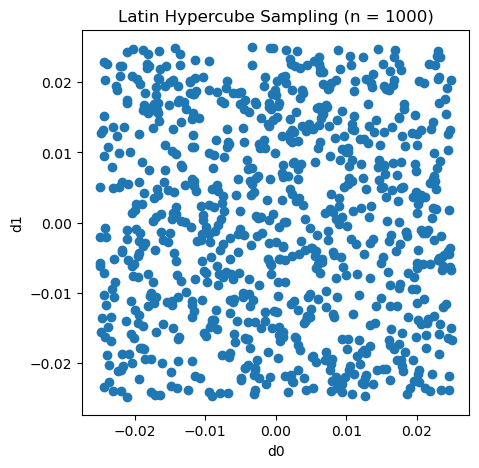

In [3]:
# Dim = 81*5
# N = 10000
# tomorange = 0.025
# sampler = qmc.LatinHypercube(d=Dim)
# sample = sampler.random(n=N)
# l_bounds = [-tomorange]*Dim
# u_bounds = [tomorange]*Dim
# sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
# np.save('samling_array_%d' %N,sample_scaled)

# plt.figure(figsize=(5, 5))
# plt.scatter(sample_scaled[0:819, 0], sample_scaled[0:819, 1])
# plt.xlabel("d0")
# plt.ylabel("d1")
# plt.title(f"Latin Hypercube Sampling (n = {1000})")

In [2]:
sample_scaled = np.load('samling_array_10000.npy')

In [3]:
ExampleInputDir = '../Runs/ExampleSphericalHarmonicsAcousticBall/input'

for imodel in np.arange(0,10000):

    ModeName = 'LatinSphericalHarmonicsAcousticBall%04d' %imodel
    EventParDir='../Runs/%s' %(ModeName)  
    if not os.path.exists(EventParDir):
        os.makedirs(EventParDir)
    print(EventParDir, " created")

    if not os.path.exists(EventParDir+'/input'):
        os.makedirs(EventParDir+'/input')

    # copy parameter file
    # shutil.copy(ExampleInputDir+'/TomoNet_LowerMantle__10s.e',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.model.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.nr.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.advanced.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.source.yaml',EventParDir+'/input/')
    # # update event source
    # with open(EventParDir+'/input/inparam.source.yaml','r') as file:
    #     filetxt = file.read()
    # filetxt = filetxt.replace("latitude_longitude: [-56.24, 26.34]", "latitude_longitude: [%.2f, %.2f]" %(EventLat, EventLon))
    # filetxt = filetxt.replace("depth: 46.56e3", "depth: %.1f" %(EventDepth))
    # filetxt = filetxt.replace("data: [2.73e23, 9.08e21, -2.82e23, 6.30e22, 1.90e23, 2.16e23]", "data: [%e, %e, %e, %e, %e, %e]"  %(MomentTensor['m_rr'],MomentTensor['m_tt'],MomentTensor['m_pp'],MomentTensor['m_rt'],MomentTensor['m_rp'],MomentTensor['m_tp']))
    # with open(EventParDir+'/input/inparam.source.yaml','w') as file:
    #     file.write(filetxt)

    shutil.copy(ExampleInputDir+'/inparam.output.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/Synthetic_Stations_Ball.txt',EventParDir+'/input/')

    # # generate random model
    ### Real spherical harmonics
    coeff = {}

    ModelCoeff = dict()
    ModelCoeff['Depth'] = []
    ModelCoeff['l'] = []
    ModelCoeff['m'] = []
    ModelCoeff['Value'] = []

    l_max = 8
    DepthList = [0. , 200, 400, 600, 800]

    para_index = 0

    for depth in DepthList:
        coeff[depth] = {}
        
        for l in range(0,l_max+1):
            for m in np.arange(-l,l+1):
                name = '%s_%s' %(l, m)
                # print(l,m)
                ModelCoeff['Depth'].append(depth)
                ModelCoeff['l'].append(l)
                ModelCoeff['m'].append(m)

                Val = sample_scaled[imodel,para_index]  # Latin Hypercube Sampling
                ModelCoeff['Value'].append(Val)
                coeff[depth][name] = Val       

                para_index += 1

    df = pd.DataFrame(data=ModelCoeff)
    df.to_pickle(EventParDir+"/Spherical_Harmonics.pkl")

    grid_depth = np.array(DepthList)
    grid_lat = np.linspace(-90, 90, 181)
    grid_lon = np.linspace(-180, 180, 361)

    # Make sure RADISU and Coordinates are ascendingly sorted
    grid_depth.sort()
    grid_lat.sort()
    grid_lon.sort()

    LON, LAT = np.meshgrid(grid_lon, grid_lat)
    MLTomo = np.zeros([len(grid_lat), len(grid_lon), len(grid_depth)])

    for i, SlicingDepth in enumerate(DepthList):
        # initiate TomoSum
        TomoSum = np.zeros([len(grid_lat),len(grid_lon)])

        for l in range(0,l_max+1):
            for m in np.arange(-l,l+1):
                # print('l, m = ', l, m)
                name = '%s_%s' %(l, m)
                Y_grid = sph_harm(m, l, np.radians(LON-180), np.radians(90-LAT))

                if m < 0:
                    Y_grid = np.sqrt(2) * (-1)**(-m) * Y_grid.imag
                elif m > 0:
                    Y_grid = np.sqrt(2) * (-1)**m * Y_grid.real

                TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid
        MLTomo[:,:,i] = TomoSum[:,:]
    
    print(MLTomo.min(), MLTomo.max())

    # # Fig Preparation
    # dpi = 200
    # fig = plt.figure(figsize=(3.5,3),dpi=200)
    # ax = fig.add_subplot(111)

    # map = Basemap(projection='moll',lon_0=0,resolution='l') # moll Projection
    # PLOT = map.pcolormesh(LON, LAT, TomoSum, latlon=True, cmap=plt.get_cmap('jet'))
    # cbar = plt.colorbar(PLOT, ax=ax, shrink=0.5)
    # ax.set_title('Depth Slice at %s m to degrees %d' %(SlicingDepth, l_max))
    # draw_map(map)
    # map.drawcoastlines(linewidth=0.1)

    NCName = "degree8_random.nc"
    # write to file
    if os.path.exists(EventParDir+'/input/'+NCName):
        os.remove(EventParDir+'/input/'+NCName)

    nc = Dataset(EventParDir+'/input/'+NCName, 'w')
    nc.createDimension('nlat', size=len(grid_lat))
    nc.createDimension('nlon', size=len(grid_lon))
    nc.createDimension('ndepth', size=len(grid_depth))
    nc.createVariable('latitude', float, dimensions=('nlat'))
    nc['latitude'][:] = grid_lat
    nc.createVariable('longitude', float, dimensions=('nlon'))
    nc['longitude'][:] = grid_lon
    nc.createVariable('depth', float, dimensions=('ndepth'))
    nc['depth'][:] = grid_depth
    nc.createVariable('dvp', float, dimensions=('nlat', 'nlon','ndepth'))
    nc['dvp'][:,:,:] = MLTomo[:,:,:]


    if imodel == 0:
        nc['dvp'][:,:,:] = np.zeros(np.shape(MLTomo[:,:,:]))
        nc.close()
        continue

    nc.close()



../Runs/LatinSphericalHarmonicsAcousticBall0000  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12452515409715585 0.11246088175924344
../Runs/LatinSphericalHarmonicsAcousticBall0001  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10729758884355324 0.1188037553705976
../Runs/LatinSphericalHarmonicsAcousticBall0002  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14382367713600058 0.1454042841988916
../Runs/LatinSphericalHarmonicsAcousticBall0003  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12835189334463645 0.13667896624371123
../Runs/LatinSphericalHarmonicsAcousticBall0004  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12438774422381826 0.12778668220407918
../Runs/LatinSphericalHarmonicsAcousticBall0005  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11758281008472148 0.12623536721680614
../Runs/LatinSphericalHarmonicsAcousticBall0006  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12769581525900242 0.1048769258596579
../Runs/LatinSphericalHarmonicsAcousticBall0007  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12357613322085936 0.14528408972747936
../Runs/LatinSphericalHarmonicsAcousticBall0008  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11754757500004955 0.13138449242674682
../Runs/LatinSphericalHarmonicsAcousticBall0009  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1301234133786736 0.1357572873294368
../Runs/LatinSphericalHarmonicsAcousticBall0010  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13780105844136822 0.12889641675966754
../Runs/LatinSphericalHarmonicsAcousticBall0011  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1142713014137208 0.11941466878090809
../Runs/LatinSphericalHarmonicsAcousticBall0012  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1149313209117493 0.11925719196757889
../Runs/LatinSphericalHarmonicsAcousticBall0013  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1287827970307408 0.12329583068597405
../Runs/LatinSphericalHarmonicsAcousticBall0014  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12175628776048826 0.10807644180181192
../Runs/LatinSphericalHarmonicsAcousticBall0015  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11216317626628694 0.15012479096012596
../Runs/LatinSphericalHarmonicsAcousticBall0016  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14930964985206657 0.1063704241615802
../Runs/LatinSphericalHarmonicsAcousticBall0017  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13494039814979625 0.1363966978096138
../Runs/LatinSphericalHarmonicsAcousticBall0018  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14626428452043702 0.12298589326428448
../Runs/LatinSphericalHarmonicsAcousticBall0019  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10446105437619126 0.13744887953246407
../Runs/LatinSphericalHarmonicsAcousticBall0020  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14312273108025692 0.14561160896093908
../Runs/LatinSphericalHarmonicsAcousticBall0021  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11208836623660907 0.12670353245945945
../Runs/LatinSphericalHarmonicsAcousticBall0022  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13337349357653186 0.1228917279613787
../Runs/LatinSphericalHarmonicsAcousticBall0023  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12073463578531825 0.12640075651124455
../Runs/LatinSphericalHarmonicsAcousticBall0024  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13027178400075315 0.1467636747317738
../Runs/LatinSphericalHarmonicsAcousticBall0025  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13963345670433963 0.15103996162875089
../Runs/LatinSphericalHarmonicsAcousticBall0026  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15451749207105905 0.1341257149304423
../Runs/LatinSphericalHarmonicsAcousticBall0027  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11624610174281567 0.13068526456682902
../Runs/LatinSphericalHarmonicsAcousticBall0028  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14052285003728796 0.11179301255426757
../Runs/LatinSphericalHarmonicsAcousticBall0029  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11822210332696455 0.12974007390817482
../Runs/LatinSphericalHarmonicsAcousticBall0030  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12946796375805725 0.11260244326413861
../Runs/LatinSphericalHarmonicsAcousticBall0031  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16549075027602972 0.13364550847627768
../Runs/LatinSphericalHarmonicsAcousticBall0032  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1293724024889938 0.11340683680246107
../Runs/LatinSphericalHarmonicsAcousticBall0033  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11381388407742608 0.12026215141638927
../Runs/LatinSphericalHarmonicsAcousticBall0034  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12122612883832533 0.13135894471456613
../Runs/LatinSphericalHarmonicsAcousticBall0035  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13265558033267846 0.13027778155343814
../Runs/LatinSphericalHarmonicsAcousticBall0036  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11462621705213678 0.11805267726526893
../Runs/LatinSphericalHarmonicsAcousticBall0037  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13552171141990954 0.1384345482123729
../Runs/LatinSphericalHarmonicsAcousticBall0038  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11476815949516182 0.12429905606385429
../Runs/LatinSphericalHarmonicsAcousticBall0039  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14483845425677236 0.1486217919259767
../Runs/LatinSphericalHarmonicsAcousticBall0040  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11179768821504991 0.1455630107807171
../Runs/LatinSphericalHarmonicsAcousticBall0041  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14893058912352217 0.12196949385595802
../Runs/LatinSphericalHarmonicsAcousticBall0042  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14357457747510446 0.11849751441890781
../Runs/LatinSphericalHarmonicsAcousticBall0043  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12399640044028566 0.12421153649469222
../Runs/LatinSphericalHarmonicsAcousticBall0044  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11262812316242024 0.12865069359483322
../Runs/LatinSphericalHarmonicsAcousticBall0045  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11116759733177425 0.15130162653514076
../Runs/LatinSphericalHarmonicsAcousticBall0046  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13863170850848738 0.12795616168105226
../Runs/LatinSphericalHarmonicsAcousticBall0047  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11484359665607126 0.13262962434298473
../Runs/LatinSphericalHarmonicsAcousticBall0048  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1572370041920201 0.11111636170883643
../Runs/LatinSphericalHarmonicsAcousticBall0049  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14222370422916894 0.118962346862052
../Runs/LatinSphericalHarmonicsAcousticBall0050  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12068302245063142 0.11893631771821793
../Runs/LatinSphericalHarmonicsAcousticBall0051  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1311826238929838 0.12228415297824878
../Runs/LatinSphericalHarmonicsAcousticBall0052  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11850876918867245 0.13753237407756025
../Runs/LatinSphericalHarmonicsAcousticBall0053  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12127223213448099 0.11894112515027154
../Runs/LatinSphericalHarmonicsAcousticBall0054  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12950287303557748 0.12614726904952975
../Runs/LatinSphericalHarmonicsAcousticBall0055  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12316727551772974 0.12135655751953216
../Runs/LatinSphericalHarmonicsAcousticBall0056  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1272805500674474 0.1462953543083181
../Runs/LatinSphericalHarmonicsAcousticBall0057  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14971026460097162 0.14564862154374444
../Runs/LatinSphericalHarmonicsAcousticBall0058  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1168322861887223 0.1409741994097512
../Runs/LatinSphericalHarmonicsAcousticBall0059  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14710583182668802 0.1335575106231805
../Runs/LatinSphericalHarmonicsAcousticBall0060  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11784156683618055 0.14674439021317423
../Runs/LatinSphericalHarmonicsAcousticBall0061  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15126349032361405 0.1108290052437137
../Runs/LatinSphericalHarmonicsAcousticBall0062  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12653152893003822 0.11870968386100238
../Runs/LatinSphericalHarmonicsAcousticBall0063  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1204960727223674 0.1387229395624474
../Runs/LatinSphericalHarmonicsAcousticBall0064  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10370878393156609 0.1327439413129909
../Runs/LatinSphericalHarmonicsAcousticBall0065  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1340994039580788 0.1029279610088562
../Runs/LatinSphericalHarmonicsAcousticBall0066  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13978612395279888 0.1436789269475578
../Runs/LatinSphericalHarmonicsAcousticBall0067  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15792785310338994 0.132293107006829
../Runs/LatinSphericalHarmonicsAcousticBall0068  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1350678188121736 0.12426687976223613
../Runs/LatinSphericalHarmonicsAcousticBall0069  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12873444577359708 0.11734998790361678
../Runs/LatinSphericalHarmonicsAcousticBall0070  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12363181459805538 0.15301616367775212
../Runs/LatinSphericalHarmonicsAcousticBall0071  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12632078145458278 0.11239943436554553
../Runs/LatinSphericalHarmonicsAcousticBall0072  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10967854998350518 0.11542102986601356
../Runs/LatinSphericalHarmonicsAcousticBall0073  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12409183582549443 0.12147349147011113
../Runs/LatinSphericalHarmonicsAcousticBall0074  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12353395196071613 0.1426939271125681
../Runs/LatinSphericalHarmonicsAcousticBall0075  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13317721192892912 0.10409143594143014
../Runs/LatinSphericalHarmonicsAcousticBall0076  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11188034882959912 0.14574333371810685
../Runs/LatinSphericalHarmonicsAcousticBall0077  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1290432129866 0.11561954533111232
../Runs/LatinSphericalHarmonicsAcousticBall0078  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1272543485923877 0.1203545542016735
../Runs/LatinSphericalHarmonicsAcousticBall0079  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13475566125612803 0.12351938276722099
../Runs/LatinSphericalHarmonicsAcousticBall0080  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10558273413964597 0.1292015531749633
../Runs/LatinSphericalHarmonicsAcousticBall0081  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11464193395897253 0.11161710835158675
../Runs/LatinSphericalHarmonicsAcousticBall0082  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11360208280812308 0.1127044246728377
../Runs/LatinSphericalHarmonicsAcousticBall0083  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1381772884236083 0.13434248911312288
../Runs/LatinSphericalHarmonicsAcousticBall0084  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1272175928909201 0.11109396249435442
../Runs/LatinSphericalHarmonicsAcousticBall0085  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13899299348575264 0.10764969560991133
../Runs/LatinSphericalHarmonicsAcousticBall0086  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12577385267207125 0.10855719631355604
../Runs/LatinSphericalHarmonicsAcousticBall0087  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16468662014596763 0.11525368698255994
../Runs/LatinSphericalHarmonicsAcousticBall0088  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11527437897262 0.13975271247578228
../Runs/LatinSphericalHarmonicsAcousticBall0089  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11580136554683497 0.13429727761770577
../Runs/LatinSphericalHarmonicsAcousticBall0090  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10732406762994273 0.12926896503317578
../Runs/LatinSphericalHarmonicsAcousticBall0091  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12518139769257147 0.1449426834061078
../Runs/LatinSphericalHarmonicsAcousticBall0092  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12499332551112434 0.12583277067814314
../Runs/LatinSphericalHarmonicsAcousticBall0093  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11287613624450836 0.11970356394477714
../Runs/LatinSphericalHarmonicsAcousticBall0094  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1159718099035142 0.15564337444556384
../Runs/LatinSphericalHarmonicsAcousticBall0095  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12506087285153408 0.12341269027516386
../Runs/LatinSphericalHarmonicsAcousticBall0096  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12267991746333659 0.14218043041169667
../Runs/LatinSphericalHarmonicsAcousticBall0097  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12586221540522075 0.12545825539314578
../Runs/LatinSphericalHarmonicsAcousticBall0098  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12402480451584622 0.12243384042418694
../Runs/LatinSphericalHarmonicsAcousticBall0099  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1264471291374777 0.11246499269961978
../Runs/LatinSphericalHarmonicsAcousticBall0100  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13758008880476977 0.1118300067224336
../Runs/LatinSphericalHarmonicsAcousticBall0101  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11809461140117401 0.12073624721941159
../Runs/LatinSphericalHarmonicsAcousticBall0102  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12239842547448493 0.11506537763458557
../Runs/LatinSphericalHarmonicsAcousticBall0103  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11429486350689035 0.11785369101945184
../Runs/LatinSphericalHarmonicsAcousticBall0104  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10826963881414665 0.1313113894904237
../Runs/LatinSphericalHarmonicsAcousticBall0105  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12678014202293747 0.1414712596440609
../Runs/LatinSphericalHarmonicsAcousticBall0106  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12570030447159883 0.12695025033676471
../Runs/LatinSphericalHarmonicsAcousticBall0107  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1350257226362118 0.13495119013490164
../Runs/LatinSphericalHarmonicsAcousticBall0108  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11742465092957802 0.1081939419837619
../Runs/LatinSphericalHarmonicsAcousticBall0109  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11734943315093595 0.14115997122452753
../Runs/LatinSphericalHarmonicsAcousticBall0110  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12797571333383617 0.11868707760036944
../Runs/LatinSphericalHarmonicsAcousticBall0111  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10874225112841077 0.13430013838247462
../Runs/LatinSphericalHarmonicsAcousticBall0112  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13184710158361757 0.1393537892352437
../Runs/LatinSphericalHarmonicsAcousticBall0113  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1248926062335763 0.10962125131991861
../Runs/LatinSphericalHarmonicsAcousticBall0114  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12269252100119864 0.11964166509159349
../Runs/LatinSphericalHarmonicsAcousticBall0115  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1304156806318567 0.11521480216104789
../Runs/LatinSphericalHarmonicsAcousticBall0116  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15015108437395408 0.12722158096153405
../Runs/LatinSphericalHarmonicsAcousticBall0117  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11862388894102675 0.1254359493958387
../Runs/LatinSphericalHarmonicsAcousticBall0118  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15798359454623187 0.12910202123569992
../Runs/LatinSphericalHarmonicsAcousticBall0119  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14041802680213092 0.12953325978420904
../Runs/LatinSphericalHarmonicsAcousticBall0120  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1190586865167857 0.11003117947254368
../Runs/LatinSphericalHarmonicsAcousticBall0121  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13019915715829103 0.15427327593180679
../Runs/LatinSphericalHarmonicsAcousticBall0122  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11766802866619462 0.1146082197598269
../Runs/LatinSphericalHarmonicsAcousticBall0123  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1308208347333593 0.12916628817160497
../Runs/LatinSphericalHarmonicsAcousticBall0124  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12187967945304914 0.11720914218718817
../Runs/LatinSphericalHarmonicsAcousticBall0125  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1148798686743565 0.11744423801509296
../Runs/LatinSphericalHarmonicsAcousticBall0126  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13160761512237232 0.14203709355774125
../Runs/LatinSphericalHarmonicsAcousticBall0127  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15343549644144372 0.12827654277850103
../Runs/LatinSphericalHarmonicsAcousticBall0128  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13795974150924095 0.1365823174207558
../Runs/LatinSphericalHarmonicsAcousticBall0129  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12560053755959757 0.14276726698657174
../Runs/LatinSphericalHarmonicsAcousticBall0130  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10936478046550066 0.14142563598785104
../Runs/LatinSphericalHarmonicsAcousticBall0131  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13324110258081312 0.123260640121847
../Runs/LatinSphericalHarmonicsAcousticBall0132  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17215257491394886 0.11976597998927033
../Runs/LatinSphericalHarmonicsAcousticBall0133  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12526703835125588 0.12460138474199416
../Runs/LatinSphericalHarmonicsAcousticBall0134  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13773472265589337 0.1273896471202395
../Runs/LatinSphericalHarmonicsAcousticBall0135  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11937556650819989 0.1419897831730833
../Runs/LatinSphericalHarmonicsAcousticBall0136  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1688888257085894 0.12752659962361584
../Runs/LatinSphericalHarmonicsAcousticBall0137  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12503048934822958 0.1267496973505137
../Runs/LatinSphericalHarmonicsAcousticBall0138  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11069004891777073 0.12200740968555962
../Runs/LatinSphericalHarmonicsAcousticBall0139  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11665691242415392 0.1282278820874858
../Runs/LatinSphericalHarmonicsAcousticBall0140  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1274418520259229 0.16060087416934743
../Runs/LatinSphericalHarmonicsAcousticBall0141  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12536548805704592 0.11265970183113429
../Runs/LatinSphericalHarmonicsAcousticBall0142  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11063809744726197 0.1277756202720127
../Runs/LatinSphericalHarmonicsAcousticBall0143  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11102052899830604 0.10242881962334172
../Runs/LatinSphericalHarmonicsAcousticBall0144  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12032356134638518 0.11863104282465949
../Runs/LatinSphericalHarmonicsAcousticBall0145  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323463766768114 0.1495145219420365
../Runs/LatinSphericalHarmonicsAcousticBall0146  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12817442309615457 0.12236057775577347
../Runs/LatinSphericalHarmonicsAcousticBall0147  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12244955114840107 0.11374717770618557
../Runs/LatinSphericalHarmonicsAcousticBall0148  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12567355503674296 0.14860134104541892
../Runs/LatinSphericalHarmonicsAcousticBall0149  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10829539810696241 0.10071673574671783
../Runs/LatinSphericalHarmonicsAcousticBall0150  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12130703289803946 0.1206295079653596
../Runs/LatinSphericalHarmonicsAcousticBall0151  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14398754577459205 0.11191167654424221
../Runs/LatinSphericalHarmonicsAcousticBall0152  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12252334285841897 0.14033246842753452
../Runs/LatinSphericalHarmonicsAcousticBall0153  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12340040077941845 0.09993164027384314
../Runs/LatinSphericalHarmonicsAcousticBall0154  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13323726085338414 0.1348659480092425
../Runs/LatinSphericalHarmonicsAcousticBall0155  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13056288298384155 0.12826212206974869
../Runs/LatinSphericalHarmonicsAcousticBall0156  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10690907280170242 0.13699566403582308
../Runs/LatinSphericalHarmonicsAcousticBall0157  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11603367337563675 0.1091732866892204
../Runs/LatinSphericalHarmonicsAcousticBall0158  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14181836366064327 0.11901126069940195
../Runs/LatinSphericalHarmonicsAcousticBall0159  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12103185252775968 0.13279620699082662
../Runs/LatinSphericalHarmonicsAcousticBall0160  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10614720577507243 0.11980874762603427
../Runs/LatinSphericalHarmonicsAcousticBall0161  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1382593012748203 0.11442901001546574
../Runs/LatinSphericalHarmonicsAcousticBall0162  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1481916613978537 0.11269564377312423
../Runs/LatinSphericalHarmonicsAcousticBall0163  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1176325042919571 0.11665649019023451
../Runs/LatinSphericalHarmonicsAcousticBall0164  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11543257802435959 0.13537425164670377
../Runs/LatinSphericalHarmonicsAcousticBall0165  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10339087769251266 0.13444714310087108
../Runs/LatinSphericalHarmonicsAcousticBall0166  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126054383167098 0.13914688254347238
../Runs/LatinSphericalHarmonicsAcousticBall0167  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13420257956270018 0.13569038305518033
../Runs/LatinSphericalHarmonicsAcousticBall0168  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14923174734560868 0.14102300578177526
../Runs/LatinSphericalHarmonicsAcousticBall0169  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1308611774791115 0.11638383662172794
../Runs/LatinSphericalHarmonicsAcousticBall0170  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11396386790710047 0.13267077952575979
../Runs/LatinSphericalHarmonicsAcousticBall0171  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11528202766697107 0.13192850044159043
../Runs/LatinSphericalHarmonicsAcousticBall0172  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11728836555697897 0.12196943333435725
../Runs/LatinSphericalHarmonicsAcousticBall0173  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.18092581468304447 0.12006661439762241
../Runs/LatinSphericalHarmonicsAcousticBall0174  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10777206291068508 0.11799074528568108
../Runs/LatinSphericalHarmonicsAcousticBall0175  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13559427764654228 0.13006452580849232
../Runs/LatinSphericalHarmonicsAcousticBall0176  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.146596384631889 0.13178335785852166
../Runs/LatinSphericalHarmonicsAcousticBall0177  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13831942334269165 0.11095695052138148
../Runs/LatinSphericalHarmonicsAcousticBall0178  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12737131324781212 0.12839352827362963
../Runs/LatinSphericalHarmonicsAcousticBall0179  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1127456593775873 0.12664558827488875
../Runs/LatinSphericalHarmonicsAcousticBall0180  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13935387058282567 0.11492251491853583
../Runs/LatinSphericalHarmonicsAcousticBall0181  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10815024604984419 0.10756075820364386
../Runs/LatinSphericalHarmonicsAcousticBall0182  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12897374756679403 0.11682148486208474
../Runs/LatinSphericalHarmonicsAcousticBall0183  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16310421432958946 0.12325606845011673
../Runs/LatinSphericalHarmonicsAcousticBall0184  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14492432338903294 0.16172806201409376
../Runs/LatinSphericalHarmonicsAcousticBall0185  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11852445282951886 0.13708747630724852
../Runs/LatinSphericalHarmonicsAcousticBall0186  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13165376207560608 0.13481693255532384
../Runs/LatinSphericalHarmonicsAcousticBall0187  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1201874382633749 0.12425285545726059
../Runs/LatinSphericalHarmonicsAcousticBall0188  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12529714930513208 0.12772551811105895
../Runs/LatinSphericalHarmonicsAcousticBall0189  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.113073694662183 0.15207339651512233
../Runs/LatinSphericalHarmonicsAcousticBall0190  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1267019061419321 0.1200286645730981
../Runs/LatinSphericalHarmonicsAcousticBall0191  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1500737263160746 0.12354381782980028
../Runs/LatinSphericalHarmonicsAcousticBall0192  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11578185526823243 0.1354771273062898
../Runs/LatinSphericalHarmonicsAcousticBall0193  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.144246091350863 0.10239718892855434
../Runs/LatinSphericalHarmonicsAcousticBall0194  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12570973756005321 0.13088266593120537
../Runs/LatinSphericalHarmonicsAcousticBall0195  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1268169322705084 0.12966744643870765
../Runs/LatinSphericalHarmonicsAcousticBall0196  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11612418971748968 0.11868103889764733
../Runs/LatinSphericalHarmonicsAcousticBall0197  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14019015497864035 0.11426919968746868
../Runs/LatinSphericalHarmonicsAcousticBall0198  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10445694314179829 0.13988064487816584
../Runs/LatinSphericalHarmonicsAcousticBall0199  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1366050782412454 0.11892510850280523
../Runs/LatinSphericalHarmonicsAcousticBall0200  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13019363402299375 0.13467247669701443
../Runs/LatinSphericalHarmonicsAcousticBall0201  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12694642408908172 0.15441648881507392
../Runs/LatinSphericalHarmonicsAcousticBall0202  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13578433588460162 0.12183159088125452
../Runs/LatinSphericalHarmonicsAcousticBall0203  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1374600122629883 0.1203579609696229
../Runs/LatinSphericalHarmonicsAcousticBall0204  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11300476839110955 0.12801233593279956
../Runs/LatinSphericalHarmonicsAcousticBall0205  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10693225089911476 0.10502109235592441
../Runs/LatinSphericalHarmonicsAcousticBall0206  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13315111303636787 0.12804583655777343
../Runs/LatinSphericalHarmonicsAcousticBall0207  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12359686530046779 0.1307361769813353
../Runs/LatinSphericalHarmonicsAcousticBall0208  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12406360807881948 0.13308469604932466
../Runs/LatinSphericalHarmonicsAcousticBall0209  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1329800095776877 0.1204521920978803
../Runs/LatinSphericalHarmonicsAcousticBall0210  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12642527954894384 0.14973783544924738
../Runs/LatinSphericalHarmonicsAcousticBall0211  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1458826633942686 0.12007481533599938
../Runs/LatinSphericalHarmonicsAcousticBall0212  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1209472269359779 0.12422241482731095
../Runs/LatinSphericalHarmonicsAcousticBall0213  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11398140166058138 0.12408151366506828
../Runs/LatinSphericalHarmonicsAcousticBall0214  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11439143322595864 0.10692764275239057
../Runs/LatinSphericalHarmonicsAcousticBall0215  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12673492754256052 0.1193833225524166
../Runs/LatinSphericalHarmonicsAcousticBall0216  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13492379736845522 0.11082702729183935
../Runs/LatinSphericalHarmonicsAcousticBall0217  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13151154759471093 0.14597324722325214
../Runs/LatinSphericalHarmonicsAcousticBall0218  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13050860231806943 0.14056590729260554
../Runs/LatinSphericalHarmonicsAcousticBall0219  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13933147242467478 0.1666474394123128
../Runs/LatinSphericalHarmonicsAcousticBall0220  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260838529734061 0.1292335171625604
../Runs/LatinSphericalHarmonicsAcousticBall0221  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12181624412071286 0.1358122045431419
../Runs/LatinSphericalHarmonicsAcousticBall0222  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1246437103288209 0.10916576646264652
../Runs/LatinSphericalHarmonicsAcousticBall0223  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11660453544300345 0.11476847625268177
../Runs/LatinSphericalHarmonicsAcousticBall0224  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11823427192940913 0.13549846063664214
../Runs/LatinSphericalHarmonicsAcousticBall0225  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13584754096539858 0.13904506871765088
../Runs/LatinSphericalHarmonicsAcousticBall0226  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13253596479699833 0.13294659913351084
../Runs/LatinSphericalHarmonicsAcousticBall0227  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362226910953195 0.13249729041540462
../Runs/LatinSphericalHarmonicsAcousticBall0228  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11505122257780942 0.1764290714144948
../Runs/LatinSphericalHarmonicsAcousticBall0229  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1532177980236109 0.12391821550985348
../Runs/LatinSphericalHarmonicsAcousticBall0230  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13681016543160296 0.1288412545680654
../Runs/LatinSphericalHarmonicsAcousticBall0231  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12404510742301765 0.1332816664262029
../Runs/LatinSphericalHarmonicsAcousticBall0232  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1184690759730645 0.128177618640769
../Runs/LatinSphericalHarmonicsAcousticBall0233  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13947008505053876 0.11425252442410591
../Runs/LatinSphericalHarmonicsAcousticBall0234  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12369383186079541 0.12202517376488542
../Runs/LatinSphericalHarmonicsAcousticBall0235  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13839965141826674 0.13485910492485242
../Runs/LatinSphericalHarmonicsAcousticBall0236  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11215315921064758 0.1286744363641403
../Runs/LatinSphericalHarmonicsAcousticBall0237  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12460263425633744 0.13771038456366122
../Runs/LatinSphericalHarmonicsAcousticBall0238  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1344417235336991 0.14953264533020297
../Runs/LatinSphericalHarmonicsAcousticBall0239  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13671619876506655 0.1135834009838977
../Runs/LatinSphericalHarmonicsAcousticBall0240  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13336678857411688 0.11953429578470182
../Runs/LatinSphericalHarmonicsAcousticBall0241  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1259399774868949 0.13547378682517394
../Runs/LatinSphericalHarmonicsAcousticBall0242  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11820767121384625 0.14571700512345617
../Runs/LatinSphericalHarmonicsAcousticBall0243  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13482998001340868 0.12281084839187505
../Runs/LatinSphericalHarmonicsAcousticBall0244  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13927480225583602 0.1254687176582837
../Runs/LatinSphericalHarmonicsAcousticBall0245  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11854481343141074 0.10152187620971022
../Runs/LatinSphericalHarmonicsAcousticBall0246  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1063093454654284 0.12575983942930713
../Runs/LatinSphericalHarmonicsAcousticBall0247  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12588944062694138 0.13408462034157456
../Runs/LatinSphericalHarmonicsAcousticBall0248  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13501107785309174 0.12585829522301178
../Runs/LatinSphericalHarmonicsAcousticBall0249  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14352882734826067 0.12857472699971714
../Runs/LatinSphericalHarmonicsAcousticBall0250  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12691328117055362 0.11664812009348632
../Runs/LatinSphericalHarmonicsAcousticBall0251  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10932700263689674 0.1334679860740338
../Runs/LatinSphericalHarmonicsAcousticBall0252  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1239177663398099 0.114904523258543
../Runs/LatinSphericalHarmonicsAcousticBall0253  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12134722397342781 0.14447872780382426
../Runs/LatinSphericalHarmonicsAcousticBall0254  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13566043747917608 0.1366736425272282
../Runs/LatinSphericalHarmonicsAcousticBall0255  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11227391290798669 0.14862835904108798
../Runs/LatinSphericalHarmonicsAcousticBall0256  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10625364442180936 0.13890988808182186
../Runs/LatinSphericalHarmonicsAcousticBall0257  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1164129951287964 0.12786611771929024
../Runs/LatinSphericalHarmonicsAcousticBall0258  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11263811456101694 0.12054466642114392
../Runs/LatinSphericalHarmonicsAcousticBall0259  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13187541960031737 0.11983808295096719
../Runs/LatinSphericalHarmonicsAcousticBall0260  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12119485922473487 0.10945405075188197
../Runs/LatinSphericalHarmonicsAcousticBall0261  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1400936912894803 0.12372331320320995
../Runs/LatinSphericalHarmonicsAcousticBall0262  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12173046780458978 0.1337339366068544
../Runs/LatinSphericalHarmonicsAcousticBall0263  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12131641326266393 0.11419847540399403
../Runs/LatinSphericalHarmonicsAcousticBall0264  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11824433823590445 0.1179031733457865
../Runs/LatinSphericalHarmonicsAcousticBall0265  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11273231253720156 0.1256932989830886
../Runs/LatinSphericalHarmonicsAcousticBall0266  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11615744654671646 0.16547376092636298
../Runs/LatinSphericalHarmonicsAcousticBall0267  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1290177572078192 0.11196390600943787
../Runs/LatinSphericalHarmonicsAcousticBall0268  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11277220976559649 0.12087634296011814
../Runs/LatinSphericalHarmonicsAcousticBall0269  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13198724737389755 0.14452539570890827
../Runs/LatinSphericalHarmonicsAcousticBall0270  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15030982987810212 0.12577372880791649
../Runs/LatinSphericalHarmonicsAcousticBall0271  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09938626815375204 0.11992205442446187
../Runs/LatinSphericalHarmonicsAcousticBall0272  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1221545837452464 0.13357740430178444
../Runs/LatinSphericalHarmonicsAcousticBall0273  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1355468947997371 0.12534626958241918
../Runs/LatinSphericalHarmonicsAcousticBall0274  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1233409061156107 0.12502890308721856
../Runs/LatinSphericalHarmonicsAcousticBall0275  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11767112421147288 0.12255409125610378
../Runs/LatinSphericalHarmonicsAcousticBall0276  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12079901445390034 0.12417903743764981
../Runs/LatinSphericalHarmonicsAcousticBall0277  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14080326816704014 0.11151788826167718
../Runs/LatinSphericalHarmonicsAcousticBall0278  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13210115922782142 0.12658111080295326
../Runs/LatinSphericalHarmonicsAcousticBall0279  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12226692863344579 0.134339260237125
../Runs/LatinSphericalHarmonicsAcousticBall0280  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11707356557752094 0.14090734075327052
../Runs/LatinSphericalHarmonicsAcousticBall0281  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12674603196959264 0.1445441008777035
../Runs/LatinSphericalHarmonicsAcousticBall0282  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10057183348351825 0.14740473264023005
../Runs/LatinSphericalHarmonicsAcousticBall0283  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1656900519196966 0.12667689761101997
../Runs/LatinSphericalHarmonicsAcousticBall0284  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11852832218312234 0.11261195429275932
../Runs/LatinSphericalHarmonicsAcousticBall0285  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12027448971045425 0.12076656141780326
../Runs/LatinSphericalHarmonicsAcousticBall0286  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12055528252789298 0.14976812905387493
../Runs/LatinSphericalHarmonicsAcousticBall0287  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12486519908992656 0.12637896718965094
../Runs/LatinSphericalHarmonicsAcousticBall0288  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12844905587660707 0.13108044768446891
../Runs/LatinSphericalHarmonicsAcousticBall0289  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12734970822671765 0.13816576796353652
../Runs/LatinSphericalHarmonicsAcousticBall0290  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13294923239187073 0.13054627167105606
../Runs/LatinSphericalHarmonicsAcousticBall0291  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12900532645419333 0.11348277519227871
../Runs/LatinSphericalHarmonicsAcousticBall0292  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10357970641654654 0.1457171557716301
../Runs/LatinSphericalHarmonicsAcousticBall0293  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11871507334418355 0.12371361943254683
../Runs/LatinSphericalHarmonicsAcousticBall0294  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12404825211180738 0.11325856921889073
../Runs/LatinSphericalHarmonicsAcousticBall0295  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14444367910083641 0.12630369116308457
../Runs/LatinSphericalHarmonicsAcousticBall0296  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14410210957079148 0.13663558808693121
../Runs/LatinSphericalHarmonicsAcousticBall0297  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1324790334702544 0.127397591640574
../Runs/LatinSphericalHarmonicsAcousticBall0298  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15058813574834012 0.12453156048413329
../Runs/LatinSphericalHarmonicsAcousticBall0299  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13430395905468445 0.1276816073317431
../Runs/LatinSphericalHarmonicsAcousticBall0300  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13116342771904707 0.11533889772261878
../Runs/LatinSphericalHarmonicsAcousticBall0301  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15877773260296887 0.13169699844433977
../Runs/LatinSphericalHarmonicsAcousticBall0302  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13850732557991335 0.12425461548649076
../Runs/LatinSphericalHarmonicsAcousticBall0303  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13585476689315257 0.1185570498481968
../Runs/LatinSphericalHarmonicsAcousticBall0304  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13018329852547544 0.11139095590139406
../Runs/LatinSphericalHarmonicsAcousticBall0305  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1311431777026737 0.11527434387626609
../Runs/LatinSphericalHarmonicsAcousticBall0306  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1455518075882318 0.13193594670155198
../Runs/LatinSphericalHarmonicsAcousticBall0307  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12561945347207729 0.14561520913114437
../Runs/LatinSphericalHarmonicsAcousticBall0308  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1334634812274303 0.1269548361322539
../Runs/LatinSphericalHarmonicsAcousticBall0309  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325170512397168 0.11512006447792758
../Runs/LatinSphericalHarmonicsAcousticBall0310  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12478450014091295 0.1348425242110921
../Runs/LatinSphericalHarmonicsAcousticBall0311  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1170956862349887 0.16286480140585177
../Runs/LatinSphericalHarmonicsAcousticBall0312  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11866746393136275 0.12208329406326596
../Runs/LatinSphericalHarmonicsAcousticBall0313  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13140020353608997 0.14549728409212062
../Runs/LatinSphericalHarmonicsAcousticBall0314  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14358886504704116 0.14053584012389767
../Runs/LatinSphericalHarmonicsAcousticBall0315  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12432352648533794 0.1358981357753968
../Runs/LatinSphericalHarmonicsAcousticBall0316  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12888621591022587 0.14569881114478964
../Runs/LatinSphericalHarmonicsAcousticBall0317  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12406152212884268 0.14237686644844183
../Runs/LatinSphericalHarmonicsAcousticBall0318  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12581092912040726 0.13175480774341908
../Runs/LatinSphericalHarmonicsAcousticBall0319  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13104946473172574 0.1253741777298244
../Runs/LatinSphericalHarmonicsAcousticBall0320  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1162311936884616 0.1483139713903373
../Runs/LatinSphericalHarmonicsAcousticBall0321  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1288449356941071 0.12544328263226365
../Runs/LatinSphericalHarmonicsAcousticBall0322  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11702659888317517 0.12569031831106534
../Runs/LatinSphericalHarmonicsAcousticBall0323  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13519235909183336 0.13428973774692715
../Runs/LatinSphericalHarmonicsAcousticBall0324  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13837445590967234 0.1281834708658938
../Runs/LatinSphericalHarmonicsAcousticBall0325  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1357473796776256 0.11146264229901126
../Runs/LatinSphericalHarmonicsAcousticBall0326  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11507933501517723 0.13064169371013482
../Runs/LatinSphericalHarmonicsAcousticBall0327  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11912749284506241 0.12003405062995706
../Runs/LatinSphericalHarmonicsAcousticBall0328  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13289821836505153 0.12108306684700297
../Runs/LatinSphericalHarmonicsAcousticBall0329  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12672833351719062 0.1406220499770305
../Runs/LatinSphericalHarmonicsAcousticBall0330  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1126905399056969 0.11800346220310194
../Runs/LatinSphericalHarmonicsAcousticBall0331  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12396788372743664 0.1416921969703555
../Runs/LatinSphericalHarmonicsAcousticBall0332  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12431061215225882 0.12403626603540924
../Runs/LatinSphericalHarmonicsAcousticBall0333  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10660453875264495 0.14099936617774464
../Runs/LatinSphericalHarmonicsAcousticBall0334  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12411673461896196 0.15712320443002267
../Runs/LatinSphericalHarmonicsAcousticBall0335  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09966027485784885 0.14106086523377448
../Runs/LatinSphericalHarmonicsAcousticBall0336  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12360966764493043 0.1288085547690144
../Runs/LatinSphericalHarmonicsAcousticBall0337  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13484476030529427 0.1118186460540561
../Runs/LatinSphericalHarmonicsAcousticBall0338  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12813787894544634 0.12554324742344677
../Runs/LatinSphericalHarmonicsAcousticBall0339  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10874297707678487 0.11891905819258472
../Runs/LatinSphericalHarmonicsAcousticBall0340  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13405554146114537 0.1495063490858964
../Runs/LatinSphericalHarmonicsAcousticBall0341  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12347104261418992 0.14306781728304555
../Runs/LatinSphericalHarmonicsAcousticBall0342  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13446840433592078 0.1079405733427086
../Runs/LatinSphericalHarmonicsAcousticBall0343  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12819910641148102 0.14143178171228016
../Runs/LatinSphericalHarmonicsAcousticBall0344  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12287732041108586 0.11603135459187063
../Runs/LatinSphericalHarmonicsAcousticBall0345  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12909551619098578 0.1257538472612636
../Runs/LatinSphericalHarmonicsAcousticBall0346  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11995161744114108 0.13748357289522148
../Runs/LatinSphericalHarmonicsAcousticBall0347  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1199710078370289 0.1351350877436061
../Runs/LatinSphericalHarmonicsAcousticBall0348  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12644088869635153 0.11975992354244881
../Runs/LatinSphericalHarmonicsAcousticBall0349  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14832132810597257 0.13745163185419204
../Runs/LatinSphericalHarmonicsAcousticBall0350  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11629796411771331 0.13167684924219658
../Runs/LatinSphericalHarmonicsAcousticBall0351  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13098046020521928 0.13057521082047346
../Runs/LatinSphericalHarmonicsAcousticBall0352  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13088693245399788 0.11946624401414263
../Runs/LatinSphericalHarmonicsAcousticBall0353  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16473105463994572 0.13411666530659833
../Runs/LatinSphericalHarmonicsAcousticBall0354  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11778690466194225 0.13885473040691815
../Runs/LatinSphericalHarmonicsAcousticBall0355  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11382267697910106 0.12482740894309882
../Runs/LatinSphericalHarmonicsAcousticBall0356  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11390842118381612 0.12658917506143513
../Runs/LatinSphericalHarmonicsAcousticBall0357  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12302458108866694 0.1412229229029625
../Runs/LatinSphericalHarmonicsAcousticBall0358  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280104527297084 0.13445830045151688
../Runs/LatinSphericalHarmonicsAcousticBall0359  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11611837567340458 0.11130990495427771
../Runs/LatinSphericalHarmonicsAcousticBall0360  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11539244868247403 0.12407218321276003
../Runs/LatinSphericalHarmonicsAcousticBall0361  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12044792165133744 0.14830333332241705
../Runs/LatinSphericalHarmonicsAcousticBall0362  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1032467230405752 0.12757079969556495
../Runs/LatinSphericalHarmonicsAcousticBall0363  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13027014410884283 0.11979941115747238
../Runs/LatinSphericalHarmonicsAcousticBall0364  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12383086547007194 0.14042439168035656
../Runs/LatinSphericalHarmonicsAcousticBall0365  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1331372081625438 0.12006262590921714
../Runs/LatinSphericalHarmonicsAcousticBall0366  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12602682813686017 0.14254572540704252
../Runs/LatinSphericalHarmonicsAcousticBall0367  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.143300048102692 0.160520955046373
../Runs/LatinSphericalHarmonicsAcousticBall0368  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12064521522496195 0.1312233212954514
../Runs/LatinSphericalHarmonicsAcousticBall0369  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1380752459279747 0.13124842230968037
../Runs/LatinSphericalHarmonicsAcousticBall0370  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1461580946930645 0.14715343375539255
../Runs/LatinSphericalHarmonicsAcousticBall0371  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12935201696189974 0.13316145250093786
../Runs/LatinSphericalHarmonicsAcousticBall0372  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11903174315972308 0.13238353192620067
../Runs/LatinSphericalHarmonicsAcousticBall0373  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12655544496846055 0.12706560060094088
../Runs/LatinSphericalHarmonicsAcousticBall0374  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10979587246745162 0.13331990938552693
../Runs/LatinSphericalHarmonicsAcousticBall0375  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11940383702524773 0.14684889109373375
../Runs/LatinSphericalHarmonicsAcousticBall0376  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1161186038455652 0.12417037946411852
../Runs/LatinSphericalHarmonicsAcousticBall0377  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13215530735354958 0.1295831607137039
../Runs/LatinSphericalHarmonicsAcousticBall0378  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12415654141242344 0.12890271247557575
../Runs/LatinSphericalHarmonicsAcousticBall0379  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12717405455593894 0.144570468913679
../Runs/LatinSphericalHarmonicsAcousticBall0380  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13099494325589608 0.13017126932514567
../Runs/LatinSphericalHarmonicsAcousticBall0381  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1190345511110431 0.10300870850387636
../Runs/LatinSphericalHarmonicsAcousticBall0382  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12859319787731185 0.10936488856706479
../Runs/LatinSphericalHarmonicsAcousticBall0383  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1316310198525163 0.11508042477338976
../Runs/LatinSphericalHarmonicsAcousticBall0384  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12958126073330917 0.12687902261404005
../Runs/LatinSphericalHarmonicsAcousticBall0385  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1381445308651203 0.11470430767581155
../Runs/LatinSphericalHarmonicsAcousticBall0386  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14080830331225275 0.10648723753290541
../Runs/LatinSphericalHarmonicsAcousticBall0387  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14109832423540988 0.14951447122012823
../Runs/LatinSphericalHarmonicsAcousticBall0388  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11681917246226778 0.1460588247167191
../Runs/LatinSphericalHarmonicsAcousticBall0389  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11670314368571144 0.12001077832557895
../Runs/LatinSphericalHarmonicsAcousticBall0390  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12198905183689171 0.13664710793961815
../Runs/LatinSphericalHarmonicsAcousticBall0391  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1341042605889309 0.12316104338958352
../Runs/LatinSphericalHarmonicsAcousticBall0392  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280930758445879 0.1214644470870864
../Runs/LatinSphericalHarmonicsAcousticBall0393  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12293174963913218 0.11137696134187966
../Runs/LatinSphericalHarmonicsAcousticBall0394  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12050225345733818 0.1404810398323772
../Runs/LatinSphericalHarmonicsAcousticBall0395  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11541946015070913 0.16085890939056127
../Runs/LatinSphericalHarmonicsAcousticBall0396  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15615393860554816 0.15574418704952164
../Runs/LatinSphericalHarmonicsAcousticBall0397  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13373002383684043 0.1730256597671673
../Runs/LatinSphericalHarmonicsAcousticBall0398  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1051193549296495 0.12049328205163042
../Runs/LatinSphericalHarmonicsAcousticBall0399  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12364760420039629 0.1637491374665417
../Runs/LatinSphericalHarmonicsAcousticBall0400  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12850497440605335 0.11055947537595044
../Runs/LatinSphericalHarmonicsAcousticBall0401  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11909007534952344 0.11305929184266379
../Runs/LatinSphericalHarmonicsAcousticBall0402  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13062312057990808 0.1303427067664907
../Runs/LatinSphericalHarmonicsAcousticBall0403  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11734910029041579 0.1309766892304024
../Runs/LatinSphericalHarmonicsAcousticBall0404  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12893855020975514 0.12813879082811003
../Runs/LatinSphericalHarmonicsAcousticBall0405  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1184289814837743 0.13596357851177351
../Runs/LatinSphericalHarmonicsAcousticBall0406  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1290191906767768 0.1158497880472196
../Runs/LatinSphericalHarmonicsAcousticBall0407  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13180638516861634 0.12936764609628817
../Runs/LatinSphericalHarmonicsAcousticBall0408  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11418193704684253 0.1356496187314555
../Runs/LatinSphericalHarmonicsAcousticBall0409  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1445996634570172 0.13934493726637232
../Runs/LatinSphericalHarmonicsAcousticBall0410  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11314551457211533 0.11188408398784173
../Runs/LatinSphericalHarmonicsAcousticBall0411  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11303533576420052 0.13604387799184176
../Runs/LatinSphericalHarmonicsAcousticBall0412  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12500215464918993 0.1328866613289402
../Runs/LatinSphericalHarmonicsAcousticBall0413  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12465635837586034 0.1284926158259716
../Runs/LatinSphericalHarmonicsAcousticBall0414  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12625423683616058 0.12663382614417343
../Runs/LatinSphericalHarmonicsAcousticBall0415  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13122253313558682 0.13006118429801627
../Runs/LatinSphericalHarmonicsAcousticBall0416  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17154561332633397 0.12669458764523567
../Runs/LatinSphericalHarmonicsAcousticBall0417  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1128609761362154 0.11670831510216426
../Runs/LatinSphericalHarmonicsAcousticBall0418  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13864695477431813 0.14063556182019477
../Runs/LatinSphericalHarmonicsAcousticBall0419  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13764698298051892 0.13103995751864228
../Runs/LatinSphericalHarmonicsAcousticBall0420  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.131147877518869 0.13614269964497433
../Runs/LatinSphericalHarmonicsAcousticBall0421  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12925939921608162 0.137988695350442
../Runs/LatinSphericalHarmonicsAcousticBall0422  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12116086892491486 0.13759539522572917
../Runs/LatinSphericalHarmonicsAcousticBall0423  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12719950270859146 0.124414219978467
../Runs/LatinSphericalHarmonicsAcousticBall0424  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1253459608654877 0.1319044392197416
../Runs/LatinSphericalHarmonicsAcousticBall0425  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12988927693136448 0.12845848675062155
../Runs/LatinSphericalHarmonicsAcousticBall0426  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15367455252638856 0.12555377463299264
../Runs/LatinSphericalHarmonicsAcousticBall0427  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12288199631554814 0.1156390478077196
../Runs/LatinSphericalHarmonicsAcousticBall0428  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1364735657606866 0.11089573125605326
../Runs/LatinSphericalHarmonicsAcousticBall0429  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12957867590025465 0.12124827468231221
../Runs/LatinSphericalHarmonicsAcousticBall0430  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16919480055978559 0.13555864044701482
../Runs/LatinSphericalHarmonicsAcousticBall0431  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11350427668652528 0.1355461209279263
../Runs/LatinSphericalHarmonicsAcousticBall0432  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14010268626469158 0.14816459145579383
../Runs/LatinSphericalHarmonicsAcousticBall0433  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12428042607462976 0.132238466237758
../Runs/LatinSphericalHarmonicsAcousticBall0434  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12019470712785177 0.11063688434519116
../Runs/LatinSphericalHarmonicsAcousticBall0435  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11806149601734252 0.1297633286557615
../Runs/LatinSphericalHarmonicsAcousticBall0436  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11870546561033112 0.11495546426575083
../Runs/LatinSphericalHarmonicsAcousticBall0437  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16306583257328877 0.12247685264863077
../Runs/LatinSphericalHarmonicsAcousticBall0438  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12385219119969258 0.13719906123381337
../Runs/LatinSphericalHarmonicsAcousticBall0439  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11901613473716727 0.12367160471897505
../Runs/LatinSphericalHarmonicsAcousticBall0440  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10207220350606817 0.14033315288659243
../Runs/LatinSphericalHarmonicsAcousticBall0441  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13507490444030848 0.13452278066592424
../Runs/LatinSphericalHarmonicsAcousticBall0442  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11246071965912972 0.12130615127243073
../Runs/LatinSphericalHarmonicsAcousticBall0443  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13685195914538364 0.14149258733715792
../Runs/LatinSphericalHarmonicsAcousticBall0444  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14377124322126877 0.12240262301146339
../Runs/LatinSphericalHarmonicsAcousticBall0445  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11573145057912529 0.12643789175510226
../Runs/LatinSphericalHarmonicsAcousticBall0446  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10961027876985126 0.12758211630075736
../Runs/LatinSphericalHarmonicsAcousticBall0447  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10968487115684994 0.12098085544453194
../Runs/LatinSphericalHarmonicsAcousticBall0448  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12233682867871754 0.14016909211425155
../Runs/LatinSphericalHarmonicsAcousticBall0449  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11939293956656069 0.1183836822205076
../Runs/LatinSphericalHarmonicsAcousticBall0450  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12350613612442132 0.13381319512406867
../Runs/LatinSphericalHarmonicsAcousticBall0451  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1303753758158514 0.12885127601254673
../Runs/LatinSphericalHarmonicsAcousticBall0452  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12899030364914746 0.12596509573829232
../Runs/LatinSphericalHarmonicsAcousticBall0453  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13970510011053286 0.11020190075724681
../Runs/LatinSphericalHarmonicsAcousticBall0454  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13831508543414048 0.15913553813704712
../Runs/LatinSphericalHarmonicsAcousticBall0455  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11971667688115671 0.12494860832297361
../Runs/LatinSphericalHarmonicsAcousticBall0456  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11433683468896572 0.12284363988866856
../Runs/LatinSphericalHarmonicsAcousticBall0457  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11666486950715589 0.12141620552518304
../Runs/LatinSphericalHarmonicsAcousticBall0458  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1324210733567584 0.12690162171935854
../Runs/LatinSphericalHarmonicsAcousticBall0459  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1071511177129549 0.12355074973781222
../Runs/LatinSphericalHarmonicsAcousticBall0460  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12450756938035638 0.1481331673715272
../Runs/LatinSphericalHarmonicsAcousticBall0461  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14353130173938344 0.11764182786896245
../Runs/LatinSphericalHarmonicsAcousticBall0462  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12469946093902641 0.12335711945465037
../Runs/LatinSphericalHarmonicsAcousticBall0463  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13807907078782364 0.12301246352390924
../Runs/LatinSphericalHarmonicsAcousticBall0464  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13248361888141166 0.1414925836265854
../Runs/LatinSphericalHarmonicsAcousticBall0465  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12782431937772384 0.11745189053378668
../Runs/LatinSphericalHarmonicsAcousticBall0466  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11535807494242495 0.11755208004905111
../Runs/LatinSphericalHarmonicsAcousticBall0467  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1279318683700727 0.15021954327362375
../Runs/LatinSphericalHarmonicsAcousticBall0468  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11978794020902232 0.14751237262761463
../Runs/LatinSphericalHarmonicsAcousticBall0469  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1499301676717226 0.13045305966339507
../Runs/LatinSphericalHarmonicsAcousticBall0470  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12831464702368595 0.12443298053572678
../Runs/LatinSphericalHarmonicsAcousticBall0471  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11858331229111654 0.14487847627561987
../Runs/LatinSphericalHarmonicsAcousticBall0472  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1298837225798931 0.1610315841564536
../Runs/LatinSphericalHarmonicsAcousticBall0473  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1167666759844315 0.11637319231026944
../Runs/LatinSphericalHarmonicsAcousticBall0474  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12805728326884913 0.12182723356618051
../Runs/LatinSphericalHarmonicsAcousticBall0475  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11110670740845924 0.1227287234796585
../Runs/LatinSphericalHarmonicsAcousticBall0476  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12500239124549745 0.11300932703161556
../Runs/LatinSphericalHarmonicsAcousticBall0477  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12249224430728094 0.10691770360125322
../Runs/LatinSphericalHarmonicsAcousticBall0478  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13232526925759414 0.12672136743013088
../Runs/LatinSphericalHarmonicsAcousticBall0479  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1259655197510705 0.13080274038128742
../Runs/LatinSphericalHarmonicsAcousticBall0480  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10604126151483545 0.11710468448659038
../Runs/LatinSphericalHarmonicsAcousticBall0481  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14706170791831466 0.12131013233013725
../Runs/LatinSphericalHarmonicsAcousticBall0482  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11544089194978259 0.139220096893287
../Runs/LatinSphericalHarmonicsAcousticBall0483  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13221625407418933 0.13046227690613021
../Runs/LatinSphericalHarmonicsAcousticBall0484  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11592528737574714 0.12197892196022182
../Runs/LatinSphericalHarmonicsAcousticBall0485  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1186212274581818 0.13561448324359934
../Runs/LatinSphericalHarmonicsAcousticBall0486  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12636081090143364 0.12188225440598638
../Runs/LatinSphericalHarmonicsAcousticBall0487  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1349053993598893 0.10020313747512663
../Runs/LatinSphericalHarmonicsAcousticBall0488  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1149195229055191 0.14287633724660065
../Runs/LatinSphericalHarmonicsAcousticBall0489  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11078692765091998 0.1263357693004397
../Runs/LatinSphericalHarmonicsAcousticBall0490  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11819516704345404 0.10822276962040299
../Runs/LatinSphericalHarmonicsAcousticBall0491  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11666606898441005 0.13597846435868827
../Runs/LatinSphericalHarmonicsAcousticBall0492  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1092097879962583 0.1328738202804447
../Runs/LatinSphericalHarmonicsAcousticBall0493  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13942518651010585 0.12750473171267548
../Runs/LatinSphericalHarmonicsAcousticBall0494  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13502778621495176 0.11942324684512833
../Runs/LatinSphericalHarmonicsAcousticBall0495  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11319199141677112 0.12426885529138054
../Runs/LatinSphericalHarmonicsAcousticBall0496  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1298253544779144 0.12515100662868173
../Runs/LatinSphericalHarmonicsAcousticBall0497  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11545614886458987 0.11903758953380046
../Runs/LatinSphericalHarmonicsAcousticBall0498  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10780494816831043 0.15065509928925197
../Runs/LatinSphericalHarmonicsAcousticBall0499  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12157100687620036 0.10687924696726264
../Runs/LatinSphericalHarmonicsAcousticBall0500  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12278655848886555 0.13019974700573744
../Runs/LatinSphericalHarmonicsAcousticBall0501  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1473348036222126 0.10995757985108992
../Runs/LatinSphericalHarmonicsAcousticBall0502  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11957376648499442 0.10577047507827102
../Runs/LatinSphericalHarmonicsAcousticBall0503  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1349441156830201 0.1111325795286456
../Runs/LatinSphericalHarmonicsAcousticBall0504  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1394592129838614 0.12265830797227761
../Runs/LatinSphericalHarmonicsAcousticBall0505  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12689038423115356 0.12693597396452402
../Runs/LatinSphericalHarmonicsAcousticBall0506  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11687222233452964 0.12887317824343983
../Runs/LatinSphericalHarmonicsAcousticBall0507  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15074285038227953 0.1145026018172931
../Runs/LatinSphericalHarmonicsAcousticBall0508  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11103097387266092 0.16228139968232103
../Runs/LatinSphericalHarmonicsAcousticBall0509  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11088700263193885 0.12374560484413906
../Runs/LatinSphericalHarmonicsAcousticBall0510  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14659925360136403 0.1250328152253754
../Runs/LatinSphericalHarmonicsAcousticBall0511  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13293092989776012 0.1361919972452287
../Runs/LatinSphericalHarmonicsAcousticBall0512  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11451351412005129 0.12475339617033053
../Runs/LatinSphericalHarmonicsAcousticBall0513  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12018971045496418 0.13478329003751496
../Runs/LatinSphericalHarmonicsAcousticBall0514  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12416088324404011 0.1171699995134184
../Runs/LatinSphericalHarmonicsAcousticBall0515  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11752113583005358 0.12395519162635402
../Runs/LatinSphericalHarmonicsAcousticBall0516  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11885577309787589 0.1146544045300317
../Runs/LatinSphericalHarmonicsAcousticBall0517  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13027796655371615 0.11440430091541832
../Runs/LatinSphericalHarmonicsAcousticBall0518  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11213554140432742 0.12305867393652313
../Runs/LatinSphericalHarmonicsAcousticBall0519  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12345267871108159 0.12427700539377243
../Runs/LatinSphericalHarmonicsAcousticBall0520  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12112119987666486 0.11567799257913804
../Runs/LatinSphericalHarmonicsAcousticBall0521  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12708202193052637 0.13095330453585985
../Runs/LatinSphericalHarmonicsAcousticBall0522  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11763066360842804 0.12057750847917477
../Runs/LatinSphericalHarmonicsAcousticBall0523  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1234462991850952 0.1440941786630129
../Runs/LatinSphericalHarmonicsAcousticBall0524  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15749309042451567 0.10848510056430516
../Runs/LatinSphericalHarmonicsAcousticBall0525  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12292361308112087 0.13386651758303567
../Runs/LatinSphericalHarmonicsAcousticBall0526  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11948757234470217 0.13456029548356419
../Runs/LatinSphericalHarmonicsAcousticBall0527  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1321425665363937 0.12975379237619222
../Runs/LatinSphericalHarmonicsAcousticBall0528  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13222670544354653 0.1300677827464751
../Runs/LatinSphericalHarmonicsAcousticBall0529  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13308903674642142 0.12137499571768626
../Runs/LatinSphericalHarmonicsAcousticBall0530  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10466199206259152 0.1436220401518226
../Runs/LatinSphericalHarmonicsAcousticBall0531  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13589494937831328 0.12554450042416287
../Runs/LatinSphericalHarmonicsAcousticBall0532  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11985830451412564 0.12177474483410279
../Runs/LatinSphericalHarmonicsAcousticBall0533  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13137460292266423 0.11831514272803083
../Runs/LatinSphericalHarmonicsAcousticBall0534  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13056177095366145 0.12906146614879715
../Runs/LatinSphericalHarmonicsAcousticBall0535  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1380634787968072 0.1266008583963268
../Runs/LatinSphericalHarmonicsAcousticBall0536  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12251324871828834 0.134626562578447
../Runs/LatinSphericalHarmonicsAcousticBall0537  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14513727640856228 0.13015672651898805
../Runs/LatinSphericalHarmonicsAcousticBall0538  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12754600560676982 0.1307416960790343
../Runs/LatinSphericalHarmonicsAcousticBall0539  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12628008088609755 0.11521815655915528
../Runs/LatinSphericalHarmonicsAcousticBall0540  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12461321030932727 0.12569928907041633
../Runs/LatinSphericalHarmonicsAcousticBall0541  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13671709287509431 0.11541448328388335
../Runs/LatinSphericalHarmonicsAcousticBall0542  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1302492959594101 0.12107693711547612
../Runs/LatinSphericalHarmonicsAcousticBall0543  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11392498642955988 0.12464592960515622
../Runs/LatinSphericalHarmonicsAcousticBall0544  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14123350753049746 0.13047701842049145
../Runs/LatinSphericalHarmonicsAcousticBall0545  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11923044799291074 0.140949104011478
../Runs/LatinSphericalHarmonicsAcousticBall0546  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11422873229612476 0.14060947983896047
../Runs/LatinSphericalHarmonicsAcousticBall0547  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10904703873046334 0.12185838895262514
../Runs/LatinSphericalHarmonicsAcousticBall0548  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13082116656602236 0.12984452230111063
../Runs/LatinSphericalHarmonicsAcousticBall0549  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13336738629899236 0.12205027898462496
../Runs/LatinSphericalHarmonicsAcousticBall0550  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11713111453476059 0.12376822672667902
../Runs/LatinSphericalHarmonicsAcousticBall0551  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11124011239505356 0.14030777759123605
../Runs/LatinSphericalHarmonicsAcousticBall0552  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11944508251817385 0.11829337195323295
../Runs/LatinSphericalHarmonicsAcousticBall0553  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12116050955152431 0.14430132216701763
../Runs/LatinSphericalHarmonicsAcousticBall0554  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11334594592659747 0.11746549951149939
../Runs/LatinSphericalHarmonicsAcousticBall0555  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12224800908585683 0.1239491428368278
../Runs/LatinSphericalHarmonicsAcousticBall0556  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13353946632137578 0.12462612609249853
../Runs/LatinSphericalHarmonicsAcousticBall0557  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12176527897651084 0.09473492324686603
../Runs/LatinSphericalHarmonicsAcousticBall0558  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11079107286583846 0.13577517628292654
../Runs/LatinSphericalHarmonicsAcousticBall0559  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11547576093610465 0.12637516965986292
../Runs/LatinSphericalHarmonicsAcousticBall0560  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12491562911651241 0.12553215047512634
../Runs/LatinSphericalHarmonicsAcousticBall0561  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12439415226546222 0.12538060397623838
../Runs/LatinSphericalHarmonicsAcousticBall0562  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10269852235055149 0.14142374071193875
../Runs/LatinSphericalHarmonicsAcousticBall0563  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12005005162600292 0.12247031671137512
../Runs/LatinSphericalHarmonicsAcousticBall0564  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12712921602789012 0.12747742479927976
../Runs/LatinSphericalHarmonicsAcousticBall0565  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1667862402192707 0.10911380447348427
../Runs/LatinSphericalHarmonicsAcousticBall0566  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13876523285058784 0.12306889420597984
../Runs/LatinSphericalHarmonicsAcousticBall0567  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14751507142738393 0.1330506656094584
../Runs/LatinSphericalHarmonicsAcousticBall0568  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1332913423107193 0.12132421236789993
../Runs/LatinSphericalHarmonicsAcousticBall0569  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12841018509993699 0.11566194249816113
../Runs/LatinSphericalHarmonicsAcousticBall0570  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13698252804946134 0.11841644147254336
../Runs/LatinSphericalHarmonicsAcousticBall0571  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13585180984302422 0.12709009082982267
../Runs/LatinSphericalHarmonicsAcousticBall0572  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13912883048711056 0.13146359595100346
../Runs/LatinSphericalHarmonicsAcousticBall0573  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10541237430729634 0.10999659242970436
../Runs/LatinSphericalHarmonicsAcousticBall0574  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11426696195355973 0.11387722556556557
../Runs/LatinSphericalHarmonicsAcousticBall0575  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11710164668356862 0.13505021128487646
../Runs/LatinSphericalHarmonicsAcousticBall0576  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13762299774913359 0.13063866668145105
../Runs/LatinSphericalHarmonicsAcousticBall0577  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1177386412094557 0.11794711176591284
../Runs/LatinSphericalHarmonicsAcousticBall0578  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280013064123794 0.14254011723936308
../Runs/LatinSphericalHarmonicsAcousticBall0579  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1499906314477517 0.13790998171231145
../Runs/LatinSphericalHarmonicsAcousticBall0580  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12050633020297376 0.12974151188553484
../Runs/LatinSphericalHarmonicsAcousticBall0581  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12528111861307298 0.11197316068381717
../Runs/LatinSphericalHarmonicsAcousticBall0582  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1364549245642418 0.12160452238079804
../Runs/LatinSphericalHarmonicsAcousticBall0583  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1301575858101099 0.12336313769487235
../Runs/LatinSphericalHarmonicsAcousticBall0584  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13837215985841833 0.13853279114615752
../Runs/LatinSphericalHarmonicsAcousticBall0585  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11590078799821633 0.12659355656156865
../Runs/LatinSphericalHarmonicsAcousticBall0586  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1184438216735914 0.13829988287583292
../Runs/LatinSphericalHarmonicsAcousticBall0587  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10750411745894396 0.12305715574585793
../Runs/LatinSphericalHarmonicsAcousticBall0588  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13457553107477713 0.11055106176381559
../Runs/LatinSphericalHarmonicsAcousticBall0589  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11968141970527298 0.1199555909874338
../Runs/LatinSphericalHarmonicsAcousticBall0590  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1173883722344008 0.12650875156247895
../Runs/LatinSphericalHarmonicsAcousticBall0591  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10870502027495273 0.13154479192815785
../Runs/LatinSphericalHarmonicsAcousticBall0592  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13682584890193672 0.12774303113697025
../Runs/LatinSphericalHarmonicsAcousticBall0593  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12749451557013175 0.12846353006342492
../Runs/LatinSphericalHarmonicsAcousticBall0594  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12956819680217907 0.1359367976125021
../Runs/LatinSphericalHarmonicsAcousticBall0595  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12807229586665542 0.1078807561505715
../Runs/LatinSphericalHarmonicsAcousticBall0596  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12362708628337965 0.11156314249134612
../Runs/LatinSphericalHarmonicsAcousticBall0597  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13370524657450458 0.14356441402777248
../Runs/LatinSphericalHarmonicsAcousticBall0598  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10650509355306592 0.1314159364382426
../Runs/LatinSphericalHarmonicsAcousticBall0599  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11541813140012294 0.1078752460468848
../Runs/LatinSphericalHarmonicsAcousticBall0600  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12203842361967607 0.10928815999910417
../Runs/LatinSphericalHarmonicsAcousticBall0601  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13270322509918078 0.11325944504797542
../Runs/LatinSphericalHarmonicsAcousticBall0602  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10797352872027384 0.12047421628088562
../Runs/LatinSphericalHarmonicsAcousticBall0603  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13572305910920315 0.11726404031179881
../Runs/LatinSphericalHarmonicsAcousticBall0604  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.119342517818404 0.14304175585053786
../Runs/LatinSphericalHarmonicsAcousticBall0605  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13241695414396892 0.11995851194789962
../Runs/LatinSphericalHarmonicsAcousticBall0606  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11882418628276738 0.11984493731992264
../Runs/LatinSphericalHarmonicsAcousticBall0607  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12658320698006528 0.10857853416764025
../Runs/LatinSphericalHarmonicsAcousticBall0608  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13292099624478823 0.14752771646919724
../Runs/LatinSphericalHarmonicsAcousticBall0609  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11034594849551496 0.15486716957276356
../Runs/LatinSphericalHarmonicsAcousticBall0610  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14099635696942103 0.10087236766092751
../Runs/LatinSphericalHarmonicsAcousticBall0611  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10737077038888664 0.12380383026247792
../Runs/LatinSphericalHarmonicsAcousticBall0612  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15193460574145984 0.1338342727404482
../Runs/LatinSphericalHarmonicsAcousticBall0613  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15969173106274773 0.10588381639764953
../Runs/LatinSphericalHarmonicsAcousticBall0614  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13073799075152226 0.12274753529328192
../Runs/LatinSphericalHarmonicsAcousticBall0615  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1341888584849442 0.1565202494798693
../Runs/LatinSphericalHarmonicsAcousticBall0616  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12068711069450162 0.1186134577649179
../Runs/LatinSphericalHarmonicsAcousticBall0617  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12273098247837488 0.12684816934615176
../Runs/LatinSphericalHarmonicsAcousticBall0618  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13689466882098197 0.12693667864050864
../Runs/LatinSphericalHarmonicsAcousticBall0619  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12255774268486634 0.14824291103356052
../Runs/LatinSphericalHarmonicsAcousticBall0620  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12586073969808545 0.11734691730233768
../Runs/LatinSphericalHarmonicsAcousticBall0621  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12915657640828976 0.11887334230921287
../Runs/LatinSphericalHarmonicsAcousticBall0622  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12735026933049606 0.12665331535071053
../Runs/LatinSphericalHarmonicsAcousticBall0623  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15038132457634087 0.10438373789978109
../Runs/LatinSphericalHarmonicsAcousticBall0624  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13816028552736842 0.12500148017016896
../Runs/LatinSphericalHarmonicsAcousticBall0625  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15826958393261778 0.11824371119799292
../Runs/LatinSphericalHarmonicsAcousticBall0626  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12937816144069328 0.12864595497982784
../Runs/LatinSphericalHarmonicsAcousticBall0627  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12641957334028814 0.12979528732049297
../Runs/LatinSphericalHarmonicsAcousticBall0628  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11488883509550471 0.14278923943077274
../Runs/LatinSphericalHarmonicsAcousticBall0629  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13515588674178625 0.13712579725719795
../Runs/LatinSphericalHarmonicsAcousticBall0630  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12298591337949383 0.1317471427253985
../Runs/LatinSphericalHarmonicsAcousticBall0631  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12649887091006792 0.15962284612893932
../Runs/LatinSphericalHarmonicsAcousticBall0632  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14222258528005596 0.1148139455023929
../Runs/LatinSphericalHarmonicsAcousticBall0633  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1269457295096527 0.132000011658862
../Runs/LatinSphericalHarmonicsAcousticBall0634  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10957174930195342 0.13422933294031322
../Runs/LatinSphericalHarmonicsAcousticBall0635  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15867352593290915 0.14349992033326994
../Runs/LatinSphericalHarmonicsAcousticBall0636  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09929730962190532 0.15241977830862397
../Runs/LatinSphericalHarmonicsAcousticBall0637  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12552686128587698 0.1112744187243221
../Runs/LatinSphericalHarmonicsAcousticBall0638  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14259906698178523 0.12909807622637223
../Runs/LatinSphericalHarmonicsAcousticBall0639  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.130390103621541 0.10696759934903867
../Runs/LatinSphericalHarmonicsAcousticBall0640  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13525569901314444 0.1262682490919685
../Runs/LatinSphericalHarmonicsAcousticBall0641  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1272639793654207 0.12261778111798637
../Runs/LatinSphericalHarmonicsAcousticBall0642  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1350633812636445 0.11464224302790497
../Runs/LatinSphericalHarmonicsAcousticBall0643  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1631310800229299 0.12657638527769205
../Runs/LatinSphericalHarmonicsAcousticBall0644  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15631138523563573 0.12438732185094567
../Runs/LatinSphericalHarmonicsAcousticBall0645  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12219781193840563 0.13377005862509256
../Runs/LatinSphericalHarmonicsAcousticBall0646  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12820404726648832 0.11552976125427045
../Runs/LatinSphericalHarmonicsAcousticBall0647  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12076035338777465 0.12327807529419212
../Runs/LatinSphericalHarmonicsAcousticBall0648  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12576454545447036 0.1470362022937965
../Runs/LatinSphericalHarmonicsAcousticBall0649  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11499115210995275 0.1186927202111428
../Runs/LatinSphericalHarmonicsAcousticBall0650  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11749141393609386 0.13377877716721745
../Runs/LatinSphericalHarmonicsAcousticBall0651  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14245657778946919 0.11014274457351854
../Runs/LatinSphericalHarmonicsAcousticBall0652  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11093991903708901 0.14299170388282595
../Runs/LatinSphericalHarmonicsAcousticBall0653  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11550730142863612 0.12496021825444673
../Runs/LatinSphericalHarmonicsAcousticBall0654  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11646320231295244 0.11174285052716693
../Runs/LatinSphericalHarmonicsAcousticBall0655  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11979236436555592 0.1217112060507187
../Runs/LatinSphericalHarmonicsAcousticBall0656  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11187415081369688 0.12273569063453614
../Runs/LatinSphericalHarmonicsAcousticBall0657  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12615455202799483 0.14179056349459138
../Runs/LatinSphericalHarmonicsAcousticBall0658  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11291582077003157 0.11158958625894685
../Runs/LatinSphericalHarmonicsAcousticBall0659  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12643327157669712 0.11445775294761164
../Runs/LatinSphericalHarmonicsAcousticBall0660  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11089916110806429 0.12274580290614888
../Runs/LatinSphericalHarmonicsAcousticBall0661  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260318678161445 0.10891302454950597
../Runs/LatinSphericalHarmonicsAcousticBall0662  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14530779753354317 0.11691808035857566
../Runs/LatinSphericalHarmonicsAcousticBall0663  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10895259590651805 0.13839640014257015
../Runs/LatinSphericalHarmonicsAcousticBall0664  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12061593972253189 0.12138602843929065
../Runs/LatinSphericalHarmonicsAcousticBall0665  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13506411384513267 0.13875285352807362
../Runs/LatinSphericalHarmonicsAcousticBall0666  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1200785887895797 0.11243841299787494
../Runs/LatinSphericalHarmonicsAcousticBall0667  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15144327743323563 0.1325330042330062
../Runs/LatinSphericalHarmonicsAcousticBall0668  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14243248009330955 0.12953257520495043
../Runs/LatinSphericalHarmonicsAcousticBall0669  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13137058670168617 0.1409900922250621
../Runs/LatinSphericalHarmonicsAcousticBall0670  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11172182765575847 0.11884378151170887
../Runs/LatinSphericalHarmonicsAcousticBall0671  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13714162070268177 0.11675322740846983
../Runs/LatinSphericalHarmonicsAcousticBall0672  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13784746235837553 0.12303344808965895
../Runs/LatinSphericalHarmonicsAcousticBall0673  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12183129976648725 0.11106845576092737
../Runs/LatinSphericalHarmonicsAcousticBall0674  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11935214083466918 0.13423704532119035
../Runs/LatinSphericalHarmonicsAcousticBall0675  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1428337605004659 0.12708754486100016
../Runs/LatinSphericalHarmonicsAcousticBall0676  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15549503169211512 0.13774454198410113
../Runs/LatinSphericalHarmonicsAcousticBall0677  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14205268068138133 0.14903262709941062
../Runs/LatinSphericalHarmonicsAcousticBall0678  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11340496912403776 0.13756995763443342
../Runs/LatinSphericalHarmonicsAcousticBall0679  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14774525393432106 0.11845059051128283
../Runs/LatinSphericalHarmonicsAcousticBall0680  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10733346300794196 0.13510560071964395
../Runs/LatinSphericalHarmonicsAcousticBall0681  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12341817269172878 0.1163529970608217
../Runs/LatinSphericalHarmonicsAcousticBall0682  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16539778663672913 0.13202259681268214
../Runs/LatinSphericalHarmonicsAcousticBall0683  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10659228457906572 0.14022442538174873
../Runs/LatinSphericalHarmonicsAcousticBall0684  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12719919826090798 0.1112373419819243
../Runs/LatinSphericalHarmonicsAcousticBall0685  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14159137925448506 0.11580891886231427
../Runs/LatinSphericalHarmonicsAcousticBall0686  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12340344570489285 0.115020489249306
../Runs/LatinSphericalHarmonicsAcousticBall0687  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11602330098021611 0.1413151144189401
../Runs/LatinSphericalHarmonicsAcousticBall0688  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1272757658651381 0.14229545562688906
../Runs/LatinSphericalHarmonicsAcousticBall0689  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1255628134580232 0.1552992630505969
../Runs/LatinSphericalHarmonicsAcousticBall0690  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12516740661498937 0.1329063314632092
../Runs/LatinSphericalHarmonicsAcousticBall0691  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09724413971249764 0.12204072017154158
../Runs/LatinSphericalHarmonicsAcousticBall0692  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12766772062531603 0.12077513576401881
../Runs/LatinSphericalHarmonicsAcousticBall0693  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14326538635330358 0.12179248559570187
../Runs/LatinSphericalHarmonicsAcousticBall0694  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1257405970454747 0.1540246984208415
../Runs/LatinSphericalHarmonicsAcousticBall0695  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16027355839350482 0.12892005021502445
../Runs/LatinSphericalHarmonicsAcousticBall0696  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11010466896314822 0.1241533300142348
../Runs/LatinSphericalHarmonicsAcousticBall0697  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15358696188969478 0.13476162269311975
../Runs/LatinSphericalHarmonicsAcousticBall0698  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17293555999228288 0.1057825691942842
../Runs/LatinSphericalHarmonicsAcousticBall0699  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1169207142061756 0.11294354415084638
../Runs/LatinSphericalHarmonicsAcousticBall0700  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1471975578915981 0.11208069070176531
../Runs/LatinSphericalHarmonicsAcousticBall0701  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12906542105589816 0.11578527421289368
../Runs/LatinSphericalHarmonicsAcousticBall0702  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1254866297714951 0.12717222062587602
../Runs/LatinSphericalHarmonicsAcousticBall0703  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1350167067641085 0.1608629065777186
../Runs/LatinSphericalHarmonicsAcousticBall0704  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14212603817969058 0.13478108330886882
../Runs/LatinSphericalHarmonicsAcousticBall0705  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12810641781205415 0.1330234497190891
../Runs/LatinSphericalHarmonicsAcousticBall0706  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15715921283045284 0.12432140902931962
../Runs/LatinSphericalHarmonicsAcousticBall0707  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11705765411658893 0.11533391658796097
../Runs/LatinSphericalHarmonicsAcousticBall0708  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14275459368690835 0.13230447366571918
../Runs/LatinSphericalHarmonicsAcousticBall0709  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1333346981590782 0.13774210210311555
../Runs/LatinSphericalHarmonicsAcousticBall0710  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13038605894620348 0.1256083783805063
../Runs/LatinSphericalHarmonicsAcousticBall0711  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13428737539805452 0.12234277658026385
../Runs/LatinSphericalHarmonicsAcousticBall0712  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11443768516136264 0.1282818992564713
../Runs/LatinSphericalHarmonicsAcousticBall0713  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11809880411835852 0.12563764685810005
../Runs/LatinSphericalHarmonicsAcousticBall0714  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09785345989645165 0.12008268511383034
../Runs/LatinSphericalHarmonicsAcousticBall0715  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13237615535265604 0.12120226066839512
../Runs/LatinSphericalHarmonicsAcousticBall0716  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15974746804235074 0.12846790515103673
../Runs/LatinSphericalHarmonicsAcousticBall0717  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11439392828397342 0.11091834237805756
../Runs/LatinSphericalHarmonicsAcousticBall0718  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13754127855511414 0.13750984032849412
../Runs/LatinSphericalHarmonicsAcousticBall0719  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265662889672397 0.11859753960316241
../Runs/LatinSphericalHarmonicsAcousticBall0720  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12443131318171577 0.10943653911136277
../Runs/LatinSphericalHarmonicsAcousticBall0721  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12465467577365903 0.1252141972821437
../Runs/LatinSphericalHarmonicsAcousticBall0722  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12867097401275424 0.12223875782676301
../Runs/LatinSphericalHarmonicsAcousticBall0723  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280090888339292 0.11801662296437862
../Runs/LatinSphericalHarmonicsAcousticBall0724  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11843726119592042 0.13617350600543227
../Runs/LatinSphericalHarmonicsAcousticBall0725  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11545362847946222 0.11584163561484002
../Runs/LatinSphericalHarmonicsAcousticBall0726  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1188719091499691 0.12845993264899822
../Runs/LatinSphericalHarmonicsAcousticBall0727  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11823522821113357 0.17367360760556944
../Runs/LatinSphericalHarmonicsAcousticBall0728  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12132638391648257 0.12310058959214554
../Runs/LatinSphericalHarmonicsAcousticBall0729  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11825148945512863 0.1324315993521359
../Runs/LatinSphericalHarmonicsAcousticBall0730  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10890773612952614 0.14295206679797312
../Runs/LatinSphericalHarmonicsAcousticBall0731  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10272489644052252 0.17362201266650212
../Runs/LatinSphericalHarmonicsAcousticBall0732  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12120205485957528 0.12197110602921109
../Runs/LatinSphericalHarmonicsAcousticBall0733  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13907209234951307 0.12669462692550676
../Runs/LatinSphericalHarmonicsAcousticBall0734  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10473382124855107 0.11678476056943085
../Runs/LatinSphericalHarmonicsAcousticBall0735  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1151666722043688 0.12185708367923534
../Runs/LatinSphericalHarmonicsAcousticBall0736  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13487162284979512 0.1276715524478763
../Runs/LatinSphericalHarmonicsAcousticBall0737  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10515988068518554 0.14323957641043442
../Runs/LatinSphericalHarmonicsAcousticBall0738  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11350741412840745 0.11772216145986306
../Runs/LatinSphericalHarmonicsAcousticBall0739  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12865809890737556 0.16322901558762667
../Runs/LatinSphericalHarmonicsAcousticBall0740  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.153789648089653 0.14431165261186216
../Runs/LatinSphericalHarmonicsAcousticBall0741  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14262332337249137 0.13927084547918872
../Runs/LatinSphericalHarmonicsAcousticBall0742  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1267688939813874 0.14462896232213074
../Runs/LatinSphericalHarmonicsAcousticBall0743  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10558334621755751 0.14367703994439424
../Runs/LatinSphericalHarmonicsAcousticBall0744  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10965536267671351 0.1104255955176969
../Runs/LatinSphericalHarmonicsAcousticBall0745  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14587796487031773 0.11601991774775805
../Runs/LatinSphericalHarmonicsAcousticBall0746  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14008747813706796 0.12940978759267296
../Runs/LatinSphericalHarmonicsAcousticBall0747  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1393128799168594 0.11971754795994204
../Runs/LatinSphericalHarmonicsAcousticBall0748  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14017049726989958 0.12407861314098839
../Runs/LatinSphericalHarmonicsAcousticBall0749  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11036187038580816 0.1441384033933373
../Runs/LatinSphericalHarmonicsAcousticBall0750  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14451256432847226 0.11071643911824959
../Runs/LatinSphericalHarmonicsAcousticBall0751  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11798524682482038 0.12273350623731444
../Runs/LatinSphericalHarmonicsAcousticBall0752  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13584572375009027 0.14219762702525054
../Runs/LatinSphericalHarmonicsAcousticBall0753  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10550816357651356 0.1236548192149405
../Runs/LatinSphericalHarmonicsAcousticBall0754  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12174331202218441 0.1264934520678702
../Runs/LatinSphericalHarmonicsAcousticBall0755  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14513059100111042 0.10644765947278234
../Runs/LatinSphericalHarmonicsAcousticBall0756  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13118147810175404 0.12265597138821421
../Runs/LatinSphericalHarmonicsAcousticBall0757  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14359424397482973 0.13456471359976527
../Runs/LatinSphericalHarmonicsAcousticBall0758  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1175380258376798 0.13739989673181294
../Runs/LatinSphericalHarmonicsAcousticBall0759  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13859814474459992 0.13511489724311848
../Runs/LatinSphericalHarmonicsAcousticBall0760  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11415171717152625 0.11753350944081205
../Runs/LatinSphericalHarmonicsAcousticBall0761  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12803062443294824 0.11110623558963428
../Runs/LatinSphericalHarmonicsAcousticBall0762  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1263882184720925 0.13291706563166406
../Runs/LatinSphericalHarmonicsAcousticBall0763  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12322146978431187 0.10881883623778452
../Runs/LatinSphericalHarmonicsAcousticBall0764  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13012053480080027 0.12689805683941424
../Runs/LatinSphericalHarmonicsAcousticBall0765  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12421117090997387 0.13158934809567355
../Runs/LatinSphericalHarmonicsAcousticBall0766  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1258580570282946 0.11420393148470416
../Runs/LatinSphericalHarmonicsAcousticBall0767  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126440898101555 0.10804055474319914
../Runs/LatinSphericalHarmonicsAcousticBall0768  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12712166619466975 0.11401162193288457
../Runs/LatinSphericalHarmonicsAcousticBall0769  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12579648545859468 0.12591263696020843
../Runs/LatinSphericalHarmonicsAcousticBall0770  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11950020549440084 0.11682130444504242
../Runs/LatinSphericalHarmonicsAcousticBall0771  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13472149520625593 0.11711727540344682
../Runs/LatinSphericalHarmonicsAcousticBall0772  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1478280476146284 0.11369478975733197
../Runs/LatinSphericalHarmonicsAcousticBall0773  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12241622197123632 0.11517275229595295
../Runs/LatinSphericalHarmonicsAcousticBall0774  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13814354420604158 0.10885629672822512
../Runs/LatinSphericalHarmonicsAcousticBall0775  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12432844259958872 0.1343942399788025
../Runs/LatinSphericalHarmonicsAcousticBall0776  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12802356616156246 0.10604292961146111
../Runs/LatinSphericalHarmonicsAcousticBall0777  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13160822196409916 0.1331434673690864
../Runs/LatinSphericalHarmonicsAcousticBall0778  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10085753479851915 0.13099585172186892
../Runs/LatinSphericalHarmonicsAcousticBall0779  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11333854384091806 0.13322870796460418
../Runs/LatinSphericalHarmonicsAcousticBall0780  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12475017809737196 0.10678698756207874
../Runs/LatinSphericalHarmonicsAcousticBall0781  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12670556968999674 0.11006039407831891
../Runs/LatinSphericalHarmonicsAcousticBall0782  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13679216094093588 0.1389431608804649
../Runs/LatinSphericalHarmonicsAcousticBall0783  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1267104782397802 0.11138294927785422
../Runs/LatinSphericalHarmonicsAcousticBall0784  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12756437961498596 0.13400357818595632
../Runs/LatinSphericalHarmonicsAcousticBall0785  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11171322670153074 0.13154019431612146
../Runs/LatinSphericalHarmonicsAcousticBall0786  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12437770597580794 0.12764342403959902
../Runs/LatinSphericalHarmonicsAcousticBall0787  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.154477547289867 0.12803855041209808
../Runs/LatinSphericalHarmonicsAcousticBall0788  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1330486430255944 0.11841587806949895
../Runs/LatinSphericalHarmonicsAcousticBall0789  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1307227050971781 0.11735725778570634
../Runs/LatinSphericalHarmonicsAcousticBall0790  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1047432789432552 0.13137668939975783
../Runs/LatinSphericalHarmonicsAcousticBall0791  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12629912067557517 0.12492131389785395
../Runs/LatinSphericalHarmonicsAcousticBall0792  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11963720452398008 0.13491202293659033
../Runs/LatinSphericalHarmonicsAcousticBall0793  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11286890325002534 0.13235283187895297
../Runs/LatinSphericalHarmonicsAcousticBall0794  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15146134562148447 0.11767284147784902
../Runs/LatinSphericalHarmonicsAcousticBall0795  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11240526221834804 0.13249928548611942
../Runs/LatinSphericalHarmonicsAcousticBall0796  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13930153984857624 0.10760333085744375
../Runs/LatinSphericalHarmonicsAcousticBall0797  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12923274145189895 0.12565148685319613
../Runs/LatinSphericalHarmonicsAcousticBall0798  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11983559619323768 0.13508272713072297
../Runs/LatinSphericalHarmonicsAcousticBall0799  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12729805423186874 0.1256571311390989
../Runs/LatinSphericalHarmonicsAcousticBall0800  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10983850651956496 0.15276888707437092
../Runs/LatinSphericalHarmonicsAcousticBall0801  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12111669156138907 0.1279621746364301
../Runs/LatinSphericalHarmonicsAcousticBall0802  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11799243715870887 0.13168489380039644
../Runs/LatinSphericalHarmonicsAcousticBall0803  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1313450962479367 0.1458680478185114
../Runs/LatinSphericalHarmonicsAcousticBall0804  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16982249259449575 0.11346915006456941
../Runs/LatinSphericalHarmonicsAcousticBall0805  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1167479232909898 0.11221121117620382
../Runs/LatinSphericalHarmonicsAcousticBall0806  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1351708668649021 0.12864646856580841
../Runs/LatinSphericalHarmonicsAcousticBall0807  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11649009623987204 0.11494247506986732
../Runs/LatinSphericalHarmonicsAcousticBall0808  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13115289817397777 0.1298042976411384
../Runs/LatinSphericalHarmonicsAcousticBall0809  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12343872192955224 0.1224222252964042
../Runs/LatinSphericalHarmonicsAcousticBall0810  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12467571393595207 0.12188311633457273
../Runs/LatinSphericalHarmonicsAcousticBall0811  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12249756640478546 0.11277747603969189
../Runs/LatinSphericalHarmonicsAcousticBall0812  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11603898799673036 0.12027376298556033
../Runs/LatinSphericalHarmonicsAcousticBall0813  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13073947073938655 0.11538209486146224
../Runs/LatinSphericalHarmonicsAcousticBall0814  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1324089672447291 0.13115209103513956
../Runs/LatinSphericalHarmonicsAcousticBall0815  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12622417159908245 0.11925080225571343
../Runs/LatinSphericalHarmonicsAcousticBall0816  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1288044169664035 0.11821322773356199
../Runs/LatinSphericalHarmonicsAcousticBall0817  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11072949566225776 0.11289858615573448
../Runs/LatinSphericalHarmonicsAcousticBall0818  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11993768857345932 0.13879120393255012
../Runs/LatinSphericalHarmonicsAcousticBall0819  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11753810192546148 0.12122963330591796
../Runs/LatinSphericalHarmonicsAcousticBall0820  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1483844214674404 0.13217624110416318
../Runs/LatinSphericalHarmonicsAcousticBall0821  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.137600386290434 0.17151374923409476
../Runs/LatinSphericalHarmonicsAcousticBall0822  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13284681520411537 0.11526580143864956
../Runs/LatinSphericalHarmonicsAcousticBall0823  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15044986643677205 0.11593927938695361
../Runs/LatinSphericalHarmonicsAcousticBall0824  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12470295605441649 0.10506193721732925
../Runs/LatinSphericalHarmonicsAcousticBall0825  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16362915721894544 0.14161418089989095
../Runs/LatinSphericalHarmonicsAcousticBall0826  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12806958845076416 0.13574164748458825
../Runs/LatinSphericalHarmonicsAcousticBall0827  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13183054808973085 0.11595181355445892
../Runs/LatinSphericalHarmonicsAcousticBall0828  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1250795432884654 0.1262511227228099
../Runs/LatinSphericalHarmonicsAcousticBall0829  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12869283691269134 0.13016339153349998
../Runs/LatinSphericalHarmonicsAcousticBall0830  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11638617678184056 0.13227519862380796
../Runs/LatinSphericalHarmonicsAcousticBall0831  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1223310022348263 0.13110964245514511
../Runs/LatinSphericalHarmonicsAcousticBall0832  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13715796619248935 0.11108875955736973
../Runs/LatinSphericalHarmonicsAcousticBall0833  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11424813456772108 0.12641461767886425
../Runs/LatinSphericalHarmonicsAcousticBall0834  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11592080883000293 0.12761625982938263
../Runs/LatinSphericalHarmonicsAcousticBall0835  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13093802605377428 0.14306105421523757
../Runs/LatinSphericalHarmonicsAcousticBall0836  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10890837218373237 0.14250275591655162
../Runs/LatinSphericalHarmonicsAcousticBall0837  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1268703959159103 0.13699284315814642
../Runs/LatinSphericalHarmonicsAcousticBall0838  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14035713432549932 0.10781512658580995
../Runs/LatinSphericalHarmonicsAcousticBall0839  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11783403721535958 0.10754380420194744
../Runs/LatinSphericalHarmonicsAcousticBall0840  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12636379831643535 0.13785896301579845
../Runs/LatinSphericalHarmonicsAcousticBall0841  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12909293022054003 0.12372665172629328
../Runs/LatinSphericalHarmonicsAcousticBall0842  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1258664920769917 0.1214594805700516
../Runs/LatinSphericalHarmonicsAcousticBall0843  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14715581065419414 0.13902969828443817
../Runs/LatinSphericalHarmonicsAcousticBall0844  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12186428387060737 0.13906951054969574
../Runs/LatinSphericalHarmonicsAcousticBall0845  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12895889401255514 0.14612944393835503
../Runs/LatinSphericalHarmonicsAcousticBall0846  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13334633641468785 0.13194015184652644
../Runs/LatinSphericalHarmonicsAcousticBall0847  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11189814704068765 0.1405658379579197
../Runs/LatinSphericalHarmonicsAcousticBall0848  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11774631428230976 0.12245897391528208
../Runs/LatinSphericalHarmonicsAcousticBall0849  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14581750725858192 0.1120106521632208
../Runs/LatinSphericalHarmonicsAcousticBall0850  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10888585615000326 0.1345636808293946
../Runs/LatinSphericalHarmonicsAcousticBall0851  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13874352414230096 0.12774931912049464
../Runs/LatinSphericalHarmonicsAcousticBall0852  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12087263834210275 0.10188533061246004
../Runs/LatinSphericalHarmonicsAcousticBall0853  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13571050260978224 0.117468271144002
../Runs/LatinSphericalHarmonicsAcousticBall0854  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13445829361708678 0.11069353831850294
../Runs/LatinSphericalHarmonicsAcousticBall0855  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13290487639177426 0.15538945552341346
../Runs/LatinSphericalHarmonicsAcousticBall0856  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12107478209019751 0.12568314836516534
../Runs/LatinSphericalHarmonicsAcousticBall0857  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11923180349157625 0.12953600425890138
../Runs/LatinSphericalHarmonicsAcousticBall0858  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12028990856567238 0.12874401885305709
../Runs/LatinSphericalHarmonicsAcousticBall0859  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10958528469041254 0.13989513333384615
../Runs/LatinSphericalHarmonicsAcousticBall0860  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17091372097507948 0.12186935977815433
../Runs/LatinSphericalHarmonicsAcousticBall0861  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12624529297825163 0.13281532476720503
../Runs/LatinSphericalHarmonicsAcousticBall0862  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1538524581206808 0.11260052898810906
../Runs/LatinSphericalHarmonicsAcousticBall0863  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11697842632702252 0.12338306870146382
../Runs/LatinSphericalHarmonicsAcousticBall0864  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11307947557174004 0.13342944631448378
../Runs/LatinSphericalHarmonicsAcousticBall0865  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13612925691971353 0.1113494902853907
../Runs/LatinSphericalHarmonicsAcousticBall0866  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13119319188984982 0.11483406535889283
../Runs/LatinSphericalHarmonicsAcousticBall0867  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12451615424134084 0.14736637483173112
../Runs/LatinSphericalHarmonicsAcousticBall0868  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10726729168967358 0.12729248799614473
../Runs/LatinSphericalHarmonicsAcousticBall0869  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1134259449410987 0.10797594827534283
../Runs/LatinSphericalHarmonicsAcousticBall0870  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.127285741159908 0.12875268660097747
../Runs/LatinSphericalHarmonicsAcousticBall0871  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1220114940219026 0.11944786159249267
../Runs/LatinSphericalHarmonicsAcousticBall0872  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11369665733295574 0.1296946972476514
../Runs/LatinSphericalHarmonicsAcousticBall0873  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11944164772100238 0.12960272382529175
../Runs/LatinSphericalHarmonicsAcousticBall0874  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1355907581236044 0.13587545874958393
../Runs/LatinSphericalHarmonicsAcousticBall0875  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11941510800572809 0.10808355619735296
../Runs/LatinSphericalHarmonicsAcousticBall0876  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11416428788352351 0.15037577988024234
../Runs/LatinSphericalHarmonicsAcousticBall0877  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13624561025010967 0.11053431006670827
../Runs/LatinSphericalHarmonicsAcousticBall0878  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11513705521739141 0.1368949959965211
../Runs/LatinSphericalHarmonicsAcousticBall0879  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11174393816266674 0.12926615808756556
../Runs/LatinSphericalHarmonicsAcousticBall0880  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15787272488973667 0.11601799327252384
../Runs/LatinSphericalHarmonicsAcousticBall0881  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12956369615599644 0.12251174540547162
../Runs/LatinSphericalHarmonicsAcousticBall0882  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14957371876183934 0.11541443305100972
../Runs/LatinSphericalHarmonicsAcousticBall0883  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12390273364258628 0.11970096391693483
../Runs/LatinSphericalHarmonicsAcousticBall0884  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13184950052333083 0.11284197896100771
../Runs/LatinSphericalHarmonicsAcousticBall0885  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12225179128180537 0.11630748978857353
../Runs/LatinSphericalHarmonicsAcousticBall0886  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12127166220269005 0.1187095838140393
../Runs/LatinSphericalHarmonicsAcousticBall0887  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11559155111767991 0.12995990002092728
../Runs/LatinSphericalHarmonicsAcousticBall0888  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11950904638163938 0.13229444055946457
../Runs/LatinSphericalHarmonicsAcousticBall0889  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.099872555845037 0.1219602719077832
../Runs/LatinSphericalHarmonicsAcousticBall0890  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12656335849635247 0.1278150762549222
../Runs/LatinSphericalHarmonicsAcousticBall0891  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12611392323478912 0.13674603821839643
../Runs/LatinSphericalHarmonicsAcousticBall0892  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13092250777041667 0.1220143271178245
../Runs/LatinSphericalHarmonicsAcousticBall0893  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16515763095873204 0.15124740820672491
../Runs/LatinSphericalHarmonicsAcousticBall0894  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13038515280348392 0.14339637158527146
../Runs/LatinSphericalHarmonicsAcousticBall0895  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15199308789929272 0.12221965119929948
../Runs/LatinSphericalHarmonicsAcousticBall0896  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12170366418784943 0.12904656562158695
../Runs/LatinSphericalHarmonicsAcousticBall0897  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1296370918292923 0.12659626363362408
../Runs/LatinSphericalHarmonicsAcousticBall0898  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11601981388912172 0.11941509203422557
../Runs/LatinSphericalHarmonicsAcousticBall0899  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10858015995516034 0.12076124433466538
../Runs/LatinSphericalHarmonicsAcousticBall0900  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1328326109734837 0.10944061755730916
../Runs/LatinSphericalHarmonicsAcousticBall0901  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1311833581326337 0.13679657622257185
../Runs/LatinSphericalHarmonicsAcousticBall0902  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11702953970194872 0.1354871450724412
../Runs/LatinSphericalHarmonicsAcousticBall0903  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10221970988975942 0.13881290713762137
../Runs/LatinSphericalHarmonicsAcousticBall0904  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11976772891955713 0.13192015206294758
../Runs/LatinSphericalHarmonicsAcousticBall0905  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13592331517998338 0.11189618385302207
../Runs/LatinSphericalHarmonicsAcousticBall0906  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11760160098674097 0.1393052454264171
../Runs/LatinSphericalHarmonicsAcousticBall0907  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12593223371026016 0.11036173040320595
../Runs/LatinSphericalHarmonicsAcousticBall0908  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12808502623766596 0.11715012187386266
../Runs/LatinSphericalHarmonicsAcousticBall0909  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11359089190696861 0.11137565344038058
../Runs/LatinSphericalHarmonicsAcousticBall0910  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11532618204264027 0.1653056372697416
../Runs/LatinSphericalHarmonicsAcousticBall0911  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12700356822822154 0.12803880757145678
../Runs/LatinSphericalHarmonicsAcousticBall0912  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12262001787356588 0.1746186928214057
../Runs/LatinSphericalHarmonicsAcousticBall0913  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13718680520069762 0.13010687707586754
../Runs/LatinSphericalHarmonicsAcousticBall0914  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13782073303277703 0.11189162579518902
../Runs/LatinSphericalHarmonicsAcousticBall0915  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13142377367532343 0.11768581258553051
../Runs/LatinSphericalHarmonicsAcousticBall0916  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11970380016133991 0.14854716544844843
../Runs/LatinSphericalHarmonicsAcousticBall0917  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11481169421792717 0.11407236475015245
../Runs/LatinSphericalHarmonicsAcousticBall0918  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10858009393478338 0.13739300505981236
../Runs/LatinSphericalHarmonicsAcousticBall0919  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1399891731847912 0.10992257267106383
../Runs/LatinSphericalHarmonicsAcousticBall0920  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11450104008695035 0.14552120948231836
../Runs/LatinSphericalHarmonicsAcousticBall0921  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1290994066398131 0.1524660105093996
../Runs/LatinSphericalHarmonicsAcousticBall0922  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11156845397637717 0.13415683549353047
../Runs/LatinSphericalHarmonicsAcousticBall0923  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12341926749329848 0.13099684272565
../Runs/LatinSphericalHarmonicsAcousticBall0924  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10725528716609786 0.12712068834579418
../Runs/LatinSphericalHarmonicsAcousticBall0925  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13368285838609972 0.12468804765763522
../Runs/LatinSphericalHarmonicsAcousticBall0926  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11599366047218358 0.13398121366529622
../Runs/LatinSphericalHarmonicsAcousticBall0927  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1285102034923799 0.13571527371549028
../Runs/LatinSphericalHarmonicsAcousticBall0928  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13399878498505005 0.12097266230527448
../Runs/LatinSphericalHarmonicsAcousticBall0929  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1204777746578362 0.14189169587664063
../Runs/LatinSphericalHarmonicsAcousticBall0930  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12582128721427688 0.1418276228149222
../Runs/LatinSphericalHarmonicsAcousticBall0931  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14448026939905356 0.12575545854999295
../Runs/LatinSphericalHarmonicsAcousticBall0932  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12100107990202229 0.12403871548826421
../Runs/LatinSphericalHarmonicsAcousticBall0933  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12071154044318085 0.12441688935768355
../Runs/LatinSphericalHarmonicsAcousticBall0934  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11198608289230569 0.1393800543081767
../Runs/LatinSphericalHarmonicsAcousticBall0935  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1415698309500366 0.14297021804744167
../Runs/LatinSphericalHarmonicsAcousticBall0936  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13588842974375626 0.1322913124429777
../Runs/LatinSphericalHarmonicsAcousticBall0937  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1476233197138685 0.11774565419684796
../Runs/LatinSphericalHarmonicsAcousticBall0938  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16575300763229767 0.1584771060407403
../Runs/LatinSphericalHarmonicsAcousticBall0939  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13390760052590459 0.1246092023240946
../Runs/LatinSphericalHarmonicsAcousticBall0940  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13001113800187433 0.11953484378879652
../Runs/LatinSphericalHarmonicsAcousticBall0941  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16391661980250738 0.12196975496607061
../Runs/LatinSphericalHarmonicsAcousticBall0942  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12537789267185956 0.12807705340846617
../Runs/LatinSphericalHarmonicsAcousticBall0943  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1297970748932336 0.11160364704068339
../Runs/LatinSphericalHarmonicsAcousticBall0944  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11350971975300679 0.13770163142694744
../Runs/LatinSphericalHarmonicsAcousticBall0945  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12144589326290249 0.12252278427143189
../Runs/LatinSphericalHarmonicsAcousticBall0946  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13227597145698505 0.11357901045607181
../Runs/LatinSphericalHarmonicsAcousticBall0947  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325598079173038 0.10951834602488862
../Runs/LatinSphericalHarmonicsAcousticBall0948  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1279822544974686 0.12864436112534183
../Runs/LatinSphericalHarmonicsAcousticBall0949  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.125381065264254 0.1297229567432737
../Runs/LatinSphericalHarmonicsAcousticBall0950  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11536814118873631 0.13034232282605904
../Runs/LatinSphericalHarmonicsAcousticBall0951  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12631279648590657 0.11535782874092004
../Runs/LatinSphericalHarmonicsAcousticBall0952  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11279488531482378 0.1167406018433561
../Runs/LatinSphericalHarmonicsAcousticBall0953  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11731687744626101 0.1294155106232221
../Runs/LatinSphericalHarmonicsAcousticBall0954  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14165072697377148 0.1269804760069446
../Runs/LatinSphericalHarmonicsAcousticBall0955  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1391281032310631 0.10975095813085682
../Runs/LatinSphericalHarmonicsAcousticBall0956  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10854447488427738 0.13428745447195703
../Runs/LatinSphericalHarmonicsAcousticBall0957  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11433577621294713 0.09837117638571624
../Runs/LatinSphericalHarmonicsAcousticBall0958  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11823576985942574 0.11641047336118779
../Runs/LatinSphericalHarmonicsAcousticBall0959  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14698817571841324 0.15520898086967602
../Runs/LatinSphericalHarmonicsAcousticBall0960  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14857953079661015 0.12799998184758987
../Runs/LatinSphericalHarmonicsAcousticBall0961  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12884839763255213 0.11561179072146685
../Runs/LatinSphericalHarmonicsAcousticBall0962  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12564276253612447 0.12535122676564667
../Runs/LatinSphericalHarmonicsAcousticBall0963  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11279587515414512 0.12282531453390144
../Runs/LatinSphericalHarmonicsAcousticBall0964  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11614723110770624 0.11223871961035399
../Runs/LatinSphericalHarmonicsAcousticBall0965  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12436946351265052 0.10924408022333783
../Runs/LatinSphericalHarmonicsAcousticBall0966  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11146367560535544 0.10830724035582849
../Runs/LatinSphericalHarmonicsAcousticBall0967  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1175699745726872 0.13196204207500276
../Runs/LatinSphericalHarmonicsAcousticBall0968  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11771263933317412 0.14045874647165016
../Runs/LatinSphericalHarmonicsAcousticBall0969  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11432684079200751 0.10702768297060179
../Runs/LatinSphericalHarmonicsAcousticBall0970  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11619096955445592 0.18430680564871807
../Runs/LatinSphericalHarmonicsAcousticBall0971  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12469879481789059 0.13765115526560284
../Runs/LatinSphericalHarmonicsAcousticBall0972  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12884719457727445 0.13010630349386929
../Runs/LatinSphericalHarmonicsAcousticBall0973  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11815297047411967 0.1414043305921682
../Runs/LatinSphericalHarmonicsAcousticBall0974  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1683136103237282 0.12331126744742812
../Runs/LatinSphericalHarmonicsAcousticBall0975  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.131719980773543 0.112761681918236
../Runs/LatinSphericalHarmonicsAcousticBall0976  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14087604176020038 0.11360382511727052
../Runs/LatinSphericalHarmonicsAcousticBall0977  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1177002080871792 0.11074441914133022
../Runs/LatinSphericalHarmonicsAcousticBall0978  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15335012801022596 0.14219473543531053
../Runs/LatinSphericalHarmonicsAcousticBall0979  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12099897464775687 0.12607237904672097
../Runs/LatinSphericalHarmonicsAcousticBall0980  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1430364200757973 0.11302145314286935
../Runs/LatinSphericalHarmonicsAcousticBall0981  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12073360163238574 0.12377937885389473
../Runs/LatinSphericalHarmonicsAcousticBall0982  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13320279599581186 0.15435977278967
../Runs/LatinSphericalHarmonicsAcousticBall0983  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12577468708225278 0.13216971163187527
../Runs/LatinSphericalHarmonicsAcousticBall0984  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1302055280077031 0.1372888396663375
../Runs/LatinSphericalHarmonicsAcousticBall0985  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10763183491246342 0.13516283647251592
../Runs/LatinSphericalHarmonicsAcousticBall0986  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13578419200062478 0.12116195583383078
../Runs/LatinSphericalHarmonicsAcousticBall0987  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323074858181754 0.11550924351387896
../Runs/LatinSphericalHarmonicsAcousticBall0988  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11675760836818735 0.14851053266361186
../Runs/LatinSphericalHarmonicsAcousticBall0989  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12638874312060278 0.1222461288376399
../Runs/LatinSphericalHarmonicsAcousticBall0990  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12653724406406763 0.11537366600352292
../Runs/LatinSphericalHarmonicsAcousticBall0991  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11948661522852774 0.12609421972263693
../Runs/LatinSphericalHarmonicsAcousticBall0992  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1178270521684302 0.12245867655645062
../Runs/LatinSphericalHarmonicsAcousticBall0993  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15236791419420914 0.11674556911444728
../Runs/LatinSphericalHarmonicsAcousticBall0994  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1212096723011854 0.12814585313482604
../Runs/LatinSphericalHarmonicsAcousticBall0995  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11087074054669398 0.12847720346500593
../Runs/LatinSphericalHarmonicsAcousticBall0996  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12394866807847085 0.1301761806416979
../Runs/LatinSphericalHarmonicsAcousticBall0997  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11614307334723009 0.12067130182502929
../Runs/LatinSphericalHarmonicsAcousticBall0998  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12491034916695706 0.11659424435273756
../Runs/LatinSphericalHarmonicsAcousticBall0999  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12256496107853457 0.12557278903488886
../Runs/LatinSphericalHarmonicsAcousticBall1000  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1138919117733075 0.13730104695909423
../Runs/LatinSphericalHarmonicsAcousticBall1001  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12338837675058616 0.13564094160608978
../Runs/LatinSphericalHarmonicsAcousticBall1002  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17195748307485872 0.12478036605254843
../Runs/LatinSphericalHarmonicsAcousticBall1003  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13516716357032546 0.13404856169339757
../Runs/LatinSphericalHarmonicsAcousticBall1004  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260933494320935 0.1458406468895471
../Runs/LatinSphericalHarmonicsAcousticBall1005  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11531952493714656 0.1396085526088748
../Runs/LatinSphericalHarmonicsAcousticBall1006  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1476214313198708 0.12690265882885823
../Runs/LatinSphericalHarmonicsAcousticBall1007  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12555181784162633 0.1390915608672842
../Runs/LatinSphericalHarmonicsAcousticBall1008  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1129224421790805 0.13629300921143553
../Runs/LatinSphericalHarmonicsAcousticBall1009  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12885317423989628 0.11744600269500023
../Runs/LatinSphericalHarmonicsAcousticBall1010  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12424080412774313 0.1339921644437536
../Runs/LatinSphericalHarmonicsAcousticBall1011  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12736002242352573 0.11490429870411407
../Runs/LatinSphericalHarmonicsAcousticBall1012  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11537817989293676 0.1359078869577734
../Runs/LatinSphericalHarmonicsAcousticBall1013  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11759852707108934 0.12151455647711759
../Runs/LatinSphericalHarmonicsAcousticBall1014  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12476062041084256 0.12082916166921384
../Runs/LatinSphericalHarmonicsAcousticBall1015  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12413042318269939 0.13718706397826025
../Runs/LatinSphericalHarmonicsAcousticBall1016  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1250592141178583 0.11576126110494192
../Runs/LatinSphericalHarmonicsAcousticBall1017  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10898469016731993 0.11982171327076481
../Runs/LatinSphericalHarmonicsAcousticBall1018  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12363673976192001 0.1215779430511691
../Runs/LatinSphericalHarmonicsAcousticBall1019  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1118856834070692 0.11641354785441646
../Runs/LatinSphericalHarmonicsAcousticBall1020  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.18802812650374914 0.139905610285341
../Runs/LatinSphericalHarmonicsAcousticBall1021  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10734357986993658 0.14137447711383674
../Runs/LatinSphericalHarmonicsAcousticBall1022  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12579133399852296 0.12723418203262007
../Runs/LatinSphericalHarmonicsAcousticBall1023  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12910750723596895 0.11144000689160553
../Runs/LatinSphericalHarmonicsAcousticBall1024  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12574759563490975 0.1141140719041142
../Runs/LatinSphericalHarmonicsAcousticBall1025  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11027680433454329 0.10712345295663954
../Runs/LatinSphericalHarmonicsAcousticBall1026  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16421263842396072 0.12473930455711095
../Runs/LatinSphericalHarmonicsAcousticBall1027  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11088255304129958 0.10310258495782375
../Runs/LatinSphericalHarmonicsAcousticBall1028  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12184857624982852 0.1219068472716146
../Runs/LatinSphericalHarmonicsAcousticBall1029  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13232523990485873 0.12285164236821529
../Runs/LatinSphericalHarmonicsAcousticBall1030  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12815081525925595 0.12558625994324144
../Runs/LatinSphericalHarmonicsAcousticBall1031  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13901432458670068 0.12188613367215075
../Runs/LatinSphericalHarmonicsAcousticBall1032  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12819535637510138 0.10799604367661131
../Runs/LatinSphericalHarmonicsAcousticBall1033  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1093831190892668 0.11569654545210493
../Runs/LatinSphericalHarmonicsAcousticBall1034  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12204031001137078 0.1317117899573874
../Runs/LatinSphericalHarmonicsAcousticBall1035  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11867574857742733 0.1472488898554407
../Runs/LatinSphericalHarmonicsAcousticBall1036  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13591634366927333 0.10463079387538805
../Runs/LatinSphericalHarmonicsAcousticBall1037  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11227958380180399 0.10950456556095241
../Runs/LatinSphericalHarmonicsAcousticBall1038  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16476031366242871 0.1392266500515601
../Runs/LatinSphericalHarmonicsAcousticBall1039  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13612683793318833 0.11792480772183665
../Runs/LatinSphericalHarmonicsAcousticBall1040  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13352587856026157 0.11113897454644228
../Runs/LatinSphericalHarmonicsAcousticBall1041  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1464242909956567 0.1332723991282959
../Runs/LatinSphericalHarmonicsAcousticBall1042  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11613346799594595 0.1218473012028859
../Runs/LatinSphericalHarmonicsAcousticBall1043  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1293315161873312 0.15493928246728816
../Runs/LatinSphericalHarmonicsAcousticBall1044  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13575791457399433 0.13416490636491832
../Runs/LatinSphericalHarmonicsAcousticBall1045  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12838848155167307 0.12363254226237765
../Runs/LatinSphericalHarmonicsAcousticBall1046  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1127432204169621 0.12775098915217192
../Runs/LatinSphericalHarmonicsAcousticBall1047  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12226406270025614 0.1265759635818682
../Runs/LatinSphericalHarmonicsAcousticBall1048  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12643688397528327 0.10249659154965447
../Runs/LatinSphericalHarmonicsAcousticBall1049  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11848346484199543 0.15974309365608072
../Runs/LatinSphericalHarmonicsAcousticBall1050  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1316532317891136 0.14159846101875068
../Runs/LatinSphericalHarmonicsAcousticBall1051  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12199563592444648 0.14543416193723951
../Runs/LatinSphericalHarmonicsAcousticBall1052  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13793614084905054 0.11788030805783963
../Runs/LatinSphericalHarmonicsAcousticBall1053  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12353571686708437 0.1277333362174695
../Runs/LatinSphericalHarmonicsAcousticBall1054  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12489033586894625 0.1380637667536093
../Runs/LatinSphericalHarmonicsAcousticBall1055  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12940780906287133 0.1427861377399408
../Runs/LatinSphericalHarmonicsAcousticBall1056  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12212905006217724 0.1232565198368433
../Runs/LatinSphericalHarmonicsAcousticBall1057  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12374195045541936 0.12244659723894542
../Runs/LatinSphericalHarmonicsAcousticBall1058  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13084291594383962 0.12633762433719314
../Runs/LatinSphericalHarmonicsAcousticBall1059  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1576863655951707 0.12305727676504952
../Runs/LatinSphericalHarmonicsAcousticBall1060  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1172229382636382 0.13534523067352344
../Runs/LatinSphericalHarmonicsAcousticBall1061  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323716308384157 0.12579348670540302
../Runs/LatinSphericalHarmonicsAcousticBall1062  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11332394603716393 0.11711694660320941
../Runs/LatinSphericalHarmonicsAcousticBall1063  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10826634839265427 0.10910819453885104
../Runs/LatinSphericalHarmonicsAcousticBall1064  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1353958246734007 0.1391488885208622
../Runs/LatinSphericalHarmonicsAcousticBall1065  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12235850837887934 0.12198219393563442
../Runs/LatinSphericalHarmonicsAcousticBall1066  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12203544669866594 0.13607274946186954
../Runs/LatinSphericalHarmonicsAcousticBall1067  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12332385756283798 0.1255167975089529
../Runs/LatinSphericalHarmonicsAcousticBall1068  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13286229960302218 0.12069956145662332
../Runs/LatinSphericalHarmonicsAcousticBall1069  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17865850418765986 0.12353355124193488
../Runs/LatinSphericalHarmonicsAcousticBall1070  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10769279277903038 0.13135640951470243
../Runs/LatinSphericalHarmonicsAcousticBall1071  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12203848049900376 0.10800150770857209
../Runs/LatinSphericalHarmonicsAcousticBall1072  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10982694037322185 0.12582188136050707
../Runs/LatinSphericalHarmonicsAcousticBall1073  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11455837455485299 0.114000771113337
../Runs/LatinSphericalHarmonicsAcousticBall1074  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13980206495007508 0.1383683946683725
../Runs/LatinSphericalHarmonicsAcousticBall1075  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13428482310224973 0.14010025245409674
../Runs/LatinSphericalHarmonicsAcousticBall1076  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1356864367031187 0.11664695890905988
../Runs/LatinSphericalHarmonicsAcousticBall1077  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1453666433743937 0.11292012113437554
../Runs/LatinSphericalHarmonicsAcousticBall1078  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11069130493927733 0.14210599957746514
../Runs/LatinSphericalHarmonicsAcousticBall1079  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1442950761097289 0.17292346104694506
../Runs/LatinSphericalHarmonicsAcousticBall1080  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12235693233564877 0.14055301834231007
../Runs/LatinSphericalHarmonicsAcousticBall1081  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11852991016059787 0.11002717378034534
../Runs/LatinSphericalHarmonicsAcousticBall1082  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11630901196203264 0.12473212839131863
../Runs/LatinSphericalHarmonicsAcousticBall1083  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12009553720968384 0.11990092548637468
../Runs/LatinSphericalHarmonicsAcousticBall1084  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1163806129277393 0.12978564876782783
../Runs/LatinSphericalHarmonicsAcousticBall1085  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14476412281291323 0.1114163550981034
../Runs/LatinSphericalHarmonicsAcousticBall1086  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.157907109925707 0.1295489587014553
../Runs/LatinSphericalHarmonicsAcousticBall1087  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12263570791479567 0.1355361495697695
../Runs/LatinSphericalHarmonicsAcousticBall1088  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12664756623368748 0.12413574013748108
../Runs/LatinSphericalHarmonicsAcousticBall1089  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1261098848060489 0.15725498348059078
../Runs/LatinSphericalHarmonicsAcousticBall1090  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13808601494987455 0.15679228826584
../Runs/LatinSphericalHarmonicsAcousticBall1091  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13992083040733327 0.12477401302702616
../Runs/LatinSphericalHarmonicsAcousticBall1092  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12101336570539117 0.12704906201569113
../Runs/LatinSphericalHarmonicsAcousticBall1093  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11441695206496044 0.1434228941834034
../Runs/LatinSphericalHarmonicsAcousticBall1094  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16689312840681336 0.14671329073734343
../Runs/LatinSphericalHarmonicsAcousticBall1095  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1233291438166769 0.13639859537831547
../Runs/LatinSphericalHarmonicsAcousticBall1096  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11639419895226079 0.12273061941169985
../Runs/LatinSphericalHarmonicsAcousticBall1097  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13468405064836475 0.12063800664383462
../Runs/LatinSphericalHarmonicsAcousticBall1098  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1180860801733903 0.1479117997421361
../Runs/LatinSphericalHarmonicsAcousticBall1099  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11402197310620525 0.12176725980447708
../Runs/LatinSphericalHarmonicsAcousticBall1100  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12493690169362039 0.13562929172702415
../Runs/LatinSphericalHarmonicsAcousticBall1101  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11501393871006636 0.12691453093636454
../Runs/LatinSphericalHarmonicsAcousticBall1102  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12527031906629119 0.11739629010987766
../Runs/LatinSphericalHarmonicsAcousticBall1103  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12475314570903752 0.12163670525277658
../Runs/LatinSphericalHarmonicsAcousticBall1104  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12389424194034206 0.11702900973519062
../Runs/LatinSphericalHarmonicsAcousticBall1105  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11922351779659726 0.1357579434510356
../Runs/LatinSphericalHarmonicsAcousticBall1106  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12730808250124043 0.11507826475353053
../Runs/LatinSphericalHarmonicsAcousticBall1107  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12031137642836291 0.1298961592552039
../Runs/LatinSphericalHarmonicsAcousticBall1108  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11220997191253239 0.13575254845371762
../Runs/LatinSphericalHarmonicsAcousticBall1109  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13097339781530143 0.1179218152300691
../Runs/LatinSphericalHarmonicsAcousticBall1110  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11694903646538256 0.1255218153648513
../Runs/LatinSphericalHarmonicsAcousticBall1111  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15105158322138693 0.11818852031536313
../Runs/LatinSphericalHarmonicsAcousticBall1112  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11715644806128335 0.11560629653071669
../Runs/LatinSphericalHarmonicsAcousticBall1113  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12727365701039678 0.11708210169523939
../Runs/LatinSphericalHarmonicsAcousticBall1114  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13532525316081936 0.12865293438173167
../Runs/LatinSphericalHarmonicsAcousticBall1115  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11845610413426699 0.11990682363949329
../Runs/LatinSphericalHarmonicsAcousticBall1116  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11059150927396898 0.13469277348256972
../Runs/LatinSphericalHarmonicsAcousticBall1117  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12783420451579827 0.12261278008291639
../Runs/LatinSphericalHarmonicsAcousticBall1118  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12777361488718622 0.11385418671238028
../Runs/LatinSphericalHarmonicsAcousticBall1119  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11734241557028048 0.14126832127399427
../Runs/LatinSphericalHarmonicsAcousticBall1120  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1317239589496047 0.13528784542822492
../Runs/LatinSphericalHarmonicsAcousticBall1121  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13790824377344316 0.11581094051523924
../Runs/LatinSphericalHarmonicsAcousticBall1122  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10530375956857406 0.12957929984020702
../Runs/LatinSphericalHarmonicsAcousticBall1123  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11626513345958318 0.10918581534367265
../Runs/LatinSphericalHarmonicsAcousticBall1124  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1347492382074181 0.15885569873057032
../Runs/LatinSphericalHarmonicsAcousticBall1125  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13520523805139306 0.12331472085487355
../Runs/LatinSphericalHarmonicsAcousticBall1126  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1352173943456334 0.12403231094724361
../Runs/LatinSphericalHarmonicsAcousticBall1127  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1404437126782951 0.11681826191759373
../Runs/LatinSphericalHarmonicsAcousticBall1128  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09946031201545534 0.14068206596572497
../Runs/LatinSphericalHarmonicsAcousticBall1129  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14230899025191804 0.13769878057572738
../Runs/LatinSphericalHarmonicsAcousticBall1130  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11501847440002036 0.11435021500021145
../Runs/LatinSphericalHarmonicsAcousticBall1131  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14023820209364923 0.12029156295143523
../Runs/LatinSphericalHarmonicsAcousticBall1132  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10694026335564456 0.11043892183530356
../Runs/LatinSphericalHarmonicsAcousticBall1133  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12732160747985935 0.1322143049542692
../Runs/LatinSphericalHarmonicsAcousticBall1134  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10482683620905917 0.1321004175147487
../Runs/LatinSphericalHarmonicsAcousticBall1135  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11335903969404443 0.1266268400069612
../Runs/LatinSphericalHarmonicsAcousticBall1136  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14779239281127826 0.12066138374493418
../Runs/LatinSphericalHarmonicsAcousticBall1137  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12107488101568842 0.12082472830554161
../Runs/LatinSphericalHarmonicsAcousticBall1138  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12210051977053848 0.12311219566837162
../Runs/LatinSphericalHarmonicsAcousticBall1139  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11932848573806754 0.11708003933457332
../Runs/LatinSphericalHarmonicsAcousticBall1140  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13098408434604883 0.15439602914201878
../Runs/LatinSphericalHarmonicsAcousticBall1141  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11463904620811188 0.1407146267953857
../Runs/LatinSphericalHarmonicsAcousticBall1142  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11067857562483673 0.1269410789609027
../Runs/LatinSphericalHarmonicsAcousticBall1143  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14131809759420505 0.14128224057439948
../Runs/LatinSphericalHarmonicsAcousticBall1144  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13864015499851925 0.10375608940122535
../Runs/LatinSphericalHarmonicsAcousticBall1145  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12331996681604916 0.11052937265618477
../Runs/LatinSphericalHarmonicsAcousticBall1146  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1264928941942094 0.1375385294836609
../Runs/LatinSphericalHarmonicsAcousticBall1147  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1535305950614286 0.1383908763628248
../Runs/LatinSphericalHarmonicsAcousticBall1148  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10945113888981786 0.10751181617605857
../Runs/LatinSphericalHarmonicsAcousticBall1149  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1119935179906768 0.16010935794580827
../Runs/LatinSphericalHarmonicsAcousticBall1150  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12208322120638776 0.12676146871150673
../Runs/LatinSphericalHarmonicsAcousticBall1151  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1522483125562748 0.1350979380572225
../Runs/LatinSphericalHarmonicsAcousticBall1152  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13315743513164513 0.11217347984526357
../Runs/LatinSphericalHarmonicsAcousticBall1153  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13250807491385416 0.14037002165020468
../Runs/LatinSphericalHarmonicsAcousticBall1154  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13751505441072903 0.14634489209000212
../Runs/LatinSphericalHarmonicsAcousticBall1155  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11535039211987419 0.15230641304880482
../Runs/LatinSphericalHarmonicsAcousticBall1156  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265113770588562 0.11700418740796581
../Runs/LatinSphericalHarmonicsAcousticBall1157  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11501041054164626 0.14553742324170546
../Runs/LatinSphericalHarmonicsAcousticBall1158  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11273745080012353 0.13292445148224327
../Runs/LatinSphericalHarmonicsAcousticBall1159  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1313907541555545 0.11642406699139327
../Runs/LatinSphericalHarmonicsAcousticBall1160  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12658393485606267 0.13052636305922613
../Runs/LatinSphericalHarmonicsAcousticBall1161  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10740531160543415 0.12701450689423147
../Runs/LatinSphericalHarmonicsAcousticBall1162  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1233929819651784 0.13813522493445846
../Runs/LatinSphericalHarmonicsAcousticBall1163  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15023346268470794 0.11557229738681506
../Runs/LatinSphericalHarmonicsAcousticBall1164  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11991070715802275 0.11809194533677093
../Runs/LatinSphericalHarmonicsAcousticBall1165  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11549399487871205 0.13399739762078866
../Runs/LatinSphericalHarmonicsAcousticBall1166  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11440382190979627 0.10778188508674302
../Runs/LatinSphericalHarmonicsAcousticBall1167  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13928787229280223 0.1254297535672503
../Runs/LatinSphericalHarmonicsAcousticBall1168  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13458106198296987 0.12708443214335238
../Runs/LatinSphericalHarmonicsAcousticBall1169  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12192002496461328 0.13256797785128982
../Runs/LatinSphericalHarmonicsAcousticBall1170  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12152051026144779 0.10946575046187935
../Runs/LatinSphericalHarmonicsAcousticBall1171  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12896086279622038 0.10424898726020808
../Runs/LatinSphericalHarmonicsAcousticBall1172  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15005257879812037 0.11392096222868137
../Runs/LatinSphericalHarmonicsAcousticBall1173  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12964543305271325 0.13782691707857125
../Runs/LatinSphericalHarmonicsAcousticBall1174  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10972325491012092 0.1088843226196337
../Runs/LatinSphericalHarmonicsAcousticBall1175  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12693226069448485 0.12753355137375752
../Runs/LatinSphericalHarmonicsAcousticBall1176  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12250716825612638 0.11126240911704904
../Runs/LatinSphericalHarmonicsAcousticBall1177  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12156994402582366 0.13499684012855484
../Runs/LatinSphericalHarmonicsAcousticBall1178  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11987821761317131 0.1155971759022325
../Runs/LatinSphericalHarmonicsAcousticBall1179  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12774382899856845 0.1190778752731816
../Runs/LatinSphericalHarmonicsAcousticBall1180  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13689115142521852 0.11436380104763488
../Runs/LatinSphericalHarmonicsAcousticBall1181  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12577270394214785 0.14264522226012155
../Runs/LatinSphericalHarmonicsAcousticBall1182  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12321584092445574 0.11274383709218745
../Runs/LatinSphericalHarmonicsAcousticBall1183  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12320882517352585 0.10878817707251195
../Runs/LatinSphericalHarmonicsAcousticBall1184  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1466831965887491 0.16086387980031866
../Runs/LatinSphericalHarmonicsAcousticBall1185  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14325851287170044 0.12716922398047678
../Runs/LatinSphericalHarmonicsAcousticBall1186  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12219929715297093 0.12766811694078706
../Runs/LatinSphericalHarmonicsAcousticBall1187  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10249093402114841 0.1359531809844469
../Runs/LatinSphericalHarmonicsAcousticBall1188  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12424365282331831 0.12486404883848087
../Runs/LatinSphericalHarmonicsAcousticBall1189  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12626476804997178 0.13300740792032234
../Runs/LatinSphericalHarmonicsAcousticBall1190  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10601480228301607 0.1272746231011116
../Runs/LatinSphericalHarmonicsAcousticBall1191  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10968102781923994 0.13226834985778574
../Runs/LatinSphericalHarmonicsAcousticBall1192  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12899278458805064 0.11193194512940433
../Runs/LatinSphericalHarmonicsAcousticBall1193  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1279456354882144 0.11896858836384216
../Runs/LatinSphericalHarmonicsAcousticBall1194  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13265379974895014 0.14058925719673102
../Runs/LatinSphericalHarmonicsAcousticBall1195  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13160525250285485 0.11690675370022757
../Runs/LatinSphericalHarmonicsAcousticBall1196  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1279284900630446 0.12149004520990148
../Runs/LatinSphericalHarmonicsAcousticBall1197  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10085006539452793 0.13499799868734275
../Runs/LatinSphericalHarmonicsAcousticBall1198  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13693719642593474 0.11495145067657205
../Runs/LatinSphericalHarmonicsAcousticBall1199  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11987283011382201 0.12514929816800946
../Runs/LatinSphericalHarmonicsAcousticBall1200  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12659891135891674 0.1312851407976684
../Runs/LatinSphericalHarmonicsAcousticBall1201  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11063421574782722 0.13427528826603835
../Runs/LatinSphericalHarmonicsAcousticBall1202  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11911975775248901 0.12313634133907876
../Runs/LatinSphericalHarmonicsAcousticBall1203  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.117085162652893 0.1164572348272862
../Runs/LatinSphericalHarmonicsAcousticBall1204  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11907112477300066 0.12608839782360606
../Runs/LatinSphericalHarmonicsAcousticBall1205  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14583828366587323 0.11376355157683447
../Runs/LatinSphericalHarmonicsAcousticBall1206  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10935686071171127 0.110729412540968
../Runs/LatinSphericalHarmonicsAcousticBall1207  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15561998569632715 0.1334412187314001
../Runs/LatinSphericalHarmonicsAcousticBall1208  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11447819092043722 0.14536271326624334
../Runs/LatinSphericalHarmonicsAcousticBall1209  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11149106801960994 0.12563264346431582
../Runs/LatinSphericalHarmonicsAcousticBall1210  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11070289464515397 0.11711617297409455
../Runs/LatinSphericalHarmonicsAcousticBall1211  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11768546500989785 0.11562375364770557
../Runs/LatinSphericalHarmonicsAcousticBall1212  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1448953184142972 0.12269194210310995
../Runs/LatinSphericalHarmonicsAcousticBall1213  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12722719819935416 0.13450458185504405
../Runs/LatinSphericalHarmonicsAcousticBall1214  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10933846782162188 0.1061391218713898
../Runs/LatinSphericalHarmonicsAcousticBall1215  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13167938235353008 0.13298863060809216
../Runs/LatinSphericalHarmonicsAcousticBall1216  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1428480519442941 0.12712946708517237
../Runs/LatinSphericalHarmonicsAcousticBall1217  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12267603864187299 0.15251481787363336
../Runs/LatinSphericalHarmonicsAcousticBall1218  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11513309288681561 0.11567416632550266
../Runs/LatinSphericalHarmonicsAcousticBall1219  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12861137670463751 0.13772449232061773
../Runs/LatinSphericalHarmonicsAcousticBall1220  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13961520216835455 0.12642839648692142
../Runs/LatinSphericalHarmonicsAcousticBall1221  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12221694551289987 0.15238534145041321
../Runs/LatinSphericalHarmonicsAcousticBall1222  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1211377217551165 0.1215295756041879
../Runs/LatinSphericalHarmonicsAcousticBall1223  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13638303298300553 0.12856921359179613
../Runs/LatinSphericalHarmonicsAcousticBall1224  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14574559268890058 0.1444671574894758
../Runs/LatinSphericalHarmonicsAcousticBall1225  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14805868506405523 0.12254414728334265
../Runs/LatinSphericalHarmonicsAcousticBall1226  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13276922040982927 0.12689867689554965
../Runs/LatinSphericalHarmonicsAcousticBall1227  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1338159647938397 0.1153613651297261
../Runs/LatinSphericalHarmonicsAcousticBall1228  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1236888106916146 0.13488976900941815
../Runs/LatinSphericalHarmonicsAcousticBall1229  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1120595395602906 0.12599398763068484
../Runs/LatinSphericalHarmonicsAcousticBall1230  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12224711703193862 0.12461965439768126
../Runs/LatinSphericalHarmonicsAcousticBall1231  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.125390967338278 0.11578473867416539
../Runs/LatinSphericalHarmonicsAcousticBall1232  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11960024184335323 0.11386430330652682
../Runs/LatinSphericalHarmonicsAcousticBall1233  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1366139807408873 0.12297669011348208
../Runs/LatinSphericalHarmonicsAcousticBall1234  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1071275326202339 0.12884333784476448
../Runs/LatinSphericalHarmonicsAcousticBall1235  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1364906906411516 0.12776276732055813
../Runs/LatinSphericalHarmonicsAcousticBall1236  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13772575833893877 0.11949531527241006
../Runs/LatinSphericalHarmonicsAcousticBall1237  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11682734678689471 0.1280233236240438
../Runs/LatinSphericalHarmonicsAcousticBall1238  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12501185317288502 0.13467320313705808
../Runs/LatinSphericalHarmonicsAcousticBall1239  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13552027346021536 0.12208406202587001
../Runs/LatinSphericalHarmonicsAcousticBall1240  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1244415446564823 0.1061257522801281
../Runs/LatinSphericalHarmonicsAcousticBall1241  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11687158779299935 0.1386102136506935
../Runs/LatinSphericalHarmonicsAcousticBall1242  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12101256155652856 0.1334107708787033
../Runs/LatinSphericalHarmonicsAcousticBall1243  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.142717473283771 0.11543067827499061
../Runs/LatinSphericalHarmonicsAcousticBall1244  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1622805579177602 0.1325544186471101
../Runs/LatinSphericalHarmonicsAcousticBall1245  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11600572252370728 0.13427028895318663
../Runs/LatinSphericalHarmonicsAcousticBall1246  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12095669068865848 0.11853660034961777
../Runs/LatinSphericalHarmonicsAcousticBall1247  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12535286685279987 0.1115425650587537
../Runs/LatinSphericalHarmonicsAcousticBall1248  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13088813854880896 0.12274266504710715
../Runs/LatinSphericalHarmonicsAcousticBall1249  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13561018445404446 0.14755808162080045
../Runs/LatinSphericalHarmonicsAcousticBall1250  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11918313093561811 0.17191909023140936
../Runs/LatinSphericalHarmonicsAcousticBall1251  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12535847162005817 0.1300608838035956
../Runs/LatinSphericalHarmonicsAcousticBall1252  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12727060219468297 0.11831271077395326
../Runs/LatinSphericalHarmonicsAcousticBall1253  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1283468302962004 0.12335236010601498
../Runs/LatinSphericalHarmonicsAcousticBall1254  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1319113897800908 0.12341333558208126
../Runs/LatinSphericalHarmonicsAcousticBall1255  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16644681634886357 0.14198936047880859
../Runs/LatinSphericalHarmonicsAcousticBall1256  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1070169892697914 0.12952290416138734
../Runs/LatinSphericalHarmonicsAcousticBall1257  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11764405858615642 0.13165305579407935
../Runs/LatinSphericalHarmonicsAcousticBall1258  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13336603037557243 0.11561678273126258
../Runs/LatinSphericalHarmonicsAcousticBall1259  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13153385361169348 0.16221917735295172
../Runs/LatinSphericalHarmonicsAcousticBall1260  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11221151259206834 0.12502785202804628
../Runs/LatinSphericalHarmonicsAcousticBall1261  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11331642158497035 0.12405625971276622
../Runs/LatinSphericalHarmonicsAcousticBall1262  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1312494390140668 0.13132024391007638
../Runs/LatinSphericalHarmonicsAcousticBall1263  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1309183718055487 0.10236428055339235
../Runs/LatinSphericalHarmonicsAcousticBall1264  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12643226087801748 0.13578173358388512
../Runs/LatinSphericalHarmonicsAcousticBall1265  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12070823293693494 0.11890625631280861
../Runs/LatinSphericalHarmonicsAcousticBall1266  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11490775138353009 0.12362551907718905
../Runs/LatinSphericalHarmonicsAcousticBall1267  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14882479028668366 0.11356023113943249
../Runs/LatinSphericalHarmonicsAcousticBall1268  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13907958902081657 0.13566509070743774
../Runs/LatinSphericalHarmonicsAcousticBall1269  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12957891738352031 0.1384831695146923
../Runs/LatinSphericalHarmonicsAcousticBall1270  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11667933909210267 0.1362194124467986
../Runs/LatinSphericalHarmonicsAcousticBall1271  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1138565413449285 0.11006082704607492
../Runs/LatinSphericalHarmonicsAcousticBall1272  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13129590719196446 0.1389916849756009
../Runs/LatinSphericalHarmonicsAcousticBall1273  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1146620596800774 0.10694857762510987
../Runs/LatinSphericalHarmonicsAcousticBall1274  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11634578024337897 0.11984977636895246
../Runs/LatinSphericalHarmonicsAcousticBall1275  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11430058215235593 0.10330562633895597
../Runs/LatinSphericalHarmonicsAcousticBall1276  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12451192142610777 0.12136573151772148
../Runs/LatinSphericalHarmonicsAcousticBall1277  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14012719341791055 0.13498296032193213
../Runs/LatinSphericalHarmonicsAcousticBall1278  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14208825572673336 0.15972889254110906
../Runs/LatinSphericalHarmonicsAcousticBall1279  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1404871488887355 0.13664857564777166
../Runs/LatinSphericalHarmonicsAcousticBall1280  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12479258170456509 0.12059902370174733
../Runs/LatinSphericalHarmonicsAcousticBall1281  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11948957733885092 0.1405007768176291
../Runs/LatinSphericalHarmonicsAcousticBall1282  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14058245774804903 0.11520019663044666
../Runs/LatinSphericalHarmonicsAcousticBall1283  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1310486730393489 0.119425365996229
../Runs/LatinSphericalHarmonicsAcousticBall1284  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11784286133294533 0.13405472372962376
../Runs/LatinSphericalHarmonicsAcousticBall1285  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13236689258448134 0.10988233275686284
../Runs/LatinSphericalHarmonicsAcousticBall1286  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1123345130227983 0.1290803595480936
../Runs/LatinSphericalHarmonicsAcousticBall1287  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13237034730496847 0.119430449832185
../Runs/LatinSphericalHarmonicsAcousticBall1288  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11479828152177608 0.11997906340332236
../Runs/LatinSphericalHarmonicsAcousticBall1289  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12383162753458526 0.13571091641862074
../Runs/LatinSphericalHarmonicsAcousticBall1290  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12558726021236033 0.12455602229821418
../Runs/LatinSphericalHarmonicsAcousticBall1291  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12255280199792044 0.16045027889050575
../Runs/LatinSphericalHarmonicsAcousticBall1292  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11217120912181909 0.132582690217826
../Runs/LatinSphericalHarmonicsAcousticBall1293  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13626791487786968 0.12858760063882368
../Runs/LatinSphericalHarmonicsAcousticBall1294  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1354728404894785 0.12977152973655381
../Runs/LatinSphericalHarmonicsAcousticBall1295  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10188260563110314 0.11641869065174835
../Runs/LatinSphericalHarmonicsAcousticBall1296  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11865606573414357 0.1506484192828319
../Runs/LatinSphericalHarmonicsAcousticBall1297  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1397720755818304 0.11000591291976478
../Runs/LatinSphericalHarmonicsAcousticBall1298  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13812045254158284 0.11434257854098448
../Runs/LatinSphericalHarmonicsAcousticBall1299  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11126772477095805 0.12089466438042891
../Runs/LatinSphericalHarmonicsAcousticBall1300  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1033515712936646 0.1524179028859158
../Runs/LatinSphericalHarmonicsAcousticBall1301  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1288395297276258 0.12713920834045553
../Runs/LatinSphericalHarmonicsAcousticBall1302  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1254294839504077 0.11289638509763647
../Runs/LatinSphericalHarmonicsAcousticBall1303  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11160592584020493 0.13251935036010812
../Runs/LatinSphericalHarmonicsAcousticBall1304  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1252890477906215 0.14798115806387466
../Runs/LatinSphericalHarmonicsAcousticBall1305  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11686910517371532 0.10921830820299684
../Runs/LatinSphericalHarmonicsAcousticBall1306  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1355806793645644 0.11336801498591983
../Runs/LatinSphericalHarmonicsAcousticBall1307  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1402376331668238 0.1194698945438301
../Runs/LatinSphericalHarmonicsAcousticBall1308  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12973693744474363 0.1503608072522567
../Runs/LatinSphericalHarmonicsAcousticBall1309  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13809177698413977 0.12764832006143695
../Runs/LatinSphericalHarmonicsAcousticBall1310  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11862536266577227 0.15119947192747787
../Runs/LatinSphericalHarmonicsAcousticBall1311  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12855992295579388 0.12661274246157422
../Runs/LatinSphericalHarmonicsAcousticBall1312  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13247879783052877 0.1301121623355157
../Runs/LatinSphericalHarmonicsAcousticBall1313  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14587637377634066 0.11869159800335853
../Runs/LatinSphericalHarmonicsAcousticBall1314  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286704751647982 0.1076064296460188
../Runs/LatinSphericalHarmonicsAcousticBall1315  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12023865070968788 0.13087591494430767
../Runs/LatinSphericalHarmonicsAcousticBall1316  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14444167809555233 0.13632599431406914
../Runs/LatinSphericalHarmonicsAcousticBall1317  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1492712600260845 0.12322444946609291
../Runs/LatinSphericalHarmonicsAcousticBall1318  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1170297711894307 0.11357159461537966
../Runs/LatinSphericalHarmonicsAcousticBall1319  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13234873322735882 0.13159375377111696
../Runs/LatinSphericalHarmonicsAcousticBall1320  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11580867744841683 0.12216897243591882
../Runs/LatinSphericalHarmonicsAcousticBall1321  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13378847487182205 0.10209053791251382
../Runs/LatinSphericalHarmonicsAcousticBall1322  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14927150235575926 0.12535860428440843
../Runs/LatinSphericalHarmonicsAcousticBall1323  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11172521739860478 0.11538586633151256
../Runs/LatinSphericalHarmonicsAcousticBall1324  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12999662930923084 0.12319326138468764
../Runs/LatinSphericalHarmonicsAcousticBall1325  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12594857020477673 0.13951156407492765
../Runs/LatinSphericalHarmonicsAcousticBall1326  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1259214354812934 0.14553845900303997
../Runs/LatinSphericalHarmonicsAcousticBall1327  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15704257793781123 0.1365751540839097
../Runs/LatinSphericalHarmonicsAcousticBall1328  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12466081604764817 0.11751136623088088
../Runs/LatinSphericalHarmonicsAcousticBall1329  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1285977065510297 0.12431578615946591
../Runs/LatinSphericalHarmonicsAcousticBall1330  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1357924507506563 0.16039122361135277
../Runs/LatinSphericalHarmonicsAcousticBall1331  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12311279129916247 0.12912981321655542
../Runs/LatinSphericalHarmonicsAcousticBall1332  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12206186030864259 0.13335060759035255
../Runs/LatinSphericalHarmonicsAcousticBall1333  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11883605793289975 0.1305495768847398
../Runs/LatinSphericalHarmonicsAcousticBall1334  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12463606351239452 0.12454466878530464
../Runs/LatinSphericalHarmonicsAcousticBall1335  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12652225951829218 0.15487882184373836
../Runs/LatinSphericalHarmonicsAcousticBall1336  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11205240541385673 0.12840284604427124
../Runs/LatinSphericalHarmonicsAcousticBall1337  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10124160025710759 0.13782873494960307
../Runs/LatinSphericalHarmonicsAcousticBall1338  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11489398315642048 0.1436287969135719
../Runs/LatinSphericalHarmonicsAcousticBall1339  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14129551593804351 0.12463390931549968
../Runs/LatinSphericalHarmonicsAcousticBall1340  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12233109819222032 0.12245614853398175
../Runs/LatinSphericalHarmonicsAcousticBall1341  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10892361843221589 0.12290128586644551
../Runs/LatinSphericalHarmonicsAcousticBall1342  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14914392083596398 0.1165824398859792
../Runs/LatinSphericalHarmonicsAcousticBall1343  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13545584772267227 0.12058732572326335
../Runs/LatinSphericalHarmonicsAcousticBall1344  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10464209909443926 0.1355870128720467
../Runs/LatinSphericalHarmonicsAcousticBall1345  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11906291201515318 0.11153973786466631
../Runs/LatinSphericalHarmonicsAcousticBall1346  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1106411593143785 0.12981020457716844
../Runs/LatinSphericalHarmonicsAcousticBall1347  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12198999886460282 0.11235614347895427
../Runs/LatinSphericalHarmonicsAcousticBall1348  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14324725617422637 0.10511772490251219
../Runs/LatinSphericalHarmonicsAcousticBall1349  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1213147491677155 0.1347407569649561
../Runs/LatinSphericalHarmonicsAcousticBall1350  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12424535293794724 0.1323420178676658
../Runs/LatinSphericalHarmonicsAcousticBall1351  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13849894597530385 0.1580193402891098
../Runs/LatinSphericalHarmonicsAcousticBall1352  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11340478899013294 0.13609018299705086
../Runs/LatinSphericalHarmonicsAcousticBall1353  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13398277645670698 0.11762147308136801
../Runs/LatinSphericalHarmonicsAcousticBall1354  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.131743571448196 0.13201549742367244
../Runs/LatinSphericalHarmonicsAcousticBall1355  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1678639908405294 0.1296434577183845
../Runs/LatinSphericalHarmonicsAcousticBall1356  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12016088852967456 0.1337170537078442
../Runs/LatinSphericalHarmonicsAcousticBall1357  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14015007650703387 0.12366536795858159
../Runs/LatinSphericalHarmonicsAcousticBall1358  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13192826342208963 0.15605540612837357
../Runs/LatinSphericalHarmonicsAcousticBall1359  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10045419947991233 0.13607849493733368
../Runs/LatinSphericalHarmonicsAcousticBall1360  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12811980514481275 0.12116850421979587
../Runs/LatinSphericalHarmonicsAcousticBall1361  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12036396320367643 0.12066686548648471
../Runs/LatinSphericalHarmonicsAcousticBall1362  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12692927324583986 0.12277829866484415
../Runs/LatinSphericalHarmonicsAcousticBall1363  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11444014215086828 0.12314807680876995
../Runs/LatinSphericalHarmonicsAcousticBall1364  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13929040249037752 0.11535132677699927
../Runs/LatinSphericalHarmonicsAcousticBall1365  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12893628016618072 0.12006081066990137
../Runs/LatinSphericalHarmonicsAcousticBall1366  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13319818130767294 0.1072567578069345
../Runs/LatinSphericalHarmonicsAcousticBall1367  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13055320160103775 0.11023707079626333
../Runs/LatinSphericalHarmonicsAcousticBall1368  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11898908603582839 0.12181414884987703
../Runs/LatinSphericalHarmonicsAcousticBall1369  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12314356738056928 0.12171788990249971
../Runs/LatinSphericalHarmonicsAcousticBall1370  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13964719263930717 0.12179037144937836
../Runs/LatinSphericalHarmonicsAcousticBall1371  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12050742934379777 0.13302668320370475
../Runs/LatinSphericalHarmonicsAcousticBall1372  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14041678079959174 0.12165061680353866
../Runs/LatinSphericalHarmonicsAcousticBall1373  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13527318132285096 0.15470515051167927
../Runs/LatinSphericalHarmonicsAcousticBall1374  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12475100265919861 0.13894633692937947
../Runs/LatinSphericalHarmonicsAcousticBall1375  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10735968813614967 0.143195603114974
../Runs/LatinSphericalHarmonicsAcousticBall1376  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13104068540522112 0.12493045704718961
../Runs/LatinSphericalHarmonicsAcousticBall1377  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11402790971952514 0.11998746235529802
../Runs/LatinSphericalHarmonicsAcousticBall1378  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12484038361172138 0.11932529518623301
../Runs/LatinSphericalHarmonicsAcousticBall1379  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12237812473872506 0.14067404542837855
../Runs/LatinSphericalHarmonicsAcousticBall1380  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15150242165461444 0.12193674805084911
../Runs/LatinSphericalHarmonicsAcousticBall1381  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11458699945761332 0.12038717142755455
../Runs/LatinSphericalHarmonicsAcousticBall1382  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13642669108782754 0.15735425433285744
../Runs/LatinSphericalHarmonicsAcousticBall1383  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10870996553825076 0.12762576926222183
../Runs/LatinSphericalHarmonicsAcousticBall1384  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15118046261787874 0.12489637201440136
../Runs/LatinSphericalHarmonicsAcousticBall1385  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13231833018249206 0.11374230631044965
../Runs/LatinSphericalHarmonicsAcousticBall1386  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14465130537487367 0.15755940708852
../Runs/LatinSphericalHarmonicsAcousticBall1387  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12237369975503781 0.1329339792759685
../Runs/LatinSphericalHarmonicsAcousticBall1388  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11058204762875418 0.14799421912790955
../Runs/LatinSphericalHarmonicsAcousticBall1389  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1546383148387341 0.1269278263826116
../Runs/LatinSphericalHarmonicsAcousticBall1390  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09957557411863384 0.12130731804052512
../Runs/LatinSphericalHarmonicsAcousticBall1391  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12754150822173863 0.1243141119651722
../Runs/LatinSphericalHarmonicsAcousticBall1392  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12419815695712327 0.127146231180995
../Runs/LatinSphericalHarmonicsAcousticBall1393  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1157330619800655 0.12892633002006054
../Runs/LatinSphericalHarmonicsAcousticBall1394  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11526768688341546 0.11068342065732928
../Runs/LatinSphericalHarmonicsAcousticBall1395  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12973054462009237 0.11489243705147244
../Runs/LatinSphericalHarmonicsAcousticBall1396  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1479030680227844 0.11746307239550242
../Runs/LatinSphericalHarmonicsAcousticBall1397  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11184477159690533 0.14530523186541222
../Runs/LatinSphericalHarmonicsAcousticBall1398  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12185257337175456 0.11431272323588838
../Runs/LatinSphericalHarmonicsAcousticBall1399  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12711963580233773 0.11314207812734625
../Runs/LatinSphericalHarmonicsAcousticBall1400  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1188521721411343 0.13338724490602707
../Runs/LatinSphericalHarmonicsAcousticBall1401  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14644135542487957 0.14018965253894417
../Runs/LatinSphericalHarmonicsAcousticBall1402  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12627588967139763 0.1284906125445271
../Runs/LatinSphericalHarmonicsAcousticBall1403  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10795345522803909 0.11657487226147198
../Runs/LatinSphericalHarmonicsAcousticBall1404  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12128699075572362 0.12025541477090006
../Runs/LatinSphericalHarmonicsAcousticBall1405  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12370718916322522 0.11448951948604597
../Runs/LatinSphericalHarmonicsAcousticBall1406  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15283906965563263 0.1382527729550959
../Runs/LatinSphericalHarmonicsAcousticBall1407  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13421368563210762 0.13934441184165725
../Runs/LatinSphericalHarmonicsAcousticBall1408  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11750942927486308 0.1350099803598971
../Runs/LatinSphericalHarmonicsAcousticBall1409  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15153165666653834 0.12275286389666816
../Runs/LatinSphericalHarmonicsAcousticBall1410  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.134906277442755 0.13007056988781773
../Runs/LatinSphericalHarmonicsAcousticBall1411  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11158430887850133 0.12277991515659176
../Runs/LatinSphericalHarmonicsAcousticBall1412  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12169948047966672 0.11468476527128676
../Runs/LatinSphericalHarmonicsAcousticBall1413  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1039849843816623 0.15211071367992338
../Runs/LatinSphericalHarmonicsAcousticBall1414  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15372544054780696 0.15327466897060915
../Runs/LatinSphericalHarmonicsAcousticBall1415  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1393961233173749 0.12322403902974008
../Runs/LatinSphericalHarmonicsAcousticBall1416  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1354249787015203 0.13451635788247793
../Runs/LatinSphericalHarmonicsAcousticBall1417  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13447803344704135 0.1164798273078602
../Runs/LatinSphericalHarmonicsAcousticBall1418  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1377570531223747 0.12521077750453813
../Runs/LatinSphericalHarmonicsAcousticBall1419  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12305332266771293 0.11732976927179296
../Runs/LatinSphericalHarmonicsAcousticBall1420  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12054625351067974 0.12863540912156265
../Runs/LatinSphericalHarmonicsAcousticBall1421  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13185571892072684 0.147749927438391
../Runs/LatinSphericalHarmonicsAcousticBall1422  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1315134969323994 0.13608774796595074
../Runs/LatinSphericalHarmonicsAcousticBall1423  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126651502352841 0.11921663271656603
../Runs/LatinSphericalHarmonicsAcousticBall1424  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13315474858728524 0.13514259955857244
../Runs/LatinSphericalHarmonicsAcousticBall1425  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11145522905978617 0.10941550373207551
../Runs/LatinSphericalHarmonicsAcousticBall1426  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11201183401660712 0.128934614844876
../Runs/LatinSphericalHarmonicsAcousticBall1427  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14301270638945973 0.13605539141722953
../Runs/LatinSphericalHarmonicsAcousticBall1428  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1165477769395942 0.11090148943545398
../Runs/LatinSphericalHarmonicsAcousticBall1429  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11491861397889717 0.11656439817698877
../Runs/LatinSphericalHarmonicsAcousticBall1430  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14523877646601963 0.1109291606400187
../Runs/LatinSphericalHarmonicsAcousticBall1431  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1294915355158437 0.14755752474971764
../Runs/LatinSphericalHarmonicsAcousticBall1432  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13497923988490607 0.12799638728740145
../Runs/LatinSphericalHarmonicsAcousticBall1433  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12824635528925224 0.12784649784174307
../Runs/LatinSphericalHarmonicsAcousticBall1434  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12160196772464006 0.11322326475161558
../Runs/LatinSphericalHarmonicsAcousticBall1435  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12002945582678548 0.12897002647328445
../Runs/LatinSphericalHarmonicsAcousticBall1436  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14005161403591684 0.12762733665480955
../Runs/LatinSphericalHarmonicsAcousticBall1437  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12938941204506596 0.15408008396881515
../Runs/LatinSphericalHarmonicsAcousticBall1438  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10965273962617218 0.1218665289603286
../Runs/LatinSphericalHarmonicsAcousticBall1439  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13661866354078822 0.11134270758940962
../Runs/LatinSphericalHarmonicsAcousticBall1440  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13518545002545918 0.10622111092438778
../Runs/LatinSphericalHarmonicsAcousticBall1441  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10639000955590602 0.11624205364090608
../Runs/LatinSphericalHarmonicsAcousticBall1442  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13806487697777833 0.11844038845539955
../Runs/LatinSphericalHarmonicsAcousticBall1443  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11889431933060846 0.11958600378909502
../Runs/LatinSphericalHarmonicsAcousticBall1444  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12279634511632057 0.11769102761488709
../Runs/LatinSphericalHarmonicsAcousticBall1445  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14992786478688153 0.1211272303858221
../Runs/LatinSphericalHarmonicsAcousticBall1446  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11134341847446262 0.12819071624443562
../Runs/LatinSphericalHarmonicsAcousticBall1447  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1293528843420973 0.12198045621361817
../Runs/LatinSphericalHarmonicsAcousticBall1448  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11694845569819205 0.11803090828443324
../Runs/LatinSphericalHarmonicsAcousticBall1449  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1146413933642886 0.1179704359153472
../Runs/LatinSphericalHarmonicsAcousticBall1450  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14105023484504262 0.11751595664145595
../Runs/LatinSphericalHarmonicsAcousticBall1451  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14252813802982756 0.1404525695774139
../Runs/LatinSphericalHarmonicsAcousticBall1452  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1490727280196225 0.11147832860749138
../Runs/LatinSphericalHarmonicsAcousticBall1453  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11637904019498094 0.11260576826772972
../Runs/LatinSphericalHarmonicsAcousticBall1454  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13051675164441592 0.14422288475081924
../Runs/LatinSphericalHarmonicsAcousticBall1455  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11977982990850887 0.13976970798069502
../Runs/LatinSphericalHarmonicsAcousticBall1456  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12094013118118853 0.13600177143608244
../Runs/LatinSphericalHarmonicsAcousticBall1457  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12543373419682297 0.12086504586259851
../Runs/LatinSphericalHarmonicsAcousticBall1458  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1426297672860993 0.11931759922623833
../Runs/LatinSphericalHarmonicsAcousticBall1459  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11951424800322812 0.16313088028612382
../Runs/LatinSphericalHarmonicsAcousticBall1460  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260369629639461 0.1137696589199102
../Runs/LatinSphericalHarmonicsAcousticBall1461  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10699741740298649 0.13545341570587036
../Runs/LatinSphericalHarmonicsAcousticBall1462  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13380230142162802 0.11837136993501797
../Runs/LatinSphericalHarmonicsAcousticBall1463  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12258551255343383 0.1234017838827632
../Runs/LatinSphericalHarmonicsAcousticBall1464  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11360814141595788 0.12248717650341773
../Runs/LatinSphericalHarmonicsAcousticBall1465  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11594253094312544 0.11162094043240259
../Runs/LatinSphericalHarmonicsAcousticBall1466  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12743486251699085 0.15075362887314875
../Runs/LatinSphericalHarmonicsAcousticBall1467  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11947371866273047 0.12688615590789556
../Runs/LatinSphericalHarmonicsAcousticBall1468  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1485542391219255 0.15527085093712412
../Runs/LatinSphericalHarmonicsAcousticBall1469  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11364770686348707 0.13146772825686173
../Runs/LatinSphericalHarmonicsAcousticBall1470  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1010293928623518 0.13408996349996335
../Runs/LatinSphericalHarmonicsAcousticBall1471  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13786519657506924 0.14953246302204726
../Runs/LatinSphericalHarmonicsAcousticBall1472  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1409092459161197 0.11513541213403677
../Runs/LatinSphericalHarmonicsAcousticBall1473  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16250466703921385 0.11723076850296327
../Runs/LatinSphericalHarmonicsAcousticBall1474  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13357905194194938 0.17328337680087982
../Runs/LatinSphericalHarmonicsAcousticBall1475  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13085266858199784 0.1243510462679768
../Runs/LatinSphericalHarmonicsAcousticBall1476  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11451199024217497 0.12628856696296348
../Runs/LatinSphericalHarmonicsAcousticBall1477  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12355432579610626 0.1326047122710425
../Runs/LatinSphericalHarmonicsAcousticBall1478  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15114185665389424 0.12660768800577116
../Runs/LatinSphericalHarmonicsAcousticBall1479  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11532392982085529 0.13310535825612396
../Runs/LatinSphericalHarmonicsAcousticBall1480  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1186008109823692 0.13652435051466946
../Runs/LatinSphericalHarmonicsAcousticBall1481  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1084957633223823 0.1512290772723588
../Runs/LatinSphericalHarmonicsAcousticBall1482  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11746971614879695 0.13736079869444745
../Runs/LatinSphericalHarmonicsAcousticBall1483  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11749669856092552 0.1249772329287822
../Runs/LatinSphericalHarmonicsAcousticBall1484  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13870698134086235 0.13245642085208564
../Runs/LatinSphericalHarmonicsAcousticBall1485  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12962004707693034 0.12409900819278173
../Runs/LatinSphericalHarmonicsAcousticBall1486  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13647275730387595 0.1470610063183513
../Runs/LatinSphericalHarmonicsAcousticBall1487  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15230559615921258 0.11139617858092322
../Runs/LatinSphericalHarmonicsAcousticBall1488  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12613030231234884 0.12363115195564342
../Runs/LatinSphericalHarmonicsAcousticBall1489  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11359698922315842 0.12207721970600749
../Runs/LatinSphericalHarmonicsAcousticBall1490  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13225323810091283 0.11627361414431596
../Runs/LatinSphericalHarmonicsAcousticBall1491  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1214316585761113 0.13142697729843447
../Runs/LatinSphericalHarmonicsAcousticBall1492  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10938640397083946 0.11321456543486776
../Runs/LatinSphericalHarmonicsAcousticBall1493  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11283271306142241 0.12140597780493903
../Runs/LatinSphericalHarmonicsAcousticBall1494  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11319160038163649 0.12136645468700036
../Runs/LatinSphericalHarmonicsAcousticBall1495  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1419330297062602 0.13403152297999132
../Runs/LatinSphericalHarmonicsAcousticBall1496  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1351020295789989 0.11650459075604105
../Runs/LatinSphericalHarmonicsAcousticBall1497  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12408333061854988 0.1161813252858772
../Runs/LatinSphericalHarmonicsAcousticBall1498  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1199506046542981 0.13838995393382839
../Runs/LatinSphericalHarmonicsAcousticBall1499  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12573062217218223 0.1188539114314972
../Runs/LatinSphericalHarmonicsAcousticBall1500  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11659360641292396 0.10692626278542398
../Runs/LatinSphericalHarmonicsAcousticBall1501  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13184653036733224 0.11749216439198867
../Runs/LatinSphericalHarmonicsAcousticBall1502  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14610376768436725 0.1252557696667279
../Runs/LatinSphericalHarmonicsAcousticBall1503  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11701787200424496 0.1364546526856068
../Runs/LatinSphericalHarmonicsAcousticBall1504  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12604842594623483 0.12591990001178693
../Runs/LatinSphericalHarmonicsAcousticBall1505  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11805829783455804 0.13401644574326255
../Runs/LatinSphericalHarmonicsAcousticBall1506  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13147861067234812 0.09985752991819911
../Runs/LatinSphericalHarmonicsAcousticBall1507  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12828408131430663 0.165180776809221
../Runs/LatinSphericalHarmonicsAcousticBall1508  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11430568048832043 0.1151033391671521
../Runs/LatinSphericalHarmonicsAcousticBall1509  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13087951778778956 0.12438739571685369
../Runs/LatinSphericalHarmonicsAcousticBall1510  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12245231661662342 0.1109039877543445
../Runs/LatinSphericalHarmonicsAcousticBall1511  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1278386690357512 0.11819650515512567
../Runs/LatinSphericalHarmonicsAcousticBall1512  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13170691285166516 0.13497272514421357
../Runs/LatinSphericalHarmonicsAcousticBall1513  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11347560135734976 0.12601884355728868
../Runs/LatinSphericalHarmonicsAcousticBall1514  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10204128311667449 0.12168099317886583
../Runs/LatinSphericalHarmonicsAcousticBall1515  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13502669055692854 0.12231074813065582
../Runs/LatinSphericalHarmonicsAcousticBall1516  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14479771854457632 0.1151642133886121
../Runs/LatinSphericalHarmonicsAcousticBall1517  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12201389620970385 0.13853104814682232
../Runs/LatinSphericalHarmonicsAcousticBall1518  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15665278868873772 0.10556989312791001
../Runs/LatinSphericalHarmonicsAcousticBall1519  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14044235259886556 0.1390001141749967
../Runs/LatinSphericalHarmonicsAcousticBall1520  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13257572690196814 0.10959686020136716
../Runs/LatinSphericalHarmonicsAcousticBall1521  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1518077104625882 0.14222982995999353
../Runs/LatinSphericalHarmonicsAcousticBall1522  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15474707621195727 0.12304383723825738
../Runs/LatinSphericalHarmonicsAcousticBall1523  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14504378157849826 0.12714206478573942
../Runs/LatinSphericalHarmonicsAcousticBall1524  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12985160804987717 0.1256009831826575
../Runs/LatinSphericalHarmonicsAcousticBall1525  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12916677581438585 0.11120701491206778
../Runs/LatinSphericalHarmonicsAcousticBall1526  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10490388075024036 0.11943947909360732
../Runs/LatinSphericalHarmonicsAcousticBall1527  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.129246585529138 0.12003814907421811
../Runs/LatinSphericalHarmonicsAcousticBall1528  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12082184356713917 0.11128453676941223
../Runs/LatinSphericalHarmonicsAcousticBall1529  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13234289469623142 0.14037537619699084
../Runs/LatinSphericalHarmonicsAcousticBall1530  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13027548516325016 0.14319075191874467
../Runs/LatinSphericalHarmonicsAcousticBall1531  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11216426575058336 0.1310787808580634
../Runs/LatinSphericalHarmonicsAcousticBall1532  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.133975486119711 0.12394681662760872
../Runs/LatinSphericalHarmonicsAcousticBall1533  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13808422875789042 0.12464180998046986
../Runs/LatinSphericalHarmonicsAcousticBall1534  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13555642319874772 0.13514235693359838
../Runs/LatinSphericalHarmonicsAcousticBall1535  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1579174498393464 0.12986256417673037
../Runs/LatinSphericalHarmonicsAcousticBall1536  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11496679408308484 0.11683385244064579
../Runs/LatinSphericalHarmonicsAcousticBall1537  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10939154357054641 0.11553555082368826
../Runs/LatinSphericalHarmonicsAcousticBall1538  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13026317291461173 0.1311710627477578
../Runs/LatinSphericalHarmonicsAcousticBall1539  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13341244897683488 0.1331263472669303
../Runs/LatinSphericalHarmonicsAcousticBall1540  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10894845391460665 0.12161942676856587
../Runs/LatinSphericalHarmonicsAcousticBall1541  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1493774762803499 0.11692081892579163
../Runs/LatinSphericalHarmonicsAcousticBall1542  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12188354665428273 0.13111788531624993
../Runs/LatinSphericalHarmonicsAcousticBall1543  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1252516409719437 0.1295536759682863
../Runs/LatinSphericalHarmonicsAcousticBall1544  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14776977876353298 0.14094659843807522
../Runs/LatinSphericalHarmonicsAcousticBall1545  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14242037200055166 0.1460158622910989
../Runs/LatinSphericalHarmonicsAcousticBall1546  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11980612001172532 0.1293543415947523
../Runs/LatinSphericalHarmonicsAcousticBall1547  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11151834172752852 0.13364261149154616
../Runs/LatinSphericalHarmonicsAcousticBall1548  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11839199865959059 0.1488585862653114
../Runs/LatinSphericalHarmonicsAcousticBall1549  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10283566256131 0.1354614757468533
../Runs/LatinSphericalHarmonicsAcousticBall1550  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12322068393048456 0.11633975505085033
../Runs/LatinSphericalHarmonicsAcousticBall1551  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15592027051320567 0.11520505990723598
../Runs/LatinSphericalHarmonicsAcousticBall1552  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11852155278031135 0.1460334449199183
../Runs/LatinSphericalHarmonicsAcousticBall1553  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13722441132334867 0.1119254751009777
../Runs/LatinSphericalHarmonicsAcousticBall1554  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1287438120345039 0.12142173559585419
../Runs/LatinSphericalHarmonicsAcousticBall1555  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11438883426470023 0.12366338376638059
../Runs/LatinSphericalHarmonicsAcousticBall1556  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1216431387222615 0.1088694093516938
../Runs/LatinSphericalHarmonicsAcousticBall1557  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13388360074161582 0.1486452061803976
../Runs/LatinSphericalHarmonicsAcousticBall1558  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1303292368996796 0.13389916022347265
../Runs/LatinSphericalHarmonicsAcousticBall1559  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1244142227300796 0.12375729054109984
../Runs/LatinSphericalHarmonicsAcousticBall1560  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11918331096220533 0.1118270333566006
../Runs/LatinSphericalHarmonicsAcousticBall1561  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11833229622710877 0.13209068940810353
../Runs/LatinSphericalHarmonicsAcousticBall1562  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11730428496663846 0.15441461797041023
../Runs/LatinSphericalHarmonicsAcousticBall1563  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10834058151813525 0.1321351610104067
../Runs/LatinSphericalHarmonicsAcousticBall1564  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12142542851570427 0.11842982583813233
../Runs/LatinSphericalHarmonicsAcousticBall1565  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13845759640479904 0.1279098767600421
../Runs/LatinSphericalHarmonicsAcousticBall1566  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12945790356544273 0.14574075876414397
../Runs/LatinSphericalHarmonicsAcousticBall1567  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12471414742845788 0.1253795428969835
../Runs/LatinSphericalHarmonicsAcousticBall1568  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.115634471819167 0.11276307227908548
../Runs/LatinSphericalHarmonicsAcousticBall1569  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11639944725843725 0.12876680285193992
../Runs/LatinSphericalHarmonicsAcousticBall1570  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1333732279690549 0.12793205605320193
../Runs/LatinSphericalHarmonicsAcousticBall1571  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12726793268042988 0.11821162362927905
../Runs/LatinSphericalHarmonicsAcousticBall1572  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.149806670762443 0.10833005414033123
../Runs/LatinSphericalHarmonicsAcousticBall1573  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15041073077264497 0.1512209343396071
../Runs/LatinSphericalHarmonicsAcousticBall1574  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1453228879310035 0.12536844908763534
../Runs/LatinSphericalHarmonicsAcousticBall1575  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10966823041001952 0.1391168674955977
../Runs/LatinSphericalHarmonicsAcousticBall1576  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13436817815170138 0.12266315328014295
../Runs/LatinSphericalHarmonicsAcousticBall1577  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13019225097193313 0.15071610193162172
../Runs/LatinSphericalHarmonicsAcousticBall1578  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265328589714763 0.11436429568633572
../Runs/LatinSphericalHarmonicsAcousticBall1579  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13075126532383125 0.13429503076217006
../Runs/LatinSphericalHarmonicsAcousticBall1580  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1193088668730056 0.12865847381399736
../Runs/LatinSphericalHarmonicsAcousticBall1581  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11983840370507831 0.12992963722154463
../Runs/LatinSphericalHarmonicsAcousticBall1582  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10700897613072466 0.10000257301759125
../Runs/LatinSphericalHarmonicsAcousticBall1583  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1379366625506498 0.11120771805624295
../Runs/LatinSphericalHarmonicsAcousticBall1584  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13024741126082381 0.12319018604483194
../Runs/LatinSphericalHarmonicsAcousticBall1585  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13134713786419963 0.1336373347632901
../Runs/LatinSphericalHarmonicsAcousticBall1586  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1379309256329303 0.1421848424647339
../Runs/LatinSphericalHarmonicsAcousticBall1587  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1427046686421519 0.10851606878545524
../Runs/LatinSphericalHarmonicsAcousticBall1588  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12502419893372466 0.1161915867937909
../Runs/LatinSphericalHarmonicsAcousticBall1589  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12172453485612178 0.11944847820459262
../Runs/LatinSphericalHarmonicsAcousticBall1590  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.117996777618168 0.1203735536956555
../Runs/LatinSphericalHarmonicsAcousticBall1591  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11384235666277588 0.11553691381607173
../Runs/LatinSphericalHarmonicsAcousticBall1592  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13906766483107902 0.13668878661973813
../Runs/LatinSphericalHarmonicsAcousticBall1593  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1308183540482511 0.12993134961847194
../Runs/LatinSphericalHarmonicsAcousticBall1594  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12168361021681898 0.13874044349992262
../Runs/LatinSphericalHarmonicsAcousticBall1595  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12093710210662252 0.11287454218650314
../Runs/LatinSphericalHarmonicsAcousticBall1596  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1296745428797281 0.11239988141930612
../Runs/LatinSphericalHarmonicsAcousticBall1597  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11156697576253484 0.12970590564990733
../Runs/LatinSphericalHarmonicsAcousticBall1598  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12935166428695732 0.1153494513853225
../Runs/LatinSphericalHarmonicsAcousticBall1599  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13131981555689357 0.11838266377102197
../Runs/LatinSphericalHarmonicsAcousticBall1600  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1581124475509077 0.13093181185542963
../Runs/LatinSphericalHarmonicsAcousticBall1601  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12766400114266838 0.12428327937229837
../Runs/LatinSphericalHarmonicsAcousticBall1602  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13500924944000336 0.13298624794249558
../Runs/LatinSphericalHarmonicsAcousticBall1603  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13365319853610222 0.13926917723180776
../Runs/LatinSphericalHarmonicsAcousticBall1604  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10996456217309976 0.10831705245929463
../Runs/LatinSphericalHarmonicsAcousticBall1605  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325603595109184 0.13042688085472762
../Runs/LatinSphericalHarmonicsAcousticBall1606  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13140054575265386 0.1501557859140463
../Runs/LatinSphericalHarmonicsAcousticBall1607  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.0995569100078557 0.15152761513129914
../Runs/LatinSphericalHarmonicsAcousticBall1608  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1342016389392372 0.1219692202390414
../Runs/LatinSphericalHarmonicsAcousticBall1609  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13261203396586232 0.12270100901974182
../Runs/LatinSphericalHarmonicsAcousticBall1610  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11190475490959614 0.127198649835645
../Runs/LatinSphericalHarmonicsAcousticBall1611  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13431079082909642 0.1298561815661459
../Runs/LatinSphericalHarmonicsAcousticBall1612  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12023357487377966 0.11620382304181061
../Runs/LatinSphericalHarmonicsAcousticBall1613  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11071167325858856 0.11862072678109313
../Runs/LatinSphericalHarmonicsAcousticBall1614  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11711470377071774 0.13139239960585375
../Runs/LatinSphericalHarmonicsAcousticBall1615  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11453488965857787 0.11524393313755678
../Runs/LatinSphericalHarmonicsAcousticBall1616  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13561709501800795 0.11966027222770197
../Runs/LatinSphericalHarmonicsAcousticBall1617  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11951271043653161 0.13370766917987376
../Runs/LatinSphericalHarmonicsAcousticBall1618  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12461727183357675 0.12478497339267552
../Runs/LatinSphericalHarmonicsAcousticBall1619  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1447414770470303 0.11146956900787888
../Runs/LatinSphericalHarmonicsAcousticBall1620  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1518250245788292 0.12903731382188602
../Runs/LatinSphericalHarmonicsAcousticBall1621  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13550014148133493 0.1196157408487017
../Runs/LatinSphericalHarmonicsAcousticBall1622  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11381060801371841 0.14303353435454938
../Runs/LatinSphericalHarmonicsAcousticBall1623  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12300098463715131 0.11916111346678047
../Runs/LatinSphericalHarmonicsAcousticBall1624  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11376422503881756 0.12305711552232439
../Runs/LatinSphericalHarmonicsAcousticBall1625  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11135103505495707 0.11090791740839574
../Runs/LatinSphericalHarmonicsAcousticBall1626  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1263697233960693 0.14611741343085935
../Runs/LatinSphericalHarmonicsAcousticBall1627  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11437329141051021 0.10793242738334348
../Runs/LatinSphericalHarmonicsAcousticBall1628  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11713035738843003 0.14261203198090144
../Runs/LatinSphericalHarmonicsAcousticBall1629  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13980203868449925 0.13873845855018174
../Runs/LatinSphericalHarmonicsAcousticBall1630  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1182339925107752 0.13692696903398985
../Runs/LatinSphericalHarmonicsAcousticBall1631  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11856969446491586 0.12537349687036778
../Runs/LatinSphericalHarmonicsAcousticBall1632  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11054453439534788 0.12507833355342068
../Runs/LatinSphericalHarmonicsAcousticBall1633  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10685061993982821 0.12243363708276941
../Runs/LatinSphericalHarmonicsAcousticBall1634  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.118912836841498 0.12330069793001007
../Runs/LatinSphericalHarmonicsAcousticBall1635  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1119853959337266 0.13052925727134165
../Runs/LatinSphericalHarmonicsAcousticBall1636  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11146297785084315 0.1334130041705921
../Runs/LatinSphericalHarmonicsAcousticBall1637  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12257504128946917 0.13020428734183437
../Runs/LatinSphericalHarmonicsAcousticBall1638  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13725806384993466 0.11676805310060426
../Runs/LatinSphericalHarmonicsAcousticBall1639  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11655940111144417 0.1382870560314537
../Runs/LatinSphericalHarmonicsAcousticBall1640  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11856776437645397 0.13038870612184741
../Runs/LatinSphericalHarmonicsAcousticBall1641  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11856127389917785 0.10938144322013131
../Runs/LatinSphericalHarmonicsAcousticBall1642  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13616561644135483 0.1441569101288862
../Runs/LatinSphericalHarmonicsAcousticBall1643  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11081730155076827 0.11164197969222996
../Runs/LatinSphericalHarmonicsAcousticBall1644  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11933249781311223 0.11396932468787332
../Runs/LatinSphericalHarmonicsAcousticBall1645  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12124108588439146 0.12248343276002777
../Runs/LatinSphericalHarmonicsAcousticBall1646  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12448188629654507 0.12217456535933156
../Runs/LatinSphericalHarmonicsAcousticBall1647  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12332301311846217 0.11842723703977392
../Runs/LatinSphericalHarmonicsAcousticBall1648  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1443510564422945 0.113086123936588
../Runs/LatinSphericalHarmonicsAcousticBall1649  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12827678628241806 0.13607590781276938
../Runs/LatinSphericalHarmonicsAcousticBall1650  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1447007611362351 0.11856219131915498
../Runs/LatinSphericalHarmonicsAcousticBall1651  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1153662308956956 0.12518256140788395
../Runs/LatinSphericalHarmonicsAcousticBall1652  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15765967013233076 0.14805938586884165
../Runs/LatinSphericalHarmonicsAcousticBall1653  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13443249287964062 0.11292336142251479
../Runs/LatinSphericalHarmonicsAcousticBall1654  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11734069036466077 0.11493214140341196
../Runs/LatinSphericalHarmonicsAcousticBall1655  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12075211497744057 0.11748882275098578
../Runs/LatinSphericalHarmonicsAcousticBall1656  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12580885915881201 0.13659874043913728
../Runs/LatinSphericalHarmonicsAcousticBall1657  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1269424792355548 0.12324080514039615
../Runs/LatinSphericalHarmonicsAcousticBall1658  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13846836039989438 0.15586086159744128
../Runs/LatinSphericalHarmonicsAcousticBall1659  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11716423043727699 0.14205053446278337
../Runs/LatinSphericalHarmonicsAcousticBall1660  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11351249752935208 0.14171216520006358
../Runs/LatinSphericalHarmonicsAcousticBall1661  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1415772960542603 0.14761998749883495
../Runs/LatinSphericalHarmonicsAcousticBall1662  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14316649499633502 0.12095440327793046
../Runs/LatinSphericalHarmonicsAcousticBall1663  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1379710251984079 0.14854556527395796
../Runs/LatinSphericalHarmonicsAcousticBall1664  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13081901129239806 0.14147375593516753
../Runs/LatinSphericalHarmonicsAcousticBall1665  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1309591658466244 0.1292937373045573
../Runs/LatinSphericalHarmonicsAcousticBall1666  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1458728780918628 0.11365046620287896
../Runs/LatinSphericalHarmonicsAcousticBall1667  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11903204312933582 0.12075327060428044
../Runs/LatinSphericalHarmonicsAcousticBall1668  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11933159377489956 0.11592879709804896
../Runs/LatinSphericalHarmonicsAcousticBall1669  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13045260706553813 0.10924802256650074
../Runs/LatinSphericalHarmonicsAcousticBall1670  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12433551218621787 0.12173913037583357
../Runs/LatinSphericalHarmonicsAcousticBall1671  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10035000290718332 0.1490423320915377
../Runs/LatinSphericalHarmonicsAcousticBall1672  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1234137219033525 0.12134564246369525
../Runs/LatinSphericalHarmonicsAcousticBall1673  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1373208544231187 0.09910466814202006
../Runs/LatinSphericalHarmonicsAcousticBall1674  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12168507183809438 0.12426835258886246
../Runs/LatinSphericalHarmonicsAcousticBall1675  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1167775991299492 0.11094929230303834
../Runs/LatinSphericalHarmonicsAcousticBall1676  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13866528931655533 0.11928012854041212
../Runs/LatinSphericalHarmonicsAcousticBall1677  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10740144946565415 0.13159504185014784
../Runs/LatinSphericalHarmonicsAcousticBall1678  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1259803075311506 0.109269798743385
../Runs/LatinSphericalHarmonicsAcousticBall1679  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11605206635463455 0.105751732925468
../Runs/LatinSphericalHarmonicsAcousticBall1680  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11598862044645401 0.12483312781276415
../Runs/LatinSphericalHarmonicsAcousticBall1681  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15596560987706523 0.1290185249941914
../Runs/LatinSphericalHarmonicsAcousticBall1682  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1717752665596525 0.13841236864249537
../Runs/LatinSphericalHarmonicsAcousticBall1683  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13104441745480802 0.11545522010707397
../Runs/LatinSphericalHarmonicsAcousticBall1684  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12636287625271156 0.11365069229086644
../Runs/LatinSphericalHarmonicsAcousticBall1685  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12094971314408923 0.18667725352305514
../Runs/LatinSphericalHarmonicsAcousticBall1686  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13128719043957007 0.13061473338803703
../Runs/LatinSphericalHarmonicsAcousticBall1687  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10893487533749348 0.14423070254973153
../Runs/LatinSphericalHarmonicsAcousticBall1688  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12418115372597052 0.12739569339084267
../Runs/LatinSphericalHarmonicsAcousticBall1689  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12263732599204148 0.12678727106226934
../Runs/LatinSphericalHarmonicsAcousticBall1690  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12233820332498328 0.1264229876188765
../Runs/LatinSphericalHarmonicsAcousticBall1691  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13357977656078415 0.14138004970113566
../Runs/LatinSphericalHarmonicsAcousticBall1692  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11031961054278719 0.11622842911864908
../Runs/LatinSphericalHarmonicsAcousticBall1693  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11698458290889609 0.13712350415444957
../Runs/LatinSphericalHarmonicsAcousticBall1694  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11295758785794723 0.1014794735702878
../Runs/LatinSphericalHarmonicsAcousticBall1695  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13009326622508474 0.13473881554868486
../Runs/LatinSphericalHarmonicsAcousticBall1696  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14146227101273642 0.11822662263116127
../Runs/LatinSphericalHarmonicsAcousticBall1697  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13321589681884882 0.1304526326248167
../Runs/LatinSphericalHarmonicsAcousticBall1698  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10721989403401991 0.12090601679720121
../Runs/LatinSphericalHarmonicsAcousticBall1699  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1363835471947911 0.13126031974352959
../Runs/LatinSphericalHarmonicsAcousticBall1700  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13070288498020716 0.11335518688310504
../Runs/LatinSphericalHarmonicsAcousticBall1701  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13662400569726507 0.11477623133670636
../Runs/LatinSphericalHarmonicsAcousticBall1702  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11260489949640808 0.11192881511156796
../Runs/LatinSphericalHarmonicsAcousticBall1703  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11517145025568329 0.14277275052052651
../Runs/LatinSphericalHarmonicsAcousticBall1704  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10220733998697251 0.12259190366004874
../Runs/LatinSphericalHarmonicsAcousticBall1705  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13267623567439837 0.1333972333907428
../Runs/LatinSphericalHarmonicsAcousticBall1706  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12278238467085564 0.11808622579393838
../Runs/LatinSphericalHarmonicsAcousticBall1707  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14221353286162658 0.13250853071583182
../Runs/LatinSphericalHarmonicsAcousticBall1708  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11360940648150836 0.11775754615704734
../Runs/LatinSphericalHarmonicsAcousticBall1709  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.131781443196832 0.14404912974570405
../Runs/LatinSphericalHarmonicsAcousticBall1710  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13684544139966617 0.12043451374446479
../Runs/LatinSphericalHarmonicsAcousticBall1711  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13819552175263863 0.1304038818949948
../Runs/LatinSphericalHarmonicsAcousticBall1712  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12171083989599664 0.11793905780530366
../Runs/LatinSphericalHarmonicsAcousticBall1713  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13435064053737453 0.10686853619985318
../Runs/LatinSphericalHarmonicsAcousticBall1714  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13274468262582997 0.11604244921810561
../Runs/LatinSphericalHarmonicsAcousticBall1715  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11043466455853654 0.11503323620338843
../Runs/LatinSphericalHarmonicsAcousticBall1716  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12107302694741148 0.13113716951583693
../Runs/LatinSphericalHarmonicsAcousticBall1717  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12699328382343122 0.1164654849260301
../Runs/LatinSphericalHarmonicsAcousticBall1718  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1253701877155807 0.11819537320247812
../Runs/LatinSphericalHarmonicsAcousticBall1719  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12007423694326275 0.13685026230815897
../Runs/LatinSphericalHarmonicsAcousticBall1720  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1251620221773768 0.1108698839626661
../Runs/LatinSphericalHarmonicsAcousticBall1721  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1507123176999688 0.13803371057744898
../Runs/LatinSphericalHarmonicsAcousticBall1722  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11350612012241297 0.11844344302908827
../Runs/LatinSphericalHarmonicsAcousticBall1723  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13510117941473906 0.09727893988809487
../Runs/LatinSphericalHarmonicsAcousticBall1724  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11645783786033764 0.13157905227001337
../Runs/LatinSphericalHarmonicsAcousticBall1725  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1121385811770695 0.12288240609576505
../Runs/LatinSphericalHarmonicsAcousticBall1726  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13968564527019417 0.12699009262925903
../Runs/LatinSphericalHarmonicsAcousticBall1727  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.138751497917151 0.1325923212866687
../Runs/LatinSphericalHarmonicsAcousticBall1728  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1123350603566194 0.13334394099292893
../Runs/LatinSphericalHarmonicsAcousticBall1729  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13408580759354807 0.11570050836246745
../Runs/LatinSphericalHarmonicsAcousticBall1730  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11798492198689706 0.12871122045845623
../Runs/LatinSphericalHarmonicsAcousticBall1731  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16134886073256524 0.13833265168056408
../Runs/LatinSphericalHarmonicsAcousticBall1732  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1317532843048855 0.1272360689615509
../Runs/LatinSphericalHarmonicsAcousticBall1733  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13208162283704827 0.14042645933990028
../Runs/LatinSphericalHarmonicsAcousticBall1734  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1317554224562114 0.11414956437489102
../Runs/LatinSphericalHarmonicsAcousticBall1735  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12185569170363597 0.1590661512464931
../Runs/LatinSphericalHarmonicsAcousticBall1736  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13173545238245532 0.1220643389404964
../Runs/LatinSphericalHarmonicsAcousticBall1737  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11136488163098664 0.15009162890268105
../Runs/LatinSphericalHarmonicsAcousticBall1738  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11768524740138106 0.12068332676950103
../Runs/LatinSphericalHarmonicsAcousticBall1739  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12242578095215252 0.12537933908408297
../Runs/LatinSphericalHarmonicsAcousticBall1740  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12589624385053616 0.11782307038996123
../Runs/LatinSphericalHarmonicsAcousticBall1741  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14717755984372596 0.13918973858564015
../Runs/LatinSphericalHarmonicsAcousticBall1742  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14052837770166013 0.10831659424937626
../Runs/LatinSphericalHarmonicsAcousticBall1743  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13261967298198676 0.1173972184077053
../Runs/LatinSphericalHarmonicsAcousticBall1744  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1406604135692989 0.1337901517062966
../Runs/LatinSphericalHarmonicsAcousticBall1745  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12767793331781094 0.10308461011130612
../Runs/LatinSphericalHarmonicsAcousticBall1746  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.114514140205546 0.12704071739873227
../Runs/LatinSphericalHarmonicsAcousticBall1747  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09886555789736184 0.11753830124986757
../Runs/LatinSphericalHarmonicsAcousticBall1748  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10185832186803763 0.1217853278495052
../Runs/LatinSphericalHarmonicsAcousticBall1749  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11503315613513015 0.12404522857731481
../Runs/LatinSphericalHarmonicsAcousticBall1750  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11879343875392129 0.11689945821293063
../Runs/LatinSphericalHarmonicsAcousticBall1751  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13747745251203136 0.11107755403000338
../Runs/LatinSphericalHarmonicsAcousticBall1752  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1372088171971793 0.12701860058974232
../Runs/LatinSphericalHarmonicsAcousticBall1753  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1273432866470234 0.12341284286593328
../Runs/LatinSphericalHarmonicsAcousticBall1754  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11799830619860366 0.11748849752333897
../Runs/LatinSphericalHarmonicsAcousticBall1755  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1158726920020349 0.13181187263059
../Runs/LatinSphericalHarmonicsAcousticBall1756  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14166017851827858 0.1293600047235035
../Runs/LatinSphericalHarmonicsAcousticBall1757  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12076138210755238 0.12932111200475094
../Runs/LatinSphericalHarmonicsAcousticBall1758  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1192220335561275 0.13204524697215902
../Runs/LatinSphericalHarmonicsAcousticBall1759  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15189987385118064 0.11867656112510183
../Runs/LatinSphericalHarmonicsAcousticBall1760  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12137373149244148 0.11837835018325643
../Runs/LatinSphericalHarmonicsAcousticBall1761  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15092867496326615 0.14047749303283194
../Runs/LatinSphericalHarmonicsAcousticBall1762  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12123478783599641 0.12677381249555508
../Runs/LatinSphericalHarmonicsAcousticBall1763  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12639569990502528 0.10204407218944601
../Runs/LatinSphericalHarmonicsAcousticBall1764  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15181406662755012 0.12050952098015875
../Runs/LatinSphericalHarmonicsAcousticBall1765  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11757573270641501 0.12654651054183808
../Runs/LatinSphericalHarmonicsAcousticBall1766  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11305300181208362 0.19096042975774236
../Runs/LatinSphericalHarmonicsAcousticBall1767  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12507586328026468 0.1308620905333429
../Runs/LatinSphericalHarmonicsAcousticBall1768  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11576128706095318 0.13186193123351247
../Runs/LatinSphericalHarmonicsAcousticBall1769  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1276815771953399 0.14517274690847065
../Runs/LatinSphericalHarmonicsAcousticBall1770  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1291456702674947 0.153875260529955
../Runs/LatinSphericalHarmonicsAcousticBall1771  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13114103551926068 0.13293742815222376
../Runs/LatinSphericalHarmonicsAcousticBall1772  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13555300656063857 0.12854592388084313
../Runs/LatinSphericalHarmonicsAcousticBall1773  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12790997661518624 0.13115416273561195
../Runs/LatinSphericalHarmonicsAcousticBall1774  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13693255950104 0.1191239325259898
../Runs/LatinSphericalHarmonicsAcousticBall1775  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12236239396706347 0.11908552213976542
../Runs/LatinSphericalHarmonicsAcousticBall1776  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11273500155962948 0.13256150983313345
../Runs/LatinSphericalHarmonicsAcousticBall1777  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12892013338536004 0.11530816246059983
../Runs/LatinSphericalHarmonicsAcousticBall1778  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1607900194874148 0.1341544856860458
../Runs/LatinSphericalHarmonicsAcousticBall1779  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13809712318218753 0.12976484086878054
../Runs/LatinSphericalHarmonicsAcousticBall1780  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12858601045147883 0.10806842303519841
../Runs/LatinSphericalHarmonicsAcousticBall1781  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1221134614252599 0.12984799571867295
../Runs/LatinSphericalHarmonicsAcousticBall1782  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11117614941240525 0.12862662446874815
../Runs/LatinSphericalHarmonicsAcousticBall1783  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1269482257161028 0.1377408764973942
../Runs/LatinSphericalHarmonicsAcousticBall1784  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1277324745789128 0.13458397617630963
../Runs/LatinSphericalHarmonicsAcousticBall1785  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1526351560653927 0.14794240396274594
../Runs/LatinSphericalHarmonicsAcousticBall1786  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14719563451914097 0.11577353176712273
../Runs/LatinSphericalHarmonicsAcousticBall1787  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126411713027949 0.10435727497449578
../Runs/LatinSphericalHarmonicsAcousticBall1788  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11387999136207054 0.10390570094274704
../Runs/LatinSphericalHarmonicsAcousticBall1789  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12934235043356013 0.15528475185347668
../Runs/LatinSphericalHarmonicsAcousticBall1790  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12595196163612407 0.12617899101997315
../Runs/LatinSphericalHarmonicsAcousticBall1791  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13098176200727238 0.1285930340692862
../Runs/LatinSphericalHarmonicsAcousticBall1792  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1225286289532464 0.12130072082787312
../Runs/LatinSphericalHarmonicsAcousticBall1793  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11534198619713376 0.11720285561884798
../Runs/LatinSphericalHarmonicsAcousticBall1794  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1491930388644813 0.12513704684422217
../Runs/LatinSphericalHarmonicsAcousticBall1795  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12638824706536592 0.1147007668926961
../Runs/LatinSphericalHarmonicsAcousticBall1796  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14056750050144246 0.12414846972982982
../Runs/LatinSphericalHarmonicsAcousticBall1797  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11809584321149719 0.12202646553753813
../Runs/LatinSphericalHarmonicsAcousticBall1798  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12952498611722252 0.12117792948337286
../Runs/LatinSphericalHarmonicsAcousticBall1799  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12037839718181668 0.12583055586839778
../Runs/LatinSphericalHarmonicsAcousticBall1800  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10799729867795138 0.11885784628194289
../Runs/LatinSphericalHarmonicsAcousticBall1801  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13567448591643014 0.11987266441175583
../Runs/LatinSphericalHarmonicsAcousticBall1802  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1287059182627487 0.14268159931582763
../Runs/LatinSphericalHarmonicsAcousticBall1803  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11577560003913659 0.11227971228860134
../Runs/LatinSphericalHarmonicsAcousticBall1804  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11982848621069868 0.11940355519090941
../Runs/LatinSphericalHarmonicsAcousticBall1805  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1103171787173126 0.11992014405634994
../Runs/LatinSphericalHarmonicsAcousticBall1806  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1141135314544005 0.12309492660543854
../Runs/LatinSphericalHarmonicsAcousticBall1807  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1243575438501803 0.11823249043330636
../Runs/LatinSphericalHarmonicsAcousticBall1808  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12444311834390104 0.12543690346334596
../Runs/LatinSphericalHarmonicsAcousticBall1809  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12721370783917188 0.14355863122442533
../Runs/LatinSphericalHarmonicsAcousticBall1810  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11552101813191168 0.10967620594109329
../Runs/LatinSphericalHarmonicsAcousticBall1811  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12602732209827758 0.1412608010443124
../Runs/LatinSphericalHarmonicsAcousticBall1812  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12148905429851131 0.1149553525144179
../Runs/LatinSphericalHarmonicsAcousticBall1813  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13339069735147405 0.12343049232850849
../Runs/LatinSphericalHarmonicsAcousticBall1814  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10171564856168441 0.12438995178157844
../Runs/LatinSphericalHarmonicsAcousticBall1815  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13472283397589127 0.12920829591572314
../Runs/LatinSphericalHarmonicsAcousticBall1816  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12009598528922856 0.10349296707735293
../Runs/LatinSphericalHarmonicsAcousticBall1817  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15243383512357392 0.1293100895305449
../Runs/LatinSphericalHarmonicsAcousticBall1818  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1350451136721031 0.1222194925127876
../Runs/LatinSphericalHarmonicsAcousticBall1819  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1328156535755427 0.12947823351122417
../Runs/LatinSphericalHarmonicsAcousticBall1820  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13980372924220447 0.13626993662826142
../Runs/LatinSphericalHarmonicsAcousticBall1821  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1341348116172747 0.14233576619258945
../Runs/LatinSphericalHarmonicsAcousticBall1822  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13591108482425554 0.14093511957152124
../Runs/LatinSphericalHarmonicsAcousticBall1823  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13289756604420758 0.10380559587163483
../Runs/LatinSphericalHarmonicsAcousticBall1824  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11387199254266976 0.10050241361674019
../Runs/LatinSphericalHarmonicsAcousticBall1825  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12394307718161773 0.13635961707888983
../Runs/LatinSphericalHarmonicsAcousticBall1826  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12443358230837973 0.12270770692147003
../Runs/LatinSphericalHarmonicsAcousticBall1827  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12585082985658988 0.13145420669635927
../Runs/LatinSphericalHarmonicsAcousticBall1828  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12506323149785362 0.1264897392697704
../Runs/LatinSphericalHarmonicsAcousticBall1829  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1384852175801835 0.12225314371476186
../Runs/LatinSphericalHarmonicsAcousticBall1830  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12828349680248155 0.12909320129347912
../Runs/LatinSphericalHarmonicsAcousticBall1831  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1108668631436702 0.15380501306656807
../Runs/LatinSphericalHarmonicsAcousticBall1832  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12282959606021031 0.11929263541249928
../Runs/LatinSphericalHarmonicsAcousticBall1833  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13302060475210956 0.13293997545320552
../Runs/LatinSphericalHarmonicsAcousticBall1834  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13167096958868332 0.12581465496329203
../Runs/LatinSphericalHarmonicsAcousticBall1835  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15549596197562485 0.12564004134539797
../Runs/LatinSphericalHarmonicsAcousticBall1836  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13230267876427834 0.13585898648192946
../Runs/LatinSphericalHarmonicsAcousticBall1837  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11428558725199753 0.11510888872591946
../Runs/LatinSphericalHarmonicsAcousticBall1838  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12174563553497451 0.10845552188794119
../Runs/LatinSphericalHarmonicsAcousticBall1839  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11629469260784965 0.1134877949923899
../Runs/LatinSphericalHarmonicsAcousticBall1840  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12225687244065106 0.12103737981610542
../Runs/LatinSphericalHarmonicsAcousticBall1841  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11851417252985018 0.1244715120401598
../Runs/LatinSphericalHarmonicsAcousticBall1842  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12416007177151181 0.11324378184221541
../Runs/LatinSphericalHarmonicsAcousticBall1843  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14517739103573438 0.12477131749646429
../Runs/LatinSphericalHarmonicsAcousticBall1844  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14808330159680366 0.11709435356068335
../Runs/LatinSphericalHarmonicsAcousticBall1845  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11647816934801183 0.1199246813980028
../Runs/LatinSphericalHarmonicsAcousticBall1846  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13469954789032867 0.11044026216270392
../Runs/LatinSphericalHarmonicsAcousticBall1847  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11934917553462898 0.11839860626596639
../Runs/LatinSphericalHarmonicsAcousticBall1848  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1270589442660469 0.12238425537663984
../Runs/LatinSphericalHarmonicsAcousticBall1849  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12096314656839975 0.13145698482680168
../Runs/LatinSphericalHarmonicsAcousticBall1850  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295728462295571 0.11018606632589163
../Runs/LatinSphericalHarmonicsAcousticBall1851  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12441575388819757 0.1324268162335236
../Runs/LatinSphericalHarmonicsAcousticBall1852  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15346887798193035 0.13178654775585305
../Runs/LatinSphericalHarmonicsAcousticBall1853  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11027439138280831 0.1522537477063717
../Runs/LatinSphericalHarmonicsAcousticBall1854  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10975493227824927 0.11662284709069089
../Runs/LatinSphericalHarmonicsAcousticBall1855  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11400411746318669 0.09851785798224745
../Runs/LatinSphericalHarmonicsAcousticBall1856  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1324675869074686 0.12325062814699614
../Runs/LatinSphericalHarmonicsAcousticBall1857  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11187604504326136 0.13315270915737315
../Runs/LatinSphericalHarmonicsAcousticBall1858  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11891346327500145 0.13870437361203622
../Runs/LatinSphericalHarmonicsAcousticBall1859  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1239118246839113 0.13605307429288072
../Runs/LatinSphericalHarmonicsAcousticBall1860  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11899686989864423 0.12618458813448566
../Runs/LatinSphericalHarmonicsAcousticBall1861  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11864820110096334 0.11450667659770743
../Runs/LatinSphericalHarmonicsAcousticBall1862  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13705377072879835 0.11235504946404681
../Runs/LatinSphericalHarmonicsAcousticBall1863  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10395476665979764 0.1296970251047838
../Runs/LatinSphericalHarmonicsAcousticBall1864  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12525711214297788 0.11750237137803485
../Runs/LatinSphericalHarmonicsAcousticBall1865  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12215803188284456 0.12225329089917075
../Runs/LatinSphericalHarmonicsAcousticBall1866  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14019772467207658 0.12898939845231874
../Runs/LatinSphericalHarmonicsAcousticBall1867  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12707059289607234 0.11553856527436693
../Runs/LatinSphericalHarmonicsAcousticBall1868  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14106801029359028 0.1505885817331739
../Runs/LatinSphericalHarmonicsAcousticBall1869  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1434899489069204 0.10536246381347086
../Runs/LatinSphericalHarmonicsAcousticBall1870  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11514584770790368 0.14212406739729544
../Runs/LatinSphericalHarmonicsAcousticBall1871  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13668708635022342 0.10291681698466647
../Runs/LatinSphericalHarmonicsAcousticBall1872  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13471606399975772 0.11989649535928323
../Runs/LatinSphericalHarmonicsAcousticBall1873  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11648934263794856 0.12396527248706725
../Runs/LatinSphericalHarmonicsAcousticBall1874  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12386536669494064 0.13430578873337126
../Runs/LatinSphericalHarmonicsAcousticBall1875  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1252131710419145 0.1382228990748072
../Runs/LatinSphericalHarmonicsAcousticBall1876  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12587379780188385 0.1501131724795028
../Runs/LatinSphericalHarmonicsAcousticBall1877  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13537283563258057 0.14558795341396324
../Runs/LatinSphericalHarmonicsAcousticBall1878  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11387251695251949 0.11777280804844938
../Runs/LatinSphericalHarmonicsAcousticBall1879  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.139436818053029 0.109723512797753
../Runs/LatinSphericalHarmonicsAcousticBall1880  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14971931743256678 0.1148339173673011
../Runs/LatinSphericalHarmonicsAcousticBall1881  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12958745933215857 0.11171092311730177
../Runs/LatinSphericalHarmonicsAcousticBall1882  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1301375938544412 0.1247492704834569
../Runs/LatinSphericalHarmonicsAcousticBall1883  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13177206162395813 0.1275040567836046
../Runs/LatinSphericalHarmonicsAcousticBall1884  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11621326256234661 0.152791313357156
../Runs/LatinSphericalHarmonicsAcousticBall1885  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11338508881970737 0.11813269378124724
../Runs/LatinSphericalHarmonicsAcousticBall1886  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12919144203861774 0.12020074081318909
../Runs/LatinSphericalHarmonicsAcousticBall1887  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11059064442019521 0.11840281158421785
../Runs/LatinSphericalHarmonicsAcousticBall1888  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11828159716857949 0.12982190765677434
../Runs/LatinSphericalHarmonicsAcousticBall1889  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14270168622087 0.12413909916336711
../Runs/LatinSphericalHarmonicsAcousticBall1890  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12004791353261174 0.13986735983575002
../Runs/LatinSphericalHarmonicsAcousticBall1891  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1530565041381727 0.13163601815616408
../Runs/LatinSphericalHarmonicsAcousticBall1892  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11845249730183159 0.12360391072687947
../Runs/LatinSphericalHarmonicsAcousticBall1893  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12907342349191867 0.13086392425526028
../Runs/LatinSphericalHarmonicsAcousticBall1894  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10366181386578001 0.12250045920350426
../Runs/LatinSphericalHarmonicsAcousticBall1895  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12499312638445702 0.1273026834283062
../Runs/LatinSphericalHarmonicsAcousticBall1896  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14597527095686055 0.14403086863240064
../Runs/LatinSphericalHarmonicsAcousticBall1897  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11541257259723878 0.1250255415079448
../Runs/LatinSphericalHarmonicsAcousticBall1898  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12703828327869685 0.12073687708411532
../Runs/LatinSphericalHarmonicsAcousticBall1899  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12534907275319065 0.16164209329038884
../Runs/LatinSphericalHarmonicsAcousticBall1900  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10922797785002698 0.13626495329351865
../Runs/LatinSphericalHarmonicsAcousticBall1901  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1305443505954973 0.12288526324037846
../Runs/LatinSphericalHarmonicsAcousticBall1902  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11440063935576487 0.12619975619165372
../Runs/LatinSphericalHarmonicsAcousticBall1903  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1298519508746398 0.1185581504182925
../Runs/LatinSphericalHarmonicsAcousticBall1904  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.118887871965238 0.12829286519275138
../Runs/LatinSphericalHarmonicsAcousticBall1905  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13063961323030954 0.14520166047690952
../Runs/LatinSphericalHarmonicsAcousticBall1906  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12475165395360657 0.10713266544477176
../Runs/LatinSphericalHarmonicsAcousticBall1907  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11178468981725458 0.11561783538596035
../Runs/LatinSphericalHarmonicsAcousticBall1908  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12288616706859307 0.12898697240701734
../Runs/LatinSphericalHarmonicsAcousticBall1909  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12592889221583267 0.11686766222141788
../Runs/LatinSphericalHarmonicsAcousticBall1910  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12889217345600745 0.111525089094448
../Runs/LatinSphericalHarmonicsAcousticBall1911  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11683253334801746 0.12211787333931902
../Runs/LatinSphericalHarmonicsAcousticBall1912  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11485828206109694 0.12608957868525952
../Runs/LatinSphericalHarmonicsAcousticBall1913  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1452911486876383 0.11224835015810226
../Runs/LatinSphericalHarmonicsAcousticBall1914  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14170866200588567 0.1264197065361312
../Runs/LatinSphericalHarmonicsAcousticBall1915  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1198797065963672 0.12200512463299325
../Runs/LatinSphericalHarmonicsAcousticBall1916  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12288588868888195 0.11248623872587361
../Runs/LatinSphericalHarmonicsAcousticBall1917  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16511668347874905 0.11234112679609973
../Runs/LatinSphericalHarmonicsAcousticBall1918  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.18226323861678756 0.10763584040378359
../Runs/LatinSphericalHarmonicsAcousticBall1919  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286441515515995 0.1422844649930661
../Runs/LatinSphericalHarmonicsAcousticBall1920  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12803841736069851 0.11274952399328757
../Runs/LatinSphericalHarmonicsAcousticBall1921  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12035409817367847 0.10870108396051838
../Runs/LatinSphericalHarmonicsAcousticBall1922  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12441393646564146 0.11859530516181793
../Runs/LatinSphericalHarmonicsAcousticBall1923  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16877305458511818 0.12000296713163633
../Runs/LatinSphericalHarmonicsAcousticBall1924  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12102848187686709 0.1202339950605735
../Runs/LatinSphericalHarmonicsAcousticBall1925  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15522219459804545 0.10637622437205953
../Runs/LatinSphericalHarmonicsAcousticBall1926  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13931722853666567 0.1390731954568039
../Runs/LatinSphericalHarmonicsAcousticBall1927  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12626714160522673 0.1054568221029096
../Runs/LatinSphericalHarmonicsAcousticBall1928  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12075577913267682 0.1413619246408706
../Runs/LatinSphericalHarmonicsAcousticBall1929  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12303096230158427 0.11830554943689578
../Runs/LatinSphericalHarmonicsAcousticBall1930  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13932348228292443 0.1210014779480302
../Runs/LatinSphericalHarmonicsAcousticBall1931  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12531848602513823 0.10650898523732749
../Runs/LatinSphericalHarmonicsAcousticBall1932  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1518593617571743 0.1385561688936505
../Runs/LatinSphericalHarmonicsAcousticBall1933  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13779770037210157 0.13262637045652478
../Runs/LatinSphericalHarmonicsAcousticBall1934  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17072885064729815 0.11315310521848684
../Runs/LatinSphericalHarmonicsAcousticBall1935  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11700590736151048 0.1371885003067178
../Runs/LatinSphericalHarmonicsAcousticBall1936  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12111026530363257 0.12254510419083554
../Runs/LatinSphericalHarmonicsAcousticBall1937  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11965845301990052 0.13750379061017903
../Runs/LatinSphericalHarmonicsAcousticBall1938  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12020588388462972 0.13724196712404896
../Runs/LatinSphericalHarmonicsAcousticBall1939  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14510034496222346 0.14927058401657595
../Runs/LatinSphericalHarmonicsAcousticBall1940  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12664718617213536 0.12073397352104684
../Runs/LatinSphericalHarmonicsAcousticBall1941  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13083730784485043 0.11450577675492551
../Runs/LatinSphericalHarmonicsAcousticBall1942  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11150755221396179 0.1065680250629755
../Runs/LatinSphericalHarmonicsAcousticBall1943  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13541879785765204 0.12220298488738932
../Runs/LatinSphericalHarmonicsAcousticBall1944  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13989294717838774 0.1214089343253126
../Runs/LatinSphericalHarmonicsAcousticBall1945  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12920170688913124 0.1182558089519761
../Runs/LatinSphericalHarmonicsAcousticBall1946  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1395096551369245 0.11328711822171722
../Runs/LatinSphericalHarmonicsAcousticBall1947  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1141267343996577 0.11828578109189558
../Runs/LatinSphericalHarmonicsAcousticBall1948  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12596058396716264 0.11700856513589883
../Runs/LatinSphericalHarmonicsAcousticBall1949  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12161692126267548 0.1373447844512068
../Runs/LatinSphericalHarmonicsAcousticBall1950  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11611957981530588 0.14027194805831644
../Runs/LatinSphericalHarmonicsAcousticBall1951  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14064619140450607 0.132161879977529
../Runs/LatinSphericalHarmonicsAcousticBall1952  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11718758905258221 0.13014205881908003
../Runs/LatinSphericalHarmonicsAcousticBall1953  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12831879955085945 0.15208046359663982
../Runs/LatinSphericalHarmonicsAcousticBall1954  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1213081942884798 0.13759486298974277
../Runs/LatinSphericalHarmonicsAcousticBall1955  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12828309064137208 0.10601111071339514
../Runs/LatinSphericalHarmonicsAcousticBall1956  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11929509094664119 0.11480833432714067
../Runs/LatinSphericalHarmonicsAcousticBall1957  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13280213974439298 0.12395809189064276
../Runs/LatinSphericalHarmonicsAcousticBall1958  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13361859267918288 0.11692500668307337
../Runs/LatinSphericalHarmonicsAcousticBall1959  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11859073305141316 0.11624999923938358
../Runs/LatinSphericalHarmonicsAcousticBall1960  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1426608944895976 0.12920093077010208
../Runs/LatinSphericalHarmonicsAcousticBall1961  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11180472134825324 0.1456922764290965
../Runs/LatinSphericalHarmonicsAcousticBall1962  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13061506447115784 0.15641654684018483
../Runs/LatinSphericalHarmonicsAcousticBall1963  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13600334943563067 0.12092138816853998
../Runs/LatinSphericalHarmonicsAcousticBall1964  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1307254642499333 0.1380356133285992
../Runs/LatinSphericalHarmonicsAcousticBall1965  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12259930099922026 0.12598832278682587
../Runs/LatinSphericalHarmonicsAcousticBall1966  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14752621026708804 0.12964939834657258
../Runs/LatinSphericalHarmonicsAcousticBall1967  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1368291565555895 0.10980486934127939
../Runs/LatinSphericalHarmonicsAcousticBall1968  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13217630269425434 0.12170897774323851
../Runs/LatinSphericalHarmonicsAcousticBall1969  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12068603745511346 0.1697188505655422
../Runs/LatinSphericalHarmonicsAcousticBall1970  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1057345757602357 0.12049284318331101
../Runs/LatinSphericalHarmonicsAcousticBall1971  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1360794030001641 0.14528570619200218
../Runs/LatinSphericalHarmonicsAcousticBall1972  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13653819036203954 0.14086501696776815
../Runs/LatinSphericalHarmonicsAcousticBall1973  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13232877258049214 0.12887090594789485
../Runs/LatinSphericalHarmonicsAcousticBall1974  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1351273601360091 0.12337942352674329
../Runs/LatinSphericalHarmonicsAcousticBall1975  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15301663807686644 0.11919999027401093
../Runs/LatinSphericalHarmonicsAcousticBall1976  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11600206891990672 0.11075340295900325
../Runs/LatinSphericalHarmonicsAcousticBall1977  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1316667882304628 0.14871045158662918
../Runs/LatinSphericalHarmonicsAcousticBall1978  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13327590898056454 0.11747386008892864
../Runs/LatinSphericalHarmonicsAcousticBall1979  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12648530013164389 0.11281069140816866
../Runs/LatinSphericalHarmonicsAcousticBall1980  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15157192309349804 0.1299719364620102
../Runs/LatinSphericalHarmonicsAcousticBall1981  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11357924444999427 0.1205403132137965
../Runs/LatinSphericalHarmonicsAcousticBall1982  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11576922903573358 0.13620209878205494
../Runs/LatinSphericalHarmonicsAcousticBall1983  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13033597610462577 0.12875317592310584
../Runs/LatinSphericalHarmonicsAcousticBall1984  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12400434898839455 0.14036540819638552
../Runs/LatinSphericalHarmonicsAcousticBall1985  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11770538355303269 0.14960000252763275
../Runs/LatinSphericalHarmonicsAcousticBall1986  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295660607547193 0.13833539936524045
../Runs/LatinSphericalHarmonicsAcousticBall1987  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13360110319802057 0.13310082024063674
../Runs/LatinSphericalHarmonicsAcousticBall1988  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12549436735041777 0.1307131295591675
../Runs/LatinSphericalHarmonicsAcousticBall1989  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1201725222988808 0.1160594096930914
../Runs/LatinSphericalHarmonicsAcousticBall1990  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1319627716830402 0.13148298889212098
../Runs/LatinSphericalHarmonicsAcousticBall1991  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11510426667627019 0.12261062521941499
../Runs/LatinSphericalHarmonicsAcousticBall1992  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12228029860374583 0.12286928198220598
../Runs/LatinSphericalHarmonicsAcousticBall1993  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.132296819818944 0.12284820243257016
../Runs/LatinSphericalHarmonicsAcousticBall1994  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13208623312372564 0.15097181339905094
../Runs/LatinSphericalHarmonicsAcousticBall1995  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12125535138299369 0.16568005267141941
../Runs/LatinSphericalHarmonicsAcousticBall1996  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10884026516838045 0.13768884006956078
../Runs/LatinSphericalHarmonicsAcousticBall1997  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11047562874662398 0.1317966758691315
../Runs/LatinSphericalHarmonicsAcousticBall1998  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12744255036324276 0.12625271957182874
../Runs/LatinSphericalHarmonicsAcousticBall1999  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13996223810761346 0.13520671261473466
../Runs/LatinSphericalHarmonicsAcousticBall2000  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.124372789185742 0.13012566917149104
../Runs/LatinSphericalHarmonicsAcousticBall2001  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286406360773917 0.13450466586003787
../Runs/LatinSphericalHarmonicsAcousticBall2002  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12791467311570073 0.10946218580911171
../Runs/LatinSphericalHarmonicsAcousticBall2003  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12480819457882691 0.12206339613502881
../Runs/LatinSphericalHarmonicsAcousticBall2004  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12819733972495684 0.1115644993070943
../Runs/LatinSphericalHarmonicsAcousticBall2005  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1400719997989829 0.12709692791242586
../Runs/LatinSphericalHarmonicsAcousticBall2006  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13048098916325765 0.12376945132770571
../Runs/LatinSphericalHarmonicsAcousticBall2007  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10937401776410817 0.13453754840886364
../Runs/LatinSphericalHarmonicsAcousticBall2008  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1034814931669966 0.11539190612097983
../Runs/LatinSphericalHarmonicsAcousticBall2009  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14329873353164532 0.11841429794135387
../Runs/LatinSphericalHarmonicsAcousticBall2010  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265011358085923 0.15478258067518796
../Runs/LatinSphericalHarmonicsAcousticBall2011  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11111763170998795 0.14279924824490128
../Runs/LatinSphericalHarmonicsAcousticBall2012  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12824577082064878 0.13825808978807633
../Runs/LatinSphericalHarmonicsAcousticBall2013  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1167502314015599 0.1496991596592823
../Runs/LatinSphericalHarmonicsAcousticBall2014  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13103814555292864 0.15451488275947575
../Runs/LatinSphericalHarmonicsAcousticBall2015  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11555724531738057 0.12791253956737297
../Runs/LatinSphericalHarmonicsAcousticBall2016  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12231426460061742 0.11392232332162218
../Runs/LatinSphericalHarmonicsAcousticBall2017  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1352317855308916 0.11636123780695833
../Runs/LatinSphericalHarmonicsAcousticBall2018  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1111414028012052 0.1197866855950357
../Runs/LatinSphericalHarmonicsAcousticBall2019  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13833554892786115 0.11904419052605741
../Runs/LatinSphericalHarmonicsAcousticBall2020  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.142306356696987 0.11962329844963727
../Runs/LatinSphericalHarmonicsAcousticBall2021  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.141907786137194 0.11321624853556544
../Runs/LatinSphericalHarmonicsAcousticBall2022  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1158862328721479 0.12872441193786446
../Runs/LatinSphericalHarmonicsAcousticBall2023  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14197719013624033 0.13524499361036543
../Runs/LatinSphericalHarmonicsAcousticBall2024  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09951985991852541 0.10611578295018081
../Runs/LatinSphericalHarmonicsAcousticBall2025  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12741326672314918 0.12229092372597536
../Runs/LatinSphericalHarmonicsAcousticBall2026  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13367079627452433 0.129291829198684
../Runs/LatinSphericalHarmonicsAcousticBall2027  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12141546793590062 0.1268369610943521
../Runs/LatinSphericalHarmonicsAcousticBall2028  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260443293687866 0.1354165783594258
../Runs/LatinSphericalHarmonicsAcousticBall2029  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1345300109611364 0.11272179953802919
../Runs/LatinSphericalHarmonicsAcousticBall2030  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10702591297537213 0.125251411325386
../Runs/LatinSphericalHarmonicsAcousticBall2031  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13314945698907527 0.1196245338552928
../Runs/LatinSphericalHarmonicsAcousticBall2032  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12550333526290444 0.11145769770750714
../Runs/LatinSphericalHarmonicsAcousticBall2033  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15508418922130224 0.12258063848879622
../Runs/LatinSphericalHarmonicsAcousticBall2034  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12709289915885894 0.1142426661873336
../Runs/LatinSphericalHarmonicsAcousticBall2035  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12108601311582247 0.12050190351736813
../Runs/LatinSphericalHarmonicsAcousticBall2036  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12614462764484993 0.11939300913022849
../Runs/LatinSphericalHarmonicsAcousticBall2037  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15988956135534999 0.12509283121833606
../Runs/LatinSphericalHarmonicsAcousticBall2038  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1332426934581078 0.12127049053513572
../Runs/LatinSphericalHarmonicsAcousticBall2039  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11990905436026653 0.11895421868282369
../Runs/LatinSphericalHarmonicsAcousticBall2040  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14220375094820864 0.1346783456195733
../Runs/LatinSphericalHarmonicsAcousticBall2041  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12338705364725293 0.13895349522671527
../Runs/LatinSphericalHarmonicsAcousticBall2042  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11246022970842542 0.11378862422751987
../Runs/LatinSphericalHarmonicsAcousticBall2043  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12043697832586571 0.1491306917340595
../Runs/LatinSphericalHarmonicsAcousticBall2044  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12192216810254941 0.1350179651014958
../Runs/LatinSphericalHarmonicsAcousticBall2045  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14214263057954832 0.13637336018728116
../Runs/LatinSphericalHarmonicsAcousticBall2046  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16055515643820303 0.11374134359058438
../Runs/LatinSphericalHarmonicsAcousticBall2047  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12241263832047607 0.12313262673179043
../Runs/LatinSphericalHarmonicsAcousticBall2048  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12677843777125547 0.13956351677478165
../Runs/LatinSphericalHarmonicsAcousticBall2049  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12013574091453143 0.1377459207549396
../Runs/LatinSphericalHarmonicsAcousticBall2050  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12380810958274927 0.13256804229063734
../Runs/LatinSphericalHarmonicsAcousticBall2051  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12805873615294394 0.11489495166207044
../Runs/LatinSphericalHarmonicsAcousticBall2052  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10963176432770619 0.12952550486513856
../Runs/LatinSphericalHarmonicsAcousticBall2053  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12471121123849108 0.1335719574190635
../Runs/LatinSphericalHarmonicsAcousticBall2054  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11112466609941095 0.11891004931178777
../Runs/LatinSphericalHarmonicsAcousticBall2055  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10839682009155677 0.1219698528300299
../Runs/LatinSphericalHarmonicsAcousticBall2056  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260204526785908 0.13796635657517511
../Runs/LatinSphericalHarmonicsAcousticBall2057  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13316501034064224 0.10908162175233072
../Runs/LatinSphericalHarmonicsAcousticBall2058  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12162460316125698 0.10105758649148869
../Runs/LatinSphericalHarmonicsAcousticBall2059  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1076981126700545 0.1244390383430779
../Runs/LatinSphericalHarmonicsAcousticBall2060  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12786031074846124 0.11365273324647003
../Runs/LatinSphericalHarmonicsAcousticBall2061  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12213671184747903 0.11730604874633889
../Runs/LatinSphericalHarmonicsAcousticBall2062  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14768684517801114 0.13869161807771863
../Runs/LatinSphericalHarmonicsAcousticBall2063  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1430428201548973 0.1328725385457867
../Runs/LatinSphericalHarmonicsAcousticBall2064  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.138240625950561 0.1084295557193095
../Runs/LatinSphericalHarmonicsAcousticBall2065  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17010535758478018 0.11263452096213525
../Runs/LatinSphericalHarmonicsAcousticBall2066  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10440396589555397 0.1349933009297355
../Runs/LatinSphericalHarmonicsAcousticBall2067  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11593387814026623 0.13983565541318482
../Runs/LatinSphericalHarmonicsAcousticBall2068  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11204687597530273 0.14677096324300615
../Runs/LatinSphericalHarmonicsAcousticBall2069  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11349828264936075 0.1176902196753772
../Runs/LatinSphericalHarmonicsAcousticBall2070  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11585945240833875 0.11661376037895226
../Runs/LatinSphericalHarmonicsAcousticBall2071  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11316296399873337 0.14499061494184398
../Runs/LatinSphericalHarmonicsAcousticBall2072  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11340075835064203 0.11860180505608793
../Runs/LatinSphericalHarmonicsAcousticBall2073  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1433644092835101 0.11305613895821437
../Runs/LatinSphericalHarmonicsAcousticBall2074  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12902756464347234 0.11695352442598544
../Runs/LatinSphericalHarmonicsAcousticBall2075  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12641774507145667 0.12660264986127862
../Runs/LatinSphericalHarmonicsAcousticBall2076  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12100899220715773 0.1351619955609503
../Runs/LatinSphericalHarmonicsAcousticBall2077  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13430555282570633 0.1166988141422865
../Runs/LatinSphericalHarmonicsAcousticBall2078  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12298828952121632 0.12314997465502756
../Runs/LatinSphericalHarmonicsAcousticBall2079  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12366665256993108 0.113993586823898
../Runs/LatinSphericalHarmonicsAcousticBall2080  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11589753877550306 0.10952092236362672
../Runs/LatinSphericalHarmonicsAcousticBall2081  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13140980227121474 0.12415483336908953
../Runs/LatinSphericalHarmonicsAcousticBall2082  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11377735195233993 0.14873428301870642
../Runs/LatinSphericalHarmonicsAcousticBall2083  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13229801724919538 0.12638202303519325
../Runs/LatinSphericalHarmonicsAcousticBall2084  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11228485004984151 0.13286843541834437
../Runs/LatinSphericalHarmonicsAcousticBall2085  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1344504799349268 0.15348784235784604
../Runs/LatinSphericalHarmonicsAcousticBall2086  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.150476751344187 0.12724829440921362
../Runs/LatinSphericalHarmonicsAcousticBall2087  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13359029548890478 0.11086465503237747
../Runs/LatinSphericalHarmonicsAcousticBall2088  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12700436804764567 0.1404665244473212
../Runs/LatinSphericalHarmonicsAcousticBall2089  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11227653501320428 0.1332335931769531
../Runs/LatinSphericalHarmonicsAcousticBall2090  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13259829852694655 0.12969437988420732
../Runs/LatinSphericalHarmonicsAcousticBall2091  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13380822158728428 0.12483819161610442
../Runs/LatinSphericalHarmonicsAcousticBall2092  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11682150262471717 0.14079448673206918
../Runs/LatinSphericalHarmonicsAcousticBall2093  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11687719758230773 0.09982291489291154
../Runs/LatinSphericalHarmonicsAcousticBall2094  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16203458880500396 0.1195746837000782
../Runs/LatinSphericalHarmonicsAcousticBall2095  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11146422346561728 0.12918830745459098
../Runs/LatinSphericalHarmonicsAcousticBall2096  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12201223782367428 0.12845150977092296
../Runs/LatinSphericalHarmonicsAcousticBall2097  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12663881012582834 0.11408484585837268
../Runs/LatinSphericalHarmonicsAcousticBall2098  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10557641632897759 0.13157503746925786
../Runs/LatinSphericalHarmonicsAcousticBall2099  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13474989677272267 0.11263647945791311
../Runs/LatinSphericalHarmonicsAcousticBall2100  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11810984598173792 0.1262817313864414
../Runs/LatinSphericalHarmonicsAcousticBall2101  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12434729834615917 0.12615858175554012
../Runs/LatinSphericalHarmonicsAcousticBall2102  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11588685774101772 0.12247981795275094
../Runs/LatinSphericalHarmonicsAcousticBall2103  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1387618073572701 0.12868193337203954
../Runs/LatinSphericalHarmonicsAcousticBall2104  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1196612973083855 0.13606938068478877
../Runs/LatinSphericalHarmonicsAcousticBall2105  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11658084894352887 0.11741980869518445
../Runs/LatinSphericalHarmonicsAcousticBall2106  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11336102956455354 0.12181456960314012
../Runs/LatinSphericalHarmonicsAcousticBall2107  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11941948089438117 0.17005489680590302
../Runs/LatinSphericalHarmonicsAcousticBall2108  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11940305634883577 0.10786580729276024
../Runs/LatinSphericalHarmonicsAcousticBall2109  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12086538119152905 0.11847151307833342
../Runs/LatinSphericalHarmonicsAcousticBall2110  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12055171918812495 0.12323108527695086
../Runs/LatinSphericalHarmonicsAcousticBall2111  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1344016135491792 0.10713410566507897
../Runs/LatinSphericalHarmonicsAcousticBall2112  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10230486246309314 0.15620058752666852
../Runs/LatinSphericalHarmonicsAcousticBall2113  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11334499556936678 0.13005610305229803
../Runs/LatinSphericalHarmonicsAcousticBall2114  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13201354882160787 0.1372810702963621
../Runs/LatinSphericalHarmonicsAcousticBall2115  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11104529254294866 0.1464580457004029
../Runs/LatinSphericalHarmonicsAcousticBall2116  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1407575954748004 0.1140843466539992
../Runs/LatinSphericalHarmonicsAcousticBall2117  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.139892314941044 0.1322776281095149
../Runs/LatinSphericalHarmonicsAcousticBall2118  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1291234343664142 0.12928946856569196
../Runs/LatinSphericalHarmonicsAcousticBall2119  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14610993867508557 0.12020409734582288
../Runs/LatinSphericalHarmonicsAcousticBall2120  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1035113065318238 0.11241611760024946
../Runs/LatinSphericalHarmonicsAcousticBall2121  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1298610833043461 0.11994284923018154
../Runs/LatinSphericalHarmonicsAcousticBall2122  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12850313713547082 0.13455291600124047
../Runs/LatinSphericalHarmonicsAcousticBall2123  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10739660338227588 0.14780712182875358
../Runs/LatinSphericalHarmonicsAcousticBall2124  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11250098351801331 0.138622088329608
../Runs/LatinSphericalHarmonicsAcousticBall2125  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12920702610033358 0.13884061033119247
../Runs/LatinSphericalHarmonicsAcousticBall2126  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13012865040001134 0.14238387582161943
../Runs/LatinSphericalHarmonicsAcousticBall2127  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1416243430379664 0.13480806702512535
../Runs/LatinSphericalHarmonicsAcousticBall2128  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10213318471903886 0.12450229780341482
../Runs/LatinSphericalHarmonicsAcousticBall2129  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12347412178344576 0.14035517122512783
../Runs/LatinSphericalHarmonicsAcousticBall2130  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13811549809685206 0.11416683104705068
../Runs/LatinSphericalHarmonicsAcousticBall2131  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11931306482824838 0.13851759924439927
../Runs/LatinSphericalHarmonicsAcousticBall2132  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1226904312413182 0.12779691096181742
../Runs/LatinSphericalHarmonicsAcousticBall2133  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12149478716360626 0.15529557328118665
../Runs/LatinSphericalHarmonicsAcousticBall2134  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13448702371664042 0.1147964862365791
../Runs/LatinSphericalHarmonicsAcousticBall2135  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10975632158235851 0.12671867554960248
../Runs/LatinSphericalHarmonicsAcousticBall2136  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11772238181564543 0.15291952863506117
../Runs/LatinSphericalHarmonicsAcousticBall2137  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11809408102305811 0.13727424990333906
../Runs/LatinSphericalHarmonicsAcousticBall2138  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10674585165499414 0.12913437727591864
../Runs/LatinSphericalHarmonicsAcousticBall2139  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12103749125056419 0.11383016254446053
../Runs/LatinSphericalHarmonicsAcousticBall2140  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15613964009581252 0.12427555462263272
../Runs/LatinSphericalHarmonicsAcousticBall2141  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13142992302717454 0.13143362663051653
../Runs/LatinSphericalHarmonicsAcousticBall2142  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13010878797968597 0.11730582226875211
../Runs/LatinSphericalHarmonicsAcousticBall2143  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12161033168161511 0.11873395696979899
../Runs/LatinSphericalHarmonicsAcousticBall2144  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12429257389068929 0.1395888262121498
../Runs/LatinSphericalHarmonicsAcousticBall2145  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10574445214295039 0.11354193382532322
../Runs/LatinSphericalHarmonicsAcousticBall2146  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14209745181222594 0.13651032135749638
../Runs/LatinSphericalHarmonicsAcousticBall2147  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11461564913185486 0.1436187921303877
../Runs/LatinSphericalHarmonicsAcousticBall2148  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11473879038792366 0.11400080459551307
../Runs/LatinSphericalHarmonicsAcousticBall2149  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12428902831748107 0.14055609316646306
../Runs/LatinSphericalHarmonicsAcousticBall2150  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1349165354273634 0.11029705369597799
../Runs/LatinSphericalHarmonicsAcousticBall2151  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11568968460905715 0.16513238281034445
../Runs/LatinSphericalHarmonicsAcousticBall2152  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12960400982859963 0.11865626691164959
../Runs/LatinSphericalHarmonicsAcousticBall2153  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15299480558054945 0.15303875471521688
../Runs/LatinSphericalHarmonicsAcousticBall2154  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12975148674266998 0.12845295672404713
../Runs/LatinSphericalHarmonicsAcousticBall2155  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.0982390881715415 0.12229849095441908
../Runs/LatinSphericalHarmonicsAcousticBall2156  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12571836985046997 0.14195850684976227
../Runs/LatinSphericalHarmonicsAcousticBall2157  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.128434362502385 0.1322858088494995
../Runs/LatinSphericalHarmonicsAcousticBall2158  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1263111527812655 0.12445153834830552
../Runs/LatinSphericalHarmonicsAcousticBall2159  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1340033870410209 0.12551644151270874
../Runs/LatinSphericalHarmonicsAcousticBall2160  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1282358883790899 0.1034017209810131
../Runs/LatinSphericalHarmonicsAcousticBall2161  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11948726240406886 0.12816714100638765
../Runs/LatinSphericalHarmonicsAcousticBall2162  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17255928445466953 0.1274613160586141
../Runs/LatinSphericalHarmonicsAcousticBall2163  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.121400748619294 0.11093493471452931
../Runs/LatinSphericalHarmonicsAcousticBall2164  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1143083644446594 0.12904741526940455
../Runs/LatinSphericalHarmonicsAcousticBall2165  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12434198669692609 0.1420106789198995
../Runs/LatinSphericalHarmonicsAcousticBall2166  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11452341491865879 0.1382711628955453
../Runs/LatinSphericalHarmonicsAcousticBall2167  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10987263501291021 0.11477692371063486
../Runs/LatinSphericalHarmonicsAcousticBall2168  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12066551877336079 0.14742022828091572
../Runs/LatinSphericalHarmonicsAcousticBall2169  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1290839735678361 0.13104787741865495
../Runs/LatinSphericalHarmonicsAcousticBall2170  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12892415451717018 0.11280744565512389
../Runs/LatinSphericalHarmonicsAcousticBall2171  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11822903254535518 0.12079956312515634
../Runs/LatinSphericalHarmonicsAcousticBall2172  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15274122116441374 0.11514357086489363
../Runs/LatinSphericalHarmonicsAcousticBall2173  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10856137400521755 0.1408697483989193
../Runs/LatinSphericalHarmonicsAcousticBall2174  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12153259077049891 0.15608803953040312
../Runs/LatinSphericalHarmonicsAcousticBall2175  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1224597642878436 0.1293924297654095
../Runs/LatinSphericalHarmonicsAcousticBall2176  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13474313609734354 0.15757105801758065
../Runs/LatinSphericalHarmonicsAcousticBall2177  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13622588841128166 0.11681396981750483
../Runs/LatinSphericalHarmonicsAcousticBall2178  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11153087950134168 0.1375515154361205
../Runs/LatinSphericalHarmonicsAcousticBall2179  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1304667756520493 0.11377825661964258
../Runs/LatinSphericalHarmonicsAcousticBall2180  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1341154328031035 0.14719898853288588
../Runs/LatinSphericalHarmonicsAcousticBall2181  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1458417438089148 0.11923502085878022
../Runs/LatinSphericalHarmonicsAcousticBall2182  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12944770042563827 0.13607300965608737
../Runs/LatinSphericalHarmonicsAcousticBall2183  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14375388212295998 0.11758640705228811
../Runs/LatinSphericalHarmonicsAcousticBall2184  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12306293263619951 0.11575172585786148
../Runs/LatinSphericalHarmonicsAcousticBall2185  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1167783862802465 0.12300643385514405
../Runs/LatinSphericalHarmonicsAcousticBall2186  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13631424909762774 0.12554241080279044
../Runs/LatinSphericalHarmonicsAcousticBall2187  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14092523160210285 0.17162704425349198
../Runs/LatinSphericalHarmonicsAcousticBall2188  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13731993679775292 0.13731270120915148
../Runs/LatinSphericalHarmonicsAcousticBall2189  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10751875905461386 0.1188918081826419
../Runs/LatinSphericalHarmonicsAcousticBall2190  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11223307582354665 0.12519461412459928
../Runs/LatinSphericalHarmonicsAcousticBall2191  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13456197620309784 0.1295277627096155
../Runs/LatinSphericalHarmonicsAcousticBall2192  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11497999852161615 0.12421117322430418
../Runs/LatinSphericalHarmonicsAcousticBall2193  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1192391076646297 0.11890793977368669
../Runs/LatinSphericalHarmonicsAcousticBall2194  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12431597892017533 0.12350417690327983
../Runs/LatinSphericalHarmonicsAcousticBall2195  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1319430412524261 0.12105572130821945
../Runs/LatinSphericalHarmonicsAcousticBall2196  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1041063767415872 0.12027496828457368
../Runs/LatinSphericalHarmonicsAcousticBall2197  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11440347823037066 0.1284385130806185
../Runs/LatinSphericalHarmonicsAcousticBall2198  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14030357424594753 0.12067295164024655
../Runs/LatinSphericalHarmonicsAcousticBall2199  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13466852174334382 0.11966445102342424
../Runs/LatinSphericalHarmonicsAcousticBall2200  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12295784194726252 0.132354892538197
../Runs/LatinSphericalHarmonicsAcousticBall2201  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11160252155262829 0.1369399068725655
../Runs/LatinSphericalHarmonicsAcousticBall2202  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12703004860770686 0.10736047778668494
../Runs/LatinSphericalHarmonicsAcousticBall2203  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12174395031549401 0.108656240875277
../Runs/LatinSphericalHarmonicsAcousticBall2204  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15621874624144935 0.12821439414392716
../Runs/LatinSphericalHarmonicsAcousticBall2205  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11997122151019485 0.1328475767108785
../Runs/LatinSphericalHarmonicsAcousticBall2206  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13008730318979053 0.11011833765827572
../Runs/LatinSphericalHarmonicsAcousticBall2207  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13990607645330552 0.12285318978648865
../Runs/LatinSphericalHarmonicsAcousticBall2208  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13379186205965504 0.1356743542492013
../Runs/LatinSphericalHarmonicsAcousticBall2209  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11969536286547214 0.14830323282369068
../Runs/LatinSphericalHarmonicsAcousticBall2210  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1390279423915101 0.18364218765008739
../Runs/LatinSphericalHarmonicsAcousticBall2211  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1246356273139942 0.12465676783500103
../Runs/LatinSphericalHarmonicsAcousticBall2212  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11263347503128134 0.13715182458417063
../Runs/LatinSphericalHarmonicsAcousticBall2213  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11493508102887695 0.13445483555462726
../Runs/LatinSphericalHarmonicsAcousticBall2214  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11697195063476058 0.10805577890026313
../Runs/LatinSphericalHarmonicsAcousticBall2215  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1443214045576479 0.14091707166067155
../Runs/LatinSphericalHarmonicsAcousticBall2216  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1351997653080848 0.13831576459171394
../Runs/LatinSphericalHarmonicsAcousticBall2217  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13047513479557513 0.10784066985942342
../Runs/LatinSphericalHarmonicsAcousticBall2218  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14320908005847896 0.13330978950966124
../Runs/LatinSphericalHarmonicsAcousticBall2219  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1384614142219903 0.12169889238176944
../Runs/LatinSphericalHarmonicsAcousticBall2220  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1386574308553308 0.13501038986367714
../Runs/LatinSphericalHarmonicsAcousticBall2221  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11572351650812368 0.1339228592218475
../Runs/LatinSphericalHarmonicsAcousticBall2222  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10932264603415606 0.1262388125207206
../Runs/LatinSphericalHarmonicsAcousticBall2223  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14588912410976945 0.13072214820057676
../Runs/LatinSphericalHarmonicsAcousticBall2224  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12088557531324713 0.12736042752211327
../Runs/LatinSphericalHarmonicsAcousticBall2225  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11348560246491664 0.12227522052589336
../Runs/LatinSphericalHarmonicsAcousticBall2226  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14797936514853946 0.13135449266048047
../Runs/LatinSphericalHarmonicsAcousticBall2227  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1289020259277371 0.12213612419196014
../Runs/LatinSphericalHarmonicsAcousticBall2228  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12148978739389153 0.14939707158729082
../Runs/LatinSphericalHarmonicsAcousticBall2229  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.140277710762586 0.12025831591741028
../Runs/LatinSphericalHarmonicsAcousticBall2230  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10467981128643887 0.12231459884372135
../Runs/LatinSphericalHarmonicsAcousticBall2231  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1210262156371362 0.12228551612057932
../Runs/LatinSphericalHarmonicsAcousticBall2232  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14135604223623668 0.12484142704017533
../Runs/LatinSphericalHarmonicsAcousticBall2233  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11610380083266078 0.1105992179379111
../Runs/LatinSphericalHarmonicsAcousticBall2234  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1390444115462821 0.12863034982673335
../Runs/LatinSphericalHarmonicsAcousticBall2235  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12462829611689882 0.1373552917373286
../Runs/LatinSphericalHarmonicsAcousticBall2236  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10860090585369202 0.12891461556292663
../Runs/LatinSphericalHarmonicsAcousticBall2237  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1277767583893218 0.12010348780999061
../Runs/LatinSphericalHarmonicsAcousticBall2238  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12506069921331087 0.1302287393098841
../Runs/LatinSphericalHarmonicsAcousticBall2239  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10749197381356085 0.1627453181713536
../Runs/LatinSphericalHarmonicsAcousticBall2240  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1403497550265993 0.12891789885471797
../Runs/LatinSphericalHarmonicsAcousticBall2241  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11136989815944599 0.14171598825219167
../Runs/LatinSphericalHarmonicsAcousticBall2242  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11679414373943636 0.11632239023636017
../Runs/LatinSphericalHarmonicsAcousticBall2243  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13232719908251617 0.1369914928505118
../Runs/LatinSphericalHarmonicsAcousticBall2244  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13308377240602703 0.15618954063030008
../Runs/LatinSphericalHarmonicsAcousticBall2245  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11280637244698487 0.12999993020384618
../Runs/LatinSphericalHarmonicsAcousticBall2246  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12213489667618814 0.12358484067080822
../Runs/LatinSphericalHarmonicsAcousticBall2247  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14724350533106087 0.12541738836038496
../Runs/LatinSphericalHarmonicsAcousticBall2248  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12270569629890794 0.11704870893029504
../Runs/LatinSphericalHarmonicsAcousticBall2249  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1439438525554896 0.1261229818602866
../Runs/LatinSphericalHarmonicsAcousticBall2250  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10843078681544545 0.13695008645780804
../Runs/LatinSphericalHarmonicsAcousticBall2251  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14138535148343997 0.14945672540675278
../Runs/LatinSphericalHarmonicsAcousticBall2252  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12639674259510914 0.13427978684121314
../Runs/LatinSphericalHarmonicsAcousticBall2253  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1384502170280792 0.1132185186108227
../Runs/LatinSphericalHarmonicsAcousticBall2254  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10746347450133276 0.11712642705361842
../Runs/LatinSphericalHarmonicsAcousticBall2255  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16520588696483138 0.11266188543755781
../Runs/LatinSphericalHarmonicsAcousticBall2256  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12446368223173505 0.11079070511860477
../Runs/LatinSphericalHarmonicsAcousticBall2257  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13031249106481826 0.11910206970505854
../Runs/LatinSphericalHarmonicsAcousticBall2258  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12834720169455247 0.12629897059951786
../Runs/LatinSphericalHarmonicsAcousticBall2259  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11136439107346861 0.11141168573896085
../Runs/LatinSphericalHarmonicsAcousticBall2260  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15531158811320664 0.12772344740475342
../Runs/LatinSphericalHarmonicsAcousticBall2261  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10165327464506417 0.12807674861010881
../Runs/LatinSphericalHarmonicsAcousticBall2262  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13015827832146182 0.1297838898346147
../Runs/LatinSphericalHarmonicsAcousticBall2263  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323668707255206 0.11279579673659446
../Runs/LatinSphericalHarmonicsAcousticBall2264  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11938516845730178 0.14708840065304546
../Runs/LatinSphericalHarmonicsAcousticBall2265  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17763218695877922 0.12053483213067896
../Runs/LatinSphericalHarmonicsAcousticBall2266  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1171779961738437 0.1333832978343867
../Runs/LatinSphericalHarmonicsAcousticBall2267  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11286300484311466 0.14108862256685167
../Runs/LatinSphericalHarmonicsAcousticBall2268  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13778502134771115 0.12670558795165474
../Runs/LatinSphericalHarmonicsAcousticBall2269  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12739330312411773 0.132977753557376
../Runs/LatinSphericalHarmonicsAcousticBall2270  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1146414597030089 0.1370358868418578
../Runs/LatinSphericalHarmonicsAcousticBall2271  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11891753876253104 0.12983922520835894
../Runs/LatinSphericalHarmonicsAcousticBall2272  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12152570909666041 0.13523886561889356
../Runs/LatinSphericalHarmonicsAcousticBall2273  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11092856550770255 0.12034153418848442
../Runs/LatinSphericalHarmonicsAcousticBall2274  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11665359946125523 0.12867175250842727
../Runs/LatinSphericalHarmonicsAcousticBall2275  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1374600825801118 0.12974207103016552
../Runs/LatinSphericalHarmonicsAcousticBall2276  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15360931287277418 0.14402535656962312
../Runs/LatinSphericalHarmonicsAcousticBall2277  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12842289236067156 0.11867787715670808
../Runs/LatinSphericalHarmonicsAcousticBall2278  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1351205163439276 0.13696913008062697
../Runs/LatinSphericalHarmonicsAcousticBall2279  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10801200059472482 0.12531139299610175
../Runs/LatinSphericalHarmonicsAcousticBall2280  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13844983778985046 0.13538358056202446
../Runs/LatinSphericalHarmonicsAcousticBall2281  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09768631004938189 0.10731814076251937
../Runs/LatinSphericalHarmonicsAcousticBall2282  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12043007702758997 0.11782540040434053
../Runs/LatinSphericalHarmonicsAcousticBall2283  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1390180926164988 0.13677724248768888
../Runs/LatinSphericalHarmonicsAcousticBall2284  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11749614659599311 0.11494364511031863
../Runs/LatinSphericalHarmonicsAcousticBall2285  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1225429682319484 0.12682452642665687
../Runs/LatinSphericalHarmonicsAcousticBall2286  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12669994809486093 0.12084431644042369
../Runs/LatinSphericalHarmonicsAcousticBall2287  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14348714490994252 0.12197937309928313
../Runs/LatinSphericalHarmonicsAcousticBall2288  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11981598858934175 0.10674782003464225
../Runs/LatinSphericalHarmonicsAcousticBall2289  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11535830251853216 0.13446404580682034
../Runs/LatinSphericalHarmonicsAcousticBall2290  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1386185287402132 0.12377864427233892
../Runs/LatinSphericalHarmonicsAcousticBall2291  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15780920731936307 0.11930090818084763
../Runs/LatinSphericalHarmonicsAcousticBall2292  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13928278241985478 0.1344072218736086
../Runs/LatinSphericalHarmonicsAcousticBall2293  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11499125243149762 0.14361645549843988
../Runs/LatinSphericalHarmonicsAcousticBall2294  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11694915443562988 0.13195988250682017
../Runs/LatinSphericalHarmonicsAcousticBall2295  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11179325594202956 0.11516930391034297
../Runs/LatinSphericalHarmonicsAcousticBall2296  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15753788985380346 0.13467027087756692
../Runs/LatinSphericalHarmonicsAcousticBall2297  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11472958331002649 0.12620155897880383
../Runs/LatinSphericalHarmonicsAcousticBall2298  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12454104209511141 0.12407979908828183
../Runs/LatinSphericalHarmonicsAcousticBall2299  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1256506203631524 0.1268721124305456
../Runs/LatinSphericalHarmonicsAcousticBall2300  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15085612053106687 0.14195915593722477
../Runs/LatinSphericalHarmonicsAcousticBall2301  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1381226073851447 0.11128804291215451
../Runs/LatinSphericalHarmonicsAcousticBall2302  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12511434825180223 0.11566823571070832
../Runs/LatinSphericalHarmonicsAcousticBall2303  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11699361603994729 0.14796898513033524
../Runs/LatinSphericalHarmonicsAcousticBall2304  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12909048744912185 0.10418490827738217
../Runs/LatinSphericalHarmonicsAcousticBall2305  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13731202508421525 0.11638024908222419
../Runs/LatinSphericalHarmonicsAcousticBall2306  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1209801227599236 0.10841227787572756
../Runs/LatinSphericalHarmonicsAcousticBall2307  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12769810009199983 0.1274855689284895
../Runs/LatinSphericalHarmonicsAcousticBall2308  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10680739750980238 0.12078814263806885
../Runs/LatinSphericalHarmonicsAcousticBall2309  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13198596407191152 0.11789167264961152
../Runs/LatinSphericalHarmonicsAcousticBall2310  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1443297530338642 0.1121239351276119
../Runs/LatinSphericalHarmonicsAcousticBall2311  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13495363141365424 0.12004183157884184
../Runs/LatinSphericalHarmonicsAcousticBall2312  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12760902035906435 0.11538951110436531
../Runs/LatinSphericalHarmonicsAcousticBall2313  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11460561416675719 0.11563244332335275
../Runs/LatinSphericalHarmonicsAcousticBall2314  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13103799249859668 0.12215443568614164
../Runs/LatinSphericalHarmonicsAcousticBall2315  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1411483060077744 0.12461277321444639
../Runs/LatinSphericalHarmonicsAcousticBall2316  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15572342175917747 0.11895230944985898
../Runs/LatinSphericalHarmonicsAcousticBall2317  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11634150127480042 0.13616416933984832
../Runs/LatinSphericalHarmonicsAcousticBall2318  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12731859085442715 0.12484244832101624
../Runs/LatinSphericalHarmonicsAcousticBall2319  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11574030714746768 0.11019778056384526
../Runs/LatinSphericalHarmonicsAcousticBall2320  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11360854303060344 0.11802767039661075
../Runs/LatinSphericalHarmonicsAcousticBall2321  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12335350952928562 0.12510084406614452
../Runs/LatinSphericalHarmonicsAcousticBall2322  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12757444097729326 0.1346988601410602
../Runs/LatinSphericalHarmonicsAcousticBall2323  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12836438157854016 0.11566319812248298
../Runs/LatinSphericalHarmonicsAcousticBall2324  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1338479876823904 0.11847409335659344
../Runs/LatinSphericalHarmonicsAcousticBall2325  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13402456288830666 0.12171160261483913
../Runs/LatinSphericalHarmonicsAcousticBall2326  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11729454884071025 0.11970598474743235
../Runs/LatinSphericalHarmonicsAcousticBall2327  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12976603274496035 0.12465680386064003
../Runs/LatinSphericalHarmonicsAcousticBall2328  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1427701329838605 0.11811948908992861
../Runs/LatinSphericalHarmonicsAcousticBall2329  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1392979535694952 0.11983618305919719
../Runs/LatinSphericalHarmonicsAcousticBall2330  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16304029299885361 0.1415863658392202
../Runs/LatinSphericalHarmonicsAcousticBall2331  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12035517105220249 0.1222745312336603
../Runs/LatinSphericalHarmonicsAcousticBall2332  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.134176199325162 0.13215262597298316
../Runs/LatinSphericalHarmonicsAcousticBall2333  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11335066658306178 0.12191516051162238
../Runs/LatinSphericalHarmonicsAcousticBall2334  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13634950426457226 0.11996614932371973
../Runs/LatinSphericalHarmonicsAcousticBall2335  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10624175703799858 0.12795585074433125
../Runs/LatinSphericalHarmonicsAcousticBall2336  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12138259676632843 0.1286031805161945
../Runs/LatinSphericalHarmonicsAcousticBall2337  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12958281835936175 0.13774106528083377
../Runs/LatinSphericalHarmonicsAcousticBall2338  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11300542638312479 0.11128396248523188
../Runs/LatinSphericalHarmonicsAcousticBall2339  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11979386343624408 0.11343487584747888
../Runs/LatinSphericalHarmonicsAcousticBall2340  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11725209769513231 0.11133197439101633
../Runs/LatinSphericalHarmonicsAcousticBall2341  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10020715482110387 0.1130941413240717
../Runs/LatinSphericalHarmonicsAcousticBall2342  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1153128249646912 0.14373966786605843
../Runs/LatinSphericalHarmonicsAcousticBall2343  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11698880280862971 0.10940571608221722
../Runs/LatinSphericalHarmonicsAcousticBall2344  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10253234255851834 0.11933307857254348
../Runs/LatinSphericalHarmonicsAcousticBall2345  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11308365747910223 0.13247994920849437
../Runs/LatinSphericalHarmonicsAcousticBall2346  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13616096999857188 0.12344580770316514
../Runs/LatinSphericalHarmonicsAcousticBall2347  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10848906348721235 0.12529693035764222
../Runs/LatinSphericalHarmonicsAcousticBall2348  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11038479033439527 0.11826787897111923
../Runs/LatinSphericalHarmonicsAcousticBall2349  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12991113898506143 0.11776157920559818
../Runs/LatinSphericalHarmonicsAcousticBall2350  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1354186433010265 0.1146118687393033
../Runs/LatinSphericalHarmonicsAcousticBall2351  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12441217410961786 0.12214593879325161
../Runs/LatinSphericalHarmonicsAcousticBall2352  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13882264964124785 0.1509457389233184
../Runs/LatinSphericalHarmonicsAcousticBall2353  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12419533327486018 0.13304299774782355
../Runs/LatinSphericalHarmonicsAcousticBall2354  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12178884117428992 0.14237229736715584
../Runs/LatinSphericalHarmonicsAcousticBall2355  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09240299451414506 0.1284182246432345
../Runs/LatinSphericalHarmonicsAcousticBall2356  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13175175373382228 0.1278072067793644
../Runs/LatinSphericalHarmonicsAcousticBall2357  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09848647651462293 0.12446251719291948
../Runs/LatinSphericalHarmonicsAcousticBall2358  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12506175693813734 0.1390405239480932
../Runs/LatinSphericalHarmonicsAcousticBall2359  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1308783516540203 0.11725762048384812
../Runs/LatinSphericalHarmonicsAcousticBall2360  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13497136375708402 0.10668420290627856
../Runs/LatinSphericalHarmonicsAcousticBall2361  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10740828133526956 0.11639801661170156
../Runs/LatinSphericalHarmonicsAcousticBall2362  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1321686568819731 0.14412311410753723
../Runs/LatinSphericalHarmonicsAcousticBall2363  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1257596175770017 0.10406564534497353
../Runs/LatinSphericalHarmonicsAcousticBall2364  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12413824624815362 0.13060435540272122
../Runs/LatinSphericalHarmonicsAcousticBall2365  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1338711750258915 0.11420403588302548
../Runs/LatinSphericalHarmonicsAcousticBall2366  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.0997353112918224 0.11611861794557708
../Runs/LatinSphericalHarmonicsAcousticBall2367  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13162242446694547 0.126549748214563
../Runs/LatinSphericalHarmonicsAcousticBall2368  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12781435306812208 0.12352384314552582
../Runs/LatinSphericalHarmonicsAcousticBall2369  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12941732285770616 0.1211731800764558
../Runs/LatinSphericalHarmonicsAcousticBall2370  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11816745333994927 0.13155661172719638
../Runs/LatinSphericalHarmonicsAcousticBall2371  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1361535045590105 0.1301301744730453
../Runs/LatinSphericalHarmonicsAcousticBall2372  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13019558814317347 0.11992862992860479
../Runs/LatinSphericalHarmonicsAcousticBall2373  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11650973713787427 0.12084621166112279
../Runs/LatinSphericalHarmonicsAcousticBall2374  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1242607585812535 0.11806580377532316
../Runs/LatinSphericalHarmonicsAcousticBall2375  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12815537792336026 0.12493338966300872
../Runs/LatinSphericalHarmonicsAcousticBall2376  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14854429554251608 0.12271073820283392
../Runs/LatinSphericalHarmonicsAcousticBall2377  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12124139436340148 0.11020750024186605
../Runs/LatinSphericalHarmonicsAcousticBall2378  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1111943955831299 0.14047711563603357
../Runs/LatinSphericalHarmonicsAcousticBall2379  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11504881670329976 0.1294123027982155
../Runs/LatinSphericalHarmonicsAcousticBall2380  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10509151858369857 0.1393165154661224
../Runs/LatinSphericalHarmonicsAcousticBall2381  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14617172098199244 0.12146446117097133
../Runs/LatinSphericalHarmonicsAcousticBall2382  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13905810660347045 0.1419658936249739
../Runs/LatinSphericalHarmonicsAcousticBall2383  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11923891132622692 0.13157799350896993
../Runs/LatinSphericalHarmonicsAcousticBall2384  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12850223291790758 0.1260854809338881
../Runs/LatinSphericalHarmonicsAcousticBall2385  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12096173736306548 0.10628644941291003
../Runs/LatinSphericalHarmonicsAcousticBall2386  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12056641027383716 0.11192963875451593
../Runs/LatinSphericalHarmonicsAcousticBall2387  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11187175818480188 0.12417149893529404
../Runs/LatinSphericalHarmonicsAcousticBall2388  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13191879804314244 0.1171979076783964
../Runs/LatinSphericalHarmonicsAcousticBall2389  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11930568397305547 0.12100356660995655
../Runs/LatinSphericalHarmonicsAcousticBall2390  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12483309074092441 0.1430159951472714
../Runs/LatinSphericalHarmonicsAcousticBall2391  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13235307179526448 0.12637802643591753
../Runs/LatinSphericalHarmonicsAcousticBall2392  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1494793270485627 0.14307990883001837
../Runs/LatinSphericalHarmonicsAcousticBall2393  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12728439078366194 0.13072126340175352
../Runs/LatinSphericalHarmonicsAcousticBall2394  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12587049314100116 0.13213589897397648
../Runs/LatinSphericalHarmonicsAcousticBall2395  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1146940883069982 0.1319883730085337
../Runs/LatinSphericalHarmonicsAcousticBall2396  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1392770720428746 0.1481790416981084
../Runs/LatinSphericalHarmonicsAcousticBall2397  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12250326220918695 0.11411937057983239
../Runs/LatinSphericalHarmonicsAcousticBall2398  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10235558162541339 0.11214836244162331
../Runs/LatinSphericalHarmonicsAcousticBall2399  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12916551996351378 0.14603842993432933
../Runs/LatinSphericalHarmonicsAcousticBall2400  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11846529946456129 0.12403083015339463
../Runs/LatinSphericalHarmonicsAcousticBall2401  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13416685726172037 0.12171863753214737
../Runs/LatinSphericalHarmonicsAcousticBall2402  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13112478618487425 0.12212231679377994
../Runs/LatinSphericalHarmonicsAcousticBall2403  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13859266000856127 0.12283165622095345
../Runs/LatinSphericalHarmonicsAcousticBall2404  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1314410253693514 0.12210379288869128
../Runs/LatinSphericalHarmonicsAcousticBall2405  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11331362265095761 0.12253263776516841
../Runs/LatinSphericalHarmonicsAcousticBall2406  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12238057668763921 0.14670926508224513
../Runs/LatinSphericalHarmonicsAcousticBall2407  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11489108192973839 0.12381767827529531
../Runs/LatinSphericalHarmonicsAcousticBall2408  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13808211984920024 0.11453752001883542
../Runs/LatinSphericalHarmonicsAcousticBall2409  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1316035106700679 0.12453157243678668
../Runs/LatinSphericalHarmonicsAcousticBall2410  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11894201255429195 0.1375785089820945
../Runs/LatinSphericalHarmonicsAcousticBall2411  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16385255573736363 0.138297484501846
../Runs/LatinSphericalHarmonicsAcousticBall2412  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11667516389579383 0.11736976830154464
../Runs/LatinSphericalHarmonicsAcousticBall2413  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14580115003035643 0.12252210918885237
../Runs/LatinSphericalHarmonicsAcousticBall2414  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11474248679691872 0.10941039848997693
../Runs/LatinSphericalHarmonicsAcousticBall2415  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12981915965371485 0.12960038613104388
../Runs/LatinSphericalHarmonicsAcousticBall2416  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11682287087359679 0.12924964627572105
../Runs/LatinSphericalHarmonicsAcousticBall2417  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12223003068467116 0.1281797443000402
../Runs/LatinSphericalHarmonicsAcousticBall2418  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12818285708307342 0.1352271128871768
../Runs/LatinSphericalHarmonicsAcousticBall2419  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10820397142860791 0.11892435705589202
../Runs/LatinSphericalHarmonicsAcousticBall2420  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11254767599459808 0.11794705612245675
../Runs/LatinSphericalHarmonicsAcousticBall2421  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11287445710772039 0.11972221924291414
../Runs/LatinSphericalHarmonicsAcousticBall2422  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1118630490399482 0.11088435970538271
../Runs/LatinSphericalHarmonicsAcousticBall2423  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11135792051497855 0.12142030119127782
../Runs/LatinSphericalHarmonicsAcousticBall2424  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13628217768542003 0.13636342645806046
../Runs/LatinSphericalHarmonicsAcousticBall2425  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14209480133747474 0.12665881909880763
../Runs/LatinSphericalHarmonicsAcousticBall2426  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1275129844338119 0.1313310122846414
../Runs/LatinSphericalHarmonicsAcousticBall2427  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12925030300622323 0.127411895944569
../Runs/LatinSphericalHarmonicsAcousticBall2428  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13966680359444014 0.13502886280011858
../Runs/LatinSphericalHarmonicsAcousticBall2429  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11916063046609292 0.11209214263028915
../Runs/LatinSphericalHarmonicsAcousticBall2430  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13913991540658338 0.1266484308669442
../Runs/LatinSphericalHarmonicsAcousticBall2431  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11574893214352522 0.11735029106864986
../Runs/LatinSphericalHarmonicsAcousticBall2432  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12561868469695814 0.12423608437514763
../Runs/LatinSphericalHarmonicsAcousticBall2433  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1229984906059888 0.1185190318175121
../Runs/LatinSphericalHarmonicsAcousticBall2434  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11969186365685175 0.1406630779402871
../Runs/LatinSphericalHarmonicsAcousticBall2435  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1371141243440947 0.1486278608663633
../Runs/LatinSphericalHarmonicsAcousticBall2436  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11584013233372466 0.13396034887587083
../Runs/LatinSphericalHarmonicsAcousticBall2437  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1499031217425372 0.13460641336929802
../Runs/LatinSphericalHarmonicsAcousticBall2438  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12554535785290555 0.12772294978398965
../Runs/LatinSphericalHarmonicsAcousticBall2439  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14814639775122518 0.12048007530252984
../Runs/LatinSphericalHarmonicsAcousticBall2440  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11624487139706569 0.12420227193277007
../Runs/LatinSphericalHarmonicsAcousticBall2441  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.163434334374713 0.12564500098020404
../Runs/LatinSphericalHarmonicsAcousticBall2442  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1515669412424006 0.12920831636077978
../Runs/LatinSphericalHarmonicsAcousticBall2443  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14037995581293 0.13217323552257879
../Runs/LatinSphericalHarmonicsAcousticBall2444  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13696329226966567 0.13173368839691058
../Runs/LatinSphericalHarmonicsAcousticBall2445  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12017155971481869 0.13278102289996663
../Runs/LatinSphericalHarmonicsAcousticBall2446  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1159492074009225 0.14026970126135807
../Runs/LatinSphericalHarmonicsAcousticBall2447  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10492526860516932 0.13559199496323154
../Runs/LatinSphericalHarmonicsAcousticBall2448  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15531130398205412 0.1334119409728287
../Runs/LatinSphericalHarmonicsAcousticBall2449  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1330502451197618 0.13579774421382226
../Runs/LatinSphericalHarmonicsAcousticBall2450  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12380291056931592 0.12253414394356528
../Runs/LatinSphericalHarmonicsAcousticBall2451  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14361167226716953 0.10950779000924722
../Runs/LatinSphericalHarmonicsAcousticBall2452  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1261615033197247 0.10905633742770783
../Runs/LatinSphericalHarmonicsAcousticBall2453  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1118676969082406 0.12386397839789434
../Runs/LatinSphericalHarmonicsAcousticBall2454  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14004746361227682 0.12303722429777188
../Runs/LatinSphericalHarmonicsAcousticBall2455  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1349538736824665 0.12827182205250617
../Runs/LatinSphericalHarmonicsAcousticBall2456  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14678513166157334 0.12567061367744373
../Runs/LatinSphericalHarmonicsAcousticBall2457  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12008415412142089 0.12332108639717257
../Runs/LatinSphericalHarmonicsAcousticBall2458  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12623788098283947 0.11568516787906231
../Runs/LatinSphericalHarmonicsAcousticBall2459  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1172819134622684 0.11766151736866565
../Runs/LatinSphericalHarmonicsAcousticBall2460  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1333737883109675 0.12763496352784007
../Runs/LatinSphericalHarmonicsAcousticBall2461  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12923289194141852 0.12822327060517108
../Runs/LatinSphericalHarmonicsAcousticBall2462  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13850774535862745 0.1492013686089434
../Runs/LatinSphericalHarmonicsAcousticBall2463  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12006903681145573 0.14303720995589947
../Runs/LatinSphericalHarmonicsAcousticBall2464  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14090838245611628 0.1522853572742069
../Runs/LatinSphericalHarmonicsAcousticBall2465  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13595942558398455 0.10615012884768275
../Runs/LatinSphericalHarmonicsAcousticBall2466  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12543113784273163 0.12145761171811666
../Runs/LatinSphericalHarmonicsAcousticBall2467  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.117111210251422 0.12985693932762613
../Runs/LatinSphericalHarmonicsAcousticBall2468  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15349260325437 0.138681008241453
../Runs/LatinSphericalHarmonicsAcousticBall2469  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12608282397635887 0.11129488577215743
../Runs/LatinSphericalHarmonicsAcousticBall2470  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1227744472871254 0.11633225974653062
../Runs/LatinSphericalHarmonicsAcousticBall2471  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1212748750374333 0.12219877260812606
../Runs/LatinSphericalHarmonicsAcousticBall2472  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12619716492719915 0.1218026139173094
../Runs/LatinSphericalHarmonicsAcousticBall2473  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12274976957287431 0.10887657022619189
../Runs/LatinSphericalHarmonicsAcousticBall2474  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12465939822038993 0.11800338838235039
../Runs/LatinSphericalHarmonicsAcousticBall2475  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11810696211353176 0.11479646782698123
../Runs/LatinSphericalHarmonicsAcousticBall2476  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1284682981300633 0.11897783178385575
../Runs/LatinSphericalHarmonicsAcousticBall2477  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10790020819663207 0.11584446714573354
../Runs/LatinSphericalHarmonicsAcousticBall2478  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11883546156138154 0.1128902916092873
../Runs/LatinSphericalHarmonicsAcousticBall2479  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12359095605903622 0.10410780465485238
../Runs/LatinSphericalHarmonicsAcousticBall2480  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12169870581539316 0.12786774246029523
../Runs/LatinSphericalHarmonicsAcousticBall2481  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126531066169084 0.110470792161897
../Runs/LatinSphericalHarmonicsAcousticBall2482  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11846116028925126 0.12055369593643435
../Runs/LatinSphericalHarmonicsAcousticBall2483  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12773306443535068 0.16460979507852683
../Runs/LatinSphericalHarmonicsAcousticBall2484  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13502019492533063 0.12370721510649317
../Runs/LatinSphericalHarmonicsAcousticBall2485  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12568232816782976 0.11126276487460152
../Runs/LatinSphericalHarmonicsAcousticBall2486  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1171147665603965 0.12645429275605644
../Runs/LatinSphericalHarmonicsAcousticBall2487  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11426178762556956 0.10919805339960642
../Runs/LatinSphericalHarmonicsAcousticBall2488  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14701713579061654 0.1274453972657393
../Runs/LatinSphericalHarmonicsAcousticBall2489  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13411025804307097 0.1444157586899192
../Runs/LatinSphericalHarmonicsAcousticBall2490  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11648606527435705 0.15608853820674784
../Runs/LatinSphericalHarmonicsAcousticBall2491  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1083031303028477 0.12649163678649647
../Runs/LatinSphericalHarmonicsAcousticBall2492  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12028103596514536 0.1276028348298504
../Runs/LatinSphericalHarmonicsAcousticBall2493  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14075930491832145 0.15714496600999445
../Runs/LatinSphericalHarmonicsAcousticBall2494  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11711556590219252 0.12518801128804607
../Runs/LatinSphericalHarmonicsAcousticBall2495  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12229516926815978 0.10793697445514949
../Runs/LatinSphericalHarmonicsAcousticBall2496  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14646601435318482 0.12928482674001723
../Runs/LatinSphericalHarmonicsAcousticBall2497  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11613001133906753 0.11894897798653296
../Runs/LatinSphericalHarmonicsAcousticBall2498  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11895152348166464 0.16427934373304168
../Runs/LatinSphericalHarmonicsAcousticBall2499  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12418083202386726 0.12918377652986834
../Runs/LatinSphericalHarmonicsAcousticBall2500  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13844368366385373 0.15420350060446128
../Runs/LatinSphericalHarmonicsAcousticBall2501  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13111040781175357 0.11775560259431518
../Runs/LatinSphericalHarmonicsAcousticBall2502  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13150144145182 0.11926607247133932
../Runs/LatinSphericalHarmonicsAcousticBall2503  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1492630640775846 0.11690790085766599
../Runs/LatinSphericalHarmonicsAcousticBall2504  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12898409906636701 0.11732036433560773
../Runs/LatinSphericalHarmonicsAcousticBall2505  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12865346920304285 0.12756344225827307
../Runs/LatinSphericalHarmonicsAcousticBall2506  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12684448706207124 0.11417152628165246
../Runs/LatinSphericalHarmonicsAcousticBall2507  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12259322035045965 0.1164195167661171
../Runs/LatinSphericalHarmonicsAcousticBall2508  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13144347929580352 0.10334759206308909
../Runs/LatinSphericalHarmonicsAcousticBall2509  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12949409806324855 0.13872514677761355
../Runs/LatinSphericalHarmonicsAcousticBall2510  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11388402658468287 0.12005147735675638
../Runs/LatinSphericalHarmonicsAcousticBall2511  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1354501266935048 0.11892547772088385
../Runs/LatinSphericalHarmonicsAcousticBall2512  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12204670625 0.10555174313329482
../Runs/LatinSphericalHarmonicsAcousticBall2513  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14578963854986893 0.13645502842381238
../Runs/LatinSphericalHarmonicsAcousticBall2514  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11241703388752042 0.1284929807078947
../Runs/LatinSphericalHarmonicsAcousticBall2515  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12454854736042709 0.12786937609136143
../Runs/LatinSphericalHarmonicsAcousticBall2516  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11968344453111032 0.13819979103375418
../Runs/LatinSphericalHarmonicsAcousticBall2517  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12152886428566705 0.12219644034453293
../Runs/LatinSphericalHarmonicsAcousticBall2518  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14423421872931044 0.12744387607975202
../Runs/LatinSphericalHarmonicsAcousticBall2519  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15120161387215275 0.1250775838847984
../Runs/LatinSphericalHarmonicsAcousticBall2520  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14394727749380096 0.10575434224535758
../Runs/LatinSphericalHarmonicsAcousticBall2521  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12585812869843438 0.12540163397432946
../Runs/LatinSphericalHarmonicsAcousticBall2522  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14642108157873104 0.1548821428956479
../Runs/LatinSphericalHarmonicsAcousticBall2523  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10915902585115421 0.13628247343412467
../Runs/LatinSphericalHarmonicsAcousticBall2524  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12259923639115679 0.12841697951923287
../Runs/LatinSphericalHarmonicsAcousticBall2525  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15556045859399464 0.12480856169485534
../Runs/LatinSphericalHarmonicsAcousticBall2526  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13275283342141442 0.13087419974619593
../Runs/LatinSphericalHarmonicsAcousticBall2527  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1281797207637609 0.12211343820781874
../Runs/LatinSphericalHarmonicsAcousticBall2528  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1446153532332041 0.12636269278005652
../Runs/LatinSphericalHarmonicsAcousticBall2529  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15219631227330174 0.10923221232063636
../Runs/LatinSphericalHarmonicsAcousticBall2530  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1377697467700063 0.119571100795495
../Runs/LatinSphericalHarmonicsAcousticBall2531  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13132544425972778 0.14735771048675447
../Runs/LatinSphericalHarmonicsAcousticBall2532  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11722418251401787 0.10888243223685973
../Runs/LatinSphericalHarmonicsAcousticBall2533  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12253887817707267 0.12809689707924796
../Runs/LatinSphericalHarmonicsAcousticBall2534  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11293648235048181 0.11655513150933901
../Runs/LatinSphericalHarmonicsAcousticBall2535  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1117654535648116 0.13669680045834648
../Runs/LatinSphericalHarmonicsAcousticBall2536  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1229135935188872 0.12135771420121053
../Runs/LatinSphericalHarmonicsAcousticBall2537  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11469144649912871 0.12209241760690721
../Runs/LatinSphericalHarmonicsAcousticBall2538  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11865100815468473 0.13061619176750586
../Runs/LatinSphericalHarmonicsAcousticBall2539  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12201741054632953 0.12286294088279354
../Runs/LatinSphericalHarmonicsAcousticBall2540  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12593491719669442 0.12156704182771653
../Runs/LatinSphericalHarmonicsAcousticBall2541  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13360168662139452 0.11239962947446169
../Runs/LatinSphericalHarmonicsAcousticBall2542  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11698576938084741 0.1285027319731666
../Runs/LatinSphericalHarmonicsAcousticBall2543  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12600268964480257 0.11593094468207589
../Runs/LatinSphericalHarmonicsAcousticBall2544  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1448238122246173 0.11379371693183
../Runs/LatinSphericalHarmonicsAcousticBall2545  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13042399216535602 0.11857114588334043
../Runs/LatinSphericalHarmonicsAcousticBall2546  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11409640365318031 0.12183231586947353
../Runs/LatinSphericalHarmonicsAcousticBall2547  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1185561331834095 0.13257990798960814
../Runs/LatinSphericalHarmonicsAcousticBall2548  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1853764909386279 0.12340670460028401
../Runs/LatinSphericalHarmonicsAcousticBall2549  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10991473464449825 0.13083912556333255
../Runs/LatinSphericalHarmonicsAcousticBall2550  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12178354944929864 0.11214106348742735
../Runs/LatinSphericalHarmonicsAcousticBall2551  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10685459091859349 0.14812000728057748
../Runs/LatinSphericalHarmonicsAcousticBall2552  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1319269149474961 0.12777617162886898
../Runs/LatinSphericalHarmonicsAcousticBall2553  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14450380338998817 0.12661494144376592
../Runs/LatinSphericalHarmonicsAcousticBall2554  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1329258492308393 0.14492430857344712
../Runs/LatinSphericalHarmonicsAcousticBall2555  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13235736110184626 0.1331704245371048
../Runs/LatinSphericalHarmonicsAcousticBall2556  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1308068106617244 0.1162514007275009
../Runs/LatinSphericalHarmonicsAcousticBall2557  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14370502665034512 0.11751803559187733
../Runs/LatinSphericalHarmonicsAcousticBall2558  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1096011595330576 0.1277278485204626
../Runs/LatinSphericalHarmonicsAcousticBall2559  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1309410273835411 0.1435635166974063
../Runs/LatinSphericalHarmonicsAcousticBall2560  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12822314825891995 0.10929656687337946
../Runs/LatinSphericalHarmonicsAcousticBall2561  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13245644221598626 0.14204832864801006
../Runs/LatinSphericalHarmonicsAcousticBall2562  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12525472738920157 0.13019028440600808
../Runs/LatinSphericalHarmonicsAcousticBall2563  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13708190976571763 0.11307459018429897
../Runs/LatinSphericalHarmonicsAcousticBall2564  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12661852811762975 0.1154267578718987
../Runs/LatinSphericalHarmonicsAcousticBall2565  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12157650049443919 0.11652947177040604
../Runs/LatinSphericalHarmonicsAcousticBall2566  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1345554431488323 0.1394759830345013
../Runs/LatinSphericalHarmonicsAcousticBall2567  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14392066954880603 0.12776076559034358
../Runs/LatinSphericalHarmonicsAcousticBall2568  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1181585903720597 0.1520047242660313
../Runs/LatinSphericalHarmonicsAcousticBall2569  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13875971692427658 0.15522070979014332
../Runs/LatinSphericalHarmonicsAcousticBall2570  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11883432406876829 0.10923513001063184
../Runs/LatinSphericalHarmonicsAcousticBall2571  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12934006661184533 0.12109945085272733
../Runs/LatinSphericalHarmonicsAcousticBall2572  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11411463733160035 0.113640352717643
../Runs/LatinSphericalHarmonicsAcousticBall2573  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1167002585870266 0.1564068945452793
../Runs/LatinSphericalHarmonicsAcousticBall2574  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11430957724917418 0.1523466086898806
../Runs/LatinSphericalHarmonicsAcousticBall2575  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13952187019097684 0.13686942240647937
../Runs/LatinSphericalHarmonicsAcousticBall2576  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14097237260864895 0.13822104827742626
../Runs/LatinSphericalHarmonicsAcousticBall2577  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11470207387798664 0.14323194280229978
../Runs/LatinSphericalHarmonicsAcousticBall2578  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12940305902446053 0.13650729829207756
../Runs/LatinSphericalHarmonicsAcousticBall2579  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10797519858487373 0.1240214023084713
../Runs/LatinSphericalHarmonicsAcousticBall2580  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1345401721454891 0.13968186049235487
../Runs/LatinSphericalHarmonicsAcousticBall2581  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126749420574874 0.13202557351969044
../Runs/LatinSphericalHarmonicsAcousticBall2582  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14660436745774388 0.1160232365359001
../Runs/LatinSphericalHarmonicsAcousticBall2583  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11271992537549116 0.11603513979908248
../Runs/LatinSphericalHarmonicsAcousticBall2584  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11584667856583097 0.1517405600012958
../Runs/LatinSphericalHarmonicsAcousticBall2585  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11509760306959771 0.1280704165336403
../Runs/LatinSphericalHarmonicsAcousticBall2586  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10463037966489848 0.13273715571236655
../Runs/LatinSphericalHarmonicsAcousticBall2587  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11547768840985462 0.14685850166761266
../Runs/LatinSphericalHarmonicsAcousticBall2588  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14256841734439457 0.13371263804755396
../Runs/LatinSphericalHarmonicsAcousticBall2589  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1097060350543301 0.11887651229272657
../Runs/LatinSphericalHarmonicsAcousticBall2590  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11445699607506765 0.12383694928168866
../Runs/LatinSphericalHarmonicsAcousticBall2591  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11341932435544491 0.12702169407277494
../Runs/LatinSphericalHarmonicsAcousticBall2592  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12919737654216673 0.15329562318629422
../Runs/LatinSphericalHarmonicsAcousticBall2593  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11592309222877628 0.12247449814308353
../Runs/LatinSphericalHarmonicsAcousticBall2594  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13352432037121936 0.11284630875839771
../Runs/LatinSphericalHarmonicsAcousticBall2595  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1078805997720158 0.13197047855614774
../Runs/LatinSphericalHarmonicsAcousticBall2596  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14272986739696095 0.16700064111484042
../Runs/LatinSphericalHarmonicsAcousticBall2597  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12240085082332186 0.11946645369293211
../Runs/LatinSphericalHarmonicsAcousticBall2598  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11641480812582375 0.12203073409980707
../Runs/LatinSphericalHarmonicsAcousticBall2599  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12714754879261264 0.1447009799461665
../Runs/LatinSphericalHarmonicsAcousticBall2600  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12260180909239501 0.11136734910555708
../Runs/LatinSphericalHarmonicsAcousticBall2601  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12940415768944918 0.12544247640938722
../Runs/LatinSphericalHarmonicsAcousticBall2602  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1407284601285757 0.12594668748564078
../Runs/LatinSphericalHarmonicsAcousticBall2603  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13869173487513775 0.13562580529065163
../Runs/LatinSphericalHarmonicsAcousticBall2604  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10900862062754821 0.12192623641153409
../Runs/LatinSphericalHarmonicsAcousticBall2605  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1109556529771198 0.10953524889381751
../Runs/LatinSphericalHarmonicsAcousticBall2606  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12271724340555636 0.12747855259788993
../Runs/LatinSphericalHarmonicsAcousticBall2607  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12051718197245287 0.135746218758396
../Runs/LatinSphericalHarmonicsAcousticBall2608  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12192788320128815 0.11004418513398112
../Runs/LatinSphericalHarmonicsAcousticBall2609  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11457119143931421 0.13647347036988816
../Runs/LatinSphericalHarmonicsAcousticBall2610  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10923617891255138 0.13013364970191635
../Runs/LatinSphericalHarmonicsAcousticBall2611  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11544869204246025 0.13883820666065172
../Runs/LatinSphericalHarmonicsAcousticBall2612  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15467743598510708 0.12108660559880781
../Runs/LatinSphericalHarmonicsAcousticBall2613  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1431666390714128 0.1341120525440739
../Runs/LatinSphericalHarmonicsAcousticBall2614  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13696891647832832 0.12748532306783522
../Runs/LatinSphericalHarmonicsAcousticBall2615  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12395305596314525 0.1416873000565108
../Runs/LatinSphericalHarmonicsAcousticBall2616  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12021474860817902 0.14102033869266414
../Runs/LatinSphericalHarmonicsAcousticBall2617  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11475809896433975 0.11840041494123574
../Runs/LatinSphericalHarmonicsAcousticBall2618  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280705809291286 0.1395525006307227
../Runs/LatinSphericalHarmonicsAcousticBall2619  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1291023413029409 0.13164310443945348
../Runs/LatinSphericalHarmonicsAcousticBall2620  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11245809611905856 0.121418729285836
../Runs/LatinSphericalHarmonicsAcousticBall2621  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14820567023469916 0.14938519115122745
../Runs/LatinSphericalHarmonicsAcousticBall2622  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12374791998936949 0.11487964490967724
../Runs/LatinSphericalHarmonicsAcousticBall2623  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10588616467487662 0.13290337433500468
../Runs/LatinSphericalHarmonicsAcousticBall2624  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11286946543868231 0.14230257579813213
../Runs/LatinSphericalHarmonicsAcousticBall2625  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11556141655867416 0.1514335510311255
../Runs/LatinSphericalHarmonicsAcousticBall2626  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12415514672450202 0.12407243143643275
../Runs/LatinSphericalHarmonicsAcousticBall2627  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11516697493999352 0.11383266027782088
../Runs/LatinSphericalHarmonicsAcousticBall2628  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13230327884495663 0.13214971533283093
../Runs/LatinSphericalHarmonicsAcousticBall2629  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1267195706716976 0.12123848134773045
../Runs/LatinSphericalHarmonicsAcousticBall2630  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11253339048079053 0.12372820486165782
../Runs/LatinSphericalHarmonicsAcousticBall2631  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12201732874539005 0.13119224118001932
../Runs/LatinSphericalHarmonicsAcousticBall2632  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11395206785255194 0.11843531832141212
../Runs/LatinSphericalHarmonicsAcousticBall2633  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1395965131118354 0.1089533235003503
../Runs/LatinSphericalHarmonicsAcousticBall2634  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12860714644804788 0.10474462208090088
../Runs/LatinSphericalHarmonicsAcousticBall2635  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12485534365424483 0.12657139368391848
../Runs/LatinSphericalHarmonicsAcousticBall2636  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13062895670367106 0.114921721061661
../Runs/LatinSphericalHarmonicsAcousticBall2637  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1528743969488877 0.14563221679244165
../Runs/LatinSphericalHarmonicsAcousticBall2638  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13785687018867238 0.130835370844949
../Runs/LatinSphericalHarmonicsAcousticBall2639  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13641274935530567 0.13419857271346106
../Runs/LatinSphericalHarmonicsAcousticBall2640  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11076838297328348 0.1027151430059294
../Runs/LatinSphericalHarmonicsAcousticBall2641  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13357858307125417 0.13817735202379128
../Runs/LatinSphericalHarmonicsAcousticBall2642  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11970303087650194 0.10827886916273137
../Runs/LatinSphericalHarmonicsAcousticBall2643  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11580609829867043 0.14144830128294764
../Runs/LatinSphericalHarmonicsAcousticBall2644  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11698440141949724 0.13409971263154247
../Runs/LatinSphericalHarmonicsAcousticBall2645  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13063307905316054 0.13373265168270043
../Runs/LatinSphericalHarmonicsAcousticBall2646  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13856115091914345 0.17495403323967046
../Runs/LatinSphericalHarmonicsAcousticBall2647  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12722765429889069 0.14248224510676852
../Runs/LatinSphericalHarmonicsAcousticBall2648  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12296525295525486 0.14185679950577326
../Runs/LatinSphericalHarmonicsAcousticBall2649  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13706994218556143 0.12158567205742847
../Runs/LatinSphericalHarmonicsAcousticBall2650  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11813588181972523 0.13634868060685787
../Runs/LatinSphericalHarmonicsAcousticBall2651  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10691465274668856 0.1338459927065474
../Runs/LatinSphericalHarmonicsAcousticBall2652  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12154707436500088 0.12020406332427615
../Runs/LatinSphericalHarmonicsAcousticBall2653  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1124928551971233 0.10202797365587893
../Runs/LatinSphericalHarmonicsAcousticBall2654  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11574778176378019 0.10563024226781828
../Runs/LatinSphericalHarmonicsAcousticBall2655  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17092584357894658 0.10773950080746048
../Runs/LatinSphericalHarmonicsAcousticBall2656  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1159930910604564 0.1455267532553152
../Runs/LatinSphericalHarmonicsAcousticBall2657  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12113878716712745 0.12765441022728988
../Runs/LatinSphericalHarmonicsAcousticBall2658  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13613543137869022 0.11377866503421571
../Runs/LatinSphericalHarmonicsAcousticBall2659  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12669049353386247 0.12579960476686528
../Runs/LatinSphericalHarmonicsAcousticBall2660  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13449839913025727 0.15457237820064992
../Runs/LatinSphericalHarmonicsAcousticBall2661  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11226916929742006 0.11793193362331736
../Runs/LatinSphericalHarmonicsAcousticBall2662  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11171762166090941 0.12510576193114192
../Runs/LatinSphericalHarmonicsAcousticBall2663  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11919152470174177 0.14973338751542417
../Runs/LatinSphericalHarmonicsAcousticBall2664  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1313435987829422 0.12827512962859225
../Runs/LatinSphericalHarmonicsAcousticBall2665  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13605922178703397 0.12010633019501747
../Runs/LatinSphericalHarmonicsAcousticBall2666  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12294965951442341 0.10885652471290586
../Runs/LatinSphericalHarmonicsAcousticBall2667  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1035753223501892 0.13120386126032782
../Runs/LatinSphericalHarmonicsAcousticBall2668  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11530130909130941 0.10343089806102693
../Runs/LatinSphericalHarmonicsAcousticBall2669  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13370021797785517 0.10536149830451075
../Runs/LatinSphericalHarmonicsAcousticBall2670  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14718991576100354 0.10353282137324658
../Runs/LatinSphericalHarmonicsAcousticBall2671  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15972799133839316 0.12788110268867198
../Runs/LatinSphericalHarmonicsAcousticBall2672  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12014251120522733 0.12383419712146222
../Runs/LatinSphericalHarmonicsAcousticBall2673  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1210890614617797 0.15532273205230462
../Runs/LatinSphericalHarmonicsAcousticBall2674  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11862364214101555 0.12145417649456418
../Runs/LatinSphericalHarmonicsAcousticBall2675  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13878232292183934 0.12888844346250591
../Runs/LatinSphericalHarmonicsAcousticBall2676  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12783426349079893 0.12994473648238405
../Runs/LatinSphericalHarmonicsAcousticBall2677  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10054534142940362 0.1211072107525933
../Runs/LatinSphericalHarmonicsAcousticBall2678  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12749662057177988 0.12177997694524378
../Runs/LatinSphericalHarmonicsAcousticBall2679  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12192801381199868 0.11156894681635765
../Runs/LatinSphericalHarmonicsAcousticBall2680  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11681783764574027 0.12481204378058876
../Runs/LatinSphericalHarmonicsAcousticBall2681  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12334080762973264 0.11377795393350522
../Runs/LatinSphericalHarmonicsAcousticBall2682  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11697379182018791 0.15018482897092175
../Runs/LatinSphericalHarmonicsAcousticBall2683  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12825327762149258 0.12535313174626458
../Runs/LatinSphericalHarmonicsAcousticBall2684  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14218241880446064 0.126507864215229
../Runs/LatinSphericalHarmonicsAcousticBall2685  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12630031162394967 0.12646772307215146
../Runs/LatinSphericalHarmonicsAcousticBall2686  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11668493580654844 0.15908462344315358
../Runs/LatinSphericalHarmonicsAcousticBall2687  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13262671048023422 0.1285651276106189
../Runs/LatinSphericalHarmonicsAcousticBall2688  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11873689477330729 0.13573053557037598
../Runs/LatinSphericalHarmonicsAcousticBall2689  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12951986834120788 0.13691756267788635
../Runs/LatinSphericalHarmonicsAcousticBall2690  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11095803113534682 0.11843590178551666
../Runs/LatinSphericalHarmonicsAcousticBall2691  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1387889395376562 0.11114616586167375
../Runs/LatinSphericalHarmonicsAcousticBall2692  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11865084852444044 0.12050825315215002
../Runs/LatinSphericalHarmonicsAcousticBall2693  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1491390604616898 0.12183027864828025
../Runs/LatinSphericalHarmonicsAcousticBall2694  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12799803583488945 0.13408256757220421
../Runs/LatinSphericalHarmonicsAcousticBall2695  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12601250612303266 0.16493632455016857
../Runs/LatinSphericalHarmonicsAcousticBall2696  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14001250705611898 0.11517067454197838
../Runs/LatinSphericalHarmonicsAcousticBall2697  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12757963453192342 0.1184752711603663
../Runs/LatinSphericalHarmonicsAcousticBall2698  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12511343830557128 0.11822410095162271
../Runs/LatinSphericalHarmonicsAcousticBall2699  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13018766081023303 0.13224696496278643
../Runs/LatinSphericalHarmonicsAcousticBall2700  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11766213048247212 0.12410110853018738
../Runs/LatinSphericalHarmonicsAcousticBall2701  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15523342168906 0.14193338066077035
../Runs/LatinSphericalHarmonicsAcousticBall2702  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16723919907835155 0.11830800831706068
../Runs/LatinSphericalHarmonicsAcousticBall2703  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12504378260736712 0.12868699620193624
../Runs/LatinSphericalHarmonicsAcousticBall2704  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13451747265893463 0.14740569919517768
../Runs/LatinSphericalHarmonicsAcousticBall2705  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1407055578616537 0.14944659996075826
../Runs/LatinSphericalHarmonicsAcousticBall2706  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11955652323604463 0.122258622322688
../Runs/LatinSphericalHarmonicsAcousticBall2707  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15417591787661397 0.11459279740384691
../Runs/LatinSphericalHarmonicsAcousticBall2708  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12586526366622675 0.13889850049449523
../Runs/LatinSphericalHarmonicsAcousticBall2709  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12187000153380662 0.13839162648188
../Runs/LatinSphericalHarmonicsAcousticBall2710  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13084512022370243 0.1393231246114422
../Runs/LatinSphericalHarmonicsAcousticBall2711  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1119591165794851 0.12312331906599516
../Runs/LatinSphericalHarmonicsAcousticBall2712  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1378741509958979 0.11574804490774004
../Runs/LatinSphericalHarmonicsAcousticBall2713  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12750767001108124 0.1327583534054582
../Runs/LatinSphericalHarmonicsAcousticBall2714  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13462349679244345 0.11427820240021629
../Runs/LatinSphericalHarmonicsAcousticBall2715  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11826198104616384 0.1195199676881714
../Runs/LatinSphericalHarmonicsAcousticBall2716  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10762684952752301 0.1432489490124475
../Runs/LatinSphericalHarmonicsAcousticBall2717  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13004762773935175 0.11046022588240592
../Runs/LatinSphericalHarmonicsAcousticBall2718  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12405088994906109 0.19014347066605103
../Runs/LatinSphericalHarmonicsAcousticBall2719  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10238707617578499 0.12647128466719218
../Runs/LatinSphericalHarmonicsAcousticBall2720  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1294568533957891 0.13686429602977823
../Runs/LatinSphericalHarmonicsAcousticBall2721  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12252020054166748 0.13651202126933504
../Runs/LatinSphericalHarmonicsAcousticBall2722  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126733405996356 0.11949648126495599
../Runs/LatinSphericalHarmonicsAcousticBall2723  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13487531859719626 0.1572968795932141
../Runs/LatinSphericalHarmonicsAcousticBall2724  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14096692719661766 0.11505334823359883
../Runs/LatinSphericalHarmonicsAcousticBall2725  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13821795681977098 0.1464613667179577
../Runs/LatinSphericalHarmonicsAcousticBall2726  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12199043577851341 0.13157647073305098
../Runs/LatinSphericalHarmonicsAcousticBall2727  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16278093865987517 0.1095316958851993
../Runs/LatinSphericalHarmonicsAcousticBall2728  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12926421416933434 0.14032883300462343
../Runs/LatinSphericalHarmonicsAcousticBall2729  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14583668532330102 0.1354874707549949
../Runs/LatinSphericalHarmonicsAcousticBall2730  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12389176988216496 0.1330924087459966
../Runs/LatinSphericalHarmonicsAcousticBall2731  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11086497135083234 0.12347764638310645
../Runs/LatinSphericalHarmonicsAcousticBall2732  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11624156943831297 0.10919407430534395
../Runs/LatinSphericalHarmonicsAcousticBall2733  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11313432866463374 0.1348440267496675
../Runs/LatinSphericalHarmonicsAcousticBall2734  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12814828474806533 0.13219360373523145
../Runs/LatinSphericalHarmonicsAcousticBall2735  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1366610144275003 0.12223521132490683
../Runs/LatinSphericalHarmonicsAcousticBall2736  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11568419061561187 0.12499189970181122
../Runs/LatinSphericalHarmonicsAcousticBall2737  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1189857641771037 0.12063183495709309
../Runs/LatinSphericalHarmonicsAcousticBall2738  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11859366714195964 0.12142158591358015
../Runs/LatinSphericalHarmonicsAcousticBall2739  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12345051779139361 0.12451123908032437
../Runs/LatinSphericalHarmonicsAcousticBall2740  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11823411711038857 0.1281747306210471
../Runs/LatinSphericalHarmonicsAcousticBall2741  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12930891037805112 0.14423582716010638
../Runs/LatinSphericalHarmonicsAcousticBall2742  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1438738059161029 0.11592349655608689
../Runs/LatinSphericalHarmonicsAcousticBall2743  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12701789158501045 0.12564770019243793
../Runs/LatinSphericalHarmonicsAcousticBall2744  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13296834773047214 0.1099634315713182
../Runs/LatinSphericalHarmonicsAcousticBall2745  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11575149742167262 0.1188966103546924
../Runs/LatinSphericalHarmonicsAcousticBall2746  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13336978091741847 0.12344965743743953
../Runs/LatinSphericalHarmonicsAcousticBall2747  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13608933090444003 0.1107270510546457
../Runs/LatinSphericalHarmonicsAcousticBall2748  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12066487614693078 0.1327741496801227
../Runs/LatinSphericalHarmonicsAcousticBall2749  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1310237757840451 0.12730989292695816
../Runs/LatinSphericalHarmonicsAcousticBall2750  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12038018188108221 0.14098537220287088
../Runs/LatinSphericalHarmonicsAcousticBall2751  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11380889017552276 0.12891946898392914
../Runs/LatinSphericalHarmonicsAcousticBall2752  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12382617794520966 0.12736252371308773
../Runs/LatinSphericalHarmonicsAcousticBall2753  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16817735806761513 0.13055076016747627
../Runs/LatinSphericalHarmonicsAcousticBall2754  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13640125942420883 0.11529066755281164
../Runs/LatinSphericalHarmonicsAcousticBall2755  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11897395964930785 0.12579156892355284
../Runs/LatinSphericalHarmonicsAcousticBall2756  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11572039726121328 0.10668257923551705
../Runs/LatinSphericalHarmonicsAcousticBall2757  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13113555741515326 0.12773694417115405
../Runs/LatinSphericalHarmonicsAcousticBall2758  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15724256685530438 0.1212064290806471
../Runs/LatinSphericalHarmonicsAcousticBall2759  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10961558620711558 0.11557382033243065
../Runs/LatinSphericalHarmonicsAcousticBall2760  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11864689139124249 0.11197496054338442
../Runs/LatinSphericalHarmonicsAcousticBall2761  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13988297037405714 0.13682770230445873
../Runs/LatinSphericalHarmonicsAcousticBall2762  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13666390368432596 0.11781732622848295
../Runs/LatinSphericalHarmonicsAcousticBall2763  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13081570521393515 0.10759806603266898
../Runs/LatinSphericalHarmonicsAcousticBall2764  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14738525409016714 0.13226972213133742
../Runs/LatinSphericalHarmonicsAcousticBall2765  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11945790299852908 0.1243661172364896
../Runs/LatinSphericalHarmonicsAcousticBall2766  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12674431589705273 0.1312991625980506
../Runs/LatinSphericalHarmonicsAcousticBall2767  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11311491130358227 0.11321022993709891
../Runs/LatinSphericalHarmonicsAcousticBall2768  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12670140688873527 0.11466351789351625
../Runs/LatinSphericalHarmonicsAcousticBall2769  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1271569044341266 0.12368320622314563
../Runs/LatinSphericalHarmonicsAcousticBall2770  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12251484325687877 0.1019783908561324
../Runs/LatinSphericalHarmonicsAcousticBall2771  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11478147859055837 0.127016434546778
../Runs/LatinSphericalHarmonicsAcousticBall2772  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13361335656925485 0.14468317543264939
../Runs/LatinSphericalHarmonicsAcousticBall2773  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.128841296632102 0.1262816153884957
../Runs/LatinSphericalHarmonicsAcousticBall2774  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12321356183174874 0.12079658866891954
../Runs/LatinSphericalHarmonicsAcousticBall2775  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13085699775975596 0.12648993418239354
../Runs/LatinSphericalHarmonicsAcousticBall2776  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11721192160932845 0.12936627957846558
../Runs/LatinSphericalHarmonicsAcousticBall2777  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1575939093485493 0.13934066365907025
../Runs/LatinSphericalHarmonicsAcousticBall2778  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1385811634984554 0.13278450972168304
../Runs/LatinSphericalHarmonicsAcousticBall2779  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12361541159196461 0.12509726626776063
../Runs/LatinSphericalHarmonicsAcousticBall2780  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13035987502144333 0.12826673512021528
../Runs/LatinSphericalHarmonicsAcousticBall2781  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11862517105195085 0.1311342756196099
../Runs/LatinSphericalHarmonicsAcousticBall2782  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13430459439591416 0.15063248945666774
../Runs/LatinSphericalHarmonicsAcousticBall2783  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1301826001367841 0.1326469063301647
../Runs/LatinSphericalHarmonicsAcousticBall2784  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14327408142562637 0.1376718134618922
../Runs/LatinSphericalHarmonicsAcousticBall2785  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11190845961206876 0.13194289559428518
../Runs/LatinSphericalHarmonicsAcousticBall2786  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11087916084284521 0.11869255279328465
../Runs/LatinSphericalHarmonicsAcousticBall2787  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12429931012368424 0.14582955474966816
../Runs/LatinSphericalHarmonicsAcousticBall2788  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12074779708138718 0.1180534376666542
../Runs/LatinSphericalHarmonicsAcousticBall2789  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1109803047721294 0.13700454590396005
../Runs/LatinSphericalHarmonicsAcousticBall2790  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12771618648937066 0.12648035743169503
../Runs/LatinSphericalHarmonicsAcousticBall2791  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12122027559906652 0.13973065008424734
../Runs/LatinSphericalHarmonicsAcousticBall2792  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.125764161934351 0.13652016734994557
../Runs/LatinSphericalHarmonicsAcousticBall2793  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11925592951937013 0.11494689422377481
../Runs/LatinSphericalHarmonicsAcousticBall2794  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12954627099595675 0.11527915828729844
../Runs/LatinSphericalHarmonicsAcousticBall2795  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11698624907326327 0.1505510672785327
../Runs/LatinSphericalHarmonicsAcousticBall2796  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11283619280877363 0.11833194598639694
../Runs/LatinSphericalHarmonicsAcousticBall2797  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1398311314618373 0.13833341127718712
../Runs/LatinSphericalHarmonicsAcousticBall2798  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14986593073266138 0.12327982395417514
../Runs/LatinSphericalHarmonicsAcousticBall2799  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12369188267218455 0.16012495442401017
../Runs/LatinSphericalHarmonicsAcousticBall2800  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280740146042402 0.11909394146941937
../Runs/LatinSphericalHarmonicsAcousticBall2801  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11371821102066858 0.1292759556126362
../Runs/LatinSphericalHarmonicsAcousticBall2802  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11837412928183869 0.12475077116050093
../Runs/LatinSphericalHarmonicsAcousticBall2803  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14301989746796953 0.13162430206158895
../Runs/LatinSphericalHarmonicsAcousticBall2804  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11854453170066957 0.11721202353518169
../Runs/LatinSphericalHarmonicsAcousticBall2805  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13206032863738976 0.1332265773355582
../Runs/LatinSphericalHarmonicsAcousticBall2806  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15922621700750825 0.11132790343525699
../Runs/LatinSphericalHarmonicsAcousticBall2807  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10998554505159774 0.13119068847232424
../Runs/LatinSphericalHarmonicsAcousticBall2808  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1404943621468157 0.13070076663984737
../Runs/LatinSphericalHarmonicsAcousticBall2809  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11420175766173331 0.12018341138598439
../Runs/LatinSphericalHarmonicsAcousticBall2810  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13511346368048566 0.11659112353824892
../Runs/LatinSphericalHarmonicsAcousticBall2811  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11134880701898944 0.10990460935262372
../Runs/LatinSphericalHarmonicsAcousticBall2812  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12898127110295776 0.1273311728638316
../Runs/LatinSphericalHarmonicsAcousticBall2813  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12638937793330274 0.10418697439240647
../Runs/LatinSphericalHarmonicsAcousticBall2814  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12291954226099919 0.13232992288299836
../Runs/LatinSphericalHarmonicsAcousticBall2815  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1241070493144537 0.1332471855413774
../Runs/LatinSphericalHarmonicsAcousticBall2816  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1391687636244314 0.1183660450456594
../Runs/LatinSphericalHarmonicsAcousticBall2817  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14402635586482268 0.14425370634672943
../Runs/LatinSphericalHarmonicsAcousticBall2818  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12442124831603511 0.14139723605587876
../Runs/LatinSphericalHarmonicsAcousticBall2819  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13420654817131644 0.12586115341148477
../Runs/LatinSphericalHarmonicsAcousticBall2820  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13154428965776604 0.11748595191927454
../Runs/LatinSphericalHarmonicsAcousticBall2821  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1370521290895639 0.13669669483039665
../Runs/LatinSphericalHarmonicsAcousticBall2822  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11346124712094012 0.11029055233795464
../Runs/LatinSphericalHarmonicsAcousticBall2823  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1484437715867279 0.1249425340020947
../Runs/LatinSphericalHarmonicsAcousticBall2824  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13121818104239005 0.12216404012245205
../Runs/LatinSphericalHarmonicsAcousticBall2825  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12462658185429874 0.1451093524649081
../Runs/LatinSphericalHarmonicsAcousticBall2826  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12382474575962063 0.12013533315836257
../Runs/LatinSphericalHarmonicsAcousticBall2827  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1425862906167052 0.12200809503047196
../Runs/LatinSphericalHarmonicsAcousticBall2828  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09615289749388403 0.12254509802560394
../Runs/LatinSphericalHarmonicsAcousticBall2829  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12684148454720953 0.12645493616936151
../Runs/LatinSphericalHarmonicsAcousticBall2830  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14776977619838985 0.1285212210796569
../Runs/LatinSphericalHarmonicsAcousticBall2831  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11244904132112155 0.11927620180307519
../Runs/LatinSphericalHarmonicsAcousticBall2832  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15593115332522103 0.11009911799185582
../Runs/LatinSphericalHarmonicsAcousticBall2833  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12642653912533394 0.10810223793979423
../Runs/LatinSphericalHarmonicsAcousticBall2834  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13156176525484942 0.14995431623949537
../Runs/LatinSphericalHarmonicsAcousticBall2835  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12515818704273624 0.14167706813958822
../Runs/LatinSphericalHarmonicsAcousticBall2836  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12422853777260769 0.1206926857839271
../Runs/LatinSphericalHarmonicsAcousticBall2837  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11889031946268636 0.11473569321632156
../Runs/LatinSphericalHarmonicsAcousticBall2838  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12173625395772046 0.12156066138703318
../Runs/LatinSphericalHarmonicsAcousticBall2839  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1154010061003351 0.1283642996414737
../Runs/LatinSphericalHarmonicsAcousticBall2840  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13015976096054033 0.12160410948374498
../Runs/LatinSphericalHarmonicsAcousticBall2841  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15297599602292275 0.10955734383339577
../Runs/LatinSphericalHarmonicsAcousticBall2842  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12682780946111002 0.12957083767905087
../Runs/LatinSphericalHarmonicsAcousticBall2843  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11566776496710791 0.10721128586646286
../Runs/LatinSphericalHarmonicsAcousticBall2844  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11345194175044059 0.1364211043082221
../Runs/LatinSphericalHarmonicsAcousticBall2845  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12701818265208398 0.11931887034447268
../Runs/LatinSphericalHarmonicsAcousticBall2846  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1370134274966475 0.11684763634925405
../Runs/LatinSphericalHarmonicsAcousticBall2847  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11661818723210343 0.12526757822117088
../Runs/LatinSphericalHarmonicsAcousticBall2848  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13985706567016432 0.12251947984038038
../Runs/LatinSphericalHarmonicsAcousticBall2849  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13517482098739397 0.16481472937347336
../Runs/LatinSphericalHarmonicsAcousticBall2850  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13010173597527733 0.11710826925726978
../Runs/LatinSphericalHarmonicsAcousticBall2851  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12619269368075833 0.13275942769388058
../Runs/LatinSphericalHarmonicsAcousticBall2852  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15275498545468738 0.1283076413610782
../Runs/LatinSphericalHarmonicsAcousticBall2853  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11136412790792408 0.11287590329777347
../Runs/LatinSphericalHarmonicsAcousticBall2854  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11564974494326363 0.1418096087441658
../Runs/LatinSphericalHarmonicsAcousticBall2855  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10586577503223021 0.14244942516453699
../Runs/LatinSphericalHarmonicsAcousticBall2856  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13336774908569976 0.12038096937445238
../Runs/LatinSphericalHarmonicsAcousticBall2857  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11686316317433003 0.14274219455190065
../Runs/LatinSphericalHarmonicsAcousticBall2858  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11314218320686704 0.12130013138055323
../Runs/LatinSphericalHarmonicsAcousticBall2859  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14128710351795745 0.11922367690263978
../Runs/LatinSphericalHarmonicsAcousticBall2860  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14814548878421083 0.1432071346090451
../Runs/LatinSphericalHarmonicsAcousticBall2861  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15548343773692327 0.11985560280481418
../Runs/LatinSphericalHarmonicsAcousticBall2862  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286078200640318 0.13229868058875185
../Runs/LatinSphericalHarmonicsAcousticBall2863  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1100090413472392 0.12330055474798826
../Runs/LatinSphericalHarmonicsAcousticBall2864  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14047139895980282 0.12881859822596642
../Runs/LatinSphericalHarmonicsAcousticBall2865  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1270224014792792 0.11803755584545426
../Runs/LatinSphericalHarmonicsAcousticBall2866  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1308553418632841 0.11709962175740762
../Runs/LatinSphericalHarmonicsAcousticBall2867  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13408580200607254 0.12832554501395116
../Runs/LatinSphericalHarmonicsAcousticBall2868  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1492779900340873 0.1418250850936944
../Runs/LatinSphericalHarmonicsAcousticBall2869  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15060693288204396 0.13190800882149595
../Runs/LatinSphericalHarmonicsAcousticBall2870  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12876631041662193 0.11549203313765884
../Runs/LatinSphericalHarmonicsAcousticBall2871  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10934014848032396 0.130120407390371
../Runs/LatinSphericalHarmonicsAcousticBall2872  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11660273483621349 0.11876228207670499
../Runs/LatinSphericalHarmonicsAcousticBall2873  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11764314459409306 0.13259291830424888
../Runs/LatinSphericalHarmonicsAcousticBall2874  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1422110823059649 0.1284243859821471
../Runs/LatinSphericalHarmonicsAcousticBall2875  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13840854717868314 0.1329343610212098
../Runs/LatinSphericalHarmonicsAcousticBall2876  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13322409775897814 0.14726349885768952
../Runs/LatinSphericalHarmonicsAcousticBall2877  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15324641594373095 0.12151395890072747
../Runs/LatinSphericalHarmonicsAcousticBall2878  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1128121518533355 0.13248686690263534
../Runs/LatinSphericalHarmonicsAcousticBall2879  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14260628447441454 0.11090546006599139
../Runs/LatinSphericalHarmonicsAcousticBall2880  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1137564711074864 0.11646496841258262
../Runs/LatinSphericalHarmonicsAcousticBall2881  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12431891491679109 0.1334636229709984
../Runs/LatinSphericalHarmonicsAcousticBall2882  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1319676280421687 0.12365257725987851
../Runs/LatinSphericalHarmonicsAcousticBall2883  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14672613154953423 0.12841341047287927
../Runs/LatinSphericalHarmonicsAcousticBall2884  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1345373736964577 0.12713738143123127
../Runs/LatinSphericalHarmonicsAcousticBall2885  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12698707039137427 0.11888794908544767
../Runs/LatinSphericalHarmonicsAcousticBall2886  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11910569916239219 0.11973663199685444
../Runs/LatinSphericalHarmonicsAcousticBall2887  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1304979134967425 0.12703994334863752
../Runs/LatinSphericalHarmonicsAcousticBall2888  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.138226944081953 0.09557843415596444
../Runs/LatinSphericalHarmonicsAcousticBall2889  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15453563801893316 0.12470890032850772
../Runs/LatinSphericalHarmonicsAcousticBall2890  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12785723978721283 0.12109174589971435
../Runs/LatinSphericalHarmonicsAcousticBall2891  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11688896714336412 0.12909387392848443
../Runs/LatinSphericalHarmonicsAcousticBall2892  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13076294733862395 0.12469074053200149
../Runs/LatinSphericalHarmonicsAcousticBall2893  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13452609558487372 0.12474557931352889
../Runs/LatinSphericalHarmonicsAcousticBall2894  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12655447173622272 0.13466516452654212
../Runs/LatinSphericalHarmonicsAcousticBall2895  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1376523478008104 0.12197389177406276
../Runs/LatinSphericalHarmonicsAcousticBall2896  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10574059675691319 0.11259336076058006
../Runs/LatinSphericalHarmonicsAcousticBall2897  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13152489152846697 0.169478960865614
../Runs/LatinSphericalHarmonicsAcousticBall2898  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12286947891366612 0.15654247488833894
../Runs/LatinSphericalHarmonicsAcousticBall2899  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11523564779935966 0.13635386289649537
../Runs/LatinSphericalHarmonicsAcousticBall2900  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11434746192567609 0.15081995732221049
../Runs/LatinSphericalHarmonicsAcousticBall2901  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13083305242144355 0.12649159325470366
../Runs/LatinSphericalHarmonicsAcousticBall2902  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14062581738502455 0.11989800108376351
../Runs/LatinSphericalHarmonicsAcousticBall2903  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11190183641399569 0.11031495818498918
../Runs/LatinSphericalHarmonicsAcousticBall2904  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14043240052582687 0.14758008956945343
../Runs/LatinSphericalHarmonicsAcousticBall2905  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13096458277519046 0.12050637626213845
../Runs/LatinSphericalHarmonicsAcousticBall2906  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14181195169835517 0.12764525959890563
../Runs/LatinSphericalHarmonicsAcousticBall2907  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12381529480824051 0.13135530314902974
../Runs/LatinSphericalHarmonicsAcousticBall2908  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12088768186885407 0.14713377623443102
../Runs/LatinSphericalHarmonicsAcousticBall2909  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.131819670807569 0.11968296996728714
../Runs/LatinSphericalHarmonicsAcousticBall2910  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12035886317186989 0.13135487073953006
../Runs/LatinSphericalHarmonicsAcousticBall2911  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12191075340813891 0.12013499360665429
../Runs/LatinSphericalHarmonicsAcousticBall2912  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12462273348988209 0.12653135113590036
../Runs/LatinSphericalHarmonicsAcousticBall2913  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12256029800106595 0.12762542270405156
../Runs/LatinSphericalHarmonicsAcousticBall2914  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12219977346508262 0.17159017149643419
../Runs/LatinSphericalHarmonicsAcousticBall2915  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11376001870539883 0.14980545695488517
../Runs/LatinSphericalHarmonicsAcousticBall2916  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11487257560560829 0.11961074756770161
../Runs/LatinSphericalHarmonicsAcousticBall2917  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10155921517872363 0.13226195363491125
../Runs/LatinSphericalHarmonicsAcousticBall2918  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12499915833013145 0.11752151672135185
../Runs/LatinSphericalHarmonicsAcousticBall2919  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11889109625412078 0.15051913329452213
../Runs/LatinSphericalHarmonicsAcousticBall2920  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1573556563153241 0.11687318524366627
../Runs/LatinSphericalHarmonicsAcousticBall2921  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13781703797151254 0.13510902938073677
../Runs/LatinSphericalHarmonicsAcousticBall2922  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12379940395134642 0.12126557487588857
../Runs/LatinSphericalHarmonicsAcousticBall2923  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10861633778867862 0.1232959738897091
../Runs/LatinSphericalHarmonicsAcousticBall2924  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13580970724547128 0.12035664754803253
../Runs/LatinSphericalHarmonicsAcousticBall2925  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1259823078395895 0.12963878538552398
../Runs/LatinSphericalHarmonicsAcousticBall2926  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15354711474371965 0.12252980180146393
../Runs/LatinSphericalHarmonicsAcousticBall2927  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11332156853185733 0.11480967879829056
../Runs/LatinSphericalHarmonicsAcousticBall2928  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13833610524683115 0.11704615908010298
../Runs/LatinSphericalHarmonicsAcousticBall2929  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11623270343359793 0.13040372244154141
../Runs/LatinSphericalHarmonicsAcousticBall2930  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11773380645435552 0.13184430089239918
../Runs/LatinSphericalHarmonicsAcousticBall2931  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09471327344658631 0.13606567399069747
../Runs/LatinSphericalHarmonicsAcousticBall2932  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.134939821903805 0.12778962058537505
../Runs/LatinSphericalHarmonicsAcousticBall2933  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15116882661071393 0.12317586194672184
../Runs/LatinSphericalHarmonicsAcousticBall2934  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12379529155396268 0.13277495031358394
../Runs/LatinSphericalHarmonicsAcousticBall2935  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12476532838682583 0.14024687510624517
../Runs/LatinSphericalHarmonicsAcousticBall2936  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1425942736679295 0.11981880911332549
../Runs/LatinSphericalHarmonicsAcousticBall2937  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11002073602027854 0.140285546814663
../Runs/LatinSphericalHarmonicsAcousticBall2938  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13598856537734758 0.14643657820427322
../Runs/LatinSphericalHarmonicsAcousticBall2939  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12479163198943802 0.15066050249453036
../Runs/LatinSphericalHarmonicsAcousticBall2940  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12891058971244496 0.13769789021539272
../Runs/LatinSphericalHarmonicsAcousticBall2941  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13962235481292087 0.12334211284617999
../Runs/LatinSphericalHarmonicsAcousticBall2942  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11935349379953895 0.11643029278687127
../Runs/LatinSphericalHarmonicsAcousticBall2943  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1237250780782533 0.1190637694876011
../Runs/LatinSphericalHarmonicsAcousticBall2944  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11837210511879867 0.14013369185041996
../Runs/LatinSphericalHarmonicsAcousticBall2945  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10379592557156354 0.11733837456384792
../Runs/LatinSphericalHarmonicsAcousticBall2946  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11773805707015182 0.1386024405025379
../Runs/LatinSphericalHarmonicsAcousticBall2947  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11720034867186542 0.1456729595132066
../Runs/LatinSphericalHarmonicsAcousticBall2948  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11282774892914836 0.13763146147072905
../Runs/LatinSphericalHarmonicsAcousticBall2949  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11975194055310492 0.15389256040689436
../Runs/LatinSphericalHarmonicsAcousticBall2950  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15156444996777768 0.12863727202938602
../Runs/LatinSphericalHarmonicsAcousticBall2951  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11332279940612466 0.1486746860913144
../Runs/LatinSphericalHarmonicsAcousticBall2952  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11119519036143728 0.12937780573642338
../Runs/LatinSphericalHarmonicsAcousticBall2953  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14748328728600213 0.11172748433765145
../Runs/LatinSphericalHarmonicsAcousticBall2954  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11903780626809102 0.1448748964587333
../Runs/LatinSphericalHarmonicsAcousticBall2955  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11464517190335279 0.13791208026152801
../Runs/LatinSphericalHarmonicsAcousticBall2956  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12607556976775625 0.12776036415176809
../Runs/LatinSphericalHarmonicsAcousticBall2957  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11728997623095204 0.12273730760332306
../Runs/LatinSphericalHarmonicsAcousticBall2958  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12324781473100269 0.12523925002762584
../Runs/LatinSphericalHarmonicsAcousticBall2959  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11457050927469978 0.1087001879975386
../Runs/LatinSphericalHarmonicsAcousticBall2960  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1253354867020817 0.10461146271456051
../Runs/LatinSphericalHarmonicsAcousticBall2961  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11733000311983724 0.14179917603190723
../Runs/LatinSphericalHarmonicsAcousticBall2962  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14198492443118838 0.11259112168464552
../Runs/LatinSphericalHarmonicsAcousticBall2963  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1168287074834941 0.1325407732846876
../Runs/LatinSphericalHarmonicsAcousticBall2964  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13045245294419391 0.1267602750184248
../Runs/LatinSphericalHarmonicsAcousticBall2965  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1306607989235833 0.1352355970347395
../Runs/LatinSphericalHarmonicsAcousticBall2966  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14354963071372795 0.12380502389134988
../Runs/LatinSphericalHarmonicsAcousticBall2967  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12276931316379883 0.1108536159212264
../Runs/LatinSphericalHarmonicsAcousticBall2968  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1501739549910024 0.14172526972080507
../Runs/LatinSphericalHarmonicsAcousticBall2969  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13903942524150759 0.13202868904456727
../Runs/LatinSphericalHarmonicsAcousticBall2970  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1192605513963941 0.15455205553432574
../Runs/LatinSphericalHarmonicsAcousticBall2971  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11257043364245274 0.12718362015424825
../Runs/LatinSphericalHarmonicsAcousticBall2972  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11786721876624252 0.11925418794131971
../Runs/LatinSphericalHarmonicsAcousticBall2973  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11533846987996829 0.18838122631393825
../Runs/LatinSphericalHarmonicsAcousticBall2974  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13313592065657526 0.1538431506138667
../Runs/LatinSphericalHarmonicsAcousticBall2975  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.114223604084936 0.1379030977031684
../Runs/LatinSphericalHarmonicsAcousticBall2976  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13442816441142943 0.13206882336846784
../Runs/LatinSphericalHarmonicsAcousticBall2977  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.112404846478587 0.1211048467541895
../Runs/LatinSphericalHarmonicsAcousticBall2978  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11590009396887613 0.12414945500581728
../Runs/LatinSphericalHarmonicsAcousticBall2979  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12512385510581267 0.13103904525659837
../Runs/LatinSphericalHarmonicsAcousticBall2980  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11876312859367877 0.13300986308667093
../Runs/LatinSphericalHarmonicsAcousticBall2981  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1390915720147288 0.12056764556832282
../Runs/LatinSphericalHarmonicsAcousticBall2982  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11676319315551964 0.15331979073714003
../Runs/LatinSphericalHarmonicsAcousticBall2983  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14108108073269085 0.12882617812745395
../Runs/LatinSphericalHarmonicsAcousticBall2984  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12738950778564792 0.1274311681153158
../Runs/LatinSphericalHarmonicsAcousticBall2985  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11802311596598505 0.13752448806004242
../Runs/LatinSphericalHarmonicsAcousticBall2986  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15500190231879657 0.1355202358973107
../Runs/LatinSphericalHarmonicsAcousticBall2987  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12689100217606603 0.1267662659061616
../Runs/LatinSphericalHarmonicsAcousticBall2988  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1219589432748771 0.12659352621795328
../Runs/LatinSphericalHarmonicsAcousticBall2989  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10421238835273994 0.12911865732613736
../Runs/LatinSphericalHarmonicsAcousticBall2990  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11341049740480567 0.12414404371899156
../Runs/LatinSphericalHarmonicsAcousticBall2991  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11803852971208369 0.1226136441686922
../Runs/LatinSphericalHarmonicsAcousticBall2992  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12583836473910862 0.12924952651191526
../Runs/LatinSphericalHarmonicsAcousticBall2993  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11495083430893663 0.12492744892340628
../Runs/LatinSphericalHarmonicsAcousticBall2994  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.139500267936475 0.12079015500824886
../Runs/LatinSphericalHarmonicsAcousticBall2995  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13050857826947299 0.12137261282741539
../Runs/LatinSphericalHarmonicsAcousticBall2996  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11285359480632638 0.11068544989636213
../Runs/LatinSphericalHarmonicsAcousticBall2997  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13395216787603997 0.11958345218261751
../Runs/LatinSphericalHarmonicsAcousticBall2998  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1476004755381316 0.10588063983934311
../Runs/LatinSphericalHarmonicsAcousticBall2999  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12270660506344248 0.13108811878211624
../Runs/LatinSphericalHarmonicsAcousticBall3000  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11722139628759337 0.1254129963189831
../Runs/LatinSphericalHarmonicsAcousticBall3001  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12377695684103103 0.12666941045633257
../Runs/LatinSphericalHarmonicsAcousticBall3002  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11812111506449267 0.12451402396807577
../Runs/LatinSphericalHarmonicsAcousticBall3003  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12116681119075387 0.14678550545927413
../Runs/LatinSphericalHarmonicsAcousticBall3004  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14547430937131242 0.10576575617268577
../Runs/LatinSphericalHarmonicsAcousticBall3005  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11997404508470573 0.1277500016065464
../Runs/LatinSphericalHarmonicsAcousticBall3006  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11300780313688737 0.11411437341677703
../Runs/LatinSphericalHarmonicsAcousticBall3007  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12973376401169293 0.10384135065927219
../Runs/LatinSphericalHarmonicsAcousticBall3008  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1274192258030876 0.12854167538154004
../Runs/LatinSphericalHarmonicsAcousticBall3009  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12277415204316566 0.1330847078745238
../Runs/LatinSphericalHarmonicsAcousticBall3010  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11665397116150707 0.12766905331561176
../Runs/LatinSphericalHarmonicsAcousticBall3011  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10517022231821564 0.11859032481945772
../Runs/LatinSphericalHarmonicsAcousticBall3012  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1098532443183987 0.1134989651978378
../Runs/LatinSphericalHarmonicsAcousticBall3013  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11410434248358062 0.12664725024849774
../Runs/LatinSphericalHarmonicsAcousticBall3014  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1466577297040529 0.11796097449847968
../Runs/LatinSphericalHarmonicsAcousticBall3015  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13055530682071234 0.1302758185581433
../Runs/LatinSphericalHarmonicsAcousticBall3016  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11605155708729084 0.14204936272153432
../Runs/LatinSphericalHarmonicsAcousticBall3017  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15786927077141052 0.12073449957193924
../Runs/LatinSphericalHarmonicsAcousticBall3018  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1233939951866629 0.1368798163977796
../Runs/LatinSphericalHarmonicsAcousticBall3019  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13413184209238282 0.12932682288767142
../Runs/LatinSphericalHarmonicsAcousticBall3020  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12064807131034375 0.12300029528664384
../Runs/LatinSphericalHarmonicsAcousticBall3021  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12546235515834858 0.13173975495813867
../Runs/LatinSphericalHarmonicsAcousticBall3022  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11170007025239675 0.12588744646183078
../Runs/LatinSphericalHarmonicsAcousticBall3023  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10519224797594258 0.1232526462512048
../Runs/LatinSphericalHarmonicsAcousticBall3024  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10819109099381553 0.1257692253040141
../Runs/LatinSphericalHarmonicsAcousticBall3025  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13240135077193574 0.11938521298814643
../Runs/LatinSphericalHarmonicsAcousticBall3026  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1105202948358432 0.12103121464551819
../Runs/LatinSphericalHarmonicsAcousticBall3027  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10955405529655253 0.11651127084114589
../Runs/LatinSphericalHarmonicsAcousticBall3028  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14797544194056614 0.13895953720697696
../Runs/LatinSphericalHarmonicsAcousticBall3029  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12370197501166787 0.12322660771299523
../Runs/LatinSphericalHarmonicsAcousticBall3030  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12618778838594596 0.13763796205885648
../Runs/LatinSphericalHarmonicsAcousticBall3031  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10614014365171923 0.1434957260197831
../Runs/LatinSphericalHarmonicsAcousticBall3032  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12335726055257756 0.14806216667670433
../Runs/LatinSphericalHarmonicsAcousticBall3033  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12543470452803598 0.13644396846314344
../Runs/LatinSphericalHarmonicsAcousticBall3034  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1401021796317484 0.11506771181721777
../Runs/LatinSphericalHarmonicsAcousticBall3035  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14410897476696702 0.11516572869047038
../Runs/LatinSphericalHarmonicsAcousticBall3036  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15130294554834117 0.12169079057986541
../Runs/LatinSphericalHarmonicsAcousticBall3037  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10412970103659776 0.13802887325147742
../Runs/LatinSphericalHarmonicsAcousticBall3038  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12512830099373132 0.15878288298634496
../Runs/LatinSphericalHarmonicsAcousticBall3039  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10879668130825561 0.12732072198890843
../Runs/LatinSphericalHarmonicsAcousticBall3040  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14759131627802433 0.1215343386125268
../Runs/LatinSphericalHarmonicsAcousticBall3041  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11603513005102077 0.1297577436183241
../Runs/LatinSphericalHarmonicsAcousticBall3042  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11905674635459235 0.1292686444603815
../Runs/LatinSphericalHarmonicsAcousticBall3043  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.18360163827370488 0.13202118225155152
../Runs/LatinSphericalHarmonicsAcousticBall3044  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12430572256807733 0.10862023401389469
../Runs/LatinSphericalHarmonicsAcousticBall3045  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13547218039048783 0.12333286823192618
../Runs/LatinSphericalHarmonicsAcousticBall3046  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12115583981014058 0.13738172412590063
../Runs/LatinSphericalHarmonicsAcousticBall3047  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13662701132929742 0.12120447072313366
../Runs/LatinSphericalHarmonicsAcousticBall3048  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11520170246955794 0.12214597955635922
../Runs/LatinSphericalHarmonicsAcousticBall3049  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14613114828640095 0.14615170468270455
../Runs/LatinSphericalHarmonicsAcousticBall3050  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12420219289132255 0.13390000326774468
../Runs/LatinSphericalHarmonicsAcousticBall3051  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13471405685204674 0.11065565007026487
../Runs/LatinSphericalHarmonicsAcousticBall3052  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13357003965227426 0.11984235279862449
../Runs/LatinSphericalHarmonicsAcousticBall3053  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1198065814378502 0.11635663743179027
../Runs/LatinSphericalHarmonicsAcousticBall3054  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10877682671537449 0.13440903874070945
../Runs/LatinSphericalHarmonicsAcousticBall3055  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12871269228834706 0.12195624102651587
../Runs/LatinSphericalHarmonicsAcousticBall3056  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11713747273199834 0.1342044955202381
../Runs/LatinSphericalHarmonicsAcousticBall3057  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1150901100139389 0.12709901032670595
../Runs/LatinSphericalHarmonicsAcousticBall3058  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1366573540067398 0.13219269230171
../Runs/LatinSphericalHarmonicsAcousticBall3059  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.131663543664863 0.12327595050199754
../Runs/LatinSphericalHarmonicsAcousticBall3060  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11958598562762318 0.12718445298020647
../Runs/LatinSphericalHarmonicsAcousticBall3061  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12390520652295746 0.1293039991589248
../Runs/LatinSphericalHarmonicsAcousticBall3062  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11933502933008418 0.12571315050712148
../Runs/LatinSphericalHarmonicsAcousticBall3063  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1513930849420516 0.13045614795313523
../Runs/LatinSphericalHarmonicsAcousticBall3064  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1083504812501336 0.12399073908914507
../Runs/LatinSphericalHarmonicsAcousticBall3065  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13074508447597685 0.13664010921535255
../Runs/LatinSphericalHarmonicsAcousticBall3066  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12637663589747733 0.11468518721158573
../Runs/LatinSphericalHarmonicsAcousticBall3067  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11768764564050035 0.12159344474569529
../Runs/LatinSphericalHarmonicsAcousticBall3068  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12452943977347797 0.1025874918392396
../Runs/LatinSphericalHarmonicsAcousticBall3069  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11024828043452393 0.1168460109881713
../Runs/LatinSphericalHarmonicsAcousticBall3070  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11210980093914577 0.12782692064984744
../Runs/LatinSphericalHarmonicsAcousticBall3071  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1457490393203835 0.14026546877835833
../Runs/LatinSphericalHarmonicsAcousticBall3072  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11233000200821847 0.1374876282367762
../Runs/LatinSphericalHarmonicsAcousticBall3073  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10953568963369317 0.10719198328394919
../Runs/LatinSphericalHarmonicsAcousticBall3074  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11791896917847762 0.1218140553561004
../Runs/LatinSphericalHarmonicsAcousticBall3075  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10899723712130566 0.1181786347208029
../Runs/LatinSphericalHarmonicsAcousticBall3076  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12518042068194746 0.12684724096883065
../Runs/LatinSphericalHarmonicsAcousticBall3077  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11677621784709342 0.13541499828092998
../Runs/LatinSphericalHarmonicsAcousticBall3078  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1290579839846832 0.12082221301402687
../Runs/LatinSphericalHarmonicsAcousticBall3079  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11548310474421171 0.13124934412838657
../Runs/LatinSphericalHarmonicsAcousticBall3080  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11594694230220888 0.13511895108193123
../Runs/LatinSphericalHarmonicsAcousticBall3081  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12185203811753441 0.11459604670577528
../Runs/LatinSphericalHarmonicsAcousticBall3082  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12058515355604817 0.11481611652557638
../Runs/LatinSphericalHarmonicsAcousticBall3083  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1273918371243291 0.12162819028355017
../Runs/LatinSphericalHarmonicsAcousticBall3084  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10134864727497388 0.13304772356125522
../Runs/LatinSphericalHarmonicsAcousticBall3085  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13925644849883823 0.12002720924304892
../Runs/LatinSphericalHarmonicsAcousticBall3086  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12246959319009892 0.12950196823685992
../Runs/LatinSphericalHarmonicsAcousticBall3087  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12020772827721923 0.13861344775719803
../Runs/LatinSphericalHarmonicsAcousticBall3088  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12256019469756974 0.12388158757545913
../Runs/LatinSphericalHarmonicsAcousticBall3089  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12958481433731278 0.1527716438098027
../Runs/LatinSphericalHarmonicsAcousticBall3090  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1291454279804404 0.11732985140891557
../Runs/LatinSphericalHarmonicsAcousticBall3091  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13844421000946538 0.13238189164652767
../Runs/LatinSphericalHarmonicsAcousticBall3092  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10894057954657908 0.11865183152472739
../Runs/LatinSphericalHarmonicsAcousticBall3093  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11847333557459143 0.13011717954465268
../Runs/LatinSphericalHarmonicsAcousticBall3094  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11202912551125116 0.1282885450887152
../Runs/LatinSphericalHarmonicsAcousticBall3095  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12684588748590345 0.15013798333433556
../Runs/LatinSphericalHarmonicsAcousticBall3096  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12596021840068067 0.13003254924267763
../Runs/LatinSphericalHarmonicsAcousticBall3097  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11810455737698561 0.13119589381160923
../Runs/LatinSphericalHarmonicsAcousticBall3098  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12415693875264804 0.14232828515454482
../Runs/LatinSphericalHarmonicsAcousticBall3099  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11364440554946362 0.12404287914242701
../Runs/LatinSphericalHarmonicsAcousticBall3100  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11747309063172784 0.1139027368876611
../Runs/LatinSphericalHarmonicsAcousticBall3101  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12044583648058343 0.11487899042314997
../Runs/LatinSphericalHarmonicsAcousticBall3102  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12855188482167046 0.1171271642804424
../Runs/LatinSphericalHarmonicsAcousticBall3103  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11095780159343326 0.12907331681938908
../Runs/LatinSphericalHarmonicsAcousticBall3104  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11301636823823104 0.13441437535656575
../Runs/LatinSphericalHarmonicsAcousticBall3105  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12693171910008488 0.1112049572530796
../Runs/LatinSphericalHarmonicsAcousticBall3106  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14363976624334238 0.11645712713976851
../Runs/LatinSphericalHarmonicsAcousticBall3107  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11832363110520851 0.10678379888104543
../Runs/LatinSphericalHarmonicsAcousticBall3108  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14197896185979303 0.10989921670646434
../Runs/LatinSphericalHarmonicsAcousticBall3109  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12470168597932418 0.133309407026684
../Runs/LatinSphericalHarmonicsAcousticBall3110  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12002991654765421 0.105580183660689
../Runs/LatinSphericalHarmonicsAcousticBall3111  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12812875993750372 0.14676408022878942
../Runs/LatinSphericalHarmonicsAcousticBall3112  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12278722384825175 0.11492519960348242
../Runs/LatinSphericalHarmonicsAcousticBall3113  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1291424021889733 0.11547571540109741
../Runs/LatinSphericalHarmonicsAcousticBall3114  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11657769427308273 0.11058525220844721
../Runs/LatinSphericalHarmonicsAcousticBall3115  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16216773407289586 0.11129608952139908
../Runs/LatinSphericalHarmonicsAcousticBall3116  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12570455755679438 0.1274944099272621
../Runs/LatinSphericalHarmonicsAcousticBall3117  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14154475696019986 0.11200096902855541
../Runs/LatinSphericalHarmonicsAcousticBall3118  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11883411373611309 0.11838274411947458
../Runs/LatinSphericalHarmonicsAcousticBall3119  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12876805019610968 0.12043827204999108
../Runs/LatinSphericalHarmonicsAcousticBall3120  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12304551180112692 0.1267653189237271
../Runs/LatinSphericalHarmonicsAcousticBall3121  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13074542971025432 0.11886988064012015
../Runs/LatinSphericalHarmonicsAcousticBall3122  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1382374102903441 0.11004635851064784
../Runs/LatinSphericalHarmonicsAcousticBall3123  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12258386620125732 0.12391890352123676
../Runs/LatinSphericalHarmonicsAcousticBall3124  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12535349430868464 0.14025625241781556
../Runs/LatinSphericalHarmonicsAcousticBall3125  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11227741955147805 0.12236796064094262
../Runs/LatinSphericalHarmonicsAcousticBall3126  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11230895675633566 0.1198597360489549
../Runs/LatinSphericalHarmonicsAcousticBall3127  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14361618162177167 0.14015018271118587
../Runs/LatinSphericalHarmonicsAcousticBall3128  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14535174280134644 0.12608990507819046
../Runs/LatinSphericalHarmonicsAcousticBall3129  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13598089081560075 0.12742026268321868
../Runs/LatinSphericalHarmonicsAcousticBall3130  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1359449391165939 0.11140029213543866
../Runs/LatinSphericalHarmonicsAcousticBall3131  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11658846616896851 0.12700361783402248
../Runs/LatinSphericalHarmonicsAcousticBall3132  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12703416371006238 0.12910048933763876
../Runs/LatinSphericalHarmonicsAcousticBall3133  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11702258349069158 0.11284727978461163
../Runs/LatinSphericalHarmonicsAcousticBall3134  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11163028923470064 0.1135993971290443
../Runs/LatinSphericalHarmonicsAcousticBall3135  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1094849474837736 0.1268988369787794
../Runs/LatinSphericalHarmonicsAcousticBall3136  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13090049863209774 0.1337885005433486
../Runs/LatinSphericalHarmonicsAcousticBall3137  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1305114786797057 0.11281712731934157
../Runs/LatinSphericalHarmonicsAcousticBall3138  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10697486458181284 0.11229387471332768
../Runs/LatinSphericalHarmonicsAcousticBall3139  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1319848436199772 0.13653501986971958
../Runs/LatinSphericalHarmonicsAcousticBall3140  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13183936255902193 0.1394312024657837
../Runs/LatinSphericalHarmonicsAcousticBall3141  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11918792261815071 0.12252658963032166
../Runs/LatinSphericalHarmonicsAcousticBall3142  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10333049229720637 0.12623572167059346
../Runs/LatinSphericalHarmonicsAcousticBall3143  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11212719215639982 0.11100893225150069
../Runs/LatinSphericalHarmonicsAcousticBall3144  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12589520637863308 0.14242995414709123
../Runs/LatinSphericalHarmonicsAcousticBall3145  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1338899538366595 0.12393071618983555
../Runs/LatinSphericalHarmonicsAcousticBall3146  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11340203802303592 0.13046375111005962
../Runs/LatinSphericalHarmonicsAcousticBall3147  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11407028296355583 0.12645359956076108
../Runs/LatinSphericalHarmonicsAcousticBall3148  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1221678838605783 0.13220282464363414
../Runs/LatinSphericalHarmonicsAcousticBall3149  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12341263979913795 0.11631717777247537
../Runs/LatinSphericalHarmonicsAcousticBall3150  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11652819619948974 0.11360008447047491
../Runs/LatinSphericalHarmonicsAcousticBall3151  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11774160069590858 0.12282963344570186
../Runs/LatinSphericalHarmonicsAcousticBall3152  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11184511114219103 0.11571780581154965
../Runs/LatinSphericalHarmonicsAcousticBall3153  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13286674978708948 0.12056464285810478
../Runs/LatinSphericalHarmonicsAcousticBall3154  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11372374163734679 0.11769989019948085
../Runs/LatinSphericalHarmonicsAcousticBall3155  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12002355942175955 0.13728018953952373
../Runs/LatinSphericalHarmonicsAcousticBall3156  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10357562277934816 0.137863907861314
../Runs/LatinSphericalHarmonicsAcousticBall3157  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11000747777137594 0.12285113227990145
../Runs/LatinSphericalHarmonicsAcousticBall3158  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11718673140398043 0.1279533756478708
../Runs/LatinSphericalHarmonicsAcousticBall3159  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15593753458251003 0.14505496805487236
../Runs/LatinSphericalHarmonicsAcousticBall3160  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12773989199765579 0.12354397320951546
../Runs/LatinSphericalHarmonicsAcousticBall3161  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12407617225327187 0.13341618707793307
../Runs/LatinSphericalHarmonicsAcousticBall3162  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12111881241453107 0.11983005860254464
../Runs/LatinSphericalHarmonicsAcousticBall3163  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1506364014233359 0.118623401238724
../Runs/LatinSphericalHarmonicsAcousticBall3164  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13025219791238618 0.12304782161398342
../Runs/LatinSphericalHarmonicsAcousticBall3165  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10887733269728318 0.13615073818247933
../Runs/LatinSphericalHarmonicsAcousticBall3166  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15142823086291993 0.12517555066746128
../Runs/LatinSphericalHarmonicsAcousticBall3167  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12709620316409442 0.11090245549265308
../Runs/LatinSphericalHarmonicsAcousticBall3168  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11970257799328207 0.15085871729424788
../Runs/LatinSphericalHarmonicsAcousticBall3169  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14256603578156704 0.130981073390811
../Runs/LatinSphericalHarmonicsAcousticBall3170  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13827221133120154 0.1175535296849676
../Runs/LatinSphericalHarmonicsAcousticBall3171  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11206367930598816 0.1267837956047128
../Runs/LatinSphericalHarmonicsAcousticBall3172  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11814084085810031 0.1298467240935378
../Runs/LatinSphericalHarmonicsAcousticBall3173  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12335384038179105 0.16657281246063974
../Runs/LatinSphericalHarmonicsAcousticBall3174  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13708141677743094 0.11807953666615528
../Runs/LatinSphericalHarmonicsAcousticBall3175  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1370667819713074 0.12409485140738279
../Runs/LatinSphericalHarmonicsAcousticBall3176  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11723099567511484 0.11078779939423974
../Runs/LatinSphericalHarmonicsAcousticBall3177  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1217836821537787 0.14624794359962315
../Runs/LatinSphericalHarmonicsAcousticBall3178  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1251842543121685 0.12771212316994543
../Runs/LatinSphericalHarmonicsAcousticBall3179  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13609116081975722 0.11863656860353931
../Runs/LatinSphericalHarmonicsAcousticBall3180  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13014128292059035 0.11913982254257759
../Runs/LatinSphericalHarmonicsAcousticBall3181  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14562064408666978 0.132342692072152
../Runs/LatinSphericalHarmonicsAcousticBall3182  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.116644727700645 0.13289535684773254
../Runs/LatinSphericalHarmonicsAcousticBall3183  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11545032081080572 0.14090350232631063
../Runs/LatinSphericalHarmonicsAcousticBall3184  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11192934834405177 0.14052359911216533
../Runs/LatinSphericalHarmonicsAcousticBall3185  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11315417567374003 0.1246475173583158
../Runs/LatinSphericalHarmonicsAcousticBall3186  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11366232751009639 0.11760494886857971
../Runs/LatinSphericalHarmonicsAcousticBall3187  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14704004426148926 0.11188735532706122
../Runs/LatinSphericalHarmonicsAcousticBall3188  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1342652381701291 0.15353223316837136
../Runs/LatinSphericalHarmonicsAcousticBall3189  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12388910681637419 0.12138553479557579
../Runs/LatinSphericalHarmonicsAcousticBall3190  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15303435303816953 0.11940521926092326
../Runs/LatinSphericalHarmonicsAcousticBall3191  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11695994048727167 0.1574318799814449
../Runs/LatinSphericalHarmonicsAcousticBall3192  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14493756712564881 0.11316437497814358
../Runs/LatinSphericalHarmonicsAcousticBall3193  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10402460856116608 0.15284880980170185
../Runs/LatinSphericalHarmonicsAcousticBall3194  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13154754969577895 0.1306760282427642
../Runs/LatinSphericalHarmonicsAcousticBall3195  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11933566102864168 0.1344290187977734
../Runs/LatinSphericalHarmonicsAcousticBall3196  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12887023579610687 0.13036757270004276
../Runs/LatinSphericalHarmonicsAcousticBall3197  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12698262481497463 0.11163959474813409
../Runs/LatinSphericalHarmonicsAcousticBall3198  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10504548135801584 0.12089765091335128
../Runs/LatinSphericalHarmonicsAcousticBall3199  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14097946512339166 0.12303363152379605
../Runs/LatinSphericalHarmonicsAcousticBall3200  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11561518312981793 0.1359899131251115
../Runs/LatinSphericalHarmonicsAcousticBall3201  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12467006982935552 0.12340899395712923
../Runs/LatinSphericalHarmonicsAcousticBall3202  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1339224458948862 0.12051421973926625
../Runs/LatinSphericalHarmonicsAcousticBall3203  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11472741566807527 0.11186064575855842
../Runs/LatinSphericalHarmonicsAcousticBall3204  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12547579457284647 0.11663802314353715
../Runs/LatinSphericalHarmonicsAcousticBall3205  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12710209913517373 0.1467287441679466
../Runs/LatinSphericalHarmonicsAcousticBall3206  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1340462795134388 0.14013525875206748
../Runs/LatinSphericalHarmonicsAcousticBall3207  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12314852887055208 0.13725129382360327
../Runs/LatinSphericalHarmonicsAcousticBall3208  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12784983965609456 0.14823891829540792
../Runs/LatinSphericalHarmonicsAcousticBall3209  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10817996376243835 0.1342910719398113
../Runs/LatinSphericalHarmonicsAcousticBall3210  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12827811970134584 0.13472783501086422
../Runs/LatinSphericalHarmonicsAcousticBall3211  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11535859505056756 0.12940944434215204
../Runs/LatinSphericalHarmonicsAcousticBall3212  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1094931311711767 0.1445675217211746
../Runs/LatinSphericalHarmonicsAcousticBall3213  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13948856742800228 0.12056102475647154
../Runs/LatinSphericalHarmonicsAcousticBall3214  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12458427762496156 0.11940895364820933
../Runs/LatinSphericalHarmonicsAcousticBall3215  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13100613257752508 0.1508873474953305
../Runs/LatinSphericalHarmonicsAcousticBall3216  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1427373027938663 0.12725103226663123
../Runs/LatinSphericalHarmonicsAcousticBall3217  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1489699076231733 0.11759918853506372
../Runs/LatinSphericalHarmonicsAcousticBall3218  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11475312571510006 0.11647639819004459
../Runs/LatinSphericalHarmonicsAcousticBall3219  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14345122213527337 0.13797781619583827
../Runs/LatinSphericalHarmonicsAcousticBall3220  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13479989911636509 0.16606281992602656
../Runs/LatinSphericalHarmonicsAcousticBall3221  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13092995556183953 0.1458744034510259
../Runs/LatinSphericalHarmonicsAcousticBall3222  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1257849348766084 0.13071003847344873
../Runs/LatinSphericalHarmonicsAcousticBall3223  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1140368763206434 0.12934738923983227
../Runs/LatinSphericalHarmonicsAcousticBall3224  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1304264532623286 0.13319002312310416
../Runs/LatinSphericalHarmonicsAcousticBall3225  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1221986561698977 0.11866662257034177
../Runs/LatinSphericalHarmonicsAcousticBall3226  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265163448963574 0.12654136474147243
../Runs/LatinSphericalHarmonicsAcousticBall3227  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12079148297350895 0.11537399166828219
../Runs/LatinSphericalHarmonicsAcousticBall3228  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12579337869587998 0.12499276527416951
../Runs/LatinSphericalHarmonicsAcousticBall3229  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14532637706242546 0.1442236642052444
../Runs/LatinSphericalHarmonicsAcousticBall3230  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11748160058685948 0.12081047675891828
../Runs/LatinSphericalHarmonicsAcousticBall3231  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15493693328699137 0.13185052069013103
../Runs/LatinSphericalHarmonicsAcousticBall3232  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13021690657049137 0.12514724090480447
../Runs/LatinSphericalHarmonicsAcousticBall3233  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13440344961654951 0.1243432849346368
../Runs/LatinSphericalHarmonicsAcousticBall3234  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1383177740235786 0.12160830008135715
../Runs/LatinSphericalHarmonicsAcousticBall3235  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11851345791564395 0.11702813587794497
../Runs/LatinSphericalHarmonicsAcousticBall3236  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11666068172799193 0.15521387213115476
../Runs/LatinSphericalHarmonicsAcousticBall3237  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10824966432715152 0.1264130903438091
../Runs/LatinSphericalHarmonicsAcousticBall3238  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12184009764126953 0.13156700981878577
../Runs/LatinSphericalHarmonicsAcousticBall3239  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1174293797422556 0.11117709416110118
../Runs/LatinSphericalHarmonicsAcousticBall3240  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1274636883318225 0.12537796602115606
../Runs/LatinSphericalHarmonicsAcousticBall3241  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13159462767032581 0.15283127928905968
../Runs/LatinSphericalHarmonicsAcousticBall3242  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1371212106816342 0.13327432970267267
../Runs/LatinSphericalHarmonicsAcousticBall3243  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11730646488303703 0.11894249005813134
../Runs/LatinSphericalHarmonicsAcousticBall3244  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1230396483192823 0.1276719777826485
../Runs/LatinSphericalHarmonicsAcousticBall3245  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11961621507021918 0.12802992405297597
../Runs/LatinSphericalHarmonicsAcousticBall3246  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11805056587225249 0.11605914028727445
../Runs/LatinSphericalHarmonicsAcousticBall3247  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1213913110312894 0.13287673574069758
../Runs/LatinSphericalHarmonicsAcousticBall3248  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12156246585428934 0.13354915416189853
../Runs/LatinSphericalHarmonicsAcousticBall3249  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12323658007882758 0.11972963113828096
../Runs/LatinSphericalHarmonicsAcousticBall3250  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11788016893411142 0.11042741635349064
../Runs/LatinSphericalHarmonicsAcousticBall3251  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1506554975484462 0.10847871067636368
../Runs/LatinSphericalHarmonicsAcousticBall3252  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12079410271655244 0.11757138215666858
../Runs/LatinSphericalHarmonicsAcousticBall3253  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1187482358106391 0.1388906615680438
../Runs/LatinSphericalHarmonicsAcousticBall3254  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.144763474855805 0.13459804561650032
../Runs/LatinSphericalHarmonicsAcousticBall3255  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15243072647781777 0.13698777971260698
../Runs/LatinSphericalHarmonicsAcousticBall3256  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14022215600822696 0.13715845505831806
../Runs/LatinSphericalHarmonicsAcousticBall3257  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12301153564952315 0.13415352017498966
../Runs/LatinSphericalHarmonicsAcousticBall3258  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14773250553766068 0.12166486846867787
../Runs/LatinSphericalHarmonicsAcousticBall3259  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16613584164168493 0.13630218675659228
../Runs/LatinSphericalHarmonicsAcousticBall3260  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13143999669646203 0.10641109145385788
../Runs/LatinSphericalHarmonicsAcousticBall3261  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13179619187134656 0.1081443960133976
../Runs/LatinSphericalHarmonicsAcousticBall3262  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11860786425337265 0.1331446216692557
../Runs/LatinSphericalHarmonicsAcousticBall3263  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15908445259955106 0.11992318338622476
../Runs/LatinSphericalHarmonicsAcousticBall3264  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12971278239291617 0.1298329227228588
../Runs/LatinSphericalHarmonicsAcousticBall3265  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13663497522713666 0.13546950987378906
../Runs/LatinSphericalHarmonicsAcousticBall3266  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1389630288480637 0.14079835539870125
../Runs/LatinSphericalHarmonicsAcousticBall3267  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13214509064752825 0.11939587192474643
../Runs/LatinSphericalHarmonicsAcousticBall3268  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1031188704045037 0.1331687708879089
../Runs/LatinSphericalHarmonicsAcousticBall3269  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14696560286502536 0.13038716782765628
../Runs/LatinSphericalHarmonicsAcousticBall3270  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10558847463739508 0.12166082041028274
../Runs/LatinSphericalHarmonicsAcousticBall3271  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14117094149949744 0.1356755642619918
../Runs/LatinSphericalHarmonicsAcousticBall3272  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11983427872201358 0.11918281712092287
../Runs/LatinSphericalHarmonicsAcousticBall3273  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12973674888588557 0.13786063735245926
../Runs/LatinSphericalHarmonicsAcousticBall3274  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13614375110289786 0.12258040703851489
../Runs/LatinSphericalHarmonicsAcousticBall3275  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1317692763920185 0.13874622207595785
../Runs/LatinSphericalHarmonicsAcousticBall3276  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14434014603866308 0.12085713395296012
../Runs/LatinSphericalHarmonicsAcousticBall3277  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13470473505402927 0.12225925028719822
../Runs/LatinSphericalHarmonicsAcousticBall3278  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12263246204187978 0.1303448237716588
../Runs/LatinSphericalHarmonicsAcousticBall3279  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11538016529915539 0.12218507545470499
../Runs/LatinSphericalHarmonicsAcousticBall3280  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12275474524450879 0.109760850302477
../Runs/LatinSphericalHarmonicsAcousticBall3281  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1299226929320883 0.15443840155939087
../Runs/LatinSphericalHarmonicsAcousticBall3282  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1549100220183194 0.1280708815699494
../Runs/LatinSphericalHarmonicsAcousticBall3283  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12575852764463835 0.12341529849417178
../Runs/LatinSphericalHarmonicsAcousticBall3284  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.144101919456115 0.1401712623529511
../Runs/LatinSphericalHarmonicsAcousticBall3285  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13482764403565925 0.14181559532964866
../Runs/LatinSphericalHarmonicsAcousticBall3286  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15844820034087054 0.11369770273013555
../Runs/LatinSphericalHarmonicsAcousticBall3287  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12621695411203881 0.12669659292346663
../Runs/LatinSphericalHarmonicsAcousticBall3288  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12296184636931583 0.12218640957014895
../Runs/LatinSphericalHarmonicsAcousticBall3289  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11596145274167248 0.11839565127877148
../Runs/LatinSphericalHarmonicsAcousticBall3290  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12742261413387798 0.12381487408119886
../Runs/LatinSphericalHarmonicsAcousticBall3291  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1312363185971452 0.1043834928517188
../Runs/LatinSphericalHarmonicsAcousticBall3292  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09910769988772092 0.13119451884628014
../Runs/LatinSphericalHarmonicsAcousticBall3293  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10912136680763625 0.1343738700158309
../Runs/LatinSphericalHarmonicsAcousticBall3294  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11950449812180831 0.12409534523018642
../Runs/LatinSphericalHarmonicsAcousticBall3295  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1252822129472968 0.107558567766639
../Runs/LatinSphericalHarmonicsAcousticBall3296  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12646358849024833 0.12443752772447535
../Runs/LatinSphericalHarmonicsAcousticBall3297  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12535133038995847 0.11602373624788236
../Runs/LatinSphericalHarmonicsAcousticBall3298  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1391395936605932 0.14312042812987263
../Runs/LatinSphericalHarmonicsAcousticBall3299  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1170197578426982 0.11932795677223532
../Runs/LatinSphericalHarmonicsAcousticBall3300  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1462975029529908 0.12569314727540748
../Runs/LatinSphericalHarmonicsAcousticBall3301  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1445925292169848 0.11832197895238439
../Runs/LatinSphericalHarmonicsAcousticBall3302  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12217666529725744 0.13417777292426417
../Runs/LatinSphericalHarmonicsAcousticBall3303  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10943726546117581 0.12211045202045337
../Runs/LatinSphericalHarmonicsAcousticBall3304  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10989011365519338 0.13482390089946797
../Runs/LatinSphericalHarmonicsAcousticBall3305  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12348209052055763 0.12460452261035576
../Runs/LatinSphericalHarmonicsAcousticBall3306  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13330997685174778 0.12535751737769257
../Runs/LatinSphericalHarmonicsAcousticBall3307  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11291660584318275 0.12414894713728998
../Runs/LatinSphericalHarmonicsAcousticBall3308  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11080756668605793 0.10936100595060412
../Runs/LatinSphericalHarmonicsAcousticBall3309  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10887081349358854 0.12765555225240904
../Runs/LatinSphericalHarmonicsAcousticBall3310  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12263044574369708 0.11521656170056872
../Runs/LatinSphericalHarmonicsAcousticBall3311  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13873959508514402 0.11417682795613529
../Runs/LatinSphericalHarmonicsAcousticBall3312  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12088771890572086 0.11633353712328526
../Runs/LatinSphericalHarmonicsAcousticBall3313  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14097945081422086 0.13696742292536382
../Runs/LatinSphericalHarmonicsAcousticBall3314  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1162521861792208 0.1302507249624707
../Runs/LatinSphericalHarmonicsAcousticBall3315  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12015871304932557 0.13271289340592937
../Runs/LatinSphericalHarmonicsAcousticBall3316  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12412023103203174 0.13204423125662426
../Runs/LatinSphericalHarmonicsAcousticBall3317  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1615648696913808 0.1159016783347686
../Runs/LatinSphericalHarmonicsAcousticBall3318  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14361778311857687 0.13230703090346776
../Runs/LatinSphericalHarmonicsAcousticBall3319  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13875691904978582 0.12601557186668363
../Runs/LatinSphericalHarmonicsAcousticBall3320  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12052608666310938 0.11395855206144395
../Runs/LatinSphericalHarmonicsAcousticBall3321  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12620405363122122 0.10443662391483266
../Runs/LatinSphericalHarmonicsAcousticBall3322  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1408887469151347 0.13517886582371413
../Runs/LatinSphericalHarmonicsAcousticBall3323  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14804059434045397 0.1329619224924251
../Runs/LatinSphericalHarmonicsAcousticBall3324  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11723727482510433 0.10538478852885441
../Runs/LatinSphericalHarmonicsAcousticBall3325  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1308992213266574 0.15191369775294217
../Runs/LatinSphericalHarmonicsAcousticBall3326  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14931902931758925 0.13789052489425943
../Runs/LatinSphericalHarmonicsAcousticBall3327  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1337260934223367 0.122231840695056
../Runs/LatinSphericalHarmonicsAcousticBall3328  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1357365062514681 0.1266347073937218
../Runs/LatinSphericalHarmonicsAcousticBall3329  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12054880706309876 0.12889441497313822
../Runs/LatinSphericalHarmonicsAcousticBall3330  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13554245687363495 0.1171752131336833
../Runs/LatinSphericalHarmonicsAcousticBall3331  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1329331451906961 0.12085852945859875
../Runs/LatinSphericalHarmonicsAcousticBall3332  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13174353348452347 0.1284781819985716
../Runs/LatinSphericalHarmonicsAcousticBall3333  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1218797685147088 0.13552267671464618
../Runs/LatinSphericalHarmonicsAcousticBall3334  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14628005100581304 0.12220376056328668
../Runs/LatinSphericalHarmonicsAcousticBall3335  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14199065479948864 0.12263451078458977
../Runs/LatinSphericalHarmonicsAcousticBall3336  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12161474049973657 0.12212105043546496
../Runs/LatinSphericalHarmonicsAcousticBall3337  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1462249114880502 0.15305146282227913
../Runs/LatinSphericalHarmonicsAcousticBall3338  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13659254980709068 0.11967741823674603
../Runs/LatinSphericalHarmonicsAcousticBall3339  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1448716601462697 0.12338883404543037
../Runs/LatinSphericalHarmonicsAcousticBall3340  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10480297143287651 0.12738264779499728
../Runs/LatinSphericalHarmonicsAcousticBall3341  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.136190441439722 0.12796617713354855
../Runs/LatinSphericalHarmonicsAcousticBall3342  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14118538400191769 0.13310491817540407
../Runs/LatinSphericalHarmonicsAcousticBall3343  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11764378592226168 0.11995252797679007
../Runs/LatinSphericalHarmonicsAcousticBall3344  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12118154855134497 0.12893382148608348
../Runs/LatinSphericalHarmonicsAcousticBall3345  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15574218027824627 0.11944585724935562
../Runs/LatinSphericalHarmonicsAcousticBall3346  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1320512533933679 0.10739676117976822
../Runs/LatinSphericalHarmonicsAcousticBall3347  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13911752820951995 0.1068878457336658
../Runs/LatinSphericalHarmonicsAcousticBall3348  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11453474536972416 0.12989938139329704
../Runs/LatinSphericalHarmonicsAcousticBall3349  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11080355933143898 0.13021433039920036
../Runs/LatinSphericalHarmonicsAcousticBall3350  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13201431944350409 0.1355050837496643
../Runs/LatinSphericalHarmonicsAcousticBall3351  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13230148435659925 0.10939325494839798
../Runs/LatinSphericalHarmonicsAcousticBall3352  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15900332840587983 0.12364282367532026
../Runs/LatinSphericalHarmonicsAcousticBall3353  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1381023839915352 0.11096340345252517
../Runs/LatinSphericalHarmonicsAcousticBall3354  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12787551417727275 0.11229422706639289
../Runs/LatinSphericalHarmonicsAcousticBall3355  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12573389934638185 0.12752665737235644
../Runs/LatinSphericalHarmonicsAcousticBall3356  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13542622446081207 0.11924050501907422
../Runs/LatinSphericalHarmonicsAcousticBall3357  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11062724376281223 0.12387419412640133
../Runs/LatinSphericalHarmonicsAcousticBall3358  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14530524876863968 0.13967079530344634
../Runs/LatinSphericalHarmonicsAcousticBall3359  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11234210153521293 0.11672595260221454
../Runs/LatinSphericalHarmonicsAcousticBall3360  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1427299015903398 0.1151167094059067
../Runs/LatinSphericalHarmonicsAcousticBall3361  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16342254742839663 0.12406863364019503
../Runs/LatinSphericalHarmonicsAcousticBall3362  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12015128537256721 0.1548922679013936
../Runs/LatinSphericalHarmonicsAcousticBall3363  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12930158026505303 0.12541818759042972
../Runs/LatinSphericalHarmonicsAcousticBall3364  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1411812672560433 0.12001576549931114
../Runs/LatinSphericalHarmonicsAcousticBall3365  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1375612157933939 0.11616293367091866
../Runs/LatinSphericalHarmonicsAcousticBall3366  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13074301602899205 0.12527225806435535
../Runs/LatinSphericalHarmonicsAcousticBall3367  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11532569322210569 0.11832952528340467
../Runs/LatinSphericalHarmonicsAcousticBall3368  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13967504793586247 0.11769279331798085
../Runs/LatinSphericalHarmonicsAcousticBall3369  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10895576592100854 0.1394710564446252
../Runs/LatinSphericalHarmonicsAcousticBall3370  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12004447121351348 0.15704490255926254
../Runs/LatinSphericalHarmonicsAcousticBall3371  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13115688805154552 0.1429239389981078
../Runs/LatinSphericalHarmonicsAcousticBall3372  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11291445328052467 0.12134098384518045
../Runs/LatinSphericalHarmonicsAcousticBall3373  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11582045385759113 0.12406609308635815
../Runs/LatinSphericalHarmonicsAcousticBall3374  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12047007940979619 0.1478404907602867
../Runs/LatinSphericalHarmonicsAcousticBall3375  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1301319512376629 0.12661589349636398
../Runs/LatinSphericalHarmonicsAcousticBall3376  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14613321815395822 0.14418650183259396
../Runs/LatinSphericalHarmonicsAcousticBall3377  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13004247197992044 0.12305864436769229
../Runs/LatinSphericalHarmonicsAcousticBall3378  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12747763801883474 0.10865725945876915
../Runs/LatinSphericalHarmonicsAcousticBall3379  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15542440193852933 0.13569468967804696
../Runs/LatinSphericalHarmonicsAcousticBall3380  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15513815151551158 0.12339192269808964
../Runs/LatinSphericalHarmonicsAcousticBall3381  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.137347505870495 0.12190876644675178
../Runs/LatinSphericalHarmonicsAcousticBall3382  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.135331062336782 0.15489771943652114
../Runs/LatinSphericalHarmonicsAcousticBall3383  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12805890065004583 0.1078755426813797
../Runs/LatinSphericalHarmonicsAcousticBall3384  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11847080707120315 0.11259942592939877
../Runs/LatinSphericalHarmonicsAcousticBall3385  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10410604730345861 0.15220239305885697
../Runs/LatinSphericalHarmonicsAcousticBall3386  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1313318459866296 0.10795307238663998
../Runs/LatinSphericalHarmonicsAcousticBall3387  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1263904532677515 0.10812281169020439
../Runs/LatinSphericalHarmonicsAcousticBall3388  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12200128188412268 0.13358234624374568
../Runs/LatinSphericalHarmonicsAcousticBall3389  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11565185048157868 0.1237151305712387
../Runs/LatinSphericalHarmonicsAcousticBall3390  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11778156702281402 0.1366316417404363
../Runs/LatinSphericalHarmonicsAcousticBall3391  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17511153487372547 0.10877911981995332
../Runs/LatinSphericalHarmonicsAcousticBall3392  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12255959753580423 0.13548947783696086
../Runs/LatinSphericalHarmonicsAcousticBall3393  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12274646402083025 0.12426189841341792
../Runs/LatinSphericalHarmonicsAcousticBall3394  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12022304895232701 0.12255405957752846
../Runs/LatinSphericalHarmonicsAcousticBall3395  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11977568257747567 0.14713683122476387
../Runs/LatinSphericalHarmonicsAcousticBall3396  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11792333714198788 0.1274508743643369
../Runs/LatinSphericalHarmonicsAcousticBall3397  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13314039444678297 0.11842749602902664
../Runs/LatinSphericalHarmonicsAcousticBall3398  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13130914077184222 0.1317434758121525
../Runs/LatinSphericalHarmonicsAcousticBall3399  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14123904068206833 0.12909784331054475
../Runs/LatinSphericalHarmonicsAcousticBall3400  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1429288245292661 0.12081140891920826
../Runs/LatinSphericalHarmonicsAcousticBall3401  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10327198782613874 0.11791336525793031
../Runs/LatinSphericalHarmonicsAcousticBall3402  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12156525759231124 0.1138716888298833
../Runs/LatinSphericalHarmonicsAcousticBall3403  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12552434096142517 0.13052025094554917
../Runs/LatinSphericalHarmonicsAcousticBall3404  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15231642309638 0.11215441988785049
../Runs/LatinSphericalHarmonicsAcousticBall3405  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11348913324671822 0.11048460982946545
../Runs/LatinSphericalHarmonicsAcousticBall3406  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11090222722883962 0.12941456963716225
../Runs/LatinSphericalHarmonicsAcousticBall3407  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15108087228838402 0.11916957219395566
../Runs/LatinSphericalHarmonicsAcousticBall3408  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10975755112349368 0.11186442994629936
../Runs/LatinSphericalHarmonicsAcousticBall3409  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12129308121980256 0.16245807332321738
../Runs/LatinSphericalHarmonicsAcousticBall3410  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11685890615177025 0.11682359388951885
../Runs/LatinSphericalHarmonicsAcousticBall3411  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15750958449073132 0.11019943439532105
../Runs/LatinSphericalHarmonicsAcousticBall3412  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12094611278847692 0.12480744120249533
../Runs/LatinSphericalHarmonicsAcousticBall3413  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11248682094291151 0.12065970802745084
../Runs/LatinSphericalHarmonicsAcousticBall3414  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10800233456816148 0.13005473356742234
../Runs/LatinSphericalHarmonicsAcousticBall3415  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12455755722465488 0.12300727992261376
../Runs/LatinSphericalHarmonicsAcousticBall3416  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1050972054659231 0.14508250070752726
../Runs/LatinSphericalHarmonicsAcousticBall3417  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1609243734013359 0.13454372284488755
../Runs/LatinSphericalHarmonicsAcousticBall3418  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12010295316138729 0.13809083361439908
../Runs/LatinSphericalHarmonicsAcousticBall3419  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14038550646311715 0.13378065312786483
../Runs/LatinSphericalHarmonicsAcousticBall3420  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10783066252744848 0.11381519789230746
../Runs/LatinSphericalHarmonicsAcousticBall3421  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13599101964708302 0.14046426458964312
../Runs/LatinSphericalHarmonicsAcousticBall3422  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13086888745703262 0.10742911841126493
../Runs/LatinSphericalHarmonicsAcousticBall3423  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1227742814204842 0.1531335778110631
../Runs/LatinSphericalHarmonicsAcousticBall3424  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1246217063806744 0.13398775280096228
../Runs/LatinSphericalHarmonicsAcousticBall3425  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12481817013962615 0.1301990493731637
../Runs/LatinSphericalHarmonicsAcousticBall3426  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11944462699631782 0.14802451236754854
../Runs/LatinSphericalHarmonicsAcousticBall3427  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11339356048371756 0.12342326897641961
../Runs/LatinSphericalHarmonicsAcousticBall3428  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12050290273414864 0.13339184337156315
../Runs/LatinSphericalHarmonicsAcousticBall3429  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13696737794244151 0.11755176981219922
../Runs/LatinSphericalHarmonicsAcousticBall3430  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11955971153894306 0.1254797260289812
../Runs/LatinSphericalHarmonicsAcousticBall3431  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12995548309292787 0.12254697404476696
../Runs/LatinSphericalHarmonicsAcousticBall3432  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12881835317900955 0.12828374447171742
../Runs/LatinSphericalHarmonicsAcousticBall3433  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10926099002448728 0.11345534879072831
../Runs/LatinSphericalHarmonicsAcousticBall3434  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14715099598246842 0.11201814424624129
../Runs/LatinSphericalHarmonicsAcousticBall3435  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13797828747643884 0.10780627876403565
../Runs/LatinSphericalHarmonicsAcousticBall3436  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11462400608759826 0.12854379651169065
../Runs/LatinSphericalHarmonicsAcousticBall3437  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12106063869374473 0.11359553425838245
../Runs/LatinSphericalHarmonicsAcousticBall3438  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1336219967729919 0.10233416359210967
../Runs/LatinSphericalHarmonicsAcousticBall3439  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14249770803959855 0.15332619483208687
../Runs/LatinSphericalHarmonicsAcousticBall3440  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13002665803020838 0.13422239725245858
../Runs/LatinSphericalHarmonicsAcousticBall3441  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11540201881362395 0.1297431490263458
../Runs/LatinSphericalHarmonicsAcousticBall3442  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12190444000389941 0.14174908175040435
../Runs/LatinSphericalHarmonicsAcousticBall3443  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12270275067159576 0.1200933939477524
../Runs/LatinSphericalHarmonicsAcousticBall3444  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12058391367675388 0.13694117925347815
../Runs/LatinSphericalHarmonicsAcousticBall3445  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10189383670505653 0.12756838929310613
../Runs/LatinSphericalHarmonicsAcousticBall3446  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14966009816753792 0.12520384021113107
../Runs/LatinSphericalHarmonicsAcousticBall3447  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11456794809558794 0.118076485458178
../Runs/LatinSphericalHarmonicsAcousticBall3448  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13636923582895322 0.133706694614147
../Runs/LatinSphericalHarmonicsAcousticBall3449  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11936978312958846 0.12075394498229841
../Runs/LatinSphericalHarmonicsAcousticBall3450  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10473008826080689 0.11217239214545059
../Runs/LatinSphericalHarmonicsAcousticBall3451  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13291897743740025 0.11447548344286444
../Runs/LatinSphericalHarmonicsAcousticBall3452  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1689280938838781 0.12820649529723938
../Runs/LatinSphericalHarmonicsAcousticBall3453  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11696200795610062 0.13878580897827603
../Runs/LatinSphericalHarmonicsAcousticBall3454  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13667474007318695 0.12093884995199906
../Runs/LatinSphericalHarmonicsAcousticBall3455  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12227577521590773 0.11961780918462776
../Runs/LatinSphericalHarmonicsAcousticBall3456  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1148957603846586 0.11500268778728585
../Runs/LatinSphericalHarmonicsAcousticBall3457  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12306682769116878 0.1374934675699308
../Runs/LatinSphericalHarmonicsAcousticBall3458  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12200792292891056 0.1068718736684212
../Runs/LatinSphericalHarmonicsAcousticBall3459  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1147028128478842 0.1348693575907943
../Runs/LatinSphericalHarmonicsAcousticBall3460  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11489122942662859 0.13327922810436393
../Runs/LatinSphericalHarmonicsAcousticBall3461  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1171467026660912 0.14649289772081894
../Runs/LatinSphericalHarmonicsAcousticBall3462  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11621562713658372 0.15333841765127418
../Runs/LatinSphericalHarmonicsAcousticBall3463  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1346260263313809 0.11324376421829928
../Runs/LatinSphericalHarmonicsAcousticBall3464  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15536808167860128 0.1224763492748029
../Runs/LatinSphericalHarmonicsAcousticBall3465  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10607526288032824 0.12740457518918555
../Runs/LatinSphericalHarmonicsAcousticBall3466  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11866524233846469 0.13848484822491747
../Runs/LatinSphericalHarmonicsAcousticBall3467  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12339565190312447 0.15295709670561913
../Runs/LatinSphericalHarmonicsAcousticBall3468  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14621491853821017 0.1255814699613423
../Runs/LatinSphericalHarmonicsAcousticBall3469  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12813197608267732 0.12927857915039656
../Runs/LatinSphericalHarmonicsAcousticBall3470  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14924736010406167 0.12313399588710248
../Runs/LatinSphericalHarmonicsAcousticBall3471  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11420258864930971 0.12645499786268108
../Runs/LatinSphericalHarmonicsAcousticBall3472  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13586256851068512 0.11910715109109266
../Runs/LatinSphericalHarmonicsAcousticBall3473  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12671074544593647 0.1126829785625084
../Runs/LatinSphericalHarmonicsAcousticBall3474  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1352634385772298 0.1241022462392137
../Runs/LatinSphericalHarmonicsAcousticBall3475  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12249105683125529 0.12784888623865873
../Runs/LatinSphericalHarmonicsAcousticBall3476  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12122713684706024 0.12288516127427385
../Runs/LatinSphericalHarmonicsAcousticBall3477  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1219664300910526 0.1456248576249795
../Runs/LatinSphericalHarmonicsAcousticBall3478  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11607286551726928 0.13154952351346347
../Runs/LatinSphericalHarmonicsAcousticBall3479  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12253908540856862 0.13686324515552487
../Runs/LatinSphericalHarmonicsAcousticBall3480  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14716453204925098 0.11973884300499665
../Runs/LatinSphericalHarmonicsAcousticBall3481  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11414630812415112 0.1152310843465341
../Runs/LatinSphericalHarmonicsAcousticBall3482  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11418178770875063 0.11085369410492749
../Runs/LatinSphericalHarmonicsAcousticBall3483  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14519112387044503 0.10487523510418255
../Runs/LatinSphericalHarmonicsAcousticBall3484  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11407273368001765 0.13006632127313045
../Runs/LatinSphericalHarmonicsAcousticBall3485  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1324618656205101 0.14168205661201236
../Runs/LatinSphericalHarmonicsAcousticBall3486  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1155743569951432 0.12495216400146424
../Runs/LatinSphericalHarmonicsAcousticBall3487  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1101031351183359 0.10059146905669039
../Runs/LatinSphericalHarmonicsAcousticBall3488  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12916491698079044 0.13019991356760882
../Runs/LatinSphericalHarmonicsAcousticBall3489  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11319170649598977 0.1507838513472972
../Runs/LatinSphericalHarmonicsAcousticBall3490  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1195294450258939 0.11029040612753777
../Runs/LatinSphericalHarmonicsAcousticBall3491  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11842266074189577 0.11221893011007988
../Runs/LatinSphericalHarmonicsAcousticBall3492  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10756999333857281 0.10950890682354951
../Runs/LatinSphericalHarmonicsAcousticBall3493  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1403841215920691 0.14066183611882352
../Runs/LatinSphericalHarmonicsAcousticBall3494  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11924280929644916 0.1368403949741226
../Runs/LatinSphericalHarmonicsAcousticBall3495  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12153351943893285 0.1343683418893094
../Runs/LatinSphericalHarmonicsAcousticBall3496  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12633848178559415 0.12863014694783675
../Runs/LatinSphericalHarmonicsAcousticBall3497  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12664236984344543 0.13942892410115756
../Runs/LatinSphericalHarmonicsAcousticBall3498  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1670453539678771 0.1466282192241851
../Runs/LatinSphericalHarmonicsAcousticBall3499  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13524682599912885 0.13565187927485473
../Runs/LatinSphericalHarmonicsAcousticBall3500  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13892875780582628 0.1094826754781201
../Runs/LatinSphericalHarmonicsAcousticBall3501  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1390678150579497 0.12638773467863812
../Runs/LatinSphericalHarmonicsAcousticBall3502  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10669047964629041 0.1333580516276821
../Runs/LatinSphericalHarmonicsAcousticBall3503  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11771300645750439 0.11851486924107811
../Runs/LatinSphericalHarmonicsAcousticBall3504  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11713672464461684 0.11948566797404041
../Runs/LatinSphericalHarmonicsAcousticBall3505  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12474013832687673 0.15759169682672577
../Runs/LatinSphericalHarmonicsAcousticBall3506  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14778127278068007 0.1173507098017352
../Runs/LatinSphericalHarmonicsAcousticBall3507  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1303071439790109 0.12847505585639013
../Runs/LatinSphericalHarmonicsAcousticBall3508  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13466054679831507 0.12944374854319568
../Runs/LatinSphericalHarmonicsAcousticBall3509  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14994904461165326 0.13022493989457565
../Runs/LatinSphericalHarmonicsAcousticBall3510  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1495452964408619 0.1330187409236294
../Runs/LatinSphericalHarmonicsAcousticBall3511  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11543438127292614 0.12222524540151691
../Runs/LatinSphericalHarmonicsAcousticBall3512  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1259630512516372 0.10460266284983794
../Runs/LatinSphericalHarmonicsAcousticBall3513  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12415833407547502 0.10840646528986024
../Runs/LatinSphericalHarmonicsAcousticBall3514  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1042394654873848 0.11518021950712617
../Runs/LatinSphericalHarmonicsAcousticBall3515  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12164566773910745 0.1215820141966708
../Runs/LatinSphericalHarmonicsAcousticBall3516  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11687504093644731 0.13721921173594553
../Runs/LatinSphericalHarmonicsAcousticBall3517  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11498525841560767 0.12793104463752408
../Runs/LatinSphericalHarmonicsAcousticBall3518  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11502449533177893 0.12540786220059272
../Runs/LatinSphericalHarmonicsAcousticBall3519  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1269256352197356 0.11200022029228371
../Runs/LatinSphericalHarmonicsAcousticBall3520  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13962507081483885 0.1358057861447988
../Runs/LatinSphericalHarmonicsAcousticBall3521  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12563427277796985 0.12232345703848493
../Runs/LatinSphericalHarmonicsAcousticBall3522  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1246045974824833 0.13639321381005376
../Runs/LatinSphericalHarmonicsAcousticBall3523  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1493678867065514 0.11156073393197698
../Runs/LatinSphericalHarmonicsAcousticBall3524  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13368189131119662 0.11049207486439516
../Runs/LatinSphericalHarmonicsAcousticBall3525  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1168720263114022 0.12093556925518752
../Runs/LatinSphericalHarmonicsAcousticBall3526  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10950019092087225 0.1172530160396699
../Runs/LatinSphericalHarmonicsAcousticBall3527  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10642554258401346 0.12272756173281336
../Runs/LatinSphericalHarmonicsAcousticBall3528  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12217661026231867 0.11962536318093726
../Runs/LatinSphericalHarmonicsAcousticBall3529  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13535368575419535 0.1177515122539314
../Runs/LatinSphericalHarmonicsAcousticBall3530  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11021838005998674 0.11872679682179554
../Runs/LatinSphericalHarmonicsAcousticBall3531  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12209673378272518 0.11620549559515733
../Runs/LatinSphericalHarmonicsAcousticBall3532  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11250603311350704 0.12604928252747563
../Runs/LatinSphericalHarmonicsAcousticBall3533  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12082562893925877 0.12230106491202358
../Runs/LatinSphericalHarmonicsAcousticBall3534  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1310452954032755 0.13262672455127364
../Runs/LatinSphericalHarmonicsAcousticBall3535  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11480131029181145 0.11421415046355235
../Runs/LatinSphericalHarmonicsAcousticBall3536  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1100616805377854 0.13777306234793252
../Runs/LatinSphericalHarmonicsAcousticBall3537  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12118190070913927 0.10336579043067033
../Runs/LatinSphericalHarmonicsAcousticBall3538  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11000920170384157 0.1272876735485032
../Runs/LatinSphericalHarmonicsAcousticBall3539  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13782933193970742 0.11787550645545018
../Runs/LatinSphericalHarmonicsAcousticBall3540  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1416149363506211 0.12951144506346648
../Runs/LatinSphericalHarmonicsAcousticBall3541  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12305029509514578 0.11519197106251747
../Runs/LatinSphericalHarmonicsAcousticBall3542  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12409406347119925 0.1064390649698125
../Runs/LatinSphericalHarmonicsAcousticBall3543  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12030468244558387 0.11817074982294565
../Runs/LatinSphericalHarmonicsAcousticBall3544  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11825623343994494 0.13730540294334814
../Runs/LatinSphericalHarmonicsAcousticBall3545  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12347352880360375 0.12727346855535276
../Runs/LatinSphericalHarmonicsAcousticBall3546  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12936854991309538 0.12517524623321397
../Runs/LatinSphericalHarmonicsAcousticBall3547  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1103690954763384 0.12207780598973432
../Runs/LatinSphericalHarmonicsAcousticBall3548  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10633549945237979 0.1305136111970755
../Runs/LatinSphericalHarmonicsAcousticBall3549  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14144483023313104 0.11634170222022895
../Runs/LatinSphericalHarmonicsAcousticBall3550  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1255945635643454 0.14554553609579668
../Runs/LatinSphericalHarmonicsAcousticBall3551  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12359082865751007 0.1285687832447878
../Runs/LatinSphericalHarmonicsAcousticBall3552  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13736379979666943 0.1061534144875064
../Runs/LatinSphericalHarmonicsAcousticBall3553  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13424373483547755 0.09807603722315524
../Runs/LatinSphericalHarmonicsAcousticBall3554  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13378672044406473 0.15310356317272167
../Runs/LatinSphericalHarmonicsAcousticBall3555  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13627872307791694 0.12812293214882617
../Runs/LatinSphericalHarmonicsAcousticBall3556  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13261622538123616 0.1101667000446365
../Runs/LatinSphericalHarmonicsAcousticBall3557  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11081652781263145 0.13009709872997288
../Runs/LatinSphericalHarmonicsAcousticBall3558  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12170397082394442 0.1398520487810085
../Runs/LatinSphericalHarmonicsAcousticBall3559  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13474138472502792 0.11392890373008333
../Runs/LatinSphericalHarmonicsAcousticBall3560  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14002692043846351 0.12321514017557206
../Runs/LatinSphericalHarmonicsAcousticBall3561  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14540692927096333 0.10723376236656405
../Runs/LatinSphericalHarmonicsAcousticBall3562  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12520042537536055 0.12858514264121157
../Runs/LatinSphericalHarmonicsAcousticBall3563  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1307751688338446 0.14676734345488093
../Runs/LatinSphericalHarmonicsAcousticBall3564  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16118456676988246 0.14273136876377673
../Runs/LatinSphericalHarmonicsAcousticBall3565  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11847937059040921 0.12704996765928475
../Runs/LatinSphericalHarmonicsAcousticBall3566  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14498016741453637 0.12728242827682995
../Runs/LatinSphericalHarmonicsAcousticBall3567  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12437601442675392 0.1304154126837018
../Runs/LatinSphericalHarmonicsAcousticBall3568  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12596821181720338 0.1340785917282541
../Runs/LatinSphericalHarmonicsAcousticBall3569  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12274984810384966 0.1413737589167916
../Runs/LatinSphericalHarmonicsAcousticBall3570  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13463407873309638 0.13271482013176406
../Runs/LatinSphericalHarmonicsAcousticBall3571  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12011100461303818 0.1392967159136673
../Runs/LatinSphericalHarmonicsAcousticBall3572  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12837495395661389 0.12811030597191578
../Runs/LatinSphericalHarmonicsAcousticBall3573  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12753300488922237 0.14474121864665085
../Runs/LatinSphericalHarmonicsAcousticBall3574  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11910260338017885 0.11902954555831839
../Runs/LatinSphericalHarmonicsAcousticBall3575  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11834398559187269 0.1414300373085144
../Runs/LatinSphericalHarmonicsAcousticBall3576  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.141387040597455 0.12410252727300673
../Runs/LatinSphericalHarmonicsAcousticBall3577  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12044735102121956 0.11843608750152704
../Runs/LatinSphericalHarmonicsAcousticBall3578  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11079906071818363 0.12303476981056126
../Runs/LatinSphericalHarmonicsAcousticBall3579  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12992135630070342 0.12139530012453321
../Runs/LatinSphericalHarmonicsAcousticBall3580  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11194766601614578 0.1358747815633539
../Runs/LatinSphericalHarmonicsAcousticBall3581  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1324503726293755 0.13710925127596388
../Runs/LatinSphericalHarmonicsAcousticBall3582  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.19025374745292437 0.11903199662927555
../Runs/LatinSphericalHarmonicsAcousticBall3583  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1341665185865189 0.11746835244041753
../Runs/LatinSphericalHarmonicsAcousticBall3584  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14134968756509284 0.13092389252906222
../Runs/LatinSphericalHarmonicsAcousticBall3585  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1341906394251794 0.1276280340315898
../Runs/LatinSphericalHarmonicsAcousticBall3586  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13681655298834028 0.11461868415633492
../Runs/LatinSphericalHarmonicsAcousticBall3587  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11852035303446758 0.13239820426612853
../Runs/LatinSphericalHarmonicsAcousticBall3588  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11759028604697484 0.1758770462998867
../Runs/LatinSphericalHarmonicsAcousticBall3589  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11956677931442665 0.1509184667401668
../Runs/LatinSphericalHarmonicsAcousticBall3590  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1242083081145605 0.1461431382515582
../Runs/LatinSphericalHarmonicsAcousticBall3591  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12396999040107554 0.11966442738472664
../Runs/LatinSphericalHarmonicsAcousticBall3592  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10326986421938249 0.1260085104408584
../Runs/LatinSphericalHarmonicsAcousticBall3593  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12163588433787374 0.15421394999342536
../Runs/LatinSphericalHarmonicsAcousticBall3594  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12272037594542139 0.1343256825176964
../Runs/LatinSphericalHarmonicsAcousticBall3595  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13447156152641196 0.12423077703299996
../Runs/LatinSphericalHarmonicsAcousticBall3596  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10200564271553005 0.12165576178234451
../Runs/LatinSphericalHarmonicsAcousticBall3597  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11921292056100478 0.12334560655980462
../Runs/LatinSphericalHarmonicsAcousticBall3598  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13078994180147116 0.12031612096062763
../Runs/LatinSphericalHarmonicsAcousticBall3599  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11639774837703168 0.11557107532234945
../Runs/LatinSphericalHarmonicsAcousticBall3600  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11614605017861049 0.10234283513067145
../Runs/LatinSphericalHarmonicsAcousticBall3601  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11630571548664019 0.11227282303022035
../Runs/LatinSphericalHarmonicsAcousticBall3602  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11724048120394638 0.12727661882600194
../Runs/LatinSphericalHarmonicsAcousticBall3603  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1653372734472531 0.11622341167345722
../Runs/LatinSphericalHarmonicsAcousticBall3604  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12587473971724628 0.13098686289225756
../Runs/LatinSphericalHarmonicsAcousticBall3605  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12522595958690466 0.09864806432403977
../Runs/LatinSphericalHarmonicsAcousticBall3606  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14928183495309288 0.13994203504878705
../Runs/LatinSphericalHarmonicsAcousticBall3607  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13320163764029486 0.1312717780944307
../Runs/LatinSphericalHarmonicsAcousticBall3608  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15592257145449617 0.11269105887032212
../Runs/LatinSphericalHarmonicsAcousticBall3609  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14235089289883718 0.12640264601284654
../Runs/LatinSphericalHarmonicsAcousticBall3610  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1261935968575704 0.1356082271748824
../Runs/LatinSphericalHarmonicsAcousticBall3611  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12257376851993168 0.10858348871235332
../Runs/LatinSphericalHarmonicsAcousticBall3612  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11747089829829944 0.1305978859782888
../Runs/LatinSphericalHarmonicsAcousticBall3613  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13622322729532688 0.13669474451689384
../Runs/LatinSphericalHarmonicsAcousticBall3614  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11503420634840383 0.11472747642248882
../Runs/LatinSphericalHarmonicsAcousticBall3615  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15660149212890792 0.11658060273967485
../Runs/LatinSphericalHarmonicsAcousticBall3616  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11069434442386977 0.11371325655832817
../Runs/LatinSphericalHarmonicsAcousticBall3617  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11691500761631356 0.12691780329181432
../Runs/LatinSphericalHarmonicsAcousticBall3618  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1219539599305708 0.13883051753977602
../Runs/LatinSphericalHarmonicsAcousticBall3619  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11311947822976769 0.1348024540351886
../Runs/LatinSphericalHarmonicsAcousticBall3620  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15179037397230222 0.14230668691275242
../Runs/LatinSphericalHarmonicsAcousticBall3621  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12988284181356763 0.16730513205930703
../Runs/LatinSphericalHarmonicsAcousticBall3622  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1185070907550741 0.12218381167084474
../Runs/LatinSphericalHarmonicsAcousticBall3623  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12434879972993304 0.11399625567788321
../Runs/LatinSphericalHarmonicsAcousticBall3624  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12764597578725692 0.11170596938277615
../Runs/LatinSphericalHarmonicsAcousticBall3625  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11813626981006324 0.12238442605372885
../Runs/LatinSphericalHarmonicsAcousticBall3626  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286177878767243 0.14591083592637796
../Runs/LatinSphericalHarmonicsAcousticBall3627  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11304340458161238 0.11996344286892044
../Runs/LatinSphericalHarmonicsAcousticBall3628  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12339848628150547 0.13242195236809695
../Runs/LatinSphericalHarmonicsAcousticBall3629  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13376574880880862 0.10664620192332497
../Runs/LatinSphericalHarmonicsAcousticBall3630  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13194375083706011 0.12188634735455361
../Runs/LatinSphericalHarmonicsAcousticBall3631  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11845934142822169 0.1195837135766948
../Runs/LatinSphericalHarmonicsAcousticBall3632  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12662979885339787 0.1343539180565314
../Runs/LatinSphericalHarmonicsAcousticBall3633  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14728432716431372 0.12369840027735036
../Runs/LatinSphericalHarmonicsAcousticBall3634  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12373679987009602 0.13241632234909909
../Runs/LatinSphericalHarmonicsAcousticBall3635  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1165543125574731 0.11241795846009657
../Runs/LatinSphericalHarmonicsAcousticBall3636  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12085137131151702 0.11164841034638147
../Runs/LatinSphericalHarmonicsAcousticBall3637  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11591893149542043 0.12834548889833017
../Runs/LatinSphericalHarmonicsAcousticBall3638  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11817084000235073 0.14199678910920616
../Runs/LatinSphericalHarmonicsAcousticBall3639  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11478349044820427 0.13802673692471462
../Runs/LatinSphericalHarmonicsAcousticBall3640  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13378816026403986 0.13791700418112143
../Runs/LatinSphericalHarmonicsAcousticBall3641  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1259348111663036 0.1413221834424901
../Runs/LatinSphericalHarmonicsAcousticBall3642  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11179916555364519 0.13475263859743408
../Runs/LatinSphericalHarmonicsAcousticBall3643  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12298242955959598 0.14364429764216713
../Runs/LatinSphericalHarmonicsAcousticBall3644  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12028770485233631 0.12221732257807227
../Runs/LatinSphericalHarmonicsAcousticBall3645  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11586940253123355 0.13080051010427474
../Runs/LatinSphericalHarmonicsAcousticBall3646  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13321676219586245 0.13640669570013492
../Runs/LatinSphericalHarmonicsAcousticBall3647  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.142802011524323 0.1292014615714834
../Runs/LatinSphericalHarmonicsAcousticBall3648  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13150757991629575 0.12862862201944705
../Runs/LatinSphericalHarmonicsAcousticBall3649  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1212544927020753 0.11746422483883191
../Runs/LatinSphericalHarmonicsAcousticBall3650  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14357580893519753 0.13366877739599936
../Runs/LatinSphericalHarmonicsAcousticBall3651  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11057535555342164 0.1252396936370588
../Runs/LatinSphericalHarmonicsAcousticBall3652  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1197058935497409 0.12903725988621007
../Runs/LatinSphericalHarmonicsAcousticBall3653  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13830664082023048 0.12244174787697086
../Runs/LatinSphericalHarmonicsAcousticBall3654  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1327437249105293 0.10847602971919598
../Runs/LatinSphericalHarmonicsAcousticBall3655  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14567450714414332 0.1294314764395768
../Runs/LatinSphericalHarmonicsAcousticBall3656  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12363044462389197 0.12227486173076968
../Runs/LatinSphericalHarmonicsAcousticBall3657  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10705669862315513 0.14132317071645412
../Runs/LatinSphericalHarmonicsAcousticBall3658  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12144107808719669 0.12267014703345801
../Runs/LatinSphericalHarmonicsAcousticBall3659  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1024906063336415 0.12494818587863134
../Runs/LatinSphericalHarmonicsAcousticBall3660  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1404084378415802 0.1145811383780323
../Runs/LatinSphericalHarmonicsAcousticBall3661  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323791875603604 0.1289881417952504
../Runs/LatinSphericalHarmonicsAcousticBall3662  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13753978143080486 0.13165693861648664
../Runs/LatinSphericalHarmonicsAcousticBall3663  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1511928722261466 0.10170331583719494
../Runs/LatinSphericalHarmonicsAcousticBall3664  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13851592363543658 0.14194168922447498
../Runs/LatinSphericalHarmonicsAcousticBall3665  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12626334922542526 0.13553821186926726
../Runs/LatinSphericalHarmonicsAcousticBall3666  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.111005612652044 0.12079222386074004
../Runs/LatinSphericalHarmonicsAcousticBall3667  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11825182762432972 0.13386201781170223
../Runs/LatinSphericalHarmonicsAcousticBall3668  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11263199084229518 0.13329081477036075
../Runs/LatinSphericalHarmonicsAcousticBall3669  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12462929129214667 0.13351578753048698
../Runs/LatinSphericalHarmonicsAcousticBall3670  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13174062977856973 0.15523381780514114
../Runs/LatinSphericalHarmonicsAcousticBall3671  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09940707107821993 0.11591916604000663
../Runs/LatinSphericalHarmonicsAcousticBall3672  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12810706982262748 0.14417757318344154
../Runs/LatinSphericalHarmonicsAcousticBall3673  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1207487657065311 0.10452914603535733
../Runs/LatinSphericalHarmonicsAcousticBall3674  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15491985734940303 0.12044184759021816
../Runs/LatinSphericalHarmonicsAcousticBall3675  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13657433647783426 0.1218593582672856
../Runs/LatinSphericalHarmonicsAcousticBall3676  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1469200959502287 0.14057482318607006
../Runs/LatinSphericalHarmonicsAcousticBall3677  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10084808336078609 0.13104224257502686
../Runs/LatinSphericalHarmonicsAcousticBall3678  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1157265442231907 0.12503714158506987
../Runs/LatinSphericalHarmonicsAcousticBall3679  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12823673959716198 0.12495972197576058
../Runs/LatinSphericalHarmonicsAcousticBall3680  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11007029720678596 0.1338265895421798
../Runs/LatinSphericalHarmonicsAcousticBall3681  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13059468612553757 0.11934038400535622
../Runs/LatinSphericalHarmonicsAcousticBall3682  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11715644872687683 0.12931177201350577
../Runs/LatinSphericalHarmonicsAcousticBall3683  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13268428785279765 0.12112427203111292
../Runs/LatinSphericalHarmonicsAcousticBall3684  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12500817347297852 0.1227768182321856
../Runs/LatinSphericalHarmonicsAcousticBall3685  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13002159786702855 0.1070003057576036
../Runs/LatinSphericalHarmonicsAcousticBall3686  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13533800368616988 0.1411872403564071
../Runs/LatinSphericalHarmonicsAcousticBall3687  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11277294668151784 0.11734640446479029
../Runs/LatinSphericalHarmonicsAcousticBall3688  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12339824621642528 0.1405675729667058
../Runs/LatinSphericalHarmonicsAcousticBall3689  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12054377955780358 0.13490379308417658
../Runs/LatinSphericalHarmonicsAcousticBall3690  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12395998055060756 0.12101398752847212
../Runs/LatinSphericalHarmonicsAcousticBall3691  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11919137692485264 0.12653618334546832
../Runs/LatinSphericalHarmonicsAcousticBall3692  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15721479417814516 0.10940192708616445
../Runs/LatinSphericalHarmonicsAcousticBall3693  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.148887722427264 0.1274220175034411
../Runs/LatinSphericalHarmonicsAcousticBall3694  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280815710798029 0.11422113764041637
../Runs/LatinSphericalHarmonicsAcousticBall3695  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15138976024793951 0.13818978936967727
../Runs/LatinSphericalHarmonicsAcousticBall3696  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12631608904198363 0.10794549554284917
../Runs/LatinSphericalHarmonicsAcousticBall3697  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11989524804124042 0.14661926005233775
../Runs/LatinSphericalHarmonicsAcousticBall3698  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1478746076170253 0.1242223097167883
../Runs/LatinSphericalHarmonicsAcousticBall3699  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12335948304645798 0.12352155117904343
../Runs/LatinSphericalHarmonicsAcousticBall3700  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11829782939230526 0.12199388928328542
../Runs/LatinSphericalHarmonicsAcousticBall3701  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11292828855762568 0.1302907288170225
../Runs/LatinSphericalHarmonicsAcousticBall3702  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1030672137722774 0.15113077582503695
../Runs/LatinSphericalHarmonicsAcousticBall3703  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12580318969700022 0.10662584667771437
../Runs/LatinSphericalHarmonicsAcousticBall3704  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13952043627243166 0.15001996689095212
../Runs/LatinSphericalHarmonicsAcousticBall3705  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11377394338069306 0.12644963483904695
../Runs/LatinSphericalHarmonicsAcousticBall3706  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11405594231901696 0.11616124393835742
../Runs/LatinSphericalHarmonicsAcousticBall3707  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15509332705513104 0.1274158835525304
../Runs/LatinSphericalHarmonicsAcousticBall3708  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1142283334275694 0.11647515416713666
../Runs/LatinSphericalHarmonicsAcousticBall3709  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11095731759822955 0.142732640573117
../Runs/LatinSphericalHarmonicsAcousticBall3710  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12403699323032004 0.12244799002230197
../Runs/LatinSphericalHarmonicsAcousticBall3711  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1225034131091276 0.11391089666081959
../Runs/LatinSphericalHarmonicsAcousticBall3712  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11465764978275975 0.12230831100959075
../Runs/LatinSphericalHarmonicsAcousticBall3713  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11710216973952507 0.12361374532815662
../Runs/LatinSphericalHarmonicsAcousticBall3714  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11405386020388451 0.11137923360353148
../Runs/LatinSphericalHarmonicsAcousticBall3715  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10584540616580337 0.12924512312202097
../Runs/LatinSphericalHarmonicsAcousticBall3716  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11890117602844588 0.1419814079338707
../Runs/LatinSphericalHarmonicsAcousticBall3717  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1246558580271899 0.1267536810455897
../Runs/LatinSphericalHarmonicsAcousticBall3718  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1250400969023215 0.13837804156305028
../Runs/LatinSphericalHarmonicsAcousticBall3719  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10068491420687696 0.11652067378832838
../Runs/LatinSphericalHarmonicsAcousticBall3720  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11588218585870097 0.11495508237644286
../Runs/LatinSphericalHarmonicsAcousticBall3721  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12330142295810767 0.1293707099670013
../Runs/LatinSphericalHarmonicsAcousticBall3722  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13270131716368339 0.12365766109553623
../Runs/LatinSphericalHarmonicsAcousticBall3723  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14311246545431652 0.1102478112299944
../Runs/LatinSphericalHarmonicsAcousticBall3724  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16734252943274114 0.11200095693026085
../Runs/LatinSphericalHarmonicsAcousticBall3725  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11588016159267629 0.12968123598609982
../Runs/LatinSphericalHarmonicsAcousticBall3726  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14412594847429733 0.12221724411059297
../Runs/LatinSphericalHarmonicsAcousticBall3727  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12280361325522957 0.11227509904647423
../Runs/LatinSphericalHarmonicsAcousticBall3728  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14448986399273633 0.13823392983069513
../Runs/LatinSphericalHarmonicsAcousticBall3729  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17225360658192157 0.10608165238669745
../Runs/LatinSphericalHarmonicsAcousticBall3730  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11865423389651844 0.15560866600777443
../Runs/LatinSphericalHarmonicsAcousticBall3731  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12901830805523448 0.15847446299010315
../Runs/LatinSphericalHarmonicsAcousticBall3732  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11621978418190851 0.11342357363892444
../Runs/LatinSphericalHarmonicsAcousticBall3733  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1492337882962237 0.1448778252452639
../Runs/LatinSphericalHarmonicsAcousticBall3734  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13541460927135138 0.10768516202158622
../Runs/LatinSphericalHarmonicsAcousticBall3735  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11897077801806974 0.12751724951051127
../Runs/LatinSphericalHarmonicsAcousticBall3736  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13323702150415234 0.13911335090484359
../Runs/LatinSphericalHarmonicsAcousticBall3737  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11739777202065375 0.13056109257221504
../Runs/LatinSphericalHarmonicsAcousticBall3738  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13758234868054064 0.14596945412010354
../Runs/LatinSphericalHarmonicsAcousticBall3739  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.127439252729606 0.12374373760368179
../Runs/LatinSphericalHarmonicsAcousticBall3740  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13585294814775092 0.09991053589702337
../Runs/LatinSphericalHarmonicsAcousticBall3741  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1342442072587623 0.1203897215141822
../Runs/LatinSphericalHarmonicsAcousticBall3742  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12615828260425052 0.1330157020026475
../Runs/LatinSphericalHarmonicsAcousticBall3743  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12045134447837981 0.11391215665211582
../Runs/LatinSphericalHarmonicsAcousticBall3744  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10959851974408812 0.14135819939443064
../Runs/LatinSphericalHarmonicsAcousticBall3745  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11055371632349141 0.11068446182409913
../Runs/LatinSphericalHarmonicsAcousticBall3746  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14486309967991237 0.11187297103462107
../Runs/LatinSphericalHarmonicsAcousticBall3747  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14594676415294486 0.13318708430996912
../Runs/LatinSphericalHarmonicsAcousticBall3748  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11257537920531555 0.11817168412172153
../Runs/LatinSphericalHarmonicsAcousticBall3749  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12843689649894938 0.15299993810259088
../Runs/LatinSphericalHarmonicsAcousticBall3750  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10739611878249213 0.12277811405277127
../Runs/LatinSphericalHarmonicsAcousticBall3751  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11019848800323376 0.14048175010040373
../Runs/LatinSphericalHarmonicsAcousticBall3752  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13377995975516122 0.1352495220662776
../Runs/LatinSphericalHarmonicsAcousticBall3753  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11837948487401796 0.11639207054149063
../Runs/LatinSphericalHarmonicsAcousticBall3754  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12883047199662576 0.12605428363355145
../Runs/LatinSphericalHarmonicsAcousticBall3755  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12678324573709732 0.09717475941107534
../Runs/LatinSphericalHarmonicsAcousticBall3756  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12605685401424638 0.13246481881064945
../Runs/LatinSphericalHarmonicsAcousticBall3757  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11775813585165665 0.13595495002966793
../Runs/LatinSphericalHarmonicsAcousticBall3758  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12168568953712096 0.13495786781611033
../Runs/LatinSphericalHarmonicsAcousticBall3759  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13213717479213805 0.11806779966323318
../Runs/LatinSphericalHarmonicsAcousticBall3760  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11442142740911748 0.12299576137664116
../Runs/LatinSphericalHarmonicsAcousticBall3761  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13688628403540504 0.12303221912910374
../Runs/LatinSphericalHarmonicsAcousticBall3762  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1142432938708244 0.12249124426684047
../Runs/LatinSphericalHarmonicsAcousticBall3763  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13219171302238902 0.12230625384071896
../Runs/LatinSphericalHarmonicsAcousticBall3764  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11894889315747288 0.11393347094858233
../Runs/LatinSphericalHarmonicsAcousticBall3765  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12452139922335986 0.1336702862384029
../Runs/LatinSphericalHarmonicsAcousticBall3766  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13314465910534548 0.11905619430932798
../Runs/LatinSphericalHarmonicsAcousticBall3767  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11831710817510786 0.11224806452894381
../Runs/LatinSphericalHarmonicsAcousticBall3768  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15029369638356296 0.11191220536125153
../Runs/LatinSphericalHarmonicsAcousticBall3769  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13420363032660856 0.13427978174252658
../Runs/LatinSphericalHarmonicsAcousticBall3770  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1391778314353567 0.12663241614369225
../Runs/LatinSphericalHarmonicsAcousticBall3771  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09823489501934327 0.12702306042168868
../Runs/LatinSphericalHarmonicsAcousticBall3772  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14291297968660038 0.12262516514109757
../Runs/LatinSphericalHarmonicsAcousticBall3773  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12636397028654187 0.12372942882552715
../Runs/LatinSphericalHarmonicsAcousticBall3774  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12916516031329633 0.11742618506820966
../Runs/LatinSphericalHarmonicsAcousticBall3775  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12499380568932726 0.10867441601910593
../Runs/LatinSphericalHarmonicsAcousticBall3776  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11629345127815727 0.11438529025542858
../Runs/LatinSphericalHarmonicsAcousticBall3777  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11456485915709563 0.13094334761845342
../Runs/LatinSphericalHarmonicsAcousticBall3778  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10593930504991217 0.11758210341244421
../Runs/LatinSphericalHarmonicsAcousticBall3779  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11573027898565963 0.12232728212403199
../Runs/LatinSphericalHarmonicsAcousticBall3780  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1113042695346216 0.13181707397874737
../Runs/LatinSphericalHarmonicsAcousticBall3781  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15595050892105147 0.12472231394065192
../Runs/LatinSphericalHarmonicsAcousticBall3782  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13824310080828672 0.13082276745193258
../Runs/LatinSphericalHarmonicsAcousticBall3783  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1244251726693537 0.11120746504262127
../Runs/LatinSphericalHarmonicsAcousticBall3784  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12350315491942872 0.12454854322783901
../Runs/LatinSphericalHarmonicsAcousticBall3785  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15983261078356722 0.12217793496241337
../Runs/LatinSphericalHarmonicsAcousticBall3786  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12826450230242334 0.13378655954876437
../Runs/LatinSphericalHarmonicsAcousticBall3787  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12628999695919194 0.12436645577895233
../Runs/LatinSphericalHarmonicsAcousticBall3788  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13143651072418522 0.12804970796485368
../Runs/LatinSphericalHarmonicsAcousticBall3789  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12397946606574904 0.13669482331512764
../Runs/LatinSphericalHarmonicsAcousticBall3790  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12021192185986987 0.12257799824779718
../Runs/LatinSphericalHarmonicsAcousticBall3791  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13249916254511662 0.11544105892327805
../Runs/LatinSphericalHarmonicsAcousticBall3792  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10924616184892465 0.12765778022200194
../Runs/LatinSphericalHarmonicsAcousticBall3793  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15038016776987598 0.13767546151446045
../Runs/LatinSphericalHarmonicsAcousticBall3794  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1294787473925467 0.12322643234894154
../Runs/LatinSphericalHarmonicsAcousticBall3795  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11469660193290121 0.15397400403687658
../Runs/LatinSphericalHarmonicsAcousticBall3796  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12763407073337063 0.13366005548169435
../Runs/LatinSphericalHarmonicsAcousticBall3797  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13313310714426702 0.12012613157146798
../Runs/LatinSphericalHarmonicsAcousticBall3798  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12184424913471292 0.10964874218817026
../Runs/LatinSphericalHarmonicsAcousticBall3799  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11557045775023032 0.124649944563337
../Runs/LatinSphericalHarmonicsAcousticBall3800  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12736992781349302 0.12088836464941552
../Runs/LatinSphericalHarmonicsAcousticBall3801  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11528249984569171 0.13619333402845823
../Runs/LatinSphericalHarmonicsAcousticBall3802  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11249153704893333 0.18218001604338252
../Runs/LatinSphericalHarmonicsAcousticBall3803  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12257135453182236 0.13234777087403812
../Runs/LatinSphericalHarmonicsAcousticBall3804  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12787139488685118 0.13734015929107965
../Runs/LatinSphericalHarmonicsAcousticBall3805  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13835503279412528 0.12792501209396176
../Runs/LatinSphericalHarmonicsAcousticBall3806  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13313315672714773 0.11336575525103298
../Runs/LatinSphericalHarmonicsAcousticBall3807  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11342818675406577 0.1369115601660609
../Runs/LatinSphericalHarmonicsAcousticBall3808  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14633316771592836 0.13342939117788624
../Runs/LatinSphericalHarmonicsAcousticBall3809  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12247578006694546 0.13718554691552506
../Runs/LatinSphericalHarmonicsAcousticBall3810  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13114567483539913 0.12506821888761604
../Runs/LatinSphericalHarmonicsAcousticBall3811  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12692869515283997 0.1106572627636702
../Runs/LatinSphericalHarmonicsAcousticBall3812  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10520474833199148 0.11113734151856568
../Runs/LatinSphericalHarmonicsAcousticBall3813  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14003973434892375 0.1034494639623832
../Runs/LatinSphericalHarmonicsAcousticBall3814  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13420788339016468 0.13448226972870617
../Runs/LatinSphericalHarmonicsAcousticBall3815  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12537148031028872 0.11645489806339249
../Runs/LatinSphericalHarmonicsAcousticBall3816  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1248369884246304 0.10849809044536753
../Runs/LatinSphericalHarmonicsAcousticBall3817  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12507512580746113 0.10843775492082244
../Runs/LatinSphericalHarmonicsAcousticBall3818  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12971835560403705 0.11882300951050961
../Runs/LatinSphericalHarmonicsAcousticBall3819  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12833398774870047 0.14956431486187016
../Runs/LatinSphericalHarmonicsAcousticBall3820  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11910385032565274 0.1324047109532127
../Runs/LatinSphericalHarmonicsAcousticBall3821  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1119907579842985 0.15997607160433164
../Runs/LatinSphericalHarmonicsAcousticBall3822  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11405424554237942 0.12396640570621612
../Runs/LatinSphericalHarmonicsAcousticBall3823  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12829116997913143 0.12882989120268545
../Runs/LatinSphericalHarmonicsAcousticBall3824  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12746064947219307 0.11024683685812604
../Runs/LatinSphericalHarmonicsAcousticBall3825  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13605291729864716 0.11538163249520447
../Runs/LatinSphericalHarmonicsAcousticBall3826  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1354253202963317 0.13556912423839293
../Runs/LatinSphericalHarmonicsAcousticBall3827  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13199091517319014 0.11786512746605887
../Runs/LatinSphericalHarmonicsAcousticBall3828  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12863209055312622 0.1388910030187046
../Runs/LatinSphericalHarmonicsAcousticBall3829  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11864265859313575 0.11734434455494427
../Runs/LatinSphericalHarmonicsAcousticBall3830  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11291566366765853 0.14441862232125313
../Runs/LatinSphericalHarmonicsAcousticBall3831  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11499609086983988 0.11293319575853078
../Runs/LatinSphericalHarmonicsAcousticBall3832  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14758737529199453 0.13715938270885994
../Runs/LatinSphericalHarmonicsAcousticBall3833  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15378206702759173 0.12812848346946815
../Runs/LatinSphericalHarmonicsAcousticBall3834  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11773189829830177 0.11680158163044808
../Runs/LatinSphericalHarmonicsAcousticBall3835  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1218801975859412 0.12753141401212006
../Runs/LatinSphericalHarmonicsAcousticBall3836  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1127996973326879 0.1264619242669169
../Runs/LatinSphericalHarmonicsAcousticBall3837  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14006990345965023 0.12474611299460352
../Runs/LatinSphericalHarmonicsAcousticBall3838  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13073339762945876 0.12925985651381203
../Runs/LatinSphericalHarmonicsAcousticBall3839  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1242905279151631 0.13639315245664363
../Runs/LatinSphericalHarmonicsAcousticBall3840  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10790871413339521 0.11534199603531435
../Runs/LatinSphericalHarmonicsAcousticBall3841  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12851266120203642 0.1306107062743881
../Runs/LatinSphericalHarmonicsAcousticBall3842  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12376891916693622 0.1325756089878777
../Runs/LatinSphericalHarmonicsAcousticBall3843  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11626413232360414 0.14392054461295337
../Runs/LatinSphericalHarmonicsAcousticBall3844  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.119366586733427 0.1249345231447144
../Runs/LatinSphericalHarmonicsAcousticBall3845  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11865929821570091 0.1318373448655811
../Runs/LatinSphericalHarmonicsAcousticBall3846  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16353760939000325 0.13879546015982663
../Runs/LatinSphericalHarmonicsAcousticBall3847  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1494039542854511 0.13484109453743606
../Runs/LatinSphericalHarmonicsAcousticBall3848  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13072699343185348 0.12077224198556064
../Runs/LatinSphericalHarmonicsAcousticBall3849  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1227839223878149 0.12319220007743324
../Runs/LatinSphericalHarmonicsAcousticBall3850  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1108906606422233 0.13732650839374652
../Runs/LatinSphericalHarmonicsAcousticBall3851  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12044041398231227 0.10993414810431419
../Runs/LatinSphericalHarmonicsAcousticBall3852  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1104355541132845 0.1324777298122563
../Runs/LatinSphericalHarmonicsAcousticBall3853  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14735525350131076 0.11632185316487637
../Runs/LatinSphericalHarmonicsAcousticBall3854  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12181764136387925 0.12373570623122986
../Runs/LatinSphericalHarmonicsAcousticBall3855  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13402749591456242 0.13480418477160377
../Runs/LatinSphericalHarmonicsAcousticBall3856  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12184281050875093 0.11941915072786435
../Runs/LatinSphericalHarmonicsAcousticBall3857  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12161957428650921 0.13319192620261783
../Runs/LatinSphericalHarmonicsAcousticBall3858  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13501593040978468 0.11903212323058368
../Runs/LatinSphericalHarmonicsAcousticBall3859  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12746752524515037 0.14695297046184053
../Runs/LatinSphericalHarmonicsAcousticBall3860  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12994548338882836 0.12468087888230743
../Runs/LatinSphericalHarmonicsAcousticBall3861  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12204088095751912 0.12214730583953125
../Runs/LatinSphericalHarmonicsAcousticBall3862  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12327716632368205 0.11258543049620454
../Runs/LatinSphericalHarmonicsAcousticBall3863  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12992559951588256 0.11161689627553245
../Runs/LatinSphericalHarmonicsAcousticBall3864  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11331188054395029 0.1337234406905502
../Runs/LatinSphericalHarmonicsAcousticBall3865  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12686514728115195 0.12657820128834077
../Runs/LatinSphericalHarmonicsAcousticBall3866  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1177678983776709 0.12430137148039165
../Runs/LatinSphericalHarmonicsAcousticBall3867  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12837426192502394 0.149328616310861
../Runs/LatinSphericalHarmonicsAcousticBall3868  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13014290804510242 0.12069501189111422
../Runs/LatinSphericalHarmonicsAcousticBall3869  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1418206274494155 0.11475116162155986
../Runs/LatinSphericalHarmonicsAcousticBall3870  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1139101486975179 0.11178461570091291
../Runs/LatinSphericalHarmonicsAcousticBall3871  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14151239100339968 0.10925338125173102
../Runs/LatinSphericalHarmonicsAcousticBall3872  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1407890352847678 0.10503038171498219
../Runs/LatinSphericalHarmonicsAcousticBall3873  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10970223903660582 0.12759990319189174
../Runs/LatinSphericalHarmonicsAcousticBall3874  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15688863596407354 0.12716167306698634
../Runs/LatinSphericalHarmonicsAcousticBall3875  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11993586999076997 0.14506461698333417
../Runs/LatinSphericalHarmonicsAcousticBall3876  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15074690593774687 0.10592431771248667
../Runs/LatinSphericalHarmonicsAcousticBall3877  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13447581899438515 0.1376652937842984
../Runs/LatinSphericalHarmonicsAcousticBall3878  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11264219989843113 0.13256245833906824
../Runs/LatinSphericalHarmonicsAcousticBall3879  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1278765600162545 0.11919588706685354
../Runs/LatinSphericalHarmonicsAcousticBall3880  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12386527618672262 0.13772501895347644
../Runs/LatinSphericalHarmonicsAcousticBall3881  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11660663130598271 0.11281506465849785
../Runs/LatinSphericalHarmonicsAcousticBall3882  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1196985128015418 0.13102969946618387
../Runs/LatinSphericalHarmonicsAcousticBall3883  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1251975241250041 0.1374985901519503
../Runs/LatinSphericalHarmonicsAcousticBall3884  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12582746284086582 0.15056844893686133
../Runs/LatinSphericalHarmonicsAcousticBall3885  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12349749837567658 0.13301773055615435
../Runs/LatinSphericalHarmonicsAcousticBall3886  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11342546084340811 0.11352449645160208
../Runs/LatinSphericalHarmonicsAcousticBall3887  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11814533040070822 0.14248466414510327
../Runs/LatinSphericalHarmonicsAcousticBall3888  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11503911052241776 0.13552827396790376
../Runs/LatinSphericalHarmonicsAcousticBall3889  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13205171095219476 0.1341179479345844
../Runs/LatinSphericalHarmonicsAcousticBall3890  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12113852174131212 0.11420384377248026
../Runs/LatinSphericalHarmonicsAcousticBall3891  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11631563302296836 0.15803333249886958
../Runs/LatinSphericalHarmonicsAcousticBall3892  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11946413820406128 0.11518191862789612
../Runs/LatinSphericalHarmonicsAcousticBall3893  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12487862820672398 0.12040102833905904
../Runs/LatinSphericalHarmonicsAcousticBall3894  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13388243220841053 0.14133882329008257
../Runs/LatinSphericalHarmonicsAcousticBall3895  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12720866152149177 0.13129100162824545
../Runs/LatinSphericalHarmonicsAcousticBall3896  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12012872597815093 0.11014088731121091
../Runs/LatinSphericalHarmonicsAcousticBall3897  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12447727630043214 0.11216253934065784
../Runs/LatinSphericalHarmonicsAcousticBall3898  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11075993645523381 0.12704196980114077
../Runs/LatinSphericalHarmonicsAcousticBall3899  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10880684722069199 0.10749162019150262
../Runs/LatinSphericalHarmonicsAcousticBall3900  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13296356572568374 0.1394483442345768
../Runs/LatinSphericalHarmonicsAcousticBall3901  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10748858179480274 0.15856167840167013
../Runs/LatinSphericalHarmonicsAcousticBall3902  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11263085334318108 0.12358563066392274
../Runs/LatinSphericalHarmonicsAcousticBall3903  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12665619660789643 0.13244989958505043
../Runs/LatinSphericalHarmonicsAcousticBall3904  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10682436441587256 0.13185309813859028
../Runs/LatinSphericalHarmonicsAcousticBall3905  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12323613253725131 0.14340204221930075
../Runs/LatinSphericalHarmonicsAcousticBall3906  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1195818354265363 0.1165275503213623
../Runs/LatinSphericalHarmonicsAcousticBall3907  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13157565319416079 0.1494169039927556
../Runs/LatinSphericalHarmonicsAcousticBall3908  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10964297686792966 0.14347699967929536
../Runs/LatinSphericalHarmonicsAcousticBall3909  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11766341200131133 0.12270545857928009
../Runs/LatinSphericalHarmonicsAcousticBall3910  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12720734475854412 0.1382810472476787
../Runs/LatinSphericalHarmonicsAcousticBall3911  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10867971654134112 0.12534174325316963
../Runs/LatinSphericalHarmonicsAcousticBall3912  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11678386353024468 0.16168295018667783
../Runs/LatinSphericalHarmonicsAcousticBall3913  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14505611890128267 0.11258826548155541
../Runs/LatinSphericalHarmonicsAcousticBall3914  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1192921334556499 0.13574715181986882
../Runs/LatinSphericalHarmonicsAcousticBall3915  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16212888621615193 0.1182799050667492
../Runs/LatinSphericalHarmonicsAcousticBall3916  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15069598567228157 0.11071263252519838
../Runs/LatinSphericalHarmonicsAcousticBall3917  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12144291330150608 0.1398257481116453
../Runs/LatinSphericalHarmonicsAcousticBall3918  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13090065149131153 0.11216111555684395
../Runs/LatinSphericalHarmonicsAcousticBall3919  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1490416081483166 0.10175877305779227
../Runs/LatinSphericalHarmonicsAcousticBall3920  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12218032003688988 0.11628319498906448
../Runs/LatinSphericalHarmonicsAcousticBall3921  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12343400766174878 0.11739874406762912
../Runs/LatinSphericalHarmonicsAcousticBall3922  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15254205426310863 0.13127294568454723
../Runs/LatinSphericalHarmonicsAcousticBall3923  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11761382767458921 0.12047671717130123
../Runs/LatinSphericalHarmonicsAcousticBall3924  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1282249817735039 0.1369380372811513
../Runs/LatinSphericalHarmonicsAcousticBall3925  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12223759447918184 0.1278150428026353
../Runs/LatinSphericalHarmonicsAcousticBall3926  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14981193322733874 0.09935472282657799
../Runs/LatinSphericalHarmonicsAcousticBall3927  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13240905911128498 0.13084029066691866
../Runs/LatinSphericalHarmonicsAcousticBall3928  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1453791854395068 0.13427820078895086
../Runs/LatinSphericalHarmonicsAcousticBall3929  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11703303039945248 0.11212544843936227
../Runs/LatinSphericalHarmonicsAcousticBall3930  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12408983225746485 0.10625298299341888
../Runs/LatinSphericalHarmonicsAcousticBall3931  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11892860338348214 0.12418439861709031
../Runs/LatinSphericalHarmonicsAcousticBall3932  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11600081235110311 0.13450082369778685
../Runs/LatinSphericalHarmonicsAcousticBall3933  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11597685981952743 0.12477831451448086
../Runs/LatinSphericalHarmonicsAcousticBall3934  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11929596348932071 0.13568439595635665
../Runs/LatinSphericalHarmonicsAcousticBall3935  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10657397469292174 0.12012058875439288
../Runs/LatinSphericalHarmonicsAcousticBall3936  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11529969132659344 0.12598546250706283
../Runs/LatinSphericalHarmonicsAcousticBall3937  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13969806972490353 0.12740768363242708
../Runs/LatinSphericalHarmonicsAcousticBall3938  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13101672903900416 0.11955387531358891
../Runs/LatinSphericalHarmonicsAcousticBall3939  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13726672334962406 0.12124581245179439
../Runs/LatinSphericalHarmonicsAcousticBall3940  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12004626666655427 0.12186522343146114
../Runs/LatinSphericalHarmonicsAcousticBall3941  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11792827143701984 0.1201631098630701
../Runs/LatinSphericalHarmonicsAcousticBall3942  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11889111779704682 0.12756611774400664
../Runs/LatinSphericalHarmonicsAcousticBall3943  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11600801518582927 0.1328083148197041
../Runs/LatinSphericalHarmonicsAcousticBall3944  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11925113136608806 0.15392858428365874
../Runs/LatinSphericalHarmonicsAcousticBall3945  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11957148074549959 0.12830853196272418
../Runs/LatinSphericalHarmonicsAcousticBall3946  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09912425962294573 0.12094663129487807
../Runs/LatinSphericalHarmonicsAcousticBall3947  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14119670353258348 0.13826299149783217
../Runs/LatinSphericalHarmonicsAcousticBall3948  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14795310780491233 0.12812858552686238
../Runs/LatinSphericalHarmonicsAcousticBall3949  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12659586122412997 0.12872043768804287
../Runs/LatinSphericalHarmonicsAcousticBall3950  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11833033048519401 0.10505478333599727
../Runs/LatinSphericalHarmonicsAcousticBall3951  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12056761831158792 0.14252094633939677
../Runs/LatinSphericalHarmonicsAcousticBall3952  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13036873233435084 0.11741618077317267
../Runs/LatinSphericalHarmonicsAcousticBall3953  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13115775808504673 0.12431208778587968
../Runs/LatinSphericalHarmonicsAcousticBall3954  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11823689637524323 0.17749627849797528
../Runs/LatinSphericalHarmonicsAcousticBall3955  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11014760605317521 0.1235186382773901
../Runs/LatinSphericalHarmonicsAcousticBall3956  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12275545581846664 0.14205856685607357
../Runs/LatinSphericalHarmonicsAcousticBall3957  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11107256464640886 0.11757462235336337
../Runs/LatinSphericalHarmonicsAcousticBall3958  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14480504041939102 0.12714318753721765
../Runs/LatinSphericalHarmonicsAcousticBall3959  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13429188248417212 0.12462589465795808
../Runs/LatinSphericalHarmonicsAcousticBall3960  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14264650338699245 0.1319842878226792
../Runs/LatinSphericalHarmonicsAcousticBall3961  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1366115117394564 0.12551962487165247
../Runs/LatinSphericalHarmonicsAcousticBall3962  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12008288602981738 0.10457858045909006
../Runs/LatinSphericalHarmonicsAcousticBall3963  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11555159209315888 0.10333248240175046
../Runs/LatinSphericalHarmonicsAcousticBall3964  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12305187245334742 0.13144028661987198
../Runs/LatinSphericalHarmonicsAcousticBall3965  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12669300305957568 0.12442878932018846
../Runs/LatinSphericalHarmonicsAcousticBall3966  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11923916461544808 0.1351355400808788
../Runs/LatinSphericalHarmonicsAcousticBall3967  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10486608786404779 0.12354264674618978
../Runs/LatinSphericalHarmonicsAcousticBall3968  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13337195046329198 0.11454321626209532
../Runs/LatinSphericalHarmonicsAcousticBall3969  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260873061455885 0.11971605583243082
../Runs/LatinSphericalHarmonicsAcousticBall3970  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1169303038863362 0.11308793875511963
../Runs/LatinSphericalHarmonicsAcousticBall3971  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12411731172441694 0.11569415235850992
../Runs/LatinSphericalHarmonicsAcousticBall3972  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12346871940447392 0.11549644265399336
../Runs/LatinSphericalHarmonicsAcousticBall3973  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16736767686025159 0.1465739923071856
../Runs/LatinSphericalHarmonicsAcousticBall3974  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1483165549722526 0.13748891560170262
../Runs/LatinSphericalHarmonicsAcousticBall3975  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1250677005093161 0.11318398296464136
../Runs/LatinSphericalHarmonicsAcousticBall3976  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1306067442477701 0.126937609118621
../Runs/LatinSphericalHarmonicsAcousticBall3977  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11455817953886713 0.12364741936127069
../Runs/LatinSphericalHarmonicsAcousticBall3978  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13176089053801787 0.12478064497108321
../Runs/LatinSphericalHarmonicsAcousticBall3979  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13100266447873157 0.11307742389682285
../Runs/LatinSphericalHarmonicsAcousticBall3980  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10310169553384414 0.1277199686016622
../Runs/LatinSphericalHarmonicsAcousticBall3981  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11130793833198027 0.12120619263975166
../Runs/LatinSphericalHarmonicsAcousticBall3982  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12260135851104102 0.11484985544428664
../Runs/LatinSphericalHarmonicsAcousticBall3983  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12091426280429447 0.1219128983716508
../Runs/LatinSphericalHarmonicsAcousticBall3984  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13410330522190833 0.1509690647233072
../Runs/LatinSphericalHarmonicsAcousticBall3985  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12513042300119998 0.14245525615921456
../Runs/LatinSphericalHarmonicsAcousticBall3986  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13250740497520536 0.11596886825412561
../Runs/LatinSphericalHarmonicsAcousticBall3987  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13497864078921046 0.1257600049147129
../Runs/LatinSphericalHarmonicsAcousticBall3988  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1563862558341285 0.11195593227255754
../Runs/LatinSphericalHarmonicsAcousticBall3989  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15142429115410305 0.14431362804041145
../Runs/LatinSphericalHarmonicsAcousticBall3990  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11221395048717393 0.1335101975111906
../Runs/LatinSphericalHarmonicsAcousticBall3991  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1728025346187727 0.1418940213453338
../Runs/LatinSphericalHarmonicsAcousticBall3992  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14787815019094797 0.11461634721829543
../Runs/LatinSphericalHarmonicsAcousticBall3993  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13176735227036207 0.1519879374694994
../Runs/LatinSphericalHarmonicsAcousticBall3994  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09433023733160806 0.12062852023113978
../Runs/LatinSphericalHarmonicsAcousticBall3995  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13013233161374416 0.10274163830426407
../Runs/LatinSphericalHarmonicsAcousticBall3996  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12990599339182698 0.14460619113474352
../Runs/LatinSphericalHarmonicsAcousticBall3997  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11484962206054462 0.11906853068557618
../Runs/LatinSphericalHarmonicsAcousticBall3998  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12772992812808198 0.12401991209430786
../Runs/LatinSphericalHarmonicsAcousticBall3999  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12502732772004596 0.1199966199234873
../Runs/LatinSphericalHarmonicsAcousticBall4000  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12071441185072306 0.15400165640694688
../Runs/LatinSphericalHarmonicsAcousticBall4001  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12148129710380699 0.1334000047855868
../Runs/LatinSphericalHarmonicsAcousticBall4002  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14209749667884572 0.11897653937804882
../Runs/LatinSphericalHarmonicsAcousticBall4003  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11748081372976103 0.12484288938559816
../Runs/LatinSphericalHarmonicsAcousticBall4004  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11789250695178057 0.1338632841232986
../Runs/LatinSphericalHarmonicsAcousticBall4005  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12516017117680225 0.11593301471361477
../Runs/LatinSphericalHarmonicsAcousticBall4006  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.132846958471679 0.14153761958208866
../Runs/LatinSphericalHarmonicsAcousticBall4007  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11727852545725341 0.12299206417876993
../Runs/LatinSphericalHarmonicsAcousticBall4008  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11785743199957793 0.14000457772541475
../Runs/LatinSphericalHarmonicsAcousticBall4009  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13124524201854434 0.11077739981942573
../Runs/LatinSphericalHarmonicsAcousticBall4010  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12876983474136738 0.11052348809238793
../Runs/LatinSphericalHarmonicsAcousticBall4011  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13450145346629455 0.12722749659611376
../Runs/LatinSphericalHarmonicsAcousticBall4012  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11381312672697277 0.14205263895394102
../Runs/LatinSphericalHarmonicsAcousticBall4013  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1349374752286721 0.12973101096922485
../Runs/LatinSphericalHarmonicsAcousticBall4014  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17510304451526446 0.12107258941569925
../Runs/LatinSphericalHarmonicsAcousticBall4015  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126168138390091 0.14812887653161416
../Runs/LatinSphericalHarmonicsAcousticBall4016  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13466331897120484 0.12992944107702115
../Runs/LatinSphericalHarmonicsAcousticBall4017  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12053965459478715 0.12404501206293626
../Runs/LatinSphericalHarmonicsAcousticBall4018  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12055398507646567 0.1407109414912248
../Runs/LatinSphericalHarmonicsAcousticBall4019  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1053998683912371 0.13047654199126793
../Runs/LatinSphericalHarmonicsAcousticBall4020  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14376029698191428 0.11613215558263083
../Runs/LatinSphericalHarmonicsAcousticBall4021  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12789712621211094 0.11143470404542422
../Runs/LatinSphericalHarmonicsAcousticBall4022  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12063922975131428 0.1467810342030337
../Runs/LatinSphericalHarmonicsAcousticBall4023  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13211148814480206 0.12288599196323828
../Runs/LatinSphericalHarmonicsAcousticBall4024  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12390085134273336 0.11761551740637567
../Runs/LatinSphericalHarmonicsAcousticBall4025  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11747436532769835 0.12806216714006693
../Runs/LatinSphericalHarmonicsAcousticBall4026  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14253367748512522 0.112959696570103
../Runs/LatinSphericalHarmonicsAcousticBall4027  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11024253530713889 0.11035255965824312
../Runs/LatinSphericalHarmonicsAcousticBall4028  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11603974712587174 0.1155928688400535
../Runs/LatinSphericalHarmonicsAcousticBall4029  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16006231810838642 0.1503051845447297
../Runs/LatinSphericalHarmonicsAcousticBall4030  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12357913518213619 0.11980600448728407
../Runs/LatinSphericalHarmonicsAcousticBall4031  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14560867122163595 0.12465380740060795
../Runs/LatinSphericalHarmonicsAcousticBall4032  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11463399084017373 0.11676688956901192
../Runs/LatinSphericalHarmonicsAcousticBall4033  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12844354758168539 0.10432904555458943
../Runs/LatinSphericalHarmonicsAcousticBall4034  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13749670356449076 0.1018456143804125
../Runs/LatinSphericalHarmonicsAcousticBall4035  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11847376970480843 0.14835036326678028
../Runs/LatinSphericalHarmonicsAcousticBall4036  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14020010950838363 0.12140354655473559
../Runs/LatinSphericalHarmonicsAcousticBall4037  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11587402945272593 0.1448708975984261
../Runs/LatinSphericalHarmonicsAcousticBall4038  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12503235740195295 0.1333030148623641
../Runs/LatinSphericalHarmonicsAcousticBall4039  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11987103752197159 0.10985198422660805
../Runs/LatinSphericalHarmonicsAcousticBall4040  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12922026606431303 0.13291734575863673
../Runs/LatinSphericalHarmonicsAcousticBall4041  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12090797680301174 0.13842047143773215
../Runs/LatinSphericalHarmonicsAcousticBall4042  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10977444364701341 0.13031861697960107
../Runs/LatinSphericalHarmonicsAcousticBall4043  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11435030509563174 0.11088225710316749
../Runs/LatinSphericalHarmonicsAcousticBall4044  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11580378103034418 0.13107351550615604
../Runs/LatinSphericalHarmonicsAcousticBall4045  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14396295274703003 0.11247361968585855
../Runs/LatinSphericalHarmonicsAcousticBall4046  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11375086464361846 0.15406800715135102
../Runs/LatinSphericalHarmonicsAcousticBall4047  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10991373138891072 0.11447699022551899
../Runs/LatinSphericalHarmonicsAcousticBall4048  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12643620542018838 0.1155968989860991
../Runs/LatinSphericalHarmonicsAcousticBall4049  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14262507567207552 0.12985262983690632
../Runs/LatinSphericalHarmonicsAcousticBall4050  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1361874957109895 0.12678502453307555
../Runs/LatinSphericalHarmonicsAcousticBall4051  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13870431977342465 0.12558930958512524
../Runs/LatinSphericalHarmonicsAcousticBall4052  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1233908251602795 0.12169626554440344
../Runs/LatinSphericalHarmonicsAcousticBall4053  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.113390370102112 0.13587910766593359
../Runs/LatinSphericalHarmonicsAcousticBall4054  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12422246397898437 0.11016409710028834
../Runs/LatinSphericalHarmonicsAcousticBall4055  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11913212259685285 0.1371839727703315
../Runs/LatinSphericalHarmonicsAcousticBall4056  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10656597328890295 0.12155118175793851
../Runs/LatinSphericalHarmonicsAcousticBall4057  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11379427572450025 0.12363484516793634
../Runs/LatinSphericalHarmonicsAcousticBall4058  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12603534835998045 0.1308780547123235
../Runs/LatinSphericalHarmonicsAcousticBall4059  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12357354752514157 0.11421331765988789
../Runs/LatinSphericalHarmonicsAcousticBall4060  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11843614663524894 0.15291282033920642
../Runs/LatinSphericalHarmonicsAcousticBall4061  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11655271421434012 0.13394248760922586
../Runs/LatinSphericalHarmonicsAcousticBall4062  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12253386225398082 0.13061247015769403
../Runs/LatinSphericalHarmonicsAcousticBall4063  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1166290248327399 0.1303624965558205
../Runs/LatinSphericalHarmonicsAcousticBall4064  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11485126298012902 0.13341256698096596
../Runs/LatinSphericalHarmonicsAcousticBall4065  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11659695786858003 0.13769573483635422
../Runs/LatinSphericalHarmonicsAcousticBall4066  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12769150150960407 0.1317890587273874
../Runs/LatinSphericalHarmonicsAcousticBall4067  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.117346337314476 0.11630961031549418
../Runs/LatinSphericalHarmonicsAcousticBall4068  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11480488899278667 0.14725777384669334
../Runs/LatinSphericalHarmonicsAcousticBall4069  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14680459070505145 0.12973046418494494
../Runs/LatinSphericalHarmonicsAcousticBall4070  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11161482886270986 0.10094096815979575
../Runs/LatinSphericalHarmonicsAcousticBall4071  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1332821729009644 0.12801868046851558
../Runs/LatinSphericalHarmonicsAcousticBall4072  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16124904891278288 0.11380770927220996
../Runs/LatinSphericalHarmonicsAcousticBall4073  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11698026795200983 0.11731594356100747
../Runs/LatinSphericalHarmonicsAcousticBall4074  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11455402757829218 0.12317602968425567
../Runs/LatinSphericalHarmonicsAcousticBall4075  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1511094511508434 0.13151332156519263
../Runs/LatinSphericalHarmonicsAcousticBall4076  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13150456593826582 0.1341135027190117
../Runs/LatinSphericalHarmonicsAcousticBall4077  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16041287021425804 0.10295225631009665
../Runs/LatinSphericalHarmonicsAcousticBall4078  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1090025626034257 0.11461746810527625
../Runs/LatinSphericalHarmonicsAcousticBall4079  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11631222299280998 0.10454410304240866
../Runs/LatinSphericalHarmonicsAcousticBall4080  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15945698915999182 0.12577312769196267
../Runs/LatinSphericalHarmonicsAcousticBall4081  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12344600563235784 0.1316638916616862
../Runs/LatinSphericalHarmonicsAcousticBall4082  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12667804386461085 0.12242260416021782
../Runs/LatinSphericalHarmonicsAcousticBall4083  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1172534471340198 0.1455675339436417
../Runs/LatinSphericalHarmonicsAcousticBall4084  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12139064590060236 0.13976723903334307
../Runs/LatinSphericalHarmonicsAcousticBall4085  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11610518041925862 0.14861821345148873
../Runs/LatinSphericalHarmonicsAcousticBall4086  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1311428134638074 0.12313736888443623
../Runs/LatinSphericalHarmonicsAcousticBall4087  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1445849327013749 0.11331422593760238
../Runs/LatinSphericalHarmonicsAcousticBall4088  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11795157925491895 0.13644418660136506
../Runs/LatinSphericalHarmonicsAcousticBall4089  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1315092507276557 0.11353669796867527
../Runs/LatinSphericalHarmonicsAcousticBall4090  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13731177012034057 0.11821625120374375
../Runs/LatinSphericalHarmonicsAcousticBall4091  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13267435471500075 0.11637868457846523
../Runs/LatinSphericalHarmonicsAcousticBall4092  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11505265316343584 0.12371578934028991
../Runs/LatinSphericalHarmonicsAcousticBall4093  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11435421708299187 0.12799399859264665
../Runs/LatinSphericalHarmonicsAcousticBall4094  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1469182384631218 0.1284685656581041
../Runs/LatinSphericalHarmonicsAcousticBall4095  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1380486623395114 0.11613459288988781
../Runs/LatinSphericalHarmonicsAcousticBall4096  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1193332232297384 0.11555546408773996
../Runs/LatinSphericalHarmonicsAcousticBall4097  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10520900283920556 0.1281092795614611
../Runs/LatinSphericalHarmonicsAcousticBall4098  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11480592187708191 0.14339219828773764
../Runs/LatinSphericalHarmonicsAcousticBall4099  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13072127034652847 0.13762266628718173
../Runs/LatinSphericalHarmonicsAcousticBall4100  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12172515013295487 0.13010202419349168
../Runs/LatinSphericalHarmonicsAcousticBall4101  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13177740557473197 0.11965872734345323
../Runs/LatinSphericalHarmonicsAcousticBall4102  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11251616967261628 0.11635603761597038
../Runs/LatinSphericalHarmonicsAcousticBall4103  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11335769936832703 0.11572789120673235
../Runs/LatinSphericalHarmonicsAcousticBall4104  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12034397420480741 0.11761714190080791
../Runs/LatinSphericalHarmonicsAcousticBall4105  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12188593452802556 0.12160355781920369
../Runs/LatinSphericalHarmonicsAcousticBall4106  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13667319698121047 0.12231037475585245
../Runs/LatinSphericalHarmonicsAcousticBall4107  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12121922950788375 0.12061990142908495
../Runs/LatinSphericalHarmonicsAcousticBall4108  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11515473255697842 0.11472574961640088
../Runs/LatinSphericalHarmonicsAcousticBall4109  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12736452839910212 0.15173198672744076
../Runs/LatinSphericalHarmonicsAcousticBall4110  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14677332337505464 0.1507584134102951
../Runs/LatinSphericalHarmonicsAcousticBall4111  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12558370639849062 0.12051011563375756
../Runs/LatinSphericalHarmonicsAcousticBall4112  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13665199393929292 0.11616025078228481
../Runs/LatinSphericalHarmonicsAcousticBall4113  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12833338732181915 0.1290118270206996
../Runs/LatinSphericalHarmonicsAcousticBall4114  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12259820048778733 0.11466746850013806
../Runs/LatinSphericalHarmonicsAcousticBall4115  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12025870871320771 0.14802214366531685
../Runs/LatinSphericalHarmonicsAcousticBall4116  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11656141822100197 0.14074791210944027
../Runs/LatinSphericalHarmonicsAcousticBall4117  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12116386018219204 0.14570093641227108
../Runs/LatinSphericalHarmonicsAcousticBall4118  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12543610028803104 0.11787842751852376
../Runs/LatinSphericalHarmonicsAcousticBall4119  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11243819148417732 0.1395101840378401
../Runs/LatinSphericalHarmonicsAcousticBall4120  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323431182370542 0.1385759604953766
../Runs/LatinSphericalHarmonicsAcousticBall4121  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12446116257345652 0.11068416044555539
../Runs/LatinSphericalHarmonicsAcousticBall4122  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11222619383515268 0.11977662243982988
../Runs/LatinSphericalHarmonicsAcousticBall4123  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11208669008126984 0.1300000098592975
../Runs/LatinSphericalHarmonicsAcousticBall4124  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1416854256611464 0.12295081561107589
../Runs/LatinSphericalHarmonicsAcousticBall4125  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1096550713666407 0.11878962938341751
../Runs/LatinSphericalHarmonicsAcousticBall4126  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12774492823023528 0.11607011000538037
../Runs/LatinSphericalHarmonicsAcousticBall4127  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13942551674829337 0.12492884984175649
../Runs/LatinSphericalHarmonicsAcousticBall4128  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1463576078534968 0.11811603241152616
../Runs/LatinSphericalHarmonicsAcousticBall4129  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12345707438985601 0.10866211608025737
../Runs/LatinSphericalHarmonicsAcousticBall4130  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10604798916222322 0.1336692300745626
../Runs/LatinSphericalHarmonicsAcousticBall4131  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11538812900688797 0.13930228459175548
../Runs/LatinSphericalHarmonicsAcousticBall4132  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11620846791834777 0.1358112311719182
../Runs/LatinSphericalHarmonicsAcousticBall4133  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1482502908806012 0.15424731066063077
../Runs/LatinSphericalHarmonicsAcousticBall4134  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13862643635557115 0.12141706271119365
../Runs/LatinSphericalHarmonicsAcousticBall4135  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12101890765265572 0.17143200361913874
../Runs/LatinSphericalHarmonicsAcousticBall4136  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14348600919497748 0.1272461558615024
../Runs/LatinSphericalHarmonicsAcousticBall4137  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1256778843581964 0.11177403928932186
../Runs/LatinSphericalHarmonicsAcousticBall4138  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11923542836945437 0.12602415082158652
../Runs/LatinSphericalHarmonicsAcousticBall4139  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11830609156149673 0.13679613305849003
../Runs/LatinSphericalHarmonicsAcousticBall4140  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10593825730986711 0.13002508830242304
../Runs/LatinSphericalHarmonicsAcousticBall4141  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12034185175218261 0.13032873435303666
../Runs/LatinSphericalHarmonicsAcousticBall4142  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12532598773483608 0.13759344011715138
../Runs/LatinSphericalHarmonicsAcousticBall4143  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1365836500036052 0.11635128208806514
../Runs/LatinSphericalHarmonicsAcousticBall4144  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1372101172910072 0.11286593585770008
../Runs/LatinSphericalHarmonicsAcousticBall4145  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12809947023110044 0.12765567478057857
../Runs/LatinSphericalHarmonicsAcousticBall4146  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10991684418886043 0.1245008644649789
../Runs/LatinSphericalHarmonicsAcousticBall4147  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12163046283536105 0.1227445375683911
../Runs/LatinSphericalHarmonicsAcousticBall4148  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12650749466538505 0.1210647995485863
../Runs/LatinSphericalHarmonicsAcousticBall4149  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13244146845224403 0.14537872185997228
../Runs/LatinSphericalHarmonicsAcousticBall4150  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10235771766698984 0.13521364534148042
../Runs/LatinSphericalHarmonicsAcousticBall4151  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14341714380027204 0.11571567018148973
../Runs/LatinSphericalHarmonicsAcousticBall4152  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1385544747434358 0.11756742204178844
../Runs/LatinSphericalHarmonicsAcousticBall4153  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1353960511099915 0.14306119717765786
../Runs/LatinSphericalHarmonicsAcousticBall4154  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11461137749105565 0.12285637002227277
../Runs/LatinSphericalHarmonicsAcousticBall4155  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15706118571675975 0.11986983356942989
../Runs/LatinSphericalHarmonicsAcousticBall4156  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12497912538982285 0.11198145976986808
../Runs/LatinSphericalHarmonicsAcousticBall4157  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11449594776310641 0.11308435314941526
../Runs/LatinSphericalHarmonicsAcousticBall4158  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12353386286848067 0.11813135154880126
../Runs/LatinSphericalHarmonicsAcousticBall4159  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13950360606271872 0.13922657931377833
../Runs/LatinSphericalHarmonicsAcousticBall4160  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13627061516032105 0.12100017282050722
../Runs/LatinSphericalHarmonicsAcousticBall4161  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12887215339982644 0.11136762247259287
../Runs/LatinSphericalHarmonicsAcousticBall4162  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10910283221890707 0.11884178725416218
../Runs/LatinSphericalHarmonicsAcousticBall4163  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1297309437872468 0.12922610507996277
../Runs/LatinSphericalHarmonicsAcousticBall4164  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.121690413513309 0.11373043359120245
../Runs/LatinSphericalHarmonicsAcousticBall4165  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11515632571832343 0.12676159342664564
../Runs/LatinSphericalHarmonicsAcousticBall4166  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11709784604260666 0.14587580701619624
../Runs/LatinSphericalHarmonicsAcousticBall4167  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12284234092042508 0.1866317308528128
../Runs/LatinSphericalHarmonicsAcousticBall4168  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11671579670779322 0.13251769918990355
../Runs/LatinSphericalHarmonicsAcousticBall4169  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11496346115915951 0.13483358191531677
../Runs/LatinSphericalHarmonicsAcousticBall4170  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11368643854607499 0.13823009070192704
../Runs/LatinSphericalHarmonicsAcousticBall4171  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13381554603717816 0.1232829876452954
../Runs/LatinSphericalHarmonicsAcousticBall4172  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.145246213271261 0.11774166257877651
../Runs/LatinSphericalHarmonicsAcousticBall4173  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14155718467527095 0.12016233160698585
../Runs/LatinSphericalHarmonicsAcousticBall4174  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10654426237611192 0.1455730689901154
../Runs/LatinSphericalHarmonicsAcousticBall4175  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1306716982526358 0.12251015928451661
../Runs/LatinSphericalHarmonicsAcousticBall4176  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11854828221776884 0.12753375770692665
../Runs/LatinSphericalHarmonicsAcousticBall4177  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1312748817528719 0.11931672343144466
../Runs/LatinSphericalHarmonicsAcousticBall4178  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11950398747569095 0.130907395032203
../Runs/LatinSphericalHarmonicsAcousticBall4179  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13449858199079712 0.11326379493395444
../Runs/LatinSphericalHarmonicsAcousticBall4180  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11995573725202098 0.12704327213323308
../Runs/LatinSphericalHarmonicsAcousticBall4181  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12229769142553698 0.11251423098954443
../Runs/LatinSphericalHarmonicsAcousticBall4182  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11319218237935029 0.13479809846248503
../Runs/LatinSphericalHarmonicsAcousticBall4183  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12447055411487278 0.13189862882854195
../Runs/LatinSphericalHarmonicsAcousticBall4184  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12296419534971106 0.10888265221524654
../Runs/LatinSphericalHarmonicsAcousticBall4185  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12322255525358512 0.13891803944057726
../Runs/LatinSphericalHarmonicsAcousticBall4186  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10354740759510767 0.11404476238657925
../Runs/LatinSphericalHarmonicsAcousticBall4187  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13772126097696474 0.15085709944359593
../Runs/LatinSphericalHarmonicsAcousticBall4188  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10940563342731394 0.11785045228159888
../Runs/LatinSphericalHarmonicsAcousticBall4189  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11899273941960109 0.12610917377359085
../Runs/LatinSphericalHarmonicsAcousticBall4190  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11443849189487273 0.14154231095534947
../Runs/LatinSphericalHarmonicsAcousticBall4191  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11641455006440601 0.1305482865501324
../Runs/LatinSphericalHarmonicsAcousticBall4192  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14940213272921135 0.14757633710815393
../Runs/LatinSphericalHarmonicsAcousticBall4193  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.140923885596191 0.13873582801765535
../Runs/LatinSphericalHarmonicsAcousticBall4194  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12222925168700598 0.13451970398802662
../Runs/LatinSphericalHarmonicsAcousticBall4195  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15166894514873078 0.1156648320351203
../Runs/LatinSphericalHarmonicsAcousticBall4196  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10633216377576897 0.12351256394782585
../Runs/LatinSphericalHarmonicsAcousticBall4197  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1382181986946322 0.13104505564864585
../Runs/LatinSphericalHarmonicsAcousticBall4198  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14109800522527277 0.12848418771248482
../Runs/LatinSphericalHarmonicsAcousticBall4199  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13711450662252522 0.13135282704881066
../Runs/LatinSphericalHarmonicsAcousticBall4200  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11591902015560047 0.1215658094819871
../Runs/LatinSphericalHarmonicsAcousticBall4201  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11674965216630276 0.10453947855027995
../Runs/LatinSphericalHarmonicsAcousticBall4202  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1329737829127081 0.11312044062714798
../Runs/LatinSphericalHarmonicsAcousticBall4203  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.106874030279664 0.13227013574399016
../Runs/LatinSphericalHarmonicsAcousticBall4204  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1363512860609997 0.12312972664918259
../Runs/LatinSphericalHarmonicsAcousticBall4205  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12397046123070639 0.11857583700939811
../Runs/LatinSphericalHarmonicsAcousticBall4206  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13911825391507182 0.11940414032974364
../Runs/LatinSphericalHarmonicsAcousticBall4207  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13088741202647983 0.11260853281667389
../Runs/LatinSphericalHarmonicsAcousticBall4208  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14308957307101822 0.11118617493402388
../Runs/LatinSphericalHarmonicsAcousticBall4209  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1196490758887181 0.1422636462519559
../Runs/LatinSphericalHarmonicsAcousticBall4210  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13681790986253356 0.13259969488498763
../Runs/LatinSphericalHarmonicsAcousticBall4211  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1199488369753569 0.14192290452568032
../Runs/LatinSphericalHarmonicsAcousticBall4212  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12864092657294265 0.1189108280207349
../Runs/LatinSphericalHarmonicsAcousticBall4213  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.127952369926479 0.14561476316739866
../Runs/LatinSphericalHarmonicsAcousticBall4214  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10912409943558496 0.13957641727290215
../Runs/LatinSphericalHarmonicsAcousticBall4215  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14615216381210447 0.12410293302800192
../Runs/LatinSphericalHarmonicsAcousticBall4216  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1048789169416748 0.1291044549014263
../Runs/LatinSphericalHarmonicsAcousticBall4217  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12976709090462335 0.12205260633713434
../Runs/LatinSphericalHarmonicsAcousticBall4218  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13822587976459014 0.14360676744314682
../Runs/LatinSphericalHarmonicsAcousticBall4219  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12078216707654123 0.11200069735315159
../Runs/LatinSphericalHarmonicsAcousticBall4220  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13379355248478678 0.12518674729228488
../Runs/LatinSphericalHarmonicsAcousticBall4221  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12222922363334882 0.12335682972976648
../Runs/LatinSphericalHarmonicsAcousticBall4222  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1304334832465344 0.11891672573642484
../Runs/LatinSphericalHarmonicsAcousticBall4223  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1179157201392289 0.1374037731144832
../Runs/LatinSphericalHarmonicsAcousticBall4224  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12608352175883872 0.1455261856573776
../Runs/LatinSphericalHarmonicsAcousticBall4225  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12722201420244678 0.13997262634578433
../Runs/LatinSphericalHarmonicsAcousticBall4226  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11432990578787627 0.13019141270943962
../Runs/LatinSphericalHarmonicsAcousticBall4227  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11389114821369423 0.11476095197483921
../Runs/LatinSphericalHarmonicsAcousticBall4228  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13077279685261708 0.1316701931210557
../Runs/LatinSphericalHarmonicsAcousticBall4229  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14289095605903415 0.125144766125214
../Runs/LatinSphericalHarmonicsAcousticBall4230  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11836644582007402 0.12110874967853268
../Runs/LatinSphericalHarmonicsAcousticBall4231  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12715691034492663 0.13075121533729292
../Runs/LatinSphericalHarmonicsAcousticBall4232  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1411640122506433 0.14867644939974545
../Runs/LatinSphericalHarmonicsAcousticBall4233  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12122017249873308 0.10907221823104439
../Runs/LatinSphericalHarmonicsAcousticBall4234  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11278308538944427 0.12246848172991506
../Runs/LatinSphericalHarmonicsAcousticBall4235  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11744444298860159 0.12161909939740159
../Runs/LatinSphericalHarmonicsAcousticBall4236  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12511003260061218 0.12110927722182402
../Runs/LatinSphericalHarmonicsAcousticBall4237  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1262484606805574 0.14283960820023403
../Runs/LatinSphericalHarmonicsAcousticBall4238  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11958551356836356 0.1281435878999157
../Runs/LatinSphericalHarmonicsAcousticBall4239  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12555703048253192 0.10681261716254553
../Runs/LatinSphericalHarmonicsAcousticBall4240  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12715340328482128 0.11087270250978137
../Runs/LatinSphericalHarmonicsAcousticBall4241  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12352824312700682 0.11322660000832753
../Runs/LatinSphericalHarmonicsAcousticBall4242  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12329653303593309 0.11882893502132914
../Runs/LatinSphericalHarmonicsAcousticBall4243  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11918327470039357 0.11287526840186095
../Runs/LatinSphericalHarmonicsAcousticBall4244  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13382900137125575 0.1142069401976623
../Runs/LatinSphericalHarmonicsAcousticBall4245  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14448183502596929 0.1264453629458766
../Runs/LatinSphericalHarmonicsAcousticBall4246  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13530560029432517 0.12189652060262265
../Runs/LatinSphericalHarmonicsAcousticBall4247  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12362760489153951 0.122439480696111
../Runs/LatinSphericalHarmonicsAcousticBall4248  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15982498849661395 0.1271912790926968
../Runs/LatinSphericalHarmonicsAcousticBall4249  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11274284367745317 0.11708031548059494
../Runs/LatinSphericalHarmonicsAcousticBall4250  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13012608811741008 0.11568161554926389
../Runs/LatinSphericalHarmonicsAcousticBall4251  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13319346627314382 0.1206155559287577
../Runs/LatinSphericalHarmonicsAcousticBall4252  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11973173642232983 0.1235901601164826
../Runs/LatinSphericalHarmonicsAcousticBall4253  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12307239529516742 0.12415797839668159
../Runs/LatinSphericalHarmonicsAcousticBall4254  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12161163765231678 0.11414429234572765
../Runs/LatinSphericalHarmonicsAcousticBall4255  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10435134657461609 0.12633489081886387
../Runs/LatinSphericalHarmonicsAcousticBall4256  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11007076783507197 0.12483354107829882
../Runs/LatinSphericalHarmonicsAcousticBall4257  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13882015946218704 0.09878733567035212
../Runs/LatinSphericalHarmonicsAcousticBall4258  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11827475619355685 0.13524060754670855
../Runs/LatinSphericalHarmonicsAcousticBall4259  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14785029960936416 0.12246488044557277
../Runs/LatinSphericalHarmonicsAcousticBall4260  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10898522054850378 0.1850572819209094
../Runs/LatinSphericalHarmonicsAcousticBall4261  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10582788228776172 0.12403191382661803
../Runs/LatinSphericalHarmonicsAcousticBall4262  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13693813678989925 0.14015242765343205
../Runs/LatinSphericalHarmonicsAcousticBall4263  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11015872204592815 0.12204767937545849
../Runs/LatinSphericalHarmonicsAcousticBall4264  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12945955531551584 0.11894865497371637
../Runs/LatinSphericalHarmonicsAcousticBall4265  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13788503876244185 0.11695034122313808
../Runs/LatinSphericalHarmonicsAcousticBall4266  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12150320587712919 0.11250682185178107
../Runs/LatinSphericalHarmonicsAcousticBall4267  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15264803547222536 0.12663757761680822
../Runs/LatinSphericalHarmonicsAcousticBall4268  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11647650952758425 0.11718203026697686
../Runs/LatinSphericalHarmonicsAcousticBall4269  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12465377648865761 0.14091567747633954
../Runs/LatinSphericalHarmonicsAcousticBall4270  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12191651006303567 0.1272951486925903
../Runs/LatinSphericalHarmonicsAcousticBall4271  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13769349945417172 0.11647113861217111
../Runs/LatinSphericalHarmonicsAcousticBall4272  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13483335985082656 0.09467224865443465
../Runs/LatinSphericalHarmonicsAcousticBall4273  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1367840607267386 0.11399522734887238
../Runs/LatinSphericalHarmonicsAcousticBall4274  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13473275782150865 0.13407333347818443
../Runs/LatinSphericalHarmonicsAcousticBall4275  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13050894045161146 0.1239504994335008
../Runs/LatinSphericalHarmonicsAcousticBall4276  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11314475727808862 0.15723309392355994
../Runs/LatinSphericalHarmonicsAcousticBall4277  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11958205379088761 0.12492411992335505
../Runs/LatinSphericalHarmonicsAcousticBall4278  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12451713207864977 0.10361221823200922
../Runs/LatinSphericalHarmonicsAcousticBall4279  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11492579575833085 0.11362425986273146
../Runs/LatinSphericalHarmonicsAcousticBall4280  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10311443893339912 0.13220184494732679
../Runs/LatinSphericalHarmonicsAcousticBall4281  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11433154555705871 0.11410523498459949
../Runs/LatinSphericalHarmonicsAcousticBall4282  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14452323646601875 0.12252584519355886
../Runs/LatinSphericalHarmonicsAcousticBall4283  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11791084735118221 0.12220390146646823
../Runs/LatinSphericalHarmonicsAcousticBall4284  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13205850394871316 0.12372639086511321
../Runs/LatinSphericalHarmonicsAcousticBall4285  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11408393082011269 0.13884423439613358
../Runs/LatinSphericalHarmonicsAcousticBall4286  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12583536478066945 0.11665683473703564
../Runs/LatinSphericalHarmonicsAcousticBall4287  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12342031695648736 0.1130946428254478
../Runs/LatinSphericalHarmonicsAcousticBall4288  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12811343175625403 0.12814203019653853
../Runs/LatinSphericalHarmonicsAcousticBall4289  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13660099095996237 0.12987707046439487
../Runs/LatinSphericalHarmonicsAcousticBall4290  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12196070286842438 0.12494292587710708
../Runs/LatinSphericalHarmonicsAcousticBall4291  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1058567493214998 0.12787571448401278
../Runs/LatinSphericalHarmonicsAcousticBall4292  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11443986475995312 0.11983485532297261
../Runs/LatinSphericalHarmonicsAcousticBall4293  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12542097337326122 0.12710688118924046
../Runs/LatinSphericalHarmonicsAcousticBall4294  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12462928441561605 0.1279970983059131
../Runs/LatinSphericalHarmonicsAcousticBall4295  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1309672706266557 0.12642313381545284
../Runs/LatinSphericalHarmonicsAcousticBall4296  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11905321021137541 0.13213289204979617
../Runs/LatinSphericalHarmonicsAcousticBall4297  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1239132272962436 0.12501335847545958
../Runs/LatinSphericalHarmonicsAcousticBall4298  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11153408378763621 0.12712346062550928
../Runs/LatinSphericalHarmonicsAcousticBall4299  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10735997479963655 0.16515436846157838
../Runs/LatinSphericalHarmonicsAcousticBall4300  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11842335469406282 0.13137538884740582
../Runs/LatinSphericalHarmonicsAcousticBall4301  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11408723570430933 0.12444067954676723
../Runs/LatinSphericalHarmonicsAcousticBall4302  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1145462755346645 0.14083256281952528
../Runs/LatinSphericalHarmonicsAcousticBall4303  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1285430276520278 0.12717654703150666
../Runs/LatinSphericalHarmonicsAcousticBall4304  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11114186578275873 0.12752194846558917
../Runs/LatinSphericalHarmonicsAcousticBall4305  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1251285958511682 0.11830260571984841
../Runs/LatinSphericalHarmonicsAcousticBall4306  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12849950811214786 0.1160153630580633
../Runs/LatinSphericalHarmonicsAcousticBall4307  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12642225052041456 0.11784708426460924
../Runs/LatinSphericalHarmonicsAcousticBall4308  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11920692641817547 0.10554741111533471
../Runs/LatinSphericalHarmonicsAcousticBall4309  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12012341815384187 0.11474878826542348
../Runs/LatinSphericalHarmonicsAcousticBall4310  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11520157303830691 0.1381105212018829
../Runs/LatinSphericalHarmonicsAcousticBall4311  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11768130208952537 0.14162234381484545
../Runs/LatinSphericalHarmonicsAcousticBall4312  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13951599063298345 0.13040530508404635
../Runs/LatinSphericalHarmonicsAcousticBall4313  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1184099442736098 0.13305958799254555
../Runs/LatinSphericalHarmonicsAcousticBall4314  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12266875766549916 0.11762575526398315
../Runs/LatinSphericalHarmonicsAcousticBall4315  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13563215472803283 0.11063171030587182
../Runs/LatinSphericalHarmonicsAcousticBall4316  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13224051488207597 0.12498102143779845
../Runs/LatinSphericalHarmonicsAcousticBall4317  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13334171354220298 0.11121738822817537
../Runs/LatinSphericalHarmonicsAcousticBall4318  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14562323297025717 0.12702330831238917
../Runs/LatinSphericalHarmonicsAcousticBall4319  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11942961988773194 0.13980033154474908
../Runs/LatinSphericalHarmonicsAcousticBall4320  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11621322459581065 0.1476072064024053
../Runs/LatinSphericalHarmonicsAcousticBall4321  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295783662660219 0.12560706028820698
../Runs/LatinSphericalHarmonicsAcousticBall4322  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11479917723029351 0.13675023521385932
../Runs/LatinSphericalHarmonicsAcousticBall4323  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1531228786311241 0.14474877016353063
../Runs/LatinSphericalHarmonicsAcousticBall4324  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14672775607424018 0.11634077545047172
../Runs/LatinSphericalHarmonicsAcousticBall4325  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286147921921626 0.1245178270573165
../Runs/LatinSphericalHarmonicsAcousticBall4326  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11139506835673503 0.16387659143280703
../Runs/LatinSphericalHarmonicsAcousticBall4327  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11821725054310936 0.11427309232773875
../Runs/LatinSphericalHarmonicsAcousticBall4328  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12504504707219805 0.14224076055471474
../Runs/LatinSphericalHarmonicsAcousticBall4329  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11993244902524915 0.1258860615859648
../Runs/LatinSphericalHarmonicsAcousticBall4330  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13109517658189918 0.1327680120276064
../Runs/LatinSphericalHarmonicsAcousticBall4331  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12020640829632752 0.15110298159720323
../Runs/LatinSphericalHarmonicsAcousticBall4332  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11773531859309742 0.12156873395027257
../Runs/LatinSphericalHarmonicsAcousticBall4333  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13384912100089474 0.11608660891921345
../Runs/LatinSphericalHarmonicsAcousticBall4334  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12764894341499827 0.13682051661334946
../Runs/LatinSphericalHarmonicsAcousticBall4335  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11281501162492033 0.1265967225825553
../Runs/LatinSphericalHarmonicsAcousticBall4336  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12664760319721327 0.14117049797104073
../Runs/LatinSphericalHarmonicsAcousticBall4337  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10821588057141157 0.1500028705784436
../Runs/LatinSphericalHarmonicsAcousticBall4338  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13989124640388037 0.14015379986986373
../Runs/LatinSphericalHarmonicsAcousticBall4339  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12482824864773052 0.12455343727636575
../Runs/LatinSphericalHarmonicsAcousticBall4340  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13724398123052925 0.12477952453094736
../Runs/LatinSphericalHarmonicsAcousticBall4341  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1278787384463461 0.14243786994700347
../Runs/LatinSphericalHarmonicsAcousticBall4342  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11089843825953327 0.13721186925694093
../Runs/LatinSphericalHarmonicsAcousticBall4343  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1101447849907089 0.13038858491654584
../Runs/LatinSphericalHarmonicsAcousticBall4344  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13713877416998363 0.12522165772718694
../Runs/LatinSphericalHarmonicsAcousticBall4345  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14010136341248217 0.10776141337710209
../Runs/LatinSphericalHarmonicsAcousticBall4346  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13345096471302378 0.11163999294475034
../Runs/LatinSphericalHarmonicsAcousticBall4347  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11939895322918168 0.12593204866873672
../Runs/LatinSphericalHarmonicsAcousticBall4348  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12115412251760145 0.1254793158773403
../Runs/LatinSphericalHarmonicsAcousticBall4349  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13638164198690925 0.15571270363675638
../Runs/LatinSphericalHarmonicsAcousticBall4350  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12411723371341675 0.11779213976804555
../Runs/LatinSphericalHarmonicsAcousticBall4351  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16318720851648014 0.12379084674878953
../Runs/LatinSphericalHarmonicsAcousticBall4352  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13024115551885385 0.1148136266136073
../Runs/LatinSphericalHarmonicsAcousticBall4353  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12860188496750288 0.11584946386079245
../Runs/LatinSphericalHarmonicsAcousticBall4354  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14472239055333924 0.12081133936847141
../Runs/LatinSphericalHarmonicsAcousticBall4355  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13104552122859264 0.13255973229787912
../Runs/LatinSphericalHarmonicsAcousticBall4356  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1344635285631066 0.12188932081803809
../Runs/LatinSphericalHarmonicsAcousticBall4357  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11131704939202122 0.1017645690610718
../Runs/LatinSphericalHarmonicsAcousticBall4358  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1393618956771079 0.12220609435087318
../Runs/LatinSphericalHarmonicsAcousticBall4359  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16024824388230416 0.11766150891327913
../Runs/LatinSphericalHarmonicsAcousticBall4360  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1129202953008412 0.11900020681704186
../Runs/LatinSphericalHarmonicsAcousticBall4361  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11963356911371291 0.1281894568611955
../Runs/LatinSphericalHarmonicsAcousticBall4362  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12737993676160964 0.12355148748983356
../Runs/LatinSphericalHarmonicsAcousticBall4363  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1226361419559421 0.14286705387492246
../Runs/LatinSphericalHarmonicsAcousticBall4364  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11023809442828887 0.10635464190874767
../Runs/LatinSphericalHarmonicsAcousticBall4365  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11253642250949232 0.15092152951438312
../Runs/LatinSphericalHarmonicsAcousticBall4366  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11829269562681151 0.11209227023209373
../Runs/LatinSphericalHarmonicsAcousticBall4367  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11590792354656543 0.12571795027265403
../Runs/LatinSphericalHarmonicsAcousticBall4368  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11365053010958932 0.12300021339242478
../Runs/LatinSphericalHarmonicsAcousticBall4369  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12657768903305455 0.14907827938147566
../Runs/LatinSphericalHarmonicsAcousticBall4370  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11791636651303988 0.12064997379764475
../Runs/LatinSphericalHarmonicsAcousticBall4371  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11829079340988755 0.1282429610606075
../Runs/LatinSphericalHarmonicsAcousticBall4372  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1264794997254193 0.11391147959343419
../Runs/LatinSphericalHarmonicsAcousticBall4373  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12112225472530487 0.10396842443718618
../Runs/LatinSphericalHarmonicsAcousticBall4374  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14917169034688388 0.12908376502704624
../Runs/LatinSphericalHarmonicsAcousticBall4375  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1535603725428496 0.13208417947809506
../Runs/LatinSphericalHarmonicsAcousticBall4376  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12342066597044514 0.13413294494721162
../Runs/LatinSphericalHarmonicsAcousticBall4377  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12621552283007628 0.11609696311667908
../Runs/LatinSphericalHarmonicsAcousticBall4378  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12308558843727903 0.13393422353655407
../Runs/LatinSphericalHarmonicsAcousticBall4379  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12201046450279543 0.11774134938338512
../Runs/LatinSphericalHarmonicsAcousticBall4380  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11378182845487726 0.1381370018932773
../Runs/LatinSphericalHarmonicsAcousticBall4381  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11853983308596622 0.1169202280042793
../Runs/LatinSphericalHarmonicsAcousticBall4382  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11719212949797006 0.12370000374374486
../Runs/LatinSphericalHarmonicsAcousticBall4383  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12782241780447168 0.11716061041788896
../Runs/LatinSphericalHarmonicsAcousticBall4384  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13893137432202812 0.12383885999560787
../Runs/LatinSphericalHarmonicsAcousticBall4385  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12156534253582738 0.15422191334305832
../Runs/LatinSphericalHarmonicsAcousticBall4386  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11994285435844797 0.12612189411761518
../Runs/LatinSphericalHarmonicsAcousticBall4387  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11918088519768795 0.1210161780252532
../Runs/LatinSphericalHarmonicsAcousticBall4388  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16429766128030765 0.1282704016791188
../Runs/LatinSphericalHarmonicsAcousticBall4389  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11792208617062239 0.11063602258968504
../Runs/LatinSphericalHarmonicsAcousticBall4390  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1471657220733867 0.16156458032035184
../Runs/LatinSphericalHarmonicsAcousticBall4391  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1293659965598758 0.14067314431363462
../Runs/LatinSphericalHarmonicsAcousticBall4392  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12993930258554212 0.11055320700639719
../Runs/LatinSphericalHarmonicsAcousticBall4393  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13010962121069053 0.11681162880619671
../Runs/LatinSphericalHarmonicsAcousticBall4394  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14427838633370674 0.1248769574753725
../Runs/LatinSphericalHarmonicsAcousticBall4395  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12134675262104863 0.13112340874935277
../Runs/LatinSphericalHarmonicsAcousticBall4396  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12297001304209748 0.12403418654238302
../Runs/LatinSphericalHarmonicsAcousticBall4397  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12487214045828417 0.13361484456268236
../Runs/LatinSphericalHarmonicsAcousticBall4398  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13723113558803457 0.1408136834119618
../Runs/LatinSphericalHarmonicsAcousticBall4399  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14390667947076477 0.11477603209026091
../Runs/LatinSphericalHarmonicsAcousticBall4400  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1085376814902799 0.14321470181860782
../Runs/LatinSphericalHarmonicsAcousticBall4401  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1272515840126884 0.13942089398381788
../Runs/LatinSphericalHarmonicsAcousticBall4402  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1176556177440138 0.1361768680350063
../Runs/LatinSphericalHarmonicsAcousticBall4403  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1180443849862672 0.14336460968465636
../Runs/LatinSphericalHarmonicsAcousticBall4404  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12135249834611903 0.12303089935075805
../Runs/LatinSphericalHarmonicsAcousticBall4405  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1343161230815655 0.1348494765070863
../Runs/LatinSphericalHarmonicsAcousticBall4406  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11657437181269789 0.11802713923627865
../Runs/LatinSphericalHarmonicsAcousticBall4407  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11299429790649863 0.10616936262809115
../Runs/LatinSphericalHarmonicsAcousticBall4408  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11758948179667267 0.1372284516360825
../Runs/LatinSphericalHarmonicsAcousticBall4409  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12201817917300406 0.13061640527160587
../Runs/LatinSphericalHarmonicsAcousticBall4410  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13137069636690205 0.12057845767898484
../Runs/LatinSphericalHarmonicsAcousticBall4411  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12921868667897443 0.11837214842815055
../Runs/LatinSphericalHarmonicsAcousticBall4412  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11213281439843058 0.15498345516473103
../Runs/LatinSphericalHarmonicsAcousticBall4413  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12539044166515284 0.13189533368908485
../Runs/LatinSphericalHarmonicsAcousticBall4414  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14445815712008178 0.11762156156912516
../Runs/LatinSphericalHarmonicsAcousticBall4415  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14166089204609966 0.12357992339481755
../Runs/LatinSphericalHarmonicsAcousticBall4416  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12675573727860562 0.12280581601018117
../Runs/LatinSphericalHarmonicsAcousticBall4417  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12283435796151317 0.1205564438268064
../Runs/LatinSphericalHarmonicsAcousticBall4418  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12281944772720343 0.12787079880818264
../Runs/LatinSphericalHarmonicsAcousticBall4419  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1566859385574588 0.13546858258573508
../Runs/LatinSphericalHarmonicsAcousticBall4420  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12319116113916452 0.11274227736251019
../Runs/LatinSphericalHarmonicsAcousticBall4421  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11895236289929852 0.12768243192875717
../Runs/LatinSphericalHarmonicsAcousticBall4422  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12920042051499508 0.13942976018567715
../Runs/LatinSphericalHarmonicsAcousticBall4423  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12031335468267403 0.13642390698273188
../Runs/LatinSphericalHarmonicsAcousticBall4424  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12363808784621119 0.14110385835477346
../Runs/LatinSphericalHarmonicsAcousticBall4425  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1138655664179419 0.12510691427016346
../Runs/LatinSphericalHarmonicsAcousticBall4426  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12277813858124606 0.1321204067035293
../Runs/LatinSphericalHarmonicsAcousticBall4427  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10657669025934452 0.13965184858096027
../Runs/LatinSphericalHarmonicsAcousticBall4428  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17863406256282616 0.12675698558410087
../Runs/LatinSphericalHarmonicsAcousticBall4429  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12118430032457837 0.12171086373971703
../Runs/LatinSphericalHarmonicsAcousticBall4430  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11408169304050603 0.12384316604237963
../Runs/LatinSphericalHarmonicsAcousticBall4431  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1314898178595683 0.11420292139940827
../Runs/LatinSphericalHarmonicsAcousticBall4432  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12325659992373468 0.14054990269133372
../Runs/LatinSphericalHarmonicsAcousticBall4433  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325459185644631 0.12854867853478957
../Runs/LatinSphericalHarmonicsAcousticBall4434  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12029328138673209 0.1321479772750197
../Runs/LatinSphericalHarmonicsAcousticBall4435  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.128786745550124 0.1378672376695651
../Runs/LatinSphericalHarmonicsAcousticBall4436  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11083062996212299 0.14930786033029295
../Runs/LatinSphericalHarmonicsAcousticBall4437  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1384782435448137 0.11804502711866884
../Runs/LatinSphericalHarmonicsAcousticBall4438  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10177048330242781 0.14647069028040047
../Runs/LatinSphericalHarmonicsAcousticBall4439  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11669862391843079 0.1150737449023298
../Runs/LatinSphericalHarmonicsAcousticBall4440  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12214768237162577 0.17172181733056585
../Runs/LatinSphericalHarmonicsAcousticBall4441  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11571492920948848 0.12862637551986067
../Runs/LatinSphericalHarmonicsAcousticBall4442  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12512044824543034 0.11915743708865756
../Runs/LatinSphericalHarmonicsAcousticBall4443  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12648742030481122 0.14256474519225706
../Runs/LatinSphericalHarmonicsAcousticBall4444  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1393193481335367 0.15223342846434698
../Runs/LatinSphericalHarmonicsAcousticBall4445  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14782036512230343 0.12437028402151837
../Runs/LatinSphericalHarmonicsAcousticBall4446  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1342741047732275 0.1315454309058764
../Runs/LatinSphericalHarmonicsAcousticBall4447  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10677116955558065 0.1303078332703697
../Runs/LatinSphericalHarmonicsAcousticBall4448  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13113674030861183 0.12240878936484406
../Runs/LatinSphericalHarmonicsAcousticBall4449  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12423230302236636 0.12599046136946976
../Runs/LatinSphericalHarmonicsAcousticBall4450  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12182354263255847 0.11696202948859527
../Runs/LatinSphericalHarmonicsAcousticBall4451  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11965486300639648 0.1498313268997026
../Runs/LatinSphericalHarmonicsAcousticBall4452  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11593196665224018 0.10657323635824355
../Runs/LatinSphericalHarmonicsAcousticBall4453  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.137196382521898 0.12250581304973394
../Runs/LatinSphericalHarmonicsAcousticBall4454  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15174155810731332 0.13338376142838093
../Runs/LatinSphericalHarmonicsAcousticBall4455  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1078338773444081 0.12029131155085972
../Runs/LatinSphericalHarmonicsAcousticBall4456  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11129640124383487 0.1220660896444126
../Runs/LatinSphericalHarmonicsAcousticBall4457  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13345986579685162 0.13086336451073752
../Runs/LatinSphericalHarmonicsAcousticBall4458  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12625625468377108 0.131452270771557
../Runs/LatinSphericalHarmonicsAcousticBall4459  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1347319879222591 0.11544061645008084
../Runs/LatinSphericalHarmonicsAcousticBall4460  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1299794927346549 0.1508075027184311
../Runs/LatinSphericalHarmonicsAcousticBall4461  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1314880101431999 0.12699653659591736
../Runs/LatinSphericalHarmonicsAcousticBall4462  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1299979445146455 0.12935458532974092
../Runs/LatinSphericalHarmonicsAcousticBall4463  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1424141510316228 0.13512060813098248
../Runs/LatinSphericalHarmonicsAcousticBall4464  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14547132465289903 0.10759909324426939
../Runs/LatinSphericalHarmonicsAcousticBall4465  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1548314560418224 0.14651857798980775
../Runs/LatinSphericalHarmonicsAcousticBall4466  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13784409575917012 0.12265560140720161
../Runs/LatinSphericalHarmonicsAcousticBall4467  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12804414582448959 0.12284996625639144
../Runs/LatinSphericalHarmonicsAcousticBall4468  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11988205724432323 0.1309778033522809
../Runs/LatinSphericalHarmonicsAcousticBall4469  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11275913570517083 0.1295648001653795
../Runs/LatinSphericalHarmonicsAcousticBall4470  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12645656094370591 0.12763799687581404
../Runs/LatinSphericalHarmonicsAcousticBall4471  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12196743628227275 0.11041396170853074
../Runs/LatinSphericalHarmonicsAcousticBall4472  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12588652307894532 0.12779555191408393
../Runs/LatinSphericalHarmonicsAcousticBall4473  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12077611948276529 0.1334388109603629
../Runs/LatinSphericalHarmonicsAcousticBall4474  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13492451900029048 0.12218929533615323
../Runs/LatinSphericalHarmonicsAcousticBall4475  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11579835197980667 0.1195184024223169
../Runs/LatinSphericalHarmonicsAcousticBall4476  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1366276226713261 0.12202566951440734
../Runs/LatinSphericalHarmonicsAcousticBall4477  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10206441703886648 0.16207250580153995
../Runs/LatinSphericalHarmonicsAcousticBall4478  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12010397079753568 0.1757671561986987
../Runs/LatinSphericalHarmonicsAcousticBall4479  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13457062926137944 0.11601430011362646
../Runs/LatinSphericalHarmonicsAcousticBall4480  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12671198764190716 0.11718135288658067
../Runs/LatinSphericalHarmonicsAcousticBall4481  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12258474328876204 0.13617359863639894
../Runs/LatinSphericalHarmonicsAcousticBall4482  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280754740263096 0.12489340676356726
../Runs/LatinSphericalHarmonicsAcousticBall4483  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14113731508721283 0.14962265305179448
../Runs/LatinSphericalHarmonicsAcousticBall4484  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11937566944242528 0.13257878309381163
../Runs/LatinSphericalHarmonicsAcousticBall4485  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12564873391387774 0.13521296152473428
../Runs/LatinSphericalHarmonicsAcousticBall4486  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1494649592167031 0.13414386194148356
../Runs/LatinSphericalHarmonicsAcousticBall4487  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13673174815726957 0.1330194386327453
../Runs/LatinSphericalHarmonicsAcousticBall4488  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12195839538929537 0.12832227448454164
../Runs/LatinSphericalHarmonicsAcousticBall4489  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12669105389683383 0.12119753962328926
../Runs/LatinSphericalHarmonicsAcousticBall4490  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11639368804061984 0.13827568088578282
../Runs/LatinSphericalHarmonicsAcousticBall4491  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14679370667501443 0.11755919791468832
../Runs/LatinSphericalHarmonicsAcousticBall4492  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11521655649167312 0.11575445098274975
../Runs/LatinSphericalHarmonicsAcousticBall4493  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1241127945631572 0.1224607768830297
../Runs/LatinSphericalHarmonicsAcousticBall4494  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13681846559769328 0.10463010762395979
../Runs/LatinSphericalHarmonicsAcousticBall4495  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1554695633517095 0.12072696007296606
../Runs/LatinSphericalHarmonicsAcousticBall4496  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11030931819016021 0.11270921332156028
../Runs/LatinSphericalHarmonicsAcousticBall4497  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.139051698282074 0.14542480968480162
../Runs/LatinSphericalHarmonicsAcousticBall4498  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1384914287528275 0.12845830289315477
../Runs/LatinSphericalHarmonicsAcousticBall4499  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13097838930215283 0.12252280551501331
../Runs/LatinSphericalHarmonicsAcousticBall4500  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13860069685002016 0.12552831302602205
../Runs/LatinSphericalHarmonicsAcousticBall4501  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1303680345085979 0.11474064584493839
../Runs/LatinSphericalHarmonicsAcousticBall4502  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1256889563270989 0.1168759894780315
../Runs/LatinSphericalHarmonicsAcousticBall4503  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11773983377023067 0.11062124940612361
../Runs/LatinSphericalHarmonicsAcousticBall4504  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15904765524138254 0.10827803100537488
../Runs/LatinSphericalHarmonicsAcousticBall4505  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10775330158280219 0.12557928248708006
../Runs/LatinSphericalHarmonicsAcousticBall4506  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14318762054236095 0.13099613054769307
../Runs/LatinSphericalHarmonicsAcousticBall4507  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12015314591050515 0.1312381073115425
../Runs/LatinSphericalHarmonicsAcousticBall4508  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12620998272868633 0.15175397454426345
../Runs/LatinSphericalHarmonicsAcousticBall4509  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13815803281490271 0.11863700849609715
../Runs/LatinSphericalHarmonicsAcousticBall4510  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1392641540302602 0.14660064844271034
../Runs/LatinSphericalHarmonicsAcousticBall4511  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1342993496248552 0.1446352761881508
../Runs/LatinSphericalHarmonicsAcousticBall4512  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1206853100484099 0.1484891869478906
../Runs/LatinSphericalHarmonicsAcousticBall4513  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10863681864312584 0.13265993956194588
../Runs/LatinSphericalHarmonicsAcousticBall4514  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12568912258386397 0.1373142863336264
../Runs/LatinSphericalHarmonicsAcousticBall4515  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11799737382299058 0.16617905829602955
../Runs/LatinSphericalHarmonicsAcousticBall4516  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15292815488535305 0.11883179177350707
../Runs/LatinSphericalHarmonicsAcousticBall4517  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1256208131898025 0.12496464178756393
../Runs/LatinSphericalHarmonicsAcousticBall4518  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12757509539834472 0.11900525492600823
../Runs/LatinSphericalHarmonicsAcousticBall4519  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11999882355482487 0.09544350838715492
../Runs/LatinSphericalHarmonicsAcousticBall4520  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14130710584074097 0.11871397985935174
../Runs/LatinSphericalHarmonicsAcousticBall4521  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13779313741302798 0.1225206194514923
../Runs/LatinSphericalHarmonicsAcousticBall4522  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11444060838147592 0.14372315356872112
../Runs/LatinSphericalHarmonicsAcousticBall4523  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13408267461329157 0.13357762130050638
../Runs/LatinSphericalHarmonicsAcousticBall4524  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11042355369989132 0.12440850371846626
../Runs/LatinSphericalHarmonicsAcousticBall4525  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12122600050295897 0.12955883827465095
../Runs/LatinSphericalHarmonicsAcousticBall4526  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13716445512986208 0.12565953556109627
../Runs/LatinSphericalHarmonicsAcousticBall4527  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13124817673990705 0.12560487927825337
../Runs/LatinSphericalHarmonicsAcousticBall4528  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12878343615781537 0.1327523611744665
../Runs/LatinSphericalHarmonicsAcousticBall4529  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14329758275901283 0.11717878662632084
../Runs/LatinSphericalHarmonicsAcousticBall4530  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1200554936425882 0.14432873730567455
../Runs/LatinSphericalHarmonicsAcousticBall4531  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13043522447522227 0.13681737470083188
../Runs/LatinSphericalHarmonicsAcousticBall4532  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1318490712189009 0.1653190515411146
../Runs/LatinSphericalHarmonicsAcousticBall4533  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14730468420525294 0.13648226501379254
../Runs/LatinSphericalHarmonicsAcousticBall4534  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12870221199137635 0.138641233464628
../Runs/LatinSphericalHarmonicsAcousticBall4535  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1256643064641647 0.15206870931551703
../Runs/LatinSphericalHarmonicsAcousticBall4536  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11588642654063448 0.10809275769938761
../Runs/LatinSphericalHarmonicsAcousticBall4537  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12900218384363765 0.11619166997455867
../Runs/LatinSphericalHarmonicsAcousticBall4538  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.121561649885781 0.13916597266478767
../Runs/LatinSphericalHarmonicsAcousticBall4539  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1361659660092875 0.13777758659616363
../Runs/LatinSphericalHarmonicsAcousticBall4540  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11812788352438845 0.14157725339384994
../Runs/LatinSphericalHarmonicsAcousticBall4541  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13270947463953597 0.12139333259108528
../Runs/LatinSphericalHarmonicsAcousticBall4542  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13651569930550794 0.14126207340793037
../Runs/LatinSphericalHarmonicsAcousticBall4543  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14273248457096313 0.12397505975699182
../Runs/LatinSphericalHarmonicsAcousticBall4544  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14018869201452402 0.11830272042775228
../Runs/LatinSphericalHarmonicsAcousticBall4545  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11611662903931035 0.12421409002564296
../Runs/LatinSphericalHarmonicsAcousticBall4546  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11213877108908779 0.1211847065662539
../Runs/LatinSphericalHarmonicsAcousticBall4547  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12065436594725686 0.13101592286895308
../Runs/LatinSphericalHarmonicsAcousticBall4548  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1292179785032053 0.1533521806633704
../Runs/LatinSphericalHarmonicsAcousticBall4549  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1614457197350906 0.11826499160517187
../Runs/LatinSphericalHarmonicsAcousticBall4550  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12183683196571674 0.12546989134114
../Runs/LatinSphericalHarmonicsAcousticBall4551  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11542656762057726 0.13421392037606988
../Runs/LatinSphericalHarmonicsAcousticBall4552  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12740113620093244 0.11201310210832204
../Runs/LatinSphericalHarmonicsAcousticBall4553  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12032336138377914 0.1319302888723
../Runs/LatinSphericalHarmonicsAcousticBall4554  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12238002359809891 0.12258582494651142
../Runs/LatinSphericalHarmonicsAcousticBall4555  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13032250805699788 0.1505415160047454
../Runs/LatinSphericalHarmonicsAcousticBall4556  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11648812681394564 0.13117755039638174
../Runs/LatinSphericalHarmonicsAcousticBall4557  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.0998447555538395 0.11610987477159554
../Runs/LatinSphericalHarmonicsAcousticBall4558  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.137766264061849 0.12094112457799497
../Runs/LatinSphericalHarmonicsAcousticBall4559  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11310330625364994 0.1158004388955762
../Runs/LatinSphericalHarmonicsAcousticBall4560  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1358915520788771 0.12752729526146872
../Runs/LatinSphericalHarmonicsAcousticBall4561  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12192077146948659 0.1287724835389795
../Runs/LatinSphericalHarmonicsAcousticBall4562  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12277924132419166 0.1238920130733797
../Runs/LatinSphericalHarmonicsAcousticBall4563  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1258690004108586 0.12093254528819743
../Runs/LatinSphericalHarmonicsAcousticBall4564  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1095223992484806 0.11524187928988164
../Runs/LatinSphericalHarmonicsAcousticBall4565  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11301787432150848 0.1312942931947442
../Runs/LatinSphericalHarmonicsAcousticBall4566  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11579016102169559 0.12629111178003213
../Runs/LatinSphericalHarmonicsAcousticBall4567  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11206813266662796 0.14204552048925637
../Runs/LatinSphericalHarmonicsAcousticBall4568  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10087226847787571 0.12563956264289444
../Runs/LatinSphericalHarmonicsAcousticBall4569  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1226165366401935 0.11963550810453032
../Runs/LatinSphericalHarmonicsAcousticBall4570  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1225688131906696 0.15273775727945652
../Runs/LatinSphericalHarmonicsAcousticBall4571  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.127322568377755 0.1300919369559757
../Runs/LatinSphericalHarmonicsAcousticBall4572  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17190217443183795 0.11100256138326345
../Runs/LatinSphericalHarmonicsAcousticBall4573  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10449185962713942 0.12626265068839407
../Runs/LatinSphericalHarmonicsAcousticBall4574  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11251371877173012 0.13491147517463284
../Runs/LatinSphericalHarmonicsAcousticBall4575  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14841787612455626 0.1336893138501952
../Runs/LatinSphericalHarmonicsAcousticBall4576  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14621240297621757 0.13170518178270524
../Runs/LatinSphericalHarmonicsAcousticBall4577  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14607703586601753 0.1255037004181938
../Runs/LatinSphericalHarmonicsAcousticBall4578  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12057295765859292 0.11383302547688626
../Runs/LatinSphericalHarmonicsAcousticBall4579  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11815194006145137 0.1312691383363306
../Runs/LatinSphericalHarmonicsAcousticBall4580  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1088210101790898 0.13661446064320124
../Runs/LatinSphericalHarmonicsAcousticBall4581  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15656506726767436 0.13769550445418072
../Runs/LatinSphericalHarmonicsAcousticBall4582  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1331596509572252 0.15759276574480136
../Runs/LatinSphericalHarmonicsAcousticBall4583  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12252010776731816 0.13451236366573133
../Runs/LatinSphericalHarmonicsAcousticBall4584  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1396911309531188 0.10244796852914752
../Runs/LatinSphericalHarmonicsAcousticBall4585  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11463240689588113 0.14237319893685554
../Runs/LatinSphericalHarmonicsAcousticBall4586  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11999895880888463 0.13705788278238196
../Runs/LatinSphericalHarmonicsAcousticBall4587  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10706126359630279 0.12713263848240308
../Runs/LatinSphericalHarmonicsAcousticBall4588  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1254439863465145 0.13325934921983829
../Runs/LatinSphericalHarmonicsAcousticBall4589  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14795984884097027 0.12751491830261397
../Runs/LatinSphericalHarmonicsAcousticBall4590  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13386011295792286 0.11967278583973759
../Runs/LatinSphericalHarmonicsAcousticBall4591  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1360416675983886 0.11276219661785657
../Runs/LatinSphericalHarmonicsAcousticBall4592  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11612501917847719 0.12999999951862926
../Runs/LatinSphericalHarmonicsAcousticBall4593  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13843215425075808 0.1205034724309859
../Runs/LatinSphericalHarmonicsAcousticBall4594  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12293061567526398 0.1546323549783656
../Runs/LatinSphericalHarmonicsAcousticBall4595  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13709457605829187 0.1137150353893753
../Runs/LatinSphericalHarmonicsAcousticBall4596  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11572553334617557 0.11157803291945388
../Runs/LatinSphericalHarmonicsAcousticBall4597  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14715958605094734 0.11385719791668729
../Runs/LatinSphericalHarmonicsAcousticBall4598  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14526934048214832 0.1636304709356245
../Runs/LatinSphericalHarmonicsAcousticBall4599  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15341367617926363 0.15753034584024175
../Runs/LatinSphericalHarmonicsAcousticBall4600  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1221528992962968 0.12156307909728123
../Runs/LatinSphericalHarmonicsAcousticBall4601  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10028344060229757 0.12363052084001783
../Runs/LatinSphericalHarmonicsAcousticBall4602  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16049939224609341 0.11682302819459017
../Runs/LatinSphericalHarmonicsAcousticBall4603  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1308729055101159 0.1759704958579139
../Runs/LatinSphericalHarmonicsAcousticBall4604  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13059669739002897 0.15066534275966711
../Runs/LatinSphericalHarmonicsAcousticBall4605  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1253473793715072 0.1314365814048241
../Runs/LatinSphericalHarmonicsAcousticBall4606  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10993615677171388 0.11450180796767909
../Runs/LatinSphericalHarmonicsAcousticBall4607  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13370572070157166 0.14742810813074786
../Runs/LatinSphericalHarmonicsAcousticBall4608  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13123333784548968 0.12892558537490825
../Runs/LatinSphericalHarmonicsAcousticBall4609  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12414703615619162 0.12354307113128925
../Runs/LatinSphericalHarmonicsAcousticBall4610  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12940729156542918 0.13379580496445792
../Runs/LatinSphericalHarmonicsAcousticBall4611  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13339207303565118 0.12943213634004513
../Runs/LatinSphericalHarmonicsAcousticBall4612  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12927163251433005 0.11897158451820249
../Runs/LatinSphericalHarmonicsAcousticBall4613  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12008122135828807 0.12393382913425045
../Runs/LatinSphericalHarmonicsAcousticBall4614  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11948851086159873 0.1462441399728631
../Runs/LatinSphericalHarmonicsAcousticBall4615  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13246640803704285 0.13539644982832336
../Runs/LatinSphericalHarmonicsAcousticBall4616  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12681743889616137 0.10470580779886075
../Runs/LatinSphericalHarmonicsAcousticBall4617  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1479187332354017 0.1639919232632309
../Runs/LatinSphericalHarmonicsAcousticBall4618  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11499030439912199 0.098608260655173
../Runs/LatinSphericalHarmonicsAcousticBall4619  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16394940834756605 0.14456698622818098
../Runs/LatinSphericalHarmonicsAcousticBall4620  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12898228281366583 0.10997214692332269
../Runs/LatinSphericalHarmonicsAcousticBall4621  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12365203418842302 0.146899938184802
../Runs/LatinSphericalHarmonicsAcousticBall4622  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13607232190682772 0.11623552131884347
../Runs/LatinSphericalHarmonicsAcousticBall4623  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14239858051584245 0.14419903859381608
../Runs/LatinSphericalHarmonicsAcousticBall4624  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12803481949623738 0.12338649797055704
../Runs/LatinSphericalHarmonicsAcousticBall4625  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1140637053800356 0.1239042084837684
../Runs/LatinSphericalHarmonicsAcousticBall4626  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10786263253979304 0.11930547017315603
../Runs/LatinSphericalHarmonicsAcousticBall4627  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12001339377162508 0.12954985235730895
../Runs/LatinSphericalHarmonicsAcousticBall4628  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12188208377445407 0.1183764064968389
../Runs/LatinSphericalHarmonicsAcousticBall4629  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10629495928909403 0.13113735398976542
../Runs/LatinSphericalHarmonicsAcousticBall4630  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11824712083732439 0.13552541078030192
../Runs/LatinSphericalHarmonicsAcousticBall4631  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12440811572285024 0.12481060598642951
../Runs/LatinSphericalHarmonicsAcousticBall4632  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13750599906042774 0.10838551557363665
../Runs/LatinSphericalHarmonicsAcousticBall4633  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12464036756845723 0.1556974366451088
../Runs/LatinSphericalHarmonicsAcousticBall4634  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11007084761888228 0.13321928825682366
../Runs/LatinSphericalHarmonicsAcousticBall4635  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10834506740792645 0.1217347119917656
../Runs/LatinSphericalHarmonicsAcousticBall4636  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11857568561214761 0.14026594205921916
../Runs/LatinSphericalHarmonicsAcousticBall4637  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12275080275998304 0.1190912184636064
../Runs/LatinSphericalHarmonicsAcousticBall4638  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1643850665836302 0.12344283193946476
../Runs/LatinSphericalHarmonicsAcousticBall4639  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11832036495065705 0.1453867590439518
../Runs/LatinSphericalHarmonicsAcousticBall4640  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15403181691169726 0.12208266415159176
../Runs/LatinSphericalHarmonicsAcousticBall4641  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12386373773809933 0.12505140488813615
../Runs/LatinSphericalHarmonicsAcousticBall4642  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11676551869193276 0.11531869529463808
../Runs/LatinSphericalHarmonicsAcousticBall4643  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11558249962290056 0.1132693997421438
../Runs/LatinSphericalHarmonicsAcousticBall4644  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10870355672190181 0.11599959995115705
../Runs/LatinSphericalHarmonicsAcousticBall4645  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12449999395053385 0.11535348215729227
../Runs/LatinSphericalHarmonicsAcousticBall4646  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11580854630647004 0.14680163443801514
../Runs/LatinSphericalHarmonicsAcousticBall4647  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11114593097107854 0.11997016788704602
../Runs/LatinSphericalHarmonicsAcousticBall4648  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11419662926139874 0.1233281730462008
../Runs/LatinSphericalHarmonicsAcousticBall4649  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10304501248523773 0.11545096893599592
../Runs/LatinSphericalHarmonicsAcousticBall4650  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12326640145795348 0.14221886911003193
../Runs/LatinSphericalHarmonicsAcousticBall4651  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13132896139132447 0.11729685708150768
../Runs/LatinSphericalHarmonicsAcousticBall4652  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11578110002784636 0.11151629623702375
../Runs/LatinSphericalHarmonicsAcousticBall4653  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362089367039426 0.10933124733757882
../Runs/LatinSphericalHarmonicsAcousticBall4654  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14856148283166962 0.13021228019934816
../Runs/LatinSphericalHarmonicsAcousticBall4655  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10910798415437963 0.1285188080018423
../Runs/LatinSphericalHarmonicsAcousticBall4656  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13253157137119348 0.14177602275906978
../Runs/LatinSphericalHarmonicsAcousticBall4657  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1436579182910269 0.0989797625712673
../Runs/LatinSphericalHarmonicsAcousticBall4658  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12908011436473324 0.12388833572718196
../Runs/LatinSphericalHarmonicsAcousticBall4659  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12561007563892487 0.11661968727586416
../Runs/LatinSphericalHarmonicsAcousticBall4660  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1308604573610247 0.13339067582203842
../Runs/LatinSphericalHarmonicsAcousticBall4661  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.119366284810433 0.1484975548408787
../Runs/LatinSphericalHarmonicsAcousticBall4662  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10914846836076046 0.1129850169604868
../Runs/LatinSphericalHarmonicsAcousticBall4663  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13451068462511254 0.124354564833343
../Runs/LatinSphericalHarmonicsAcousticBall4664  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12269951911437524 0.14422286595381784
../Runs/LatinSphericalHarmonicsAcousticBall4665  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1405421851701929 0.11618893969563564
../Runs/LatinSphericalHarmonicsAcousticBall4666  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11768338468726777 0.12550770989378723
../Runs/LatinSphericalHarmonicsAcousticBall4667  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14319930271092185 0.12369074461023147
../Runs/LatinSphericalHarmonicsAcousticBall4668  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12772945110495396 0.14057078240770735
../Runs/LatinSphericalHarmonicsAcousticBall4669  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14260954861803726 0.11712720719692388
../Runs/LatinSphericalHarmonicsAcousticBall4670  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14420039206615456 0.10938388104226728
../Runs/LatinSphericalHarmonicsAcousticBall4671  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10235304108746156 0.14564050649102986
../Runs/LatinSphericalHarmonicsAcousticBall4672  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11305083856991399 0.11663171098732827
../Runs/LatinSphericalHarmonicsAcousticBall4673  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11331500782352895 0.1426460462812408
../Runs/LatinSphericalHarmonicsAcousticBall4674  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12939252282256997 0.13980002461036536
../Runs/LatinSphericalHarmonicsAcousticBall4675  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12013747531414308 0.10247084117561794
../Runs/LatinSphericalHarmonicsAcousticBall4676  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13025507308263187 0.10875034988457627
../Runs/LatinSphericalHarmonicsAcousticBall4677  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10799177790112303 0.13505939286975532
../Runs/LatinSphericalHarmonicsAcousticBall4678  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1366387842799425 0.12106212564370682
../Runs/LatinSphericalHarmonicsAcousticBall4679  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11188597929972595 0.13787280308488617
../Runs/LatinSphericalHarmonicsAcousticBall4680  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1328483161812867 0.14062672647321187
../Runs/LatinSphericalHarmonicsAcousticBall4681  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12307911031851639 0.14287789523239394
../Runs/LatinSphericalHarmonicsAcousticBall4682  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13014986602239126 0.1431936842448104
../Runs/LatinSphericalHarmonicsAcousticBall4683  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11567760778922834 0.11162703478962575
../Runs/LatinSphericalHarmonicsAcousticBall4684  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11921899494182224 0.11528664271313407
../Runs/LatinSphericalHarmonicsAcousticBall4685  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11709710691940141 0.11553335420275736
../Runs/LatinSphericalHarmonicsAcousticBall4686  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.124147798034352 0.13504057907670017
../Runs/LatinSphericalHarmonicsAcousticBall4687  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1211132955476553 0.11423207996101986
../Runs/LatinSphericalHarmonicsAcousticBall4688  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12099087373942147 0.12808054343456238
../Runs/LatinSphericalHarmonicsAcousticBall4689  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12292231020384563 0.13531253484877973
../Runs/LatinSphericalHarmonicsAcousticBall4690  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11114038890499715 0.11503495584004873
../Runs/LatinSphericalHarmonicsAcousticBall4691  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11485126065899301 0.14237002976615656
../Runs/LatinSphericalHarmonicsAcousticBall4692  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12523071344107928 0.12618344584232252
../Runs/LatinSphericalHarmonicsAcousticBall4693  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14774923507571214 0.1246980782246969
../Runs/LatinSphericalHarmonicsAcousticBall4694  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13490851639362353 0.12211613959252687
../Runs/LatinSphericalHarmonicsAcousticBall4695  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11941648436002568 0.1256526283897706
../Runs/LatinSphericalHarmonicsAcousticBall4696  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12188518726421436 0.11412379682920232
../Runs/LatinSphericalHarmonicsAcousticBall4697  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14414748636707841 0.09810781761369333
../Runs/LatinSphericalHarmonicsAcousticBall4698  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1281813900225861 0.11795299243008885
../Runs/LatinSphericalHarmonicsAcousticBall4699  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12116175678089502 0.11958988721337147
../Runs/LatinSphericalHarmonicsAcousticBall4700  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13097585756384506 0.12204065292315838
../Runs/LatinSphericalHarmonicsAcousticBall4701  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11043985943525862 0.12836337648436213
../Runs/LatinSphericalHarmonicsAcousticBall4702  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13050444703398043 0.1520139977876314
../Runs/LatinSphericalHarmonicsAcousticBall4703  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1289776359203315 0.11051558390513389
../Runs/LatinSphericalHarmonicsAcousticBall4704  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14679667708512045 0.11808800469515615
../Runs/LatinSphericalHarmonicsAcousticBall4705  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12133792514319998 0.12948094179580555
../Runs/LatinSphericalHarmonicsAcousticBall4706  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12604554835383738 0.14209818699636045
../Runs/LatinSphericalHarmonicsAcousticBall4707  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1183359057945155 0.13864462216546544
../Runs/LatinSphericalHarmonicsAcousticBall4708  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12853071625880552 0.12500752075050106
../Runs/LatinSphericalHarmonicsAcousticBall4709  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1225424195581664 0.11360221022808618
../Runs/LatinSphericalHarmonicsAcousticBall4710  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11696463705533094 0.1375688037519648
../Runs/LatinSphericalHarmonicsAcousticBall4711  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1075141262279402 0.15586293298454174
../Runs/LatinSphericalHarmonicsAcousticBall4712  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11884322211492085 0.09873487804967178
../Runs/LatinSphericalHarmonicsAcousticBall4713  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12207370395789166 0.13166444140715855
../Runs/LatinSphericalHarmonicsAcousticBall4714  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12361666625545772 0.13199946934598353
../Runs/LatinSphericalHarmonicsAcousticBall4715  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15448877967555105 0.12189157289302217
../Runs/LatinSphericalHarmonicsAcousticBall4716  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10526549173208362 0.13804925890562075
../Runs/LatinSphericalHarmonicsAcousticBall4717  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11830247757656683 0.13457847696588965
../Runs/LatinSphericalHarmonicsAcousticBall4718  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12461345239673914 0.14212727939394684
../Runs/LatinSphericalHarmonicsAcousticBall4719  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1251796996736056 0.14480126183129766
../Runs/LatinSphericalHarmonicsAcousticBall4720  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12129525660751954 0.139864070123969
../Runs/LatinSphericalHarmonicsAcousticBall4721  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12844977486847914 0.12622168937223804
../Runs/LatinSphericalHarmonicsAcousticBall4722  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11131660144723274 0.1444007762853205
../Runs/LatinSphericalHarmonicsAcousticBall4723  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14071411813915968 0.12146948546104087
../Runs/LatinSphericalHarmonicsAcousticBall4724  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14599673331138002 0.11654681788976413
../Runs/LatinSphericalHarmonicsAcousticBall4725  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11868737317722299 0.1257588368502778
../Runs/LatinSphericalHarmonicsAcousticBall4726  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1386748661936942 0.13004644366207416
../Runs/LatinSphericalHarmonicsAcousticBall4727  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14594345226692212 0.13840665018914783
../Runs/LatinSphericalHarmonicsAcousticBall4728  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14755568954042225 0.11762513494757162
../Runs/LatinSphericalHarmonicsAcousticBall4729  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1118879550299645 0.12097094169067539
../Runs/LatinSphericalHarmonicsAcousticBall4730  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1409224659347118 0.11738534674038383
../Runs/LatinSphericalHarmonicsAcousticBall4731  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12404860883174042 0.11162509187272249
../Runs/LatinSphericalHarmonicsAcousticBall4732  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13208688424952952 0.11072840949413179
../Runs/LatinSphericalHarmonicsAcousticBall4733  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12063510435674663 0.111904604059351
../Runs/LatinSphericalHarmonicsAcousticBall4734  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14854673169445998 0.13156484034375876
../Runs/LatinSphericalHarmonicsAcousticBall4735  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11162793363347134 0.14021489524453762
../Runs/LatinSphericalHarmonicsAcousticBall4736  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11966407823289087 0.1134858804393091
../Runs/LatinSphericalHarmonicsAcousticBall4737  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12970785300240242 0.13588823604158765
../Runs/LatinSphericalHarmonicsAcousticBall4738  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13858962608232694 0.11987136220207983
../Runs/LatinSphericalHarmonicsAcousticBall4739  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1156050626146448 0.12763551034780893
../Runs/LatinSphericalHarmonicsAcousticBall4740  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1601695558241009 0.1381176770312074
../Runs/LatinSphericalHarmonicsAcousticBall4741  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10774684377570806 0.1112200765635342
../Runs/LatinSphericalHarmonicsAcousticBall4742  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10667953594058724 0.18194866483075248
../Runs/LatinSphericalHarmonicsAcousticBall4743  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12231370096964415 0.14969521284769444
../Runs/LatinSphericalHarmonicsAcousticBall4744  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11104854413649617 0.1393313247729214
../Runs/LatinSphericalHarmonicsAcousticBall4745  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12930833007781276 0.11690317240417562
../Runs/LatinSphericalHarmonicsAcousticBall4746  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11458912840571477 0.16229139208044785
../Runs/LatinSphericalHarmonicsAcousticBall4747  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1220415389706355 0.11745610065324506
../Runs/LatinSphericalHarmonicsAcousticBall4748  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13839720870955396 0.12725806665484726
../Runs/LatinSphericalHarmonicsAcousticBall4749  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13518888429137016 0.12603915797317725
../Runs/LatinSphericalHarmonicsAcousticBall4750  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11971356056666789 0.1227299300582785
../Runs/LatinSphericalHarmonicsAcousticBall4751  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11274089275202663 0.11314388815907903
../Runs/LatinSphericalHarmonicsAcousticBall4752  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12631485952428603 0.1289067386770101
../Runs/LatinSphericalHarmonicsAcousticBall4753  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11812759875538845 0.1157900204797718
../Runs/LatinSphericalHarmonicsAcousticBall4754  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12282501163006761 0.11750357592550523
../Runs/LatinSphericalHarmonicsAcousticBall4755  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12264738488679887 0.12780744675660421
../Runs/LatinSphericalHarmonicsAcousticBall4756  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11208219602090976 0.1466830672138072
../Runs/LatinSphericalHarmonicsAcousticBall4757  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14165785163456512 0.10533806758583296
../Runs/LatinSphericalHarmonicsAcousticBall4758  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11867004085742398 0.11736489684346717
../Runs/LatinSphericalHarmonicsAcousticBall4759  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1116852449029513 0.12765030853334577
../Runs/LatinSphericalHarmonicsAcousticBall4760  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1247333635652959 0.14282299734357423
../Runs/LatinSphericalHarmonicsAcousticBall4761  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11674598030677599 0.12447148118408666
../Runs/LatinSphericalHarmonicsAcousticBall4762  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10545877052126791 0.1347014018433229
../Runs/LatinSphericalHarmonicsAcousticBall4763  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1348605385794299 0.12028797069098565
../Runs/LatinSphericalHarmonicsAcousticBall4764  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1299567382803193 0.11586561875369723
../Runs/LatinSphericalHarmonicsAcousticBall4765  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12531668489319825 0.13219386619367687
../Runs/LatinSphericalHarmonicsAcousticBall4766  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10942304237318211 0.11584771372071138
../Runs/LatinSphericalHarmonicsAcousticBall4767  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11304124050945152 0.1393746163215714
../Runs/LatinSphericalHarmonicsAcousticBall4768  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13932570508962758 0.13819912714668256
../Runs/LatinSphericalHarmonicsAcousticBall4769  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12046340566863624 0.1355081816458881
../Runs/LatinSphericalHarmonicsAcousticBall4770  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12844526675538873 0.1277241301957336
../Runs/LatinSphericalHarmonicsAcousticBall4771  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11196938458506296 0.14937319985509703
../Runs/LatinSphericalHarmonicsAcousticBall4772  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11480227837731743 0.14524938984067973
../Runs/LatinSphericalHarmonicsAcousticBall4773  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12457589822103998 0.14109761095012957
../Runs/LatinSphericalHarmonicsAcousticBall4774  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11516005223153533 0.12670632683821942
../Runs/LatinSphericalHarmonicsAcousticBall4775  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12723372376956887 0.16704505152884705
../Runs/LatinSphericalHarmonicsAcousticBall4776  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1425023946591397 0.14432450741337524
../Runs/LatinSphericalHarmonicsAcousticBall4777  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11953804495472031 0.11740995826867194
../Runs/LatinSphericalHarmonicsAcousticBall4778  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13131078325258258 0.12319690017207682
../Runs/LatinSphericalHarmonicsAcousticBall4779  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11461714939979217 0.11537658758610078
../Runs/LatinSphericalHarmonicsAcousticBall4780  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11714853196286845 0.13786410464420717
../Runs/LatinSphericalHarmonicsAcousticBall4781  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1187196928997228 0.11372477691690848
../Runs/LatinSphericalHarmonicsAcousticBall4782  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11909587060044485 0.1537611966435838
../Runs/LatinSphericalHarmonicsAcousticBall4783  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13321959777752013 0.12580480286075757
../Runs/LatinSphericalHarmonicsAcousticBall4784  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10549530866784389 0.11018855000740727
../Runs/LatinSphericalHarmonicsAcousticBall4785  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1411280807916787 0.13470009985756248
../Runs/LatinSphericalHarmonicsAcousticBall4786  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1349058617507216 0.12228570641611067
../Runs/LatinSphericalHarmonicsAcousticBall4787  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16104145373724166 0.11547641012282815
../Runs/LatinSphericalHarmonicsAcousticBall4788  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11954501422661323 0.10961341736969732
../Runs/LatinSphericalHarmonicsAcousticBall4789  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13587453639551011 0.11391403373808981
../Runs/LatinSphericalHarmonicsAcousticBall4790  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1310941957417384 0.10343591572375335
../Runs/LatinSphericalHarmonicsAcousticBall4791  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13018552657585195 0.12087594051489689
../Runs/LatinSphericalHarmonicsAcousticBall4792  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16144560809342554 0.11552120641081784
../Runs/LatinSphericalHarmonicsAcousticBall4793  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13700510176943645 0.12484804072156248
../Runs/LatinSphericalHarmonicsAcousticBall4794  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17614918948432537 0.11705931542510523
../Runs/LatinSphericalHarmonicsAcousticBall4795  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12506779285563416 0.11406831562176117
../Runs/LatinSphericalHarmonicsAcousticBall4796  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11788239390106081 0.12402593361634849
../Runs/LatinSphericalHarmonicsAcousticBall4797  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11269653398105918 0.10897173739917841
../Runs/LatinSphericalHarmonicsAcousticBall4798  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13498280903484278 0.12115094652240382
../Runs/LatinSphericalHarmonicsAcousticBall4799  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11832021280769685 0.11377337968730937
../Runs/LatinSphericalHarmonicsAcousticBall4800  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.125161491167041 0.14557949174723644
../Runs/LatinSphericalHarmonicsAcousticBall4801  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14440976303522463 0.13955576625019456
../Runs/LatinSphericalHarmonicsAcousticBall4802  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13414058215179642 0.11914620844904533
../Runs/LatinSphericalHarmonicsAcousticBall4803  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12178334282669748 0.13815672135718246
../Runs/LatinSphericalHarmonicsAcousticBall4804  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12589190569460115 0.10427226361065436
../Runs/LatinSphericalHarmonicsAcousticBall4805  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11868407042097393 0.10419489329298802
../Runs/LatinSphericalHarmonicsAcousticBall4806  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12359602668312192 0.14454530061638338
../Runs/LatinSphericalHarmonicsAcousticBall4807  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1472740385126968 0.13631381633640643
../Runs/LatinSphericalHarmonicsAcousticBall4808  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14255761578168832 0.11551286671401371
../Runs/LatinSphericalHarmonicsAcousticBall4809  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13447006628499045 0.11643575110269705
../Runs/LatinSphericalHarmonicsAcousticBall4810  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12371892132586486 0.12132222505411437
../Runs/LatinSphericalHarmonicsAcousticBall4811  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14583848181173642 0.12407414835435196
../Runs/LatinSphericalHarmonicsAcousticBall4812  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15329144262519173 0.12269941519873992
../Runs/LatinSphericalHarmonicsAcousticBall4813  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12632645788030566 0.14123863636286788
../Runs/LatinSphericalHarmonicsAcousticBall4814  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13200294285965009 0.1295303666323125
../Runs/LatinSphericalHarmonicsAcousticBall4815  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11428518900441377 0.12635094926983267
../Runs/LatinSphericalHarmonicsAcousticBall4816  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12499255667918757 0.12903037381993707
../Runs/LatinSphericalHarmonicsAcousticBall4817  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12286294774985651 0.14599703621828722
../Runs/LatinSphericalHarmonicsAcousticBall4818  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260832123824656 0.15154417548080584
../Runs/LatinSphericalHarmonicsAcousticBall4819  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11839424878304146 0.13715329027273235
../Runs/LatinSphericalHarmonicsAcousticBall4820  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1127074783754579 0.1332946034423059
../Runs/LatinSphericalHarmonicsAcousticBall4821  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13175003760312687 0.12609877572547004
../Runs/LatinSphericalHarmonicsAcousticBall4822  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10687286521948869 0.12491363769156812
../Runs/LatinSphericalHarmonicsAcousticBall4823  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11572894121405584 0.13314879022997966
../Runs/LatinSphericalHarmonicsAcousticBall4824  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1200546085029137 0.11708870814149601
../Runs/LatinSphericalHarmonicsAcousticBall4825  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11715393964802437 0.10726868764262579
../Runs/LatinSphericalHarmonicsAcousticBall4826  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11581589219711677 0.11664479285430215
../Runs/LatinSphericalHarmonicsAcousticBall4827  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11442367281938531 0.13387829382143582
../Runs/LatinSphericalHarmonicsAcousticBall4828  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1242203415792996 0.11376637964922019
../Runs/LatinSphericalHarmonicsAcousticBall4829  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11192083348525335 0.12303090469339002
../Runs/LatinSphericalHarmonicsAcousticBall4830  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12004125703823207 0.14202927917784158
../Runs/LatinSphericalHarmonicsAcousticBall4831  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11719468136178825 0.11915999150978657
../Runs/LatinSphericalHarmonicsAcousticBall4832  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1414815254728451 0.13646493669907642
../Runs/LatinSphericalHarmonicsAcousticBall4833  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14602769908995525 0.1208141933025132
../Runs/LatinSphericalHarmonicsAcousticBall4834  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1275988303625667 0.10655955255879916
../Runs/LatinSphericalHarmonicsAcousticBall4835  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10687026653100824 0.1328818852824784
../Runs/LatinSphericalHarmonicsAcousticBall4836  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13559945035514195 0.12942568318472997
../Runs/LatinSphericalHarmonicsAcousticBall4837  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11654559755466033 0.10979592526278152
../Runs/LatinSphericalHarmonicsAcousticBall4838  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11673532616092606 0.12117108172878159
../Runs/LatinSphericalHarmonicsAcousticBall4839  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1345207506626437 0.11818679509552679
../Runs/LatinSphericalHarmonicsAcousticBall4840  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15078418869397714 0.14296973380870912
../Runs/LatinSphericalHarmonicsAcousticBall4841  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10799752995274035 0.12774223337703633
../Runs/LatinSphericalHarmonicsAcousticBall4842  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13639391899828654 0.14001946081171238
../Runs/LatinSphericalHarmonicsAcousticBall4843  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11858143833065664 0.12075277231457227
../Runs/LatinSphericalHarmonicsAcousticBall4844  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14029348737700426 0.11789144537770528
../Runs/LatinSphericalHarmonicsAcousticBall4845  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11312771100352005 0.11988546785629307
../Runs/LatinSphericalHarmonicsAcousticBall4846  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11732206637039397 0.14150301687710035
../Runs/LatinSphericalHarmonicsAcousticBall4847  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12659289105511057 0.12776565379670493
../Runs/LatinSphericalHarmonicsAcousticBall4848  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1270712023763926 0.11896737504737598
../Runs/LatinSphericalHarmonicsAcousticBall4849  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11993575567074208 0.12521170081797459
../Runs/LatinSphericalHarmonicsAcousticBall4850  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1110013965834555 0.1278530534949684
../Runs/LatinSphericalHarmonicsAcousticBall4851  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15739705093814055 0.13602537021712346
../Runs/LatinSphericalHarmonicsAcousticBall4852  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13684878430588437 0.14091064368722084
../Runs/LatinSphericalHarmonicsAcousticBall4853  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14380275530555625 0.13228308705320171
../Runs/LatinSphericalHarmonicsAcousticBall4854  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11571545759625808 0.12873777011683865
../Runs/LatinSphericalHarmonicsAcousticBall4855  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10267209180786656 0.133054236320742
../Runs/LatinSphericalHarmonicsAcousticBall4856  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1337985416305047 0.12749101146062375
../Runs/LatinSphericalHarmonicsAcousticBall4857  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1161276992326066 0.12093253940507485
../Runs/LatinSphericalHarmonicsAcousticBall4858  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12552129458891945 0.1351874490995568
../Runs/LatinSphericalHarmonicsAcousticBall4859  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12701938232614446 0.1334896495627663
../Runs/LatinSphericalHarmonicsAcousticBall4860  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1553014985697392 0.12605826356315836
../Runs/LatinSphericalHarmonicsAcousticBall4861  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13273149130076528 0.14693725665406526
../Runs/LatinSphericalHarmonicsAcousticBall4862  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13716401320969415 0.11677033555137141
../Runs/LatinSphericalHarmonicsAcousticBall4863  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11764801279784616 0.11199196123398886
../Runs/LatinSphericalHarmonicsAcousticBall4864  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13100289069818866 0.12409310481019706
../Runs/LatinSphericalHarmonicsAcousticBall4865  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1256821079002094 0.13618385359338314
../Runs/LatinSphericalHarmonicsAcousticBall4866  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1307482598177846 0.1542551494273104
../Runs/LatinSphericalHarmonicsAcousticBall4867  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13942583541588646 0.11181930590696268
../Runs/LatinSphericalHarmonicsAcousticBall4868  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10614475401614404 0.12164175400889768
../Runs/LatinSphericalHarmonicsAcousticBall4869  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1392718066209258 0.13890822788655563
../Runs/LatinSphericalHarmonicsAcousticBall4870  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11752916918026726 0.13273278537823746
../Runs/LatinSphericalHarmonicsAcousticBall4871  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1383889087425874 0.12104012080105614
../Runs/LatinSphericalHarmonicsAcousticBall4872  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12261695070236243 0.12443482165238441
../Runs/LatinSphericalHarmonicsAcousticBall4873  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11798052293561131 0.1404190496732085
../Runs/LatinSphericalHarmonicsAcousticBall4874  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11210261310273784 0.1268436406669281
../Runs/LatinSphericalHarmonicsAcousticBall4875  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1318475235150241 0.10258326965222975
../Runs/LatinSphericalHarmonicsAcousticBall4876  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11306627817090437 0.14251802116301907
../Runs/LatinSphericalHarmonicsAcousticBall4877  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1113637317390107 0.12533126946201953
../Runs/LatinSphericalHarmonicsAcousticBall4878  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1404668853782516 0.11762661470551673
../Runs/LatinSphericalHarmonicsAcousticBall4879  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11857840723042347 0.11831221053027477
../Runs/LatinSphericalHarmonicsAcousticBall4880  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13989801167023122 0.1360945045834621
../Runs/LatinSphericalHarmonicsAcousticBall4881  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12374980671418118 0.12087585888531788
../Runs/LatinSphericalHarmonicsAcousticBall4882  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12209041379421566 0.10301993536617857
../Runs/LatinSphericalHarmonicsAcousticBall4883  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12831473082529923 0.11771063772256433
../Runs/LatinSphericalHarmonicsAcousticBall4884  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15191226911812006 0.11809512498354259
../Runs/LatinSphericalHarmonicsAcousticBall4885  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10834607149245197 0.11519199138468601
../Runs/LatinSphericalHarmonicsAcousticBall4886  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11071219647258267 0.12152797140351637
../Runs/LatinSphericalHarmonicsAcousticBall4887  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14135535450977724 0.13966014449655123
../Runs/LatinSphericalHarmonicsAcousticBall4888  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1245429059764801 0.11419698208747811
../Runs/LatinSphericalHarmonicsAcousticBall4889  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12053594876713034 0.14724507801097286
../Runs/LatinSphericalHarmonicsAcousticBall4890  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14074352065444262 0.1364707362986665
../Runs/LatinSphericalHarmonicsAcousticBall4891  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12265862049884128 0.16643009388908933
../Runs/LatinSphericalHarmonicsAcousticBall4892  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12116140579003848 0.1057718067000417
../Runs/LatinSphericalHarmonicsAcousticBall4893  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11835273476112554 0.1188307263134732
../Runs/LatinSphericalHarmonicsAcousticBall4894  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13710296827091928 0.12594234645795302
../Runs/LatinSphericalHarmonicsAcousticBall4895  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11694189427306345 0.11950548412254426
../Runs/LatinSphericalHarmonicsAcousticBall4896  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12654131411756256 0.11876884893091837
../Runs/LatinSphericalHarmonicsAcousticBall4897  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12467814262707351 0.1207855914735842
../Runs/LatinSphericalHarmonicsAcousticBall4898  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12995233219394622 0.1486578921631501
../Runs/LatinSphericalHarmonicsAcousticBall4899  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11731225403410302 0.13836278272729344
../Runs/LatinSphericalHarmonicsAcousticBall4900  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1314766727946011 0.12351263230827254
../Runs/LatinSphericalHarmonicsAcousticBall4901  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1261783897225452 0.13926841396395476
../Runs/LatinSphericalHarmonicsAcousticBall4902  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11899886974577903 0.114329500680754
../Runs/LatinSphericalHarmonicsAcousticBall4903  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12155360594725721 0.12350347447546282
../Runs/LatinSphericalHarmonicsAcousticBall4904  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14592396264317684 0.14125260508235504
../Runs/LatinSphericalHarmonicsAcousticBall4905  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11353294105817276 0.11652388944506631
../Runs/LatinSphericalHarmonicsAcousticBall4906  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13543289030241812 0.13547951156082588
../Runs/LatinSphericalHarmonicsAcousticBall4907  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11855042483744506 0.11610981832808134
../Runs/LatinSphericalHarmonicsAcousticBall4908  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13421783100333168 0.12342683121763633
../Runs/LatinSphericalHarmonicsAcousticBall4909  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12257224692374082 0.1337855807774346
../Runs/LatinSphericalHarmonicsAcousticBall4910  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13883529555721402 0.10992194444268608
../Runs/LatinSphericalHarmonicsAcousticBall4911  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1525383026898722 0.10665967942634794
../Runs/LatinSphericalHarmonicsAcousticBall4912  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11720296279047294 0.14667585180311668
../Runs/LatinSphericalHarmonicsAcousticBall4913  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13732239823044787 0.11028066648714976
../Runs/LatinSphericalHarmonicsAcousticBall4914  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09239121658272817 0.14144962591266086
../Runs/LatinSphericalHarmonicsAcousticBall4915  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1256044589470625 0.11536106755368462
../Runs/LatinSphericalHarmonicsAcousticBall4916  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11654042307483894 0.12102252432826395
../Runs/LatinSphericalHarmonicsAcousticBall4917  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12410744238605174 0.13826928712398237
../Runs/LatinSphericalHarmonicsAcousticBall4918  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10886738669245409 0.12732860874556284
../Runs/LatinSphericalHarmonicsAcousticBall4919  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12945496080409374 0.12180250289736913
../Runs/LatinSphericalHarmonicsAcousticBall4920  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17192966786033012 0.125747773573124
../Runs/LatinSphericalHarmonicsAcousticBall4921  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13306581913072182 0.11410675779601671
../Runs/LatinSphericalHarmonicsAcousticBall4922  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1402180927241558 0.14108157294036922
../Runs/LatinSphericalHarmonicsAcousticBall4923  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13551805019813884 0.1377471239423243
../Runs/LatinSphericalHarmonicsAcousticBall4924  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11660155843704899 0.1209960355948873
../Runs/LatinSphericalHarmonicsAcousticBall4925  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12509945400351977 0.12459941426819218
../Runs/LatinSphericalHarmonicsAcousticBall4926  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.117630919134081 0.1391781717709703
../Runs/LatinSphericalHarmonicsAcousticBall4927  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1297374603722386 0.11929955264266842
../Runs/LatinSphericalHarmonicsAcousticBall4928  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1343171627360026 0.12196128042822015
../Runs/LatinSphericalHarmonicsAcousticBall4929  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.124255184106932 0.16084368571967395
../Runs/LatinSphericalHarmonicsAcousticBall4930  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11498987203680602 0.1355147362823949
../Runs/LatinSphericalHarmonicsAcousticBall4931  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13470124378776877 0.11679426961710364
../Runs/LatinSphericalHarmonicsAcousticBall4932  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13932339889654144 0.12054808443167965
../Runs/LatinSphericalHarmonicsAcousticBall4933  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11192653535362794 0.12052356922799742
../Runs/LatinSphericalHarmonicsAcousticBall4934  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12760699491050415 0.1616810870769277
../Runs/LatinSphericalHarmonicsAcousticBall4935  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11999187760936889 0.13054323415653848
../Runs/LatinSphericalHarmonicsAcousticBall4936  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12053786018255176 0.12225040175551953
../Runs/LatinSphericalHarmonicsAcousticBall4937  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16160976857917064 0.11708251588697341
../Runs/LatinSphericalHarmonicsAcousticBall4938  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12523179622151648 0.14382584764314635
../Runs/LatinSphericalHarmonicsAcousticBall4939  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12400406732009671 0.12254598242922714
../Runs/LatinSphericalHarmonicsAcousticBall4940  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11170093203995113 0.12163182134564586
../Runs/LatinSphericalHarmonicsAcousticBall4941  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11606543933456148 0.1412008537908728
../Runs/LatinSphericalHarmonicsAcousticBall4942  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1342766348748474 0.12241542457608637
../Runs/LatinSphericalHarmonicsAcousticBall4943  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12873239320806568 0.13963988054472368
../Runs/LatinSphericalHarmonicsAcousticBall4944  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12406948389735953 0.15070765435749567
../Runs/LatinSphericalHarmonicsAcousticBall4945  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1276831473923692 0.13289918781349477
../Runs/LatinSphericalHarmonicsAcousticBall4946  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13741228785664042 0.12696078332680588
../Runs/LatinSphericalHarmonicsAcousticBall4947  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362124725236813 0.11145861013143737
../Runs/LatinSphericalHarmonicsAcousticBall4948  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1241154549328388 0.1354234256406872
../Runs/LatinSphericalHarmonicsAcousticBall4949  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1201532002951008 0.11399005340399712
../Runs/LatinSphericalHarmonicsAcousticBall4950  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15008737584830092 0.12599682980185858
../Runs/LatinSphericalHarmonicsAcousticBall4951  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11556897427159118 0.1435159723493385
../Runs/LatinSphericalHarmonicsAcousticBall4952  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12711062106257642 0.13370290709127233
../Runs/LatinSphericalHarmonicsAcousticBall4953  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12886590406067744 0.13673869815393624
../Runs/LatinSphericalHarmonicsAcousticBall4954  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12496020908843128 0.12544006756772993
../Runs/LatinSphericalHarmonicsAcousticBall4955  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13977790661915948 0.13576447297106942
../Runs/LatinSphericalHarmonicsAcousticBall4956  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11966453542412152 0.11628764241666173
../Runs/LatinSphericalHarmonicsAcousticBall4957  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12366468776688076 0.12650009669862453
../Runs/LatinSphericalHarmonicsAcousticBall4958  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12096917542917933 0.11119755937288588
../Runs/LatinSphericalHarmonicsAcousticBall4959  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12031819967889106 0.1125456934082008
../Runs/LatinSphericalHarmonicsAcousticBall4960  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1150763528184067 0.11243049659291002
../Runs/LatinSphericalHarmonicsAcousticBall4961  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12672969187694683 0.1506201887459019
../Runs/LatinSphericalHarmonicsAcousticBall4962  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12380932530621325 0.12526497643645956
../Runs/LatinSphericalHarmonicsAcousticBall4963  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1313364303555381 0.14905966678566
../Runs/LatinSphericalHarmonicsAcousticBall4964  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1439220665558399 0.1251918610605064
../Runs/LatinSphericalHarmonicsAcousticBall4965  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14262256697599537 0.17399802615842547
../Runs/LatinSphericalHarmonicsAcousticBall4966  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11387019795094956 0.11825505014059738
../Runs/LatinSphericalHarmonicsAcousticBall4967  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12194832386642017 0.11495325920086893
../Runs/LatinSphericalHarmonicsAcousticBall4968  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1278892886924342 0.11547111897306063
../Runs/LatinSphericalHarmonicsAcousticBall4969  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15447725304968243 0.1381199171859731
../Runs/LatinSphericalHarmonicsAcousticBall4970  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13232259919513176 0.12280335766599702
../Runs/LatinSphericalHarmonicsAcousticBall4971  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11808753889167142 0.12927995169150963
../Runs/LatinSphericalHarmonicsAcousticBall4972  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13256394046436887 0.16257164821281314
../Runs/LatinSphericalHarmonicsAcousticBall4973  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12647348713044987 0.11376175876060399
../Runs/LatinSphericalHarmonicsAcousticBall4974  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12720029258245624 0.12273655186959963
../Runs/LatinSphericalHarmonicsAcousticBall4975  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13266299363991513 0.09841485896834966
../Runs/LatinSphericalHarmonicsAcousticBall4976  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11767058509491046 0.11740480331711549
../Runs/LatinSphericalHarmonicsAcousticBall4977  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11654863015954131 0.1511389858631924
../Runs/LatinSphericalHarmonicsAcousticBall4978  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12720925599959942 0.16391084250544283
../Runs/LatinSphericalHarmonicsAcousticBall4979  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11818287620965466 0.12748730545158313
../Runs/LatinSphericalHarmonicsAcousticBall4980  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12535253751443534 0.14379449996383697
../Runs/LatinSphericalHarmonicsAcousticBall4981  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1420374476158764 0.13150368453314432
../Runs/LatinSphericalHarmonicsAcousticBall4982  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13465427630635532 0.13721041692543318
../Runs/LatinSphericalHarmonicsAcousticBall4983  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12647460900283228 0.12473727314445103
../Runs/LatinSphericalHarmonicsAcousticBall4984  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11653536982976931 0.113552111489246
../Runs/LatinSphericalHarmonicsAcousticBall4985  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1570729351950436 0.11596619332993097
../Runs/LatinSphericalHarmonicsAcousticBall4986  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14064842314350906 0.12743150376912313
../Runs/LatinSphericalHarmonicsAcousticBall4987  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1684820647786322 0.14171705934274775
../Runs/LatinSphericalHarmonicsAcousticBall4988  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12553466001646638 0.12172234459550155
../Runs/LatinSphericalHarmonicsAcousticBall4989  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1476795449545506 0.12840653856265077
../Runs/LatinSphericalHarmonicsAcousticBall4990  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12641690957482318 0.12756508784147474
../Runs/LatinSphericalHarmonicsAcousticBall4991  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12896714823096087 0.11371255407496007
../Runs/LatinSphericalHarmonicsAcousticBall4992  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1351023507442016 0.12715302707229248
../Runs/LatinSphericalHarmonicsAcousticBall4993  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12601492861291475 0.12020289324565958
../Runs/LatinSphericalHarmonicsAcousticBall4994  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11625341814777984 0.1389995676846547
../Runs/LatinSphericalHarmonicsAcousticBall4995  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14880961236352686 0.1293855780399615
../Runs/LatinSphericalHarmonicsAcousticBall4996  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13547136294622594 0.14381057859512028
../Runs/LatinSphericalHarmonicsAcousticBall4997  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1052257724394133 0.1237584759206966
../Runs/LatinSphericalHarmonicsAcousticBall4998  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11938370272150735 0.13880406944877668
../Runs/LatinSphericalHarmonicsAcousticBall4999  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1234811498008438 0.12343470628275113
../Runs/LatinSphericalHarmonicsAcousticBall5000  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12744186089691215 0.12908672920087685
../Runs/LatinSphericalHarmonicsAcousticBall5001  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13576886609461356 0.15026024258170687
../Runs/LatinSphericalHarmonicsAcousticBall5002  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11098432789886754 0.12548421375120833
../Runs/LatinSphericalHarmonicsAcousticBall5003  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13807316453902668 0.11672876277387145
../Runs/LatinSphericalHarmonicsAcousticBall5004  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1148370636982383 0.10996486979868227
../Runs/LatinSphericalHarmonicsAcousticBall5005  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12090367619516443 0.1220085798188952
../Runs/LatinSphericalHarmonicsAcousticBall5006  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13757289573650439 0.11569043139645853
../Runs/LatinSphericalHarmonicsAcousticBall5007  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12438660788536206 0.11920043967826474
../Runs/LatinSphericalHarmonicsAcousticBall5008  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1276481451257608 0.14331351127725425
../Runs/LatinSphericalHarmonicsAcousticBall5009  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1258042433235539 0.12034409301061944
../Runs/LatinSphericalHarmonicsAcousticBall5010  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12197423174216068 0.13708594759477438
../Runs/LatinSphericalHarmonicsAcousticBall5011  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13469374190062103 0.12871722596538593
../Runs/LatinSphericalHarmonicsAcousticBall5012  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10914163532353213 0.12168372591286844
../Runs/LatinSphericalHarmonicsAcousticBall5013  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1383540375830444 0.11139851977078326
../Runs/LatinSphericalHarmonicsAcousticBall5014  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11479484088705662 0.12246534801492787
../Runs/LatinSphericalHarmonicsAcousticBall5015  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12399239362108405 0.14001722675800285
../Runs/LatinSphericalHarmonicsAcousticBall5016  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12537226586037892 0.12267513302646575
../Runs/LatinSphericalHarmonicsAcousticBall5017  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12580706354537036 0.1266346889700099
../Runs/LatinSphericalHarmonicsAcousticBall5018  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12118461042309507 0.12579729249628732
../Runs/LatinSphericalHarmonicsAcousticBall5019  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11441530658143739 0.1331240857406097
../Runs/LatinSphericalHarmonicsAcousticBall5020  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11867569814916093 0.1274392693438266
../Runs/LatinSphericalHarmonicsAcousticBall5021  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09853139395004584 0.11060089805353288
../Runs/LatinSphericalHarmonicsAcousticBall5022  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11580366641435744 0.12107524985021263
../Runs/LatinSphericalHarmonicsAcousticBall5023  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13516848881107482 0.13464307278264628
../Runs/LatinSphericalHarmonicsAcousticBall5024  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1246149381333134 0.11470417205877023
../Runs/LatinSphericalHarmonicsAcousticBall5025  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16373294246248596 0.12463264286460365
../Runs/LatinSphericalHarmonicsAcousticBall5026  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1283414162670096 0.12796677231871337
../Runs/LatinSphericalHarmonicsAcousticBall5027  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13140990857459073 0.14950820725106648
../Runs/LatinSphericalHarmonicsAcousticBall5028  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15193004151834222 0.12105437696242288
../Runs/LatinSphericalHarmonicsAcousticBall5029  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14918499638967167 0.11702824237922309
../Runs/LatinSphericalHarmonicsAcousticBall5030  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13238824124982534 0.11556488433836029
../Runs/LatinSphericalHarmonicsAcousticBall5031  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.131896806171646 0.12548295532122014
../Runs/LatinSphericalHarmonicsAcousticBall5032  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11361509153157262 0.11154988456736659
../Runs/LatinSphericalHarmonicsAcousticBall5033  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12937405597309717 0.13219288837737928
../Runs/LatinSphericalHarmonicsAcousticBall5034  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.125554989853943 0.13177577462769516
../Runs/LatinSphericalHarmonicsAcousticBall5035  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10561941064170337 0.11733458194807862
../Runs/LatinSphericalHarmonicsAcousticBall5036  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11370473547468476 0.1218958966597944
../Runs/LatinSphericalHarmonicsAcousticBall5037  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14094032195539763 0.12585543956482015
../Runs/LatinSphericalHarmonicsAcousticBall5038  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1089540948740591 0.11410875040025659
../Runs/LatinSphericalHarmonicsAcousticBall5039  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13946904939826443 0.1212400633277721
../Runs/LatinSphericalHarmonicsAcousticBall5040  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13992218792497044 0.12506208156273574
../Runs/LatinSphericalHarmonicsAcousticBall5041  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11071428123850026 0.13997582225723154
../Runs/LatinSphericalHarmonicsAcousticBall5042  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12608027860486726 0.1396414709503599
../Runs/LatinSphericalHarmonicsAcousticBall5043  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13964990927488627 0.12531350104112995
../Runs/LatinSphericalHarmonicsAcousticBall5044  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11588613202953317 0.12549136247820852
../Runs/LatinSphericalHarmonicsAcousticBall5045  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11638327896810038 0.11374947625986828
../Runs/LatinSphericalHarmonicsAcousticBall5046  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1327884748644276 0.13082831732828754
../Runs/LatinSphericalHarmonicsAcousticBall5047  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12467867549487259 0.1397387364951644
../Runs/LatinSphericalHarmonicsAcousticBall5048  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10180401523783995 0.12501480117965205
../Runs/LatinSphericalHarmonicsAcousticBall5049  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13158505867078307 0.12317568852557718
../Runs/LatinSphericalHarmonicsAcousticBall5050  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12974209172345003 0.1263444896032194
../Runs/LatinSphericalHarmonicsAcousticBall5051  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11853792001573048 0.11764809457611045
../Runs/LatinSphericalHarmonicsAcousticBall5052  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1520582893315677 0.1060317102282523
../Runs/LatinSphericalHarmonicsAcousticBall5053  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13392104183745382 0.12441094454543854
../Runs/LatinSphericalHarmonicsAcousticBall5054  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13000292160776286 0.13128002834060007
../Runs/LatinSphericalHarmonicsAcousticBall5055  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12443575198066811 0.14195798010933317
../Runs/LatinSphericalHarmonicsAcousticBall5056  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12794134869743867 0.15500053976318692
../Runs/LatinSphericalHarmonicsAcousticBall5057  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12768160411835608 0.14235758190661146
../Runs/LatinSphericalHarmonicsAcousticBall5058  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14109387061195092 0.11942552756910498
../Runs/LatinSphericalHarmonicsAcousticBall5059  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12531762952776235 0.11408702812484274
../Runs/LatinSphericalHarmonicsAcousticBall5060  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1463838898323113 0.10874754676786696
../Runs/LatinSphericalHarmonicsAcousticBall5061  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1408506083073681 0.11438800802247986
../Runs/LatinSphericalHarmonicsAcousticBall5062  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11906438866410936 0.11236669480109186
../Runs/LatinSphericalHarmonicsAcousticBall5063  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12131548372961566 0.12796284270046707
../Runs/LatinSphericalHarmonicsAcousticBall5064  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1202384726531471 0.13575043798369213
../Runs/LatinSphericalHarmonicsAcousticBall5065  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12364173212873597 0.12440133974687816
../Runs/LatinSphericalHarmonicsAcousticBall5066  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11544161845767723 0.1180640570876673
../Runs/LatinSphericalHarmonicsAcousticBall5067  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12458233574756614 0.11947079601624197
../Runs/LatinSphericalHarmonicsAcousticBall5068  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14127808916150522 0.11710658931133364
../Runs/LatinSphericalHarmonicsAcousticBall5069  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14320229639857768 0.11230735185808928
../Runs/LatinSphericalHarmonicsAcousticBall5070  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14765150409650554 0.1637607707423293
../Runs/LatinSphericalHarmonicsAcousticBall5071  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14363076086463739 0.12785762943896
../Runs/LatinSphericalHarmonicsAcousticBall5072  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11865742278760734 0.1160596863502646
../Runs/LatinSphericalHarmonicsAcousticBall5073  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11934773009078105 0.15900803745394573
../Runs/LatinSphericalHarmonicsAcousticBall5074  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13442382536936914 0.13366395099315284
../Runs/LatinSphericalHarmonicsAcousticBall5075  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1398024024439196 0.11502911531025217
../Runs/LatinSphericalHarmonicsAcousticBall5076  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15412177414153128 0.10748446944404763
../Runs/LatinSphericalHarmonicsAcousticBall5077  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12108828264536851 0.14025069109588942
../Runs/LatinSphericalHarmonicsAcousticBall5078  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11573071239648616 0.12723614278847528
../Runs/LatinSphericalHarmonicsAcousticBall5079  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12822069396321906 0.11429663803135538
../Runs/LatinSphericalHarmonicsAcousticBall5080  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11138009646195766 0.12148811576376073
../Runs/LatinSphericalHarmonicsAcousticBall5081  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14098757230951744 0.1423267392867293
../Runs/LatinSphericalHarmonicsAcousticBall5082  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12166179934064353 0.13173632720230613
../Runs/LatinSphericalHarmonicsAcousticBall5083  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15367663408026933 0.12613639052169986
../Runs/LatinSphericalHarmonicsAcousticBall5084  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14253892251274317 0.14043790151976132
../Runs/LatinSphericalHarmonicsAcousticBall5085  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12761830202210928 0.1428510926703039
../Runs/LatinSphericalHarmonicsAcousticBall5086  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13457323078886513 0.11332778110387257
../Runs/LatinSphericalHarmonicsAcousticBall5087  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14020264141276761 0.12354350725024539
../Runs/LatinSphericalHarmonicsAcousticBall5088  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09944939632278404 0.113656102741026
../Runs/LatinSphericalHarmonicsAcousticBall5089  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1303149735497889 0.1459636511166213
../Runs/LatinSphericalHarmonicsAcousticBall5090  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13509813740394944 0.11765925664589406
../Runs/LatinSphericalHarmonicsAcousticBall5091  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14188045590144177 0.14554892626223404
../Runs/LatinSphericalHarmonicsAcousticBall5092  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13857949663662963 0.11038182378685045
../Runs/LatinSphericalHarmonicsAcousticBall5093  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12094313258794027 0.14526451274138044
../Runs/LatinSphericalHarmonicsAcousticBall5094  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11365774841481588 0.17126479278721435
../Runs/LatinSphericalHarmonicsAcousticBall5095  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12792774124457618 0.13066422812383974
../Runs/LatinSphericalHarmonicsAcousticBall5096  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14130902176431562 0.14280255285164015
../Runs/LatinSphericalHarmonicsAcousticBall5097  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13111514564709384 0.1274321871728523
../Runs/LatinSphericalHarmonicsAcousticBall5098  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12954303899769112 0.133218089568363
../Runs/LatinSphericalHarmonicsAcousticBall5099  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11201934685355196 0.13056447974835828
../Runs/LatinSphericalHarmonicsAcousticBall5100  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1516248311069373 0.1146708159037793
../Runs/LatinSphericalHarmonicsAcousticBall5101  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1376705186683198 0.14844214380518056
../Runs/LatinSphericalHarmonicsAcousticBall5102  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13590812362994567 0.1189286109662165
../Runs/LatinSphericalHarmonicsAcousticBall5103  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13993825780531483 0.12854971428120315
../Runs/LatinSphericalHarmonicsAcousticBall5104  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14182623176210957 0.12837180582266744
../Runs/LatinSphericalHarmonicsAcousticBall5105  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13186196351321766 0.1051508279944394
../Runs/LatinSphericalHarmonicsAcousticBall5106  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13212420185825832 0.10251412562975329
../Runs/LatinSphericalHarmonicsAcousticBall5107  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12358311448158783 0.12759668722460912
../Runs/LatinSphericalHarmonicsAcousticBall5108  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12285536226338353 0.12974655361116788
../Runs/LatinSphericalHarmonicsAcousticBall5109  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14163390350489402 0.1342735046494833
../Runs/LatinSphericalHarmonicsAcousticBall5110  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12452536001502601 0.1273683649518233
../Runs/LatinSphericalHarmonicsAcousticBall5111  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14454166814172242 0.12346951041083735
../Runs/LatinSphericalHarmonicsAcousticBall5112  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1499075029555916 0.09672534137360156
../Runs/LatinSphericalHarmonicsAcousticBall5113  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10405396271826013 0.11847741447130776
../Runs/LatinSphericalHarmonicsAcousticBall5114  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11580865647779813 0.11030311310079136
../Runs/LatinSphericalHarmonicsAcousticBall5115  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12935333066399457 0.13896042574522505
../Runs/LatinSphericalHarmonicsAcousticBall5116  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.127898429672299 0.1172029188211055
../Runs/LatinSphericalHarmonicsAcousticBall5117  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12020112587695557 0.1021154482326206
../Runs/LatinSphericalHarmonicsAcousticBall5118  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.129802668094352 0.13827328142080678
../Runs/LatinSphericalHarmonicsAcousticBall5119  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11834591493502009 0.12243565809139097
../Runs/LatinSphericalHarmonicsAcousticBall5120  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1201484494961228 0.11686466592374566
../Runs/LatinSphericalHarmonicsAcousticBall5121  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12320195153505052 0.14160738401705264
../Runs/LatinSphericalHarmonicsAcousticBall5122  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12601146101348812 0.10260200735147917
../Runs/LatinSphericalHarmonicsAcousticBall5123  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1299036317603719 0.12627354305021052
../Runs/LatinSphericalHarmonicsAcousticBall5124  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11161549279165643 0.11587324218288436
../Runs/LatinSphericalHarmonicsAcousticBall5125  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11580174426224484 0.13299710775734142
../Runs/LatinSphericalHarmonicsAcousticBall5126  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12112024290738627 0.1202670737511549
../Runs/LatinSphericalHarmonicsAcousticBall5127  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12901300908361402 0.122384255066762
../Runs/LatinSphericalHarmonicsAcousticBall5128  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12104779689906055 0.1167993217595356
../Runs/LatinSphericalHarmonicsAcousticBall5129  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14033947917106535 0.15447418025461956
../Runs/LatinSphericalHarmonicsAcousticBall5130  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1310033304796008 0.13367351017787352
../Runs/LatinSphericalHarmonicsAcousticBall5131  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1190609990859622 0.13757426926326377
../Runs/LatinSphericalHarmonicsAcousticBall5132  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11229868331300093 0.12106035648086247
../Runs/LatinSphericalHarmonicsAcousticBall5133  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13388242213982973 0.14898736364244816
../Runs/LatinSphericalHarmonicsAcousticBall5134  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11869280550484249 0.1390584260220595
../Runs/LatinSphericalHarmonicsAcousticBall5135  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11093086282636375 0.11234069967268577
../Runs/LatinSphericalHarmonicsAcousticBall5136  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12117222540834094 0.1231065608828104
../Runs/LatinSphericalHarmonicsAcousticBall5137  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1382591510843855 0.1375086508760148
../Runs/LatinSphericalHarmonicsAcousticBall5138  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13761941582162623 0.11564690755183057
../Runs/LatinSphericalHarmonicsAcousticBall5139  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13837215760157592 0.1461940421768926
../Runs/LatinSphericalHarmonicsAcousticBall5140  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12163311196638436 0.11715882886217385
../Runs/LatinSphericalHarmonicsAcousticBall5141  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11971190845266821 0.13830161556309664
../Runs/LatinSphericalHarmonicsAcousticBall5142  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12015696598116322 0.12185466603897963
../Runs/LatinSphericalHarmonicsAcousticBall5143  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12349986257360959 0.13240371391026548
../Runs/LatinSphericalHarmonicsAcousticBall5144  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1180301218200719 0.11648154232242089
../Runs/LatinSphericalHarmonicsAcousticBall5145  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1221897425945237 0.1188010382437597
../Runs/LatinSphericalHarmonicsAcousticBall5146  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14666290761891462 0.14298249933276755
../Runs/LatinSphericalHarmonicsAcousticBall5147  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13106551030888183 0.12665581048879007
../Runs/LatinSphericalHarmonicsAcousticBall5148  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13895377906651885 0.1340866623076438
../Runs/LatinSphericalHarmonicsAcousticBall5149  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13085715273830623 0.1497857446466742
../Runs/LatinSphericalHarmonicsAcousticBall5150  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12787821302708346 0.14030794139928454
../Runs/LatinSphericalHarmonicsAcousticBall5151  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12209453149596881 0.1468162822254887
../Runs/LatinSphericalHarmonicsAcousticBall5152  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16447834959272223 0.1211551129575442
../Runs/LatinSphericalHarmonicsAcousticBall5153  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1233122489454273 0.11431396166581458
../Runs/LatinSphericalHarmonicsAcousticBall5154  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10919487985374225 0.11125967721715369
../Runs/LatinSphericalHarmonicsAcousticBall5155  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13595285359302214 0.11841317606311426
../Runs/LatinSphericalHarmonicsAcousticBall5156  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16049256656437588 0.14292618513101382
../Runs/LatinSphericalHarmonicsAcousticBall5157  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11510374630921041 0.11886579848828502
../Runs/LatinSphericalHarmonicsAcousticBall5158  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11334490876659215 0.10782029048959513
../Runs/LatinSphericalHarmonicsAcousticBall5159  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12761456248123582 0.11024154053853961
../Runs/LatinSphericalHarmonicsAcousticBall5160  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10587946410502896 0.15416557303449446
../Runs/LatinSphericalHarmonicsAcousticBall5161  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11533923861655197 0.1149714445069854
../Runs/LatinSphericalHarmonicsAcousticBall5162  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13892345946155077 0.1360929348947458
../Runs/LatinSphericalHarmonicsAcousticBall5163  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14584557053233674 0.11820678362189574
../Runs/LatinSphericalHarmonicsAcousticBall5164  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14414669810047115 0.10879555187993037
../Runs/LatinSphericalHarmonicsAcousticBall5165  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13281879700311008 0.11472727584103372
../Runs/LatinSphericalHarmonicsAcousticBall5166  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13580009736425247 0.11097878702273044
../Runs/LatinSphericalHarmonicsAcousticBall5167  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12352686014502645 0.12372960691395095
../Runs/LatinSphericalHarmonicsAcousticBall5168  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11664995026880869 0.14004930065881804
../Runs/LatinSphericalHarmonicsAcousticBall5169  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11097377819800858 0.145116350988269
../Runs/LatinSphericalHarmonicsAcousticBall5170  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12126133331811655 0.12612454105346682
../Runs/LatinSphericalHarmonicsAcousticBall5171  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11454126299667146 0.11965359263654868
../Runs/LatinSphericalHarmonicsAcousticBall5172  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14094597625942937 0.12687518863538544
../Runs/LatinSphericalHarmonicsAcousticBall5173  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1367903338981416 0.12532272936809327
../Runs/LatinSphericalHarmonicsAcousticBall5174  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14006236022017915 0.11613511821198494
../Runs/LatinSphericalHarmonicsAcousticBall5175  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1404061930186328 0.11223705172911864
../Runs/LatinSphericalHarmonicsAcousticBall5176  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14266206145814592 0.13345774141273262
../Runs/LatinSphericalHarmonicsAcousticBall5177  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13057803427646072 0.12034591356551469
../Runs/LatinSphericalHarmonicsAcousticBall5178  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10594952194819722 0.12418152599492531
../Runs/LatinSphericalHarmonicsAcousticBall5179  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1292636474597696 0.13546348429800786
../Runs/LatinSphericalHarmonicsAcousticBall5180  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1018080877547489 0.12863023499176945
../Runs/LatinSphericalHarmonicsAcousticBall5181  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11341733932686097 0.1160022705785435
../Runs/LatinSphericalHarmonicsAcousticBall5182  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12922660813543044 0.10641455386840876
../Runs/LatinSphericalHarmonicsAcousticBall5183  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14430610440964506 0.11129701328547935
../Runs/LatinSphericalHarmonicsAcousticBall5184  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13381320493881166 0.12933188964210246
../Runs/LatinSphericalHarmonicsAcousticBall5185  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323675568230628 0.12194412203254563
../Runs/LatinSphericalHarmonicsAcousticBall5186  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11362998377885011 0.11695031165492323
../Runs/LatinSphericalHarmonicsAcousticBall5187  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1294606158105858 0.14668468379783117
../Runs/LatinSphericalHarmonicsAcousticBall5188  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1377758323997109 0.11335197146532146
../Runs/LatinSphericalHarmonicsAcousticBall5189  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13203993514191134 0.13121588399736298
../Runs/LatinSphericalHarmonicsAcousticBall5190  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11376114204166068 0.12205858142012592
../Runs/LatinSphericalHarmonicsAcousticBall5191  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1285234727223478 0.11543721700015794
../Runs/LatinSphericalHarmonicsAcousticBall5192  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13500300695540704 0.12886431647108304
../Runs/LatinSphericalHarmonicsAcousticBall5193  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12665405897631954 0.11080879815905367
../Runs/LatinSphericalHarmonicsAcousticBall5194  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1433030942348566 0.13559703934490042
../Runs/LatinSphericalHarmonicsAcousticBall5195  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1465550707094754 0.16220167964307028
../Runs/LatinSphericalHarmonicsAcousticBall5196  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1255382807292257 0.12435426893570098
../Runs/LatinSphericalHarmonicsAcousticBall5197  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15047746893952585 0.12225544250918426
../Runs/LatinSphericalHarmonicsAcousticBall5198  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13621908019734313 0.13986630498174468
../Runs/LatinSphericalHarmonicsAcousticBall5199  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11173581236104099 0.11092935693832902
../Runs/LatinSphericalHarmonicsAcousticBall5200  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10646606102322727 0.12232229756140757
../Runs/LatinSphericalHarmonicsAcousticBall5201  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10882673587760881 0.13402061285429498
../Runs/LatinSphericalHarmonicsAcousticBall5202  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1322816236289286 0.1354723613933373
../Runs/LatinSphericalHarmonicsAcousticBall5203  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11361084653524323 0.13744970470900617
../Runs/LatinSphericalHarmonicsAcousticBall5204  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13149105616105147 0.1428308636464125
../Runs/LatinSphericalHarmonicsAcousticBall5205  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10942356851722426 0.11152191542937266
../Runs/LatinSphericalHarmonicsAcousticBall5206  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11673367922433686 0.12737847545973513
../Runs/LatinSphericalHarmonicsAcousticBall5207  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12817240705012112 0.1265560928962525
../Runs/LatinSphericalHarmonicsAcousticBall5208  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13799668818577948 0.12964437811223478
../Runs/LatinSphericalHarmonicsAcousticBall5209  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12186323869908738 0.12463459653895624
../Runs/LatinSphericalHarmonicsAcousticBall5210  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12345020008447113 0.11987455909550393
../Runs/LatinSphericalHarmonicsAcousticBall5211  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12470012208502221 0.10509707545684908
../Runs/LatinSphericalHarmonicsAcousticBall5212  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1289288335598541 0.12506758596407214
../Runs/LatinSphericalHarmonicsAcousticBall5213  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13054809542717188 0.12695334138118092
../Runs/LatinSphericalHarmonicsAcousticBall5214  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12939370750586016 0.128726331162888
../Runs/LatinSphericalHarmonicsAcousticBall5215  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11048926239720297 0.10823450702293615
../Runs/LatinSphericalHarmonicsAcousticBall5216  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12047032937569783 0.12324853961481216
../Runs/LatinSphericalHarmonicsAcousticBall5217  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14096814366272364 0.13277549733561378
../Runs/LatinSphericalHarmonicsAcousticBall5218  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265338238062455 0.12465617026438723
../Runs/LatinSphericalHarmonicsAcousticBall5219  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10812602865339846 0.12488075152011473
../Runs/LatinSphericalHarmonicsAcousticBall5220  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14541948820412642 0.11007804244684913
../Runs/LatinSphericalHarmonicsAcousticBall5221  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11492161919921957 0.12530009457790864
../Runs/LatinSphericalHarmonicsAcousticBall5222  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11006786577025489 0.13564481765062886
../Runs/LatinSphericalHarmonicsAcousticBall5223  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11441693842058515 0.11476494180208145
../Runs/LatinSphericalHarmonicsAcousticBall5224  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15261994674161636 0.14334089364179775
../Runs/LatinSphericalHarmonicsAcousticBall5225  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13563702662444868 0.11566059732185367
../Runs/LatinSphericalHarmonicsAcousticBall5226  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12280595784807213 0.14042720084688357
../Runs/LatinSphericalHarmonicsAcousticBall5227  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12613037144715308 0.12350796547120779
../Runs/LatinSphericalHarmonicsAcousticBall5228  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12675500113137136 0.13201862970878514
../Runs/LatinSphericalHarmonicsAcousticBall5229  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14111565999293343 0.13982709637818544
../Runs/LatinSphericalHarmonicsAcousticBall5230  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15316461429063474 0.12691776409620417
../Runs/LatinSphericalHarmonicsAcousticBall5231  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11661903502496365 0.1276070932455884
../Runs/LatinSphericalHarmonicsAcousticBall5232  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11110931657528786 0.14079570519936996
../Runs/LatinSphericalHarmonicsAcousticBall5233  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11408268487129715 0.14744285578150454
../Runs/LatinSphericalHarmonicsAcousticBall5234  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11724190130447197 0.14710161785898376
../Runs/LatinSphericalHarmonicsAcousticBall5235  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1184425289658495 0.11656316367469674
../Runs/LatinSphericalHarmonicsAcousticBall5236  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12629474072456814 0.13338116619615356
../Runs/LatinSphericalHarmonicsAcousticBall5237  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11672437160217587 0.11871308852216772
../Runs/LatinSphericalHarmonicsAcousticBall5238  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11767995889580854 0.10762784403288289
../Runs/LatinSphericalHarmonicsAcousticBall5239  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12836467776712068 0.12227128105023323
../Runs/LatinSphericalHarmonicsAcousticBall5240  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12000868149986395 0.11779860520884587
../Runs/LatinSphericalHarmonicsAcousticBall5241  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12849322959070156 0.10596779228484278
../Runs/LatinSphericalHarmonicsAcousticBall5242  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1377696897547585 0.13614962613708703
../Runs/LatinSphericalHarmonicsAcousticBall5243  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12409379891479705 0.11203943720165695
../Runs/LatinSphericalHarmonicsAcousticBall5244  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12196588725065578 0.14526430997637155
../Runs/LatinSphericalHarmonicsAcousticBall5245  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13329389323481552 0.15054477121321172
../Runs/LatinSphericalHarmonicsAcousticBall5246  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12004546511679201 0.13290838153988663
../Runs/LatinSphericalHarmonicsAcousticBall5247  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12509544139573592 0.14101527081115156
../Runs/LatinSphericalHarmonicsAcousticBall5248  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1440532432963382 0.11047854628818478
../Runs/LatinSphericalHarmonicsAcousticBall5249  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12792239377254014 0.126088026969557
../Runs/LatinSphericalHarmonicsAcousticBall5250  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11669552246175327 0.1186042592794196
../Runs/LatinSphericalHarmonicsAcousticBall5251  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12824780835383914 0.11123469401298329
../Runs/LatinSphericalHarmonicsAcousticBall5252  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13353047382008948 0.11843171602129962
../Runs/LatinSphericalHarmonicsAcousticBall5253  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1344723593504895 0.11696946128696277
../Runs/LatinSphericalHarmonicsAcousticBall5254  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11913505437529638 0.13718634866170412
../Runs/LatinSphericalHarmonicsAcousticBall5255  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11435494693405908 0.13188955157060156
../Runs/LatinSphericalHarmonicsAcousticBall5256  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12846299013710524 0.12694839108094008
../Runs/LatinSphericalHarmonicsAcousticBall5257  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12149404065176465 0.11240100978935903
../Runs/LatinSphericalHarmonicsAcousticBall5258  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13075805476949431 0.132266503264991
../Runs/LatinSphericalHarmonicsAcousticBall5259  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10221613210673833 0.11612686081246411
../Runs/LatinSphericalHarmonicsAcousticBall5260  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1484659242491838 0.11340034688774922
../Runs/LatinSphericalHarmonicsAcousticBall5261  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1352062991919718 0.13375576879739065
../Runs/LatinSphericalHarmonicsAcousticBall5262  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1197829074090337 0.12740324648734422
../Runs/LatinSphericalHarmonicsAcousticBall5263  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1273818572829379 0.12387605848536506
../Runs/LatinSphericalHarmonicsAcousticBall5264  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12792324949875716 0.1338564891195398
../Runs/LatinSphericalHarmonicsAcousticBall5265  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11949459940056573 0.12242514934815667
../Runs/LatinSphericalHarmonicsAcousticBall5266  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11459824230230543 0.1475587335992773
../Runs/LatinSphericalHarmonicsAcousticBall5267  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13736410208686756 0.12609870441244533
../Runs/LatinSphericalHarmonicsAcousticBall5268  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12370773281221127 0.11181816576606265
../Runs/LatinSphericalHarmonicsAcousticBall5269  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12752330469256598 0.15589572554604814
../Runs/LatinSphericalHarmonicsAcousticBall5270  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11775341719369307 0.1342676333363435
../Runs/LatinSphericalHarmonicsAcousticBall5271  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13032656413135907 0.10787637583897951
../Runs/LatinSphericalHarmonicsAcousticBall5272  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1429993893187979 0.13347794967130883
../Runs/LatinSphericalHarmonicsAcousticBall5273  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13996706162173 0.12497135125999714
../Runs/LatinSphericalHarmonicsAcousticBall5274  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11219173470173793 0.12021442772652188
../Runs/LatinSphericalHarmonicsAcousticBall5275  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10713061973393725 0.11520216995635263
../Runs/LatinSphericalHarmonicsAcousticBall5276  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12827135798214717 0.11364927829136445
../Runs/LatinSphericalHarmonicsAcousticBall5277  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260900975991817 0.14309891555831625
../Runs/LatinSphericalHarmonicsAcousticBall5278  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12258876267123446 0.11289938562495587
../Runs/LatinSphericalHarmonicsAcousticBall5279  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1129474864270579 0.1183478214924789
../Runs/LatinSphericalHarmonicsAcousticBall5280  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13641610200207666 0.1310898219661798
../Runs/LatinSphericalHarmonicsAcousticBall5281  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1242606301162992 0.11955387106106885
../Runs/LatinSphericalHarmonicsAcousticBall5282  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12434079881570637 0.13183155954939405
../Runs/LatinSphericalHarmonicsAcousticBall5283  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1266205075911108 0.13801866308802707
../Runs/LatinSphericalHarmonicsAcousticBall5284  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13913690506245435 0.12745843590900283
../Runs/LatinSphericalHarmonicsAcousticBall5285  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12562394376952257 0.12926956229805853
../Runs/LatinSphericalHarmonicsAcousticBall5286  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12165640453415232 0.13679695099063077
../Runs/LatinSphericalHarmonicsAcousticBall5287  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12821542997591195 0.12684321026741616
../Runs/LatinSphericalHarmonicsAcousticBall5288  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1274460636480773 0.11993208359363332
../Runs/LatinSphericalHarmonicsAcousticBall5289  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11646564843756402 0.11127063622919502
../Runs/LatinSphericalHarmonicsAcousticBall5290  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13831076446566098 0.12702412200823426
../Runs/LatinSphericalHarmonicsAcousticBall5291  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12105734579063752 0.10210088479959155
../Runs/LatinSphericalHarmonicsAcousticBall5292  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13801142479717274 0.12755197187941036
../Runs/LatinSphericalHarmonicsAcousticBall5293  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14112051088730715 0.10447562587562198
../Runs/LatinSphericalHarmonicsAcousticBall5294  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1217251073884519 0.10604691770814803
../Runs/LatinSphericalHarmonicsAcousticBall5295  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13326673514400272 0.13087582517135476
../Runs/LatinSphericalHarmonicsAcousticBall5296  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13354370527561074 0.12568964206309047
../Runs/LatinSphericalHarmonicsAcousticBall5297  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13831485582449252 0.1323687308943993
../Runs/LatinSphericalHarmonicsAcousticBall5298  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12724050765277564 0.1291985342577701
../Runs/LatinSphericalHarmonicsAcousticBall5299  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11772544913213713 0.12586723997179064
../Runs/LatinSphericalHarmonicsAcousticBall5300  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1171722497965258 0.10701290266975859
../Runs/LatinSphericalHarmonicsAcousticBall5301  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11010424528196687 0.12525151927184497
../Runs/LatinSphericalHarmonicsAcousticBall5302  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13735829069815328 0.11864699841541253
../Runs/LatinSphericalHarmonicsAcousticBall5303  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12377469529752898 0.12221779978472369
../Runs/LatinSphericalHarmonicsAcousticBall5304  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12668642990426013 0.14053051438102873
../Runs/LatinSphericalHarmonicsAcousticBall5305  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12134460460444972 0.1451266000153576
../Runs/LatinSphericalHarmonicsAcousticBall5306  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13390366704214474 0.13226039185234362
../Runs/LatinSphericalHarmonicsAcousticBall5307  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12862914664400762 0.13263539481738162
../Runs/LatinSphericalHarmonicsAcousticBall5308  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13055476600336938 0.13409083037211103
../Runs/LatinSphericalHarmonicsAcousticBall5309  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11962879091120757 0.1196061326937475
../Runs/LatinSphericalHarmonicsAcousticBall5310  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1435629417318945 0.12238194741819412
../Runs/LatinSphericalHarmonicsAcousticBall5311  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12611235608731494 0.1364333019350902
../Runs/LatinSphericalHarmonicsAcousticBall5312  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13378629126106867 0.1213443262917811
../Runs/LatinSphericalHarmonicsAcousticBall5313  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16749946894512865 0.11989166454952145
../Runs/LatinSphericalHarmonicsAcousticBall5314  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11627492897771508 0.13365614718429147
../Runs/LatinSphericalHarmonicsAcousticBall5315  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11924246003378447 0.11793578672646869
../Runs/LatinSphericalHarmonicsAcousticBall5316  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13244663565443676 0.12234093768586606
../Runs/LatinSphericalHarmonicsAcousticBall5317  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11365706124054129 0.1319426994455674
../Runs/LatinSphericalHarmonicsAcousticBall5318  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12680940699151366 0.11412494439053948
../Runs/LatinSphericalHarmonicsAcousticBall5319  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12150209481559962 0.1300188742345184
../Runs/LatinSphericalHarmonicsAcousticBall5320  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.111607390477478 0.15632159346078994
../Runs/LatinSphericalHarmonicsAcousticBall5321  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12242091401107882 0.10843983736612835
../Runs/LatinSphericalHarmonicsAcousticBall5322  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1085408522748779 0.10698117392601914
../Runs/LatinSphericalHarmonicsAcousticBall5323  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12076053717306662 0.13430047924393743
../Runs/LatinSphericalHarmonicsAcousticBall5324  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15435059259040873 0.11754420543773583
../Runs/LatinSphericalHarmonicsAcousticBall5325  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12409916939856921 0.1259928010153287
../Runs/LatinSphericalHarmonicsAcousticBall5326  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1101686710997971 0.1231278237042304
../Runs/LatinSphericalHarmonicsAcousticBall5327  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13045760187991837 0.13885059920254098
../Runs/LatinSphericalHarmonicsAcousticBall5328  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1112191940137257 0.10385113216664527
../Runs/LatinSphericalHarmonicsAcousticBall5329  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1239740336625976 0.12598676605826875
../Runs/LatinSphericalHarmonicsAcousticBall5330  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1381535040021388 0.12421719525221613
../Runs/LatinSphericalHarmonicsAcousticBall5331  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1448884457906408 0.1306265117868841
../Runs/LatinSphericalHarmonicsAcousticBall5332  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11621801131068314 0.11797835491535372
../Runs/LatinSphericalHarmonicsAcousticBall5333  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12325492180016923 0.10748335451894007
../Runs/LatinSphericalHarmonicsAcousticBall5334  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1446758586665995 0.12321986120858687
../Runs/LatinSphericalHarmonicsAcousticBall5335  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13360400251977073 0.1496607215023349
../Runs/LatinSphericalHarmonicsAcousticBall5336  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12184367180703298 0.11950367202841716
../Runs/LatinSphericalHarmonicsAcousticBall5337  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14303313209073704 0.13068660945126273
../Runs/LatinSphericalHarmonicsAcousticBall5338  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12696110330436366 0.13342851886500445
../Runs/LatinSphericalHarmonicsAcousticBall5339  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13526850343330754 0.1256110592159191
../Runs/LatinSphericalHarmonicsAcousticBall5340  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1402574349992618 0.1288745233606279
../Runs/LatinSphericalHarmonicsAcousticBall5341  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12144274006607902 0.1295088199536604
../Runs/LatinSphericalHarmonicsAcousticBall5342  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14437035776552953 0.1366252839570341
../Runs/LatinSphericalHarmonicsAcousticBall5343  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12100004935372817 0.13946757261310175
../Runs/LatinSphericalHarmonicsAcousticBall5344  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12542563678730262 0.12319943695305186
../Runs/LatinSphericalHarmonicsAcousticBall5345  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13777870720994057 0.13863898259420607
../Runs/LatinSphericalHarmonicsAcousticBall5346  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.127522269388264 0.1335779013179308
../Runs/LatinSphericalHarmonicsAcousticBall5347  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12347252048157725 0.11815744090227331
../Runs/LatinSphericalHarmonicsAcousticBall5348  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10817505409852794 0.1185483630107387
../Runs/LatinSphericalHarmonicsAcousticBall5349  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12191036721249211 0.12009976472392073
../Runs/LatinSphericalHarmonicsAcousticBall5350  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1250483815241788 0.11963020201411614
../Runs/LatinSphericalHarmonicsAcousticBall5351  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10714417639968443 0.14662546970739032
../Runs/LatinSphericalHarmonicsAcousticBall5352  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12712314324971694 0.11336043176715896
../Runs/LatinSphericalHarmonicsAcousticBall5353  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12777951395778236 0.14192836530745562
../Runs/LatinSphericalHarmonicsAcousticBall5354  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11522105046478186 0.12762688635718702
../Runs/LatinSphericalHarmonicsAcousticBall5355  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12339531409476513 0.11367603045884093
../Runs/LatinSphericalHarmonicsAcousticBall5356  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1459032614246902 0.11904236151450204
../Runs/LatinSphericalHarmonicsAcousticBall5357  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14795919304819538 0.1394080926190019
../Runs/LatinSphericalHarmonicsAcousticBall5358  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14021853118145527 0.14367892174609068
../Runs/LatinSphericalHarmonicsAcousticBall5359  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1279523428701859 0.1492809507633304
../Runs/LatinSphericalHarmonicsAcousticBall5360  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13035308339163712 0.13445335085794774
../Runs/LatinSphericalHarmonicsAcousticBall5361  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1258663205343648 0.17605825236192907
../Runs/LatinSphericalHarmonicsAcousticBall5362  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12626342678901664 0.13929377036735038
../Runs/LatinSphericalHarmonicsAcousticBall5363  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1198129891996603 0.11780304302208333
../Runs/LatinSphericalHarmonicsAcousticBall5364  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12687903449517166 0.14359858648524745
../Runs/LatinSphericalHarmonicsAcousticBall5365  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11562723146096548 0.12693659315603864
../Runs/LatinSphericalHarmonicsAcousticBall5366  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1346781637386967 0.140656221024272
../Runs/LatinSphericalHarmonicsAcousticBall5367  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1381450214429651 0.11685773855898557
../Runs/LatinSphericalHarmonicsAcousticBall5368  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13845651101406523 0.14685359239158693
../Runs/LatinSphericalHarmonicsAcousticBall5369  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1455243418929395 0.11829311226357
../Runs/LatinSphericalHarmonicsAcousticBall5370  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11777617811141712 0.11421444775642303
../Runs/LatinSphericalHarmonicsAcousticBall5371  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10799721320719109 0.1523928827991623
../Runs/LatinSphericalHarmonicsAcousticBall5372  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11978841099113903 0.13435208073453503
../Runs/LatinSphericalHarmonicsAcousticBall5373  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11713247646649676 0.13187543830659018
../Runs/LatinSphericalHarmonicsAcousticBall5374  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14617271391827547 0.1135492654414833
../Runs/LatinSphericalHarmonicsAcousticBall5375  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11374489005285175 0.13220329963795918
../Runs/LatinSphericalHarmonicsAcousticBall5376  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13696293478839708 0.11886384652923969
../Runs/LatinSphericalHarmonicsAcousticBall5377  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11679180407655637 0.11351673875118508
../Runs/LatinSphericalHarmonicsAcousticBall5378  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14013455670419203 0.13009629348964433
../Runs/LatinSphericalHarmonicsAcousticBall5379  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13837015365296948 0.14170757038261217
../Runs/LatinSphericalHarmonicsAcousticBall5380  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12429229337201947 0.13308946526618431
../Runs/LatinSphericalHarmonicsAcousticBall5381  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10267432732764939 0.1265979418998009
../Runs/LatinSphericalHarmonicsAcousticBall5382  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11002631728112165 0.12332716273005966
../Runs/LatinSphericalHarmonicsAcousticBall5383  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12341579860128737 0.12068302572395334
../Runs/LatinSphericalHarmonicsAcousticBall5384  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12176878709350146 0.12201979864853696
../Runs/LatinSphericalHarmonicsAcousticBall5385  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10813105559676171 0.11292601816159946
../Runs/LatinSphericalHarmonicsAcousticBall5386  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14694094531201832 0.13449254342861847
../Runs/LatinSphericalHarmonicsAcousticBall5387  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12385814242631182 0.11891412804973507
../Runs/LatinSphericalHarmonicsAcousticBall5388  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12358549653291408 0.11239718266233348
../Runs/LatinSphericalHarmonicsAcousticBall5389  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13644541131046514 0.12536608968482024
../Runs/LatinSphericalHarmonicsAcousticBall5390  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13832996260246175 0.11489935124609871
../Runs/LatinSphericalHarmonicsAcousticBall5391  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13415118491917558 0.12190117241706148
../Runs/LatinSphericalHarmonicsAcousticBall5392  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11556526725709984 0.10871915956596803
../Runs/LatinSphericalHarmonicsAcousticBall5393  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12434941419829217 0.14591898641908596
../Runs/LatinSphericalHarmonicsAcousticBall5394  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14704534204528866 0.11911904961860867
../Runs/LatinSphericalHarmonicsAcousticBall5395  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10772025373685548 0.13047354716747178
../Runs/LatinSphericalHarmonicsAcousticBall5396  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10778257555386854 0.16155696406337638
../Runs/LatinSphericalHarmonicsAcousticBall5397  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1480536607220737 0.11068660835327708
../Runs/LatinSphericalHarmonicsAcousticBall5398  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13401278851942142 0.10966403132933225
../Runs/LatinSphericalHarmonicsAcousticBall5399  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11158166368822577 0.12387802510969553
../Runs/LatinSphericalHarmonicsAcousticBall5400  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13347607780804804 0.1251462223289061
../Runs/LatinSphericalHarmonicsAcousticBall5401  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12978482144755207 0.11807806041421469
../Runs/LatinSphericalHarmonicsAcousticBall5402  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11663825218901527 0.11687710077729642
../Runs/LatinSphericalHarmonicsAcousticBall5403  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11302412186598934 0.10509461070382004
../Runs/LatinSphericalHarmonicsAcousticBall5404  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12020359574625543 0.12184254336957076
../Runs/LatinSphericalHarmonicsAcousticBall5405  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11250243568190056 0.12512195317439773
../Runs/LatinSphericalHarmonicsAcousticBall5406  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13136939795383726 0.12738058502689042
../Runs/LatinSphericalHarmonicsAcousticBall5407  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11731704723173247 0.1179502823888356
../Runs/LatinSphericalHarmonicsAcousticBall5408  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15472897869469948 0.11285631911285579
../Runs/LatinSphericalHarmonicsAcousticBall5409  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13400116170814577 0.11683053569227252
../Runs/LatinSphericalHarmonicsAcousticBall5410  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13049677946100713 0.15126426394442136
../Runs/LatinSphericalHarmonicsAcousticBall5411  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11585334171334584 0.11613836757580756
../Runs/LatinSphericalHarmonicsAcousticBall5412  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14056573305174475 0.15711449235202216
../Runs/LatinSphericalHarmonicsAcousticBall5413  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15131595081560614 0.13675312972580228
../Runs/LatinSphericalHarmonicsAcousticBall5414  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16700000384248573 0.11617770279324717
../Runs/LatinSphericalHarmonicsAcousticBall5415  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12083602789048487 0.1290223945467513
../Runs/LatinSphericalHarmonicsAcousticBall5416  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12629005319357356 0.1174765184039391
../Runs/LatinSphericalHarmonicsAcousticBall5417  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11449081852393761 0.10960675172489931
../Runs/LatinSphericalHarmonicsAcousticBall5418  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11193172246050428 0.11889695886306165
../Runs/LatinSphericalHarmonicsAcousticBall5419  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14218669898721023 0.13044418851486783
../Runs/LatinSphericalHarmonicsAcousticBall5420  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13243571929056483 0.13171660980268662
../Runs/LatinSphericalHarmonicsAcousticBall5421  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13449583967636994 0.1253591588686943
../Runs/LatinSphericalHarmonicsAcousticBall5422  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1175139499459071 0.13139733289177788
../Runs/LatinSphericalHarmonicsAcousticBall5423  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1405525270331702 0.14152694407466135
../Runs/LatinSphericalHarmonicsAcousticBall5424  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12085874312335174 0.14219704364223545
../Runs/LatinSphericalHarmonicsAcousticBall5425  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1134719699098763 0.10842674272168912
../Runs/LatinSphericalHarmonicsAcousticBall5426  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11605656852311161 0.13874847414401176
../Runs/LatinSphericalHarmonicsAcousticBall5427  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12340859160132397 0.1254681453409206
../Runs/LatinSphericalHarmonicsAcousticBall5428  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1106564546764075 0.12348537883961845
../Runs/LatinSphericalHarmonicsAcousticBall5429  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10842518418654666 0.1309443976091169
../Runs/LatinSphericalHarmonicsAcousticBall5430  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13109378097375107 0.1288968300384388
../Runs/LatinSphericalHarmonicsAcousticBall5431  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1231701218984083 0.14699431474706873
../Runs/LatinSphericalHarmonicsAcousticBall5432  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10873096841538582 0.11629923681726283
../Runs/LatinSphericalHarmonicsAcousticBall5433  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12346373194789298 0.127726927419093
../Runs/LatinSphericalHarmonicsAcousticBall5434  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1538271669005 0.12268003349015014
../Runs/LatinSphericalHarmonicsAcousticBall5435  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13039987864503014 0.12894296329210364
../Runs/LatinSphericalHarmonicsAcousticBall5436  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15564755501280095 0.12306018062143814
../Runs/LatinSphericalHarmonicsAcousticBall5437  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12244508550988922 0.1404674177696515
../Runs/LatinSphericalHarmonicsAcousticBall5438  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11941176012701321 0.13648241730546146
../Runs/LatinSphericalHarmonicsAcousticBall5439  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11927886564576257 0.1416871754332734
../Runs/LatinSphericalHarmonicsAcousticBall5440  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11961742177710953 0.12406780161044458
../Runs/LatinSphericalHarmonicsAcousticBall5441  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13336395798212264 0.12496893683143229
../Runs/LatinSphericalHarmonicsAcousticBall5442  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11932651260858747 0.12609726929374707
../Runs/LatinSphericalHarmonicsAcousticBall5443  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11792040852810369 0.12124092054690727
../Runs/LatinSphericalHarmonicsAcousticBall5444  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11527245069947363 0.141830203665854
../Runs/LatinSphericalHarmonicsAcousticBall5445  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15940363340783206 0.11799325142746091
../Runs/LatinSphericalHarmonicsAcousticBall5446  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1089893840580241 0.12706549521459515
../Runs/LatinSphericalHarmonicsAcousticBall5447  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13823543305110988 0.12986189645507562
../Runs/LatinSphericalHarmonicsAcousticBall5448  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11577097814995153 0.1434104542216491
../Runs/LatinSphericalHarmonicsAcousticBall5449  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12020193251809595 0.11148286122494443
../Runs/LatinSphericalHarmonicsAcousticBall5450  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13722641700504826 0.13627962991046644
../Runs/LatinSphericalHarmonicsAcousticBall5451  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13769211562917394 0.15751590948872574
../Runs/LatinSphericalHarmonicsAcousticBall5452  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1657154548669953 0.16230976723669482
../Runs/LatinSphericalHarmonicsAcousticBall5453  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1370796383377141 0.11067031088944249
../Runs/LatinSphericalHarmonicsAcousticBall5454  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13089564043310797 0.12342997525531839
../Runs/LatinSphericalHarmonicsAcousticBall5455  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1379448252526442 0.12839229849438238
../Runs/LatinSphericalHarmonicsAcousticBall5456  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11611100016536217 0.11566460567314737
../Runs/LatinSphericalHarmonicsAcousticBall5457  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11469032070287201 0.12891161429461154
../Runs/LatinSphericalHarmonicsAcousticBall5458  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1346142074436746 0.12099100842149686
../Runs/LatinSphericalHarmonicsAcousticBall5459  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11068707262717709 0.10436809581019965
../Runs/LatinSphericalHarmonicsAcousticBall5460  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12005548948096405 0.12372373178480185
../Runs/LatinSphericalHarmonicsAcousticBall5461  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15853244734326205 0.13714160491748842
../Runs/LatinSphericalHarmonicsAcousticBall5462  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13070791061207748 0.1372094719180876
../Runs/LatinSphericalHarmonicsAcousticBall5463  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12080825358540673 0.12465607827211804
../Runs/LatinSphericalHarmonicsAcousticBall5464  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1454026969180722 0.12840600354974915
../Runs/LatinSphericalHarmonicsAcousticBall5465  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12164766746718306 0.11784427001720812
../Runs/LatinSphericalHarmonicsAcousticBall5466  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10589523360513944 0.1488262137583669
../Runs/LatinSphericalHarmonicsAcousticBall5467  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13642050905070235 0.11790778007672527
../Runs/LatinSphericalHarmonicsAcousticBall5468  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15920241596892892 0.13384522770829782
../Runs/LatinSphericalHarmonicsAcousticBall5469  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1399678792976033 0.11448296933900143
../Runs/LatinSphericalHarmonicsAcousticBall5470  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1255192850415825 0.1485746847030958
../Runs/LatinSphericalHarmonicsAcousticBall5471  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12450282130376072 0.11661948827320255
../Runs/LatinSphericalHarmonicsAcousticBall5472  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1675504621287184 0.11014367422811598
../Runs/LatinSphericalHarmonicsAcousticBall5473  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11629937523261898 0.11823575606470671
../Runs/LatinSphericalHarmonicsAcousticBall5474  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1163358475849086 0.14116998277302442
../Runs/LatinSphericalHarmonicsAcousticBall5475  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12553723477118195 0.11646247660556884
../Runs/LatinSphericalHarmonicsAcousticBall5476  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12716550434167176 0.11164863278369078
../Runs/LatinSphericalHarmonicsAcousticBall5477  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11950622794027976 0.1291333286397192
../Runs/LatinSphericalHarmonicsAcousticBall5478  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12952956195529877 0.12930380010922402
../Runs/LatinSphericalHarmonicsAcousticBall5479  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12150202776412213 0.11822475025426031
../Runs/LatinSphericalHarmonicsAcousticBall5480  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11585372963635417 0.14200365946097346
../Runs/LatinSphericalHarmonicsAcousticBall5481  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13498049393188571 0.14011825517563783
../Runs/LatinSphericalHarmonicsAcousticBall5482  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12301048628535641 0.12687686852813565
../Runs/LatinSphericalHarmonicsAcousticBall5483  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11566615322503643 0.1212448561032303
../Runs/LatinSphericalHarmonicsAcousticBall5484  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11314742072238779 0.13167561905084646
../Runs/LatinSphericalHarmonicsAcousticBall5485  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12567069827767363 0.1355497275340211
../Runs/LatinSphericalHarmonicsAcousticBall5486  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12815222359953568 0.12184944240967717
../Runs/LatinSphericalHarmonicsAcousticBall5487  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1369829925957747 0.11958043443313604
../Runs/LatinSphericalHarmonicsAcousticBall5488  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1444171880205394 0.12260313573676936
../Runs/LatinSphericalHarmonicsAcousticBall5489  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12795346629018636 0.14673750772898472
../Runs/LatinSphericalHarmonicsAcousticBall5490  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13520795447562814 0.11733684871433833
../Runs/LatinSphericalHarmonicsAcousticBall5491  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12309016020030024 0.11133827771180599
../Runs/LatinSphericalHarmonicsAcousticBall5492  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11607151664749284 0.11968614021060904
../Runs/LatinSphericalHarmonicsAcousticBall5493  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13654718077447167 0.14453179859961987
../Runs/LatinSphericalHarmonicsAcousticBall5494  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11307140210296596 0.11094835917777779
../Runs/LatinSphericalHarmonicsAcousticBall5495  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13340206114746866 0.14585497248808313
../Runs/LatinSphericalHarmonicsAcousticBall5496  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12693145218189072 0.1212112499379708
../Runs/LatinSphericalHarmonicsAcousticBall5497  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15596859978979105 0.11255133789187574
../Runs/LatinSphericalHarmonicsAcousticBall5498  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13998151115226498 0.10077591834144782
../Runs/LatinSphericalHarmonicsAcousticBall5499  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13277528071657543 0.12247072476813482
../Runs/LatinSphericalHarmonicsAcousticBall5500  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11331621341067817 0.14824845307743248
../Runs/LatinSphericalHarmonicsAcousticBall5501  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13582274273352785 0.14280150263522204
../Runs/LatinSphericalHarmonicsAcousticBall5502  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14043448221958907 0.109917011254866
../Runs/LatinSphericalHarmonicsAcousticBall5503  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15559677495123467 0.10315536426794426
../Runs/LatinSphericalHarmonicsAcousticBall5504  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12011567272859434 0.10898311599900527
../Runs/LatinSphericalHarmonicsAcousticBall5505  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1266494998820489 0.13656259749776825
../Runs/LatinSphericalHarmonicsAcousticBall5506  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11008508699724871 0.12539524748012654
../Runs/LatinSphericalHarmonicsAcousticBall5507  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13401616303258462 0.11844034999445895
../Runs/LatinSphericalHarmonicsAcousticBall5508  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10931839388941622 0.12184493279702667
../Runs/LatinSphericalHarmonicsAcousticBall5509  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12412406331895824 0.12544103968468212
../Runs/LatinSphericalHarmonicsAcousticBall5510  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11492776825666282 0.1174536833242654
../Runs/LatinSphericalHarmonicsAcousticBall5511  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11665602711374025 0.11576647404071391
../Runs/LatinSphericalHarmonicsAcousticBall5512  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13008925172300534 0.12827478590805833
../Runs/LatinSphericalHarmonicsAcousticBall5513  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13060376061917917 0.11767017552885091
../Runs/LatinSphericalHarmonicsAcousticBall5514  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12142153254294695 0.13279942918201293
../Runs/LatinSphericalHarmonicsAcousticBall5515  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11363819934012365 0.10841685507311112
../Runs/LatinSphericalHarmonicsAcousticBall5516  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12240787317549245 0.11412092780040031
../Runs/LatinSphericalHarmonicsAcousticBall5517  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11657595910543339 0.14285921313661498
../Runs/LatinSphericalHarmonicsAcousticBall5518  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12114814621159756 0.1182689730114199
../Runs/LatinSphericalHarmonicsAcousticBall5519  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10551416264366986 0.1470281039131057
../Runs/LatinSphericalHarmonicsAcousticBall5520  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1572310409459831 0.15238240646021875
../Runs/LatinSphericalHarmonicsAcousticBall5521  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12128045959973759 0.12255281372041857
../Runs/LatinSphericalHarmonicsAcousticBall5522  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12750335843589827 0.11404858489083014
../Runs/LatinSphericalHarmonicsAcousticBall5523  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1701004335328692 0.13032524010157004
../Runs/LatinSphericalHarmonicsAcousticBall5524  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12831447088641448 0.11742065324832843
../Runs/LatinSphericalHarmonicsAcousticBall5525  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1315472657270936 0.1351697380062189
../Runs/LatinSphericalHarmonicsAcousticBall5526  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12582332671758706 0.12237024980314767
../Runs/LatinSphericalHarmonicsAcousticBall5527  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11198028554137024 0.1485519186805324
../Runs/LatinSphericalHarmonicsAcousticBall5528  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10563056448908248 0.13745342003438069
../Runs/LatinSphericalHarmonicsAcousticBall5529  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14211082296646405 0.13981253819974535
../Runs/LatinSphericalHarmonicsAcousticBall5530  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11648848807118511 0.12243990187991109
../Runs/LatinSphericalHarmonicsAcousticBall5531  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1321142257862173 0.11323685926561883
../Runs/LatinSphericalHarmonicsAcousticBall5532  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12765920662708063 0.11875544963958226
../Runs/LatinSphericalHarmonicsAcousticBall5533  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12919399152522698 0.13274147239282308
../Runs/LatinSphericalHarmonicsAcousticBall5534  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1170751581628705 0.1213441363702752
../Runs/LatinSphericalHarmonicsAcousticBall5535  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11074718195811539 0.12100115869854948
../Runs/LatinSphericalHarmonicsAcousticBall5536  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10866969883402494 0.10729201357572189
../Runs/LatinSphericalHarmonicsAcousticBall5537  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11640596976318786 0.13862382551154254
../Runs/LatinSphericalHarmonicsAcousticBall5538  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10174408556053667 0.11740809503882893
../Runs/LatinSphericalHarmonicsAcousticBall5539  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286705080318304 0.14094516216031266
../Runs/LatinSphericalHarmonicsAcousticBall5540  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14596999669084915 0.11617354720645104
../Runs/LatinSphericalHarmonicsAcousticBall5541  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12141530942370629 0.1219186600771044
../Runs/LatinSphericalHarmonicsAcousticBall5542  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14061351803324057 0.12065694124247928
../Runs/LatinSphericalHarmonicsAcousticBall5543  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12413347153410917 0.11379729086654844
../Runs/LatinSphericalHarmonicsAcousticBall5544  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14547504185740281 0.16243402436242796
../Runs/LatinSphericalHarmonicsAcousticBall5545  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11999062611304656 0.13747350032027597
../Runs/LatinSphericalHarmonicsAcousticBall5546  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13797798836330802 0.13407315031309824
../Runs/LatinSphericalHarmonicsAcousticBall5547  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11112098404152881 0.13415273016469254
../Runs/LatinSphericalHarmonicsAcousticBall5548  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13617228845907944 0.11434580748090613
../Runs/LatinSphericalHarmonicsAcousticBall5549  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14085878271449193 0.12511973263161907
../Runs/LatinSphericalHarmonicsAcousticBall5550  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12620216340929058 0.11130503465158394
../Runs/LatinSphericalHarmonicsAcousticBall5551  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12305258646180971 0.11133857115214044
../Runs/LatinSphericalHarmonicsAcousticBall5552  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1259179457733435 0.12250331992600759
../Runs/LatinSphericalHarmonicsAcousticBall5553  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13090192435191159 0.1439260836051533
../Runs/LatinSphericalHarmonicsAcousticBall5554  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13807714079547434 0.11399707376048272
../Runs/LatinSphericalHarmonicsAcousticBall5555  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11888363773529476 0.13266349287856202
../Runs/LatinSphericalHarmonicsAcousticBall5556  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12759038073804485 0.1250210400739985
../Runs/LatinSphericalHarmonicsAcousticBall5557  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13828221039125774 0.13262513098220227
../Runs/LatinSphericalHarmonicsAcousticBall5558  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10912784763646124 0.12486533639003186
../Runs/LatinSphericalHarmonicsAcousticBall5559  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14979486675480147 0.11413011990512459
../Runs/LatinSphericalHarmonicsAcousticBall5560  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1367632839761435 0.12368589443143889
../Runs/LatinSphericalHarmonicsAcousticBall5561  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16265511570359548 0.12887515076365302
../Runs/LatinSphericalHarmonicsAcousticBall5562  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12828314388883177 0.11641002980794062
../Runs/LatinSphericalHarmonicsAcousticBall5563  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1136361863301607 0.11556750866953955
../Runs/LatinSphericalHarmonicsAcousticBall5564  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12030705735371078 0.14197054918586788
../Runs/LatinSphericalHarmonicsAcousticBall5565  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11321879262658832 0.10505528514128086
../Runs/LatinSphericalHarmonicsAcousticBall5566  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11905244739186285 0.11262320195524986
../Runs/LatinSphericalHarmonicsAcousticBall5567  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1269760065590212 0.1335277446264786
../Runs/LatinSphericalHarmonicsAcousticBall5568  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1200262829338147 0.14139670101345372
../Runs/LatinSphericalHarmonicsAcousticBall5569  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12625448683279591 0.1340742824890053
../Runs/LatinSphericalHarmonicsAcousticBall5570  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11894241665950991 0.1312817691027136
../Runs/LatinSphericalHarmonicsAcousticBall5571  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11491423187614404 0.12353930115239216
../Runs/LatinSphericalHarmonicsAcousticBall5572  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1307435979563963 0.12246932747430794
../Runs/LatinSphericalHarmonicsAcousticBall5573  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13030874673873816 0.11624954155695205
../Runs/LatinSphericalHarmonicsAcousticBall5574  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12157347574347051 0.1596487745693914
../Runs/LatinSphericalHarmonicsAcousticBall5575  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12062312613591812 0.11326460008789073
../Runs/LatinSphericalHarmonicsAcousticBall5576  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14156987397818852 0.12946812424107
../Runs/LatinSphericalHarmonicsAcousticBall5577  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12990139178798973 0.12690298573018965
../Runs/LatinSphericalHarmonicsAcousticBall5578  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14740968664762974 0.12733020976506995
../Runs/LatinSphericalHarmonicsAcousticBall5579  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13171386288952383 0.14525961808810461
../Runs/LatinSphericalHarmonicsAcousticBall5580  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13473707454967634 0.1220502692345738
../Runs/LatinSphericalHarmonicsAcousticBall5581  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15626597334551764 0.1279330176036989
../Runs/LatinSphericalHarmonicsAcousticBall5582  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13841666842550235 0.13932315231882825
../Runs/LatinSphericalHarmonicsAcousticBall5583  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11055888649806891 0.11406837185335097
../Runs/LatinSphericalHarmonicsAcousticBall5584  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16854657206675808 0.12674752119290333
../Runs/LatinSphericalHarmonicsAcousticBall5585  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14077621477271982 0.14412619839457602
../Runs/LatinSphericalHarmonicsAcousticBall5586  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1361239964288316 0.13086137528433778
../Runs/LatinSphericalHarmonicsAcousticBall5587  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11852351177840535 0.11934204198346489
../Runs/LatinSphericalHarmonicsAcousticBall5588  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14293663401908688 0.11451670946394175
../Runs/LatinSphericalHarmonicsAcousticBall5589  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11458386723456465 0.14140035659694103
../Runs/LatinSphericalHarmonicsAcousticBall5590  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15960917435932317 0.13638888320353218
../Runs/LatinSphericalHarmonicsAcousticBall5591  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13202053982727896 0.10741692438849493
../Runs/LatinSphericalHarmonicsAcousticBall5592  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11805769180873488 0.16739168759937925
../Runs/LatinSphericalHarmonicsAcousticBall5593  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12612798700500127 0.12478224616907366
../Runs/LatinSphericalHarmonicsAcousticBall5594  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12776561418175397 0.13662326936681074
../Runs/LatinSphericalHarmonicsAcousticBall5595  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12058426569831392 0.13635160024619014
../Runs/LatinSphericalHarmonicsAcousticBall5596  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11103005814978786 0.13752165521254353
../Runs/LatinSphericalHarmonicsAcousticBall5597  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13975775859521739 0.11980741030643789
../Runs/LatinSphericalHarmonicsAcousticBall5598  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1473518207967765 0.1399288218549296
../Runs/LatinSphericalHarmonicsAcousticBall5599  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12142436152548194 0.13764222572646867
../Runs/LatinSphericalHarmonicsAcousticBall5600  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13353961046742413 0.11136426681554658
../Runs/LatinSphericalHarmonicsAcousticBall5601  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11752742475774754 0.11195956396962038
../Runs/LatinSphericalHarmonicsAcousticBall5602  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13940242318194737 0.11150188087598419
../Runs/LatinSphericalHarmonicsAcousticBall5603  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11999163094014557 0.12028958397064295
../Runs/LatinSphericalHarmonicsAcousticBall5604  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12180168550555562 0.11749129173899528
../Runs/LatinSphericalHarmonicsAcousticBall5605  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13656155480966253 0.1221712086369213
../Runs/LatinSphericalHarmonicsAcousticBall5606  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14886703565055712 0.15827185533761604
../Runs/LatinSphericalHarmonicsAcousticBall5607  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12181260463838635 0.12621930430819941
../Runs/LatinSphericalHarmonicsAcousticBall5608  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12860196828604445 0.14307445093394328
../Runs/LatinSphericalHarmonicsAcousticBall5609  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14248343414200676 0.12129316188183081
../Runs/LatinSphericalHarmonicsAcousticBall5610  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11604956191965457 0.14301475535447458
../Runs/LatinSphericalHarmonicsAcousticBall5611  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13279499445437598 0.13664593679009515
../Runs/LatinSphericalHarmonicsAcousticBall5612  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1150295094713176 0.1269225149648992
../Runs/LatinSphericalHarmonicsAcousticBall5613  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1206494775179905 0.14129457999090625
../Runs/LatinSphericalHarmonicsAcousticBall5614  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13342257858041312 0.1365175330554506
../Runs/LatinSphericalHarmonicsAcousticBall5615  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10996409508526282 0.14060418596378318
../Runs/LatinSphericalHarmonicsAcousticBall5616  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1430303551636619 0.12650671453407022
../Runs/LatinSphericalHarmonicsAcousticBall5617  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12214483906940858 0.11406507795388397
../Runs/LatinSphericalHarmonicsAcousticBall5618  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11607146889420247 0.12260105876225862
../Runs/LatinSphericalHarmonicsAcousticBall5619  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13791366913047567 0.1298094811995914
../Runs/LatinSphericalHarmonicsAcousticBall5620  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11546219888227303 0.12487439597975097
../Runs/LatinSphericalHarmonicsAcousticBall5621  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15194406163484522 0.1307682758984625
../Runs/LatinSphericalHarmonicsAcousticBall5622  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11538491280605563 0.12630387631669984
../Runs/LatinSphericalHarmonicsAcousticBall5623  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13098140973087694 0.1093760672863987
../Runs/LatinSphericalHarmonicsAcousticBall5624  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11507959257219409 0.12034701345002316
../Runs/LatinSphericalHarmonicsAcousticBall5625  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11923868706753465 0.11428344025533739
../Runs/LatinSphericalHarmonicsAcousticBall5626  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1448930659484756 0.1332882113889745
../Runs/LatinSphericalHarmonicsAcousticBall5627  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1470065480035636 0.12100338528974469
../Runs/LatinSphericalHarmonicsAcousticBall5628  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1140690016655598 0.12354896315669993
../Runs/LatinSphericalHarmonicsAcousticBall5629  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11909987453457882 0.11755638806341963
../Runs/LatinSphericalHarmonicsAcousticBall5630  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11546974616344795 0.12507239501998244
../Runs/LatinSphericalHarmonicsAcousticBall5631  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12330297498621547 0.12309345812452097
../Runs/LatinSphericalHarmonicsAcousticBall5632  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12827180715528952 0.12992178856597805
../Runs/LatinSphericalHarmonicsAcousticBall5633  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12088443816395293 0.1518987190692748
../Runs/LatinSphericalHarmonicsAcousticBall5634  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12569284200741393 0.13082354304633914
../Runs/LatinSphericalHarmonicsAcousticBall5635  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1385976631457886 0.10970198370389517
../Runs/LatinSphericalHarmonicsAcousticBall5636  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13789939643577737 0.12227126399817857
../Runs/LatinSphericalHarmonicsAcousticBall5637  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14007436181301008 0.13925397604598352
../Runs/LatinSphericalHarmonicsAcousticBall5638  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11671239981891988 0.11322867378564225
../Runs/LatinSphericalHarmonicsAcousticBall5639  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1087921929438849 0.12214059402316566
../Runs/LatinSphericalHarmonicsAcousticBall5640  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12459231527523132 0.11240718791848393
../Runs/LatinSphericalHarmonicsAcousticBall5641  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11596538861088398 0.13817004749465892
../Runs/LatinSphericalHarmonicsAcousticBall5642  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12550347489215596 0.14631679846923626
../Runs/LatinSphericalHarmonicsAcousticBall5643  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1380995241694399 0.1417308094951805
../Runs/LatinSphericalHarmonicsAcousticBall5644  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12142408434170575 0.13592937605010122
../Runs/LatinSphericalHarmonicsAcousticBall5645  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12900155465252355 0.11439629545336293
../Runs/LatinSphericalHarmonicsAcousticBall5646  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1461815893012954 0.11548502344691579
../Runs/LatinSphericalHarmonicsAcousticBall5647  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12583157858043353 0.12636157997153083
../Runs/LatinSphericalHarmonicsAcousticBall5648  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12248630799012016 0.133525522031773
../Runs/LatinSphericalHarmonicsAcousticBall5649  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13998536272739046 0.12551905525429624
../Runs/LatinSphericalHarmonicsAcousticBall5650  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12411279948537257 0.11864631541082248
../Runs/LatinSphericalHarmonicsAcousticBall5651  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12538534998137132 0.12867013759580803
../Runs/LatinSphericalHarmonicsAcousticBall5652  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10954416558390495 0.11050625221298378
../Runs/LatinSphericalHarmonicsAcousticBall5653  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325053947809045 0.11210171826107947
../Runs/LatinSphericalHarmonicsAcousticBall5654  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12076448360077847 0.1084606392991343
../Runs/LatinSphericalHarmonicsAcousticBall5655  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12368844038365832 0.12129077274892608
../Runs/LatinSphericalHarmonicsAcousticBall5656  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12188977418356757 0.14383770150707292
../Runs/LatinSphericalHarmonicsAcousticBall5657  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1256651303079544 0.14042362249584506
../Runs/LatinSphericalHarmonicsAcousticBall5658  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12144696595417206 0.12056139738339816
../Runs/LatinSphericalHarmonicsAcousticBall5659  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12798385095199932 0.11534285545644281
../Runs/LatinSphericalHarmonicsAcousticBall5660  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12365283528408702 0.12967112153783134
../Runs/LatinSphericalHarmonicsAcousticBall5661  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12493587367208593 0.12711917438609466
../Runs/LatinSphericalHarmonicsAcousticBall5662  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11822970187433289 0.10760667823132734
../Runs/LatinSphericalHarmonicsAcousticBall5663  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1486813771872622 0.1080204993652471
../Runs/LatinSphericalHarmonicsAcousticBall5664  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11544070350178079 0.12475950330990757
../Runs/LatinSphericalHarmonicsAcousticBall5665  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1377025159316361 0.12385817579434699
../Runs/LatinSphericalHarmonicsAcousticBall5666  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14037698377639923 0.10697198639738337
../Runs/LatinSphericalHarmonicsAcousticBall5667  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11362532487702959 0.12363560983515037
../Runs/LatinSphericalHarmonicsAcousticBall5668  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15408153861104604 0.13334812645625846
../Runs/LatinSphericalHarmonicsAcousticBall5669  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13097646662401966 0.1295311947135811
../Runs/LatinSphericalHarmonicsAcousticBall5670  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11564552462628502 0.12992964670246637
../Runs/LatinSphericalHarmonicsAcousticBall5671  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13569128387905433 0.10822558632182257
../Runs/LatinSphericalHarmonicsAcousticBall5672  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13974051568733226 0.12266040724839027
../Runs/LatinSphericalHarmonicsAcousticBall5673  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11667984159480739 0.11654758017695055
../Runs/LatinSphericalHarmonicsAcousticBall5674  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11304276872823675 0.12162980774396938
../Runs/LatinSphericalHarmonicsAcousticBall5675  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1282984201309199 0.14218061087665132
../Runs/LatinSphericalHarmonicsAcousticBall5676  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1237668848642651 0.1258027234115992
../Runs/LatinSphericalHarmonicsAcousticBall5677  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15423308071554823 0.12121753810721797
../Runs/LatinSphericalHarmonicsAcousticBall5678  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12285350478786321 0.10550836432598718
../Runs/LatinSphericalHarmonicsAcousticBall5679  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12598898529928532 0.1364301341970306
../Runs/LatinSphericalHarmonicsAcousticBall5680  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11133137826747662 0.13758791554053518
../Runs/LatinSphericalHarmonicsAcousticBall5681  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1064771162634049 0.12327941389771126
../Runs/LatinSphericalHarmonicsAcousticBall5682  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12373652314215419 0.15492383904086934
../Runs/LatinSphericalHarmonicsAcousticBall5683  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13368464635472224 0.11183445265253818
../Runs/LatinSphericalHarmonicsAcousticBall5684  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13607916392178712 0.12444986604357658
../Runs/LatinSphericalHarmonicsAcousticBall5685  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14241007137900596 0.12766374969825062
../Runs/LatinSphericalHarmonicsAcousticBall5686  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14362396054965246 0.11756061178715067
../Runs/LatinSphericalHarmonicsAcousticBall5687  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1218099472792363 0.14757322093705247
../Runs/LatinSphericalHarmonicsAcousticBall5688  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13188705368472897 0.1259911971094284
../Runs/LatinSphericalHarmonicsAcousticBall5689  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11653414988099807 0.1098967512604674
../Runs/LatinSphericalHarmonicsAcousticBall5690  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.132786513063178 0.12115121012157226
../Runs/LatinSphericalHarmonicsAcousticBall5691  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13126823401614027 0.10890148183335138
../Runs/LatinSphericalHarmonicsAcousticBall5692  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14044592811137183 0.13382788117653832
../Runs/LatinSphericalHarmonicsAcousticBall5693  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1309789191111573 0.11817268204211011
../Runs/LatinSphericalHarmonicsAcousticBall5694  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12757641920894586 0.13264285663255457
../Runs/LatinSphericalHarmonicsAcousticBall5695  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12263667168342604 0.13349898046920747
../Runs/LatinSphericalHarmonicsAcousticBall5696  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13289180476017576 0.12031191973754098
../Runs/LatinSphericalHarmonicsAcousticBall5697  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12104325172212477 0.12323753567837585
../Runs/LatinSphericalHarmonicsAcousticBall5698  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1411409941243409 0.13768728420357493
../Runs/LatinSphericalHarmonicsAcousticBall5699  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1452649189536075 0.1483086747566916
../Runs/LatinSphericalHarmonicsAcousticBall5700  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11049593178706368 0.13002154731889562
../Runs/LatinSphericalHarmonicsAcousticBall5701  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13303276400440434 0.12044024809208483
../Runs/LatinSphericalHarmonicsAcousticBall5702  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1264416856915187 0.13745516325509227
../Runs/LatinSphericalHarmonicsAcousticBall5703  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14310533614416676 0.11838256064450736
../Runs/LatinSphericalHarmonicsAcousticBall5704  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12371863371177737 0.12648523081795096
../Runs/LatinSphericalHarmonicsAcousticBall5705  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1291072798010995 0.14338582660945984
../Runs/LatinSphericalHarmonicsAcousticBall5706  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12350652264051443 0.1364430602973221
../Runs/LatinSphericalHarmonicsAcousticBall5707  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14769238253601377 0.1319877312265378
../Runs/LatinSphericalHarmonicsAcousticBall5708  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14621177483423428 0.14705392810967985
../Runs/LatinSphericalHarmonicsAcousticBall5709  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13145634699596342 0.1252822050925551
../Runs/LatinSphericalHarmonicsAcousticBall5710  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12838543864402444 0.12551946619634344
../Runs/LatinSphericalHarmonicsAcousticBall5711  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10681756477645142 0.11639015447043279
../Runs/LatinSphericalHarmonicsAcousticBall5712  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11526851817157835 0.09638577528713295
../Runs/LatinSphericalHarmonicsAcousticBall5713  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11119804595460873 0.12060919705849009
../Runs/LatinSphericalHarmonicsAcousticBall5714  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13741004073007757 0.14312468941695192
../Runs/LatinSphericalHarmonicsAcousticBall5715  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11782832767850027 0.12348196294074001
../Runs/LatinSphericalHarmonicsAcousticBall5716  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12758205667331074 0.13064365031600628
../Runs/LatinSphericalHarmonicsAcousticBall5717  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1478574580051981 0.13461765351515417
../Runs/LatinSphericalHarmonicsAcousticBall5718  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13261315930689432 0.14502591719212968
../Runs/LatinSphericalHarmonicsAcousticBall5719  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11944400336235957 0.116136179027031
../Runs/LatinSphericalHarmonicsAcousticBall5720  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11651052424917163 0.13456614424006844
../Runs/LatinSphericalHarmonicsAcousticBall5721  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12296243146817654 0.13643200388927995
../Runs/LatinSphericalHarmonicsAcousticBall5722  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14081347593555196 0.13065260704537496
../Runs/LatinSphericalHarmonicsAcousticBall5723  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10825233198870352 0.16099363750903475
../Runs/LatinSphericalHarmonicsAcousticBall5724  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1279993653256792 0.13590457497807723
../Runs/LatinSphericalHarmonicsAcousticBall5725  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11774105986354123 0.14918058304693937
../Runs/LatinSphericalHarmonicsAcousticBall5726  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12106921945625983 0.14002059783755408
../Runs/LatinSphericalHarmonicsAcousticBall5727  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1283423087389686 0.13204982964039005
../Runs/LatinSphericalHarmonicsAcousticBall5728  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1195217564154477 0.11853166072467566
../Runs/LatinSphericalHarmonicsAcousticBall5729  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12062412995005223 0.10584746464488115
../Runs/LatinSphericalHarmonicsAcousticBall5730  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1202481533627012 0.12039064779770725
../Runs/LatinSphericalHarmonicsAcousticBall5731  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14237812648455128 0.1281691085579321
../Runs/LatinSphericalHarmonicsAcousticBall5732  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12267032356377647 0.12184898497164583
../Runs/LatinSphericalHarmonicsAcousticBall5733  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1298951770467658 0.12112416772984427
../Runs/LatinSphericalHarmonicsAcousticBall5734  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10933322362897958 0.10820022264140752
../Runs/LatinSphericalHarmonicsAcousticBall5735  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13607680801466868 0.12232129053934496
../Runs/LatinSphericalHarmonicsAcousticBall5736  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11774511829918984 0.10549959019657758
../Runs/LatinSphericalHarmonicsAcousticBall5737  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13393073043451093 0.13900262587313114
../Runs/LatinSphericalHarmonicsAcousticBall5738  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14292669433881502 0.12878181891259025
../Runs/LatinSphericalHarmonicsAcousticBall5739  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1304091668233042 0.13396392937577323
../Runs/LatinSphericalHarmonicsAcousticBall5740  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12126382211174228 0.1486419743131117
../Runs/LatinSphericalHarmonicsAcousticBall5741  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10650852713138291 0.1286242903864389
../Runs/LatinSphericalHarmonicsAcousticBall5742  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10559025200143334 0.14573622580950962
../Runs/LatinSphericalHarmonicsAcousticBall5743  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13364932668488022 0.12505388922163366
../Runs/LatinSphericalHarmonicsAcousticBall5744  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.141515466966967 0.11703823648235344
../Runs/LatinSphericalHarmonicsAcousticBall5745  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.129436383093505 0.1241218899587063
../Runs/LatinSphericalHarmonicsAcousticBall5746  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11950425079656092 0.14846502299412395
../Runs/LatinSphericalHarmonicsAcousticBall5747  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11714526446228629 0.12904726758568053
../Runs/LatinSphericalHarmonicsAcousticBall5748  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13034670757247824 0.1295833084325505
../Runs/LatinSphericalHarmonicsAcousticBall5749  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1066569116720539 0.1391046613566659
../Runs/LatinSphericalHarmonicsAcousticBall5750  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1354007749114703 0.1307785402505657
../Runs/LatinSphericalHarmonicsAcousticBall5751  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1321756219427776 0.12994269169988848
../Runs/LatinSphericalHarmonicsAcousticBall5752  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13566336074527915 0.13034429595331398
../Runs/LatinSphericalHarmonicsAcousticBall5753  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10876360319265728 0.13059506973529372
../Runs/LatinSphericalHarmonicsAcousticBall5754  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1464150743362937 0.11768905315102175
../Runs/LatinSphericalHarmonicsAcousticBall5755  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13492987961379022 0.12786949776734874
../Runs/LatinSphericalHarmonicsAcousticBall5756  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10584689175488941 0.11923158873724218
../Runs/LatinSphericalHarmonicsAcousticBall5757  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11404884242441943 0.15217511864868935
../Runs/LatinSphericalHarmonicsAcousticBall5758  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13653845831939515 0.1473760197258876
../Runs/LatinSphericalHarmonicsAcousticBall5759  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11145054499064648 0.11125858747561794
../Runs/LatinSphericalHarmonicsAcousticBall5760  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1269468169412901 0.13471405829868074
../Runs/LatinSphericalHarmonicsAcousticBall5761  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10945342954083989 0.1526630899255663
../Runs/LatinSphericalHarmonicsAcousticBall5762  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11821113470564926 0.1367473164341517
../Runs/LatinSphericalHarmonicsAcousticBall5763  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11169024668599355 0.16241489691561642
../Runs/LatinSphericalHarmonicsAcousticBall5764  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13335143949234216 0.12414295396660127
../Runs/LatinSphericalHarmonicsAcousticBall5765  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12211211723838171 0.13187889285911603
../Runs/LatinSphericalHarmonicsAcousticBall5766  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12983274322270918 0.13956810567865124
../Runs/LatinSphericalHarmonicsAcousticBall5767  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12352200125017075 0.13651484350515128
../Runs/LatinSphericalHarmonicsAcousticBall5768  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15908489539501441 0.1444276758341677
../Runs/LatinSphericalHarmonicsAcousticBall5769  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10825621863786362 0.14194858332722715
../Runs/LatinSphericalHarmonicsAcousticBall5770  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13682528578278458 0.15966665313142633
../Runs/LatinSphericalHarmonicsAcousticBall5771  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11885998047583117 0.12573197238494635
../Runs/LatinSphericalHarmonicsAcousticBall5772  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11708757815252846 0.12282569641800922
../Runs/LatinSphericalHarmonicsAcousticBall5773  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1244813909450236 0.13031360335829892
../Runs/LatinSphericalHarmonicsAcousticBall5774  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11480207199358328 0.13901721817393975
../Runs/LatinSphericalHarmonicsAcousticBall5775  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11834908506355656 0.14215297554332676
../Runs/LatinSphericalHarmonicsAcousticBall5776  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1527862856386973 0.1415218322393798
../Runs/LatinSphericalHarmonicsAcousticBall5777  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11914857830526202 0.1276106927234677
../Runs/LatinSphericalHarmonicsAcousticBall5778  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10314678481344737 0.10803294985543477
../Runs/LatinSphericalHarmonicsAcousticBall5779  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11728361528776755 0.12060897388457599
../Runs/LatinSphericalHarmonicsAcousticBall5780  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1439841700677719 0.13896576746915631
../Runs/LatinSphericalHarmonicsAcousticBall5781  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12931220978443483 0.12392544586454039
../Runs/LatinSphericalHarmonicsAcousticBall5782  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12316724412569598 0.1245819738081701
../Runs/LatinSphericalHarmonicsAcousticBall5783  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1186526638465304 0.12450596655670206
../Runs/LatinSphericalHarmonicsAcousticBall5784  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12864394199795562 0.12745008602728491
../Runs/LatinSphericalHarmonicsAcousticBall5785  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12128042249664756 0.11924518687658123
../Runs/LatinSphericalHarmonicsAcousticBall5786  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14536908012795646 0.1286005784079174
../Runs/LatinSphericalHarmonicsAcousticBall5787  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11066859256510364 0.11236754882608806
../Runs/LatinSphericalHarmonicsAcousticBall5788  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11992451275877448 0.13742336902635252
../Runs/LatinSphericalHarmonicsAcousticBall5789  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11653036803968807 0.11489553036476796
../Runs/LatinSphericalHarmonicsAcousticBall5790  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11306766648630422 0.11653437134126729
../Runs/LatinSphericalHarmonicsAcousticBall5791  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11004262135221607 0.1280988441054962
../Runs/LatinSphericalHarmonicsAcousticBall5792  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13307530417530236 0.1385938514840867
../Runs/LatinSphericalHarmonicsAcousticBall5793  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11959778434043813 0.1313724989317981
../Runs/LatinSphericalHarmonicsAcousticBall5794  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13171884962604452 0.12219278900558554
../Runs/LatinSphericalHarmonicsAcousticBall5795  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12445839019698438 0.1182752683577821
../Runs/LatinSphericalHarmonicsAcousticBall5796  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12924035698473807 0.12729310702425292
../Runs/LatinSphericalHarmonicsAcousticBall5797  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13923802242575614 0.13796382666768203
../Runs/LatinSphericalHarmonicsAcousticBall5798  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12631489345186167 0.10675690471260448
../Runs/LatinSphericalHarmonicsAcousticBall5799  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13298178130725896 0.1280859392929916
../Runs/LatinSphericalHarmonicsAcousticBall5800  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12820775015992994 0.1265144599747645
../Runs/LatinSphericalHarmonicsAcousticBall5801  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12578857937474308 0.13287289548908532
../Runs/LatinSphericalHarmonicsAcousticBall5802  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14661404502458372 0.11842757968153045
../Runs/LatinSphericalHarmonicsAcousticBall5803  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12966491032701094 0.11918897586042008
../Runs/LatinSphericalHarmonicsAcousticBall5804  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15820111909572715 0.12543293770380629
../Runs/LatinSphericalHarmonicsAcousticBall5805  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1288492034818229 0.12246184703304563
../Runs/LatinSphericalHarmonicsAcousticBall5806  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13639663144384612 0.11173010754812197
../Runs/LatinSphericalHarmonicsAcousticBall5807  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12839855479331788 0.12173590085593039
../Runs/LatinSphericalHarmonicsAcousticBall5808  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13950075425213598 0.1439413800469819
../Runs/LatinSphericalHarmonicsAcousticBall5809  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13439243480658436 0.11639758164954947
../Runs/LatinSphericalHarmonicsAcousticBall5810  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1524885854642169 0.11564378629187169
../Runs/LatinSphericalHarmonicsAcousticBall5811  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11993697461900854 0.1491234471902982
../Runs/LatinSphericalHarmonicsAcousticBall5812  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11896946224563056 0.11606706756517886
../Runs/LatinSphericalHarmonicsAcousticBall5813  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13558086749759649 0.12988776429220455
../Runs/LatinSphericalHarmonicsAcousticBall5814  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1283070226624559 0.10638263435373493
../Runs/LatinSphericalHarmonicsAcousticBall5815  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13019978625866072 0.15097056308877102
../Runs/LatinSphericalHarmonicsAcousticBall5816  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1198503997720768 0.10375175193890399
../Runs/LatinSphericalHarmonicsAcousticBall5817  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295051960933504 0.1355936942781126
../Runs/LatinSphericalHarmonicsAcousticBall5818  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1165168970464787 0.1279874953520626
../Runs/LatinSphericalHarmonicsAcousticBall5819  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13854819988392225 0.12638504192674965
../Runs/LatinSphericalHarmonicsAcousticBall5820  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11742787029796219 0.14084238605744884
../Runs/LatinSphericalHarmonicsAcousticBall5821  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12748472125791163 0.11537314316898702
../Runs/LatinSphericalHarmonicsAcousticBall5822  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14680272685990936 0.10960437981799603
../Runs/LatinSphericalHarmonicsAcousticBall5823  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12453285250872863 0.11814183360869708
../Runs/LatinSphericalHarmonicsAcousticBall5824  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11460306511811047 0.1254583325037516
../Runs/LatinSphericalHarmonicsAcousticBall5825  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13776683534326628 0.11856495857882571
../Runs/LatinSphericalHarmonicsAcousticBall5826  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12556117194290492 0.12665033808651666
../Runs/LatinSphericalHarmonicsAcousticBall5827  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12251705833056419 0.15378134097333754
../Runs/LatinSphericalHarmonicsAcousticBall5828  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13404952816270693 0.1370209967513548
../Runs/LatinSphericalHarmonicsAcousticBall5829  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1180680883892781 0.13190573413793288
../Runs/LatinSphericalHarmonicsAcousticBall5830  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14793091765511868 0.12045607800914125
../Runs/LatinSphericalHarmonicsAcousticBall5831  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11714436080600471 0.14947352150516152
../Runs/LatinSphericalHarmonicsAcousticBall5832  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1146824963500181 0.12125624314842041
../Runs/LatinSphericalHarmonicsAcousticBall5833  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12293048964656127 0.138868941615249
../Runs/LatinSphericalHarmonicsAcousticBall5834  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12221248794391368 0.12480151843629916
../Runs/LatinSphericalHarmonicsAcousticBall5835  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1377873884292501 0.14388924490414207
../Runs/LatinSphericalHarmonicsAcousticBall5836  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12268544155288227 0.11143206212401349
../Runs/LatinSphericalHarmonicsAcousticBall5837  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12054598537553397 0.12652541650002036
../Runs/LatinSphericalHarmonicsAcousticBall5838  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.129212201690695 0.1247177812256652
../Runs/LatinSphericalHarmonicsAcousticBall5839  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11905138635581634 0.12619682043668765
../Runs/LatinSphericalHarmonicsAcousticBall5840  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295209915183768 0.1291818210394036
../Runs/LatinSphericalHarmonicsAcousticBall5841  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10827929672197575 0.11735273987534324
../Runs/LatinSphericalHarmonicsAcousticBall5842  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12820662836424168 0.11083418610543182
../Runs/LatinSphericalHarmonicsAcousticBall5843  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10074895544169735 0.11732197207384527
../Runs/LatinSphericalHarmonicsAcousticBall5844  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10859399015004818 0.12845473240696187
../Runs/LatinSphericalHarmonicsAcousticBall5845  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12513883635650666 0.12317564111627298
../Runs/LatinSphericalHarmonicsAcousticBall5846  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12491580214409186 0.12741814053155515
../Runs/LatinSphericalHarmonicsAcousticBall5847  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13220753921435513 0.1410033769341206
../Runs/LatinSphericalHarmonicsAcousticBall5848  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13596874652656707 0.11087891354847416
../Runs/LatinSphericalHarmonicsAcousticBall5849  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12466536732225035 0.13703763312745076
../Runs/LatinSphericalHarmonicsAcousticBall5850  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260514402463679 0.12741993442450647
../Runs/LatinSphericalHarmonicsAcousticBall5851  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13021073330813684 0.11837466417693994
../Runs/LatinSphericalHarmonicsAcousticBall5852  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13525610892740447 0.1068050909467263
../Runs/LatinSphericalHarmonicsAcousticBall5853  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11211623348743441 0.12870252983781758
../Runs/LatinSphericalHarmonicsAcousticBall5854  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1266342469047147 0.12303822953280574
../Runs/LatinSphericalHarmonicsAcousticBall5855  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.157678270639998 0.1268682948694263
../Runs/LatinSphericalHarmonicsAcousticBall5856  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13938387025018462 0.1375937883465687
../Runs/LatinSphericalHarmonicsAcousticBall5857  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12213602370530807 0.12001823717947317
../Runs/LatinSphericalHarmonicsAcousticBall5858  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11730546897999106 0.12561034120986322
../Runs/LatinSphericalHarmonicsAcousticBall5859  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12175345912649847 0.10911538685345694
../Runs/LatinSphericalHarmonicsAcousticBall5860  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14933798176873894 0.12392023370844052
../Runs/LatinSphericalHarmonicsAcousticBall5861  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10846500723012761 0.11431003722155389
../Runs/LatinSphericalHarmonicsAcousticBall5862  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13085387108710078 0.12408271617446436
../Runs/LatinSphericalHarmonicsAcousticBall5863  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12534007456454355 0.12394537328808525
../Runs/LatinSphericalHarmonicsAcousticBall5864  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11833851527798399 0.12358108634099586
../Runs/LatinSphericalHarmonicsAcousticBall5865  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13661582268338124 0.12027455127054563
../Runs/LatinSphericalHarmonicsAcousticBall5866  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13510253758474372 0.12504466960205374
../Runs/LatinSphericalHarmonicsAcousticBall5867  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1284464357464794 0.13447397303100211
../Runs/LatinSphericalHarmonicsAcousticBall5868  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12638684899298563 0.12805320315330612
../Runs/LatinSphericalHarmonicsAcousticBall5869  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12293273189017571 0.11972750484252723
../Runs/LatinSphericalHarmonicsAcousticBall5870  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14344815062589675 0.11227311791116558
../Runs/LatinSphericalHarmonicsAcousticBall5871  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13974192943178215 0.12156629482792912
../Runs/LatinSphericalHarmonicsAcousticBall5872  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12453129095613825 0.12441039223917731
../Runs/LatinSphericalHarmonicsAcousticBall5873  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12256470852296647 0.12741581332683563
../Runs/LatinSphericalHarmonicsAcousticBall5874  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11935993176899191 0.13536792296636085
../Runs/LatinSphericalHarmonicsAcousticBall5875  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1348857614708016 0.1476173277147827
../Runs/LatinSphericalHarmonicsAcousticBall5876  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13958108646966894 0.11251108508152428
../Runs/LatinSphericalHarmonicsAcousticBall5877  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10874240314279975 0.12249276150027257
../Runs/LatinSphericalHarmonicsAcousticBall5878  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12633399597143333 0.10875543393756093
../Runs/LatinSphericalHarmonicsAcousticBall5879  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1437840287310454 0.1155512127696838
../Runs/LatinSphericalHarmonicsAcousticBall5880  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1281604584400826 0.14735086259544475
../Runs/LatinSphericalHarmonicsAcousticBall5881  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13139901272567367 0.11100076613001042
../Runs/LatinSphericalHarmonicsAcousticBall5882  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13451868225578104 0.11830818413927846
../Runs/LatinSphericalHarmonicsAcousticBall5883  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13629872005202803 0.1683679101176549
../Runs/LatinSphericalHarmonicsAcousticBall5884  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13035366126324754 0.11960538074169792
../Runs/LatinSphericalHarmonicsAcousticBall5885  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12406944074661853 0.1186334095362304
../Runs/LatinSphericalHarmonicsAcousticBall5886  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14075271072207113 0.13037063941239055
../Runs/LatinSphericalHarmonicsAcousticBall5887  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15503935274596803 0.10497701334883522
../Runs/LatinSphericalHarmonicsAcousticBall5888  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10873022818287705 0.11456272096379966
../Runs/LatinSphericalHarmonicsAcousticBall5889  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11433219821133687 0.12857576499471152
../Runs/LatinSphericalHarmonicsAcousticBall5890  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09975440697911123 0.11692029027880754
../Runs/LatinSphericalHarmonicsAcousticBall5891  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10705865662900012 0.14324686568631656
../Runs/LatinSphericalHarmonicsAcousticBall5892  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12368863371192652 0.11702928472927053
../Runs/LatinSphericalHarmonicsAcousticBall5893  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12946101027336573 0.1238675179566944
../Runs/LatinSphericalHarmonicsAcousticBall5894  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13471588998138603 0.12100871201898285
../Runs/LatinSphericalHarmonicsAcousticBall5895  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12219994510690249 0.12923868259698104
../Runs/LatinSphericalHarmonicsAcousticBall5896  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1191088894575715 0.17437363275476428
../Runs/LatinSphericalHarmonicsAcousticBall5897  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11054182131042367 0.14187810089437503
../Runs/LatinSphericalHarmonicsAcousticBall5898  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10309439461123779 0.1418801873340373
../Runs/LatinSphericalHarmonicsAcousticBall5899  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12565417129012915 0.12039965043806192
../Runs/LatinSphericalHarmonicsAcousticBall5900  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1266563055324993 0.11876763453692075
../Runs/LatinSphericalHarmonicsAcousticBall5901  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11170719531512834 0.1462440897654268
../Runs/LatinSphericalHarmonicsAcousticBall5902  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10257942503950492 0.13803643421197986
../Runs/LatinSphericalHarmonicsAcousticBall5903  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12754652180851592 0.13605777360781135
../Runs/LatinSphericalHarmonicsAcousticBall5904  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15458418808474586 0.10999504589502725
../Runs/LatinSphericalHarmonicsAcousticBall5905  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11233087684820169 0.13788983106002273
../Runs/LatinSphericalHarmonicsAcousticBall5906  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13865063037017683 0.11327153744134445
../Runs/LatinSphericalHarmonicsAcousticBall5907  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1363176169188785 0.13096999205548898
../Runs/LatinSphericalHarmonicsAcousticBall5908  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12863960883501 0.11274897294037196
../Runs/LatinSphericalHarmonicsAcousticBall5909  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1510135132387023 0.12320611778107893
../Runs/LatinSphericalHarmonicsAcousticBall5910  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1210418591870606 0.1264096570244033
../Runs/LatinSphericalHarmonicsAcousticBall5911  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1129885823809837 0.134033071804137
../Runs/LatinSphericalHarmonicsAcousticBall5912  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14620801223993254 0.16443581408649188
../Runs/LatinSphericalHarmonicsAcousticBall5913  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11049830062269841 0.13344854095570602
../Runs/LatinSphericalHarmonicsAcousticBall5914  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13450753743540897 0.13020509065892313
../Runs/LatinSphericalHarmonicsAcousticBall5915  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12165191622652127 0.11753362108554603
../Runs/LatinSphericalHarmonicsAcousticBall5916  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12446701559705692 0.11229885534129687
../Runs/LatinSphericalHarmonicsAcousticBall5917  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13024965719338172 0.1490698841762726
../Runs/LatinSphericalHarmonicsAcousticBall5918  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12368285773849486 0.12004798308322866
../Runs/LatinSphericalHarmonicsAcousticBall5919  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12468949189174434 0.12474663698672397
../Runs/LatinSphericalHarmonicsAcousticBall5920  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11962521521819774 0.13691448464491
../Runs/LatinSphericalHarmonicsAcousticBall5921  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12253525615712424 0.11366729052002261
../Runs/LatinSphericalHarmonicsAcousticBall5922  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12868156494739627 0.13256123866132435
../Runs/LatinSphericalHarmonicsAcousticBall5923  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12232197872932163 0.12012173307171728
../Runs/LatinSphericalHarmonicsAcousticBall5924  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11234801758891222 0.11177157907263358
../Runs/LatinSphericalHarmonicsAcousticBall5925  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12166996389763776 0.12618928139977767
../Runs/LatinSphericalHarmonicsAcousticBall5926  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1562204364209969 0.1275098060842022
../Runs/LatinSphericalHarmonicsAcousticBall5927  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11542245219424492 0.12233984422781144
../Runs/LatinSphericalHarmonicsAcousticBall5928  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14117739542430333 0.12909346342017172
../Runs/LatinSphericalHarmonicsAcousticBall5929  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15543271006190854 0.12045664216467705
../Runs/LatinSphericalHarmonicsAcousticBall5930  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13209682912909465 0.1455131978824683
../Runs/LatinSphericalHarmonicsAcousticBall5931  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13674349127697513 0.13359968367388925
../Runs/LatinSphericalHarmonicsAcousticBall5932  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13923567664068212 0.10934024400129139
../Runs/LatinSphericalHarmonicsAcousticBall5933  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13541291594966806 0.13448143968206908
../Runs/LatinSphericalHarmonicsAcousticBall5934  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10737513845665127 0.14807693013517448
../Runs/LatinSphericalHarmonicsAcousticBall5935  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12516171919974137 0.13475548814323166
../Runs/LatinSphericalHarmonicsAcousticBall5936  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12133297210309395 0.1051691509853432
../Runs/LatinSphericalHarmonicsAcousticBall5937  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11987000195693993 0.1392104141147974
../Runs/LatinSphericalHarmonicsAcousticBall5938  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12431001122612381 0.13852806969996168
../Runs/LatinSphericalHarmonicsAcousticBall5939  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12958957406494365 0.10786918672261399
../Runs/LatinSphericalHarmonicsAcousticBall5940  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12752386985843825 0.1230301733558302
../Runs/LatinSphericalHarmonicsAcousticBall5941  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13147193441894262 0.14839283932711428
../Runs/LatinSphericalHarmonicsAcousticBall5942  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11191204254261779 0.12610066315663815
../Runs/LatinSphericalHarmonicsAcousticBall5943  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1194613110938103 0.12794335931261652
../Runs/LatinSphericalHarmonicsAcousticBall5944  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323881026166917 0.15000605440777479
../Runs/LatinSphericalHarmonicsAcousticBall5945  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13233152447804603 0.11632118984094658
../Runs/LatinSphericalHarmonicsAcousticBall5946  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12686247670515266 0.17257345823033782
../Runs/LatinSphericalHarmonicsAcousticBall5947  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14880681145436053 0.1163994793942533
../Runs/LatinSphericalHarmonicsAcousticBall5948  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13855916111315544 0.1041213504444341
../Runs/LatinSphericalHarmonicsAcousticBall5949  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11618113176676288 0.12882616816148298
../Runs/LatinSphericalHarmonicsAcousticBall5950  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13535672296031015 0.1341271348337608
../Runs/LatinSphericalHarmonicsAcousticBall5951  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362432100029235 0.14650805414803336
../Runs/LatinSphericalHarmonicsAcousticBall5952  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14069710956096038 0.13481636650021958
../Runs/LatinSphericalHarmonicsAcousticBall5953  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10104705764823504 0.12308754288157661
../Runs/LatinSphericalHarmonicsAcousticBall5954  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12195736857971883 0.1270023520466492
../Runs/LatinSphericalHarmonicsAcousticBall5955  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12710985287798524 0.11988600718679884
../Runs/LatinSphericalHarmonicsAcousticBall5956  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12213197311416489 0.11370973624571906
../Runs/LatinSphericalHarmonicsAcousticBall5957  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13145198699900335 0.1473364327259447
../Runs/LatinSphericalHarmonicsAcousticBall5958  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11854230603122254 0.12966907022709803
../Runs/LatinSphericalHarmonicsAcousticBall5959  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11432814008259157 0.10222904638875084
../Runs/LatinSphericalHarmonicsAcousticBall5960  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12275836643055871 0.12318059198188702
../Runs/LatinSphericalHarmonicsAcousticBall5961  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12861635447002076 0.1002055674638682
../Runs/LatinSphericalHarmonicsAcousticBall5962  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12988769094919236 0.12570544631494526
../Runs/LatinSphericalHarmonicsAcousticBall5963  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14457465260019453 0.1397870157543861
../Runs/LatinSphericalHarmonicsAcousticBall5964  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11570483130936385 0.13822142669799461
../Runs/LatinSphericalHarmonicsAcousticBall5965  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14487106833605967 0.12466858832793411
../Runs/LatinSphericalHarmonicsAcousticBall5966  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1282521804574843 0.1254088130654307
../Runs/LatinSphericalHarmonicsAcousticBall5967  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12974099661561833 0.11550605586839005
../Runs/LatinSphericalHarmonicsAcousticBall5968  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11159320782225716 0.13031857631150304
../Runs/LatinSphericalHarmonicsAcousticBall5969  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12041662759339306 0.1295770973066311
../Runs/LatinSphericalHarmonicsAcousticBall5970  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10714393370355063 0.1317337685833762
../Runs/LatinSphericalHarmonicsAcousticBall5971  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1162565056359637 0.11579028299601062
../Runs/LatinSphericalHarmonicsAcousticBall5972  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12769060171107574 0.16159115617927883
../Runs/LatinSphericalHarmonicsAcousticBall5973  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1502907092097038 0.12073467140412371
../Runs/LatinSphericalHarmonicsAcousticBall5974  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11398580787665015 0.12066387510958933
../Runs/LatinSphericalHarmonicsAcousticBall5975  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11641866220934122 0.1149700588317894
../Runs/LatinSphericalHarmonicsAcousticBall5976  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12170950346329096 0.1120191165927555
../Runs/LatinSphericalHarmonicsAcousticBall5977  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11706252480272673 0.12522890622464256
../Runs/LatinSphericalHarmonicsAcousticBall5978  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11577734994530067 0.13254025647629875
../Runs/LatinSphericalHarmonicsAcousticBall5979  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12157018180739364 0.11222491715922095
../Runs/LatinSphericalHarmonicsAcousticBall5980  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11844651895254758 0.10467271383202434
../Runs/LatinSphericalHarmonicsAcousticBall5981  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11739516145206201 0.1311009521506666
../Runs/LatinSphericalHarmonicsAcousticBall5982  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12402754324209442 0.11884955128188479
../Runs/LatinSphericalHarmonicsAcousticBall5983  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11969495288077724 0.12049287930647337
../Runs/LatinSphericalHarmonicsAcousticBall5984  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10100602554574381 0.13370356332978287
../Runs/LatinSphericalHarmonicsAcousticBall5985  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10117420018152082 0.15427030421191978
../Runs/LatinSphericalHarmonicsAcousticBall5986  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13510495310647502 0.13513653649482382
../Runs/LatinSphericalHarmonicsAcousticBall5987  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1454271541704353 0.13441349045840859
../Runs/LatinSphericalHarmonicsAcousticBall5988  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11717206749147684 0.11953300224584248
../Runs/LatinSphericalHarmonicsAcousticBall5989  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1360233896003775 0.13582288668425366
../Runs/LatinSphericalHarmonicsAcousticBall5990  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11288453251249136 0.14843503643972897
../Runs/LatinSphericalHarmonicsAcousticBall5991  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12276190217859112 0.11081133132441352
../Runs/LatinSphericalHarmonicsAcousticBall5992  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13126128415731894 0.12988554473948466
../Runs/LatinSphericalHarmonicsAcousticBall5993  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1291612737659852 0.12559328061042288
../Runs/LatinSphericalHarmonicsAcousticBall5994  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13155300951037072 0.1337528967435707
../Runs/LatinSphericalHarmonicsAcousticBall5995  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16140520924237886 0.1331891623815727
../Runs/LatinSphericalHarmonicsAcousticBall5996  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12208839290495899 0.1216433571790977
../Runs/LatinSphericalHarmonicsAcousticBall5997  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12084543235307584 0.1267209483653032
../Runs/LatinSphericalHarmonicsAcousticBall5998  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12613892180587896 0.1393303884011702
../Runs/LatinSphericalHarmonicsAcousticBall5999  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12119828761902478 0.10662575770399237
../Runs/LatinSphericalHarmonicsAcousticBall6000  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.134566857166559 0.1145433727456517
../Runs/LatinSphericalHarmonicsAcousticBall6001  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12753342619108085 0.13751505641927608
../Runs/LatinSphericalHarmonicsAcousticBall6002  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12023051980295216 0.11949636186017898
../Runs/LatinSphericalHarmonicsAcousticBall6003  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11192527717679134 0.1309873173005946
../Runs/LatinSphericalHarmonicsAcousticBall6004  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11953083353546934 0.11834734662900645
../Runs/LatinSphericalHarmonicsAcousticBall6005  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12858628550726345 0.12145258816714845
../Runs/LatinSphericalHarmonicsAcousticBall6006  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15367173667903308 0.12569498856940206
../Runs/LatinSphericalHarmonicsAcousticBall6007  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1429504795929513 0.11099560616904938
../Runs/LatinSphericalHarmonicsAcousticBall6008  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14564450198240286 0.12033115245502873
../Runs/LatinSphericalHarmonicsAcousticBall6009  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1589205319857031 0.10072668297293723
../Runs/LatinSphericalHarmonicsAcousticBall6010  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11200695640602965 0.10473145234884752
../Runs/LatinSphericalHarmonicsAcousticBall6011  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11430188954093426 0.11043091347397228
../Runs/LatinSphericalHarmonicsAcousticBall6012  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1248871590856306 0.14075333941945137
../Runs/LatinSphericalHarmonicsAcousticBall6013  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1415645482619244 0.11517771046703511
../Runs/LatinSphericalHarmonicsAcousticBall6014  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11766088500525224 0.12617408061396437
../Runs/LatinSphericalHarmonicsAcousticBall6015  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13365273356011836 0.10452916329222799
../Runs/LatinSphericalHarmonicsAcousticBall6016  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12423116684657798 0.10414738353970938
../Runs/LatinSphericalHarmonicsAcousticBall6017  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14268315624556452 0.1054948403354654
../Runs/LatinSphericalHarmonicsAcousticBall6018  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1232780303308341 0.12214500658757702
../Runs/LatinSphericalHarmonicsAcousticBall6019  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11904588609748196 0.11852205546803864
../Runs/LatinSphericalHarmonicsAcousticBall6020  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11524312996668011 0.14103495010659203
../Runs/LatinSphericalHarmonicsAcousticBall6021  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14084223350061104 0.12346755519888736
../Runs/LatinSphericalHarmonicsAcousticBall6022  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11813651685385053 0.1197840399171611
../Runs/LatinSphericalHarmonicsAcousticBall6023  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13481790780393846 0.12046846858199821
../Runs/LatinSphericalHarmonicsAcousticBall6024  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265705478222981 0.11474543030285027
../Runs/LatinSphericalHarmonicsAcousticBall6025  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1130150274855883 0.12740153110844119
../Runs/LatinSphericalHarmonicsAcousticBall6026  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11252463203418263 0.13876969307148188
../Runs/LatinSphericalHarmonicsAcousticBall6027  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12635311613423117 0.12550549592202273
../Runs/LatinSphericalHarmonicsAcousticBall6028  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1124146617472493 0.14685903200339245
../Runs/LatinSphericalHarmonicsAcousticBall6029  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16938483053538608 0.11166926161578021
../Runs/LatinSphericalHarmonicsAcousticBall6030  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.0972263524245919 0.14108984546640826
../Runs/LatinSphericalHarmonicsAcousticBall6031  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14540075759312074 0.12884222590088137
../Runs/LatinSphericalHarmonicsAcousticBall6032  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12165181714838329 0.11610394711481463
../Runs/LatinSphericalHarmonicsAcousticBall6033  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15291305774109717 0.15417706519778357
../Runs/LatinSphericalHarmonicsAcousticBall6034  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11806647989189557 0.13746225476040044
../Runs/LatinSphericalHarmonicsAcousticBall6035  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13495177732231056 0.13702318163967464
../Runs/LatinSphericalHarmonicsAcousticBall6036  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11866102139389753 0.12747169621089258
../Runs/LatinSphericalHarmonicsAcousticBall6037  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10270107102421595 0.14111970904934323
../Runs/LatinSphericalHarmonicsAcousticBall6038  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10461880227193503 0.12857901406558023
../Runs/LatinSphericalHarmonicsAcousticBall6039  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1252462728587282 0.1292306281049155
../Runs/LatinSphericalHarmonicsAcousticBall6040  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11165130958183142 0.11072719236691482
../Runs/LatinSphericalHarmonicsAcousticBall6041  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13651086089908512 0.13250753569281365
../Runs/LatinSphericalHarmonicsAcousticBall6042  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11433774634539881 0.11861622380296728
../Runs/LatinSphericalHarmonicsAcousticBall6043  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12077263610933454 0.1308129439969823
../Runs/LatinSphericalHarmonicsAcousticBall6044  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11955753071159668 0.12703921575749447
../Runs/LatinSphericalHarmonicsAcousticBall6045  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14741719107060652 0.10554709869077318
../Runs/LatinSphericalHarmonicsAcousticBall6046  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10725410281118865 0.1249275365001478
../Runs/LatinSphericalHarmonicsAcousticBall6047  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12606311318148608 0.136915170542493
../Runs/LatinSphericalHarmonicsAcousticBall6048  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1640530098267764 0.12824304062335903
../Runs/LatinSphericalHarmonicsAcousticBall6049  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12403709246201744 0.13833145099538177
../Runs/LatinSphericalHarmonicsAcousticBall6050  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14284956463059942 0.13664994751670118
../Runs/LatinSphericalHarmonicsAcousticBall6051  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11461057092267385 0.13893077884733548
../Runs/LatinSphericalHarmonicsAcousticBall6052  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12239440806596331 0.12334825781041922
../Runs/LatinSphericalHarmonicsAcousticBall6053  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12182994959877849 0.10954119635628544
../Runs/LatinSphericalHarmonicsAcousticBall6054  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1398911665654152 0.12884548105013824
../Runs/LatinSphericalHarmonicsAcousticBall6055  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13796182104500085 0.13314918635127077
../Runs/LatinSphericalHarmonicsAcousticBall6056  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14200245145219784 0.10528375877064831
../Runs/LatinSphericalHarmonicsAcousticBall6057  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1291600897493405 0.13252661977476574
../Runs/LatinSphericalHarmonicsAcousticBall6058  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11986341548743046 0.1202156801891902
../Runs/LatinSphericalHarmonicsAcousticBall6059  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11291232172791435 0.12852859063346841
../Runs/LatinSphericalHarmonicsAcousticBall6060  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1293350936546896 0.13117344435931702
../Runs/LatinSphericalHarmonicsAcousticBall6061  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11655865308736797 0.12392617456094626
../Runs/LatinSphericalHarmonicsAcousticBall6062  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12703686845808804 0.12255016740928931
../Runs/LatinSphericalHarmonicsAcousticBall6063  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295686363715144 0.13001512845174282
../Runs/LatinSphericalHarmonicsAcousticBall6064  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11459295022610089 0.1183317918206121
../Runs/LatinSphericalHarmonicsAcousticBall6065  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11766549049851092 0.11842213741249463
../Runs/LatinSphericalHarmonicsAcousticBall6066  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14027144223325644 0.10572822333835694
../Runs/LatinSphericalHarmonicsAcousticBall6067  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11756358653453944 0.10163196150916434
../Runs/LatinSphericalHarmonicsAcousticBall6068  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11242832269167881 0.12158682876213395
../Runs/LatinSphericalHarmonicsAcousticBall6069  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12408305093465624 0.12925479437106208
../Runs/LatinSphericalHarmonicsAcousticBall6070  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13800402333544146 0.13677364407056514
../Runs/LatinSphericalHarmonicsAcousticBall6071  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11458004541265157 0.1341165501632581
../Runs/LatinSphericalHarmonicsAcousticBall6072  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12647273924164584 0.12929497172340934
../Runs/LatinSphericalHarmonicsAcousticBall6073  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11999957138146858 0.14463476694316918
../Runs/LatinSphericalHarmonicsAcousticBall6074  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12676043296500147 0.1291864376369857
../Runs/LatinSphericalHarmonicsAcousticBall6075  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11984460839976653 0.1148656342298255
../Runs/LatinSphericalHarmonicsAcousticBall6076  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12548347560360967 0.1307629227967658
../Runs/LatinSphericalHarmonicsAcousticBall6077  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14032538698171668 0.12764898341708972
../Runs/LatinSphericalHarmonicsAcousticBall6078  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11120681640006501 0.12453187489953643
../Runs/LatinSphericalHarmonicsAcousticBall6079  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1429476202327889 0.14332694914887872
../Runs/LatinSphericalHarmonicsAcousticBall6080  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14524643083652558 0.11749141447069655
../Runs/LatinSphericalHarmonicsAcousticBall6081  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15634338761578861 0.14072534221402247
../Runs/LatinSphericalHarmonicsAcousticBall6082  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1329884140807083 0.11026611642343147
../Runs/LatinSphericalHarmonicsAcousticBall6083  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1642194868483604 0.12874006881387895
../Runs/LatinSphericalHarmonicsAcousticBall6084  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12690459280407992 0.12441885199100963
../Runs/LatinSphericalHarmonicsAcousticBall6085  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13110040835926737 0.13656307640105855
../Runs/LatinSphericalHarmonicsAcousticBall6086  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13866357658140435 0.14229794874462776
../Runs/LatinSphericalHarmonicsAcousticBall6087  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12334273091910246 0.12507889007513606
../Runs/LatinSphericalHarmonicsAcousticBall6088  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1135258344743685 0.15749044608786397
../Runs/LatinSphericalHarmonicsAcousticBall6089  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10448282805064783 0.13949695133456463
../Runs/LatinSphericalHarmonicsAcousticBall6090  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12548279947442512 0.1374255579272538
../Runs/LatinSphericalHarmonicsAcousticBall6091  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1169894418220366 0.12852585048234824
../Runs/LatinSphericalHarmonicsAcousticBall6092  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11974518221838645 0.13269349499757485
../Runs/LatinSphericalHarmonicsAcousticBall6093  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10803582846417567 0.11324134778749627
../Runs/LatinSphericalHarmonicsAcousticBall6094  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11079733001459623 0.14126333577990277
../Runs/LatinSphericalHarmonicsAcousticBall6095  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10744806278375689 0.1334264835922227
../Runs/LatinSphericalHarmonicsAcousticBall6096  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11245468078439874 0.12392663338264681
../Runs/LatinSphericalHarmonicsAcousticBall6097  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11450911971008615 0.12188649316235094
../Runs/LatinSphericalHarmonicsAcousticBall6098  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1104978778548259 0.1398537697532964
../Runs/LatinSphericalHarmonicsAcousticBall6099  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.131007298391122 0.11294011953787672
../Runs/LatinSphericalHarmonicsAcousticBall6100  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13126210304380645 0.13047386424928617
../Runs/LatinSphericalHarmonicsAcousticBall6101  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11085282952929587 0.1224889323388872
../Runs/LatinSphericalHarmonicsAcousticBall6102  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1263277274202744 0.12287865770773843
../Runs/LatinSphericalHarmonicsAcousticBall6103  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13949862856968426 0.13438102798875026
../Runs/LatinSphericalHarmonicsAcousticBall6104  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13373670960177625 0.11616873964064339
../Runs/LatinSphericalHarmonicsAcousticBall6105  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16691415727326706 0.14291731747547123
../Runs/LatinSphericalHarmonicsAcousticBall6106  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1436804347967903 0.11373980571370962
../Runs/LatinSphericalHarmonicsAcousticBall6107  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1281484527215461 0.134380770065496
../Runs/LatinSphericalHarmonicsAcousticBall6108  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11864591833084064 0.10987023337014286
../Runs/LatinSphericalHarmonicsAcousticBall6109  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11742998063051577 0.11074503220056918
../Runs/LatinSphericalHarmonicsAcousticBall6110  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1270129111222909 0.10987366190973227
../Runs/LatinSphericalHarmonicsAcousticBall6111  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12883988779869904 0.12848403271158296
../Runs/LatinSphericalHarmonicsAcousticBall6112  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11704173273477188 0.12395189273873002
../Runs/LatinSphericalHarmonicsAcousticBall6113  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13273473989304543 0.1318973601296336
../Runs/LatinSphericalHarmonicsAcousticBall6114  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13527164019196614 0.1247076860645737
../Runs/LatinSphericalHarmonicsAcousticBall6115  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11741099929316066 0.14651073915510324
../Runs/LatinSphericalHarmonicsAcousticBall6116  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12314758843770264 0.13947899052425036
../Runs/LatinSphericalHarmonicsAcousticBall6117  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13913236685767283 0.1355786604425627
../Runs/LatinSphericalHarmonicsAcousticBall6118  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14561949870543153 0.11207119287767048
../Runs/LatinSphericalHarmonicsAcousticBall6119  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12199703829855266 0.12698113285930154
../Runs/LatinSphericalHarmonicsAcousticBall6120  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12913860845396397 0.11697453740133731
../Runs/LatinSphericalHarmonicsAcousticBall6121  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1186085219592134 0.11149975162187463
../Runs/LatinSphericalHarmonicsAcousticBall6122  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12786699272442656 0.11166014331823901
../Runs/LatinSphericalHarmonicsAcousticBall6123  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11343622838331643 0.11916374554660886
../Runs/LatinSphericalHarmonicsAcousticBall6124  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12431794025653126 0.10820001409089343
../Runs/LatinSphericalHarmonicsAcousticBall6125  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1256937693845666 0.11335373949582786
../Runs/LatinSphericalHarmonicsAcousticBall6126  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12335286166074683 0.12997997357274585
../Runs/LatinSphericalHarmonicsAcousticBall6127  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12329232234188912 0.13281562932023286
../Runs/LatinSphericalHarmonicsAcousticBall6128  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11973720472952536 0.12216558692175418
../Runs/LatinSphericalHarmonicsAcousticBall6129  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1327627150966009 0.13623166995003044
../Runs/LatinSphericalHarmonicsAcousticBall6130  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12493702189862774 0.1456012723136644
../Runs/LatinSphericalHarmonicsAcousticBall6131  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11964669977756144 0.12087660585923825
../Runs/LatinSphericalHarmonicsAcousticBall6132  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12979021005569394 0.13335148414964032
../Runs/LatinSphericalHarmonicsAcousticBall6133  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1153775904729511 0.13363332308038467
../Runs/LatinSphericalHarmonicsAcousticBall6134  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12048578366415562 0.12836378783922592
../Runs/LatinSphericalHarmonicsAcousticBall6135  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13419262025500392 0.13353321372958626
../Runs/LatinSphericalHarmonicsAcousticBall6136  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13488319523414574 0.11321628660939284
../Runs/LatinSphericalHarmonicsAcousticBall6137  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13765891920183287 0.11212174448797808
../Runs/LatinSphericalHarmonicsAcousticBall6138  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12904031278960695 0.1472436653405534
../Runs/LatinSphericalHarmonicsAcousticBall6139  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1397829018431555 0.12663091434904644
../Runs/LatinSphericalHarmonicsAcousticBall6140  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1365173073330049 0.141989716295136
../Runs/LatinSphericalHarmonicsAcousticBall6141  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13911570724923863 0.14977946031099504
../Runs/LatinSphericalHarmonicsAcousticBall6142  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.129048559548918 0.13124555091034537
../Runs/LatinSphericalHarmonicsAcousticBall6143  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17898919756350287 0.11072365171360304
../Runs/LatinSphericalHarmonicsAcousticBall6144  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1044740279453181 0.11500192962605689
../Runs/LatinSphericalHarmonicsAcousticBall6145  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11713981424660269 0.12516727483589954
../Runs/LatinSphericalHarmonicsAcousticBall6146  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11998812401272842 0.126412265424573
../Runs/LatinSphericalHarmonicsAcousticBall6147  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1330536052168287 0.13246407528792217
../Runs/LatinSphericalHarmonicsAcousticBall6148  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12834476212379395 0.12484447572421895
../Runs/LatinSphericalHarmonicsAcousticBall6149  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12224397949023771 0.12155263838038922
../Runs/LatinSphericalHarmonicsAcousticBall6150  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12746396634172721 0.14714287424258318
../Runs/LatinSphericalHarmonicsAcousticBall6151  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11746423335659213 0.1301907357589909
../Runs/LatinSphericalHarmonicsAcousticBall6152  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14693326677409782 0.13531286471960158
../Runs/LatinSphericalHarmonicsAcousticBall6153  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11772713913737914 0.11190759672812949
../Runs/LatinSphericalHarmonicsAcousticBall6154  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1185847038541313 0.12608262305891701
../Runs/LatinSphericalHarmonicsAcousticBall6155  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10748005274626095 0.12092630355420418
../Runs/LatinSphericalHarmonicsAcousticBall6156  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13562918624377698 0.1231703318595837
../Runs/LatinSphericalHarmonicsAcousticBall6157  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12664001233225494 0.13167968242440864
../Runs/LatinSphericalHarmonicsAcousticBall6158  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11742103377842113 0.1320749786227433
../Runs/LatinSphericalHarmonicsAcousticBall6159  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14320371639175888 0.11199781112003834
../Runs/LatinSphericalHarmonicsAcousticBall6160  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12417426464366998 0.11482276767497657
../Runs/LatinSphericalHarmonicsAcousticBall6161  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12281000115860066 0.12364773582067416
../Runs/LatinSphericalHarmonicsAcousticBall6162  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14561282686740135 0.10423188764243059
../Runs/LatinSphericalHarmonicsAcousticBall6163  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13977539082029733 0.12025235851823511
../Runs/LatinSphericalHarmonicsAcousticBall6164  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14174207928171054 0.13497428376123186
../Runs/LatinSphericalHarmonicsAcousticBall6165  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12721778017905924 0.11244710518192182
../Runs/LatinSphericalHarmonicsAcousticBall6166  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11401864652776034 0.1251969944062297
../Runs/LatinSphericalHarmonicsAcousticBall6167  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14619935433209064 0.12812977558934643
../Runs/LatinSphericalHarmonicsAcousticBall6168  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11960506510807718 0.11511491882992235
../Runs/LatinSphericalHarmonicsAcousticBall6169  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10893680736792684 0.11695613876949501
../Runs/LatinSphericalHarmonicsAcousticBall6170  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11985649847035358 0.1639528987650668
../Runs/LatinSphericalHarmonicsAcousticBall6171  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1239118499080324 0.13815949172735775
../Runs/LatinSphericalHarmonicsAcousticBall6172  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13601549444248798 0.1244489089090125
../Runs/LatinSphericalHarmonicsAcousticBall6173  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1303676553371622 0.12344685057224776
../Runs/LatinSphericalHarmonicsAcousticBall6174  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12701922168739052 0.14956938349049786
../Runs/LatinSphericalHarmonicsAcousticBall6175  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12140221707903995 0.10876089806302339
../Runs/LatinSphericalHarmonicsAcousticBall6176  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1329439436672192 0.12511613884992928
../Runs/LatinSphericalHarmonicsAcousticBall6177  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13660264761756555 0.13918366827336542
../Runs/LatinSphericalHarmonicsAcousticBall6178  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12544636300877812 0.11313578209616837
../Runs/LatinSphericalHarmonicsAcousticBall6179  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11593444681435057 0.12307955524277053
../Runs/LatinSphericalHarmonicsAcousticBall6180  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12246539098367759 0.1215545177786024
../Runs/LatinSphericalHarmonicsAcousticBall6181  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12493891449638767 0.12933993631442248
../Runs/LatinSphericalHarmonicsAcousticBall6182  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10782277205250375 0.12513642405734435
../Runs/LatinSphericalHarmonicsAcousticBall6183  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12496354212358901 0.10996612350016269
../Runs/LatinSphericalHarmonicsAcousticBall6184  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1318889793622738 0.1275201836872712
../Runs/LatinSphericalHarmonicsAcousticBall6185  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11855344229468077 0.11893862321338271
../Runs/LatinSphericalHarmonicsAcousticBall6186  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14602158762044418 0.1029332758996903
../Runs/LatinSphericalHarmonicsAcousticBall6187  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11684093988447952 0.10773710193877743
../Runs/LatinSphericalHarmonicsAcousticBall6188  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11606282303198205 0.1349878517899866
../Runs/LatinSphericalHarmonicsAcousticBall6189  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13104696626068238 0.11877193417454428
../Runs/LatinSphericalHarmonicsAcousticBall6190  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11151403085721662 0.14572627958829612
../Runs/LatinSphericalHarmonicsAcousticBall6191  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11985423461446854 0.11837603973520783
../Runs/LatinSphericalHarmonicsAcousticBall6192  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1430413417194774 0.12598815629743837
../Runs/LatinSphericalHarmonicsAcousticBall6193  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12673004830897408 0.13815800111712961
../Runs/LatinSphericalHarmonicsAcousticBall6194  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12003386095223308 0.10652417457173474
../Runs/LatinSphericalHarmonicsAcousticBall6195  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13295036657474493 0.11874610555331194
../Runs/LatinSphericalHarmonicsAcousticBall6196  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10901070120509002 0.11631444204543438
../Runs/LatinSphericalHarmonicsAcousticBall6197  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11234873538079919 0.12605587324240472
../Runs/LatinSphericalHarmonicsAcousticBall6198  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12464029757326116 0.11419162480002777
../Runs/LatinSphericalHarmonicsAcousticBall6199  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11457937186439472 0.1257119759918767
../Runs/LatinSphericalHarmonicsAcousticBall6200  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14655857879962111 0.10785301979975742
../Runs/LatinSphericalHarmonicsAcousticBall6201  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13315561467145373 0.11601130981149312
../Runs/LatinSphericalHarmonicsAcousticBall6202  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13705211115746818 0.16232749482705705
../Runs/LatinSphericalHarmonicsAcousticBall6203  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12248339107458378 0.12448461671125324
../Runs/LatinSphericalHarmonicsAcousticBall6204  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11226538359743848 0.13055550784385117
../Runs/LatinSphericalHarmonicsAcousticBall6205  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1276392602340413 0.12843209517034088
../Runs/LatinSphericalHarmonicsAcousticBall6206  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11859635823750077 0.1303372347746735
../Runs/LatinSphericalHarmonicsAcousticBall6207  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12081190643186665 0.1369391119669677
../Runs/LatinSphericalHarmonicsAcousticBall6208  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17009696126025184 0.12412559889099353
../Runs/LatinSphericalHarmonicsAcousticBall6209  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1215575322590731 0.12011235443358723
../Runs/LatinSphericalHarmonicsAcousticBall6210  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13418135930867844 0.12634108581683318
../Runs/LatinSphericalHarmonicsAcousticBall6211  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12712941861056246 0.13747948477545904
../Runs/LatinSphericalHarmonicsAcousticBall6212  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12325748193519186 0.1261978171092805
../Runs/LatinSphericalHarmonicsAcousticBall6213  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1063777135693293 0.13789826792612028
../Runs/LatinSphericalHarmonicsAcousticBall6214  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1428747474682443 0.12474485978766567
../Runs/LatinSphericalHarmonicsAcousticBall6215  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10192861737881224 0.14765393672599664
../Runs/LatinSphericalHarmonicsAcousticBall6216  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17354219396252013 0.1531678440598552
../Runs/LatinSphericalHarmonicsAcousticBall6217  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.134148884943998 0.14229783224383644
../Runs/LatinSphericalHarmonicsAcousticBall6218  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13970523354624612 0.11846907284028581
../Runs/LatinSphericalHarmonicsAcousticBall6219  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13776436008353035 0.13341989601875479
../Runs/LatinSphericalHarmonicsAcousticBall6220  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1359516764599348 0.14293806242993892
../Runs/LatinSphericalHarmonicsAcousticBall6221  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12076616806774226 0.13346450557248146
../Runs/LatinSphericalHarmonicsAcousticBall6222  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1452893954680544 0.12113072447430609
../Runs/LatinSphericalHarmonicsAcousticBall6223  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10183131540339646 0.12129335380451738
../Runs/LatinSphericalHarmonicsAcousticBall6224  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17278577350421342 0.1372476909998831
../Runs/LatinSphericalHarmonicsAcousticBall6225  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13514983279313894 0.1297012683422871
../Runs/LatinSphericalHarmonicsAcousticBall6226  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1308208112282372 0.11308605008407166
../Runs/LatinSphericalHarmonicsAcousticBall6227  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13121160223904169 0.11438144006782155
../Runs/LatinSphericalHarmonicsAcousticBall6228  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11845773478531726 0.12419786911324344
../Runs/LatinSphericalHarmonicsAcousticBall6229  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13765812453307533 0.13162884654209814
../Runs/LatinSphericalHarmonicsAcousticBall6230  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14203288534668904 0.12240283385031508
../Runs/LatinSphericalHarmonicsAcousticBall6231  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13961263000971905 0.11352791349975172
../Runs/LatinSphericalHarmonicsAcousticBall6232  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13688634020425447 0.13215185893361497
../Runs/LatinSphericalHarmonicsAcousticBall6233  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13223019647023124 0.12045181469851103
../Runs/LatinSphericalHarmonicsAcousticBall6234  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13916275659451066 0.1137269927845363
../Runs/LatinSphericalHarmonicsAcousticBall6235  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12410724523308916 0.11315945507026921
../Runs/LatinSphericalHarmonicsAcousticBall6236  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11920034977540116 0.10484909059052637
../Runs/LatinSphericalHarmonicsAcousticBall6237  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12885276025267164 0.11664794597538584
../Runs/LatinSphericalHarmonicsAcousticBall6238  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13731549450404085 0.10512996641186126
../Runs/LatinSphericalHarmonicsAcousticBall6239  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12673952781435852 0.13808552312301928
../Runs/LatinSphericalHarmonicsAcousticBall6240  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13490934879822325 0.13351345386569397
../Runs/LatinSphericalHarmonicsAcousticBall6241  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1233698522209697 0.1358378146678625
../Runs/LatinSphericalHarmonicsAcousticBall6242  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12952192532083723 0.11647144909951321
../Runs/LatinSphericalHarmonicsAcousticBall6243  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10658825404478994 0.1209179950850538
../Runs/LatinSphericalHarmonicsAcousticBall6244  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12535279250010425 0.11457723007413999
../Runs/LatinSphericalHarmonicsAcousticBall6245  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13281230708218036 0.1207817174832355
../Runs/LatinSphericalHarmonicsAcousticBall6246  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11959872037701713 0.11906692769412544
../Runs/LatinSphericalHarmonicsAcousticBall6247  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11687292452317423 0.12519845687634729
../Runs/LatinSphericalHarmonicsAcousticBall6248  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1204090407753293 0.11337523946638675
../Runs/LatinSphericalHarmonicsAcousticBall6249  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16482425698287784 0.12505383117682184
../Runs/LatinSphericalHarmonicsAcousticBall6250  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13491897833325547 0.1095122243803839
../Runs/LatinSphericalHarmonicsAcousticBall6251  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12246889622894395 0.15352224742167903
../Runs/LatinSphericalHarmonicsAcousticBall6252  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11586144962909518 0.1275975178565005
../Runs/LatinSphericalHarmonicsAcousticBall6253  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13604259685932094 0.11856389891653796
../Runs/LatinSphericalHarmonicsAcousticBall6254  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11785911471974952 0.1310353135427542
../Runs/LatinSphericalHarmonicsAcousticBall6255  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13812462004854803 0.12382848606257098
../Runs/LatinSphericalHarmonicsAcousticBall6256  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1085072723663908 0.12961349458729485
../Runs/LatinSphericalHarmonicsAcousticBall6257  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11101179559362816 0.11070234490594498
../Runs/LatinSphericalHarmonicsAcousticBall6258  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1475275152451139 0.12954007116315477
../Runs/LatinSphericalHarmonicsAcousticBall6259  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13041868824266822 0.11225759005917578
../Runs/LatinSphericalHarmonicsAcousticBall6260  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1348537911173009 0.114494647180722
../Runs/LatinSphericalHarmonicsAcousticBall6261  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10713024051824072 0.14278081322348712
../Runs/LatinSphericalHarmonicsAcousticBall6262  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11407196441119408 0.1264246464655329
../Runs/LatinSphericalHarmonicsAcousticBall6263  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12385022937748856 0.10923912056299465
../Runs/LatinSphericalHarmonicsAcousticBall6264  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1348306632098871 0.12173493900092933
../Runs/LatinSphericalHarmonicsAcousticBall6265  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12186006073560436 0.1221393282643791
../Runs/LatinSphericalHarmonicsAcousticBall6266  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12409601746484318 0.1310014388979548
../Runs/LatinSphericalHarmonicsAcousticBall6267  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12705677051241418 0.10889997013146968
../Runs/LatinSphericalHarmonicsAcousticBall6268  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13848630334124284 0.13610663020888172
../Runs/LatinSphericalHarmonicsAcousticBall6269  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13208895296348122 0.11836650898394105
../Runs/LatinSphericalHarmonicsAcousticBall6270  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325392031575021 0.11046722270813567
../Runs/LatinSphericalHarmonicsAcousticBall6271  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14026339627168458 0.1245614261023467
../Runs/LatinSphericalHarmonicsAcousticBall6272  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12342033121157181 0.1170098847436683
../Runs/LatinSphericalHarmonicsAcousticBall6273  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12218079845726482 0.11620225720372382
../Runs/LatinSphericalHarmonicsAcousticBall6274  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12401469192838974 0.11305214404402295
../Runs/LatinSphericalHarmonicsAcousticBall6275  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11949071508336448 0.10390585697311684
../Runs/LatinSphericalHarmonicsAcousticBall6276  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11091837322159488 0.11683394908917573
../Runs/LatinSphericalHarmonicsAcousticBall6277  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10995793762663654 0.12538069639728167
../Runs/LatinSphericalHarmonicsAcousticBall6278  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10956558836732379 0.11985535092690237
../Runs/LatinSphericalHarmonicsAcousticBall6279  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1152113879571062 0.10958658892074612
../Runs/LatinSphericalHarmonicsAcousticBall6280  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1136094419067496 0.1261842938683604
../Runs/LatinSphericalHarmonicsAcousticBall6281  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12165927246920562 0.11441757421538001
../Runs/LatinSphericalHarmonicsAcousticBall6282  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11656178258145997 0.10612250298379643
../Runs/LatinSphericalHarmonicsAcousticBall6283  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13566214298424903 0.11843400936677403
../Runs/LatinSphericalHarmonicsAcousticBall6284  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11989378646408722 0.12946770648388833
../Runs/LatinSphericalHarmonicsAcousticBall6285  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11707409703184601 0.12666614259785788
../Runs/LatinSphericalHarmonicsAcousticBall6286  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13422839710039702 0.12445489317788015
../Runs/LatinSphericalHarmonicsAcousticBall6287  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1371618848864549 0.12087984232410745
../Runs/LatinSphericalHarmonicsAcousticBall6288  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12741230026747136 0.11867568811057025
../Runs/LatinSphericalHarmonicsAcousticBall6289  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14844020017710682 0.14592510938075665
../Runs/LatinSphericalHarmonicsAcousticBall6290  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1359706236504361 0.13234262535553312
../Runs/LatinSphericalHarmonicsAcousticBall6291  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13778118139359763 0.11886848010591335
../Runs/LatinSphericalHarmonicsAcousticBall6292  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1301762779979963 0.13786507799163208
../Runs/LatinSphericalHarmonicsAcousticBall6293  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12465662110139322 0.11979602868810338
../Runs/LatinSphericalHarmonicsAcousticBall6294  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12500486534193697 0.138499396381688
../Runs/LatinSphericalHarmonicsAcousticBall6295  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09891048433166622 0.11891800057171918
../Runs/LatinSphericalHarmonicsAcousticBall6296  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11715001674180829 0.12687947097461463
../Runs/LatinSphericalHarmonicsAcousticBall6297  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1193780006930222 0.1403133794170843
../Runs/LatinSphericalHarmonicsAcousticBall6298  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13516096063496702 0.132353626056704
../Runs/LatinSphericalHarmonicsAcousticBall6299  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15988601853157702 0.11704307237778189
../Runs/LatinSphericalHarmonicsAcousticBall6300  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13567335576580822 0.11381649097038851
../Runs/LatinSphericalHarmonicsAcousticBall6301  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14882742667127144 0.13024581736776641
../Runs/LatinSphericalHarmonicsAcousticBall6302  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14189486812684332 0.13392021624540265
../Runs/LatinSphericalHarmonicsAcousticBall6303  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1176050388119965 0.13709130512261078
../Runs/LatinSphericalHarmonicsAcousticBall6304  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13260870900211494 0.14635066121307136
../Runs/LatinSphericalHarmonicsAcousticBall6305  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12223498541501708 0.1218936088705377
../Runs/LatinSphericalHarmonicsAcousticBall6306  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12205695912526072 0.13221128229575904
../Runs/LatinSphericalHarmonicsAcousticBall6307  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10489872290794977 0.12600361894653536
../Runs/LatinSphericalHarmonicsAcousticBall6308  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12247098332055596 0.13210906896222224
../Runs/LatinSphericalHarmonicsAcousticBall6309  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10428380474937159 0.12792864351214267
../Runs/LatinSphericalHarmonicsAcousticBall6310  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13529434780823507 0.10593212741563697
../Runs/LatinSphericalHarmonicsAcousticBall6311  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12909193553997822 0.12488494404928467
../Runs/LatinSphericalHarmonicsAcousticBall6312  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12196528853557012 0.13980988728081392
../Runs/LatinSphericalHarmonicsAcousticBall6313  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11399800828544697 0.11740720974133714
../Runs/LatinSphericalHarmonicsAcousticBall6314  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10849111097073583 0.13263469658828214
../Runs/LatinSphericalHarmonicsAcousticBall6315  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1304752814361783 0.1217035476998647
../Runs/LatinSphericalHarmonicsAcousticBall6316  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11302782865474774 0.11288282459004077
../Runs/LatinSphericalHarmonicsAcousticBall6317  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13622300980597674 0.1247205716222956
../Runs/LatinSphericalHarmonicsAcousticBall6318  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1187998734373775 0.13155535351968556
../Runs/LatinSphericalHarmonicsAcousticBall6319  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12479696873776078 0.13040032812310226
../Runs/LatinSphericalHarmonicsAcousticBall6320  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1341449049845063 0.1020743247717613
../Runs/LatinSphericalHarmonicsAcousticBall6321  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1498957338844964 0.12003517467760025
../Runs/LatinSphericalHarmonicsAcousticBall6322  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11340991968328773 0.11873995258995937
../Runs/LatinSphericalHarmonicsAcousticBall6323  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1620884952449502 0.12778266056350007
../Runs/LatinSphericalHarmonicsAcousticBall6324  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13786421016441858 0.1415842187291557
../Runs/LatinSphericalHarmonicsAcousticBall6325  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.0999210962449334 0.12027083226005512
../Runs/LatinSphericalHarmonicsAcousticBall6326  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11291632063921984 0.11741151715764911
../Runs/LatinSphericalHarmonicsAcousticBall6327  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12838196193660986 0.1499122242903182
../Runs/LatinSphericalHarmonicsAcousticBall6328  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11827196315873022 0.12747176569266122
../Runs/LatinSphericalHarmonicsAcousticBall6329  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1406831880241257 0.11565902681515715
../Runs/LatinSphericalHarmonicsAcousticBall6330  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12022204878977978 0.12365350296188432
../Runs/LatinSphericalHarmonicsAcousticBall6331  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16031218135608766 0.12702003286217714
../Runs/LatinSphericalHarmonicsAcousticBall6332  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11651139913966999 0.1275496914290999
../Runs/LatinSphericalHarmonicsAcousticBall6333  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12027841300384567 0.12197805200685474
../Runs/LatinSphericalHarmonicsAcousticBall6334  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12241285628394193 0.13262121194646853
../Runs/LatinSphericalHarmonicsAcousticBall6335  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13272691929410538 0.13525711821412384
../Runs/LatinSphericalHarmonicsAcousticBall6336  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13084100635939755 0.1027800792809262
../Runs/LatinSphericalHarmonicsAcousticBall6337  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15686706671208783 0.1332578198482057
../Runs/LatinSphericalHarmonicsAcousticBall6338  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11429922771720076 0.1144064876724885
../Runs/LatinSphericalHarmonicsAcousticBall6339  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12340376716665194 0.12343583647487556
../Runs/LatinSphericalHarmonicsAcousticBall6340  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11452324216743044 0.1459173940726041
../Runs/LatinSphericalHarmonicsAcousticBall6341  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14291055169990133 0.1434114257920276
../Runs/LatinSphericalHarmonicsAcousticBall6342  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12245257537707702 0.11058044233089531
../Runs/LatinSphericalHarmonicsAcousticBall6343  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10505447244914709 0.12987540957231558
../Runs/LatinSphericalHarmonicsAcousticBall6344  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1245215902335527 0.12029812077929312
../Runs/LatinSphericalHarmonicsAcousticBall6345  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11676118195053391 0.12739988177743422
../Runs/LatinSphericalHarmonicsAcousticBall6346  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12330232736554372 0.12135155621526716
../Runs/LatinSphericalHarmonicsAcousticBall6347  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1419280026347618 0.14897655951706815
../Runs/LatinSphericalHarmonicsAcousticBall6348  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11695163017655098 0.1559293812264262
../Runs/LatinSphericalHarmonicsAcousticBall6349  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1351901377748455 0.11484353477739215
../Runs/LatinSphericalHarmonicsAcousticBall6350  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.138215547572457 0.11372517802205123
../Runs/LatinSphericalHarmonicsAcousticBall6351  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1355511886640253 0.1082429480147087
../Runs/LatinSphericalHarmonicsAcousticBall6352  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15735016520218637 0.14075537086475223
../Runs/LatinSphericalHarmonicsAcousticBall6353  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12003442977604042 0.13513485198441275
../Runs/LatinSphericalHarmonicsAcousticBall6354  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12345178303058717 0.1516563077689176
../Runs/LatinSphericalHarmonicsAcousticBall6355  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13501461722092772 0.11567035150129894
../Runs/LatinSphericalHarmonicsAcousticBall6356  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1197802610774543 0.11711767464943
../Runs/LatinSphericalHarmonicsAcousticBall6357  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13644492250182147 0.1600409039670343
../Runs/LatinSphericalHarmonicsAcousticBall6358  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12058518275684135 0.1345906673288705
../Runs/LatinSphericalHarmonicsAcousticBall6359  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13480979233210738 0.11437869049866994
../Runs/LatinSphericalHarmonicsAcousticBall6360  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13600581426805175 0.1061846933183176
../Runs/LatinSphericalHarmonicsAcousticBall6361  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12812342491918186 0.11724936379556138
../Runs/LatinSphericalHarmonicsAcousticBall6362  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11319843166268502 0.11768348336830531
../Runs/LatinSphericalHarmonicsAcousticBall6363  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10824001795344317 0.11752524697330018
../Runs/LatinSphericalHarmonicsAcousticBall6364  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1218522223616028 0.12968503438318843
../Runs/LatinSphericalHarmonicsAcousticBall6365  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12259036237442211 0.11900777606839262
../Runs/LatinSphericalHarmonicsAcousticBall6366  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1175570233243862 0.15331965890682986
../Runs/LatinSphericalHarmonicsAcousticBall6367  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14260606066309847 0.1539767568989702
../Runs/LatinSphericalHarmonicsAcousticBall6368  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13306218976785975 0.1282574332258004
../Runs/LatinSphericalHarmonicsAcousticBall6369  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11567155071128452 0.12333420521771934
../Runs/LatinSphericalHarmonicsAcousticBall6370  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12775188374976607 0.11038579189894077
../Runs/LatinSphericalHarmonicsAcousticBall6371  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12732016972781982 0.11779908427912845
../Runs/LatinSphericalHarmonicsAcousticBall6372  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12024872998734683 0.11369083335875356
../Runs/LatinSphericalHarmonicsAcousticBall6373  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10323468707948437 0.1404875592020909
../Runs/LatinSphericalHarmonicsAcousticBall6374  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11988546823956382 0.14222388116686063
../Runs/LatinSphericalHarmonicsAcousticBall6375  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14575897381786862 0.13106749296475573
../Runs/LatinSphericalHarmonicsAcousticBall6376  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13495853940068644 0.1446363125001379
../Runs/LatinSphericalHarmonicsAcousticBall6377  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13766097144686176 0.11543701296608228
../Runs/LatinSphericalHarmonicsAcousticBall6378  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11814694732221837 0.14062083269826517
../Runs/LatinSphericalHarmonicsAcousticBall6379  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11892404291964805 0.1426216966304378
../Runs/LatinSphericalHarmonicsAcousticBall6380  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11906278782084219 0.12379233761395196
../Runs/LatinSphericalHarmonicsAcousticBall6381  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10796658631516755 0.12911937753221286
../Runs/LatinSphericalHarmonicsAcousticBall6382  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14575086839336654 0.12175520690365169
../Runs/LatinSphericalHarmonicsAcousticBall6383  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12766913918576284 0.12195397071542063
../Runs/LatinSphericalHarmonicsAcousticBall6384  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11813810398431458 0.12276631045527141
../Runs/LatinSphericalHarmonicsAcousticBall6385  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13042298534285968 0.13342207601773198
../Runs/LatinSphericalHarmonicsAcousticBall6386  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12154134392112156 0.12386116470966231
../Runs/LatinSphericalHarmonicsAcousticBall6387  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1244472086650709 0.10489227309405337
../Runs/LatinSphericalHarmonicsAcousticBall6388  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1413038428037558 0.1298692460570732
../Runs/LatinSphericalHarmonicsAcousticBall6389  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.133095775460037 0.13123688071604347
../Runs/LatinSphericalHarmonicsAcousticBall6390  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12585827524622306 0.11741217869432635
../Runs/LatinSphericalHarmonicsAcousticBall6391  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11921004726393139 0.12135101027343925
../Runs/LatinSphericalHarmonicsAcousticBall6392  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12078992446189224 0.12726226921444983
../Runs/LatinSphericalHarmonicsAcousticBall6393  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11407438298167681 0.1290282786971446
../Runs/LatinSphericalHarmonicsAcousticBall6394  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126337938901846 0.11284754804974186
../Runs/LatinSphericalHarmonicsAcousticBall6395  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12177081348480072 0.12049361005572218
../Runs/LatinSphericalHarmonicsAcousticBall6396  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12838170440769178 0.1311788372800597
../Runs/LatinSphericalHarmonicsAcousticBall6397  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1233294614078092 0.12549741065486011
../Runs/LatinSphericalHarmonicsAcousticBall6398  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10980938719804 0.13722148636693735
../Runs/LatinSphericalHarmonicsAcousticBall6399  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13778054774033383 0.10992114539741468
../Runs/LatinSphericalHarmonicsAcousticBall6400  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12012651256057787 0.12862278875563068
../Runs/LatinSphericalHarmonicsAcousticBall6401  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11844162510257003 0.12079166262564814
../Runs/LatinSphericalHarmonicsAcousticBall6402  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12980863780266355 0.14165016231074204
../Runs/LatinSphericalHarmonicsAcousticBall6403  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10311274283594739 0.15240258423389547
../Runs/LatinSphericalHarmonicsAcousticBall6404  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1352857938476387 0.1286526813028152
../Runs/LatinSphericalHarmonicsAcousticBall6405  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12760266422940253 0.11828792351929741
../Runs/LatinSphericalHarmonicsAcousticBall6406  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11646795831471447 0.13503096354910735
../Runs/LatinSphericalHarmonicsAcousticBall6407  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12333263230816224 0.13369707364840766
../Runs/LatinSphericalHarmonicsAcousticBall6408  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15002228788337027 0.12371060803768781
../Runs/LatinSphericalHarmonicsAcousticBall6409  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13854422709481473 0.11925974473652831
../Runs/LatinSphericalHarmonicsAcousticBall6410  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10556093259531019 0.13598157090521007
../Runs/LatinSphericalHarmonicsAcousticBall6411  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11341395360563668 0.14791503907479128
../Runs/LatinSphericalHarmonicsAcousticBall6412  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15197776124444157 0.12205427858243276
../Runs/LatinSphericalHarmonicsAcousticBall6413  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12277987202063034 0.11058943513326774
../Runs/LatinSphericalHarmonicsAcousticBall6414  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12974288672316076 0.1570139343617707
../Runs/LatinSphericalHarmonicsAcousticBall6415  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10885171765827244 0.1167024449955458
../Runs/LatinSphericalHarmonicsAcousticBall6416  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12498673961501681 0.12478935781191164
../Runs/LatinSphericalHarmonicsAcousticBall6417  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1299310571788233 0.1169159498981952
../Runs/LatinSphericalHarmonicsAcousticBall6418  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11599744487427581 0.12093164988292078
../Runs/LatinSphericalHarmonicsAcousticBall6419  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13159272121480606 0.13429509997265854
../Runs/LatinSphericalHarmonicsAcousticBall6420  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12975107256286364 0.11954497031414607
../Runs/LatinSphericalHarmonicsAcousticBall6421  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14200671040505966 0.11460864608795542
../Runs/LatinSphericalHarmonicsAcousticBall6422  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12728554751181032 0.11248452822551172
../Runs/LatinSphericalHarmonicsAcousticBall6423  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11361981531698441 0.1262464507005085
../Runs/LatinSphericalHarmonicsAcousticBall6424  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13875779772723132 0.12581211010011428
../Runs/LatinSphericalHarmonicsAcousticBall6425  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11953211006224161 0.10550237961492272
../Runs/LatinSphericalHarmonicsAcousticBall6426  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13178864335365825 0.1195367344738628
../Runs/LatinSphericalHarmonicsAcousticBall6427  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1075281366416776 0.17029539134522437
../Runs/LatinSphericalHarmonicsAcousticBall6428  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12846979451945453 0.1106858761588089
../Runs/LatinSphericalHarmonicsAcousticBall6429  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10435026169437055 0.15113249381619376
../Runs/LatinSphericalHarmonicsAcousticBall6430  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13576047811292408 0.12081057407891621
../Runs/LatinSphericalHarmonicsAcousticBall6431  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13185844593311888 0.14660447722299838
../Runs/LatinSphericalHarmonicsAcousticBall6432  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1269838733649315 0.11891037401735652
../Runs/LatinSphericalHarmonicsAcousticBall6433  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15484847646755315 0.10788888986508169
../Runs/LatinSphericalHarmonicsAcousticBall6434  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12369099915025658 0.13170070156037908
../Runs/LatinSphericalHarmonicsAcousticBall6435  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15060065983258666 0.13523001354925715
../Runs/LatinSphericalHarmonicsAcousticBall6436  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12430207150874073 0.10363726281532193
../Runs/LatinSphericalHarmonicsAcousticBall6437  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1283494941384764 0.1325659637166649
../Runs/LatinSphericalHarmonicsAcousticBall6438  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12128181882531876 0.13742189584207218
../Runs/LatinSphericalHarmonicsAcousticBall6439  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12060640188202756 0.1325801384232314
../Runs/LatinSphericalHarmonicsAcousticBall6440  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14444377884038498 0.1467620412347793
../Runs/LatinSphericalHarmonicsAcousticBall6441  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1136699909384123 0.11547642956689912
../Runs/LatinSphericalHarmonicsAcousticBall6442  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11920959681301523 0.1262504370664073
../Runs/LatinSphericalHarmonicsAcousticBall6443  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13547437938590026 0.11153264282273934
../Runs/LatinSphericalHarmonicsAcousticBall6444  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12049357898488537 0.1274021011073605
../Runs/LatinSphericalHarmonicsAcousticBall6445  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11889839063409165 0.1453122395023746
../Runs/LatinSphericalHarmonicsAcousticBall6446  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15196921981474715 0.12416659362572859
../Runs/LatinSphericalHarmonicsAcousticBall6447  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1214428633947594 0.10101686568195803
../Runs/LatinSphericalHarmonicsAcousticBall6448  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13194231254180874 0.11543303040968678
../Runs/LatinSphericalHarmonicsAcousticBall6449  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1180103331408244 0.11472729464588118
../Runs/LatinSphericalHarmonicsAcousticBall6450  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12255449683546633 0.12949949127835486
../Runs/LatinSphericalHarmonicsAcousticBall6451  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12245498685265398 0.13692406040472624
../Runs/LatinSphericalHarmonicsAcousticBall6452  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13126789729604557 0.10390354840754695
../Runs/LatinSphericalHarmonicsAcousticBall6453  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10333667106153548 0.13862343683120554
../Runs/LatinSphericalHarmonicsAcousticBall6454  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13287729519612126 0.10024859263752123
../Runs/LatinSphericalHarmonicsAcousticBall6455  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11775034009168633 0.12898495101035282
../Runs/LatinSphericalHarmonicsAcousticBall6456  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12444078026539293 0.11014228126592017
../Runs/LatinSphericalHarmonicsAcousticBall6457  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12311246619764778 0.12084132831691699
../Runs/LatinSphericalHarmonicsAcousticBall6458  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13812259622838033 0.11959250678417294
../Runs/LatinSphericalHarmonicsAcousticBall6459  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12805618093842672 0.1139770931227431
../Runs/LatinSphericalHarmonicsAcousticBall6460  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13931195972486912 0.11140144588262434
../Runs/LatinSphericalHarmonicsAcousticBall6461  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11019163911523376 0.14413525221915724
../Runs/LatinSphericalHarmonicsAcousticBall6462  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13463829828719778 0.11623723889222504
../Runs/LatinSphericalHarmonicsAcousticBall6463  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12472855594557762 0.11108956160359847
../Runs/LatinSphericalHarmonicsAcousticBall6464  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12159209956675207 0.12258372315976679
../Runs/LatinSphericalHarmonicsAcousticBall6465  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1429014427920557 0.11897270713533045
../Runs/LatinSphericalHarmonicsAcousticBall6466  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10736133632700431 0.12222253984003051
../Runs/LatinSphericalHarmonicsAcousticBall6467  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12618531457778817 0.11053457468491013
../Runs/LatinSphericalHarmonicsAcousticBall6468  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12076762437024599 0.11248911175294607
../Runs/LatinSphericalHarmonicsAcousticBall6469  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1461017619989845 0.14948235599302287
../Runs/LatinSphericalHarmonicsAcousticBall6470  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09990956544036336 0.14295993595856316
../Runs/LatinSphericalHarmonicsAcousticBall6471  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12095861678825262 0.1446129661539511
../Runs/LatinSphericalHarmonicsAcousticBall6472  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11057546039341469 0.1394733742523509
../Runs/LatinSphericalHarmonicsAcousticBall6473  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12924256864626915 0.13623673958070773
../Runs/LatinSphericalHarmonicsAcousticBall6474  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11902317077485187 0.143475841566456
../Runs/LatinSphericalHarmonicsAcousticBall6475  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10679571164274264 0.1136839705867013
../Runs/LatinSphericalHarmonicsAcousticBall6476  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13217301067474374 0.13478824793260544
../Runs/LatinSphericalHarmonicsAcousticBall6477  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13232950507579616 0.11479912363640633
../Runs/LatinSphericalHarmonicsAcousticBall6478  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11805239717826356 0.13152793860299083
../Runs/LatinSphericalHarmonicsAcousticBall6479  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.129437741928418 0.12603697755792603
../Runs/LatinSphericalHarmonicsAcousticBall6480  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12033171561507099 0.13564798537601194
../Runs/LatinSphericalHarmonicsAcousticBall6481  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1662121271972205 0.11955913824460869
../Runs/LatinSphericalHarmonicsAcousticBall6482  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13867721418355786 0.11690519563183055
../Runs/LatinSphericalHarmonicsAcousticBall6483  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10549176790758912 0.12217049010079904
../Runs/LatinSphericalHarmonicsAcousticBall6484  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1272831784881293 0.10346202921642597
../Runs/LatinSphericalHarmonicsAcousticBall6485  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13373960578156355 0.11823435998033713
../Runs/LatinSphericalHarmonicsAcousticBall6486  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12703899537352345 0.12604241497808583
../Runs/LatinSphericalHarmonicsAcousticBall6487  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13444022257292051 0.1274058300483966
../Runs/LatinSphericalHarmonicsAcousticBall6488  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11379251661405822 0.11486045269881229
../Runs/LatinSphericalHarmonicsAcousticBall6489  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12510895797335536 0.13976100138884473
../Runs/LatinSphericalHarmonicsAcousticBall6490  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1222778146143589 0.13663201182670417
../Runs/LatinSphericalHarmonicsAcousticBall6491  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1388810556847364 0.11791349856985159
../Runs/LatinSphericalHarmonicsAcousticBall6492  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12794250821383904 0.12739947183080877
../Runs/LatinSphericalHarmonicsAcousticBall6493  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11082980974785861 0.12044614374088357
../Runs/LatinSphericalHarmonicsAcousticBall6494  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15005317448281869 0.11680982724784758
../Runs/LatinSphericalHarmonicsAcousticBall6495  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14369843076930186 0.12143033568078934
../Runs/LatinSphericalHarmonicsAcousticBall6496  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12926373041601566 0.13167862042606643
../Runs/LatinSphericalHarmonicsAcousticBall6497  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10715533282132497 0.12319499990224213
../Runs/LatinSphericalHarmonicsAcousticBall6498  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13243804741864154 0.1164434111550276
../Runs/LatinSphericalHarmonicsAcousticBall6499  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11828326579777983 0.1158693615989297
../Runs/LatinSphericalHarmonicsAcousticBall6500  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1296123831805179 0.14072160687088947
../Runs/LatinSphericalHarmonicsAcousticBall6501  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12476414678732048 0.1269361635003589
../Runs/LatinSphericalHarmonicsAcousticBall6502  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12337012152041454 0.12282669444684345
../Runs/LatinSphericalHarmonicsAcousticBall6503  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1300789253736614 0.12063931612596195
../Runs/LatinSphericalHarmonicsAcousticBall6504  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1400681333729284 0.10832900841896816
../Runs/LatinSphericalHarmonicsAcousticBall6505  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1185485811428488 0.11576549354153252
../Runs/LatinSphericalHarmonicsAcousticBall6506  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12754836155610613 0.13550259843405535
../Runs/LatinSphericalHarmonicsAcousticBall6507  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12016018317434929 0.1374461884378688
../Runs/LatinSphericalHarmonicsAcousticBall6508  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12735376158031722 0.15469139391070494
../Runs/LatinSphericalHarmonicsAcousticBall6509  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1652244905837688 0.16493074596370758
../Runs/LatinSphericalHarmonicsAcousticBall6510  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12218836945289059 0.13699056239101906
../Runs/LatinSphericalHarmonicsAcousticBall6511  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13482660709823216 0.11540156769388082
../Runs/LatinSphericalHarmonicsAcousticBall6512  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13409657295410687 0.11592893816762849
../Runs/LatinSphericalHarmonicsAcousticBall6513  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1559975744675643 0.12704402461570655
../Runs/LatinSphericalHarmonicsAcousticBall6514  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12049898339209149 0.14761949794750617
../Runs/LatinSphericalHarmonicsAcousticBall6515  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13230564590680166 0.11242490247848737
../Runs/LatinSphericalHarmonicsAcousticBall6516  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11434805832293876 0.126919519409723
../Runs/LatinSphericalHarmonicsAcousticBall6517  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1377451236372006 0.13242376317227678
../Runs/LatinSphericalHarmonicsAcousticBall6518  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13238871599342011 0.11966757096406054
../Runs/LatinSphericalHarmonicsAcousticBall6519  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1117676069506313 0.12697403490588224
../Runs/LatinSphericalHarmonicsAcousticBall6520  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1534685302165997 0.11076441175501199
../Runs/LatinSphericalHarmonicsAcousticBall6521  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11926325368232811 0.16087912689829337
../Runs/LatinSphericalHarmonicsAcousticBall6522  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13128817002259022 0.12785187002642828
../Runs/LatinSphericalHarmonicsAcousticBall6523  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11541844557970628 0.12187254887387566
../Runs/LatinSphericalHarmonicsAcousticBall6524  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12613391583848657 0.1287607334954982
../Runs/LatinSphericalHarmonicsAcousticBall6525  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10837694733096072 0.1288198897864573
../Runs/LatinSphericalHarmonicsAcousticBall6526  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1316717530758777 0.13585892171002376
../Runs/LatinSphericalHarmonicsAcousticBall6527  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12518966574261636 0.12150053799561893
../Runs/LatinSphericalHarmonicsAcousticBall6528  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14584716691835511 0.1268642167824012
../Runs/LatinSphericalHarmonicsAcousticBall6529  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12483680174211338 0.09895637963496062
../Runs/LatinSphericalHarmonicsAcousticBall6530  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1301610693800896 0.11965884166807578
../Runs/LatinSphericalHarmonicsAcousticBall6531  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17184589786773743 0.1333209420608286
../Runs/LatinSphericalHarmonicsAcousticBall6532  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13113292692781925 0.15060388002539093
../Runs/LatinSphericalHarmonicsAcousticBall6533  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13723664362991728 0.12691822633740898
../Runs/LatinSphericalHarmonicsAcousticBall6534  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15761762001456672 0.12984635504417905
../Runs/LatinSphericalHarmonicsAcousticBall6535  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10992792407738511 0.12006341983968842
../Runs/LatinSphericalHarmonicsAcousticBall6536  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.128490199436788 0.11403957884925453
../Runs/LatinSphericalHarmonicsAcousticBall6537  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1279650369431708 0.13729874401859035
../Runs/LatinSphericalHarmonicsAcousticBall6538  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12350309602147376 0.13084730889941684
../Runs/LatinSphericalHarmonicsAcousticBall6539  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1507110458603696 0.1374510674259113
../Runs/LatinSphericalHarmonicsAcousticBall6540  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11714795191340362 0.124908334090662
../Runs/LatinSphericalHarmonicsAcousticBall6541  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12528800337082657 0.11722275379288839
../Runs/LatinSphericalHarmonicsAcousticBall6542  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12458977726238579 0.12328338248963212
../Runs/LatinSphericalHarmonicsAcousticBall6543  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11738114863337011 0.14529675514003193
../Runs/LatinSphericalHarmonicsAcousticBall6544  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12208071245663156 0.12033586579757653
../Runs/LatinSphericalHarmonicsAcousticBall6545  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14071939632464828 0.12276512848306487
../Runs/LatinSphericalHarmonicsAcousticBall6546  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12275161510537103 0.14353551355337318
../Runs/LatinSphericalHarmonicsAcousticBall6547  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16832869617483953 0.12293579838357964
../Runs/LatinSphericalHarmonicsAcousticBall6548  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11911865218420858 0.12278441382660439
../Runs/LatinSphericalHarmonicsAcousticBall6549  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11406755611262051 0.12392991683348763
../Runs/LatinSphericalHarmonicsAcousticBall6550  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13591531615809146 0.1272674607340101
../Runs/LatinSphericalHarmonicsAcousticBall6551  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13659609567165404 0.11564911097275929
../Runs/LatinSphericalHarmonicsAcousticBall6552  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13444632791898692 0.11843449984268145
../Runs/LatinSphericalHarmonicsAcousticBall6553  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11515321639046279 0.13619182690626971
../Runs/LatinSphericalHarmonicsAcousticBall6554  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12334035946428458 0.1487854208789024
../Runs/LatinSphericalHarmonicsAcousticBall6555  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11002792309018931 0.11451921776478224
../Runs/LatinSphericalHarmonicsAcousticBall6556  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11940612789214379 0.12164668835161946
../Runs/LatinSphericalHarmonicsAcousticBall6557  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12353829680418849 0.1427336374922453
../Runs/LatinSphericalHarmonicsAcousticBall6558  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12147091199738223 0.12120452065508266
../Runs/LatinSphericalHarmonicsAcousticBall6559  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13235384924977486 0.122464095990056
../Runs/LatinSphericalHarmonicsAcousticBall6560  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11484685947166962 0.12088670819263282
../Runs/LatinSphericalHarmonicsAcousticBall6561  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11794825145394658 0.1327376491046708
../Runs/LatinSphericalHarmonicsAcousticBall6562  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13130435083414663 0.11680857368791085
../Runs/LatinSphericalHarmonicsAcousticBall6563  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13128882824845692 0.10860557855393607
../Runs/LatinSphericalHarmonicsAcousticBall6564  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13579295731762156 0.13702483270755192
../Runs/LatinSphericalHarmonicsAcousticBall6565  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10352317145165874 0.12277844765645332
../Runs/LatinSphericalHarmonicsAcousticBall6566  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10862806896848842 0.1261209741586518
../Runs/LatinSphericalHarmonicsAcousticBall6567  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11953737967169256 0.10533296065776858
../Runs/LatinSphericalHarmonicsAcousticBall6568  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12148324436263071 0.10999380711278299
../Runs/LatinSphericalHarmonicsAcousticBall6569  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1398719331051775 0.13950808649875496
../Runs/LatinSphericalHarmonicsAcousticBall6570  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10678603533085634 0.1296487471167176
../Runs/LatinSphericalHarmonicsAcousticBall6571  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11719244566443471 0.1341449352657149
../Runs/LatinSphericalHarmonicsAcousticBall6572  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1531198108170698 0.15176919348725734
../Runs/LatinSphericalHarmonicsAcousticBall6573  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13673848592721358 0.13114825777985553
../Runs/LatinSphericalHarmonicsAcousticBall6574  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10682134831351314 0.14416388854461676
../Runs/LatinSphericalHarmonicsAcousticBall6575  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11530354793383409 0.1313810086112289
../Runs/LatinSphericalHarmonicsAcousticBall6576  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1141637481802958 0.10966319107937529
../Runs/LatinSphericalHarmonicsAcousticBall6577  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1651154373211766 0.10881460175114674
../Runs/LatinSphericalHarmonicsAcousticBall6578  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12488581461611252 0.11405777305013533
../Runs/LatinSphericalHarmonicsAcousticBall6579  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10641918242906888 0.1323691674624792
../Runs/LatinSphericalHarmonicsAcousticBall6580  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13112108448504636 0.10093977889425718
../Runs/LatinSphericalHarmonicsAcousticBall6581  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13949793762257004 0.11771251676440629
../Runs/LatinSphericalHarmonicsAcousticBall6582  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11965545007424358 0.13121503601522438
../Runs/LatinSphericalHarmonicsAcousticBall6583  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15907237807278576 0.10636175764854583
../Runs/LatinSphericalHarmonicsAcousticBall6584  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12005949373690596 0.15137551810945918
../Runs/LatinSphericalHarmonicsAcousticBall6585  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16983412191521075 0.11511355091520338
../Runs/LatinSphericalHarmonicsAcousticBall6586  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10908651650853286 0.1479827350094251
../Runs/LatinSphericalHarmonicsAcousticBall6587  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11227675587608205 0.14536785400358135
../Runs/LatinSphericalHarmonicsAcousticBall6588  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12852577741532123 0.10608171330046234
../Runs/LatinSphericalHarmonicsAcousticBall6589  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1125383017363085 0.13237055559921115
../Runs/LatinSphericalHarmonicsAcousticBall6590  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1198392736174419 0.1462045682008375
../Runs/LatinSphericalHarmonicsAcousticBall6591  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1355985509911298 0.11259884710781876
../Runs/LatinSphericalHarmonicsAcousticBall6592  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12789693861892157 0.13428355277301018
../Runs/LatinSphericalHarmonicsAcousticBall6593  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13092875318029268 0.11472720837446283
../Runs/LatinSphericalHarmonicsAcousticBall6594  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11255259415295128 0.1341560355370937
../Runs/LatinSphericalHarmonicsAcousticBall6595  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12528873764849863 0.13784247247870848
../Runs/LatinSphericalHarmonicsAcousticBall6596  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11506865801800967 0.11792211745673813
../Runs/LatinSphericalHarmonicsAcousticBall6597  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11694809527808009 0.1238815507643646
../Runs/LatinSphericalHarmonicsAcousticBall6598  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10668415595887507 0.12856974516987657
../Runs/LatinSphericalHarmonicsAcousticBall6599  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11164640537889874 0.11741314265360571
../Runs/LatinSphericalHarmonicsAcousticBall6600  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14929050061171015 0.11858082352457942
../Runs/LatinSphericalHarmonicsAcousticBall6601  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10837667620189016 0.13081180604299872
../Runs/LatinSphericalHarmonicsAcousticBall6602  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11361974590902285 0.11730774589326265
../Runs/LatinSphericalHarmonicsAcousticBall6603  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1390640679110413 0.11781720487848711
../Runs/LatinSphericalHarmonicsAcousticBall6604  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1417717616215622 0.12881804782631678
../Runs/LatinSphericalHarmonicsAcousticBall6605  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11211065488567773 0.1404524175671562
../Runs/LatinSphericalHarmonicsAcousticBall6606  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265645143005203 0.13413323110586545
../Runs/LatinSphericalHarmonicsAcousticBall6607  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11433893552648484 0.11537907600346452
../Runs/LatinSphericalHarmonicsAcousticBall6608  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1376552106537163 0.12822849006555373
../Runs/LatinSphericalHarmonicsAcousticBall6609  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12051518540352077 0.13434332951591638
../Runs/LatinSphericalHarmonicsAcousticBall6610  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1080232605414796 0.1484944128749129
../Runs/LatinSphericalHarmonicsAcousticBall6611  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12156365986585567 0.13577264818858165
../Runs/LatinSphericalHarmonicsAcousticBall6612  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1481025418740529 0.10123992506689833
../Runs/LatinSphericalHarmonicsAcousticBall6613  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13605507579533815 0.1463972610682928
../Runs/LatinSphericalHarmonicsAcousticBall6614  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10954065136753977 0.11993033863903482
../Runs/LatinSphericalHarmonicsAcousticBall6615  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11360205671207753 0.12729619445257584
../Runs/LatinSphericalHarmonicsAcousticBall6616  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1327158358223801 0.10940227483445873
../Runs/LatinSphericalHarmonicsAcousticBall6617  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12920385279440447 0.1178799074156359
../Runs/LatinSphericalHarmonicsAcousticBall6618  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12342429199668956 0.12347441744804298
../Runs/LatinSphericalHarmonicsAcousticBall6619  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12795198946181469 0.12488998570085212
../Runs/LatinSphericalHarmonicsAcousticBall6620  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11761741243926413 0.13141791059559993
../Runs/LatinSphericalHarmonicsAcousticBall6621  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1452101325466063 0.12464206840975206
../Runs/LatinSphericalHarmonicsAcousticBall6622  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11977412500590913 0.10772149407757502
../Runs/LatinSphericalHarmonicsAcousticBall6623  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1866668384174005 0.12052091252098608
../Runs/LatinSphericalHarmonicsAcousticBall6624  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12253176038122325 0.15088201502136186
../Runs/LatinSphericalHarmonicsAcousticBall6625  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09972039412981334 0.14243404871446552
../Runs/LatinSphericalHarmonicsAcousticBall6626  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1116836741620162 0.13796804630157916
../Runs/LatinSphericalHarmonicsAcousticBall6627  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12261928553109397 0.11902574848417158
../Runs/LatinSphericalHarmonicsAcousticBall6628  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12113333756770148 0.12836964437972595
../Runs/LatinSphericalHarmonicsAcousticBall6629  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12542749262325034 0.12829693340170845
../Runs/LatinSphericalHarmonicsAcousticBall6630  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1240169014153661 0.11682966031354322
../Runs/LatinSphericalHarmonicsAcousticBall6631  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.129069892179297 0.12701346349847342
../Runs/LatinSphericalHarmonicsAcousticBall6632  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12148711596266691 0.14410255941985575
../Runs/LatinSphericalHarmonicsAcousticBall6633  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12498080223348726 0.12889943873588747
../Runs/LatinSphericalHarmonicsAcousticBall6634  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10664982023655967 0.14154225845473567
../Runs/LatinSphericalHarmonicsAcousticBall6635  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1223784472283435 0.14001350590125564
../Runs/LatinSphericalHarmonicsAcousticBall6636  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1104273205929678 0.1481643340620965
../Runs/LatinSphericalHarmonicsAcousticBall6637  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1065697015518194 0.1386542890059964
../Runs/LatinSphericalHarmonicsAcousticBall6638  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1425453045187569 0.11113501636186487
../Runs/LatinSphericalHarmonicsAcousticBall6639  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12813307702533355 0.1312169837850321
../Runs/LatinSphericalHarmonicsAcousticBall6640  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12836053668292294 0.12916026133917247
../Runs/LatinSphericalHarmonicsAcousticBall6641  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13665131352493312 0.13902298462432167
../Runs/LatinSphericalHarmonicsAcousticBall6642  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11325040172437788 0.11072821662341863
../Runs/LatinSphericalHarmonicsAcousticBall6643  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1250682168554968 0.12022364054056073
../Runs/LatinSphericalHarmonicsAcousticBall6644  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12831098547428357 0.12013527293406415
../Runs/LatinSphericalHarmonicsAcousticBall6645  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13316071201800633 0.12726772296249458
../Runs/LatinSphericalHarmonicsAcousticBall6646  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13232882990679332 0.10722615742136743
../Runs/LatinSphericalHarmonicsAcousticBall6647  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14959922275050697 0.10668020891570096
../Runs/LatinSphericalHarmonicsAcousticBall6648  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12753705480213323 0.13077740276702104
../Runs/LatinSphericalHarmonicsAcousticBall6649  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13538153635866462 0.11899545954036632
../Runs/LatinSphericalHarmonicsAcousticBall6650  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11669748026567588 0.12769388250967253
../Runs/LatinSphericalHarmonicsAcousticBall6651  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12019167062307906 0.12982347535336333
../Runs/LatinSphericalHarmonicsAcousticBall6652  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11660780420975696 0.12766551853621935
../Runs/LatinSphericalHarmonicsAcousticBall6653  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14088784056786324 0.11802811149079155
../Runs/LatinSphericalHarmonicsAcousticBall6654  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11266649788089499 0.1252359222224961
../Runs/LatinSphericalHarmonicsAcousticBall6655  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12661902954878865 0.13061779652678707
../Runs/LatinSphericalHarmonicsAcousticBall6656  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12135624180921994 0.12196122970570701
../Runs/LatinSphericalHarmonicsAcousticBall6657  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13534262854595122 0.13208611842192922
../Runs/LatinSphericalHarmonicsAcousticBall6658  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15229357737010352 0.12215018413094195
../Runs/LatinSphericalHarmonicsAcousticBall6659  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15183655059697845 0.11244608851112325
../Runs/LatinSphericalHarmonicsAcousticBall6660  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13465789520885732 0.10675585125865386
../Runs/LatinSphericalHarmonicsAcousticBall6661  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11392913989520438 0.12208384999586923
../Runs/LatinSphericalHarmonicsAcousticBall6662  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1494546919313439 0.12543607523383374
../Runs/LatinSphericalHarmonicsAcousticBall6663  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12892640634637578 0.10761957961564397
../Runs/LatinSphericalHarmonicsAcousticBall6664  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12428166514792381 0.11802097448090453
../Runs/LatinSphericalHarmonicsAcousticBall6665  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12236313038326456 0.11205814381632112
../Runs/LatinSphericalHarmonicsAcousticBall6666  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12145909529602279 0.14000208273605777
../Runs/LatinSphericalHarmonicsAcousticBall6667  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12122792739120848 0.13743854858037438
../Runs/LatinSphericalHarmonicsAcousticBall6668  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10171412999818093 0.15828481058734026
../Runs/LatinSphericalHarmonicsAcousticBall6669  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13647519378020362 0.12322564859588937
../Runs/LatinSphericalHarmonicsAcousticBall6670  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12034049582633093 0.13928534294519343
../Runs/LatinSphericalHarmonicsAcousticBall6671  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16939226636049967 0.11037215947889219
../Runs/LatinSphericalHarmonicsAcousticBall6672  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10827432918624515 0.1263095939348049
../Runs/LatinSphericalHarmonicsAcousticBall6673  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11666385733519108 0.12957062850008788
../Runs/LatinSphericalHarmonicsAcousticBall6674  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15299315573926478 0.12333959930120313
../Runs/LatinSphericalHarmonicsAcousticBall6675  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13106521464779342 0.1263608327582986
../Runs/LatinSphericalHarmonicsAcousticBall6676  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1213088309058771 0.11960688260561647
../Runs/LatinSphericalHarmonicsAcousticBall6677  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12136572219317764 0.12326419451805994
../Runs/LatinSphericalHarmonicsAcousticBall6678  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12084839203306584 0.11778816061051231
../Runs/LatinSphericalHarmonicsAcousticBall6679  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10893044938821264 0.13315093800577588
../Runs/LatinSphericalHarmonicsAcousticBall6680  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11684382750404465 0.1126691771351469
../Runs/LatinSphericalHarmonicsAcousticBall6681  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12368586207527062 0.1203447366192552
../Runs/LatinSphericalHarmonicsAcousticBall6682  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.133543468103135 0.13347280846417794
../Runs/LatinSphericalHarmonicsAcousticBall6683  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12899792764590182 0.1442107988068067
../Runs/LatinSphericalHarmonicsAcousticBall6684  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13340223619116326 0.12981677056999968
../Runs/LatinSphericalHarmonicsAcousticBall6685  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1334632292312135 0.11660218656578789
../Runs/LatinSphericalHarmonicsAcousticBall6686  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10715918176934362 0.14112896867755464
../Runs/LatinSphericalHarmonicsAcousticBall6687  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13053849929909384 0.11685569452354334
../Runs/LatinSphericalHarmonicsAcousticBall6688  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13344303032739702 0.15915465900845702
../Runs/LatinSphericalHarmonicsAcousticBall6689  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12446363279676521 0.14663395059596948
../Runs/LatinSphericalHarmonicsAcousticBall6690  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11888542660865514 0.12293394826077768
../Runs/LatinSphericalHarmonicsAcousticBall6691  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11194794905352698 0.14053717866096432
../Runs/LatinSphericalHarmonicsAcousticBall6692  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13310911612431023 0.1359702769870195
../Runs/LatinSphericalHarmonicsAcousticBall6693  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1521524198435407 0.12653641045077074
../Runs/LatinSphericalHarmonicsAcousticBall6694  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13436063065745646 0.12911525221074716
../Runs/LatinSphericalHarmonicsAcousticBall6695  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13682323212830436 0.13476467144531956
../Runs/LatinSphericalHarmonicsAcousticBall6696  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12197058570339557 0.12478590313232656
../Runs/LatinSphericalHarmonicsAcousticBall6697  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1218738830236958 0.11941618815478947
../Runs/LatinSphericalHarmonicsAcousticBall6698  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11380791001931083 0.13618815658307334
../Runs/LatinSphericalHarmonicsAcousticBall6699  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1118470980190403 0.1266462540446089
../Runs/LatinSphericalHarmonicsAcousticBall6700  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11612282822079263 0.13143587613902014
../Runs/LatinSphericalHarmonicsAcousticBall6701  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13849300969570222 0.11504277909302787
../Runs/LatinSphericalHarmonicsAcousticBall6702  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11552866185069632 0.12717968351047826
../Runs/LatinSphericalHarmonicsAcousticBall6703  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17259143965511575 0.12557217403527204
../Runs/LatinSphericalHarmonicsAcousticBall6704  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.147354527344713 0.11854238287253255
../Runs/LatinSphericalHarmonicsAcousticBall6705  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1486309124843479 0.13078150514516174
../Runs/LatinSphericalHarmonicsAcousticBall6706  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13992683423690694 0.1354669976569575
../Runs/LatinSphericalHarmonicsAcousticBall6707  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325214130988502 0.13007346756540983
../Runs/LatinSphericalHarmonicsAcousticBall6708  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13617337171036514 0.12841031424634405
../Runs/LatinSphericalHarmonicsAcousticBall6709  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1198132509483465 0.11854440900278279
../Runs/LatinSphericalHarmonicsAcousticBall6710  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1404452677011082 0.12171491612461398
../Runs/LatinSphericalHarmonicsAcousticBall6711  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12227539609312037 0.12185841831326805
../Runs/LatinSphericalHarmonicsAcousticBall6712  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14436349004246396 0.13524899137156318
../Runs/LatinSphericalHarmonicsAcousticBall6713  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13795817818913567 0.13519831576543717
../Runs/LatinSphericalHarmonicsAcousticBall6714  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12366110289129123 0.10721477714632492
../Runs/LatinSphericalHarmonicsAcousticBall6715  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12663890742810557 0.11584509683310633
../Runs/LatinSphericalHarmonicsAcousticBall6716  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10506436730561361 0.12746196537760368
../Runs/LatinSphericalHarmonicsAcousticBall6717  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1367510321993216 0.1303383934887629
../Runs/LatinSphericalHarmonicsAcousticBall6718  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11021970585564889 0.12779283582561482
../Runs/LatinSphericalHarmonicsAcousticBall6719  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325457357950287 0.13791292839658847
../Runs/LatinSphericalHarmonicsAcousticBall6720  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13641738838988962 0.1172685343252731
../Runs/LatinSphericalHarmonicsAcousticBall6721  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11920849032595035 0.10562247822022841
../Runs/LatinSphericalHarmonicsAcousticBall6722  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13042566801307184 0.1477371758303477
../Runs/LatinSphericalHarmonicsAcousticBall6723  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13884290039755476 0.12287446357790406
../Runs/LatinSphericalHarmonicsAcousticBall6724  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15830292950446045 0.15134520853707864
../Runs/LatinSphericalHarmonicsAcousticBall6725  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1435172416350549 0.13259380166985765
../Runs/LatinSphericalHarmonicsAcousticBall6726  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10825769485599357 0.12829607203145976
../Runs/LatinSphericalHarmonicsAcousticBall6727  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11385996051241201 0.13376690562001003
../Runs/LatinSphericalHarmonicsAcousticBall6728  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13524966353254397 0.13773793381554672
../Runs/LatinSphericalHarmonicsAcousticBall6729  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14559391272552683 0.11355321761190708
../Runs/LatinSphericalHarmonicsAcousticBall6730  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15029256451043063 0.13373220217155843
../Runs/LatinSphericalHarmonicsAcousticBall6731  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12343223861210831 0.12601396595627487
../Runs/LatinSphericalHarmonicsAcousticBall6732  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10877701918329728 0.123999005642168
../Runs/LatinSphericalHarmonicsAcousticBall6733  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13229966069139287 0.14914499823435737
../Runs/LatinSphericalHarmonicsAcousticBall6734  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13027129336326443 0.14530535582848653
../Runs/LatinSphericalHarmonicsAcousticBall6735  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12113101479998531 0.15990889840450462
../Runs/LatinSphericalHarmonicsAcousticBall6736  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1466976274284751 0.11544671769530535
../Runs/LatinSphericalHarmonicsAcousticBall6737  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12961676217395768 0.12365559345475322
../Runs/LatinSphericalHarmonicsAcousticBall6738  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13834714319913177 0.11723472647458341
../Runs/LatinSphericalHarmonicsAcousticBall6739  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12125757061258705 0.12919809381705125
../Runs/LatinSphericalHarmonicsAcousticBall6740  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11542036270238634 0.13443530589166672
../Runs/LatinSphericalHarmonicsAcousticBall6741  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12600424132428717 0.12081640187127848
../Runs/LatinSphericalHarmonicsAcousticBall6742  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11894506397101837 0.12111332943041446
../Runs/LatinSphericalHarmonicsAcousticBall6743  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12040291375630534 0.12588702383638742
../Runs/LatinSphericalHarmonicsAcousticBall6744  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14165281388138654 0.1402547141047441
../Runs/LatinSphericalHarmonicsAcousticBall6745  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12712988546767146 0.11283166386642188
../Runs/LatinSphericalHarmonicsAcousticBall6746  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13111264629790037 0.1274027710007957
../Runs/LatinSphericalHarmonicsAcousticBall6747  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13740896974283806 0.13974018365335417
../Runs/LatinSphericalHarmonicsAcousticBall6748  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13094251488799147 0.1271383176679454
../Runs/LatinSphericalHarmonicsAcousticBall6749  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14763720333955435 0.1683266902045718
../Runs/LatinSphericalHarmonicsAcousticBall6750  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11541967172919199 0.13277994278394026
../Runs/LatinSphericalHarmonicsAcousticBall6751  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12095155997838293 0.16917373374412345
../Runs/LatinSphericalHarmonicsAcousticBall6752  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14627630961409513 0.14798548153019347
../Runs/LatinSphericalHarmonicsAcousticBall6753  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12344157589548105 0.11713652676920516
../Runs/LatinSphericalHarmonicsAcousticBall6754  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12633348696383714 0.1481471513117744
../Runs/LatinSphericalHarmonicsAcousticBall6755  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12267538625270141 0.11798378196360802
../Runs/LatinSphericalHarmonicsAcousticBall6756  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12608287584235042 0.13822320560248041
../Runs/LatinSphericalHarmonicsAcousticBall6757  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12450410517868314 0.1173529519520447
../Runs/LatinSphericalHarmonicsAcousticBall6758  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14182307765384605 0.12957972536812218
../Runs/LatinSphericalHarmonicsAcousticBall6759  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14618899323028425 0.1306570447011205
../Runs/LatinSphericalHarmonicsAcousticBall6760  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1266518069455268 0.14335734769096334
../Runs/LatinSphericalHarmonicsAcousticBall6761  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10989158038816696 0.1459626467261619
../Runs/LatinSphericalHarmonicsAcousticBall6762  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1349994014894222 0.12363636962161652
../Runs/LatinSphericalHarmonicsAcousticBall6763  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1185315091748979 0.13677767943234817
../Runs/LatinSphericalHarmonicsAcousticBall6764  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12630227344539896 0.10927885908054095
../Runs/LatinSphericalHarmonicsAcousticBall6765  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11758948175556326 0.12835919849591718
../Runs/LatinSphericalHarmonicsAcousticBall6766  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1341912577024924 0.11669555261046044
../Runs/LatinSphericalHarmonicsAcousticBall6767  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12816370923260892 0.1479977975749828
../Runs/LatinSphericalHarmonicsAcousticBall6768  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14485003817400458 0.11815790643011509
../Runs/LatinSphericalHarmonicsAcousticBall6769  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1306910370443673 0.12162139784674071
../Runs/LatinSphericalHarmonicsAcousticBall6770  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12829840615130195 0.13873353770402533
../Runs/LatinSphericalHarmonicsAcousticBall6771  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13215896298340657 0.1303793567144434
../Runs/LatinSphericalHarmonicsAcousticBall6772  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11666952079339414 0.16295104383874656
../Runs/LatinSphericalHarmonicsAcousticBall6773  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12866117640959435 0.12725919288138035
../Runs/LatinSphericalHarmonicsAcousticBall6774  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10563787384051443 0.11761112734101754
../Runs/LatinSphericalHarmonicsAcousticBall6775  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12916464066681962 0.1067662871927106
../Runs/LatinSphericalHarmonicsAcousticBall6776  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1342409228299896 0.12756971133825343
../Runs/LatinSphericalHarmonicsAcousticBall6777  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13521965994193616 0.11474596162671791
../Runs/LatinSphericalHarmonicsAcousticBall6778  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11306028769521938 0.1275857340582614
../Runs/LatinSphericalHarmonicsAcousticBall6779  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12055556713555504 0.12178548754087207
../Runs/LatinSphericalHarmonicsAcousticBall6780  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13300101562410668 0.11949473716861807
../Runs/LatinSphericalHarmonicsAcousticBall6781  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11027200032361675 0.13845373376325193
../Runs/LatinSphericalHarmonicsAcousticBall6782  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12591219053793318 0.11064643674847126
../Runs/LatinSphericalHarmonicsAcousticBall6783  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12261138311040623 0.1163741301324889
../Runs/LatinSphericalHarmonicsAcousticBall6784  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12291260496158146 0.12190233253756187
../Runs/LatinSphericalHarmonicsAcousticBall6785  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14492011688764095 0.1412497563989471
../Runs/LatinSphericalHarmonicsAcousticBall6786  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1307749599930241 0.12160451883904273
../Runs/LatinSphericalHarmonicsAcousticBall6787  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1110568070534033 0.12916267359509456
../Runs/LatinSphericalHarmonicsAcousticBall6788  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13969081873569458 0.1316156073082311
../Runs/LatinSphericalHarmonicsAcousticBall6789  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13465239899155207 0.1183936269096897
../Runs/LatinSphericalHarmonicsAcousticBall6790  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12185512264618596 0.13764911595603055
../Runs/LatinSphericalHarmonicsAcousticBall6791  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10355404995129737 0.12960277269935797
../Runs/LatinSphericalHarmonicsAcousticBall6792  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1273814095904154 0.1194721454534983
../Runs/LatinSphericalHarmonicsAcousticBall6793  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14986151110215815 0.12000280871504572
../Runs/LatinSphericalHarmonicsAcousticBall6794  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13054738063368587 0.1315804287414565
../Runs/LatinSphericalHarmonicsAcousticBall6795  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13439425335537167 0.13679099934112487
../Runs/LatinSphericalHarmonicsAcousticBall6796  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1246808922726549 0.13381934133015652
../Runs/LatinSphericalHarmonicsAcousticBall6797  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1321516138744312 0.18735189720247547
../Runs/LatinSphericalHarmonicsAcousticBall6798  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15186545271780064 0.11448234109472999
../Runs/LatinSphericalHarmonicsAcousticBall6799  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12318531305355146 0.12419023681642882
../Runs/LatinSphericalHarmonicsAcousticBall6800  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11909382041650346 0.12055613994157652
../Runs/LatinSphericalHarmonicsAcousticBall6801  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12790577587169935 0.11853571164096983
../Runs/LatinSphericalHarmonicsAcousticBall6802  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1165800406488638 0.12641265100922977
../Runs/LatinSphericalHarmonicsAcousticBall6803  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12334870358656753 0.11854364376982929
../Runs/LatinSphericalHarmonicsAcousticBall6804  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15845573268890306 0.14350087995805885
../Runs/LatinSphericalHarmonicsAcousticBall6805  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11575672530498977 0.145549792865115
../Runs/LatinSphericalHarmonicsAcousticBall6806  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13472787683600881 0.12018885117352913
../Runs/LatinSphericalHarmonicsAcousticBall6807  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12776274025980383 0.11947831641410689
../Runs/LatinSphericalHarmonicsAcousticBall6808  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13161423233380326 0.13493810326382333
../Runs/LatinSphericalHarmonicsAcousticBall6809  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11356310934726817 0.11782933190190892
../Runs/LatinSphericalHarmonicsAcousticBall6810  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12795109070520308 0.11627844754302391
../Runs/LatinSphericalHarmonicsAcousticBall6811  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15165189178249266 0.12342568053921778
../Runs/LatinSphericalHarmonicsAcousticBall6812  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11321689017858311 0.12668565141029342
../Runs/LatinSphericalHarmonicsAcousticBall6813  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1317258296800644 0.10350765085008555
../Runs/LatinSphericalHarmonicsAcousticBall6814  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.128788620787179 0.14356630991464353
../Runs/LatinSphericalHarmonicsAcousticBall6815  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12145340580418938 0.12902340977479843
../Runs/LatinSphericalHarmonicsAcousticBall6816  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10782450654768266 0.12074284413454861
../Runs/LatinSphericalHarmonicsAcousticBall6817  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13663365307044867 0.11654546186955429
../Runs/LatinSphericalHarmonicsAcousticBall6818  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12095371406104098 0.11302809458575942
../Runs/LatinSphericalHarmonicsAcousticBall6819  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1083768380296453 0.11888363788969267
../Runs/LatinSphericalHarmonicsAcousticBall6820  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12233733930356656 0.11821868891698302
../Runs/LatinSphericalHarmonicsAcousticBall6821  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11401988099923016 0.1204151946001169
../Runs/LatinSphericalHarmonicsAcousticBall6822  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12291211443507676 0.1058201428092336
../Runs/LatinSphericalHarmonicsAcousticBall6823  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1447024960405566 0.12653492811786624
../Runs/LatinSphericalHarmonicsAcousticBall6824  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13737324150713595 0.11298076235225091
../Runs/LatinSphericalHarmonicsAcousticBall6825  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16267328671848402 0.10649000351537004
../Runs/LatinSphericalHarmonicsAcousticBall6826  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1317637951594707 0.10971814119090582
../Runs/LatinSphericalHarmonicsAcousticBall6827  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11718394404456468 0.14113120337490598
../Runs/LatinSphericalHarmonicsAcousticBall6828  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11939678807185583 0.1554739856557841
../Runs/LatinSphericalHarmonicsAcousticBall6829  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11584649779612491 0.12556058486745075
../Runs/LatinSphericalHarmonicsAcousticBall6830  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13804648825854543 0.11537151198218411
../Runs/LatinSphericalHarmonicsAcousticBall6831  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12850938166954565 0.11092284087544999
../Runs/LatinSphericalHarmonicsAcousticBall6832  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1498875676402017 0.12299381048730032
../Runs/LatinSphericalHarmonicsAcousticBall6833  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1345522187124033 0.12248803963905727
../Runs/LatinSphericalHarmonicsAcousticBall6834  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14044355554132362 0.13668725806185233
../Runs/LatinSphericalHarmonicsAcousticBall6835  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11494237852486615 0.12073416393907327
../Runs/LatinSphericalHarmonicsAcousticBall6836  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12087227416600774 0.13408149456954954
../Runs/LatinSphericalHarmonicsAcousticBall6837  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13712993406460333 0.1236152735793739
../Runs/LatinSphericalHarmonicsAcousticBall6838  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.123171808249953 0.12421247891451785
../Runs/LatinSphericalHarmonicsAcousticBall6839  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11195350171020133 0.1410032061672535
../Runs/LatinSphericalHarmonicsAcousticBall6840  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1091693526998088 0.13109618046163332
../Runs/LatinSphericalHarmonicsAcousticBall6841  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14784749840247885 0.12301199074720275
../Runs/LatinSphericalHarmonicsAcousticBall6842  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15374224745577109 0.13514987378860363
../Runs/LatinSphericalHarmonicsAcousticBall6843  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1233684962075638 0.11341134249981757
../Runs/LatinSphericalHarmonicsAcousticBall6844  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.152864806181694 0.12419400406735777
../Runs/LatinSphericalHarmonicsAcousticBall6845  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15333018621042696 0.1234196162549438
../Runs/LatinSphericalHarmonicsAcousticBall6846  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13867462310757514 0.11466020000468262
../Runs/LatinSphericalHarmonicsAcousticBall6847  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1263018241919325 0.11252344816711829
../Runs/LatinSphericalHarmonicsAcousticBall6848  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12134624880997381 0.11650157302960487
../Runs/LatinSphericalHarmonicsAcousticBall6849  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14023586185183065 0.12025598162117
../Runs/LatinSphericalHarmonicsAcousticBall6850  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12329079466844912 0.14597143323193473
../Runs/LatinSphericalHarmonicsAcousticBall6851  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13998717532500562 0.11406690103712669
../Runs/LatinSphericalHarmonicsAcousticBall6852  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1245078073303801 0.11326563635051631
../Runs/LatinSphericalHarmonicsAcousticBall6853  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12380272789894847 0.11257729857355955
../Runs/LatinSphericalHarmonicsAcousticBall6854  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1456677032163853 0.14865025536624585
../Runs/LatinSphericalHarmonicsAcousticBall6855  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1441282988714526 0.12549214819669674
../Runs/LatinSphericalHarmonicsAcousticBall6856  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10612686686064784 0.1469342534898123
../Runs/LatinSphericalHarmonicsAcousticBall6857  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14909383617493177 0.13876821370525017
../Runs/LatinSphericalHarmonicsAcousticBall6858  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14356744328000431 0.13657025700634737
../Runs/LatinSphericalHarmonicsAcousticBall6859  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13706716613061337 0.14347695243559885
../Runs/LatinSphericalHarmonicsAcousticBall6860  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14456423794288537 0.12752493753356794
../Runs/LatinSphericalHarmonicsAcousticBall6861  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1111684526059918 0.11307804781908634
../Runs/LatinSphericalHarmonicsAcousticBall6862  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12943681789120245 0.13627983388093276
../Runs/LatinSphericalHarmonicsAcousticBall6863  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14741468399547109 0.11895049119569368
../Runs/LatinSphericalHarmonicsAcousticBall6864  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11724150833204171 0.14834235462299605
../Runs/LatinSphericalHarmonicsAcousticBall6865  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13970766677921906 0.11787424206964008
../Runs/LatinSphericalHarmonicsAcousticBall6866  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13139737776976249 0.13320342968278856
../Runs/LatinSphericalHarmonicsAcousticBall6867  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12201577814225317 0.11358516171375749
../Runs/LatinSphericalHarmonicsAcousticBall6868  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12393863026859472 0.13112771632984482
../Runs/LatinSphericalHarmonicsAcousticBall6869  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1344395696905005 0.12173709538865035
../Runs/LatinSphericalHarmonicsAcousticBall6870  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10913111616890006 0.13169574832406938
../Runs/LatinSphericalHarmonicsAcousticBall6871  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1159726304393124 0.1184810402185199
../Runs/LatinSphericalHarmonicsAcousticBall6872  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11617825714576437 0.12773009767010665
../Runs/LatinSphericalHarmonicsAcousticBall6873  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13018945557183023 0.12004188556820622
../Runs/LatinSphericalHarmonicsAcousticBall6874  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13195905717690087 0.13248704567090278
../Runs/LatinSphericalHarmonicsAcousticBall6875  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1526639717643978 0.12213768328306628
../Runs/LatinSphericalHarmonicsAcousticBall6876  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10577805354718414 0.12242192546768899
../Runs/LatinSphericalHarmonicsAcousticBall6877  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15957395934548005 0.14325526621797927
../Runs/LatinSphericalHarmonicsAcousticBall6878  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11465218007749085 0.1235846107996402
../Runs/LatinSphericalHarmonicsAcousticBall6879  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1093270156607015 0.11328976188330447
../Runs/LatinSphericalHarmonicsAcousticBall6880  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1281167529908394 0.11303161981862436
../Runs/LatinSphericalHarmonicsAcousticBall6881  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12901799840283834 0.13239967621706933
../Runs/LatinSphericalHarmonicsAcousticBall6882  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13208695135373139 0.10986209601947822
../Runs/LatinSphericalHarmonicsAcousticBall6883  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1440304429876408 0.1613934977709056
../Runs/LatinSphericalHarmonicsAcousticBall6884  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11053113339429822 0.12098787616720809
../Runs/LatinSphericalHarmonicsAcousticBall6885  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11779959039518738 0.12590372481722062
../Runs/LatinSphericalHarmonicsAcousticBall6886  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1335475384097024 0.12010872248946042
../Runs/LatinSphericalHarmonicsAcousticBall6887  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14224264706695777 0.12832151413166848
../Runs/LatinSphericalHarmonicsAcousticBall6888  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13291135365538057 0.10531698544365195
../Runs/LatinSphericalHarmonicsAcousticBall6889  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14670244230930002 0.12490832767090086
../Runs/LatinSphericalHarmonicsAcousticBall6890  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12880518139583327 0.10092916489281184
../Runs/LatinSphericalHarmonicsAcousticBall6891  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12086423988176424 0.11215776725420917
../Runs/LatinSphericalHarmonicsAcousticBall6892  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13276605591288754 0.12637014310921182
../Runs/LatinSphericalHarmonicsAcousticBall6893  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11479466870404097 0.12173690612195204
../Runs/LatinSphericalHarmonicsAcousticBall6894  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11707214578811012 0.12169946306434974
../Runs/LatinSphericalHarmonicsAcousticBall6895  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12513185127876567 0.14467838122811424
../Runs/LatinSphericalHarmonicsAcousticBall6896  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.119872933119307 0.12370896941248291
../Runs/LatinSphericalHarmonicsAcousticBall6897  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11903714904700873 0.10905698097967044
../Runs/LatinSphericalHarmonicsAcousticBall6898  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14025465769121603 0.12692728751603688
../Runs/LatinSphericalHarmonicsAcousticBall6899  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12548169442303503 0.14236683475053766
../Runs/LatinSphericalHarmonicsAcousticBall6900  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11924516964261288 0.11953084548856706
../Runs/LatinSphericalHarmonicsAcousticBall6901  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12336882699257562 0.12529831298707816
../Runs/LatinSphericalHarmonicsAcousticBall6902  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11537368233976743 0.14044535381903103
../Runs/LatinSphericalHarmonicsAcousticBall6903  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12262972560271589 0.1168491551259297
../Runs/LatinSphericalHarmonicsAcousticBall6904  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1212259170089345 0.12052374125598314
../Runs/LatinSphericalHarmonicsAcousticBall6905  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1375000743539529 0.127283541728735
../Runs/LatinSphericalHarmonicsAcousticBall6906  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13290726410075304 0.11501197642099822
../Runs/LatinSphericalHarmonicsAcousticBall6907  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1394226702374144 0.15454988010242687
../Runs/LatinSphericalHarmonicsAcousticBall6908  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1454061156594538 0.14645741385634883
../Runs/LatinSphericalHarmonicsAcousticBall6909  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12855343030972569 0.10382409859837495
../Runs/LatinSphericalHarmonicsAcousticBall6910  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11909809636586267 0.13852204197801826
../Runs/LatinSphericalHarmonicsAcousticBall6911  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1326372591974971 0.1492263882127924
../Runs/LatinSphericalHarmonicsAcousticBall6912  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12792856753402548 0.12705262018298594
../Runs/LatinSphericalHarmonicsAcousticBall6913  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12780470098124583 0.1319996832082291
../Runs/LatinSphericalHarmonicsAcousticBall6914  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14245840247066133 0.13601236028239364
../Runs/LatinSphericalHarmonicsAcousticBall6915  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.145423264224422 0.11567108546128017
../Runs/LatinSphericalHarmonicsAcousticBall6916  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12249723514342996 0.14431578112682583
../Runs/LatinSphericalHarmonicsAcousticBall6917  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12980314401035023 0.11314880061819475
../Runs/LatinSphericalHarmonicsAcousticBall6918  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13088278025787198 0.11761109178716288
../Runs/LatinSphericalHarmonicsAcousticBall6919  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13305423070198463 0.11406886875676801
../Runs/LatinSphericalHarmonicsAcousticBall6920  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13882567624356607 0.10944907958464259
../Runs/LatinSphericalHarmonicsAcousticBall6921  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14350686293642137 0.1312772061260088
../Runs/LatinSphericalHarmonicsAcousticBall6922  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1529134625820166 0.11736851965637397
../Runs/LatinSphericalHarmonicsAcousticBall6923  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12863979105087853 0.11973757597707818
../Runs/LatinSphericalHarmonicsAcousticBall6924  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14090451277530955 0.11824753261879815
../Runs/LatinSphericalHarmonicsAcousticBall6925  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12380202894242665 0.12574204497435856
../Runs/LatinSphericalHarmonicsAcousticBall6926  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14093711653575117 0.1449605573473413
../Runs/LatinSphericalHarmonicsAcousticBall6927  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11752203836694448 0.13585490570349615
../Runs/LatinSphericalHarmonicsAcousticBall6928  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10667129917588256 0.1277978383905705
../Runs/LatinSphericalHarmonicsAcousticBall6929  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11595093735494558 0.11779553565995832
../Runs/LatinSphericalHarmonicsAcousticBall6930  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11890631016063033 0.12435696031577258
../Runs/LatinSphericalHarmonicsAcousticBall6931  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11435474447495543 0.1455865789131435
../Runs/LatinSphericalHarmonicsAcousticBall6932  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11423467134910255 0.13273465381324473
../Runs/LatinSphericalHarmonicsAcousticBall6933  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12582504943088657 0.11840470872161227
../Runs/LatinSphericalHarmonicsAcousticBall6934  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1372937980451486 0.1112342785278706
../Runs/LatinSphericalHarmonicsAcousticBall6935  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12811078884706623 0.12395799193071445
../Runs/LatinSphericalHarmonicsAcousticBall6936  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11068833538648416 0.1345662665629669
../Runs/LatinSphericalHarmonicsAcousticBall6937  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1284046197557273 0.11577969768605975
../Runs/LatinSphericalHarmonicsAcousticBall6938  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12874214305470272 0.12004534451832907
../Runs/LatinSphericalHarmonicsAcousticBall6939  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15486161944680277 0.13665287986847396
../Runs/LatinSphericalHarmonicsAcousticBall6940  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14129014741497772 0.11623346502569198
../Runs/LatinSphericalHarmonicsAcousticBall6941  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11517177640201123 0.11799934372604012
../Runs/LatinSphericalHarmonicsAcousticBall6942  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1333131734694296 0.14037191734182872
../Runs/LatinSphericalHarmonicsAcousticBall6943  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12079824431156622 0.14182211157823083
../Runs/LatinSphericalHarmonicsAcousticBall6944  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1303868272923693 0.13829543622532706
../Runs/LatinSphericalHarmonicsAcousticBall6945  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11680818026725805 0.1116524344341527
../Runs/LatinSphericalHarmonicsAcousticBall6946  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12715237105422256 0.13641834366033512
../Runs/LatinSphericalHarmonicsAcousticBall6947  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12563123062364476 0.12486490355602858
../Runs/LatinSphericalHarmonicsAcousticBall6948  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1599051800728875 0.1232875843670566
../Runs/LatinSphericalHarmonicsAcousticBall6949  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14788382574082853 0.11059003137419145
../Runs/LatinSphericalHarmonicsAcousticBall6950  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13469667192314336 0.13491392523708984
../Runs/LatinSphericalHarmonicsAcousticBall6951  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13324783465067647 0.16193344185821404
../Runs/LatinSphericalHarmonicsAcousticBall6952  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13836935091977032 0.10685396496404334
../Runs/LatinSphericalHarmonicsAcousticBall6953  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12040217490720821 0.12551012969015005
../Runs/LatinSphericalHarmonicsAcousticBall6954  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1269380763576248 0.11407168147377256
../Runs/LatinSphericalHarmonicsAcousticBall6955  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13890861823123876 0.12257749708694735
../Runs/LatinSphericalHarmonicsAcousticBall6956  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10321531817386949 0.12167940737858698
../Runs/LatinSphericalHarmonicsAcousticBall6957  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11078864628718652 0.13848162239490197
../Runs/LatinSphericalHarmonicsAcousticBall6958  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1450010392279619 0.12256645189752757
../Runs/LatinSphericalHarmonicsAcousticBall6959  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12942487891734683 0.11158448646872247
../Runs/LatinSphericalHarmonicsAcousticBall6960  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11365134965949221 0.12224908041697626
../Runs/LatinSphericalHarmonicsAcousticBall6961  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11683450110160754 0.14810296570367681
../Runs/LatinSphericalHarmonicsAcousticBall6962  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11733091608521644 0.12541232126437352
../Runs/LatinSphericalHarmonicsAcousticBall6963  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1454255726857968 0.16748750425126602
../Runs/LatinSphericalHarmonicsAcousticBall6964  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12987000117138703 0.128573463840776
../Runs/LatinSphericalHarmonicsAcousticBall6965  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11419117175937386 0.14691594740769484
../Runs/LatinSphericalHarmonicsAcousticBall6966  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12713817154110177 0.1184612846756226
../Runs/LatinSphericalHarmonicsAcousticBall6967  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1346115317490877 0.13482719187354564
../Runs/LatinSphericalHarmonicsAcousticBall6968  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13233184921996444 0.13675845668027234
../Runs/LatinSphericalHarmonicsAcousticBall6969  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12064834638861502 0.13923801437768676
../Runs/LatinSphericalHarmonicsAcousticBall6970  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12300163117571687 0.11678955985185183
../Runs/LatinSphericalHarmonicsAcousticBall6971  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12368283400166018 0.14342488838751286
../Runs/LatinSphericalHarmonicsAcousticBall6972  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11934684667998602 0.12012085840184983
../Runs/LatinSphericalHarmonicsAcousticBall6973  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10487177801187672 0.13231908826179797
../Runs/LatinSphericalHarmonicsAcousticBall6974  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1632970737441834 0.1431917976853966
../Runs/LatinSphericalHarmonicsAcousticBall6975  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11169155167472317 0.17294324030102265
../Runs/LatinSphericalHarmonicsAcousticBall6976  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10257349360898302 0.12514961603261476
../Runs/LatinSphericalHarmonicsAcousticBall6977  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12304056852620242 0.12456672615992283
../Runs/LatinSphericalHarmonicsAcousticBall6978  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12062567842377662 0.1446151198985271
../Runs/LatinSphericalHarmonicsAcousticBall6979  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10294189785550115 0.15008332163966126
../Runs/LatinSphericalHarmonicsAcousticBall6980  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11940131651450273 0.10580080400197601
../Runs/LatinSphericalHarmonicsAcousticBall6981  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13931290935180243 0.11068963291718763
../Runs/LatinSphericalHarmonicsAcousticBall6982  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11974628623285372 0.1518814087129429
../Runs/LatinSphericalHarmonicsAcousticBall6983  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12012833954881326 0.12110751247411049
../Runs/LatinSphericalHarmonicsAcousticBall6984  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1486457939479932 0.11386785788430412
../Runs/LatinSphericalHarmonicsAcousticBall6985  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12754796204299088 0.1283053826831973
../Runs/LatinSphericalHarmonicsAcousticBall6986  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11988039865530839 0.11510234122581053
../Runs/LatinSphericalHarmonicsAcousticBall6987  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1279134902949229 0.1169622668920996
../Runs/LatinSphericalHarmonicsAcousticBall6988  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12403474355381766 0.13503547310642247
../Runs/LatinSphericalHarmonicsAcousticBall6989  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12903133161886002 0.14882762961920454
../Runs/LatinSphericalHarmonicsAcousticBall6990  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12243516335210182 0.11844707964550322
../Runs/LatinSphericalHarmonicsAcousticBall6991  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11971360918942134 0.14180300885329453
../Runs/LatinSphericalHarmonicsAcousticBall6992  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10698976399801999 0.12391130172636701
../Runs/LatinSphericalHarmonicsAcousticBall6993  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12904327910009764 0.11988737568427352
../Runs/LatinSphericalHarmonicsAcousticBall6994  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11709160536271901 0.13005867501384072
../Runs/LatinSphericalHarmonicsAcousticBall6995  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11916553058656773 0.12414301416527039
../Runs/LatinSphericalHarmonicsAcousticBall6996  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14555714804521597 0.1091906111290888
../Runs/LatinSphericalHarmonicsAcousticBall6997  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15050728992013068 0.11765975856960417
../Runs/LatinSphericalHarmonicsAcousticBall6998  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11520253881308881 0.14238861517440163
../Runs/LatinSphericalHarmonicsAcousticBall6999  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14668174862324224 0.11640276572632223
../Runs/LatinSphericalHarmonicsAcousticBall7000  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1230212186688558 0.13496355356624573
../Runs/LatinSphericalHarmonicsAcousticBall7001  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1257980856050522 0.1214773918111628
../Runs/LatinSphericalHarmonicsAcousticBall7002  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12238401851923579 0.11850314702111626
../Runs/LatinSphericalHarmonicsAcousticBall7003  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14297783204073058 0.12287141336218797
../Runs/LatinSphericalHarmonicsAcousticBall7004  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11437925664138651 0.1598815329008719
../Runs/LatinSphericalHarmonicsAcousticBall7005  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12158503151118588 0.13073143590401867
../Runs/LatinSphericalHarmonicsAcousticBall7006  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13457403811329258 0.1266975169028529
../Runs/LatinSphericalHarmonicsAcousticBall7007  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1313873096794549 0.14751595519329197
../Runs/LatinSphericalHarmonicsAcousticBall7008  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13617385421331168 0.12898234087000304
../Runs/LatinSphericalHarmonicsAcousticBall7009  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11334478381747848 0.1218528250787718
../Runs/LatinSphericalHarmonicsAcousticBall7010  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12321710533393608 0.13893118793479262
../Runs/LatinSphericalHarmonicsAcousticBall7011  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15148001139487735 0.15056080113200815
../Runs/LatinSphericalHarmonicsAcousticBall7012  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11822099792607817 0.1358672648791885
../Runs/LatinSphericalHarmonicsAcousticBall7013  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11497363599694099 0.13842039652816882
../Runs/LatinSphericalHarmonicsAcousticBall7014  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1292741446718645 0.1234879327852249
../Runs/LatinSphericalHarmonicsAcousticBall7015  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11230640194263951 0.12781335596264945
../Runs/LatinSphericalHarmonicsAcousticBall7016  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11110255695003458 0.1508629310574319
../Runs/LatinSphericalHarmonicsAcousticBall7017  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11777544480997632 0.13745255066398973
../Runs/LatinSphericalHarmonicsAcousticBall7018  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12063196754924224 0.14081098848796791
../Runs/LatinSphericalHarmonicsAcousticBall7019  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.143311252413533 0.11590270458141085
../Runs/LatinSphericalHarmonicsAcousticBall7020  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11274094339620992 0.14062161195017592
../Runs/LatinSphericalHarmonicsAcousticBall7021  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16386814197761349 0.12525883802109994
../Runs/LatinSphericalHarmonicsAcousticBall7022  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13911155111280651 0.12524444284471456
../Runs/LatinSphericalHarmonicsAcousticBall7023  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11529715701595106 0.12935354178078162
../Runs/LatinSphericalHarmonicsAcousticBall7024  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11874230325556255 0.10739195023333326
../Runs/LatinSphericalHarmonicsAcousticBall7025  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11506703340822816 0.11970659933130649
../Runs/LatinSphericalHarmonicsAcousticBall7026  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11243714398061565 0.12647549664656701
../Runs/LatinSphericalHarmonicsAcousticBall7027  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.18947433549258016 0.12460141456993376
../Runs/LatinSphericalHarmonicsAcousticBall7028  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11796796705089435 0.13285373402129014
../Runs/LatinSphericalHarmonicsAcousticBall7029  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13332418728767825 0.12015795848584801
../Runs/LatinSphericalHarmonicsAcousticBall7030  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13236637459077105 0.10934537331086316
../Runs/LatinSphericalHarmonicsAcousticBall7031  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11895983982937423 0.1325999060308763
../Runs/LatinSphericalHarmonicsAcousticBall7032  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11651900872571332 0.1143580834321015
../Runs/LatinSphericalHarmonicsAcousticBall7033  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12174047218450573 0.12168447044065941
../Runs/LatinSphericalHarmonicsAcousticBall7034  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13372608167301353 0.11130093944340994
../Runs/LatinSphericalHarmonicsAcousticBall7035  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15397186216508962 0.12465278722408438
../Runs/LatinSphericalHarmonicsAcousticBall7036  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11906946058803594 0.11997145388316043
../Runs/LatinSphericalHarmonicsAcousticBall7037  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12687981833169493 0.11899166792282585
../Runs/LatinSphericalHarmonicsAcousticBall7038  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15172131070402756 0.11862328006110773
../Runs/LatinSphericalHarmonicsAcousticBall7039  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11237193165467564 0.136220628145454
../Runs/LatinSphericalHarmonicsAcousticBall7040  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12265698550579969 0.11051349265037132
../Runs/LatinSphericalHarmonicsAcousticBall7041  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1098908082437792 0.11556667189094214
../Runs/LatinSphericalHarmonicsAcousticBall7042  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15409563431247136 0.12737075806488507
../Runs/LatinSphericalHarmonicsAcousticBall7043  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1401444119652024 0.132213791696719
../Runs/LatinSphericalHarmonicsAcousticBall7044  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12156150225609286 0.12004310045347069
../Runs/LatinSphericalHarmonicsAcousticBall7045  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13406886298279763 0.13594214333778512
../Runs/LatinSphericalHarmonicsAcousticBall7046  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14666967747695253 0.12978465596339683
../Runs/LatinSphericalHarmonicsAcousticBall7047  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12813405919133958 0.12658715441040558
../Runs/LatinSphericalHarmonicsAcousticBall7048  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16537030327514787 0.12339638655641577
../Runs/LatinSphericalHarmonicsAcousticBall7049  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12163743816414455 0.1238102803555669
../Runs/LatinSphericalHarmonicsAcousticBall7050  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12235044869160451 0.14618047464660536
../Runs/LatinSphericalHarmonicsAcousticBall7051  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1518541695655282 0.12926979329236638
../Runs/LatinSphericalHarmonicsAcousticBall7052  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15596185601913012 0.11963852455865195
../Runs/LatinSphericalHarmonicsAcousticBall7053  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11746668273003692 0.1158513122010527
../Runs/LatinSphericalHarmonicsAcousticBall7054  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12372586143757619 0.1257657330705016
../Runs/LatinSphericalHarmonicsAcousticBall7055  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11436255097981715 0.11687972380785265
../Runs/LatinSphericalHarmonicsAcousticBall7056  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12429740433302164 0.14076591459637425
../Runs/LatinSphericalHarmonicsAcousticBall7057  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13592968363258884 0.12482216758784034
../Runs/LatinSphericalHarmonicsAcousticBall7058  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11247813507835018 0.10652197523798007
../Runs/LatinSphericalHarmonicsAcousticBall7059  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12937696480883798 0.13734414964529157
../Runs/LatinSphericalHarmonicsAcousticBall7060  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11553286170649185 0.15728944090234073
../Runs/LatinSphericalHarmonicsAcousticBall7061  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12433461281455505 0.11719603684402206
../Runs/LatinSphericalHarmonicsAcousticBall7062  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13996940346469272 0.11785395656877795
../Runs/LatinSphericalHarmonicsAcousticBall7063  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12576756665734415 0.1177208771708465
../Runs/LatinSphericalHarmonicsAcousticBall7064  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1293701939296563 0.1197960176193095
../Runs/LatinSphericalHarmonicsAcousticBall7065  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1086989879720909 0.13688923306268985
../Runs/LatinSphericalHarmonicsAcousticBall7066  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13884917488843967 0.13182717742625272
../Runs/LatinSphericalHarmonicsAcousticBall7067  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1287541061659746 0.12307014922529341
../Runs/LatinSphericalHarmonicsAcousticBall7068  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11313730543238287 0.14731972048354242
../Runs/LatinSphericalHarmonicsAcousticBall7069  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13361442690698566 0.12001914380820196
../Runs/LatinSphericalHarmonicsAcousticBall7070  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11941697816634636 0.12138894336208046
../Runs/LatinSphericalHarmonicsAcousticBall7071  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11492083887774387 0.10837900283279849
../Runs/LatinSphericalHarmonicsAcousticBall7072  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13309412972890253 0.10612482297601013
../Runs/LatinSphericalHarmonicsAcousticBall7073  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13432939754372192 0.10464180032979431
../Runs/LatinSphericalHarmonicsAcousticBall7074  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1192005830573288 0.10927734678129757
../Runs/LatinSphericalHarmonicsAcousticBall7075  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14049466748114534 0.11652164066731249
../Runs/LatinSphericalHarmonicsAcousticBall7076  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11262240094525709 0.12235691795224259
../Runs/LatinSphericalHarmonicsAcousticBall7077  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11623670854080356 0.1341343422000579
../Runs/LatinSphericalHarmonicsAcousticBall7078  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12481295782356072 0.11994729989711894
../Runs/LatinSphericalHarmonicsAcousticBall7079  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14075362089430246 0.1214636641809703
../Runs/LatinSphericalHarmonicsAcousticBall7080  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13301984422198646 0.11774466285072982
../Runs/LatinSphericalHarmonicsAcousticBall7081  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.138677278496426 0.13349152388942115
../Runs/LatinSphericalHarmonicsAcousticBall7082  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.123184707852173 0.1261946710164553
../Runs/LatinSphericalHarmonicsAcousticBall7083  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11869074779771319 0.12562241214103415
../Runs/LatinSphericalHarmonicsAcousticBall7084  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12503189515669771 0.1233900490969603
../Runs/LatinSphericalHarmonicsAcousticBall7085  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11862270094752168 0.13350484428641313
../Runs/LatinSphericalHarmonicsAcousticBall7086  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13617297525401267 0.12332444643884966
../Runs/LatinSphericalHarmonicsAcousticBall7087  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11945509403505276 0.12676022106756166
../Runs/LatinSphericalHarmonicsAcousticBall7088  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11445588199495116 0.1196114608111357
../Runs/LatinSphericalHarmonicsAcousticBall7089  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13445123931009015 0.11445314387156322
../Runs/LatinSphericalHarmonicsAcousticBall7090  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12163599564003107 0.10929217879578766
../Runs/LatinSphericalHarmonicsAcousticBall7091  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12568598037944467 0.12183650748718254
../Runs/LatinSphericalHarmonicsAcousticBall7092  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11192681983497162 0.13549985571340717
../Runs/LatinSphericalHarmonicsAcousticBall7093  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12952704483886915 0.1267374399533799
../Runs/LatinSphericalHarmonicsAcousticBall7094  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265888294584242 0.11528371975995975
../Runs/LatinSphericalHarmonicsAcousticBall7095  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1259048156361673 0.11723186221496155
../Runs/LatinSphericalHarmonicsAcousticBall7096  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11265997857472292 0.12159615978435089
../Runs/LatinSphericalHarmonicsAcousticBall7097  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12356929418105939 0.12972046411602414
../Runs/LatinSphericalHarmonicsAcousticBall7098  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12384572103176761 0.16709403599469416
../Runs/LatinSphericalHarmonicsAcousticBall7099  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126120671857283 0.13909387292845105
../Runs/LatinSphericalHarmonicsAcousticBall7100  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286639667150002 0.141451268647138
../Runs/LatinSphericalHarmonicsAcousticBall7101  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12329426682819954 0.11851897819667666
../Runs/LatinSphericalHarmonicsAcousticBall7102  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11176061329095129 0.1302286640309043
../Runs/LatinSphericalHarmonicsAcousticBall7103  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13303232477956195 0.1219297741974099
../Runs/LatinSphericalHarmonicsAcousticBall7104  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11971122370362952 0.15787569934219653
../Runs/LatinSphericalHarmonicsAcousticBall7105  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1252454986617293 0.10417678744528235
../Runs/LatinSphericalHarmonicsAcousticBall7106  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11642084165918744 0.12729791492813494
../Runs/LatinSphericalHarmonicsAcousticBall7107  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1177221196309002 0.12758466655085768
../Runs/LatinSphericalHarmonicsAcousticBall7108  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11832155261787225 0.11012422657646083
../Runs/LatinSphericalHarmonicsAcousticBall7109  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11358399519355275 0.12884362192969986
../Runs/LatinSphericalHarmonicsAcousticBall7110  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11966236110201894 0.11985991529115664
../Runs/LatinSphericalHarmonicsAcousticBall7111  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11789830264119536 0.1322129641118621
../Runs/LatinSphericalHarmonicsAcousticBall7112  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11456047239506972 0.12487371069710244
../Runs/LatinSphericalHarmonicsAcousticBall7113  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14045125500330216 0.14401958660343603
../Runs/LatinSphericalHarmonicsAcousticBall7114  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10508844162471176 0.13970741070677622
../Runs/LatinSphericalHarmonicsAcousticBall7115  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11121170213722553 0.12865851668819275
../Runs/LatinSphericalHarmonicsAcousticBall7116  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13235090153102957 0.12125219358038043
../Runs/LatinSphericalHarmonicsAcousticBall7117  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14031788232038742 0.11150781419406193
../Runs/LatinSphericalHarmonicsAcousticBall7118  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10846954627160327 0.12460126577743513
../Runs/LatinSphericalHarmonicsAcousticBall7119  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12702398053521968 0.13455005310787319
../Runs/LatinSphericalHarmonicsAcousticBall7120  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11700681451455981 0.13291344766521787
../Runs/LatinSphericalHarmonicsAcousticBall7121  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1263907691718903 0.14709785137164794
../Runs/LatinSphericalHarmonicsAcousticBall7122  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13325545914721906 0.12136568446922362
../Runs/LatinSphericalHarmonicsAcousticBall7123  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12943330486809515 0.12566814863006975
../Runs/LatinSphericalHarmonicsAcousticBall7124  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13841575173901355 0.15287445757323728
../Runs/LatinSphericalHarmonicsAcousticBall7125  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11978225099788153 0.1368852946360522
../Runs/LatinSphericalHarmonicsAcousticBall7126  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1297607238142168 0.11570209019031082
../Runs/LatinSphericalHarmonicsAcousticBall7127  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10197341699745932 0.10878804247610355
../Runs/LatinSphericalHarmonicsAcousticBall7128  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13866359007496615 0.12576137465114387
../Runs/LatinSphericalHarmonicsAcousticBall7129  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12751251300678076 0.14879776125215924
../Runs/LatinSphericalHarmonicsAcousticBall7130  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1367140714916093 0.1198954793647877
../Runs/LatinSphericalHarmonicsAcousticBall7131  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13315162171405368 0.15067031886311097
../Runs/LatinSphericalHarmonicsAcousticBall7132  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13126148901233173 0.12726342844201108
../Runs/LatinSphericalHarmonicsAcousticBall7133  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12840801506274818 0.13881407093167789
../Runs/LatinSphericalHarmonicsAcousticBall7134  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13050106161507086 0.11952513274025293
../Runs/LatinSphericalHarmonicsAcousticBall7135  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12405793752646561 0.13445885842888672
../Runs/LatinSphericalHarmonicsAcousticBall7136  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11835559992601666 0.1162548653024526
../Runs/LatinSphericalHarmonicsAcousticBall7137  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13635720807772012 0.12284751558813482
../Runs/LatinSphericalHarmonicsAcousticBall7138  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.120150067070948 0.13927227223687738
../Runs/LatinSphericalHarmonicsAcousticBall7139  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12981330606205457 0.12304933427382754
../Runs/LatinSphericalHarmonicsAcousticBall7140  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11323533539847674 0.13203533320880495
../Runs/LatinSphericalHarmonicsAcousticBall7141  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1345213051379333 0.12318150123742427
../Runs/LatinSphericalHarmonicsAcousticBall7142  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13429833974616204 0.1271150341063275
../Runs/LatinSphericalHarmonicsAcousticBall7143  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11594809311456808 0.11487928837925455
../Runs/LatinSphericalHarmonicsAcousticBall7144  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11687517285319303 0.12276634287565082
../Runs/LatinSphericalHarmonicsAcousticBall7145  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14572942146196463 0.11779571180039297
../Runs/LatinSphericalHarmonicsAcousticBall7146  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13881662724988533 0.11469501998762971
../Runs/LatinSphericalHarmonicsAcousticBall7147  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10897800448109557 0.10258038494991573
../Runs/LatinSphericalHarmonicsAcousticBall7148  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13589419497187508 0.1450992451064048
../Runs/LatinSphericalHarmonicsAcousticBall7149  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12853343654386704 0.11979614988026302
../Runs/LatinSphericalHarmonicsAcousticBall7150  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12266368979397922 0.1197944556040866
../Runs/LatinSphericalHarmonicsAcousticBall7151  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11825577419052918 0.12158475370057556
../Runs/LatinSphericalHarmonicsAcousticBall7152  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11356808177391996 0.1094033863785464
../Runs/LatinSphericalHarmonicsAcousticBall7153  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12957876015916692 0.11939195369963505
../Runs/LatinSphericalHarmonicsAcousticBall7154  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13682030663047012 0.11624262227659526
../Runs/LatinSphericalHarmonicsAcousticBall7155  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13036400462753875 0.14101978969056195
../Runs/LatinSphericalHarmonicsAcousticBall7156  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11089083045033815 0.1180352206202149
../Runs/LatinSphericalHarmonicsAcousticBall7157  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12440607699392081 0.13565261929105954
../Runs/LatinSphericalHarmonicsAcousticBall7158  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13025425907707588 0.1414255531399265
../Runs/LatinSphericalHarmonicsAcousticBall7159  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12110948710082682 0.12488008221176117
../Runs/LatinSphericalHarmonicsAcousticBall7160  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12091833510200106 0.12751315567851249
../Runs/LatinSphericalHarmonicsAcousticBall7161  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11713562373930417 0.12794281316733574
../Runs/LatinSphericalHarmonicsAcousticBall7162  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12711807361110314 0.11708529387254464
../Runs/LatinSphericalHarmonicsAcousticBall7163  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11828141907824821 0.12913212836182272
../Runs/LatinSphericalHarmonicsAcousticBall7164  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12402912261949667 0.15138014524570576
../Runs/LatinSphericalHarmonicsAcousticBall7165  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11600216527219606 0.12568760802271525
../Runs/LatinSphericalHarmonicsAcousticBall7166  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1277336552495139 0.10901738694660411
../Runs/LatinSphericalHarmonicsAcousticBall7167  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1255888773967107 0.11700707987669874
../Runs/LatinSphericalHarmonicsAcousticBall7168  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10812038358041277 0.11252734205148958
../Runs/LatinSphericalHarmonicsAcousticBall7169  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12381592505417315 0.12437407469153594
../Runs/LatinSphericalHarmonicsAcousticBall7170  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12523097976293665 0.11132784288418725
../Runs/LatinSphericalHarmonicsAcousticBall7171  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12533375547232958 0.1254251637649591
../Runs/LatinSphericalHarmonicsAcousticBall7172  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12188399086739236 0.1243082640019826
../Runs/LatinSphericalHarmonicsAcousticBall7173  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10736799476318003 0.11094984940318252
../Runs/LatinSphericalHarmonicsAcousticBall7174  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12257117556663225 0.1270902320401088
../Runs/LatinSphericalHarmonicsAcousticBall7175  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12833438099045613 0.11219800311190738
../Runs/LatinSphericalHarmonicsAcousticBall7176  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1312556446970099 0.12709806985681268
../Runs/LatinSphericalHarmonicsAcousticBall7177  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11517159356472549 0.14250411426324572
../Runs/LatinSphericalHarmonicsAcousticBall7178  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11451940254876627 0.14381179053352303
../Runs/LatinSphericalHarmonicsAcousticBall7179  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1172218354779668 0.1546365355507947
../Runs/LatinSphericalHarmonicsAcousticBall7180  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12409709781793182 0.11925161785534837
../Runs/LatinSphericalHarmonicsAcousticBall7181  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11579226485101997 0.12709800370348706
../Runs/LatinSphericalHarmonicsAcousticBall7182  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13761275285065258 0.11849217653545996
../Runs/LatinSphericalHarmonicsAcousticBall7183  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1106168048746181 0.1446050190780116
../Runs/LatinSphericalHarmonicsAcousticBall7184  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1389273512225317 0.11599379279347154
../Runs/LatinSphericalHarmonicsAcousticBall7185  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11694664578168278 0.14373259585868736
../Runs/LatinSphericalHarmonicsAcousticBall7186  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1405624924554697 0.12721236346127296
../Runs/LatinSphericalHarmonicsAcousticBall7187  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1262475845677122 0.1387506126380314
../Runs/LatinSphericalHarmonicsAcousticBall7188  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12823945797021855 0.1078466660711233
../Runs/LatinSphericalHarmonicsAcousticBall7189  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13069583951196906 0.16214051739764926
../Runs/LatinSphericalHarmonicsAcousticBall7190  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1353458436815218 0.12483772095293506
../Runs/LatinSphericalHarmonicsAcousticBall7191  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14118747524028738 0.14027438069157736
../Runs/LatinSphericalHarmonicsAcousticBall7192  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14518603102302166 0.12166100450277968
../Runs/LatinSphericalHarmonicsAcousticBall7193  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15115371320031784 0.1334297566089721
../Runs/LatinSphericalHarmonicsAcousticBall7194  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11578743045693218 0.12168986329277386
../Runs/LatinSphericalHarmonicsAcousticBall7195  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14828158577642467 0.12704445387444527
../Runs/LatinSphericalHarmonicsAcousticBall7196  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11602479367047511 0.1274947568818472
../Runs/LatinSphericalHarmonicsAcousticBall7197  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13385969291829672 0.1340580077547889
../Runs/LatinSphericalHarmonicsAcousticBall7198  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1333717218346061 0.12446997033119653
../Runs/LatinSphericalHarmonicsAcousticBall7199  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1255661945186065 0.12933280412552706
../Runs/LatinSphericalHarmonicsAcousticBall7200  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13238088314913782 0.14908377279511587
../Runs/LatinSphericalHarmonicsAcousticBall7201  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13115181923404562 0.12477357007630219
../Runs/LatinSphericalHarmonicsAcousticBall7202  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13820701748681138 0.11472258800018137
../Runs/LatinSphericalHarmonicsAcousticBall7203  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12487316916867443 0.13040172224927365
../Runs/LatinSphericalHarmonicsAcousticBall7204  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10974551164948684 0.1110039729840672
../Runs/LatinSphericalHarmonicsAcousticBall7205  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14492940202955398 0.18157553276304828
../Runs/LatinSphericalHarmonicsAcousticBall7206  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1436158557479785 0.1333929667092377
../Runs/LatinSphericalHarmonicsAcousticBall7207  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12455128154972782 0.11827601470468053
../Runs/LatinSphericalHarmonicsAcousticBall7208  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14912557970823967 0.13055880947630588
../Runs/LatinSphericalHarmonicsAcousticBall7209  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12722774482509427 0.1321137225536658
../Runs/LatinSphericalHarmonicsAcousticBall7210  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1253276480154258 0.11581743663330238
../Runs/LatinSphericalHarmonicsAcousticBall7211  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11254828552100166 0.10592403649248702
../Runs/LatinSphericalHarmonicsAcousticBall7212  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12061831066466287 0.1321692948116504
../Runs/LatinSphericalHarmonicsAcousticBall7213  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12758783641271385 0.12531997016431967
../Runs/LatinSphericalHarmonicsAcousticBall7214  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11548427605513276 0.12218453672606135
../Runs/LatinSphericalHarmonicsAcousticBall7215  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15752887234988633 0.1416015558794916
../Runs/LatinSphericalHarmonicsAcousticBall7216  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1227601745908081 0.13196133995009257
../Runs/LatinSphericalHarmonicsAcousticBall7217  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10441172430212992 0.1147207829427433
../Runs/LatinSphericalHarmonicsAcousticBall7218  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14516134100585265 0.13135241020686492
../Runs/LatinSphericalHarmonicsAcousticBall7219  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12472950094841381 0.11069878784192794
../Runs/LatinSphericalHarmonicsAcousticBall7220  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15238274778878902 0.11627041633518431
../Runs/LatinSphericalHarmonicsAcousticBall7221  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13526976865873588 0.10414914067948801
../Runs/LatinSphericalHarmonicsAcousticBall7222  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13458878593680723 0.11530377780257879
../Runs/LatinSphericalHarmonicsAcousticBall7223  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11283534767423434 0.1140545812436518
../Runs/LatinSphericalHarmonicsAcousticBall7224  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12274002588079463 0.14105377404767833
../Runs/LatinSphericalHarmonicsAcousticBall7225  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1373986088660022 0.13286126608384552
../Runs/LatinSphericalHarmonicsAcousticBall7226  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1306686501993779 0.12434813273183352
../Runs/LatinSphericalHarmonicsAcousticBall7227  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10718107570521247 0.13738224428582957
../Runs/LatinSphericalHarmonicsAcousticBall7228  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10722725665243563 0.12284493897892365
../Runs/LatinSphericalHarmonicsAcousticBall7229  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11629790715964818 0.14601779232340906
../Runs/LatinSphericalHarmonicsAcousticBall7230  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1311879698179313 0.12163842361750771
../Runs/LatinSphericalHarmonicsAcousticBall7231  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11215793246418244 0.13581787287582894
../Runs/LatinSphericalHarmonicsAcousticBall7232  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14620134493126752 0.11832219129322404
../Runs/LatinSphericalHarmonicsAcousticBall7233  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12558005412431758 0.13368309927098057
../Runs/LatinSphericalHarmonicsAcousticBall7234  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09870409876510582 0.11268138884784674
../Runs/LatinSphericalHarmonicsAcousticBall7235  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.145045012771844 0.13878762902021183
../Runs/LatinSphericalHarmonicsAcousticBall7236  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1257870885658043 0.13221049174449523
../Runs/LatinSphericalHarmonicsAcousticBall7237  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11280283912214145 0.11545495484872631
../Runs/LatinSphericalHarmonicsAcousticBall7238  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09805683353085837 0.14068823533526373
../Runs/LatinSphericalHarmonicsAcousticBall7239  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12617124097383017 0.1283871280904624
../Runs/LatinSphericalHarmonicsAcousticBall7240  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13626193680350465 0.12157594249224514
../Runs/LatinSphericalHarmonicsAcousticBall7241  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11456619991822777 0.14166999788418855
../Runs/LatinSphericalHarmonicsAcousticBall7242  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12596733840115645 0.12068014953772235
../Runs/LatinSphericalHarmonicsAcousticBall7243  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1387532576579495 0.12549531054922514
../Runs/LatinSphericalHarmonicsAcousticBall7244  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12436615728659856 0.11571138960514851
../Runs/LatinSphericalHarmonicsAcousticBall7245  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1273984884460689 0.12032556349468584
../Runs/LatinSphericalHarmonicsAcousticBall7246  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12257134052647395 0.11263361827788798
../Runs/LatinSphericalHarmonicsAcousticBall7247  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10969578215876727 0.10886171874515471
../Runs/LatinSphericalHarmonicsAcousticBall7248  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14010169258512645 0.11829465860216959
../Runs/LatinSphericalHarmonicsAcousticBall7249  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12047700809800291 0.1293603095524074
../Runs/LatinSphericalHarmonicsAcousticBall7250  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11560800903733794 0.12188715154691628
../Runs/LatinSphericalHarmonicsAcousticBall7251  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.130633872922344 0.1206950414509684
../Runs/LatinSphericalHarmonicsAcousticBall7252  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1329710767684431 0.14753598300603246
../Runs/LatinSphericalHarmonicsAcousticBall7253  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1256938223409017 0.12159062284782414
../Runs/LatinSphericalHarmonicsAcousticBall7254  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11764243747305596 0.1321605973012878
../Runs/LatinSphericalHarmonicsAcousticBall7255  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11209329706457824 0.11673618119406977
../Runs/LatinSphericalHarmonicsAcousticBall7256  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11749893917799896 0.11800966196244132
../Runs/LatinSphericalHarmonicsAcousticBall7257  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12692526569156226 0.14199102838326966
../Runs/LatinSphericalHarmonicsAcousticBall7258  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11286549991887976 0.14586274642419295
../Runs/LatinSphericalHarmonicsAcousticBall7259  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11785568094607073 0.11848765861521308
../Runs/LatinSphericalHarmonicsAcousticBall7260  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1273706853596154 0.11961304875458731
../Runs/LatinSphericalHarmonicsAcousticBall7261  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10927825139120122 0.12939303363397486
../Runs/LatinSphericalHarmonicsAcousticBall7262  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11508847922517544 0.12292817100313413
../Runs/LatinSphericalHarmonicsAcousticBall7263  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1594813104838605 0.1517695109708962
../Runs/LatinSphericalHarmonicsAcousticBall7264  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1300462764669227 0.1251078069533677
../Runs/LatinSphericalHarmonicsAcousticBall7265  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11930528587496492 0.12280989998718199
../Runs/LatinSphericalHarmonicsAcousticBall7266  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1345026043765928 0.12573551514151332
../Runs/LatinSphericalHarmonicsAcousticBall7267  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12809808233124342 0.1311685390503331
../Runs/LatinSphericalHarmonicsAcousticBall7268  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11989221066353302 0.14315901921125948
../Runs/LatinSphericalHarmonicsAcousticBall7269  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12044879019257972 0.11053962237562624
../Runs/LatinSphericalHarmonicsAcousticBall7270  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12209544415180575 0.12384692002495565
../Runs/LatinSphericalHarmonicsAcousticBall7271  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13185330847998414 0.1198615708289916
../Runs/LatinSphericalHarmonicsAcousticBall7272  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11977897016032193 0.11999142085056909
../Runs/LatinSphericalHarmonicsAcousticBall7273  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1298389549414601 0.14114743121218454
../Runs/LatinSphericalHarmonicsAcousticBall7274  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12278050862655626 0.12253494796475997
../Runs/LatinSphericalHarmonicsAcousticBall7275  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13847625926929158 0.12407987825276331
../Runs/LatinSphericalHarmonicsAcousticBall7276  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14177611149608405 0.11531158022403358
../Runs/LatinSphericalHarmonicsAcousticBall7277  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12818868134000239 0.11380268460190845
../Runs/LatinSphericalHarmonicsAcousticBall7278  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13794699446454367 0.12787029275988776
../Runs/LatinSphericalHarmonicsAcousticBall7279  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11962671997314221 0.12837815181859077
../Runs/LatinSphericalHarmonicsAcousticBall7280  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13548597098856113 0.1202521972134471
../Runs/LatinSphericalHarmonicsAcousticBall7281  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13301097351763083 0.12314773424579026
../Runs/LatinSphericalHarmonicsAcousticBall7282  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12278369877025694 0.1343485499668983
../Runs/LatinSphericalHarmonicsAcousticBall7283  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10641369227397444 0.1312005514371427
../Runs/LatinSphericalHarmonicsAcousticBall7284  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11182836242546693 0.1334464727096029
../Runs/LatinSphericalHarmonicsAcousticBall7285  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13518147638617722 0.11805852715229286
../Runs/LatinSphericalHarmonicsAcousticBall7286  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10082361323008068 0.1390923672358823
../Runs/LatinSphericalHarmonicsAcousticBall7287  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14283160792996002 0.11455897635320476
../Runs/LatinSphericalHarmonicsAcousticBall7288  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14384746852252084 0.12953920647823702
../Runs/LatinSphericalHarmonicsAcousticBall7289  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11733282183398362 0.15616337206956482
../Runs/LatinSphericalHarmonicsAcousticBall7290  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11974728768292782 0.13098439697447556
../Runs/LatinSphericalHarmonicsAcousticBall7291  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11678173856666539 0.13909340829399386
../Runs/LatinSphericalHarmonicsAcousticBall7292  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11938927576937344 0.12265670122340233
../Runs/LatinSphericalHarmonicsAcousticBall7293  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12732341829718288 0.12538957135308743
../Runs/LatinSphericalHarmonicsAcousticBall7294  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11548335142030064 0.12311607896598321
../Runs/LatinSphericalHarmonicsAcousticBall7295  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286047419615264 0.1296739987138949
../Runs/LatinSphericalHarmonicsAcousticBall7296  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12894949365347338 0.12941898932614104
../Runs/LatinSphericalHarmonicsAcousticBall7297  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12255193123054785 0.13777755212895187
../Runs/LatinSphericalHarmonicsAcousticBall7298  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1038263158957426 0.12051162593444754
../Runs/LatinSphericalHarmonicsAcousticBall7299  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11779726201432192 0.12326615539538592
../Runs/LatinSphericalHarmonicsAcousticBall7300  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11802100311205797 0.12803797730423552
../Runs/LatinSphericalHarmonicsAcousticBall7301  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11551795606216315 0.12780539444010589
../Runs/LatinSphericalHarmonicsAcousticBall7302  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14979094356127398 0.11056364948751693
../Runs/LatinSphericalHarmonicsAcousticBall7303  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10611931009432728 0.129391048196762
../Runs/LatinSphericalHarmonicsAcousticBall7304  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11885915460801248 0.12186634419308508
../Runs/LatinSphericalHarmonicsAcousticBall7305  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10838365040017409 0.12094812589909991
../Runs/LatinSphericalHarmonicsAcousticBall7306  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11589849179901081 0.14684161923809602
../Runs/LatinSphericalHarmonicsAcousticBall7307  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11414497985356932 0.10378685208106861
../Runs/LatinSphericalHarmonicsAcousticBall7308  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12552868847601886 0.11579211280112393
../Runs/LatinSphericalHarmonicsAcousticBall7309  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11075437460165305 0.11226221273926629
../Runs/LatinSphericalHarmonicsAcousticBall7310  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12376720168505576 0.1323288918063757
../Runs/LatinSphericalHarmonicsAcousticBall7311  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1290905785771115 0.12433643610978962
../Runs/LatinSphericalHarmonicsAcousticBall7312  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1353303536592956 0.12948022824949226
../Runs/LatinSphericalHarmonicsAcousticBall7313  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09449201490765607 0.12106350014777986
../Runs/LatinSphericalHarmonicsAcousticBall7314  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11598290304759479 0.10593543237926699
../Runs/LatinSphericalHarmonicsAcousticBall7315  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12433438981657936 0.10839887064288722
../Runs/LatinSphericalHarmonicsAcousticBall7316  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12397190990922818 0.1363209689826287
../Runs/LatinSphericalHarmonicsAcousticBall7317  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10222910357076946 0.12223033186906207
../Runs/LatinSphericalHarmonicsAcousticBall7318  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11978752463024049 0.11694794462447856
../Runs/LatinSphericalHarmonicsAcousticBall7319  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1235540976832873 0.12278738344439434
../Runs/LatinSphericalHarmonicsAcousticBall7320  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1303559526065748 0.11973441239047702
../Runs/LatinSphericalHarmonicsAcousticBall7321  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11304193058856679 0.1147391273868314
../Runs/LatinSphericalHarmonicsAcousticBall7322  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11659861441677577 0.13543069937447474
../Runs/LatinSphericalHarmonicsAcousticBall7323  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1250790128990378 0.12646465318149497
../Runs/LatinSphericalHarmonicsAcousticBall7324  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14417924699357965 0.12406784672459285
../Runs/LatinSphericalHarmonicsAcousticBall7325  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11662475518927264 0.15627131996376528
../Runs/LatinSphericalHarmonicsAcousticBall7326  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1090593717304193 0.12070195508994974
../Runs/LatinSphericalHarmonicsAcousticBall7327  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12572775441019363 0.11792467161413935
../Runs/LatinSphericalHarmonicsAcousticBall7328  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10875527105177378 0.11889191506766948
../Runs/LatinSphericalHarmonicsAcousticBall7329  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11515541376661709 0.1668428490712489
../Runs/LatinSphericalHarmonicsAcousticBall7330  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13201655973015228 0.15626480561773304
../Runs/LatinSphericalHarmonicsAcousticBall7331  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1498119410563754 0.1319216248656425
../Runs/LatinSphericalHarmonicsAcousticBall7332  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12110134401752219 0.1274799298188758
../Runs/LatinSphericalHarmonicsAcousticBall7333  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1355690733326231 0.1274767219669049
../Runs/LatinSphericalHarmonicsAcousticBall7334  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11230320041776364 0.11664546343590573
../Runs/LatinSphericalHarmonicsAcousticBall7335  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12215935245792824 0.1248641100389664
../Runs/LatinSphericalHarmonicsAcousticBall7336  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11140263747845286 0.11483346830391616
../Runs/LatinSphericalHarmonicsAcousticBall7337  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11551941800925103 0.13919885779267185
../Runs/LatinSphericalHarmonicsAcousticBall7338  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12350485811311658 0.11561941679513094
../Runs/LatinSphericalHarmonicsAcousticBall7339  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1538447447016072 0.114352903393336
../Runs/LatinSphericalHarmonicsAcousticBall7340  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12336155581169746 0.12644063791955185
../Runs/LatinSphericalHarmonicsAcousticBall7341  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1641388812885341 0.11939021611090632
../Runs/LatinSphericalHarmonicsAcousticBall7342  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12091703219475461 0.131015980478629
../Runs/LatinSphericalHarmonicsAcousticBall7343  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11969394233003973 0.1399710628964038
../Runs/LatinSphericalHarmonicsAcousticBall7344  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1429898319324622 0.1193748076340396
../Runs/LatinSphericalHarmonicsAcousticBall7345  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12106992718915907 0.12131721801016566
../Runs/LatinSphericalHarmonicsAcousticBall7346  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14581296649338218 0.13900058336133236
../Runs/LatinSphericalHarmonicsAcousticBall7347  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13992282861617272 0.15217436294911002
../Runs/LatinSphericalHarmonicsAcousticBall7348  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10860415467063579 0.14405541938424943
../Runs/LatinSphericalHarmonicsAcousticBall7349  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1398339342105409 0.14003275088803263
../Runs/LatinSphericalHarmonicsAcousticBall7350  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13472505545058389 0.12077013309775601
../Runs/LatinSphericalHarmonicsAcousticBall7351  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11196396812144435 0.14969035357830862
../Runs/LatinSphericalHarmonicsAcousticBall7352  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14351843152142804 0.12569474694367655
../Runs/LatinSphericalHarmonicsAcousticBall7353  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13443112627083645 0.15131742272180554
../Runs/LatinSphericalHarmonicsAcousticBall7354  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12479771995870934 0.11758705641087662
../Runs/LatinSphericalHarmonicsAcousticBall7355  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14079081950599404 0.11178503258131924
../Runs/LatinSphericalHarmonicsAcousticBall7356  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13797815078865058 0.11959260119366318
../Runs/LatinSphericalHarmonicsAcousticBall7357  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11548243972777743 0.10777891894288243
../Runs/LatinSphericalHarmonicsAcousticBall7358  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12336577535769655 0.14053305162865706
../Runs/LatinSphericalHarmonicsAcousticBall7359  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10727816639763102 0.13874252432919068
../Runs/LatinSphericalHarmonicsAcousticBall7360  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10701229775199407 0.14744613866993017
../Runs/LatinSphericalHarmonicsAcousticBall7361  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11708620717841584 0.12469470933239998
../Runs/LatinSphericalHarmonicsAcousticBall7362  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10358576695247307 0.15146357770302674
../Runs/LatinSphericalHarmonicsAcousticBall7363  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11191926645157277 0.12167602462009997
../Runs/LatinSphericalHarmonicsAcousticBall7364  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11380272026111368 0.1337058432457072
../Runs/LatinSphericalHarmonicsAcousticBall7365  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10909761053019987 0.12344727197198876
../Runs/LatinSphericalHarmonicsAcousticBall7366  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11973668795607295 0.13572570235343973
../Runs/LatinSphericalHarmonicsAcousticBall7367  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12910043071235852 0.13273997707898522
../Runs/LatinSphericalHarmonicsAcousticBall7368  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11295477247754455 0.11913790184838392
../Runs/LatinSphericalHarmonicsAcousticBall7369  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13126529807989748 0.12840612318425482
../Runs/LatinSphericalHarmonicsAcousticBall7370  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12656458552320013 0.13392588223737428
../Runs/LatinSphericalHarmonicsAcousticBall7371  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1465355611176227 0.13365420095163658
../Runs/LatinSphericalHarmonicsAcousticBall7372  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11507606879237282 0.15421136898893864
../Runs/LatinSphericalHarmonicsAcousticBall7373  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12541030274156525 0.1227032623045721
../Runs/LatinSphericalHarmonicsAcousticBall7374  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12291465506596881 0.11591117988019123
../Runs/LatinSphericalHarmonicsAcousticBall7375  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1237798814551594 0.12639596835429542
../Runs/LatinSphericalHarmonicsAcousticBall7376  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280251338179306 0.10831283775595872
../Runs/LatinSphericalHarmonicsAcousticBall7377  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11772756709405269 0.11408514678883176
../Runs/LatinSphericalHarmonicsAcousticBall7378  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1174124580046232 0.13711775353796096
../Runs/LatinSphericalHarmonicsAcousticBall7379  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11605231254441235 0.13087480293056242
../Runs/LatinSphericalHarmonicsAcousticBall7380  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11812888781769698 0.13818155928413728
../Runs/LatinSphericalHarmonicsAcousticBall7381  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11709896540603836 0.12933938471131362
../Runs/LatinSphericalHarmonicsAcousticBall7382  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14487679274431722 0.1344772188894303
../Runs/LatinSphericalHarmonicsAcousticBall7383  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12302554238135857 0.11252192103718668
../Runs/LatinSphericalHarmonicsAcousticBall7384  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16187793995817598 0.14047965857176675
../Runs/LatinSphericalHarmonicsAcousticBall7385  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15352521939017816 0.12051855260743166
../Runs/LatinSphericalHarmonicsAcousticBall7386  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13039649746785772 0.12957598768873138
../Runs/LatinSphericalHarmonicsAcousticBall7387  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12682040437822958 0.11469117216787597
../Runs/LatinSphericalHarmonicsAcousticBall7388  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13511019810990638 0.10885357962493174
../Runs/LatinSphericalHarmonicsAcousticBall7389  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11811157740659374 0.1140664692404944
../Runs/LatinSphericalHarmonicsAcousticBall7390  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11378914640584445 0.11634397714306456
../Runs/LatinSphericalHarmonicsAcousticBall7391  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11939593507659732 0.13223975024750384
../Runs/LatinSphericalHarmonicsAcousticBall7392  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15257109946666775 0.12116358558290222
../Runs/LatinSphericalHarmonicsAcousticBall7393  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11471423613151852 0.14742587016568742
../Runs/LatinSphericalHarmonicsAcousticBall7394  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1237634899824092 0.11465797673610692
../Runs/LatinSphericalHarmonicsAcousticBall7395  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13751136685901544 0.13320498967396116
../Runs/LatinSphericalHarmonicsAcousticBall7396  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11321808028816983 0.13255696435303846
../Runs/LatinSphericalHarmonicsAcousticBall7397  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12282953128133922 0.11693806179295287
../Runs/LatinSphericalHarmonicsAcousticBall7398  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11689563198188933 0.14835434167815667
../Runs/LatinSphericalHarmonicsAcousticBall7399  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1442643950798732 0.12924643101511032
../Runs/LatinSphericalHarmonicsAcousticBall7400  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323659525133389 0.12864238878391088
../Runs/LatinSphericalHarmonicsAcousticBall7401  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14795540166009563 0.14520456811860505
../Runs/LatinSphericalHarmonicsAcousticBall7402  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1271407984655045 0.1511170316046348
../Runs/LatinSphericalHarmonicsAcousticBall7403  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10620959703236688 0.12706353032927406
../Runs/LatinSphericalHarmonicsAcousticBall7404  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16011747991284636 0.11528640578243855
../Runs/LatinSphericalHarmonicsAcousticBall7405  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14203307483291508 0.14092344983775107
../Runs/LatinSphericalHarmonicsAcousticBall7406  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1365168689398018 0.13427821180607594
../Runs/LatinSphericalHarmonicsAcousticBall7407  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11201407392093368 0.12764111084788518
../Runs/LatinSphericalHarmonicsAcousticBall7408  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11471154043478775 0.121827620553812
../Runs/LatinSphericalHarmonicsAcousticBall7409  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14331576231940807 0.15092289613528267
../Runs/LatinSphericalHarmonicsAcousticBall7410  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13606978342224427 0.11626129618457619
../Runs/LatinSphericalHarmonicsAcousticBall7411  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13365842451766333 0.12040685460381025
../Runs/LatinSphericalHarmonicsAcousticBall7412  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1040004522748947 0.11445342647156614
../Runs/LatinSphericalHarmonicsAcousticBall7413  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1241995185203629 0.13776694495588562
../Runs/LatinSphericalHarmonicsAcousticBall7414  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1183286134567475 0.1326770168490143
../Runs/LatinSphericalHarmonicsAcousticBall7415  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11900555785765991 0.10085523670574133
../Runs/LatinSphericalHarmonicsAcousticBall7416  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10658944473321386 0.1148243120674577
../Runs/LatinSphericalHarmonicsAcousticBall7417  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1425264940967508 0.1173650482955009
../Runs/LatinSphericalHarmonicsAcousticBall7418  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1116952949691521 0.14390531381483668
../Runs/LatinSphericalHarmonicsAcousticBall7419  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1328551269047808 0.12323747424093079
../Runs/LatinSphericalHarmonicsAcousticBall7420  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1329215517325095 0.12312273105770985
../Runs/LatinSphericalHarmonicsAcousticBall7421  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1430065373270476 0.14936370192738743
../Runs/LatinSphericalHarmonicsAcousticBall7422  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11502312425406955 0.1175866379109133
../Runs/LatinSphericalHarmonicsAcousticBall7423  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13398579954287423 0.1284138382104753
../Runs/LatinSphericalHarmonicsAcousticBall7424  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.118786397860866 0.13764848216899372
../Runs/LatinSphericalHarmonicsAcousticBall7425  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11881345540199448 0.13797539003015086
../Runs/LatinSphericalHarmonicsAcousticBall7426  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11615545849355831 0.12023501528917753
../Runs/LatinSphericalHarmonicsAcousticBall7427  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10887217628380381 0.10660145406437167
../Runs/LatinSphericalHarmonicsAcousticBall7428  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11890629001198812 0.12473591034331494
../Runs/LatinSphericalHarmonicsAcousticBall7429  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12448859155264357 0.11124007496040508
../Runs/LatinSphericalHarmonicsAcousticBall7430  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11712593831513332 0.11423971021324816
../Runs/LatinSphericalHarmonicsAcousticBall7431  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11359069822208262 0.13628597533331446
../Runs/LatinSphericalHarmonicsAcousticBall7432  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12813806947596543 0.1279360519925762
../Runs/LatinSphericalHarmonicsAcousticBall7433  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11150887787354644 0.1207064643311997
../Runs/LatinSphericalHarmonicsAcousticBall7434  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12457078388884442 0.15144387140622806
../Runs/LatinSphericalHarmonicsAcousticBall7435  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13082373142722853 0.11992386495457905
../Runs/LatinSphericalHarmonicsAcousticBall7436  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11460513085401128 0.13300148997412306
../Runs/LatinSphericalHarmonicsAcousticBall7437  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11039656818838034 0.14059584275533166
../Runs/LatinSphericalHarmonicsAcousticBall7438  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1346009955450614 0.11964350683399493
../Runs/LatinSphericalHarmonicsAcousticBall7439  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11889030426148059 0.1263049334837877
../Runs/LatinSphericalHarmonicsAcousticBall7440  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13996937752914065 0.15857770717241018
../Runs/LatinSphericalHarmonicsAcousticBall7441  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14537333315231277 0.11790122642685727
../Runs/LatinSphericalHarmonicsAcousticBall7442  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11488540621428862 0.11360126627643177
../Runs/LatinSphericalHarmonicsAcousticBall7443  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12202479669054889 0.12833853957952635
../Runs/LatinSphericalHarmonicsAcousticBall7444  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13227976797295446 0.11430185394853158
../Runs/LatinSphericalHarmonicsAcousticBall7445  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1126201961750847 0.1187820201512263
../Runs/LatinSphericalHarmonicsAcousticBall7446  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12628993259867624 0.12911865514771712
../Runs/LatinSphericalHarmonicsAcousticBall7447  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1168558400756328 0.15095339969814264
../Runs/LatinSphericalHarmonicsAcousticBall7448  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12788258509918635 0.10762269998472902
../Runs/LatinSphericalHarmonicsAcousticBall7449  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11983402670922443 0.13742216422231868
../Runs/LatinSphericalHarmonicsAcousticBall7450  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10119239541001741 0.1203335428290604
../Runs/LatinSphericalHarmonicsAcousticBall7451  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12044060795726205 0.1513742541526268
../Runs/LatinSphericalHarmonicsAcousticBall7452  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13114368366048246 0.12189379852844041
../Runs/LatinSphericalHarmonicsAcousticBall7453  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13147707231764322 0.13129935790903519
../Runs/LatinSphericalHarmonicsAcousticBall7454  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11053834534657252 0.12179679566247094
../Runs/LatinSphericalHarmonicsAcousticBall7455  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12196965818566026 0.15837703925496377
../Runs/LatinSphericalHarmonicsAcousticBall7456  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13319989141850835 0.11952904058877029
../Runs/LatinSphericalHarmonicsAcousticBall7457  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12908440912287417 0.12110302431955168
../Runs/LatinSphericalHarmonicsAcousticBall7458  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13703675150915884 0.11631694376462601
../Runs/LatinSphericalHarmonicsAcousticBall7459  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12439035091533338 0.14856850152003076
../Runs/LatinSphericalHarmonicsAcousticBall7460  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12158935600768729 0.12563292722468522
../Runs/LatinSphericalHarmonicsAcousticBall7461  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12032845831287765 0.1258975463767857
../Runs/LatinSphericalHarmonicsAcousticBall7462  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10407348540662135 0.1174855190661129
../Runs/LatinSphericalHarmonicsAcousticBall7463  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11968919914699755 0.1329535387679589
../Runs/LatinSphericalHarmonicsAcousticBall7464  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12725808040874792 0.11635477411578479
../Runs/LatinSphericalHarmonicsAcousticBall7465  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11259768050705082 0.12363330074834074
../Runs/LatinSphericalHarmonicsAcousticBall7466  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14223259844922675 0.14557988337740793
../Runs/LatinSphericalHarmonicsAcousticBall7467  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10735430515455792 0.11813503039805945
../Runs/LatinSphericalHarmonicsAcousticBall7468  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15379991014063724 0.12564144603183097
../Runs/LatinSphericalHarmonicsAcousticBall7469  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14411336736575464 0.13009830905778805
../Runs/LatinSphericalHarmonicsAcousticBall7470  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14878676528366291 0.13248152836434646
../Runs/LatinSphericalHarmonicsAcousticBall7471  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12010561486955398 0.1260170076729062
../Runs/LatinSphericalHarmonicsAcousticBall7472  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1175489293225631 0.11766262091460869
../Runs/LatinSphericalHarmonicsAcousticBall7473  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11541079855166535 0.11966309512627425
../Runs/LatinSphericalHarmonicsAcousticBall7474  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1283287999859434 0.13338745325060344
../Runs/LatinSphericalHarmonicsAcousticBall7475  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13924826071101265 0.128317759802551
../Runs/LatinSphericalHarmonicsAcousticBall7476  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10910092181997455 0.14805940351861635
../Runs/LatinSphericalHarmonicsAcousticBall7477  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11813751959739752 0.12896775326943127
../Runs/LatinSphericalHarmonicsAcousticBall7478  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13787235576274062 0.11258480561680524
../Runs/LatinSphericalHarmonicsAcousticBall7479  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11671318644958052 0.11452835226233905
../Runs/LatinSphericalHarmonicsAcousticBall7480  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12314922096898558 0.11906340668564684
../Runs/LatinSphericalHarmonicsAcousticBall7481  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13626749866702892 0.11237890042139709
../Runs/LatinSphericalHarmonicsAcousticBall7482  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12780628863287521 0.13362465836982293
../Runs/LatinSphericalHarmonicsAcousticBall7483  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12834381828438246 0.1267437533664727
../Runs/LatinSphericalHarmonicsAcousticBall7484  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13234961437795295 0.16277440438100865
../Runs/LatinSphericalHarmonicsAcousticBall7485  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12063384881259892 0.11840216534844351
../Runs/LatinSphericalHarmonicsAcousticBall7486  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13190628162678122 0.10882144337639964
../Runs/LatinSphericalHarmonicsAcousticBall7487  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12142322351790853 0.12347700568443933
../Runs/LatinSphericalHarmonicsAcousticBall7488  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12632912345088754 0.13526462474418502
../Runs/LatinSphericalHarmonicsAcousticBall7489  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16359851700603525 0.12931956089271313
../Runs/LatinSphericalHarmonicsAcousticBall7490  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11488037778219774 0.11768907340395732
../Runs/LatinSphericalHarmonicsAcousticBall7491  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13639069543538926 0.12126508728383519
../Runs/LatinSphericalHarmonicsAcousticBall7492  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11132316633935305 0.12004021295985033
../Runs/LatinSphericalHarmonicsAcousticBall7493  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1360408710539 0.13646019689315253
../Runs/LatinSphericalHarmonicsAcousticBall7494  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12675049336444033 0.12015770162628256
../Runs/LatinSphericalHarmonicsAcousticBall7495  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13763194569865628 0.11983661839948731
../Runs/LatinSphericalHarmonicsAcousticBall7496  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11238298764943885 0.11711733887564246
../Runs/LatinSphericalHarmonicsAcousticBall7497  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13324964639682643 0.12375569205345655
../Runs/LatinSphericalHarmonicsAcousticBall7498  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1268275877958512 0.1448256859598621
../Runs/LatinSphericalHarmonicsAcousticBall7499  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11175614038769252 0.12488125924613078
../Runs/LatinSphericalHarmonicsAcousticBall7500  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10973729006582084 0.1624711681831089
../Runs/LatinSphericalHarmonicsAcousticBall7501  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10403556716446066 0.14273343927862325
../Runs/LatinSphericalHarmonicsAcousticBall7502  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11683578410821993 0.14599829482447169
../Runs/LatinSphericalHarmonicsAcousticBall7503  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1369639006833766 0.12100816428816416
../Runs/LatinSphericalHarmonicsAcousticBall7504  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12158149330335434 0.12259249167674925
../Runs/LatinSphericalHarmonicsAcousticBall7505  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.128152828684583 0.11901642327436757
../Runs/LatinSphericalHarmonicsAcousticBall7506  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13234866052625469 0.1405568366214437
../Runs/LatinSphericalHarmonicsAcousticBall7507  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14645672221284145 0.13103023713307635
../Runs/LatinSphericalHarmonicsAcousticBall7508  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.119553591512029 0.11178365667276692
../Runs/LatinSphericalHarmonicsAcousticBall7509  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13800821671757021 0.11893722227081913
../Runs/LatinSphericalHarmonicsAcousticBall7510  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12721306096058782 0.12469142831041172
../Runs/LatinSphericalHarmonicsAcousticBall7511  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1179402409611804 0.12113677773513475
../Runs/LatinSphericalHarmonicsAcousticBall7512  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11778954040229248 0.13227443151057483
../Runs/LatinSphericalHarmonicsAcousticBall7513  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11144934135879 0.12269274932494485
../Runs/LatinSphericalHarmonicsAcousticBall7514  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14573081839114135 0.1021229553019157
../Runs/LatinSphericalHarmonicsAcousticBall7515  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12118991977017142 0.1177240986810228
../Runs/LatinSphericalHarmonicsAcousticBall7516  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11170260562777638 0.1276673005096333
../Runs/LatinSphericalHarmonicsAcousticBall7517  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1290669279451572 0.1465556895389775
../Runs/LatinSphericalHarmonicsAcousticBall7518  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13321414071059928 0.1299470488051838
../Runs/LatinSphericalHarmonicsAcousticBall7519  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.130471381235717 0.1314009762662054
../Runs/LatinSphericalHarmonicsAcousticBall7520  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10882157059600436 0.14666305208875424
../Runs/LatinSphericalHarmonicsAcousticBall7521  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10704030754853656 0.13046044232033546
../Runs/LatinSphericalHarmonicsAcousticBall7522  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12879918915294614 0.12629757095086477
../Runs/LatinSphericalHarmonicsAcousticBall7523  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13298679988477802 0.12360877321713769
../Runs/LatinSphericalHarmonicsAcousticBall7524  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12280613414587298 0.12060257495781337
../Runs/LatinSphericalHarmonicsAcousticBall7525  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10599982326336455 0.13850597583065172
../Runs/LatinSphericalHarmonicsAcousticBall7526  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14513315651312222 0.13252334394387358
../Runs/LatinSphericalHarmonicsAcousticBall7527  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11943920002552112 0.12855525891620997
../Runs/LatinSphericalHarmonicsAcousticBall7528  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1294395202822629 0.12128967113725181
../Runs/LatinSphericalHarmonicsAcousticBall7529  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11543224951470646 0.1315534188102232
../Runs/LatinSphericalHarmonicsAcousticBall7530  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1591760470101991 0.11649954561144701
../Runs/LatinSphericalHarmonicsAcousticBall7531  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13101481317174238 0.10703377753201983
../Runs/LatinSphericalHarmonicsAcousticBall7532  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362146540935378 0.11726012149655989
../Runs/LatinSphericalHarmonicsAcousticBall7533  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1303895245400155 0.12182553664749944
../Runs/LatinSphericalHarmonicsAcousticBall7534  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13279921482658305 0.15595782166136832
../Runs/LatinSphericalHarmonicsAcousticBall7535  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10362540775411179 0.15027927242218767
../Runs/LatinSphericalHarmonicsAcousticBall7536  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14155206573927334 0.145798982998889
../Runs/LatinSphericalHarmonicsAcousticBall7537  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1299286699598058 0.12611434514678874
../Runs/LatinSphericalHarmonicsAcousticBall7538  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11143607999139606 0.12175311650089514
../Runs/LatinSphericalHarmonicsAcousticBall7539  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15156972196324212 0.1431782517091735
../Runs/LatinSphericalHarmonicsAcousticBall7540  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12518211999591375 0.11971925989646126
../Runs/LatinSphericalHarmonicsAcousticBall7541  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1094073248294939 0.16116169138487196
../Runs/LatinSphericalHarmonicsAcousticBall7542  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13489822810424307 0.1277514576948046
../Runs/LatinSphericalHarmonicsAcousticBall7543  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12115005145506695 0.11731496431907518
../Runs/LatinSphericalHarmonicsAcousticBall7544  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13264033929501529 0.12826224998349825
../Runs/LatinSphericalHarmonicsAcousticBall7545  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1101601092020821 0.13526784367963116
../Runs/LatinSphericalHarmonicsAcousticBall7546  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1281027468436099 0.13396195696079416
../Runs/LatinSphericalHarmonicsAcousticBall7547  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1182526076509798 0.13821830323835357
../Runs/LatinSphericalHarmonicsAcousticBall7548  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13321319835231912 0.13038067844097948
../Runs/LatinSphericalHarmonicsAcousticBall7549  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11050182611651584 0.11690026551482936
../Runs/LatinSphericalHarmonicsAcousticBall7550  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1364430776081568 0.13030401723540166
../Runs/LatinSphericalHarmonicsAcousticBall7551  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12251932344574026 0.12057346757179618
../Runs/LatinSphericalHarmonicsAcousticBall7552  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11230056637589844 0.13989448012392752
../Runs/LatinSphericalHarmonicsAcousticBall7553  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11637472564265922 0.10181967815952708
../Runs/LatinSphericalHarmonicsAcousticBall7554  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11625002411324464 0.12371753863994467
../Runs/LatinSphericalHarmonicsAcousticBall7555  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12175876716619 0.11114494143494527
../Runs/LatinSphericalHarmonicsAcousticBall7556  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12472175628892049 0.1412303445057378
../Runs/LatinSphericalHarmonicsAcousticBall7557  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1361599499000611 0.11728871862034676
../Runs/LatinSphericalHarmonicsAcousticBall7558  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11656499595322925 0.13097829751012
../Runs/LatinSphericalHarmonicsAcousticBall7559  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13802417955460292 0.1257421516353113
../Runs/LatinSphericalHarmonicsAcousticBall7560  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325703983653101 0.11190616277250619
../Runs/LatinSphericalHarmonicsAcousticBall7561  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1030303352274977 0.12171940216014511
../Runs/LatinSphericalHarmonicsAcousticBall7562  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12895070132562292 0.13472756098313082
../Runs/LatinSphericalHarmonicsAcousticBall7563  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12997072549848995 0.11642080153652548
../Runs/LatinSphericalHarmonicsAcousticBall7564  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10732784239201099 0.133240089714643
../Runs/LatinSphericalHarmonicsAcousticBall7565  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1363567857158138 0.1620802102603904
../Runs/LatinSphericalHarmonicsAcousticBall7566  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1120943713254773 0.13323087820539903
../Runs/LatinSphericalHarmonicsAcousticBall7567  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13853095387863537 0.12196154523994276
../Runs/LatinSphericalHarmonicsAcousticBall7568  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12986320408126534 0.15194327924440484
../Runs/LatinSphericalHarmonicsAcousticBall7569  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1210553312956172 0.1183665577555281
../Runs/LatinSphericalHarmonicsAcousticBall7570  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1334843178699206 0.11882757523049416
../Runs/LatinSphericalHarmonicsAcousticBall7571  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14132519300191296 0.1338376776790697
../Runs/LatinSphericalHarmonicsAcousticBall7572  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11972946189776572 0.11657600217440241
../Runs/LatinSphericalHarmonicsAcousticBall7573  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12001759037191197 0.139735686709493
../Runs/LatinSphericalHarmonicsAcousticBall7574  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13167943153471715 0.15513876534510335
../Runs/LatinSphericalHarmonicsAcousticBall7575  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13067537711720847 0.12246862999695599
../Runs/LatinSphericalHarmonicsAcousticBall7576  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15290422907733092 0.12720256816640726
../Runs/LatinSphericalHarmonicsAcousticBall7577  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11932036790844161 0.10781335240576298
../Runs/LatinSphericalHarmonicsAcousticBall7578  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10653786824234807 0.1371984321329358
../Runs/LatinSphericalHarmonicsAcousticBall7579  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10838733085481551 0.13188662699820858
../Runs/LatinSphericalHarmonicsAcousticBall7580  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1492796432259313 0.11887463387622345
../Runs/LatinSphericalHarmonicsAcousticBall7581  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1386145874987765 0.12372761224965215
../Runs/LatinSphericalHarmonicsAcousticBall7582  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1219467013619642 0.1090127772172992
../Runs/LatinSphericalHarmonicsAcousticBall7583  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1113380032376236 0.12348205850880252
../Runs/LatinSphericalHarmonicsAcousticBall7584  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1352773850910297 0.13318038702954643
../Runs/LatinSphericalHarmonicsAcousticBall7585  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12145568445740827 0.162293100013136
../Runs/LatinSphericalHarmonicsAcousticBall7586  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12306538843004973 0.11552284315046817
../Runs/LatinSphericalHarmonicsAcousticBall7587  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11698834260226526 0.12451998720103524
../Runs/LatinSphericalHarmonicsAcousticBall7588  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1267223067153658 0.1440364204948996
../Runs/LatinSphericalHarmonicsAcousticBall7589  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13166140985997965 0.13551790683555462
../Runs/LatinSphericalHarmonicsAcousticBall7590  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12798535338611577 0.1358631483533315
../Runs/LatinSphericalHarmonicsAcousticBall7591  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11837252149906358 0.14552529102955675
../Runs/LatinSphericalHarmonicsAcousticBall7592  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12909349801798245 0.11089034919641344
../Runs/LatinSphericalHarmonicsAcousticBall7593  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11409481745978826 0.14713893886594956
../Runs/LatinSphericalHarmonicsAcousticBall7594  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13683036753947986 0.1353759742522924
../Runs/LatinSphericalHarmonicsAcousticBall7595  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12525436637254483 0.12247456712511252
../Runs/LatinSphericalHarmonicsAcousticBall7596  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12005784415407758 0.12988758032209777
../Runs/LatinSphericalHarmonicsAcousticBall7597  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10995925482560792 0.12681611906234463
../Runs/LatinSphericalHarmonicsAcousticBall7598  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10463495364648881 0.12321997935178101
../Runs/LatinSphericalHarmonicsAcousticBall7599  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11567461953479966 0.1292451048191536
../Runs/LatinSphericalHarmonicsAcousticBall7600  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1353044657699987 0.1451633088907374
../Runs/LatinSphericalHarmonicsAcousticBall7601  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1230803791279326 0.12089034417474348
../Runs/LatinSphericalHarmonicsAcousticBall7602  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12535975039830263 0.11372550331591871
../Runs/LatinSphericalHarmonicsAcousticBall7603  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1484157386738494 0.13534974527098106
../Runs/LatinSphericalHarmonicsAcousticBall7604  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1380901580587702 0.1153649043678025
../Runs/LatinSphericalHarmonicsAcousticBall7605  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12540937030895952 0.1360985886514208
../Runs/LatinSphericalHarmonicsAcousticBall7606  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11743357532826072 0.1305986049962665
../Runs/LatinSphericalHarmonicsAcousticBall7607  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12899337520278298 0.13115032616279143
../Runs/LatinSphericalHarmonicsAcousticBall7608  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12096079281649517 0.1299397041623791
../Runs/LatinSphericalHarmonicsAcousticBall7609  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11883775311714277 0.1327200992117638
../Runs/LatinSphericalHarmonicsAcousticBall7610  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15388375216867736 0.12917123357179672
../Runs/LatinSphericalHarmonicsAcousticBall7611  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14444415140905473 0.12053259847958571
../Runs/LatinSphericalHarmonicsAcousticBall7612  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15515813284501695 0.12345204999016196
../Runs/LatinSphericalHarmonicsAcousticBall7613  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11551263043619904 0.11310789398405567
../Runs/LatinSphericalHarmonicsAcousticBall7614  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11791251561419884 0.12207938781312201
../Runs/LatinSphericalHarmonicsAcousticBall7615  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13093294299756844 0.11768203246148252
../Runs/LatinSphericalHarmonicsAcousticBall7616  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13952097282650658 0.15407052185574696
../Runs/LatinSphericalHarmonicsAcousticBall7617  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12946151360293132 0.136075266716272
../Runs/LatinSphericalHarmonicsAcousticBall7618  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14849164035075837 0.1533864477557519
../Runs/LatinSphericalHarmonicsAcousticBall7619  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14418935648723455 0.11497535241828065
../Runs/LatinSphericalHarmonicsAcousticBall7620  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1319904762284043 0.136306960121846
../Runs/LatinSphericalHarmonicsAcousticBall7621  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11853575464490408 0.12997754748112955
../Runs/LatinSphericalHarmonicsAcousticBall7622  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12153139351096982 0.10944557791430261
../Runs/LatinSphericalHarmonicsAcousticBall7623  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1375821138000722 0.12326228822072875
../Runs/LatinSphericalHarmonicsAcousticBall7624  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13352412884245535 0.13208235588231357
../Runs/LatinSphericalHarmonicsAcousticBall7625  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10960273833804815 0.12309478871520999
../Runs/LatinSphericalHarmonicsAcousticBall7626  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15478233600350838 0.12490898689732823
../Runs/LatinSphericalHarmonicsAcousticBall7627  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1574510615451085 0.1252445395503048
../Runs/LatinSphericalHarmonicsAcousticBall7628  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10959610244811972 0.12633595662134733
../Runs/LatinSphericalHarmonicsAcousticBall7629  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13368689573370138 0.12827864445669185
../Runs/LatinSphericalHarmonicsAcousticBall7630  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11784092979874898 0.19182828321929826
../Runs/LatinSphericalHarmonicsAcousticBall7631  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12441909079458989 0.13145652899786112
../Runs/LatinSphericalHarmonicsAcousticBall7632  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1439952223847857 0.12509000650786312
../Runs/LatinSphericalHarmonicsAcousticBall7633  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12510031759784168 0.11187597885465932
../Runs/LatinSphericalHarmonicsAcousticBall7634  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12086019398570141 0.1351936574376326
../Runs/LatinSphericalHarmonicsAcousticBall7635  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12863316634178845 0.12130767152261003
../Runs/LatinSphericalHarmonicsAcousticBall7636  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1448758537613615 0.11002636059068709
../Runs/LatinSphericalHarmonicsAcousticBall7637  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15142136292573666 0.1742604655695841
../Runs/LatinSphericalHarmonicsAcousticBall7638  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15986131450926944 0.12768968837934652
../Runs/LatinSphericalHarmonicsAcousticBall7639  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13550363084713438 0.12169552665518625
../Runs/LatinSphericalHarmonicsAcousticBall7640  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11396144830411573 0.13971988406974928
../Runs/LatinSphericalHarmonicsAcousticBall7641  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13598841254918684 0.1248886092514538
../Runs/LatinSphericalHarmonicsAcousticBall7642  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1273162057208127 0.11659913447674618
../Runs/LatinSphericalHarmonicsAcousticBall7643  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12331525684847394 0.11572613937408555
../Runs/LatinSphericalHarmonicsAcousticBall7644  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12279278285390294 0.10356325477493458
../Runs/LatinSphericalHarmonicsAcousticBall7645  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.125350800986345 0.1504530690388197
../Runs/LatinSphericalHarmonicsAcousticBall7646  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15549884497585872 0.11770366301172863
../Runs/LatinSphericalHarmonicsAcousticBall7647  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13647534915996376 0.11223701413800859
../Runs/LatinSphericalHarmonicsAcousticBall7648  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10862157431285471 0.15153290850194165
../Runs/LatinSphericalHarmonicsAcousticBall7649  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13458332355910338 0.12696681023655038
../Runs/LatinSphericalHarmonicsAcousticBall7650  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1055184021671003 0.13372106955727317
../Runs/LatinSphericalHarmonicsAcousticBall7651  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15105905987394838 0.13552992972110492
../Runs/LatinSphericalHarmonicsAcousticBall7652  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14673293271672175 0.12482553975602942
../Runs/LatinSphericalHarmonicsAcousticBall7653  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1312636378378951 0.1337063940349164
../Runs/LatinSphericalHarmonicsAcousticBall7654  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12095456724759851 0.10634896518080365
../Runs/LatinSphericalHarmonicsAcousticBall7655  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1290742224018939 0.13619357483219463
../Runs/LatinSphericalHarmonicsAcousticBall7656  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12039617001215096 0.15460798109620447
../Runs/LatinSphericalHarmonicsAcousticBall7657  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1267616678577798 0.13989580860597434
../Runs/LatinSphericalHarmonicsAcousticBall7658  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1432699074984086 0.13407520870540823
../Runs/LatinSphericalHarmonicsAcousticBall7659  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1297173837589422 0.10765040665243686
../Runs/LatinSphericalHarmonicsAcousticBall7660  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12905393153407488 0.12542264590710814
../Runs/LatinSphericalHarmonicsAcousticBall7661  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1162830576309786 0.12140792146641648
../Runs/LatinSphericalHarmonicsAcousticBall7662  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12886296470084438 0.11220240562462419
../Runs/LatinSphericalHarmonicsAcousticBall7663  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11373409753806676 0.11865448270728764
../Runs/LatinSphericalHarmonicsAcousticBall7664  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13357232778060368 0.13016628916709513
../Runs/LatinSphericalHarmonicsAcousticBall7665  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12095726964985536 0.10400644136953173
../Runs/LatinSphericalHarmonicsAcousticBall7666  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11838634492423335 0.12086103617565683
../Runs/LatinSphericalHarmonicsAcousticBall7667  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126989049889506 0.13643469426397123
../Runs/LatinSphericalHarmonicsAcousticBall7668  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.137731375130531 0.1322612454039369
../Runs/LatinSphericalHarmonicsAcousticBall7669  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13817748753456324 0.1096431934034744
../Runs/LatinSphericalHarmonicsAcousticBall7670  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12065930024232491 0.11929797001702258
../Runs/LatinSphericalHarmonicsAcousticBall7671  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11389596983372152 0.1340033131889179
../Runs/LatinSphericalHarmonicsAcousticBall7672  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12065177450957482 0.13068929005455604
../Runs/LatinSphericalHarmonicsAcousticBall7673  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1427201758249414 0.15269452382740845
../Runs/LatinSphericalHarmonicsAcousticBall7674  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1123862062303329 0.10814252505688646
../Runs/LatinSphericalHarmonicsAcousticBall7675  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1262458775492618 0.1235259546936365
../Runs/LatinSphericalHarmonicsAcousticBall7676  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12329326685646468 0.13757078719301974
../Runs/LatinSphericalHarmonicsAcousticBall7677  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14433589104113304 0.14013086919283854
../Runs/LatinSphericalHarmonicsAcousticBall7678  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13131323064395276 0.12082640916741269
../Runs/LatinSphericalHarmonicsAcousticBall7679  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12747817452766422 0.14017431211620626
../Runs/LatinSphericalHarmonicsAcousticBall7680  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1365234955293792 0.10826420233810442
../Runs/LatinSphericalHarmonicsAcousticBall7681  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14111356389153207 0.12663616626270494
../Runs/LatinSphericalHarmonicsAcousticBall7682  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12468197915446697 0.12973201635812237
../Runs/LatinSphericalHarmonicsAcousticBall7683  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11754754767216805 0.11740032956855553
../Runs/LatinSphericalHarmonicsAcousticBall7684  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13240153930523407 0.13026485217801004
../Runs/LatinSphericalHarmonicsAcousticBall7685  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13994135682708178 0.11181700870741404
../Runs/LatinSphericalHarmonicsAcousticBall7686  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13276014364671437 0.15521975764758017
../Runs/LatinSphericalHarmonicsAcousticBall7687  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295624847576145 0.14464594048855867
../Runs/LatinSphericalHarmonicsAcousticBall7688  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1329790776588843 0.1350581526454191
../Runs/LatinSphericalHarmonicsAcousticBall7689  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12057580720120087 0.11758251650641663
../Runs/LatinSphericalHarmonicsAcousticBall7690  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1176414058974134 0.12188762577719138
../Runs/LatinSphericalHarmonicsAcousticBall7691  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11618092743834973 0.12476226727084418
../Runs/LatinSphericalHarmonicsAcousticBall7692  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13121716611681103 0.12372418329859665
../Runs/LatinSphericalHarmonicsAcousticBall7693  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13078866444996373 0.11861542817588969
../Runs/LatinSphericalHarmonicsAcousticBall7694  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11760597726808503 0.11748303839013845
../Runs/LatinSphericalHarmonicsAcousticBall7695  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14068821892577604 0.13171654764407914
../Runs/LatinSphericalHarmonicsAcousticBall7696  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11969067367559626 0.11821163846789669
../Runs/LatinSphericalHarmonicsAcousticBall7697  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12351656620303599 0.12379380374973704
../Runs/LatinSphericalHarmonicsAcousticBall7698  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11590005362837404 0.1316773105609007
../Runs/LatinSphericalHarmonicsAcousticBall7699  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12452668557998062 0.15955456263335413
../Runs/LatinSphericalHarmonicsAcousticBall7700  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1472746580931777 0.10583425950685833
../Runs/LatinSphericalHarmonicsAcousticBall7701  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12187729439871788 0.12402337435439886
../Runs/LatinSphericalHarmonicsAcousticBall7702  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1271972598751667 0.1299295866629768
../Runs/LatinSphericalHarmonicsAcousticBall7703  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12606080049169446 0.14067821133808378
../Runs/LatinSphericalHarmonicsAcousticBall7704  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11567414227274513 0.113775752619525
../Runs/LatinSphericalHarmonicsAcousticBall7705  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12150231355114696 0.1264562919584102
../Runs/LatinSphericalHarmonicsAcousticBall7706  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12936802057433422 0.12261384357762656
../Runs/LatinSphericalHarmonicsAcousticBall7707  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13543252020968025 0.14353258875271507
../Runs/LatinSphericalHarmonicsAcousticBall7708  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14350874083784737 0.11538105899056773
../Runs/LatinSphericalHarmonicsAcousticBall7709  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286100991418738 0.11089681523539585
../Runs/LatinSphericalHarmonicsAcousticBall7710  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13009727704449825 0.10770864172736279
../Runs/LatinSphericalHarmonicsAcousticBall7711  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11802793368738616 0.10525103779397826
../Runs/LatinSphericalHarmonicsAcousticBall7712  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13107383314068424 0.13182319389388744
../Runs/LatinSphericalHarmonicsAcousticBall7713  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13168648683804032 0.12066538602496545
../Runs/LatinSphericalHarmonicsAcousticBall7714  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.152241895776126 0.12742933992334116
../Runs/LatinSphericalHarmonicsAcousticBall7715  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11001886622794489 0.12668963996502974
../Runs/LatinSphericalHarmonicsAcousticBall7716  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1333724872888614 0.14191380119180724
../Runs/LatinSphericalHarmonicsAcousticBall7717  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12147751662127798 0.13513463677551138
../Runs/LatinSphericalHarmonicsAcousticBall7718  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12765117112543076 0.12072612123835808
../Runs/LatinSphericalHarmonicsAcousticBall7719  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12404608471610531 0.12971802769812357
../Runs/LatinSphericalHarmonicsAcousticBall7720  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10541094932812752 0.10779453691287912
../Runs/LatinSphericalHarmonicsAcousticBall7721  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10485446228814632 0.13478284429933232
../Runs/LatinSphericalHarmonicsAcousticBall7722  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15352934183235484 0.12065282810036942
../Runs/LatinSphericalHarmonicsAcousticBall7723  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11405307384861682 0.1108924808947449
../Runs/LatinSphericalHarmonicsAcousticBall7724  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1249900705189471 0.12600335776503918
../Runs/LatinSphericalHarmonicsAcousticBall7725  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13028350707583713 0.13564828284556066
../Runs/LatinSphericalHarmonicsAcousticBall7726  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1423055501457986 0.1182984822525036
../Runs/LatinSphericalHarmonicsAcousticBall7727  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12201168599520593 0.12172089174151501
../Runs/LatinSphericalHarmonicsAcousticBall7728  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13443307248824282 0.09690608168968123
../Runs/LatinSphericalHarmonicsAcousticBall7729  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10828670754847902 0.14481515465416417
../Runs/LatinSphericalHarmonicsAcousticBall7730  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1330489392933357 0.12428083671521686
../Runs/LatinSphericalHarmonicsAcousticBall7731  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12745996292242914 0.1271255464728058
../Runs/LatinSphericalHarmonicsAcousticBall7732  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12225711830409035 0.11802452958891436
../Runs/LatinSphericalHarmonicsAcousticBall7733  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14078375023384662 0.11970123673621888
../Runs/LatinSphericalHarmonicsAcousticBall7734  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12516645769124968 0.11407213438850754
../Runs/LatinSphericalHarmonicsAcousticBall7735  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12007519744822356 0.13300038559035876
../Runs/LatinSphericalHarmonicsAcousticBall7736  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10514732033449684 0.1227342122551216
../Runs/LatinSphericalHarmonicsAcousticBall7737  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13768348201246908 0.1370882245547264
../Runs/LatinSphericalHarmonicsAcousticBall7738  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1297813453076538 0.12127991039969396
../Runs/LatinSphericalHarmonicsAcousticBall7739  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.149342103886076 0.10875368720075619
../Runs/LatinSphericalHarmonicsAcousticBall7740  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12565094109750025 0.12449457074204268
../Runs/LatinSphericalHarmonicsAcousticBall7741  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11862575107250534 0.13368748614002215
../Runs/LatinSphericalHarmonicsAcousticBall7742  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12480113794067113 0.11990507772234874
../Runs/LatinSphericalHarmonicsAcousticBall7743  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11975998043973532 0.11317978556473006
../Runs/LatinSphericalHarmonicsAcousticBall7744  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11837975515693525 0.10678000591454613
../Runs/LatinSphericalHarmonicsAcousticBall7745  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11480216363487908 0.12833687773156732
../Runs/LatinSphericalHarmonicsAcousticBall7746  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1300456619641041 0.11964663096085623
../Runs/LatinSphericalHarmonicsAcousticBall7747  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13593743908776482 0.1426568458464913
../Runs/LatinSphericalHarmonicsAcousticBall7748  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362616637148055 0.11569233096367407
../Runs/LatinSphericalHarmonicsAcousticBall7749  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11696061541197347 0.14265195277598097
../Runs/LatinSphericalHarmonicsAcousticBall7750  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11370460129762827 0.11701599934182517
../Runs/LatinSphericalHarmonicsAcousticBall7751  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1437344884756398 0.13991950830718394
../Runs/LatinSphericalHarmonicsAcousticBall7752  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1335629535289758 0.1293137306963848
../Runs/LatinSphericalHarmonicsAcousticBall7753  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11879001717638903 0.15500643557049387
../Runs/LatinSphericalHarmonicsAcousticBall7754  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11196549976523475 0.11857100187622413
../Runs/LatinSphericalHarmonicsAcousticBall7755  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13054011573464272 0.15317040183957578
../Runs/LatinSphericalHarmonicsAcousticBall7756  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11816566784916642 0.11886510350051421
../Runs/LatinSphericalHarmonicsAcousticBall7757  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14614193840664516 0.11408000178842816
../Runs/LatinSphericalHarmonicsAcousticBall7758  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11360390445395133 0.13156788857048538
../Runs/LatinSphericalHarmonicsAcousticBall7759  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12231133971231226 0.1395191998271338
../Runs/LatinSphericalHarmonicsAcousticBall7760  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12245302862546646 0.12848523951030844
../Runs/LatinSphericalHarmonicsAcousticBall7761  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11297357315290547 0.14553963116178167
../Runs/LatinSphericalHarmonicsAcousticBall7762  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12220404628949035 0.13571710291873587
../Runs/LatinSphericalHarmonicsAcousticBall7763  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14162590313105636 0.12750089348996577
../Runs/LatinSphericalHarmonicsAcousticBall7764  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11902613338816942 0.13399728660765384
../Runs/LatinSphericalHarmonicsAcousticBall7765  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1144116242579233 0.11770448862006877
../Runs/LatinSphericalHarmonicsAcousticBall7766  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13611190751696883 0.13153264430900555
../Runs/LatinSphericalHarmonicsAcousticBall7767  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16205368974978654 0.1292448456859328
../Runs/LatinSphericalHarmonicsAcousticBall7768  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11206800474067076 0.1035780322344447
../Runs/LatinSphericalHarmonicsAcousticBall7769  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12853110845373486 0.11136457270712341
../Runs/LatinSphericalHarmonicsAcousticBall7770  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1153268282517071 0.12387859149226668
../Runs/LatinSphericalHarmonicsAcousticBall7771  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11789971647751543 0.11839271959366919
../Runs/LatinSphericalHarmonicsAcousticBall7772  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1174783027885303 0.11645854772467246
../Runs/LatinSphericalHarmonicsAcousticBall7773  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12093088382289853 0.16314327040500812
../Runs/LatinSphericalHarmonicsAcousticBall7774  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11363310802289335 0.11829876056354596
../Runs/LatinSphericalHarmonicsAcousticBall7775  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11761250872009472 0.14331815003594034
../Runs/LatinSphericalHarmonicsAcousticBall7776  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12229876924243045 0.1487124287592007
../Runs/LatinSphericalHarmonicsAcousticBall7777  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11329996378045 0.1289031787327132
../Runs/LatinSphericalHarmonicsAcousticBall7778  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13061662928277393 0.14047389027583687
../Runs/LatinSphericalHarmonicsAcousticBall7779  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12754442545696873 0.13082307412156802
../Runs/LatinSphericalHarmonicsAcousticBall7780  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12804964678562944 0.15238477178243773
../Runs/LatinSphericalHarmonicsAcousticBall7781  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13124608118928305 0.12985358267997363
../Runs/LatinSphericalHarmonicsAcousticBall7782  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11484175728454779 0.14316252732378953
../Runs/LatinSphericalHarmonicsAcousticBall7783  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1251420714734994 0.13447798654531265
../Runs/LatinSphericalHarmonicsAcousticBall7784  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1619761949609859 0.1432255601579107
../Runs/LatinSphericalHarmonicsAcousticBall7785  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11005633209302412 0.1197399075708404
../Runs/LatinSphericalHarmonicsAcousticBall7786  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13333826295346768 0.12232059322829925
../Runs/LatinSphericalHarmonicsAcousticBall7787  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12573166890771847 0.12001981744927229
../Runs/LatinSphericalHarmonicsAcousticBall7788  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11936519737406087 0.12040392871378312
../Runs/LatinSphericalHarmonicsAcousticBall7789  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12154280217645595 0.1352968212739512
../Runs/LatinSphericalHarmonicsAcousticBall7790  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11932763203255732 0.10766232537110534
../Runs/LatinSphericalHarmonicsAcousticBall7791  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12417921833432409 0.11864616093567185
../Runs/LatinSphericalHarmonicsAcousticBall7792  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12748079102797338 0.1298795594105691
../Runs/LatinSphericalHarmonicsAcousticBall7793  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11314520987301664 0.12557904746341506
../Runs/LatinSphericalHarmonicsAcousticBall7794  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1352167114286918 0.1488409030379823
../Runs/LatinSphericalHarmonicsAcousticBall7795  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10386385031252282 0.13273586044657834
../Runs/LatinSphericalHarmonicsAcousticBall7796  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.137230830786455 0.11495602522787302
../Runs/LatinSphericalHarmonicsAcousticBall7797  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1450878136715072 0.121727535633727
../Runs/LatinSphericalHarmonicsAcousticBall7798  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1517506157074906 0.1325463311045586
../Runs/LatinSphericalHarmonicsAcousticBall7799  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13451227379670702 0.1144076693298257
../Runs/LatinSphericalHarmonicsAcousticBall7800  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13045817780643557 0.12267722253327841
../Runs/LatinSphericalHarmonicsAcousticBall7801  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13341003292001752 0.11063662562672898
../Runs/LatinSphericalHarmonicsAcousticBall7802  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10844078784257037 0.14611060200658468
../Runs/LatinSphericalHarmonicsAcousticBall7803  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.134029318454099 0.12155835546574731
../Runs/LatinSphericalHarmonicsAcousticBall7804  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1187117762902923 0.10789632221436915
../Runs/LatinSphericalHarmonicsAcousticBall7805  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13372619889935938 0.1045548929772606
../Runs/LatinSphericalHarmonicsAcousticBall7806  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14286693546135878 0.10896257953608869
../Runs/LatinSphericalHarmonicsAcousticBall7807  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11999223097755145 0.1307539720081868
../Runs/LatinSphericalHarmonicsAcousticBall7808  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11901343156865284 0.14729103051017708
../Runs/LatinSphericalHarmonicsAcousticBall7809  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12699132052147286 0.11633833413535445
../Runs/LatinSphericalHarmonicsAcousticBall7810  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1433942026979459 0.14138938690788788
../Runs/LatinSphericalHarmonicsAcousticBall7811  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12427062314516692 0.15343520329781676
../Runs/LatinSphericalHarmonicsAcousticBall7812  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13261227292899153 0.13961053058648476
../Runs/LatinSphericalHarmonicsAcousticBall7813  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11260660565434273 0.11954164593584524
../Runs/LatinSphericalHarmonicsAcousticBall7814  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11842476964194988 0.12496395888334201
../Runs/LatinSphericalHarmonicsAcousticBall7815  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1549041825705451 0.11103870764230565
../Runs/LatinSphericalHarmonicsAcousticBall7816  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12242009357799867 0.11551410259318205
../Runs/LatinSphericalHarmonicsAcousticBall7817  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13633585906145942 0.11782121652913236
../Runs/LatinSphericalHarmonicsAcousticBall7818  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11114124682669009 0.13277804115815134
../Runs/LatinSphericalHarmonicsAcousticBall7819  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1303422702359333 0.1485480206961478
../Runs/LatinSphericalHarmonicsAcousticBall7820  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12120363488989343 0.1209362754882701
../Runs/LatinSphericalHarmonicsAcousticBall7821  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12771508465104522 0.12413736919227657
../Runs/LatinSphericalHarmonicsAcousticBall7822  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12008303139084846 0.11868265104246375
../Runs/LatinSphericalHarmonicsAcousticBall7823  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13256302403511208 0.11447721471510396
../Runs/LatinSphericalHarmonicsAcousticBall7824  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1252860142118686 0.13270050413932769
../Runs/LatinSphericalHarmonicsAcousticBall7825  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14697145098790215 0.14361286977427073
../Runs/LatinSphericalHarmonicsAcousticBall7826  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11610969668824739 0.1272606585739329
../Runs/LatinSphericalHarmonicsAcousticBall7827  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1119679444143776 0.14089596189201742
../Runs/LatinSphericalHarmonicsAcousticBall7828  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1319890967175715 0.12980021505207143
../Runs/LatinSphericalHarmonicsAcousticBall7829  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12555217423026005 0.11904542485922101
../Runs/LatinSphericalHarmonicsAcousticBall7830  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14111733489052425 0.12319622084766493
../Runs/LatinSphericalHarmonicsAcousticBall7831  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14339908698849152 0.12145967971448898
../Runs/LatinSphericalHarmonicsAcousticBall7832  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11067190154979889 0.13472521816432315
../Runs/LatinSphericalHarmonicsAcousticBall7833  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12768149434121373 0.16539314098790675
../Runs/LatinSphericalHarmonicsAcousticBall7834  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11973634622911843 0.12598445651170675
../Runs/LatinSphericalHarmonicsAcousticBall7835  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295523643947972 0.12086610163370753
../Runs/LatinSphericalHarmonicsAcousticBall7836  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10715316536016567 0.1309646976729904
../Runs/LatinSphericalHarmonicsAcousticBall7837  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11526519826712181 0.14783259590182599
../Runs/LatinSphericalHarmonicsAcousticBall7838  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1118979487744035 0.1715381380556121
../Runs/LatinSphericalHarmonicsAcousticBall7839  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11935950269836741 0.11368525756139398
../Runs/LatinSphericalHarmonicsAcousticBall7840  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13190589227248725 0.11195052666175123
../Runs/LatinSphericalHarmonicsAcousticBall7841  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1221864167236699 0.10940106468092527
../Runs/LatinSphericalHarmonicsAcousticBall7842  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1288069753410631 0.1125865766615401
../Runs/LatinSphericalHarmonicsAcousticBall7843  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12222395729602752 0.15302143291398407
../Runs/LatinSphericalHarmonicsAcousticBall7844  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12703614731394525 0.13209714805453907
../Runs/LatinSphericalHarmonicsAcousticBall7845  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12216358372160196 0.15859715093844148
../Runs/LatinSphericalHarmonicsAcousticBall7846  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12884176693568467 0.1209622877280506
../Runs/LatinSphericalHarmonicsAcousticBall7847  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12258716787806478 0.1344304870837026
../Runs/LatinSphericalHarmonicsAcousticBall7848  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12582575361768386 0.13078883853603732
../Runs/LatinSphericalHarmonicsAcousticBall7849  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265776983082981 0.12739173324734412
../Runs/LatinSphericalHarmonicsAcousticBall7850  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11103336299057141 0.13361746659680568
../Runs/LatinSphericalHarmonicsAcousticBall7851  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10371613725494268 0.12732048093394024
../Runs/LatinSphericalHarmonicsAcousticBall7852  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11881731253089742 0.12930226705675363
../Runs/LatinSphericalHarmonicsAcousticBall7853  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10743127422967233 0.16148104121370765
../Runs/LatinSphericalHarmonicsAcousticBall7854  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11493018840698971 0.1322509634437579
../Runs/LatinSphericalHarmonicsAcousticBall7855  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1152146646773487 0.12433170393737338
../Runs/LatinSphericalHarmonicsAcousticBall7856  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1297882348694546 0.1212660660699079
../Runs/LatinSphericalHarmonicsAcousticBall7857  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13278711592289374 0.10504821967737528
../Runs/LatinSphericalHarmonicsAcousticBall7858  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11752223466143738 0.12816843745939116
../Runs/LatinSphericalHarmonicsAcousticBall7859  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11464188720971774 0.12232288321835581
../Runs/LatinSphericalHarmonicsAcousticBall7860  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13933993334520825 0.1463775318305853
../Runs/LatinSphericalHarmonicsAcousticBall7861  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11810338007797049 0.11485820673633414
../Runs/LatinSphericalHarmonicsAcousticBall7862  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10931614505608048 0.11522928174917023
../Runs/LatinSphericalHarmonicsAcousticBall7863  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13470493909654305 0.11907548155922623
../Runs/LatinSphericalHarmonicsAcousticBall7864  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11972825327423797 0.11886262235537862
../Runs/LatinSphericalHarmonicsAcousticBall7865  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11480257385164631 0.13199627675203054
../Runs/LatinSphericalHarmonicsAcousticBall7866  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12673518737495468 0.14666305858165316
../Runs/LatinSphericalHarmonicsAcousticBall7867  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13318200487840706 0.13269733884428797
../Runs/LatinSphericalHarmonicsAcousticBall7868  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13593630150255603 0.11848770297735271
../Runs/LatinSphericalHarmonicsAcousticBall7869  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14368518479179077 0.11725157738435867
../Runs/LatinSphericalHarmonicsAcousticBall7870  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11118163562309416 0.12920894823814263
../Runs/LatinSphericalHarmonicsAcousticBall7871  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11224634157920994 0.13237983711109158
../Runs/LatinSphericalHarmonicsAcousticBall7872  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1211957500833091 0.12791862305767238
../Runs/LatinSphericalHarmonicsAcousticBall7873  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1431198141365253 0.11662019947026715
../Runs/LatinSphericalHarmonicsAcousticBall7874  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1198200120610883 0.1105985065041923
../Runs/LatinSphericalHarmonicsAcousticBall7875  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13434606198031146 0.11897892696056636
../Runs/LatinSphericalHarmonicsAcousticBall7876  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14538805514955047 0.10730809638930289
../Runs/LatinSphericalHarmonicsAcousticBall7877  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11331022802219146 0.1297565498768794
../Runs/LatinSphericalHarmonicsAcousticBall7878  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11612378123390678 0.10563919139612893
../Runs/LatinSphericalHarmonicsAcousticBall7879  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1196662305274598 0.10611479033750636
../Runs/LatinSphericalHarmonicsAcousticBall7880  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15718330659077 0.1171761268343051
../Runs/LatinSphericalHarmonicsAcousticBall7881  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11688577756959834 0.12861153733036218
../Runs/LatinSphericalHarmonicsAcousticBall7882  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362922613606411 0.13064186037845696
../Runs/LatinSphericalHarmonicsAcousticBall7883  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12695152199702778 0.13303750716289822
../Runs/LatinSphericalHarmonicsAcousticBall7884  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11320429742565985 0.14630725776276804
../Runs/LatinSphericalHarmonicsAcousticBall7885  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1128867093235784 0.1332393386408055
../Runs/LatinSphericalHarmonicsAcousticBall7886  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13436084033805662 0.12236389689240823
../Runs/LatinSphericalHarmonicsAcousticBall7887  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1177124427121007 0.11231050577863737
../Runs/LatinSphericalHarmonicsAcousticBall7888  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10359118969155515 0.12697751142286037
../Runs/LatinSphericalHarmonicsAcousticBall7889  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11841477618072689 0.13641804131996974
../Runs/LatinSphericalHarmonicsAcousticBall7890  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12954218704683132 0.11546145001531846
../Runs/LatinSphericalHarmonicsAcousticBall7891  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13284026436814225 0.15092085456616722
../Runs/LatinSphericalHarmonicsAcousticBall7892  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1270690823267038 0.11802014342460511
../Runs/LatinSphericalHarmonicsAcousticBall7893  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13920789363257666 0.1508418641172398
../Runs/LatinSphericalHarmonicsAcousticBall7894  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11280059791854814 0.12476988821194719
../Runs/LatinSphericalHarmonicsAcousticBall7895  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11664072500708494 0.11358104231207775
../Runs/LatinSphericalHarmonicsAcousticBall7896  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12263972483206541 0.12332917635088181
../Runs/LatinSphericalHarmonicsAcousticBall7897  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11817194640912893 0.12932644010369
../Runs/LatinSphericalHarmonicsAcousticBall7898  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11785862361517553 0.12894462402464002
../Runs/LatinSphericalHarmonicsAcousticBall7899  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12190753239069162 0.11399676204994803
../Runs/LatinSphericalHarmonicsAcousticBall7900  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13415087444184223 0.12916530303291668
../Runs/LatinSphericalHarmonicsAcousticBall7901  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11651413084866327 0.11765510963365648
../Runs/LatinSphericalHarmonicsAcousticBall7902  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11203041495133817 0.11915283814084406
../Runs/LatinSphericalHarmonicsAcousticBall7903  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11253078639990627 0.10992500125464533
../Runs/LatinSphericalHarmonicsAcousticBall7904  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12053737481120907 0.11030336702551001
../Runs/LatinSphericalHarmonicsAcousticBall7905  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1409443876343276 0.12664769354809144
../Runs/LatinSphericalHarmonicsAcousticBall7906  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12359827968303151 0.11949010097815035
../Runs/LatinSphericalHarmonicsAcousticBall7907  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12199904211444257 0.12779782744889978
../Runs/LatinSphericalHarmonicsAcousticBall7908  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13042567552384748 0.13822476791672236
../Runs/LatinSphericalHarmonicsAcousticBall7909  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1377710289513303 0.13705451874005256
../Runs/LatinSphericalHarmonicsAcousticBall7910  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17093672616796393 0.12781230479220146
../Runs/LatinSphericalHarmonicsAcousticBall7911  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14217860139910135 0.10680873926144688
../Runs/LatinSphericalHarmonicsAcousticBall7912  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1241549292928089 0.11498862652246414
../Runs/LatinSphericalHarmonicsAcousticBall7913  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14612560006695013 0.12994682470147711
../Runs/LatinSphericalHarmonicsAcousticBall7914  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12170777811688527 0.12712172486578774
../Runs/LatinSphericalHarmonicsAcousticBall7915  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1177069154555625 0.13026007666888562
../Runs/LatinSphericalHarmonicsAcousticBall7916  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1130334654139866 0.12375376619425763
../Runs/LatinSphericalHarmonicsAcousticBall7917  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11183600265577329 0.12078650306144142
../Runs/LatinSphericalHarmonicsAcousticBall7918  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14815328323244337 0.12520534369364175
../Runs/LatinSphericalHarmonicsAcousticBall7919  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12454230885399035 0.1319669166873835
../Runs/LatinSphericalHarmonicsAcousticBall7920  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12577980617125328 0.12754922765270807
../Runs/LatinSphericalHarmonicsAcousticBall7921  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12054000469811876 0.12085037566891524
../Runs/LatinSphericalHarmonicsAcousticBall7922  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11937409767358359 0.1349144688592669
../Runs/LatinSphericalHarmonicsAcousticBall7923  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11396210124581671 0.13235863879469575
../Runs/LatinSphericalHarmonicsAcousticBall7924  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1348271894375739 0.13317345987810078
../Runs/LatinSphericalHarmonicsAcousticBall7925  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11746032760876812 0.1313647470978956
../Runs/LatinSphericalHarmonicsAcousticBall7926  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15596691762051845 0.11163963289512499
../Runs/LatinSphericalHarmonicsAcousticBall7927  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11042729115963046 0.11373441323911926
../Runs/LatinSphericalHarmonicsAcousticBall7928  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13246453956420126 0.1354434328581542
../Runs/LatinSphericalHarmonicsAcousticBall7929  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12843982338042192 0.1348291955684018
../Runs/LatinSphericalHarmonicsAcousticBall7930  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16940941736690324 0.10780353710396187
../Runs/LatinSphericalHarmonicsAcousticBall7931  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12527076541613535 0.10762461313813926
../Runs/LatinSphericalHarmonicsAcousticBall7932  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15396515002828512 0.13758223977250233
../Runs/LatinSphericalHarmonicsAcousticBall7933  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12965418675618218 0.11372096160474407
../Runs/LatinSphericalHarmonicsAcousticBall7934  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12240280559998616 0.11962126990589812
../Runs/LatinSphericalHarmonicsAcousticBall7935  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14432499760122 0.12306038643809568
../Runs/LatinSphericalHarmonicsAcousticBall7936  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13752152285776123 0.12504779700681679
../Runs/LatinSphericalHarmonicsAcousticBall7937  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14610960198970474 0.16140110827514842
../Runs/LatinSphericalHarmonicsAcousticBall7938  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11585903111565526 0.13928577763188546
../Runs/LatinSphericalHarmonicsAcousticBall7939  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16661665002377607 0.12020627284972571
../Runs/LatinSphericalHarmonicsAcousticBall7940  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11940341969384945 0.11994807613965461
../Runs/LatinSphericalHarmonicsAcousticBall7941  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12226274283922887 0.09885416697478447
../Runs/LatinSphericalHarmonicsAcousticBall7942  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12633647452761376 0.15357651998465516
../Runs/LatinSphericalHarmonicsAcousticBall7943  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12066188783616959 0.1365660859569491
../Runs/LatinSphericalHarmonicsAcousticBall7944  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13958764263137993 0.1310239873636522
../Runs/LatinSphericalHarmonicsAcousticBall7945  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13075464310324542 0.12531685413525764
../Runs/LatinSphericalHarmonicsAcousticBall7946  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13504667419149147 0.13974118604493405
../Runs/LatinSphericalHarmonicsAcousticBall7947  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12574034202477813 0.11208471610516645
../Runs/LatinSphericalHarmonicsAcousticBall7948  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12915478219596002 0.11952678946435787
../Runs/LatinSphericalHarmonicsAcousticBall7949  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14530914381359764 0.13555084363457823
../Runs/LatinSphericalHarmonicsAcousticBall7950  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1574706148494268 0.12260088405987092
../Runs/LatinSphericalHarmonicsAcousticBall7951  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1247706460790191 0.13071355419351566
../Runs/LatinSphericalHarmonicsAcousticBall7952  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1173827072674495 0.14469884822689788
../Runs/LatinSphericalHarmonicsAcousticBall7953  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13734961726507552 0.1377638469444911
../Runs/LatinSphericalHarmonicsAcousticBall7954  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13856829007874216 0.12143339607797166
../Runs/LatinSphericalHarmonicsAcousticBall7955  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12229281431482783 0.11334327763786282
../Runs/LatinSphericalHarmonicsAcousticBall7956  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11731060057035894 0.14117934121431433
../Runs/LatinSphericalHarmonicsAcousticBall7957  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11077040583000897 0.1475928114901688
../Runs/LatinSphericalHarmonicsAcousticBall7958  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12776638597112494 0.13074836153858904
../Runs/LatinSphericalHarmonicsAcousticBall7959  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14215223653058207 0.11885669145847487
../Runs/LatinSphericalHarmonicsAcousticBall7960  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14066065261728317 0.12154476392021886
../Runs/LatinSphericalHarmonicsAcousticBall7961  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13717324495131378 0.15316588916126045
../Runs/LatinSphericalHarmonicsAcousticBall7962  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12117882130964207 0.13383289173515953
../Runs/LatinSphericalHarmonicsAcousticBall7963  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1279248827581463 0.1629226722503937
../Runs/LatinSphericalHarmonicsAcousticBall7964  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13241119026294734 0.11168488092426573
../Runs/LatinSphericalHarmonicsAcousticBall7965  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12563129077095478 0.13173061736772346
../Runs/LatinSphericalHarmonicsAcousticBall7966  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15094980630839056 0.15150916866998687
../Runs/LatinSphericalHarmonicsAcousticBall7967  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11905321486505782 0.13228549900235634
../Runs/LatinSphericalHarmonicsAcousticBall7968  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12698078871912818 0.1494493493648139
../Runs/LatinSphericalHarmonicsAcousticBall7969  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11261032083302466 0.12565516662534243
../Runs/LatinSphericalHarmonicsAcousticBall7970  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12581265660651847 0.1653330268020615
../Runs/LatinSphericalHarmonicsAcousticBall7971  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11615279102290835 0.12690620436872738
../Runs/LatinSphericalHarmonicsAcousticBall7972  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1313445349500994 0.1328753056047934
../Runs/LatinSphericalHarmonicsAcousticBall7973  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14270961570446505 0.11765640230687166
../Runs/LatinSphericalHarmonicsAcousticBall7974  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12540514313920317 0.12151097733990301
../Runs/LatinSphericalHarmonicsAcousticBall7975  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14998053703419634 0.10652726672217118
../Runs/LatinSphericalHarmonicsAcousticBall7976  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11337178825594334 0.11448291027743551
../Runs/LatinSphericalHarmonicsAcousticBall7977  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12497962703136432 0.11206035759502118
../Runs/LatinSphericalHarmonicsAcousticBall7978  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11414598910830386 0.12149376470682723
../Runs/LatinSphericalHarmonicsAcousticBall7979  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1249164500076537 0.11188262061985121
../Runs/LatinSphericalHarmonicsAcousticBall7980  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10744059581199776 0.14103373556400733
../Runs/LatinSphericalHarmonicsAcousticBall7981  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1312784510645187 0.1473501953920858
../Runs/LatinSphericalHarmonicsAcousticBall7982  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11304936229499779 0.1171157177605859
../Runs/LatinSphericalHarmonicsAcousticBall7983  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1355051600943763 0.12406549305135103
../Runs/LatinSphericalHarmonicsAcousticBall7984  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13528494555109832 0.11538035389310161
../Runs/LatinSphericalHarmonicsAcousticBall7985  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13055396835819758 0.140590884920206
../Runs/LatinSphericalHarmonicsAcousticBall7986  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12081391127432223 0.12294960149020684
../Runs/LatinSphericalHarmonicsAcousticBall7987  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11478324471174363 0.14981534694352625
../Runs/LatinSphericalHarmonicsAcousticBall7988  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10792695416734026 0.1269979089366617
../Runs/LatinSphericalHarmonicsAcousticBall7989  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13180254061472646 0.1584201454938921
../Runs/LatinSphericalHarmonicsAcousticBall7990  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12578589752071603 0.10490696741672605
../Runs/LatinSphericalHarmonicsAcousticBall7991  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11686881430940912 0.12997574931399325
../Runs/LatinSphericalHarmonicsAcousticBall7992  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11737066507833255 0.13469594203432725
../Runs/LatinSphericalHarmonicsAcousticBall7993  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11953733209531484 0.12170739243737168
../Runs/LatinSphericalHarmonicsAcousticBall7994  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14291522422616298 0.13127540225212586
../Runs/LatinSphericalHarmonicsAcousticBall7995  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1190538882611206 0.1205398354772972
../Runs/LatinSphericalHarmonicsAcousticBall7996  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11246895254495613 0.1268861342547445
../Runs/LatinSphericalHarmonicsAcousticBall7997  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1185797267006779 0.11415560765896134
../Runs/LatinSphericalHarmonicsAcousticBall7998  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13147546721765932 0.12768874856730772
../Runs/LatinSphericalHarmonicsAcousticBall7999  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1262374493193965 0.1055521662190926
../Runs/LatinSphericalHarmonicsAcousticBall8000  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11603853694911209 0.14353542268046762
../Runs/LatinSphericalHarmonicsAcousticBall8001  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14080816796174048 0.11525594744382939
../Runs/LatinSphericalHarmonicsAcousticBall8002  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10484802624725444 0.12880123198816143
../Runs/LatinSphericalHarmonicsAcousticBall8003  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13805636862929155 0.11961295255189923
../Runs/LatinSphericalHarmonicsAcousticBall8004  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10813919871304137 0.12217379945856864
../Runs/LatinSphericalHarmonicsAcousticBall8005  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12318359895709911 0.1340822048106242
../Runs/LatinSphericalHarmonicsAcousticBall8006  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1422854910707968 0.11694761806113563
../Runs/LatinSphericalHarmonicsAcousticBall8007  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12453271931653143 0.12251481508044926
../Runs/LatinSphericalHarmonicsAcousticBall8008  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13915034798415368 0.10655071141517786
../Runs/LatinSphericalHarmonicsAcousticBall8009  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14023544252718279 0.12419456380276439
../Runs/LatinSphericalHarmonicsAcousticBall8010  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13986849990534547 0.11552813246335733
../Runs/LatinSphericalHarmonicsAcousticBall8011  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11052798547612896 0.1525824568553963
../Runs/LatinSphericalHarmonicsAcousticBall8012  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12995041205699573 0.11073270825035146
../Runs/LatinSphericalHarmonicsAcousticBall8013  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1505086788903917 0.1203423008329297
../Runs/LatinSphericalHarmonicsAcousticBall8014  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12479950823446864 0.13625036965821297
../Runs/LatinSphericalHarmonicsAcousticBall8015  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10530574612152103 0.12125480723377262
../Runs/LatinSphericalHarmonicsAcousticBall8016  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12207913866742437 0.11629644530838693
../Runs/LatinSphericalHarmonicsAcousticBall8017  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12531714936616878 0.12570340622186243
../Runs/LatinSphericalHarmonicsAcousticBall8018  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1100365907037177 0.1186946264414173
../Runs/LatinSphericalHarmonicsAcousticBall8019  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14122385482758334 0.1260669345035105
../Runs/LatinSphericalHarmonicsAcousticBall8020  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13529283265360076 0.14224834233801728
../Runs/LatinSphericalHarmonicsAcousticBall8021  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14336349745337498 0.13154958015614004
../Runs/LatinSphericalHarmonicsAcousticBall8022  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10432633577401504 0.12951061563705887
../Runs/LatinSphericalHarmonicsAcousticBall8023  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12537765260861175 0.13755116561648303
../Runs/LatinSphericalHarmonicsAcousticBall8024  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1271796237073398 0.17408444531493428
../Runs/LatinSphericalHarmonicsAcousticBall8025  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13335681359914217 0.1297701908591533
../Runs/LatinSphericalHarmonicsAcousticBall8026  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12107922861601317 0.13547155634532604
../Runs/LatinSphericalHarmonicsAcousticBall8027  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1369097230987334 0.12117766124971466
../Runs/LatinSphericalHarmonicsAcousticBall8028  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1227143853119718 0.11403808553749281
../Runs/LatinSphericalHarmonicsAcousticBall8029  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1221622087894707 0.131806883004205
../Runs/LatinSphericalHarmonicsAcousticBall8030  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13051196140380467 0.10433473082956213
../Runs/LatinSphericalHarmonicsAcousticBall8031  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10521753135504461 0.12175882563199793
../Runs/LatinSphericalHarmonicsAcousticBall8032  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12036985041732548 0.1345501364633752
../Runs/LatinSphericalHarmonicsAcousticBall8033  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13668848119326565 0.1099389868283087
../Runs/LatinSphericalHarmonicsAcousticBall8034  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11302731521731402 0.12448266242754046
../Runs/LatinSphericalHarmonicsAcousticBall8035  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11237370712161515 0.13343900563029937
../Runs/LatinSphericalHarmonicsAcousticBall8036  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1275792606874588 0.11275332035438212
../Runs/LatinSphericalHarmonicsAcousticBall8037  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14800224483551647 0.12754147657086712
../Runs/LatinSphericalHarmonicsAcousticBall8038  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12718654100630974 0.12832968740704603
../Runs/LatinSphericalHarmonicsAcousticBall8039  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12235393587026215 0.12568270731842784
../Runs/LatinSphericalHarmonicsAcousticBall8040  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1441275906352676 0.11666801072285755
../Runs/LatinSphericalHarmonicsAcousticBall8041  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11634731250488894 0.1252930903788444
../Runs/LatinSphericalHarmonicsAcousticBall8042  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11483150406856243 0.16230578696978074
../Runs/LatinSphericalHarmonicsAcousticBall8043  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14977750275797472 0.13286263397271547
../Runs/LatinSphericalHarmonicsAcousticBall8044  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14906579281317106 0.14341075992201027
../Runs/LatinSphericalHarmonicsAcousticBall8045  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13570689481387802 0.154326102371317
../Runs/LatinSphericalHarmonicsAcousticBall8046  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14432363441571303 0.11897873793853546
../Runs/LatinSphericalHarmonicsAcousticBall8047  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12255492612560465 0.1401911893451284
../Runs/LatinSphericalHarmonicsAcousticBall8048  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14775858818689094 0.12842187335189018
../Runs/LatinSphericalHarmonicsAcousticBall8049  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12041608135508629 0.13828565416309002
../Runs/LatinSphericalHarmonicsAcousticBall8050  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12211344226715051 0.11473815410604955
../Runs/LatinSphericalHarmonicsAcousticBall8051  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12354828721653154 0.10754851311894359
../Runs/LatinSphericalHarmonicsAcousticBall8052  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1164276306952544 0.12753199662831805
../Runs/LatinSphericalHarmonicsAcousticBall8053  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13828471673094134 0.14360571541330924
../Runs/LatinSphericalHarmonicsAcousticBall8054  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12735649238471417 0.16618979362689362
../Runs/LatinSphericalHarmonicsAcousticBall8055  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12667556460228907 0.12339280872318031
../Runs/LatinSphericalHarmonicsAcousticBall8056  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12361695694887861 0.13386800872321197
../Runs/LatinSphericalHarmonicsAcousticBall8057  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11127392594018348 0.14614095062413907
../Runs/LatinSphericalHarmonicsAcousticBall8058  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325012034311305 0.12264628968276745
../Runs/LatinSphericalHarmonicsAcousticBall8059  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12538689531271582 0.13448556625994587
../Runs/LatinSphericalHarmonicsAcousticBall8060  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14476235732395773 0.12143282699903885
../Runs/LatinSphericalHarmonicsAcousticBall8061  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11340732097601088 0.13681796375019167
../Runs/LatinSphericalHarmonicsAcousticBall8062  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13261963547608457 0.15443429216704316
../Runs/LatinSphericalHarmonicsAcousticBall8063  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10572589875205793 0.12052388482063715
../Runs/LatinSphericalHarmonicsAcousticBall8064  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12547675625155932 0.11315561266278437
../Runs/LatinSphericalHarmonicsAcousticBall8065  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12568147566598398 0.11617571177460514
../Runs/LatinSphericalHarmonicsAcousticBall8066  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11597197881730269 0.12717777916590106
../Runs/LatinSphericalHarmonicsAcousticBall8067  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11540677338757716 0.12848789325923748
../Runs/LatinSphericalHarmonicsAcousticBall8068  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14141910816002137 0.1342460226663781
../Runs/LatinSphericalHarmonicsAcousticBall8069  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11354488911264325 0.12261507401934621
../Runs/LatinSphericalHarmonicsAcousticBall8070  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11505424489743864 0.12489171546688481
../Runs/LatinSphericalHarmonicsAcousticBall8071  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13221539231780943 0.12819922451389032
../Runs/LatinSphericalHarmonicsAcousticBall8072  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14819963891222834 0.12072706716788537
../Runs/LatinSphericalHarmonicsAcousticBall8073  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1512054670360299 0.11531540036500883
../Runs/LatinSphericalHarmonicsAcousticBall8074  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13453793590902602 0.12113232836966706
../Runs/LatinSphericalHarmonicsAcousticBall8075  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11740624405060572 0.11748566530977708
../Runs/LatinSphericalHarmonicsAcousticBall8076  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12704891307715868 0.11455222991035147
../Runs/LatinSphericalHarmonicsAcousticBall8077  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12300543328408864 0.12633965943283054
../Runs/LatinSphericalHarmonicsAcousticBall8078  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1515249229921056 0.12310143749613695
../Runs/LatinSphericalHarmonicsAcousticBall8079  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11730861456376009 0.12364144458506765
../Runs/LatinSphericalHarmonicsAcousticBall8080  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11760972318042877 0.1385901465083736
../Runs/LatinSphericalHarmonicsAcousticBall8081  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11707318557213774 0.1419625313474062
../Runs/LatinSphericalHarmonicsAcousticBall8082  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10654322036463708 0.11487235273819975
../Runs/LatinSphericalHarmonicsAcousticBall8083  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12218424919936327 0.10900083445978122
../Runs/LatinSphericalHarmonicsAcousticBall8084  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.118565158119978 0.10915981470162496
../Runs/LatinSphericalHarmonicsAcousticBall8085  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12351142730128123 0.1303602717275782
../Runs/LatinSphericalHarmonicsAcousticBall8086  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12615891803023646 0.13557276862492548
../Runs/LatinSphericalHarmonicsAcousticBall8087  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17209278430722968 0.1623697857057057
../Runs/LatinSphericalHarmonicsAcousticBall8088  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1101224332317728 0.1083147099402318
../Runs/LatinSphericalHarmonicsAcousticBall8089  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12029320726596854 0.11171608638003687
../Runs/LatinSphericalHarmonicsAcousticBall8090  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362118631918595 0.1414958526567439
../Runs/LatinSphericalHarmonicsAcousticBall8091  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12041891968906383 0.12698356821882653
../Runs/LatinSphericalHarmonicsAcousticBall8092  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13053633816480972 0.1503772533807307
../Runs/LatinSphericalHarmonicsAcousticBall8093  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1528203916714945 0.11346106135792244
../Runs/LatinSphericalHarmonicsAcousticBall8094  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11681718476475948 0.13425882173865802
../Runs/LatinSphericalHarmonicsAcousticBall8095  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12207071490562137 0.12826434258383412
../Runs/LatinSphericalHarmonicsAcousticBall8096  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10921682841950935 0.11163077080538011
../Runs/LatinSphericalHarmonicsAcousticBall8097  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1304340867714309 0.15105676637632504
../Runs/LatinSphericalHarmonicsAcousticBall8098  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11992461971175644 0.12989387990401854
../Runs/LatinSphericalHarmonicsAcousticBall8099  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14272736291303487 0.1153033570406187
../Runs/LatinSphericalHarmonicsAcousticBall8100  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11800462147795598 0.14509467538253124
../Runs/LatinSphericalHarmonicsAcousticBall8101  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14465367967101164 0.1118368554877958
../Runs/LatinSphericalHarmonicsAcousticBall8102  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11641281696572511 0.10546637882222322
../Runs/LatinSphericalHarmonicsAcousticBall8103  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1258748047066131 0.11904297894092591
../Runs/LatinSphericalHarmonicsAcousticBall8104  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12890300626821555 0.15526319553941847
../Runs/LatinSphericalHarmonicsAcousticBall8105  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11780806497379041 0.11898202112770317
../Runs/LatinSphericalHarmonicsAcousticBall8106  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11727026510712138 0.1339893886817329
../Runs/LatinSphericalHarmonicsAcousticBall8107  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13963958799778453 0.11296619566330351
../Runs/LatinSphericalHarmonicsAcousticBall8108  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1340603453147891 0.12077777042577603
../Runs/LatinSphericalHarmonicsAcousticBall8109  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10531312791799877 0.11795376661672709
../Runs/LatinSphericalHarmonicsAcousticBall8110  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11461166271174064 0.12828815856484957
../Runs/LatinSphericalHarmonicsAcousticBall8111  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1343439493862739 0.10844515941437101
../Runs/LatinSphericalHarmonicsAcousticBall8112  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13060108282134283 0.15862848705197544
../Runs/LatinSphericalHarmonicsAcousticBall8113  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13743403030254475 0.12554901888744166
../Runs/LatinSphericalHarmonicsAcousticBall8114  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17272822325877046 0.1419081918860447
../Runs/LatinSphericalHarmonicsAcousticBall8115  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13694965109029725 0.12889337474456952
../Runs/LatinSphericalHarmonicsAcousticBall8116  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11873445927956706 0.1301002043049333
../Runs/LatinSphericalHarmonicsAcousticBall8117  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12757902708145563 0.1125684716294146
../Runs/LatinSphericalHarmonicsAcousticBall8118  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11826915196198744 0.12894894179669303
../Runs/LatinSphericalHarmonicsAcousticBall8119  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265349898564383 0.13201744033921461
../Runs/LatinSphericalHarmonicsAcousticBall8120  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14686108512914034 0.12114136791599515
../Runs/LatinSphericalHarmonicsAcousticBall8121  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11393366847954528 0.12496374117623704
../Runs/LatinSphericalHarmonicsAcousticBall8122  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12393108894660136 0.12230197373421933
../Runs/LatinSphericalHarmonicsAcousticBall8123  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1356323275602662 0.12510977536346998
../Runs/LatinSphericalHarmonicsAcousticBall8124  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11484232610319542 0.12913646755617764
../Runs/LatinSphericalHarmonicsAcousticBall8125  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12617563200888937 0.13511722444424445
../Runs/LatinSphericalHarmonicsAcousticBall8126  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1530185847481685 0.12530860150955717
../Runs/LatinSphericalHarmonicsAcousticBall8127  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15262439820023213 0.11552293262235222
../Runs/LatinSphericalHarmonicsAcousticBall8128  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13537994585744645 0.13678773726109994
../Runs/LatinSphericalHarmonicsAcousticBall8129  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10839254855421822 0.12583366843268196
../Runs/LatinSphericalHarmonicsAcousticBall8130  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11238692662858349 0.13882089690305172
../Runs/LatinSphericalHarmonicsAcousticBall8131  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10759797255724596 0.1313840067023121
../Runs/LatinSphericalHarmonicsAcousticBall8132  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14756273823152788 0.11522826579206562
../Runs/LatinSphericalHarmonicsAcousticBall8133  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12177640886030847 0.15568915626943242
../Runs/LatinSphericalHarmonicsAcousticBall8134  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13035773896415925 0.12352339824919621
../Runs/LatinSphericalHarmonicsAcousticBall8135  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1191667568998705 0.13019820803036086
../Runs/LatinSphericalHarmonicsAcousticBall8136  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15468679136249633 0.12649895897893326
../Runs/LatinSphericalHarmonicsAcousticBall8137  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11890370398510974 0.13341603741271885
../Runs/LatinSphericalHarmonicsAcousticBall8138  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1144475837675418 0.14770206117920942
../Runs/LatinSphericalHarmonicsAcousticBall8139  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13341232093420236 0.12187485062199017
../Runs/LatinSphericalHarmonicsAcousticBall8140  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11903195394803098 0.1626210185575726
../Runs/LatinSphericalHarmonicsAcousticBall8141  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12152999994584825 0.12255964532859664
../Runs/LatinSphericalHarmonicsAcousticBall8142  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13518266551701802 0.13238038018468135
../Runs/LatinSphericalHarmonicsAcousticBall8143  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12278289474063193 0.13861392093698238
../Runs/LatinSphericalHarmonicsAcousticBall8144  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11221217288514042 0.12831433934694284
../Runs/LatinSphericalHarmonicsAcousticBall8145  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11367118571549154 0.12471447748766949
../Runs/LatinSphericalHarmonicsAcousticBall8146  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11796536845876512 0.13800545596902059
../Runs/LatinSphericalHarmonicsAcousticBall8147  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12590672567852418 0.13550105581525215
../Runs/LatinSphericalHarmonicsAcousticBall8148  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14685688550328094 0.1168862987656806
../Runs/LatinSphericalHarmonicsAcousticBall8149  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11462407710967158 0.12122266691347038
../Runs/LatinSphericalHarmonicsAcousticBall8150  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13135602768568735 0.11455012192163905
../Runs/LatinSphericalHarmonicsAcousticBall8151  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1148961245907723 0.13405932781677374
../Runs/LatinSphericalHarmonicsAcousticBall8152  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13161326722530392 0.10940238086532215
../Runs/LatinSphericalHarmonicsAcousticBall8153  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14647965953438055 0.12557565079378302
../Runs/LatinSphericalHarmonicsAcousticBall8154  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1252928385777803 0.11701369244655281
../Runs/LatinSphericalHarmonicsAcousticBall8155  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13767032944290303 0.14206105145595582
../Runs/LatinSphericalHarmonicsAcousticBall8156  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1394255792916869 0.13671698328725526
../Runs/LatinSphericalHarmonicsAcousticBall8157  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1339215840116591 0.14615542009060603
../Runs/LatinSphericalHarmonicsAcousticBall8158  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1516211432715632 0.12177847016846616
../Runs/LatinSphericalHarmonicsAcousticBall8159  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1364043360056007 0.1303027346628396
../Runs/LatinSphericalHarmonicsAcousticBall8160  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1370690453783738 0.1181051978668027
../Runs/LatinSphericalHarmonicsAcousticBall8161  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13861895150169193 0.13840070318081885
../Runs/LatinSphericalHarmonicsAcousticBall8162  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12454649099332003 0.13113434922484896
../Runs/LatinSphericalHarmonicsAcousticBall8163  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10090908714936478 0.1277366509020431
../Runs/LatinSphericalHarmonicsAcousticBall8164  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13171684360619648 0.13956078844432043
../Runs/LatinSphericalHarmonicsAcousticBall8165  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12510724827319394 0.12655322950158743
../Runs/LatinSphericalHarmonicsAcousticBall8166  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11428900111300588 0.12347555731362077
../Runs/LatinSphericalHarmonicsAcousticBall8167  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.120054986324577 0.12769203451210875
../Runs/LatinSphericalHarmonicsAcousticBall8168  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12429658559449058 0.12528733274386036
../Runs/LatinSphericalHarmonicsAcousticBall8169  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10891457848743863 0.1316152739547898
../Runs/LatinSphericalHarmonicsAcousticBall8170  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13107586315616426 0.116769131920281
../Runs/LatinSphericalHarmonicsAcousticBall8171  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11985459268338627 0.14861416481396372
../Runs/LatinSphericalHarmonicsAcousticBall8172  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13945025370104422 0.12903746832058052
../Runs/LatinSphericalHarmonicsAcousticBall8173  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12620738121225597 0.13106988012161438
../Runs/LatinSphericalHarmonicsAcousticBall8174  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13117958240163657 0.1355678747731241
../Runs/LatinSphericalHarmonicsAcousticBall8175  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11526897122535437 0.14534128988511633
../Runs/LatinSphericalHarmonicsAcousticBall8176  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12847648637301845 0.13290089108074
../Runs/LatinSphericalHarmonicsAcousticBall8177  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13611940684846213 0.16379352037011283
../Runs/LatinSphericalHarmonicsAcousticBall8178  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15746850512965835 0.15713747640383494
../Runs/LatinSphericalHarmonicsAcousticBall8179  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12278309018210525 0.1190098641055176
../Runs/LatinSphericalHarmonicsAcousticBall8180  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1282699308927243 0.13435331381648083
../Runs/LatinSphericalHarmonicsAcousticBall8181  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13880428778775578 0.12322367521304299
../Runs/LatinSphericalHarmonicsAcousticBall8182  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10889663060614092 0.1203766249463452
../Runs/LatinSphericalHarmonicsAcousticBall8183  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12616837617190982 0.14595781383055476
../Runs/LatinSphericalHarmonicsAcousticBall8184  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1124136389334183 0.11710102458001781
../Runs/LatinSphericalHarmonicsAcousticBall8185  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12379396189279734 0.11174277034923177
../Runs/LatinSphericalHarmonicsAcousticBall8186  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12111483578433235 0.12186413817945453
../Runs/LatinSphericalHarmonicsAcousticBall8187  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13102917826803182 0.13369160769515825
../Runs/LatinSphericalHarmonicsAcousticBall8188  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16708640249992662 0.13867149099109682
../Runs/LatinSphericalHarmonicsAcousticBall8189  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13932777212019534 0.12152160094484636
../Runs/LatinSphericalHarmonicsAcousticBall8190  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14827211283432043 0.11386934962139789
../Runs/LatinSphericalHarmonicsAcousticBall8191  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12776605420023607 0.11706028176895251
../Runs/LatinSphericalHarmonicsAcousticBall8192  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12832710951922194 0.13420267844837608
../Runs/LatinSphericalHarmonicsAcousticBall8193  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1267635205137926 0.13599492233137628
../Runs/LatinSphericalHarmonicsAcousticBall8194  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10706288093453138 0.13983481916035778
../Runs/LatinSphericalHarmonicsAcousticBall8195  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13238981964531213 0.10803030463716057
../Runs/LatinSphericalHarmonicsAcousticBall8196  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12466905991939617 0.1205540480879389
../Runs/LatinSphericalHarmonicsAcousticBall8197  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11943383729845522 0.1123702675068789
../Runs/LatinSphericalHarmonicsAcousticBall8198  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13278138909113907 0.1518791597702033
../Runs/LatinSphericalHarmonicsAcousticBall8199  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13225715699546653 0.13231389177877761
../Runs/LatinSphericalHarmonicsAcousticBall8200  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11585519912888133 0.1304195552184907
../Runs/LatinSphericalHarmonicsAcousticBall8201  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11685495188723469 0.17906814315237166
../Runs/LatinSphericalHarmonicsAcousticBall8202  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13607174296128904 0.12152600983315899
../Runs/LatinSphericalHarmonicsAcousticBall8203  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15805372998830033 0.12591892891444673
../Runs/LatinSphericalHarmonicsAcousticBall8204  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11894401059193438 0.10173370727993326
../Runs/LatinSphericalHarmonicsAcousticBall8205  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13513801144875046 0.13661574992880926
../Runs/LatinSphericalHarmonicsAcousticBall8206  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1330522131491945 0.11972069228527402
../Runs/LatinSphericalHarmonicsAcousticBall8207  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13854931466899226 0.12942108639834285
../Runs/LatinSphericalHarmonicsAcousticBall8208  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11488713704449068 0.1334607858208038
../Runs/LatinSphericalHarmonicsAcousticBall8209  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11236594987042364 0.13014575288559593
../Runs/LatinSphericalHarmonicsAcousticBall8210  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12331970753652621 0.10756138697659406
../Runs/LatinSphericalHarmonicsAcousticBall8211  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12772573903861503 0.12854607049287536
../Runs/LatinSphericalHarmonicsAcousticBall8212  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1688991275404747 0.12986658576066681
../Runs/LatinSphericalHarmonicsAcousticBall8213  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14503704893189567 0.11589300449027547
../Runs/LatinSphericalHarmonicsAcousticBall8214  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13847891414886204 0.14549146889669454
../Runs/LatinSphericalHarmonicsAcousticBall8215  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.144738500431911 0.1270320860888235
../Runs/LatinSphericalHarmonicsAcousticBall8216  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1332557884810153 0.10942398267785594
../Runs/LatinSphericalHarmonicsAcousticBall8217  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13686263749925384 0.10663968551202435
../Runs/LatinSphericalHarmonicsAcousticBall8218  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13841941111833658 0.10838697089031674
../Runs/LatinSphericalHarmonicsAcousticBall8219  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1251283599367169 0.12459727867695822
../Runs/LatinSphericalHarmonicsAcousticBall8220  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12463411248533164 0.15801583062228486
../Runs/LatinSphericalHarmonicsAcousticBall8221  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13083162040461488 0.11928774241165278
../Runs/LatinSphericalHarmonicsAcousticBall8222  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11717952992092888 0.12325241891894649
../Runs/LatinSphericalHarmonicsAcousticBall8223  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1271446962279974 0.13828470425897138
../Runs/LatinSphericalHarmonicsAcousticBall8224  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12188985731798839 0.11536512647327561
../Runs/LatinSphericalHarmonicsAcousticBall8225  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12440124535633121 0.13456324227923383
../Runs/LatinSphericalHarmonicsAcousticBall8226  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11747168026983104 0.12630791037181852
../Runs/LatinSphericalHarmonicsAcousticBall8227  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.125404948915328 0.16988184472871362
../Runs/LatinSphericalHarmonicsAcousticBall8228  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11661020236122789 0.1473527652083192
../Runs/LatinSphericalHarmonicsAcousticBall8229  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12467372642213452 0.1307010179645107
../Runs/LatinSphericalHarmonicsAcousticBall8230  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12236228975420316 0.1275622260286093
../Runs/LatinSphericalHarmonicsAcousticBall8231  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10998730354344403 0.13385495853435175
../Runs/LatinSphericalHarmonicsAcousticBall8232  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12793233429934642 0.13238730191375297
../Runs/LatinSphericalHarmonicsAcousticBall8233  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11729753817986675 0.13892985592113516
../Runs/LatinSphericalHarmonicsAcousticBall8234  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13995474666944818 0.11467016006481426
../Runs/LatinSphericalHarmonicsAcousticBall8235  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1138878699131866 0.11532538282885846
../Runs/LatinSphericalHarmonicsAcousticBall8236  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.143478369669239 0.14398104068079606
../Runs/LatinSphericalHarmonicsAcousticBall8237  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1312216291286318 0.11302438971937079
../Runs/LatinSphericalHarmonicsAcousticBall8238  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11435152186377683 0.10486874095599498
../Runs/LatinSphericalHarmonicsAcousticBall8239  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13213429830144366 0.13275047293314413
../Runs/LatinSphericalHarmonicsAcousticBall8240  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13155485554649374 0.1309862708289112
../Runs/LatinSphericalHarmonicsAcousticBall8241  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13758671683243517 0.13393971526575912
../Runs/LatinSphericalHarmonicsAcousticBall8242  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12828281625511367 0.12683871804315472
../Runs/LatinSphericalHarmonicsAcousticBall8243  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13507611403668587 0.11802893272957865
../Runs/LatinSphericalHarmonicsAcousticBall8244  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14005086478943046 0.12454886544782451
../Runs/LatinSphericalHarmonicsAcousticBall8245  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13210734613017922 0.10385021527003378
../Runs/LatinSphericalHarmonicsAcousticBall8246  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12103382215579275 0.11945495598552289
../Runs/LatinSphericalHarmonicsAcousticBall8247  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1426359413526859 0.14137269925641993
../Runs/LatinSphericalHarmonicsAcousticBall8248  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11983729934122522 0.12159635807562788
../Runs/LatinSphericalHarmonicsAcousticBall8249  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12841801544011053 0.11539413195781706
../Runs/LatinSphericalHarmonicsAcousticBall8250  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12979166787720717 0.11376873502803714
../Runs/LatinSphericalHarmonicsAcousticBall8251  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12284035548928081 0.12506026865361164
../Runs/LatinSphericalHarmonicsAcousticBall8252  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11363747404206123 0.14176741382477495
../Runs/LatinSphericalHarmonicsAcousticBall8253  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280694212924833 0.1272006254319757
../Runs/LatinSphericalHarmonicsAcousticBall8254  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11794033936951068 0.1189687442789922
../Runs/LatinSphericalHarmonicsAcousticBall8255  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12686159328024912 0.11807152272441887
../Runs/LatinSphericalHarmonicsAcousticBall8256  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10884669164766944 0.11169851235814798
../Runs/LatinSphericalHarmonicsAcousticBall8257  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12703471219062598 0.1151640924616068
../Runs/LatinSphericalHarmonicsAcousticBall8258  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13951166860507952 0.13539153971412377
../Runs/LatinSphericalHarmonicsAcousticBall8259  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12014400976118456 0.13529416109817033
../Runs/LatinSphericalHarmonicsAcousticBall8260  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11281122470131391 0.12238943329113039
../Runs/LatinSphericalHarmonicsAcousticBall8261  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13426810753871157 0.12281869087089993
../Runs/LatinSphericalHarmonicsAcousticBall8262  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13177287081253053 0.12729651912518425
../Runs/LatinSphericalHarmonicsAcousticBall8263  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11364201780612433 0.11678403084765007
../Runs/LatinSphericalHarmonicsAcousticBall8264  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13218251610808016 0.13781608905828388
../Runs/LatinSphericalHarmonicsAcousticBall8265  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14113512728563057 0.1382143748999242
../Runs/LatinSphericalHarmonicsAcousticBall8266  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13074154047782874 0.12084793641096593
../Runs/LatinSphericalHarmonicsAcousticBall8267  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13001849290597242 0.11871679782548088
../Runs/LatinSphericalHarmonicsAcousticBall8268  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13310814991545708 0.11972916169663281
../Runs/LatinSphericalHarmonicsAcousticBall8269  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13982604269344084 0.12793343066072135
../Runs/LatinSphericalHarmonicsAcousticBall8270  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12228614310895232 0.11098322050475735
../Runs/LatinSphericalHarmonicsAcousticBall8271  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13951913906859045 0.11404030841946794
../Runs/LatinSphericalHarmonicsAcousticBall8272  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12322629092779941 0.14337507824074386
../Runs/LatinSphericalHarmonicsAcousticBall8273  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13791362723292439 0.1594558947195199
../Runs/LatinSphericalHarmonicsAcousticBall8274  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11060650184922272 0.11808564622122311
../Runs/LatinSphericalHarmonicsAcousticBall8275  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12782941838041498 0.13034415837975613
../Runs/LatinSphericalHarmonicsAcousticBall8276  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12239075293106293 0.14347395769421165
../Runs/LatinSphericalHarmonicsAcousticBall8277  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1357905062682292 0.14236402831763706
../Runs/LatinSphericalHarmonicsAcousticBall8278  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12285121227048026 0.12551137853202637
../Runs/LatinSphericalHarmonicsAcousticBall8279  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13359840329202358 0.12584163290507938
../Runs/LatinSphericalHarmonicsAcousticBall8280  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11070293912503998 0.13512239406244925
../Runs/LatinSphericalHarmonicsAcousticBall8281  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.130475872697252 0.15203413993932152
../Runs/LatinSphericalHarmonicsAcousticBall8282  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13479998209704008 0.15983195634613762
../Runs/LatinSphericalHarmonicsAcousticBall8283  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16399650318638204 0.12228307580447043
../Runs/LatinSphericalHarmonicsAcousticBall8284  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13339521284163577 0.12235645534292186
../Runs/LatinSphericalHarmonicsAcousticBall8285  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11191375816736662 0.12064092797894994
../Runs/LatinSphericalHarmonicsAcousticBall8286  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12949943027837757 0.12523939906985468
../Runs/LatinSphericalHarmonicsAcousticBall8287  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13559486662845388 0.12935732731747235
../Runs/LatinSphericalHarmonicsAcousticBall8288  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12735512208958372 0.14785749607435816
../Runs/LatinSphericalHarmonicsAcousticBall8289  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14794984697350697 0.11432333215367373
../Runs/LatinSphericalHarmonicsAcousticBall8290  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11332960997890917 0.1321483342199563
../Runs/LatinSphericalHarmonicsAcousticBall8291  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1708027960919712 0.140650534293205
../Runs/LatinSphericalHarmonicsAcousticBall8292  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1262276273016488 0.1166567047786334
../Runs/LatinSphericalHarmonicsAcousticBall8293  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13310792633738064 0.1206069988433294
../Runs/LatinSphericalHarmonicsAcousticBall8294  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.110558968819578 0.10137653616198027
../Runs/LatinSphericalHarmonicsAcousticBall8295  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11183586662812887 0.11040230505302215
../Runs/LatinSphericalHarmonicsAcousticBall8296  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1144265375325074 0.1251755118052087
../Runs/LatinSphericalHarmonicsAcousticBall8297  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12363804159818263 0.13901118339053875
../Runs/LatinSphericalHarmonicsAcousticBall8298  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1543257147120565 0.17358923050457742
../Runs/LatinSphericalHarmonicsAcousticBall8299  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1255948556078651 0.13003137591875094
../Runs/LatinSphericalHarmonicsAcousticBall8300  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10949156315608675 0.11646297787077645
../Runs/LatinSphericalHarmonicsAcousticBall8301  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10833824450508317 0.12916217780925887
../Runs/LatinSphericalHarmonicsAcousticBall8302  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11250650577702974 0.14983056942577946
../Runs/LatinSphericalHarmonicsAcousticBall8303  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12116395910912521 0.13322328423993385
../Runs/LatinSphericalHarmonicsAcousticBall8304  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12097078846740845 0.12487484646248453
../Runs/LatinSphericalHarmonicsAcousticBall8305  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14618645083296491 0.13696231969415915
../Runs/LatinSphericalHarmonicsAcousticBall8306  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11410635843329708 0.11699377790479709
../Runs/LatinSphericalHarmonicsAcousticBall8307  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13008961842061917 0.12318743695411845
../Runs/LatinSphericalHarmonicsAcousticBall8308  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11166653452910696 0.129560291518999
../Runs/LatinSphericalHarmonicsAcousticBall8309  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13534605345284925 0.1406836459197775
../Runs/LatinSphericalHarmonicsAcousticBall8310  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12467858790189673 0.11161548847005998
../Runs/LatinSphericalHarmonicsAcousticBall8311  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12235696181700492 0.13496497252611883
../Runs/LatinSphericalHarmonicsAcousticBall8312  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265288295926911 0.12274381390581438
../Runs/LatinSphericalHarmonicsAcousticBall8313  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13884298833055256 0.13467827960121093
../Runs/LatinSphericalHarmonicsAcousticBall8314  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12039502742637838 0.13852486838574202
../Runs/LatinSphericalHarmonicsAcousticBall8315  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13442260684843757 0.12927692860286713
../Runs/LatinSphericalHarmonicsAcousticBall8316  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12719461039674385 0.12741657334547815
../Runs/LatinSphericalHarmonicsAcousticBall8317  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11231525703550589 0.1354168226320907
../Runs/LatinSphericalHarmonicsAcousticBall8318  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12257796267582138 0.13634263555323817
../Runs/LatinSphericalHarmonicsAcousticBall8319  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13062038387933067 0.11172161518014756
../Runs/LatinSphericalHarmonicsAcousticBall8320  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12132160523860296 0.13045144820784477
../Runs/LatinSphericalHarmonicsAcousticBall8321  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.137389630113755 0.11579254980679773
../Runs/LatinSphericalHarmonicsAcousticBall8322  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.18478348192670233 0.11383824717522134
../Runs/LatinSphericalHarmonicsAcousticBall8323  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1266241443623631 0.1111827727433533
../Runs/LatinSphericalHarmonicsAcousticBall8324  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12174387713097164 0.1219625608847631
../Runs/LatinSphericalHarmonicsAcousticBall8325  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12514911604031526 0.13377719289893553
../Runs/LatinSphericalHarmonicsAcousticBall8326  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13964279036820437 0.11480251993019391
../Runs/LatinSphericalHarmonicsAcousticBall8327  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13310728684703987 0.13365183114447146
../Runs/LatinSphericalHarmonicsAcousticBall8328  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11347648604876516 0.14207990944847293
../Runs/LatinSphericalHarmonicsAcousticBall8329  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11970657381138368 0.12524531303891895
../Runs/LatinSphericalHarmonicsAcousticBall8330  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11124634282629754 0.11925763445845494
../Runs/LatinSphericalHarmonicsAcousticBall8331  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10534558855076862 0.1443490518671448
../Runs/LatinSphericalHarmonicsAcousticBall8332  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14914027499039778 0.11737474060230618
../Runs/LatinSphericalHarmonicsAcousticBall8333  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12019197523260133 0.13628895279966527
../Runs/LatinSphericalHarmonicsAcousticBall8334  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11618787732323252 0.11993297363048036
../Runs/LatinSphericalHarmonicsAcousticBall8335  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12045102259742503 0.12045811756100955
../Runs/LatinSphericalHarmonicsAcousticBall8336  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12094187371485195 0.11123602391617429
../Runs/LatinSphericalHarmonicsAcousticBall8337  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14100749069955998 0.1277220332312539
../Runs/LatinSphericalHarmonicsAcousticBall8338  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12637111848222016 0.11776246006899822
../Runs/LatinSphericalHarmonicsAcousticBall8339  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12805881535941763 0.11919033572953795
../Runs/LatinSphericalHarmonicsAcousticBall8340  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11859213201657395 0.11099877826422097
../Runs/LatinSphericalHarmonicsAcousticBall8341  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13600205397053536 0.12885520562176686
../Runs/LatinSphericalHarmonicsAcousticBall8342  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1157966189559895 0.10787619652030206
../Runs/LatinSphericalHarmonicsAcousticBall8343  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10987869857803861 0.12159579424251173
../Runs/LatinSphericalHarmonicsAcousticBall8344  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1300778905038786 0.15008387685851304
../Runs/LatinSphericalHarmonicsAcousticBall8345  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13670881755778505 0.12252371024750086
../Runs/LatinSphericalHarmonicsAcousticBall8346  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13600012122788055 0.1071866874507499
../Runs/LatinSphericalHarmonicsAcousticBall8347  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1371220820984996 0.14154990933480557
../Runs/LatinSphericalHarmonicsAcousticBall8348  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1167943259656205 0.12437304977671007
../Runs/LatinSphericalHarmonicsAcousticBall8349  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10576078022434718 0.1454822950480119
../Runs/LatinSphericalHarmonicsAcousticBall8350  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1250180287512071 0.1370706267211063
../Runs/LatinSphericalHarmonicsAcousticBall8351  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11749349995526084 0.12444912412075129
../Runs/LatinSphericalHarmonicsAcousticBall8352  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14539250073664425 0.15875166653041975
../Runs/LatinSphericalHarmonicsAcousticBall8353  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.144672726443071 0.1034927403660092
../Runs/LatinSphericalHarmonicsAcousticBall8354  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13686424026911365 0.13791311619183932
../Runs/LatinSphericalHarmonicsAcousticBall8355  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12970021010949906 0.12515819545575207
../Runs/LatinSphericalHarmonicsAcousticBall8356  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11634781658587688 0.13208117259665295
../Runs/LatinSphericalHarmonicsAcousticBall8357  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11895156639021595 0.11671978794300533
../Runs/LatinSphericalHarmonicsAcousticBall8358  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13335025379702714 0.1287006530656026
../Runs/LatinSphericalHarmonicsAcousticBall8359  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12144405888563092 0.1075144478378653
../Runs/LatinSphericalHarmonicsAcousticBall8360  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11932477801954836 0.11460929411441562
../Runs/LatinSphericalHarmonicsAcousticBall8361  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11185687079356148 0.12357256179825828
../Runs/LatinSphericalHarmonicsAcousticBall8362  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1346392201684971 0.14436978018880828
../Runs/LatinSphericalHarmonicsAcousticBall8363  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13330261847328143 0.13884054427230058
../Runs/LatinSphericalHarmonicsAcousticBall8364  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13463922798501457 0.12904182220382077
../Runs/LatinSphericalHarmonicsAcousticBall8365  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14880274076266978 0.10499294453182435
../Runs/LatinSphericalHarmonicsAcousticBall8366  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1265077265849675 0.14226782358268483
../Runs/LatinSphericalHarmonicsAcousticBall8367  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12910973296503114 0.1268129690680406
../Runs/LatinSphericalHarmonicsAcousticBall8368  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11692712479790866 0.127655641803331
../Runs/LatinSphericalHarmonicsAcousticBall8369  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12784330195057314 0.11206383830056027
../Runs/LatinSphericalHarmonicsAcousticBall8370  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1115949854089484 0.1418135546616581
../Runs/LatinSphericalHarmonicsAcousticBall8371  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11503198036070718 0.1295201271921801
../Runs/LatinSphericalHarmonicsAcousticBall8372  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11779574461556823 0.13945762625488212
../Runs/LatinSphericalHarmonicsAcousticBall8373  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1054956740738721 0.14902479607587554
../Runs/LatinSphericalHarmonicsAcousticBall8374  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10747987627421506 0.13166237464526143
../Runs/LatinSphericalHarmonicsAcousticBall8375  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13306199320950335 0.1254018262805259
../Runs/LatinSphericalHarmonicsAcousticBall8376  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11643026668908506 0.13357900418336313
../Runs/LatinSphericalHarmonicsAcousticBall8377  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12399746232415206 0.12418407798919989
../Runs/LatinSphericalHarmonicsAcousticBall8378  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11829843659890359 0.128947175477193
../Runs/LatinSphericalHarmonicsAcousticBall8379  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12654750614866989 0.1314485381632602
../Runs/LatinSphericalHarmonicsAcousticBall8380  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13410115596498998 0.13616821676696791
../Runs/LatinSphericalHarmonicsAcousticBall8381  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11622456152276874 0.12376902131521034
../Runs/LatinSphericalHarmonicsAcousticBall8382  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14160433794809277 0.13476888085688582
../Runs/LatinSphericalHarmonicsAcousticBall8383  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11721760310830195 0.14617749908211508
../Runs/LatinSphericalHarmonicsAcousticBall8384  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12623317975363177 0.11990528848036447
../Runs/LatinSphericalHarmonicsAcousticBall8385  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13332439262096385 0.15013502751257626
../Runs/LatinSphericalHarmonicsAcousticBall8386  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1482041953244492 0.13749551048898753
../Runs/LatinSphericalHarmonicsAcousticBall8387  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13649524889981535 0.10958623171045095
../Runs/LatinSphericalHarmonicsAcousticBall8388  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09616067370433325 0.13122141106320911
../Runs/LatinSphericalHarmonicsAcousticBall8389  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14351696506569772 0.10395691402248362
../Runs/LatinSphericalHarmonicsAcousticBall8390  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14745280686256856 0.11597926486168034
../Runs/LatinSphericalHarmonicsAcousticBall8391  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13317629444232376 0.11370793538738797
../Runs/LatinSphericalHarmonicsAcousticBall8392  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12534593161771823 0.1161803146647284
../Runs/LatinSphericalHarmonicsAcousticBall8393  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11000431153087936 0.10940358760759766
../Runs/LatinSphericalHarmonicsAcousticBall8394  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12962815125720872 0.1502859551853171
../Runs/LatinSphericalHarmonicsAcousticBall8395  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13363358867727315 0.12276820797403125
../Runs/LatinSphericalHarmonicsAcousticBall8396  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12905709923482572 0.11729369943068688
../Runs/LatinSphericalHarmonicsAcousticBall8397  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13481560566548734 0.13781320072688205
../Runs/LatinSphericalHarmonicsAcousticBall8398  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15043733452607994 0.12249560355444976
../Runs/LatinSphericalHarmonicsAcousticBall8399  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10812589236744782 0.13071657034467185
../Runs/LatinSphericalHarmonicsAcousticBall8400  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12255329447130418 0.13236669426617823
../Runs/LatinSphericalHarmonicsAcousticBall8401  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1364684199561281 0.15899424799574
../Runs/LatinSphericalHarmonicsAcousticBall8402  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11073478683109 0.1400513989582037
../Runs/LatinSphericalHarmonicsAcousticBall8403  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11887628198252874 0.13791255753455517
../Runs/LatinSphericalHarmonicsAcousticBall8404  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12775648092189035 0.12022085834430143
../Runs/LatinSphericalHarmonicsAcousticBall8405  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14556709862689896 0.13721657143360425
../Runs/LatinSphericalHarmonicsAcousticBall8406  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12587560570725598 0.12821549689559694
../Runs/LatinSphericalHarmonicsAcousticBall8407  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1285129019027565 0.11087669604072477
../Runs/LatinSphericalHarmonicsAcousticBall8408  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12345059129073555 0.1253744315387637
../Runs/LatinSphericalHarmonicsAcousticBall8409  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16208637899613743 0.11282216416596966
../Runs/LatinSphericalHarmonicsAcousticBall8410  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11785103304575162 0.12310405507941145
../Runs/LatinSphericalHarmonicsAcousticBall8411  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11546701925639312 0.12030275647337768
../Runs/LatinSphericalHarmonicsAcousticBall8412  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11051486356693052 0.11746744630482484
../Runs/LatinSphericalHarmonicsAcousticBall8413  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12026217416377999 0.12567717425517436
../Runs/LatinSphericalHarmonicsAcousticBall8414  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13626438041965072 0.11717723193361505
../Runs/LatinSphericalHarmonicsAcousticBall8415  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11983519725503632 0.13636588620296203
../Runs/LatinSphericalHarmonicsAcousticBall8416  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13763644082953252 0.142414758147033
../Runs/LatinSphericalHarmonicsAcousticBall8417  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14637097807881275 0.11136411174526151
../Runs/LatinSphericalHarmonicsAcousticBall8418  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10915592770024747 0.13174194495577302
../Runs/LatinSphericalHarmonicsAcousticBall8419  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11659284527268432 0.12027004069697697
../Runs/LatinSphericalHarmonicsAcousticBall8420  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11096740706251053 0.143521520328327
../Runs/LatinSphericalHarmonicsAcousticBall8421  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14123129052536137 0.10006866090969466
../Runs/LatinSphericalHarmonicsAcousticBall8422  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12391217341263494 0.11063109881493671
../Runs/LatinSphericalHarmonicsAcousticBall8423  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13755255204323377 0.11635527935662333
../Runs/LatinSphericalHarmonicsAcousticBall8424  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1335085936950462 0.14040716725837654
../Runs/LatinSphericalHarmonicsAcousticBall8425  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12596999690146804 0.10720108127898993
../Runs/LatinSphericalHarmonicsAcousticBall8426  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14084825697268366 0.11634831577808433
../Runs/LatinSphericalHarmonicsAcousticBall8427  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13123693291905278 0.12045038414676469
../Runs/LatinSphericalHarmonicsAcousticBall8428  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1260869395578751 0.1344812306707373
../Runs/LatinSphericalHarmonicsAcousticBall8429  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11655566450280343 0.10360317899673324
../Runs/LatinSphericalHarmonicsAcousticBall8430  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10736678189818134 0.13329018777833188
../Runs/LatinSphericalHarmonicsAcousticBall8431  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13714964624086903 0.13850834191595826
../Runs/LatinSphericalHarmonicsAcousticBall8432  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12206355938455174 0.1145889877563862
../Runs/LatinSphericalHarmonicsAcousticBall8433  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12052723716362125 0.1514205094289831
../Runs/LatinSphericalHarmonicsAcousticBall8434  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12976350596708583 0.12670764052744968
../Runs/LatinSphericalHarmonicsAcousticBall8435  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11334884891939218 0.15721547719180132
../Runs/LatinSphericalHarmonicsAcousticBall8436  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14521030757953032 0.12413219488028705
../Runs/LatinSphericalHarmonicsAcousticBall8437  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1218527283158316 0.11723154786998632
../Runs/LatinSphericalHarmonicsAcousticBall8438  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1232384220150612 0.1603011310312635
../Runs/LatinSphericalHarmonicsAcousticBall8439  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11948145186760305 0.13030644347048356
../Runs/LatinSphericalHarmonicsAcousticBall8440  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13357028488875283 0.1378786873263181
../Runs/LatinSphericalHarmonicsAcousticBall8441  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11299763926127138 0.1148314698238841
../Runs/LatinSphericalHarmonicsAcousticBall8442  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13122750202155403 0.1312055393339558
../Runs/LatinSphericalHarmonicsAcousticBall8443  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1172775615230242 0.12525843663669592
../Runs/LatinSphericalHarmonicsAcousticBall8444  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12462707479674494 0.11508198640514834
../Runs/LatinSphericalHarmonicsAcousticBall8445  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12453368830963198 0.12583296456169737
../Runs/LatinSphericalHarmonicsAcousticBall8446  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11996987510842494 0.1184353703023511
../Runs/LatinSphericalHarmonicsAcousticBall8447  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10861911442331855 0.14701648338208795
../Runs/LatinSphericalHarmonicsAcousticBall8448  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11934588987365272 0.1325025178439731
../Runs/LatinSphericalHarmonicsAcousticBall8449  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12748527264496184 0.12318259933534831
../Runs/LatinSphericalHarmonicsAcousticBall8450  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11231785672468661 0.12427024446012493
../Runs/LatinSphericalHarmonicsAcousticBall8451  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11975324560255217 0.13019414737137258
../Runs/LatinSphericalHarmonicsAcousticBall8452  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12587020146861772 0.12713463624907512
../Runs/LatinSphericalHarmonicsAcousticBall8453  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11968504371014531 0.12414806590253923
../Runs/LatinSphericalHarmonicsAcousticBall8454  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11576706050678255 0.12811688660393197
../Runs/LatinSphericalHarmonicsAcousticBall8455  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13250682609475206 0.15683634274745875
../Runs/LatinSphericalHarmonicsAcousticBall8456  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11696045990252472 0.1267821981300059
../Runs/LatinSphericalHarmonicsAcousticBall8457  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1349099954165861 0.12445805127416174
../Runs/LatinSphericalHarmonicsAcousticBall8458  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12071150924287771 0.116693439288067
../Runs/LatinSphericalHarmonicsAcousticBall8459  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10871322121386726 0.12389885940541422
../Runs/LatinSphericalHarmonicsAcousticBall8460  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14135791051389524 0.1427444096966308
../Runs/LatinSphericalHarmonicsAcousticBall8461  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14908019374973885 0.11503653204934923
../Runs/LatinSphericalHarmonicsAcousticBall8462  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1172064470939244 0.11384263129305047
../Runs/LatinSphericalHarmonicsAcousticBall8463  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1163462012849201 0.12872375240524464
../Runs/LatinSphericalHarmonicsAcousticBall8464  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1194550937959665 0.11931287812268064
../Runs/LatinSphericalHarmonicsAcousticBall8465  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1415762622040939 0.11321399607855413
../Runs/LatinSphericalHarmonicsAcousticBall8466  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14454447858882066 0.1794638195512094
../Runs/LatinSphericalHarmonicsAcousticBall8467  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12593956695642589 0.11117616316480873
../Runs/LatinSphericalHarmonicsAcousticBall8468  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11709991770058059 0.15292002531202092
../Runs/LatinSphericalHarmonicsAcousticBall8469  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12890712570000187 0.12677579514737197
../Runs/LatinSphericalHarmonicsAcousticBall8470  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11038954087766356 0.13326724238650917
../Runs/LatinSphericalHarmonicsAcousticBall8471  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12688723306493582 0.11788153375133571
../Runs/LatinSphericalHarmonicsAcousticBall8472  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13038473582098528 0.11842729997089005
../Runs/LatinSphericalHarmonicsAcousticBall8473  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13202300620526486 0.11923959330004141
../Runs/LatinSphericalHarmonicsAcousticBall8474  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11911122506310202 0.14573236319277477
../Runs/LatinSphericalHarmonicsAcousticBall8475  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1238027575293794 0.10345809340877826
../Runs/LatinSphericalHarmonicsAcousticBall8476  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1090338729805814 0.13793248174031122
../Runs/LatinSphericalHarmonicsAcousticBall8477  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12845376966178634 0.11466017955235287
../Runs/LatinSphericalHarmonicsAcousticBall8478  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13528193844137287 0.11304699369544503
../Runs/LatinSphericalHarmonicsAcousticBall8479  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1304204140006398 0.10837999321797685
../Runs/LatinSphericalHarmonicsAcousticBall8480  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12683938732750194 0.10829285225399521
../Runs/LatinSphericalHarmonicsAcousticBall8481  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1311485471868348 0.11828970584587416
../Runs/LatinSphericalHarmonicsAcousticBall8482  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1210555737797124 0.11581712559667075
../Runs/LatinSphericalHarmonicsAcousticBall8483  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15037642037731982 0.12117737526288064
../Runs/LatinSphericalHarmonicsAcousticBall8484  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1242759983622197 0.11485175171133002
../Runs/LatinSphericalHarmonicsAcousticBall8485  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12269189402974583 0.1458009260591358
../Runs/LatinSphericalHarmonicsAcousticBall8486  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14506489357359975 0.12239655548709609
../Runs/LatinSphericalHarmonicsAcousticBall8487  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11222426551974284 0.1454025711962757
../Runs/LatinSphericalHarmonicsAcousticBall8488  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11881352659198308 0.12005055637539984
../Runs/LatinSphericalHarmonicsAcousticBall8489  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13350452589117698 0.11007304271262541
../Runs/LatinSphericalHarmonicsAcousticBall8490  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13020569075721736 0.12713258067205102
../Runs/LatinSphericalHarmonicsAcousticBall8491  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11925982752430488 0.13013418429706802
../Runs/LatinSphericalHarmonicsAcousticBall8492  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1272937327113671 0.13557420884356702
../Runs/LatinSphericalHarmonicsAcousticBall8493  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14870303210902772 0.10457502898565411
../Runs/LatinSphericalHarmonicsAcousticBall8494  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12898301923940297 0.1198815791234247
../Runs/LatinSphericalHarmonicsAcousticBall8495  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13452587101265545 0.12144949216114495
../Runs/LatinSphericalHarmonicsAcousticBall8496  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14386539683949848 0.12217965927368317
../Runs/LatinSphericalHarmonicsAcousticBall8497  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10314198979425974 0.1294047481908769
../Runs/LatinSphericalHarmonicsAcousticBall8498  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.136852358550719 0.11082892313190543
../Runs/LatinSphericalHarmonicsAcousticBall8499  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1239840946068889 0.11970446752295817
../Runs/LatinSphericalHarmonicsAcousticBall8500  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11495067359131116 0.1429378112052705
../Runs/LatinSphericalHarmonicsAcousticBall8501  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12471695215210903 0.13031368313758637
../Runs/LatinSphericalHarmonicsAcousticBall8502  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12697564147425056 0.11181068174448977
../Runs/LatinSphericalHarmonicsAcousticBall8503  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1459603447214107 0.11018884860643187
../Runs/LatinSphericalHarmonicsAcousticBall8504  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11952018776180064 0.12191340631644537
../Runs/LatinSphericalHarmonicsAcousticBall8505  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11479216035857788 0.11432249265343454
../Runs/LatinSphericalHarmonicsAcousticBall8506  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10808190930573207 0.1457423090270298
../Runs/LatinSphericalHarmonicsAcousticBall8507  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12439982799862562 0.14119496116307173
../Runs/LatinSphericalHarmonicsAcousticBall8508  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12192040298791372 0.12025375826314333
../Runs/LatinSphericalHarmonicsAcousticBall8509  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14116537561702372 0.12652755907201232
../Runs/LatinSphericalHarmonicsAcousticBall8510  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13006084897067746 0.11162144564472919
../Runs/LatinSphericalHarmonicsAcousticBall8511  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11650969806349847 0.12130637490053688
../Runs/LatinSphericalHarmonicsAcousticBall8512  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12529762140147013 0.12965741383071894
../Runs/LatinSphericalHarmonicsAcousticBall8513  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12979349883888625 0.10460487628989072
../Runs/LatinSphericalHarmonicsAcousticBall8514  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10894156421213237 0.13309073414154138
../Runs/LatinSphericalHarmonicsAcousticBall8515  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15619438524639176 0.12075685364441689
../Runs/LatinSphericalHarmonicsAcousticBall8516  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12281502103419482 0.13555062743939997
../Runs/LatinSphericalHarmonicsAcousticBall8517  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12844415686624688 0.13056624765420885
../Runs/LatinSphericalHarmonicsAcousticBall8518  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13513869018259456 0.17040892826011425
../Runs/LatinSphericalHarmonicsAcousticBall8519  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1247561809286881 0.13186074052394015
../Runs/LatinSphericalHarmonicsAcousticBall8520  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13101893822375854 0.1325523492745279
../Runs/LatinSphericalHarmonicsAcousticBall8521  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12914001301239492 0.12312542579063392
../Runs/LatinSphericalHarmonicsAcousticBall8522  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13503019928393908 0.120254575716899
../Runs/LatinSphericalHarmonicsAcousticBall8523  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.127425786050708 0.12502887914924962
../Runs/LatinSphericalHarmonicsAcousticBall8524  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12331622055411726 0.13325384204641483
../Runs/LatinSphericalHarmonicsAcousticBall8525  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11174812465675323 0.13062202126371403
../Runs/LatinSphericalHarmonicsAcousticBall8526  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11305923245212564 0.13135550124630738
../Runs/LatinSphericalHarmonicsAcousticBall8527  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13507307114728936 0.13165157645108605
../Runs/LatinSphericalHarmonicsAcousticBall8528  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13803483336530942 0.11663412184065021
../Runs/LatinSphericalHarmonicsAcousticBall8529  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.130470022389202 0.11655198626093853
../Runs/LatinSphericalHarmonicsAcousticBall8530  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13220462531515798 0.10194503130463808
../Runs/LatinSphericalHarmonicsAcousticBall8531  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13490117374391933 0.11891217400107945
../Runs/LatinSphericalHarmonicsAcousticBall8532  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12257333894740649 0.11626388788248011
../Runs/LatinSphericalHarmonicsAcousticBall8533  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12395461253573288 0.11817561897196446
../Runs/LatinSphericalHarmonicsAcousticBall8534  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11395312429153488 0.11755582841879345
../Runs/LatinSphericalHarmonicsAcousticBall8535  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11931381406871608 0.12418655285926519
../Runs/LatinSphericalHarmonicsAcousticBall8536  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12777137438205874 0.13146804535806503
../Runs/LatinSphericalHarmonicsAcousticBall8537  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14173125316817817 0.12425046962035004
../Runs/LatinSphericalHarmonicsAcousticBall8538  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13294987423174917 0.12384035105496821
../Runs/LatinSphericalHarmonicsAcousticBall8539  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11484719607465603 0.12409122560885921
../Runs/LatinSphericalHarmonicsAcousticBall8540  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12653321385946856 0.12721610259446117
../Runs/LatinSphericalHarmonicsAcousticBall8541  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1222961320918836 0.1425109328997162
../Runs/LatinSphericalHarmonicsAcousticBall8542  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1442792726968145 0.14108107058057842
../Runs/LatinSphericalHarmonicsAcousticBall8543  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11851543102828659 0.15383058567997498
../Runs/LatinSphericalHarmonicsAcousticBall8544  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1206794215859785 0.12922779574712942
../Runs/LatinSphericalHarmonicsAcousticBall8545  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11189581889723713 0.12389042259119001
../Runs/LatinSphericalHarmonicsAcousticBall8546  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1243187629922344 0.1213929047901961
../Runs/LatinSphericalHarmonicsAcousticBall8547  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1050702165475295 0.13640353596796947
../Runs/LatinSphericalHarmonicsAcousticBall8548  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1172685312547488 0.12934964403828414
../Runs/LatinSphericalHarmonicsAcousticBall8549  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13102042923031804 0.11066428119307081
../Runs/LatinSphericalHarmonicsAcousticBall8550  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11220694110019015 0.12703600865786777
../Runs/LatinSphericalHarmonicsAcousticBall8551  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11720893717690055 0.12185961819440183
../Runs/LatinSphericalHarmonicsAcousticBall8552  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11520973941371748 0.13778685617553574
../Runs/LatinSphericalHarmonicsAcousticBall8553  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10746479736224605 0.12366905732513263
../Runs/LatinSphericalHarmonicsAcousticBall8554  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12582929951312682 0.1182325446307437
../Runs/LatinSphericalHarmonicsAcousticBall8555  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12932398531469863 0.1266370298531878
../Runs/LatinSphericalHarmonicsAcousticBall8556  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1340722261346168 0.13164630062841906
../Runs/LatinSphericalHarmonicsAcousticBall8557  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11862068314308309 0.12923916957096404
../Runs/LatinSphericalHarmonicsAcousticBall8558  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12917690987384625 0.1319347129339137
../Runs/LatinSphericalHarmonicsAcousticBall8559  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12023618944876392 0.11506935769350968
../Runs/LatinSphericalHarmonicsAcousticBall8560  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11803079772538766 0.14482835221033094
../Runs/LatinSphericalHarmonicsAcousticBall8561  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12525873380986627 0.11082138060179311
../Runs/LatinSphericalHarmonicsAcousticBall8562  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10954111048417664 0.11995812678537573
../Runs/LatinSphericalHarmonicsAcousticBall8563  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11179233937765784 0.12390527228323611
../Runs/LatinSphericalHarmonicsAcousticBall8564  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12736890939633908 0.12126266618750095
../Runs/LatinSphericalHarmonicsAcousticBall8565  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11476638587266692 0.14657422991087135
../Runs/LatinSphericalHarmonicsAcousticBall8566  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1292630073485827 0.12115805612099267
../Runs/LatinSphericalHarmonicsAcousticBall8567  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11605361309413811 0.12835621264853714
../Runs/LatinSphericalHarmonicsAcousticBall8568  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11144270988227374 0.12829180072666602
../Runs/LatinSphericalHarmonicsAcousticBall8569  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13018498400943213 0.12681375607902928
../Runs/LatinSphericalHarmonicsAcousticBall8570  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11991402230882857 0.10323957372827751
../Runs/LatinSphericalHarmonicsAcousticBall8571  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1211733437273507 0.13976967073315713
../Runs/LatinSphericalHarmonicsAcousticBall8572  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13193050076921098 0.1356262878056114
../Runs/LatinSphericalHarmonicsAcousticBall8573  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.0976195972840166 0.13037752383427123
../Runs/LatinSphericalHarmonicsAcousticBall8574  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12578775644863696 0.12610287623277877
../Runs/LatinSphericalHarmonicsAcousticBall8575  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14230827415151426 0.12475012540528954
../Runs/LatinSphericalHarmonicsAcousticBall8576  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12398338129908745 0.13769571734859207
../Runs/LatinSphericalHarmonicsAcousticBall8577  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12760795461779614 0.13411672162818158
../Runs/LatinSphericalHarmonicsAcousticBall8578  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11912887453667181 0.12750823580423196
../Runs/LatinSphericalHarmonicsAcousticBall8579  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14171495312037802 0.13527924971009955
../Runs/LatinSphericalHarmonicsAcousticBall8580  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1133480014778849 0.14165491386951237
../Runs/LatinSphericalHarmonicsAcousticBall8581  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13056234615755624 0.11213549734967208
../Runs/LatinSphericalHarmonicsAcousticBall8582  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12183010064417715 0.1232553511940485
../Runs/LatinSphericalHarmonicsAcousticBall8583  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15491815424630956 0.1253458663505207
../Runs/LatinSphericalHarmonicsAcousticBall8584  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12776875870934995 0.1426462229344687
../Runs/LatinSphericalHarmonicsAcousticBall8585  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12601961937520645 0.144270769324314
../Runs/LatinSphericalHarmonicsAcousticBall8586  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12851634399595438 0.14683809985894875
../Runs/LatinSphericalHarmonicsAcousticBall8587  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13051432918744257 0.1478978708308935
../Runs/LatinSphericalHarmonicsAcousticBall8588  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1413567752504125 0.12940572595489291
../Runs/LatinSphericalHarmonicsAcousticBall8589  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10901284465920115 0.12824579448191528
../Runs/LatinSphericalHarmonicsAcousticBall8590  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11627056928553905 0.136469252278092
../Runs/LatinSphericalHarmonicsAcousticBall8591  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11292235465851987 0.11437094963782686
../Runs/LatinSphericalHarmonicsAcousticBall8592  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1301106278855474 0.1264425381121677
../Runs/LatinSphericalHarmonicsAcousticBall8593  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1327116480410364 0.12385915233355409
../Runs/LatinSphericalHarmonicsAcousticBall8594  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11215018869691665 0.11363724863184807
../Runs/LatinSphericalHarmonicsAcousticBall8595  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1254220124847621 0.13602219722503872
../Runs/LatinSphericalHarmonicsAcousticBall8596  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11981913997910384 0.11480656023735547
../Runs/LatinSphericalHarmonicsAcousticBall8597  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13321936925443875 0.1503433458303986
../Runs/LatinSphericalHarmonicsAcousticBall8598  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1336401830155872 0.11199457587055307
../Runs/LatinSphericalHarmonicsAcousticBall8599  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1322714164537325 0.09940015412466195
../Runs/LatinSphericalHarmonicsAcousticBall8600  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11080471706329369 0.12191931925307326
../Runs/LatinSphericalHarmonicsAcousticBall8601  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13942701865223056 0.13265509613776585
../Runs/LatinSphericalHarmonicsAcousticBall8602  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11728939416411414 0.10140274005232601
../Runs/LatinSphericalHarmonicsAcousticBall8603  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12785218249266536 0.11241746649113765
../Runs/LatinSphericalHarmonicsAcousticBall8604  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295571836305372 0.11516229826685886
../Runs/LatinSphericalHarmonicsAcousticBall8605  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10897440987435231 0.13446357099336514
../Runs/LatinSphericalHarmonicsAcousticBall8606  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14829586183147586 0.12027891969246922
../Runs/LatinSphericalHarmonicsAcousticBall8607  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1337395728623359 0.09858163408247923
../Runs/LatinSphericalHarmonicsAcousticBall8608  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10675655486728465 0.12423426370602061
../Runs/LatinSphericalHarmonicsAcousticBall8609  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10285185729755533 0.13673706481888906
../Runs/LatinSphericalHarmonicsAcousticBall8610  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12085581054523588 0.11021539997182846
../Runs/LatinSphericalHarmonicsAcousticBall8611  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1270425828866065 0.10952520726178416
../Runs/LatinSphericalHarmonicsAcousticBall8612  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13037775145767116 0.10253258977827798
../Runs/LatinSphericalHarmonicsAcousticBall8613  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13569201359721567 0.14841207263527612
../Runs/LatinSphericalHarmonicsAcousticBall8614  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13943536417745048 0.12815866210626037
../Runs/LatinSphericalHarmonicsAcousticBall8615  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13446599787595168 0.1318131897618627
../Runs/LatinSphericalHarmonicsAcousticBall8616  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13975490266843626 0.1283639644799646
../Runs/LatinSphericalHarmonicsAcousticBall8617  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12100683503737342 0.13671610939780107
../Runs/LatinSphericalHarmonicsAcousticBall8618  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11869252341132074 0.1266001714926297
../Runs/LatinSphericalHarmonicsAcousticBall8619  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11912350440066394 0.12534606618627528
../Runs/LatinSphericalHarmonicsAcousticBall8620  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1081838420499258 0.12488101923678947
../Runs/LatinSphericalHarmonicsAcousticBall8621  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12409313596673713 0.12114268346307341
../Runs/LatinSphericalHarmonicsAcousticBall8622  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12331102622803036 0.11573651035560996
../Runs/LatinSphericalHarmonicsAcousticBall8623  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1223736545277787 0.121711776381504
../Runs/LatinSphericalHarmonicsAcousticBall8624  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1159204979018089 0.1219057126397199
../Runs/LatinSphericalHarmonicsAcousticBall8625  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11881407279909142 0.1489136200267447
../Runs/LatinSphericalHarmonicsAcousticBall8626  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12539682765516746 0.1245020075901209
../Runs/LatinSphericalHarmonicsAcousticBall8627  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14101060876192678 0.13507432811290032
../Runs/LatinSphericalHarmonicsAcousticBall8628  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13077102520031986 0.12541907280997242
../Runs/LatinSphericalHarmonicsAcousticBall8629  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12797113565317542 0.11434292681264582
../Runs/LatinSphericalHarmonicsAcousticBall8630  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11709744665671952 0.15430109797897318
../Runs/LatinSphericalHarmonicsAcousticBall8631  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12558995075359503 0.11731079000420805
../Runs/LatinSphericalHarmonicsAcousticBall8632  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1422829035801713 0.11437424518578197
../Runs/LatinSphericalHarmonicsAcousticBall8633  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13104916839112826 0.10875702351524512
../Runs/LatinSphericalHarmonicsAcousticBall8634  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1253791007355732 0.12415698344070553
../Runs/LatinSphericalHarmonicsAcousticBall8635  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10156880835693423 0.1345111037937263
../Runs/LatinSphericalHarmonicsAcousticBall8636  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12645939852044796 0.13246894729307004
../Runs/LatinSphericalHarmonicsAcousticBall8637  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12076986015764836 0.15564384776863333
../Runs/LatinSphericalHarmonicsAcousticBall8638  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12413657924027217 0.13464806757533812
../Runs/LatinSphericalHarmonicsAcousticBall8639  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11084523765658316 0.11315354514964115
../Runs/LatinSphericalHarmonicsAcousticBall8640  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1284064261718442 0.11221204538628846
../Runs/LatinSphericalHarmonicsAcousticBall8641  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16611392550275278 0.14194565014046134
../Runs/LatinSphericalHarmonicsAcousticBall8642  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13010298280549368 0.13340715921874763
../Runs/LatinSphericalHarmonicsAcousticBall8643  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13126139560594807 0.11400425426315093
../Runs/LatinSphericalHarmonicsAcousticBall8644  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11569977910465616 0.13553416916115255
../Runs/LatinSphericalHarmonicsAcousticBall8645  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1275635766330899 0.13730706293718692
../Runs/LatinSphericalHarmonicsAcousticBall8646  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12970019966651308 0.11459451632915299
../Runs/LatinSphericalHarmonicsAcousticBall8647  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11037949923256109 0.12152636939303324
../Runs/LatinSphericalHarmonicsAcousticBall8648  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12437915451481887 0.1391676006107246
../Runs/LatinSphericalHarmonicsAcousticBall8649  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11799544379225545 0.131573582326092
../Runs/LatinSphericalHarmonicsAcousticBall8650  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12306438748028468 0.12258339051439676
../Runs/LatinSphericalHarmonicsAcousticBall8651  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11600593257672775 0.12694051714265803
../Runs/LatinSphericalHarmonicsAcousticBall8652  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11596222372993792 0.11556983500589012
../Runs/LatinSphericalHarmonicsAcousticBall8653  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13083282840008317 0.10999308482540783
../Runs/LatinSphericalHarmonicsAcousticBall8654  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12532101200070458 0.10034683912044758
../Runs/LatinSphericalHarmonicsAcousticBall8655  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14113645950082954 0.12214421050906724
../Runs/LatinSphericalHarmonicsAcousticBall8656  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1105089759629252 0.11090171623817664
../Runs/LatinSphericalHarmonicsAcousticBall8657  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11568029083849996 0.1231962148523807
../Runs/LatinSphericalHarmonicsAcousticBall8658  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13984864076899145 0.12005220304644701
../Runs/LatinSphericalHarmonicsAcousticBall8659  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16467101355405048 0.13885538711087675
../Runs/LatinSphericalHarmonicsAcousticBall8660  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1337404676009612 0.13788861033735056
../Runs/LatinSphericalHarmonicsAcousticBall8661  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12908232054188412 0.11915956068662312
../Runs/LatinSphericalHarmonicsAcousticBall8662  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295279031655214 0.10680429634444707
../Runs/LatinSphericalHarmonicsAcousticBall8663  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295836598421913 0.10924080107745271
../Runs/LatinSphericalHarmonicsAcousticBall8664  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10989823666387022 0.15298050112261516
../Runs/LatinSphericalHarmonicsAcousticBall8665  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13478904648841708 0.1267157224775544
../Runs/LatinSphericalHarmonicsAcousticBall8666  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11691938477291068 0.1234126799801317
../Runs/LatinSphericalHarmonicsAcousticBall8667  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15029433649908305 0.12392739176546157
../Runs/LatinSphericalHarmonicsAcousticBall8668  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12323981349693497 0.12651414852989948
../Runs/LatinSphericalHarmonicsAcousticBall8669  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14926734990909388 0.12867552809536492
../Runs/LatinSphericalHarmonicsAcousticBall8670  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12349243070147685 0.12602145057947248
../Runs/LatinSphericalHarmonicsAcousticBall8671  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16816899989368012 0.11558601592445984
../Runs/LatinSphericalHarmonicsAcousticBall8672  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12726122041147706 0.15163534176591403
../Runs/LatinSphericalHarmonicsAcousticBall8673  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10939036307094026 0.14687853037363718
../Runs/LatinSphericalHarmonicsAcousticBall8674  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16255414698894077 0.12007529003990348
../Runs/LatinSphericalHarmonicsAcousticBall8675  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12183258266787658 0.12857562788833843
../Runs/LatinSphericalHarmonicsAcousticBall8676  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12551892706747036 0.12187686000372873
../Runs/LatinSphericalHarmonicsAcousticBall8677  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15439863857000288 0.11664508637181609
../Runs/LatinSphericalHarmonicsAcousticBall8678  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323506090967972 0.11956502056861262
../Runs/LatinSphericalHarmonicsAcousticBall8679  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12789481774579625 0.1268069233851106
../Runs/LatinSphericalHarmonicsAcousticBall8680  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11374419557402175 0.11980064662631507
../Runs/LatinSphericalHarmonicsAcousticBall8681  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14191389366850451 0.11930937258764357
../Runs/LatinSphericalHarmonicsAcousticBall8682  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13793794873288426 0.1244197021905838
../Runs/LatinSphericalHarmonicsAcousticBall8683  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11707417384819208 0.1384550672387555
../Runs/LatinSphericalHarmonicsAcousticBall8684  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13768009024678113 0.11976203804183287
../Runs/LatinSphericalHarmonicsAcousticBall8685  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10926265114905366 0.1406179186559234
../Runs/LatinSphericalHarmonicsAcousticBall8686  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12928376740851807 0.12325044940038823
../Runs/LatinSphericalHarmonicsAcousticBall8687  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11631627350753461 0.1149640569159234
../Runs/LatinSphericalHarmonicsAcousticBall8688  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12928432845436522 0.11252489404469383
../Runs/LatinSphericalHarmonicsAcousticBall8689  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11565782573854862 0.1439271935479775
../Runs/LatinSphericalHarmonicsAcousticBall8690  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15106791650285212 0.11529821613862151
../Runs/LatinSphericalHarmonicsAcousticBall8691  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13113516978510037 0.14117158242857714
../Runs/LatinSphericalHarmonicsAcousticBall8692  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15562987069236286 0.13411282866943053
../Runs/LatinSphericalHarmonicsAcousticBall8693  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11455519402730906 0.13438348714475506
../Runs/LatinSphericalHarmonicsAcousticBall8694  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12813895108677284 0.13332435859182568
../Runs/LatinSphericalHarmonicsAcousticBall8695  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13520048396195508 0.14635688994713195
../Runs/LatinSphericalHarmonicsAcousticBall8696  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1248565262808224 0.11238247867890529
../Runs/LatinSphericalHarmonicsAcousticBall8697  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12296946143260257 0.1235673562944454
../Runs/LatinSphericalHarmonicsAcousticBall8698  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13284520853898124 0.14642439347063577
../Runs/LatinSphericalHarmonicsAcousticBall8699  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11824269023453648 0.12839544366311562
../Runs/LatinSphericalHarmonicsAcousticBall8700  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14745957687633893 0.1113478727031415
../Runs/LatinSphericalHarmonicsAcousticBall8701  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10416806109912212 0.11879774421883094
../Runs/LatinSphericalHarmonicsAcousticBall8702  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13025140937430332 0.14089412137454743
../Runs/LatinSphericalHarmonicsAcousticBall8703  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11042735195011319 0.1155566299242669
../Runs/LatinSphericalHarmonicsAcousticBall8704  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14769348707359473 0.12711222788593748
../Runs/LatinSphericalHarmonicsAcousticBall8705  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13386240513527944 0.13793937993985106
../Runs/LatinSphericalHarmonicsAcousticBall8706  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11420427814762098 0.1345789748390592
../Runs/LatinSphericalHarmonicsAcousticBall8707  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12060553611825221 0.12246821032073488
../Runs/LatinSphericalHarmonicsAcousticBall8708  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11321792350478686 0.12574818835628446
../Runs/LatinSphericalHarmonicsAcousticBall8709  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12064901912695147 0.12958529866914348
../Runs/LatinSphericalHarmonicsAcousticBall8710  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12796172020283664 0.14628885684606227
../Runs/LatinSphericalHarmonicsAcousticBall8711  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1386933391402408 0.1230781912450789
../Runs/LatinSphericalHarmonicsAcousticBall8712  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11171044402153804 0.1272278464954708
../Runs/LatinSphericalHarmonicsAcousticBall8713  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11676481993630376 0.11346070268579263
../Runs/LatinSphericalHarmonicsAcousticBall8714  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12200798919556388 0.12953296430750347
../Runs/LatinSphericalHarmonicsAcousticBall8715  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11041564354124524 0.12783585343525836
../Runs/LatinSphericalHarmonicsAcousticBall8716  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14459872752025357 0.13289504220607296
../Runs/LatinSphericalHarmonicsAcousticBall8717  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12428091679197262 0.12464547293505683
../Runs/LatinSphericalHarmonicsAcousticBall8718  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13278084669695392 0.15139667187924213
../Runs/LatinSphericalHarmonicsAcousticBall8719  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15657036572078856 0.11743064708574295
../Runs/LatinSphericalHarmonicsAcousticBall8720  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12515747624497964 0.12297718510237651
../Runs/LatinSphericalHarmonicsAcousticBall8721  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12209644038455078 0.1305865378446237
../Runs/LatinSphericalHarmonicsAcousticBall8722  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13572163962487338 0.13732741893593287
../Runs/LatinSphericalHarmonicsAcousticBall8723  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13125876373971598 0.1159609517878516
../Runs/LatinSphericalHarmonicsAcousticBall8724  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14152132577130158 0.10899574511429991
../Runs/LatinSphericalHarmonicsAcousticBall8725  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12919860293651853 0.11644601824740422
../Runs/LatinSphericalHarmonicsAcousticBall8726  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13516611651653884 0.12898126062266674
../Runs/LatinSphericalHarmonicsAcousticBall8727  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11915452466601735 0.11468182894623105
../Runs/LatinSphericalHarmonicsAcousticBall8728  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1295082480238628 0.12786089301093767
../Runs/LatinSphericalHarmonicsAcousticBall8729  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11281235379323541 0.1285220331249729
../Runs/LatinSphericalHarmonicsAcousticBall8730  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1321436383983858 0.10668979278461452
../Runs/LatinSphericalHarmonicsAcousticBall8731  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12035893285330954 0.15632026338227095
../Runs/LatinSphericalHarmonicsAcousticBall8732  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11594308867931039 0.12699440587510324
../Runs/LatinSphericalHarmonicsAcousticBall8733  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12148598786563666 0.16229257374258518
../Runs/LatinSphericalHarmonicsAcousticBall8734  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12899857095493394 0.11218003988376093
../Runs/LatinSphericalHarmonicsAcousticBall8735  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15965814912811413 0.11865861578532692
../Runs/LatinSphericalHarmonicsAcousticBall8736  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13172726921385536 0.1033358840515549
../Runs/LatinSphericalHarmonicsAcousticBall8737  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11993089244959958 0.13124729736120855
../Runs/LatinSphericalHarmonicsAcousticBall8738  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12580798638235063 0.12547549615927964
../Runs/LatinSphericalHarmonicsAcousticBall8739  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11799564463691103 0.12177233843042523
../Runs/LatinSphericalHarmonicsAcousticBall8740  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15455499782865337 0.13342418599984132
../Runs/LatinSphericalHarmonicsAcousticBall8741  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1398313673910045 0.12601263829785708
../Runs/LatinSphericalHarmonicsAcousticBall8742  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12600493823058342 0.11710340279066717
../Runs/LatinSphericalHarmonicsAcousticBall8743  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11467252631228876 0.14348818482994588
../Runs/LatinSphericalHarmonicsAcousticBall8744  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12243473087215935 0.11793484778196062
../Runs/LatinSphericalHarmonicsAcousticBall8745  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12019779563698779 0.13549615036758153
../Runs/LatinSphericalHarmonicsAcousticBall8746  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14232154993729065 0.11304095293386332
../Runs/LatinSphericalHarmonicsAcousticBall8747  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11523091820847821 0.14420881555255055
../Runs/LatinSphericalHarmonicsAcousticBall8748  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10607642794620371 0.11335543749924129
../Runs/LatinSphericalHarmonicsAcousticBall8749  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15558392832669657 0.11682243156716346
../Runs/LatinSphericalHarmonicsAcousticBall8750  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12920551799591962 0.11324704261667445
../Runs/LatinSphericalHarmonicsAcousticBall8751  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12001485414501452 0.10635781306788761
../Runs/LatinSphericalHarmonicsAcousticBall8752  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12250984414491368 0.1555114374305956
../Runs/LatinSphericalHarmonicsAcousticBall8753  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14725415597179564 0.13497904466825283
../Runs/LatinSphericalHarmonicsAcousticBall8754  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12110657513739859 0.13455838249198435
../Runs/LatinSphericalHarmonicsAcousticBall8755  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11073002669739952 0.1207870391850481
../Runs/LatinSphericalHarmonicsAcousticBall8756  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17227176726807572 0.12155462071473654
../Runs/LatinSphericalHarmonicsAcousticBall8757  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11461142021371111 0.11907947647984872
../Runs/LatinSphericalHarmonicsAcousticBall8758  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12960810534411726 0.11732554235221597
../Runs/LatinSphericalHarmonicsAcousticBall8759  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12596845012846233 0.12506794838682314
../Runs/LatinSphericalHarmonicsAcousticBall8760  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11628355549611318 0.149073029585069
../Runs/LatinSphericalHarmonicsAcousticBall8761  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13115833674722163 0.14093017545553516
../Runs/LatinSphericalHarmonicsAcousticBall8762  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11527073208215446 0.13584207411088262
../Runs/LatinSphericalHarmonicsAcousticBall8763  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14319634996805397 0.13862408348198868
../Runs/LatinSphericalHarmonicsAcousticBall8764  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1387887798872033 0.12977730922437725
../Runs/LatinSphericalHarmonicsAcousticBall8765  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11875269639862404 0.122930997388849
../Runs/LatinSphericalHarmonicsAcousticBall8766  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12584081244119374 0.13499945056092832
../Runs/LatinSphericalHarmonicsAcousticBall8767  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.128397967603278 0.11749615263639145
../Runs/LatinSphericalHarmonicsAcousticBall8768  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12440813298735283 0.11411826402553095
../Runs/LatinSphericalHarmonicsAcousticBall8769  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13307127317153788 0.1405050084249288
../Runs/LatinSphericalHarmonicsAcousticBall8770  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11320729410920265 0.11878275962771138
../Runs/LatinSphericalHarmonicsAcousticBall8771  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12629794236338943 0.1322415101689516
../Runs/LatinSphericalHarmonicsAcousticBall8772  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11717360312816388 0.11879766767121105
../Runs/LatinSphericalHarmonicsAcousticBall8773  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11662772270113025 0.1236914757603459
../Runs/LatinSphericalHarmonicsAcousticBall8774  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13037417924468153 0.11362433518160957
../Runs/LatinSphericalHarmonicsAcousticBall8775  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12809980411616306 0.13084834337188866
../Runs/LatinSphericalHarmonicsAcousticBall8776  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12559326974716958 0.14420837926946892
../Runs/LatinSphericalHarmonicsAcousticBall8777  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14413196591458727 0.12778555101023115
../Runs/LatinSphericalHarmonicsAcousticBall8778  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11781459982704484 0.17582076463889945
../Runs/LatinSphericalHarmonicsAcousticBall8779  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11284902394666829 0.1281575634475796
../Runs/LatinSphericalHarmonicsAcousticBall8780  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13475600338703053 0.11061738179327228
../Runs/LatinSphericalHarmonicsAcousticBall8781  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1204590170119449 0.11521323393667038
../Runs/LatinSphericalHarmonicsAcousticBall8782  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13783391233292544 0.13964292992543828
../Runs/LatinSphericalHarmonicsAcousticBall8783  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12349951735595488 0.11163537648553556
../Runs/LatinSphericalHarmonicsAcousticBall8784  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11204605570694673 0.10602623813508565
../Runs/LatinSphericalHarmonicsAcousticBall8785  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11634436114568815 0.1261100552755318
../Runs/LatinSphericalHarmonicsAcousticBall8786  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10580911080201595 0.1037700542201798
../Runs/LatinSphericalHarmonicsAcousticBall8787  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13284673184884466 0.13039240592728765
../Runs/LatinSphericalHarmonicsAcousticBall8788  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14916005873914903 0.11427905982549769
../Runs/LatinSphericalHarmonicsAcousticBall8789  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11793216455538143 0.1203068599607159
../Runs/LatinSphericalHarmonicsAcousticBall8790  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10726289207671358 0.15339411701716116
../Runs/LatinSphericalHarmonicsAcousticBall8791  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14946703411396176 0.1252164935625375
../Runs/LatinSphericalHarmonicsAcousticBall8792  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12237396641448312 0.1192715451943009
../Runs/LatinSphericalHarmonicsAcousticBall8793  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1355526710628856 0.12758036047847215
../Runs/LatinSphericalHarmonicsAcousticBall8794  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13183478221727565 0.14989137809186048
../Runs/LatinSphericalHarmonicsAcousticBall8795  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12525068293339073 0.12332162867850308
../Runs/LatinSphericalHarmonicsAcousticBall8796  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1323401071049687 0.11049081274142739
../Runs/LatinSphericalHarmonicsAcousticBall8797  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10183500540207233 0.14296106879770232
../Runs/LatinSphericalHarmonicsAcousticBall8798  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1434127402880989 0.1344331813706222
../Runs/LatinSphericalHarmonicsAcousticBall8799  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11397187241706565 0.12478173719372097
../Runs/LatinSphericalHarmonicsAcousticBall8800  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10511369669393117 0.13649053860902718
../Runs/LatinSphericalHarmonicsAcousticBall8801  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12418331517266762 0.1577290366279049
../Runs/LatinSphericalHarmonicsAcousticBall8802  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12941509754454802 0.11815052827607986
../Runs/LatinSphericalHarmonicsAcousticBall8803  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11451333203031618 0.1310099119551021
../Runs/LatinSphericalHarmonicsAcousticBall8804  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12624919988131478 0.12971912174834752
../Runs/LatinSphericalHarmonicsAcousticBall8805  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12856094345882726 0.11989255524589335
../Runs/LatinSphericalHarmonicsAcousticBall8806  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13254409393696873 0.11388767201735114
../Runs/LatinSphericalHarmonicsAcousticBall8807  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12989345684800854 0.12330481547947592
../Runs/LatinSphericalHarmonicsAcousticBall8808  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12709331088497888 0.12354687963889162
../Runs/LatinSphericalHarmonicsAcousticBall8809  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1395234777004424 0.1189694297872156
../Runs/LatinSphericalHarmonicsAcousticBall8810  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15897075536859662 0.10884937338218731
../Runs/LatinSphericalHarmonicsAcousticBall8811  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12153041200840851 0.14248898030900503
../Runs/LatinSphericalHarmonicsAcousticBall8812  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12236243870342907 0.12864621518394803
../Runs/LatinSphericalHarmonicsAcousticBall8813  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14340369872875072 0.11039487925143229
../Runs/LatinSphericalHarmonicsAcousticBall8814  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14007973358067732 0.1260326045150947
../Runs/LatinSphericalHarmonicsAcousticBall8815  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10773521630181383 0.14102276480733902
../Runs/LatinSphericalHarmonicsAcousticBall8816  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10641377116379812 0.1331782534333249
../Runs/LatinSphericalHarmonicsAcousticBall8817  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1311977313574483 0.1223925563512335
../Runs/LatinSphericalHarmonicsAcousticBall8818  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12469847627324801 0.14598687588373827
../Runs/LatinSphericalHarmonicsAcousticBall8819  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12356741308322786 0.11327083603424264
../Runs/LatinSphericalHarmonicsAcousticBall8820  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14768431156950235 0.14696918557207592
../Runs/LatinSphericalHarmonicsAcousticBall8821  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13349752384198255 0.10314983960292785
../Runs/LatinSphericalHarmonicsAcousticBall8822  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15133379136608258 0.12943220887554305
../Runs/LatinSphericalHarmonicsAcousticBall8823  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14096180243135958 0.10314846718995974
../Runs/LatinSphericalHarmonicsAcousticBall8824  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12114706999715973 0.11475914749881941
../Runs/LatinSphericalHarmonicsAcousticBall8825  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13205274625335323 0.12020897453664661
../Runs/LatinSphericalHarmonicsAcousticBall8826  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12824781679063305 0.1432574475345296
../Runs/LatinSphericalHarmonicsAcousticBall8827  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12623117002993958 0.1166694559767628
../Runs/LatinSphericalHarmonicsAcousticBall8828  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10596473036252077 0.1393418261655926
../Runs/LatinSphericalHarmonicsAcousticBall8829  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13144367216967276 0.1248793585196827
../Runs/LatinSphericalHarmonicsAcousticBall8830  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11522100275422896 0.12419237964263513
../Runs/LatinSphericalHarmonicsAcousticBall8831  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1499450696249962 0.14560752959900766
../Runs/LatinSphericalHarmonicsAcousticBall8832  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1338401826664825 0.12281143794225792
../Runs/LatinSphericalHarmonicsAcousticBall8833  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12491698525726279 0.14506881343084793
../Runs/LatinSphericalHarmonicsAcousticBall8834  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13451158205559646 0.1601287013722279
../Runs/LatinSphericalHarmonicsAcousticBall8835  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13119751128083917 0.11376717755436071
../Runs/LatinSphericalHarmonicsAcousticBall8836  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1202465151411356 0.1247633623236098
../Runs/LatinSphericalHarmonicsAcousticBall8837  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.122785005747575 0.12584275753399504
../Runs/LatinSphericalHarmonicsAcousticBall8838  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10227302128311856 0.13602197439126038
../Runs/LatinSphericalHarmonicsAcousticBall8839  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.125221801444417 0.14004781754977105
../Runs/LatinSphericalHarmonicsAcousticBall8840  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11056003313525468 0.12248254131760726
../Runs/LatinSphericalHarmonicsAcousticBall8841  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11099885599609736 0.12008760881658112
../Runs/LatinSphericalHarmonicsAcousticBall8842  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13197260581249884 0.13024610416425592
../Runs/LatinSphericalHarmonicsAcousticBall8843  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1195554062586707 0.13352472107803018
../Runs/LatinSphericalHarmonicsAcousticBall8844  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12594344398182647 0.1301621966799169
../Runs/LatinSphericalHarmonicsAcousticBall8845  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12483613039194465 0.1234383561426979
../Runs/LatinSphericalHarmonicsAcousticBall8846  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12293067053592409 0.13494372558930104
../Runs/LatinSphericalHarmonicsAcousticBall8847  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10934777956318328 0.13739315288360515
../Runs/LatinSphericalHarmonicsAcousticBall8848  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1394718297013267 0.1223383835104261
../Runs/LatinSphericalHarmonicsAcousticBall8849  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12849137099384605 0.14212744205172112
../Runs/LatinSphericalHarmonicsAcousticBall8850  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1375393087786557 0.11276605413906161
../Runs/LatinSphericalHarmonicsAcousticBall8851  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11798020691261468 0.13229118438532375
../Runs/LatinSphericalHarmonicsAcousticBall8852  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10106948242616369 0.13949302183163137
../Runs/LatinSphericalHarmonicsAcousticBall8853  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13878467577746104 0.14188668552779538
../Runs/LatinSphericalHarmonicsAcousticBall8854  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11820625189397758 0.10999154911966103
../Runs/LatinSphericalHarmonicsAcousticBall8855  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12504468845272956 0.1271974878515161
../Runs/LatinSphericalHarmonicsAcousticBall8856  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12468615815846841 0.11283272900286821
../Runs/LatinSphericalHarmonicsAcousticBall8857  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12884559066913712 0.1160605269405743
../Runs/LatinSphericalHarmonicsAcousticBall8858  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13008878659052292 0.12416160977943869
../Runs/LatinSphericalHarmonicsAcousticBall8859  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12120503166198104 0.12106895025256699
../Runs/LatinSphericalHarmonicsAcousticBall8860  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13974486700447114 0.125115379201009
../Runs/LatinSphericalHarmonicsAcousticBall8861  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11176695020818765 0.11866554358128581
../Runs/LatinSphericalHarmonicsAcousticBall8862  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.146605126464906 0.16837108188646666
../Runs/LatinSphericalHarmonicsAcousticBall8863  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13097152514604427 0.1502008031158868
../Runs/LatinSphericalHarmonicsAcousticBall8864  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11292089111645351 0.12866982866991272
../Runs/LatinSphericalHarmonicsAcousticBall8865  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12329125009065474 0.1280512588818362
../Runs/LatinSphericalHarmonicsAcousticBall8866  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13086062900028178 0.13023575274241803
../Runs/LatinSphericalHarmonicsAcousticBall8867  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12846708657114045 0.1347582323110847
../Runs/LatinSphericalHarmonicsAcousticBall8868  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1447145843678795 0.13185086008155206
../Runs/LatinSphericalHarmonicsAcousticBall8869  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13537135255015673 0.1180382458580457
../Runs/LatinSphericalHarmonicsAcousticBall8870  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11519243453600425 0.13183799671812654
../Runs/LatinSphericalHarmonicsAcousticBall8871  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13764084814220456 0.12585543107874872
../Runs/LatinSphericalHarmonicsAcousticBall8872  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12632285233226156 0.1055731616299315
../Runs/LatinSphericalHarmonicsAcousticBall8873  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11640603709007065 0.12547924871722266
../Runs/LatinSphericalHarmonicsAcousticBall8874  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14159515468156947 0.1190941349867454
../Runs/LatinSphericalHarmonicsAcousticBall8875  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.120461649426937 0.10750965052181297
../Runs/LatinSphericalHarmonicsAcousticBall8876  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16004885365276988 0.13309045306880335
../Runs/LatinSphericalHarmonicsAcousticBall8877  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13354321148939538 0.12730150627072986
../Runs/LatinSphericalHarmonicsAcousticBall8878  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11387757816876286 0.13738074331069652
../Runs/LatinSphericalHarmonicsAcousticBall8879  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13021714309552354 0.13427520166910167
../Runs/LatinSphericalHarmonicsAcousticBall8880  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14866796656948184 0.11937234596310704
../Runs/LatinSphericalHarmonicsAcousticBall8881  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12166901647852059 0.14411522382399647
../Runs/LatinSphericalHarmonicsAcousticBall8882  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1223138043290212 0.11251649597969247
../Runs/LatinSphericalHarmonicsAcousticBall8883  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.128815390692974 0.12981851746387957
../Runs/LatinSphericalHarmonicsAcousticBall8884  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09906999740050197 0.12075941089284097
../Runs/LatinSphericalHarmonicsAcousticBall8885  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1354252457208526 0.11420134691220488
../Runs/LatinSphericalHarmonicsAcousticBall8886  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15058854829676555 0.14105088384556372
../Runs/LatinSphericalHarmonicsAcousticBall8887  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11681972007409176 0.13212342623920675
../Runs/LatinSphericalHarmonicsAcousticBall8888  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1388914430833365 0.12001940744594668
../Runs/LatinSphericalHarmonicsAcousticBall8889  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1477162715852054 0.1270171760242589
../Runs/LatinSphericalHarmonicsAcousticBall8890  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12155356964040745 0.13099673293790123
../Runs/LatinSphericalHarmonicsAcousticBall8891  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11515604656526297 0.11457345181573063
../Runs/LatinSphericalHarmonicsAcousticBall8892  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11416526089724315 0.13005807091308247
../Runs/LatinSphericalHarmonicsAcousticBall8893  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11585781784433452 0.1500714369835222
../Runs/LatinSphericalHarmonicsAcousticBall8894  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11782990331793373 0.11325522674645437
../Runs/LatinSphericalHarmonicsAcousticBall8895  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13187782967683062 0.13460517235800992
../Runs/LatinSphericalHarmonicsAcousticBall8896  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15401227831020928 0.1122266891319174
../Runs/LatinSphericalHarmonicsAcousticBall8897  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.130887843559105 0.13091026629077773
../Runs/LatinSphericalHarmonicsAcousticBall8898  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11936792009055228 0.12354840566332753
../Runs/LatinSphericalHarmonicsAcousticBall8899  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11697714197244077 0.12061364780124355
../Runs/LatinSphericalHarmonicsAcousticBall8900  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15308443032288108 0.12707612440158195
../Runs/LatinSphericalHarmonicsAcousticBall8901  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12241316712293851 0.13480908438900457
../Runs/LatinSphericalHarmonicsAcousticBall8902  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11026607876578866 0.1423854301461989
../Runs/LatinSphericalHarmonicsAcousticBall8903  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11878509270236794 0.12684417394049335
../Runs/LatinSphericalHarmonicsAcousticBall8904  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10664418051650149 0.13330173195348902
../Runs/LatinSphericalHarmonicsAcousticBall8905  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11256753846972388 0.1261795564449197
../Runs/LatinSphericalHarmonicsAcousticBall8906  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14137442582959855 0.10937508616083036
../Runs/LatinSphericalHarmonicsAcousticBall8907  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13015934540845875 0.10730887338768766
../Runs/LatinSphericalHarmonicsAcousticBall8908  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13622495270161392 0.15476822992454115
../Runs/LatinSphericalHarmonicsAcousticBall8909  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13774842630527773 0.126980968000357
../Runs/LatinSphericalHarmonicsAcousticBall8910  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13192422361908784 0.1154070330953425
../Runs/LatinSphericalHarmonicsAcousticBall8911  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10229598423296606 0.13001318079156
../Runs/LatinSphericalHarmonicsAcousticBall8912  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11382617115266615 0.13548305328737317
../Runs/LatinSphericalHarmonicsAcousticBall8913  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12759158749773752 0.09752013433480157
../Runs/LatinSphericalHarmonicsAcousticBall8914  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12041964098754557 0.15109378463722867
../Runs/LatinSphericalHarmonicsAcousticBall8915  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12781440224282994 0.12680586551629042
../Runs/LatinSphericalHarmonicsAcousticBall8916  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10569252904529192 0.1218793041012695
../Runs/LatinSphericalHarmonicsAcousticBall8917  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10784229483285611 0.13238055902282866
../Runs/LatinSphericalHarmonicsAcousticBall8918  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12123871190605365 0.10840956276348067
../Runs/LatinSphericalHarmonicsAcousticBall8919  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11498532931120531 0.15423053785006097
../Runs/LatinSphericalHarmonicsAcousticBall8920  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12496622694416283 0.1223210886938322
../Runs/LatinSphericalHarmonicsAcousticBall8921  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13030871130651184 0.13154884988805954
../Runs/LatinSphericalHarmonicsAcousticBall8922  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12325159769388637 0.10927958042748748
../Runs/LatinSphericalHarmonicsAcousticBall8923  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1394283716669653 0.13685182041239857
../Runs/LatinSphericalHarmonicsAcousticBall8924  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12094476108645988 0.13215219986239904
../Runs/LatinSphericalHarmonicsAcousticBall8925  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1307824407184242 0.10942756111732614
../Runs/LatinSphericalHarmonicsAcousticBall8926  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1223632974624022 0.12228952868894007
../Runs/LatinSphericalHarmonicsAcousticBall8927  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12283944265007934 0.15117376787945833
../Runs/LatinSphericalHarmonicsAcousticBall8928  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1179604383020461 0.10506349338319766
../Runs/LatinSphericalHarmonicsAcousticBall8929  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14233388659870364 0.13502602447571638
../Runs/LatinSphericalHarmonicsAcousticBall8930  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11821278311505354 0.11934853204427766
../Runs/LatinSphericalHarmonicsAcousticBall8931  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12801201175310878 0.12812053750573474
../Runs/LatinSphericalHarmonicsAcousticBall8932  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1155954468229679 0.12269875935719557
../Runs/LatinSphericalHarmonicsAcousticBall8933  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1300930330286134 0.1411326400619169
../Runs/LatinSphericalHarmonicsAcousticBall8934  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12728740816691184 0.10568166687217971
../Runs/LatinSphericalHarmonicsAcousticBall8935  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13161302834517094 0.10863687365169211
../Runs/LatinSphericalHarmonicsAcousticBall8936  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12416225522020341 0.11721954424065069
../Runs/LatinSphericalHarmonicsAcousticBall8937  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13953411956922845 0.1261080479785293
../Runs/LatinSphericalHarmonicsAcousticBall8938  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11658643173718275 0.12737210912425898
../Runs/LatinSphericalHarmonicsAcousticBall8939  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13257605792471214 0.10649338707171525
../Runs/LatinSphericalHarmonicsAcousticBall8940  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11698267355878972 0.12548219720147896
../Runs/LatinSphericalHarmonicsAcousticBall8941  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1324077258252338 0.1224348521163169
../Runs/LatinSphericalHarmonicsAcousticBall8942  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13212815488999177 0.1265795840840409
../Runs/LatinSphericalHarmonicsAcousticBall8943  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11578058020105918 0.1413157620085041
../Runs/LatinSphericalHarmonicsAcousticBall8944  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11459903855328388 0.1051924057225983
../Runs/LatinSphericalHarmonicsAcousticBall8945  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15467039862367246 0.15415335815956566
../Runs/LatinSphericalHarmonicsAcousticBall8946  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11674039874958876 0.12326962369709614
../Runs/LatinSphericalHarmonicsAcousticBall8947  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11994511516382969 0.1251420730476186
../Runs/LatinSphericalHarmonicsAcousticBall8948  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10742021257240159 0.1499977793030239
../Runs/LatinSphericalHarmonicsAcousticBall8949  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11086550032860426 0.1291717414336093
../Runs/LatinSphericalHarmonicsAcousticBall8950  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11395610759435067 0.12221302121203852
../Runs/LatinSphericalHarmonicsAcousticBall8951  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1169940661841959 0.14645359151333506
../Runs/LatinSphericalHarmonicsAcousticBall8952  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12363038553289644 0.15537068428348777
../Runs/LatinSphericalHarmonicsAcousticBall8953  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11005135021311405 0.1073067764648301
../Runs/LatinSphericalHarmonicsAcousticBall8954  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13171994211320845 0.11985784650663743
../Runs/LatinSphericalHarmonicsAcousticBall8955  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1086141932767428 0.14310319186770037
../Runs/LatinSphericalHarmonicsAcousticBall8956  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11491591847125812 0.11361733749839616
../Runs/LatinSphericalHarmonicsAcousticBall8957  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13516648537835396 0.11899173343618241
../Runs/LatinSphericalHarmonicsAcousticBall8958  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13972202064183262 0.12420588291577998
../Runs/LatinSphericalHarmonicsAcousticBall8959  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1281338795007318 0.13675984104410954
../Runs/LatinSphericalHarmonicsAcousticBall8960  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12947737857107935 0.1375104086006803
../Runs/LatinSphericalHarmonicsAcousticBall8961  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11773478604472352 0.14019199214268677
../Runs/LatinSphericalHarmonicsAcousticBall8962  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1310196805014405 0.12491717772216895
../Runs/LatinSphericalHarmonicsAcousticBall8963  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16003977435190345 0.12462846569180425
../Runs/LatinSphericalHarmonicsAcousticBall8964  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15853135704368826 0.14431416646830558
../Runs/LatinSphericalHarmonicsAcousticBall8965  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11655653736188802 0.13659816390953208
../Runs/LatinSphericalHarmonicsAcousticBall8966  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13040474770854676 0.11625264778441394
../Runs/LatinSphericalHarmonicsAcousticBall8967  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11567789001330317 0.14150422409836824
../Runs/LatinSphericalHarmonicsAcousticBall8968  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12087118080134515 0.13821851816078412
../Runs/LatinSphericalHarmonicsAcousticBall8969  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14303641087417548 0.15706828604753872
../Runs/LatinSphericalHarmonicsAcousticBall8970  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13296637011194107 0.12704884906085823
../Runs/LatinSphericalHarmonicsAcousticBall8971  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13444808810718575 0.12090460155961133
../Runs/LatinSphericalHarmonicsAcousticBall8972  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13389665526575456 0.12524648116620413
../Runs/LatinSphericalHarmonicsAcousticBall8973  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11829576210773722 0.13216087962403972
../Runs/LatinSphericalHarmonicsAcousticBall8974  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13232762283462113 0.12206505524872426
../Runs/LatinSphericalHarmonicsAcousticBall8975  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12808014380687302 0.12220121827330471
../Runs/LatinSphericalHarmonicsAcousticBall8976  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14967565279038936 0.10376819457440117
../Runs/LatinSphericalHarmonicsAcousticBall8977  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15548911774911062 0.13105922610067688
../Runs/LatinSphericalHarmonicsAcousticBall8978  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13525506586253108 0.12225490006308949
../Runs/LatinSphericalHarmonicsAcousticBall8979  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13881924912766744 0.11784295472265935
../Runs/LatinSphericalHarmonicsAcousticBall8980  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11945883435731741 0.12570698542160202
../Runs/LatinSphericalHarmonicsAcousticBall8981  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1379931719403814 0.12527341757506272
../Runs/LatinSphericalHarmonicsAcousticBall8982  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10948181291691604 0.12658370228061494
../Runs/LatinSphericalHarmonicsAcousticBall8983  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11644325736849556 0.11632558908860036
../Runs/LatinSphericalHarmonicsAcousticBall8984  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12547498861300482 0.13533089444954968
../Runs/LatinSphericalHarmonicsAcousticBall8985  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10731883069318597 0.13876348858078363
../Runs/LatinSphericalHarmonicsAcousticBall8986  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11653894865071442 0.1081867974399769
../Runs/LatinSphericalHarmonicsAcousticBall8987  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1086008593970117 0.1392379577029532
../Runs/LatinSphericalHarmonicsAcousticBall8988  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12211941638454375 0.11536799936018952
../Runs/LatinSphericalHarmonicsAcousticBall8989  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12045046215659283 0.1403075620380695
../Runs/LatinSphericalHarmonicsAcousticBall8990  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11890647619966038 0.11047827129721445
../Runs/LatinSphericalHarmonicsAcousticBall8991  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1318568535514039 0.1122496368422599
../Runs/LatinSphericalHarmonicsAcousticBall8992  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12732010251119324 0.1425191686167044
../Runs/LatinSphericalHarmonicsAcousticBall8993  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17394274021943512 0.12550580279470577
../Runs/LatinSphericalHarmonicsAcousticBall8994  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12089803672364162 0.13705750244444379
../Runs/LatinSphericalHarmonicsAcousticBall8995  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09963389865108999 0.1047100864952377
../Runs/LatinSphericalHarmonicsAcousticBall8996  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12089716648294922 0.12181064769082378
../Runs/LatinSphericalHarmonicsAcousticBall8997  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11966539322603302 0.1135885829799175
../Runs/LatinSphericalHarmonicsAcousticBall8998  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13679045175038146 0.11221546126156026
../Runs/LatinSphericalHarmonicsAcousticBall8999  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12441661610947591 0.14098634595139004
../Runs/LatinSphericalHarmonicsAcousticBall9000  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11549666873482244 0.1051401374237291
../Runs/LatinSphericalHarmonicsAcousticBall9001  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14455000069278662 0.10899214017725271
../Runs/LatinSphericalHarmonicsAcousticBall9002  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13717081247113438 0.118963178937806
../Runs/LatinSphericalHarmonicsAcousticBall9003  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11073299037967776 0.11959441529568983
../Runs/LatinSphericalHarmonicsAcousticBall9004  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13980734198948713 0.11914603404877089
../Runs/LatinSphericalHarmonicsAcousticBall9005  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1268453777276445 0.1385127016633159
../Runs/LatinSphericalHarmonicsAcousticBall9006  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15159695640509 0.11067098874548068
../Runs/LatinSphericalHarmonicsAcousticBall9007  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12682987887235556 0.12538690140374312
../Runs/LatinSphericalHarmonicsAcousticBall9008  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13927063291493247 0.14700737275744497
../Runs/LatinSphericalHarmonicsAcousticBall9009  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12121152380800804 0.1283943687061407
../Runs/LatinSphericalHarmonicsAcousticBall9010  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14814613463913773 0.11905236782918381
../Runs/LatinSphericalHarmonicsAcousticBall9011  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13034646566483138 0.1250052210442213
../Runs/LatinSphericalHarmonicsAcousticBall9012  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11274874086732355 0.1359029949123696
../Runs/LatinSphericalHarmonicsAcousticBall9013  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1373593208520642 0.1571214133952234
../Runs/LatinSphericalHarmonicsAcousticBall9014  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12567960586604549 0.12415744058710103
../Runs/LatinSphericalHarmonicsAcousticBall9015  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13978786565328524 0.1252845700495368
../Runs/LatinSphericalHarmonicsAcousticBall9016  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11959956466307131 0.139592089652976
../Runs/LatinSphericalHarmonicsAcousticBall9017  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14102604040460912 0.11583618742740526
../Runs/LatinSphericalHarmonicsAcousticBall9018  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1511903093313757 0.11524985380977187
../Runs/LatinSphericalHarmonicsAcousticBall9019  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1200363951846199 0.1277611344540684
../Runs/LatinSphericalHarmonicsAcousticBall9020  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11426744222427722 0.15604072495038157
../Runs/LatinSphericalHarmonicsAcousticBall9021  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1208370612455056 0.13768600049947147
../Runs/LatinSphericalHarmonicsAcousticBall9022  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12997318210754302 0.13189137716468582
../Runs/LatinSphericalHarmonicsAcousticBall9023  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12383906692319363 0.13191478885829033
../Runs/LatinSphericalHarmonicsAcousticBall9024  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11864867417163391 0.13233449121011265
../Runs/LatinSphericalHarmonicsAcousticBall9025  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14599443768151904 0.1316456112508417
../Runs/LatinSphericalHarmonicsAcousticBall9026  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12463086432161394 0.11769655114503487
../Runs/LatinSphericalHarmonicsAcousticBall9027  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11688524389775039 0.15138494180533896
../Runs/LatinSphericalHarmonicsAcousticBall9028  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10638123467527745 0.12029292409568344
../Runs/LatinSphericalHarmonicsAcousticBall9029  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11243512732034253 0.14232882745639472
../Runs/LatinSphericalHarmonicsAcousticBall9030  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1204156616283948 0.1174577387256768
../Runs/LatinSphericalHarmonicsAcousticBall9031  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13597145122058496 0.13030455731619167
../Runs/LatinSphericalHarmonicsAcousticBall9032  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15647816623711672 0.16091854832662286
../Runs/LatinSphericalHarmonicsAcousticBall9033  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12087656598077128 0.11352723362857108
../Runs/LatinSphericalHarmonicsAcousticBall9034  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1267384623921117 0.11503046735844821
../Runs/LatinSphericalHarmonicsAcousticBall9035  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11884617146198347 0.15304571792158272
../Runs/LatinSphericalHarmonicsAcousticBall9036  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13689469358981307 0.11778054285210783
../Runs/LatinSphericalHarmonicsAcousticBall9037  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13902279445607268 0.13023586062019626
../Runs/LatinSphericalHarmonicsAcousticBall9038  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12446355588271649 0.11212070711761417
../Runs/LatinSphericalHarmonicsAcousticBall9039  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15892408532138566 0.11331788734624523
../Runs/LatinSphericalHarmonicsAcousticBall9040  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1315137864523179 0.12598470610809848
../Runs/LatinSphericalHarmonicsAcousticBall9041  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11147028265333615 0.13496544890952647
../Runs/LatinSphericalHarmonicsAcousticBall9042  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1353871848686105 0.11638429653645348
../Runs/LatinSphericalHarmonicsAcousticBall9043  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13879685032923472 0.12208923466792802
../Runs/LatinSphericalHarmonicsAcousticBall9044  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1480901967906956 0.10889746536411034
../Runs/LatinSphericalHarmonicsAcousticBall9045  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1701429875698974 0.1180103831832811
../Runs/LatinSphericalHarmonicsAcousticBall9046  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15567488452488648 0.143271403207317
../Runs/LatinSphericalHarmonicsAcousticBall9047  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1176248503650715 0.13401221284853657
../Runs/LatinSphericalHarmonicsAcousticBall9048  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10892762396524552 0.13040565755404548
../Runs/LatinSphericalHarmonicsAcousticBall9049  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10950117351268908 0.11487413229216646
../Runs/LatinSphericalHarmonicsAcousticBall9050  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11927659237961129 0.10977103386399222
../Runs/LatinSphericalHarmonicsAcousticBall9051  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12056539772332515 0.1501488705915716
../Runs/LatinSphericalHarmonicsAcousticBall9052  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12196812464875131 0.11716925066576586
../Runs/LatinSphericalHarmonicsAcousticBall9053  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10485774317240314 0.10503967268076338
../Runs/LatinSphericalHarmonicsAcousticBall9054  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15315099738559287 0.13997183576512343
../Runs/LatinSphericalHarmonicsAcousticBall9055  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12089427005135503 0.12611601030259634
../Runs/LatinSphericalHarmonicsAcousticBall9056  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1354533210930344 0.11653742176161985
../Runs/LatinSphericalHarmonicsAcousticBall9057  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11925978226999788 0.14119331843644828
../Runs/LatinSphericalHarmonicsAcousticBall9058  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1242459145284202 0.11843232116203654
../Runs/LatinSphericalHarmonicsAcousticBall9059  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13712426936120012 0.11526128734328568
../Runs/LatinSphericalHarmonicsAcousticBall9060  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12172527458929956 0.1651192982862924
../Runs/LatinSphericalHarmonicsAcousticBall9061  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16498631890822252 0.11005649814070438
../Runs/LatinSphericalHarmonicsAcousticBall9062  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14082228969413743 0.12233680259033149
../Runs/LatinSphericalHarmonicsAcousticBall9063  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11344592201013684 0.11330297357395624
../Runs/LatinSphericalHarmonicsAcousticBall9064  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12261004031046754 0.12340129552635423
../Runs/LatinSphericalHarmonicsAcousticBall9065  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12992430157688836 0.15853588090630755
../Runs/LatinSphericalHarmonicsAcousticBall9066  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12940080576426327 0.11956311507361683
../Runs/LatinSphericalHarmonicsAcousticBall9067  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13898883884493368 0.13092290336643594
../Runs/LatinSphericalHarmonicsAcousticBall9068  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11957409447823146 0.11677349294252197
../Runs/LatinSphericalHarmonicsAcousticBall9069  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10477307203513903 0.1594028047932583
../Runs/LatinSphericalHarmonicsAcousticBall9070  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11152338923128659 0.12178311246699283
../Runs/LatinSphericalHarmonicsAcousticBall9071  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1117920972873501 0.12673949211940305
../Runs/LatinSphericalHarmonicsAcousticBall9072  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12039774819978258 0.12155336772138593
../Runs/LatinSphericalHarmonicsAcousticBall9073  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11626028330809599 0.11133402260577185
../Runs/LatinSphericalHarmonicsAcousticBall9074  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11270811190793327 0.11516691290943255
../Runs/LatinSphericalHarmonicsAcousticBall9075  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11939542394102015 0.12593419890231586
../Runs/LatinSphericalHarmonicsAcousticBall9076  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12711566648601658 0.14492887976846006
../Runs/LatinSphericalHarmonicsAcousticBall9077  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11865862594309344 0.11950982179139605
../Runs/LatinSphericalHarmonicsAcousticBall9078  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10615144405434979 0.13605346336945626
../Runs/LatinSphericalHarmonicsAcousticBall9079  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11883798907140106 0.11609276012712849
../Runs/LatinSphericalHarmonicsAcousticBall9080  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10716790737395696 0.12466992321348229
../Runs/LatinSphericalHarmonicsAcousticBall9081  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13374459669143302 0.1270744929457753
../Runs/LatinSphericalHarmonicsAcousticBall9082  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1186790439045341 0.12164681605719382
../Runs/LatinSphericalHarmonicsAcousticBall9083  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14528185070373675 0.12444171167459792
../Runs/LatinSphericalHarmonicsAcousticBall9084  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1301485413578918 0.11477824946175898
../Runs/LatinSphericalHarmonicsAcousticBall9085  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11081180516687224 0.11718515790841455
../Runs/LatinSphericalHarmonicsAcousticBall9086  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1101269589323051 0.11658344216025275
../Runs/LatinSphericalHarmonicsAcousticBall9087  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12179551586190611 0.14802207050529684
../Runs/LatinSphericalHarmonicsAcousticBall9088  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11747845928023412 0.10810478704011883
../Runs/LatinSphericalHarmonicsAcousticBall9089  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13707862658283218 0.12594172231146808
../Runs/LatinSphericalHarmonicsAcousticBall9090  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13323839712190547 0.14249775337300274
../Runs/LatinSphericalHarmonicsAcousticBall9091  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10286362934963471 0.10613122980397055
../Runs/LatinSphericalHarmonicsAcousticBall9092  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14258094597612236 0.1302901718074315
../Runs/LatinSphericalHarmonicsAcousticBall9093  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1444349016558536 0.12298385276164218
../Runs/LatinSphericalHarmonicsAcousticBall9094  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11057312070756457 0.1370669394325154
../Runs/LatinSphericalHarmonicsAcousticBall9095  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12381133515098443 0.11857348470256052
../Runs/LatinSphericalHarmonicsAcousticBall9096  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12575347984825694 0.13119380214362134
../Runs/LatinSphericalHarmonicsAcousticBall9097  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12252786847666963 0.15646541442679643
../Runs/LatinSphericalHarmonicsAcousticBall9098  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12333116798366092 0.11109531036794723
../Runs/LatinSphericalHarmonicsAcousticBall9099  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12237096535644011 0.12101084692853885
../Runs/LatinSphericalHarmonicsAcousticBall9100  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12326939070588869 0.12556827984069943
../Runs/LatinSphericalHarmonicsAcousticBall9101  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12714713580486586 0.1336668782092641
../Runs/LatinSphericalHarmonicsAcousticBall9102  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11633440286692197 0.14201963506489096
../Runs/LatinSphericalHarmonicsAcousticBall9103  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13175979360975892 0.12953449755392832
../Runs/LatinSphericalHarmonicsAcousticBall9104  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1305549401789889 0.12948830887763452
../Runs/LatinSphericalHarmonicsAcousticBall9105  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10943676605194376 0.1501979549934236
../Runs/LatinSphericalHarmonicsAcousticBall9106  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11851601444887876 0.1338560616562491
../Runs/LatinSphericalHarmonicsAcousticBall9107  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12588053213227796 0.1390101563404635
../Runs/LatinSphericalHarmonicsAcousticBall9108  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15429748503280483 0.11868297772382927
../Runs/LatinSphericalHarmonicsAcousticBall9109  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1314575069287859 0.12608807925991025
../Runs/LatinSphericalHarmonicsAcousticBall9110  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14308744316254235 0.13094837023907252
../Runs/LatinSphericalHarmonicsAcousticBall9111  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12273317946626226 0.10616025602754375
../Runs/LatinSphericalHarmonicsAcousticBall9112  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10884665937224267 0.1089889997525772
../Runs/LatinSphericalHarmonicsAcousticBall9113  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12062528659534222 0.12924576700771911
../Runs/LatinSphericalHarmonicsAcousticBall9114  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13163449471790625 0.12291683757277407
../Runs/LatinSphericalHarmonicsAcousticBall9115  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13578385150040187 0.11814192437101502
../Runs/LatinSphericalHarmonicsAcousticBall9116  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14136508574751286 0.1212964979579501
../Runs/LatinSphericalHarmonicsAcousticBall9117  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11019513368449833 0.12887962913294418
../Runs/LatinSphericalHarmonicsAcousticBall9118  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11317499973842646 0.11956293510915397
../Runs/LatinSphericalHarmonicsAcousticBall9119  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13041602067630595 0.13424033257738888
../Runs/LatinSphericalHarmonicsAcousticBall9120  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11085447253367842 0.10969052675605662
../Runs/LatinSphericalHarmonicsAcousticBall9121  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1387217813896312 0.14064203400280847
../Runs/LatinSphericalHarmonicsAcousticBall9122  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11659218732040068 0.12149434544603978
../Runs/LatinSphericalHarmonicsAcousticBall9123  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11458333351284139 0.12844272191417608
../Runs/LatinSphericalHarmonicsAcousticBall9124  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11824530433556582 0.14700338474351277
../Runs/LatinSphericalHarmonicsAcousticBall9125  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10558314444774593 0.1432233591281482
../Runs/LatinSphericalHarmonicsAcousticBall9126  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12088588632350128 0.1284128036652753
../Runs/LatinSphericalHarmonicsAcousticBall9127  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12216645857346925 0.13988711376938567
../Runs/LatinSphericalHarmonicsAcousticBall9128  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13854914902817003 0.11992594259687633
../Runs/LatinSphericalHarmonicsAcousticBall9129  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14662483649875416 0.11917721420236516
../Runs/LatinSphericalHarmonicsAcousticBall9130  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13370868228749166 0.13461339239458125
../Runs/LatinSphericalHarmonicsAcousticBall9131  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11779108228629336 0.1221610537972389
../Runs/LatinSphericalHarmonicsAcousticBall9132  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11721872398937522 0.13092846649995815
../Runs/LatinSphericalHarmonicsAcousticBall9133  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11310879917025844 0.11699754055381469
../Runs/LatinSphericalHarmonicsAcousticBall9134  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14047902679632981 0.11686743008270241
../Runs/LatinSphericalHarmonicsAcousticBall9135  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11066413997118153 0.12795395490192257
../Runs/LatinSphericalHarmonicsAcousticBall9136  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1549653301194534 0.1373823608185213
../Runs/LatinSphericalHarmonicsAcousticBall9137  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10641380038196907 0.14797322767353444
../Runs/LatinSphericalHarmonicsAcousticBall9138  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13185447948176104 0.12219347128448353
../Runs/LatinSphericalHarmonicsAcousticBall9139  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12170271812272399 0.14499078629069506
../Runs/LatinSphericalHarmonicsAcousticBall9140  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12815024020394059 0.1154204860268709
../Runs/LatinSphericalHarmonicsAcousticBall9141  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13704119108701568 0.10564466928659673
../Runs/LatinSphericalHarmonicsAcousticBall9142  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11239224321966315 0.1182360341946289
../Runs/LatinSphericalHarmonicsAcousticBall9143  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12646311328100568 0.13466668602151305
../Runs/LatinSphericalHarmonicsAcousticBall9144  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1149064766817637 0.1270984634220548
../Runs/LatinSphericalHarmonicsAcousticBall9145  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12132798811756047 0.12143159106433749
../Runs/LatinSphericalHarmonicsAcousticBall9146  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12261208022608243 0.1354042753905716
../Runs/LatinSphericalHarmonicsAcousticBall9147  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.18474165711831786 0.12676706823165343
../Runs/LatinSphericalHarmonicsAcousticBall9148  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11014716022681652 0.12715161977998923
../Runs/LatinSphericalHarmonicsAcousticBall9149  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12069101212767569 0.12854058877835417
../Runs/LatinSphericalHarmonicsAcousticBall9150  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11975367012184171 0.11321263964579224
../Runs/LatinSphericalHarmonicsAcousticBall9151  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12836998405054323 0.11597812693345207
../Runs/LatinSphericalHarmonicsAcousticBall9152  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11090599566779155 0.12334131295274249
../Runs/LatinSphericalHarmonicsAcousticBall9153  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12235653463705785 0.1162555442374196
../Runs/LatinSphericalHarmonicsAcousticBall9154  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15155898548788535 0.14005883502554062
../Runs/LatinSphericalHarmonicsAcousticBall9155  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1244868161037425 0.15069275783905714
../Runs/LatinSphericalHarmonicsAcousticBall9156  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10914830847550139 0.1391603579974547
../Runs/LatinSphericalHarmonicsAcousticBall9157  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11581769270708563 0.13403158798932807
../Runs/LatinSphericalHarmonicsAcousticBall9158  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11862707776691597 0.12726653684044165
../Runs/LatinSphericalHarmonicsAcousticBall9159  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1512524455962699 0.13088966066624338
../Runs/LatinSphericalHarmonicsAcousticBall9160  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16814403456421678 0.12017826865820104
../Runs/LatinSphericalHarmonicsAcousticBall9161  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13431048843934537 0.12489537357775268
../Runs/LatinSphericalHarmonicsAcousticBall9162  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12516818378081832 0.12196526333677885
../Runs/LatinSphericalHarmonicsAcousticBall9163  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1345798924879768 0.12048738582334892
../Runs/LatinSphericalHarmonicsAcousticBall9164  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14124118485805004 0.13192077034999827
../Runs/LatinSphericalHarmonicsAcousticBall9165  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13461172500901086 0.12858921976012622
../Runs/LatinSphericalHarmonicsAcousticBall9166  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11323001516728472 0.11291568593190653
../Runs/LatinSphericalHarmonicsAcousticBall9167  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12364989435963643 0.14931577766263346
../Runs/LatinSphericalHarmonicsAcousticBall9168  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11829218229728099 0.11731540921707992
../Runs/LatinSphericalHarmonicsAcousticBall9169  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10887452606635732 0.15712971397742603
../Runs/LatinSphericalHarmonicsAcousticBall9170  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15565773506205266 0.1523206163992763
../Runs/LatinSphericalHarmonicsAcousticBall9171  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10942338909997222 0.11345506815928487
../Runs/LatinSphericalHarmonicsAcousticBall9172  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1405415026449949 0.11602257935294173
../Runs/LatinSphericalHarmonicsAcousticBall9173  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10747492272110098 0.1402501901024228
../Runs/LatinSphericalHarmonicsAcousticBall9174  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10909718380945342 0.15529582288583782
../Runs/LatinSphericalHarmonicsAcousticBall9175  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11812069932828433 0.13632783100415885
../Runs/LatinSphericalHarmonicsAcousticBall9176  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12030469235106486 0.12289727989025795
../Runs/LatinSphericalHarmonicsAcousticBall9177  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13645359612550367 0.12077355656683011
../Runs/LatinSphericalHarmonicsAcousticBall9178  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13936201318036984 0.111591020055241
../Runs/LatinSphericalHarmonicsAcousticBall9179  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1152049326253615 0.13242153903297577
../Runs/LatinSphericalHarmonicsAcousticBall9180  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12217139786410793 0.1307276327697718
../Runs/LatinSphericalHarmonicsAcousticBall9181  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12456827425215869 0.11583926291833803
../Runs/LatinSphericalHarmonicsAcousticBall9182  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13174527497263888 0.1400075993400334
../Runs/LatinSphericalHarmonicsAcousticBall9183  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10809049932848082 0.14781488125199213
../Runs/LatinSphericalHarmonicsAcousticBall9184  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11825031527557199 0.11910769551113677
../Runs/LatinSphericalHarmonicsAcousticBall9185  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11518947342152985 0.11874344819524242
../Runs/LatinSphericalHarmonicsAcousticBall9186  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1254550214010194 0.11030081064930618
../Runs/LatinSphericalHarmonicsAcousticBall9187  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11539210931211774 0.1498612108507946
../Runs/LatinSphericalHarmonicsAcousticBall9188  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11937072476900971 0.13925756568813305
../Runs/LatinSphericalHarmonicsAcousticBall9189  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14204995722000532 0.15746051285393434
../Runs/LatinSphericalHarmonicsAcousticBall9190  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11508673316279242 0.14491608502279477
../Runs/LatinSphericalHarmonicsAcousticBall9191  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14148644593427412 0.1134277290187203
../Runs/LatinSphericalHarmonicsAcousticBall9192  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14066279009785165 0.13035183387828878
../Runs/LatinSphericalHarmonicsAcousticBall9193  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13486259856485502 0.11290173103143898
../Runs/LatinSphericalHarmonicsAcousticBall9194  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12925356490527076 0.11193599683925812
../Runs/LatinSphericalHarmonicsAcousticBall9195  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1255904749473399 0.11421578381952283
../Runs/LatinSphericalHarmonicsAcousticBall9196  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11606109190076014 0.1386798979621171
../Runs/LatinSphericalHarmonicsAcousticBall9197  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13157047419489293 0.10326437322322046
../Runs/LatinSphericalHarmonicsAcousticBall9198  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11543883264632027 0.14286419467257677
../Runs/LatinSphericalHarmonicsAcousticBall9199  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1183989234248767 0.11014568771255341
../Runs/LatinSphericalHarmonicsAcousticBall9200  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10509851964181438 0.14921881246872074
../Runs/LatinSphericalHarmonicsAcousticBall9201  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13839024449618764 0.13498362263498653
../Runs/LatinSphericalHarmonicsAcousticBall9202  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14978104779240703 0.11849693077377761
../Runs/LatinSphericalHarmonicsAcousticBall9203  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11340699550756872 0.12355993357805581
../Runs/LatinSphericalHarmonicsAcousticBall9204  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12300459703287381 0.13276543846524708
../Runs/LatinSphericalHarmonicsAcousticBall9205  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1255025989213006 0.1494846860618667
../Runs/LatinSphericalHarmonicsAcousticBall9206  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12030254932467137 0.11596559250657848
../Runs/LatinSphericalHarmonicsAcousticBall9207  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1359198556387992 0.10826046832217393
../Runs/LatinSphericalHarmonicsAcousticBall9208  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12866896806578645 0.14220772907144108
../Runs/LatinSphericalHarmonicsAcousticBall9209  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1177373328365426 0.11991002699968663
../Runs/LatinSphericalHarmonicsAcousticBall9210  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1199652522413223 0.10937691913333343
../Runs/LatinSphericalHarmonicsAcousticBall9211  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14019495424891046 0.13216873966046522
../Runs/LatinSphericalHarmonicsAcousticBall9212  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17035110726853048 0.1272594856630067
../Runs/LatinSphericalHarmonicsAcousticBall9213  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12115778517254303 0.15302235041600615
../Runs/LatinSphericalHarmonicsAcousticBall9214  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11743367760484573 0.11230200964666508
../Runs/LatinSphericalHarmonicsAcousticBall9215  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12225593828132669 0.12753271222056542
../Runs/LatinSphericalHarmonicsAcousticBall9216  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13312725984035687 0.12778073497359183
../Runs/LatinSphericalHarmonicsAcousticBall9217  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11219597189446782 0.11311758565695734
../Runs/LatinSphericalHarmonicsAcousticBall9218  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14988552560068724 0.1105163106974682
../Runs/LatinSphericalHarmonicsAcousticBall9219  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12352531327976675 0.14428180581493116
../Runs/LatinSphericalHarmonicsAcousticBall9220  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12508343755823617 0.13427248141505937
../Runs/LatinSphericalHarmonicsAcousticBall9221  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15676344196736142 0.12969025805331025
../Runs/LatinSphericalHarmonicsAcousticBall9222  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13567448596541826 0.10776115690602793
../Runs/LatinSphericalHarmonicsAcousticBall9223  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12254043269563772 0.13373649927504622
../Runs/LatinSphericalHarmonicsAcousticBall9224  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12581999416252518 0.1337913955519928
../Runs/LatinSphericalHarmonicsAcousticBall9225  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11399370266055543 0.1579404754132626
../Runs/LatinSphericalHarmonicsAcousticBall9226  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12189615277377479 0.11351672463562916
../Runs/LatinSphericalHarmonicsAcousticBall9227  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1394195899580487 0.12173827554441989
../Runs/LatinSphericalHarmonicsAcousticBall9228  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12279661364050352 0.13208056444256905
../Runs/LatinSphericalHarmonicsAcousticBall9229  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12831698226527144 0.12330518114345046
../Runs/LatinSphericalHarmonicsAcousticBall9230  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13762394248938423 0.12232049613465634
../Runs/LatinSphericalHarmonicsAcousticBall9231  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12040288919903779 0.12263128308612908
../Runs/LatinSphericalHarmonicsAcousticBall9232  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17322001739490397 0.12095626972810584
../Runs/LatinSphericalHarmonicsAcousticBall9233  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1253671174651766 0.11997595758641261
../Runs/LatinSphericalHarmonicsAcousticBall9234  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12015974537538532 0.13935359853081325
../Runs/LatinSphericalHarmonicsAcousticBall9235  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12601382273905803 0.11910011352969316
../Runs/LatinSphericalHarmonicsAcousticBall9236  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14751006053543814 0.12776728136978965
../Runs/LatinSphericalHarmonicsAcousticBall9237  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11732176245565179 0.15067064792836096
../Runs/LatinSphericalHarmonicsAcousticBall9238  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13238952350291863 0.14881290430449778
../Runs/LatinSphericalHarmonicsAcousticBall9239  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12535200183022832 0.11645476217737073
../Runs/LatinSphericalHarmonicsAcousticBall9240  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11503608113686178 0.1384830322140408
../Runs/LatinSphericalHarmonicsAcousticBall9241  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13627419139988056 0.13005267994934686
../Runs/LatinSphericalHarmonicsAcousticBall9242  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1379516163810475 0.11525625186484557
../Runs/LatinSphericalHarmonicsAcousticBall9243  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12174634052835098 0.11156521228157007
../Runs/LatinSphericalHarmonicsAcousticBall9244  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11728950120942966 0.11251967929479599
../Runs/LatinSphericalHarmonicsAcousticBall9245  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1411438892524615 0.1425900521751807
../Runs/LatinSphericalHarmonicsAcousticBall9246  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12738397554620412 0.1072550628384426
../Runs/LatinSphericalHarmonicsAcousticBall9247  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11175932469400003 0.10913305745080247
../Runs/LatinSphericalHarmonicsAcousticBall9248  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11994038814771647 0.11630227378490472
../Runs/LatinSphericalHarmonicsAcousticBall9249  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11839475485085242 0.12109282479669067
../Runs/LatinSphericalHarmonicsAcousticBall9250  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10531114653011887 0.12953723220977637
../Runs/LatinSphericalHarmonicsAcousticBall9251  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10096347319878056 0.133326260084702
../Runs/LatinSphericalHarmonicsAcousticBall9252  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11817975562977054 0.10016102155892066
../Runs/LatinSphericalHarmonicsAcousticBall9253  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11007828541098379 0.11603514929921402
../Runs/LatinSphericalHarmonicsAcousticBall9254  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10846398798840004 0.130079620699313
../Runs/LatinSphericalHarmonicsAcousticBall9255  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12684012351092763 0.11880147055078974
../Runs/LatinSphericalHarmonicsAcousticBall9256  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12326815898678928 0.15192315554397634
../Runs/LatinSphericalHarmonicsAcousticBall9257  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12344289120736988 0.1163647997292549
../Runs/LatinSphericalHarmonicsAcousticBall9258  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11267176014075052 0.1720645330360813
../Runs/LatinSphericalHarmonicsAcousticBall9259  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10975997475590137 0.13260947967982167
../Runs/LatinSphericalHarmonicsAcousticBall9260  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14661501196189378 0.1337292211676642
../Runs/LatinSphericalHarmonicsAcousticBall9261  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12292432525722012 0.12000742895794783
../Runs/LatinSphericalHarmonicsAcousticBall9262  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14930522455746653 0.1287715465979736
../Runs/LatinSphericalHarmonicsAcousticBall9263  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14964976994732543 0.11481070703449375
../Runs/LatinSphericalHarmonicsAcousticBall9264  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11985341457856416 0.11261278543654268
../Runs/LatinSphericalHarmonicsAcousticBall9265  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12182114265291259 0.12709565825119853
../Runs/LatinSphericalHarmonicsAcousticBall9266  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10013763853277372 0.12400359282984448
../Runs/LatinSphericalHarmonicsAcousticBall9267  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10828999501630367 0.12101752749671107
../Runs/LatinSphericalHarmonicsAcousticBall9268  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1523860475129326 0.11679029704408422
../Runs/LatinSphericalHarmonicsAcousticBall9269  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1670964870001267 0.12590484804872618
../Runs/LatinSphericalHarmonicsAcousticBall9270  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13623180548943323 0.12462726657376855
../Runs/LatinSphericalHarmonicsAcousticBall9271  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12177218361879215 0.11262621149156743
../Runs/LatinSphericalHarmonicsAcousticBall9272  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15168789552083561 0.11865307968902472
../Runs/LatinSphericalHarmonicsAcousticBall9273  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1258857638841529 0.11075574105065146
../Runs/LatinSphericalHarmonicsAcousticBall9274  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13662746140722135 0.11293847223758362
../Runs/LatinSphericalHarmonicsAcousticBall9275  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1121451780223364 0.12839988845166647
../Runs/LatinSphericalHarmonicsAcousticBall9276  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11976249488781017 0.12339069274271396
../Runs/LatinSphericalHarmonicsAcousticBall9277  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11740085128219535 0.11447641733629946
../Runs/LatinSphericalHarmonicsAcousticBall9278  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11332624679250136 0.14188184026434314
../Runs/LatinSphericalHarmonicsAcousticBall9279  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09952343888450839 0.12464631380957937
../Runs/LatinSphericalHarmonicsAcousticBall9280  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12718755042491217 0.13936849459608813
../Runs/LatinSphericalHarmonicsAcousticBall9281  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1279244783940703 0.11436355592613125
../Runs/LatinSphericalHarmonicsAcousticBall9282  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12019307128392262 0.12142253036064968
../Runs/LatinSphericalHarmonicsAcousticBall9283  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15180021586123849 0.12435686202376069
../Runs/LatinSphericalHarmonicsAcousticBall9284  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11742383772948922 0.12197977721714032
../Runs/LatinSphericalHarmonicsAcousticBall9285  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11843916642331939 0.11544188802549649
../Runs/LatinSphericalHarmonicsAcousticBall9286  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11181573906806107 0.120641241171646
../Runs/LatinSphericalHarmonicsAcousticBall9287  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11741585022753981 0.12517263850185922
../Runs/LatinSphericalHarmonicsAcousticBall9288  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12392606371218848 0.12147268656592407
../Runs/LatinSphericalHarmonicsAcousticBall9289  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12170306170538589 0.16597431572731974
../Runs/LatinSphericalHarmonicsAcousticBall9290  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13048195963660686 0.11495274978429702
../Runs/LatinSphericalHarmonicsAcousticBall9291  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14856130394859024 0.12261822477626304
../Runs/LatinSphericalHarmonicsAcousticBall9292  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13616630985337302 0.1095825490855018
../Runs/LatinSphericalHarmonicsAcousticBall9293  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1173622201206117 0.1487333718177066
../Runs/LatinSphericalHarmonicsAcousticBall9294  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12257902459602683 0.13297521709830534
../Runs/LatinSphericalHarmonicsAcousticBall9295  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1375948631177761 0.11803930502078905
../Runs/LatinSphericalHarmonicsAcousticBall9296  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12333494861182623 0.11281899030377308
../Runs/LatinSphericalHarmonicsAcousticBall9297  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1195393749954663 0.13889135554014911
../Runs/LatinSphericalHarmonicsAcousticBall9298  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12588672051548253 0.1446275032871698
../Runs/LatinSphericalHarmonicsAcousticBall9299  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11568963120180226 0.12118746261025187
../Runs/LatinSphericalHarmonicsAcousticBall9300  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12105361372618452 0.1252038015458563
../Runs/LatinSphericalHarmonicsAcousticBall9301  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12026073404238143 0.13232216280811723
../Runs/LatinSphericalHarmonicsAcousticBall9302  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1539938272373816 0.13759613548057967
../Runs/LatinSphericalHarmonicsAcousticBall9303  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1108341565362083 0.13287699682319842
../Runs/LatinSphericalHarmonicsAcousticBall9304  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12748573681564507 0.12516827160452265
../Runs/LatinSphericalHarmonicsAcousticBall9305  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10573717654091146 0.13902891286887134
../Runs/LatinSphericalHarmonicsAcousticBall9306  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12139346955077204 0.12608032607670291
../Runs/LatinSphericalHarmonicsAcousticBall9307  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11511037078792177 0.11036702088588493
../Runs/LatinSphericalHarmonicsAcousticBall9308  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.145897810536831 0.1264281622334794
../Runs/LatinSphericalHarmonicsAcousticBall9309  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12733391087016563 0.10336734768026776
../Runs/LatinSphericalHarmonicsAcousticBall9310  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12189693293598541 0.11206623520220325
../Runs/LatinSphericalHarmonicsAcousticBall9311  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13964669421275225 0.12305798412832011
../Runs/LatinSphericalHarmonicsAcousticBall9312  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11324174648329441 0.12456040304266243
../Runs/LatinSphericalHarmonicsAcousticBall9313  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12888203314820035 0.10610218956904012
../Runs/LatinSphericalHarmonicsAcousticBall9314  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12401710550179702 0.12145753111149546
../Runs/LatinSphericalHarmonicsAcousticBall9315  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11287815445131004 0.1191122583371963
../Runs/LatinSphericalHarmonicsAcousticBall9316  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12868362567344896 0.11767820209261465
../Runs/LatinSphericalHarmonicsAcousticBall9317  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1286767840643543 0.13008907831213926
../Runs/LatinSphericalHarmonicsAcousticBall9318  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11772241994067814 0.11383790822512083
../Runs/LatinSphericalHarmonicsAcousticBall9319  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11702220201535908 0.14028354284669758
../Runs/LatinSphericalHarmonicsAcousticBall9320  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12299307302432747 0.12761303849844774
../Runs/LatinSphericalHarmonicsAcousticBall9321  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11446409341330156 0.13262328248445387
../Runs/LatinSphericalHarmonicsAcousticBall9322  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1397852522957715 0.13237414299120936
../Runs/LatinSphericalHarmonicsAcousticBall9323  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11164939832131034 0.14633722628933624
../Runs/LatinSphericalHarmonicsAcousticBall9324  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12377895401417216 0.12255238195966492
../Runs/LatinSphericalHarmonicsAcousticBall9325  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12873317414647986 0.11721477457809001
../Runs/LatinSphericalHarmonicsAcousticBall9326  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12630235797578027 0.1347947896863139
../Runs/LatinSphericalHarmonicsAcousticBall9327  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12212740558330391 0.138936509370282
../Runs/LatinSphericalHarmonicsAcousticBall9328  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13593988117952632 0.1463677073296775
../Runs/LatinSphericalHarmonicsAcousticBall9329  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13669385153844013 0.11645324029922609
../Runs/LatinSphericalHarmonicsAcousticBall9330  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12683380936433714 0.11523121202146042
../Runs/LatinSphericalHarmonicsAcousticBall9331  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11367511253876655 0.1342020959326901
../Runs/LatinSphericalHarmonicsAcousticBall9332  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12009748079464075 0.12004327107317415
../Runs/LatinSphericalHarmonicsAcousticBall9333  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11482461158964505 0.13402262238877813
../Runs/LatinSphericalHarmonicsAcousticBall9334  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.126166306554257 0.13210148429216065
../Runs/LatinSphericalHarmonicsAcousticBall9335  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11003056548808643 0.14131291857549547
../Runs/LatinSphericalHarmonicsAcousticBall9336  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11451340995589175 0.13127338865927718
../Runs/LatinSphericalHarmonicsAcousticBall9337  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13002696347419182 0.11444348078922893
../Runs/LatinSphericalHarmonicsAcousticBall9338  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.0970396184620685 0.14992496058227706
../Runs/LatinSphericalHarmonicsAcousticBall9339  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11287707287289692 0.12682273928033955
../Runs/LatinSphericalHarmonicsAcousticBall9340  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1382393789209784 0.14327279448320843
../Runs/LatinSphericalHarmonicsAcousticBall9341  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13616215879790444 0.12043804781984545
../Runs/LatinSphericalHarmonicsAcousticBall9342  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15555720368798706 0.1275015055947347
../Runs/LatinSphericalHarmonicsAcousticBall9343  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1396645136266664 0.14328358105059083
../Runs/LatinSphericalHarmonicsAcousticBall9344  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1261635741048913 0.14084858651773885
../Runs/LatinSphericalHarmonicsAcousticBall9345  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12357162754233947 0.12443621441026817
../Runs/LatinSphericalHarmonicsAcousticBall9346  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10854114880702098 0.1172801349664438
../Runs/LatinSphericalHarmonicsAcousticBall9347  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362889505190519 0.11507728114332248
../Runs/LatinSphericalHarmonicsAcousticBall9348  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13539623309341872 0.1316474699268452
../Runs/LatinSphericalHarmonicsAcousticBall9349  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14681140519700986 0.1412719949336428
../Runs/LatinSphericalHarmonicsAcousticBall9350  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11755117749208045 0.11520891122559355
../Runs/LatinSphericalHarmonicsAcousticBall9351  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14701603878292316 0.13939708829395928
../Runs/LatinSphericalHarmonicsAcousticBall9352  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13794451013370684 0.11664144554817946
../Runs/LatinSphericalHarmonicsAcousticBall9353  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10280507534959314 0.11651165836831097
../Runs/LatinSphericalHarmonicsAcousticBall9354  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13297868755927092 0.1346391969638289
../Runs/LatinSphericalHarmonicsAcousticBall9355  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11651977905824216 0.15578495356979347
../Runs/LatinSphericalHarmonicsAcousticBall9356  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1205636427588484 0.1344758695182686
../Runs/LatinSphericalHarmonicsAcousticBall9357  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1417788403266886 0.1352469865447601
../Runs/LatinSphericalHarmonicsAcousticBall9358  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10917347215985478 0.1333055925283558
../Runs/LatinSphericalHarmonicsAcousticBall9359  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12410609953489725 0.11252235860471083
../Runs/LatinSphericalHarmonicsAcousticBall9360  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11548099591944307 0.1041680958428006
../Runs/LatinSphericalHarmonicsAcousticBall9361  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12626374517829306 0.11686104703526255
../Runs/LatinSphericalHarmonicsAcousticBall9362  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12109962104488128 0.12350565384950773
../Runs/LatinSphericalHarmonicsAcousticBall9363  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1462549940505104 0.12006594770052703
../Runs/LatinSphericalHarmonicsAcousticBall9364  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12262874963556664 0.11361605548377042
../Runs/LatinSphericalHarmonicsAcousticBall9365  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1521340869045683 0.1589266330773949
../Runs/LatinSphericalHarmonicsAcousticBall9366  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11882178186368272 0.12264622400711807
../Runs/LatinSphericalHarmonicsAcousticBall9367  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11111985873728387 0.13378392210839182
../Runs/LatinSphericalHarmonicsAcousticBall9368  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11178896951530182 0.12732171886049976
../Runs/LatinSphericalHarmonicsAcousticBall9369  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15793573284655008 0.14017949170128882
../Runs/LatinSphericalHarmonicsAcousticBall9370  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1193230620228996 0.12951584577967376
../Runs/LatinSphericalHarmonicsAcousticBall9371  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12310582676701909 0.14836071797907083
../Runs/LatinSphericalHarmonicsAcousticBall9372  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1413779564574985 0.11846776046017167
../Runs/LatinSphericalHarmonicsAcousticBall9373  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13073237346086822 0.15240012461036354
../Runs/LatinSphericalHarmonicsAcousticBall9374  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12729695364478785 0.11966275122661828
../Runs/LatinSphericalHarmonicsAcousticBall9375  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1259085720334883 0.13216638285640442
../Runs/LatinSphericalHarmonicsAcousticBall9376  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14216065081041485 0.13796236104851842
../Runs/LatinSphericalHarmonicsAcousticBall9377  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11789348823752689 0.11844321174299316
../Runs/LatinSphericalHarmonicsAcousticBall9378  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14778701252491222 0.10936766532599057
../Runs/LatinSphericalHarmonicsAcousticBall9379  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1274765086566776 0.1234846827081565
../Runs/LatinSphericalHarmonicsAcousticBall9380  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14132534588565235 0.12593109541288583
../Runs/LatinSphericalHarmonicsAcousticBall9381  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13434457982393377 0.15458819308940017
../Runs/LatinSphericalHarmonicsAcousticBall9382  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12159640671232926 0.15458630540718268
../Runs/LatinSphericalHarmonicsAcousticBall9383  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1077559153352011 0.10306193216421473
../Runs/LatinSphericalHarmonicsAcousticBall9384  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15209326944816498 0.11984630567061612
../Runs/LatinSphericalHarmonicsAcousticBall9385  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13204695261587526 0.1078908503347248
../Runs/LatinSphericalHarmonicsAcousticBall9386  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14637937307901358 0.11932857078177427
../Runs/LatinSphericalHarmonicsAcousticBall9387  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11689909335297928 0.11711600951721148
../Runs/LatinSphericalHarmonicsAcousticBall9388  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12401177065784862 0.12242471152994269
../Runs/LatinSphericalHarmonicsAcousticBall9389  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14808490024066218 0.11295835345847001
../Runs/LatinSphericalHarmonicsAcousticBall9390  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11654464750051229 0.14126779084044805
../Runs/LatinSphericalHarmonicsAcousticBall9391  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13257821616904022 0.10887427670808848
../Runs/LatinSphericalHarmonicsAcousticBall9392  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13749079997999156 0.12973553699665447
../Runs/LatinSphericalHarmonicsAcousticBall9393  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13583337365111714 0.12024117650007225
../Runs/LatinSphericalHarmonicsAcousticBall9394  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10142709932315733 0.12483614319734405
../Runs/LatinSphericalHarmonicsAcousticBall9395  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1187481919135884 0.125163170148104
../Runs/LatinSphericalHarmonicsAcousticBall9396  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12260357990308825 0.12580271666008513
../Runs/LatinSphericalHarmonicsAcousticBall9397  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10374890639877965 0.12147622232828759
../Runs/LatinSphericalHarmonicsAcousticBall9398  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13103689295284038 0.11245205887519254
../Runs/LatinSphericalHarmonicsAcousticBall9399  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11754164381457187 0.12525042590051963
../Runs/LatinSphericalHarmonicsAcousticBall9400  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11818307682664456 0.11874611469725892
../Runs/LatinSphericalHarmonicsAcousticBall9401  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12859348381873703 0.11360974304053148
../Runs/LatinSphericalHarmonicsAcousticBall9402  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.148579486014823 0.12838740561341339
../Runs/LatinSphericalHarmonicsAcousticBall9403  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1346828334376644 0.12182450990653934
../Runs/LatinSphericalHarmonicsAcousticBall9404  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11693908445284959 0.11011083919313815
../Runs/LatinSphericalHarmonicsAcousticBall9405  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1275170024698298 0.13550505284139533
../Runs/LatinSphericalHarmonicsAcousticBall9406  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13182076039495458 0.15737068065181012
../Runs/LatinSphericalHarmonicsAcousticBall9407  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12795551601296332 0.1428558950333861
../Runs/LatinSphericalHarmonicsAcousticBall9408  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.112345134265358 0.1344221631550313
../Runs/LatinSphericalHarmonicsAcousticBall9409  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1331096278815633 0.12052845952701091
../Runs/LatinSphericalHarmonicsAcousticBall9410  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1287527892958769 0.108272175770021
../Runs/LatinSphericalHarmonicsAcousticBall9411  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11778431996719249 0.13810443344323206
../Runs/LatinSphericalHarmonicsAcousticBall9412  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1439392029656466 0.11510731685370057
../Runs/LatinSphericalHarmonicsAcousticBall9413  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11716961889212833 0.11751613888417534
../Runs/LatinSphericalHarmonicsAcousticBall9414  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12269649436170275 0.14553544744563557
../Runs/LatinSphericalHarmonicsAcousticBall9415  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11721068153412544 0.1604159738242638
../Runs/LatinSphericalHarmonicsAcousticBall9416  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13710642324764966 0.10230918843844505
../Runs/LatinSphericalHarmonicsAcousticBall9417  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1269862518418954 0.11507500559212501
../Runs/LatinSphericalHarmonicsAcousticBall9418  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12614535139157734 0.1308659789726847
../Runs/LatinSphericalHarmonicsAcousticBall9419  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13605537081927052 0.14465077944075103
../Runs/LatinSphericalHarmonicsAcousticBall9420  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13960053565487243 0.13424974265108278
../Runs/LatinSphericalHarmonicsAcousticBall9421  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1195180902376324 0.12356092888095865
../Runs/LatinSphericalHarmonicsAcousticBall9422  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11080458119210368 0.13881860204749105
../Runs/LatinSphericalHarmonicsAcousticBall9423  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12705755183638223 0.11532681234341466
../Runs/LatinSphericalHarmonicsAcousticBall9424  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15064857172769427 0.11204798453036184
../Runs/LatinSphericalHarmonicsAcousticBall9425  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12000778649022813 0.13652043566761768
../Runs/LatinSphericalHarmonicsAcousticBall9426  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14302314215039358 0.10505681722651752
../Runs/LatinSphericalHarmonicsAcousticBall9427  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12938413643679567 0.129460700908235
../Runs/LatinSphericalHarmonicsAcousticBall9428  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13420343083325842 0.12080689070210955
../Runs/LatinSphericalHarmonicsAcousticBall9429  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13464112063929132 0.13190755293257406
../Runs/LatinSphericalHarmonicsAcousticBall9430  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13655571966612717 0.1336455266808953
../Runs/LatinSphericalHarmonicsAcousticBall9431  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12204033191305587 0.12674386353203435
../Runs/LatinSphericalHarmonicsAcousticBall9432  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13368817586918974 0.132876849190832
../Runs/LatinSphericalHarmonicsAcousticBall9433  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13426685958906406 0.1337992261446865
../Runs/LatinSphericalHarmonicsAcousticBall9434  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13595041355464765 0.11917568477712126
../Runs/LatinSphericalHarmonicsAcousticBall9435  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11831458890618121 0.12201263581093039
../Runs/LatinSphericalHarmonicsAcousticBall9436  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14161236516354814 0.12505573526309235
../Runs/LatinSphericalHarmonicsAcousticBall9437  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12040222797627038 0.11544433275229982
../Runs/LatinSphericalHarmonicsAcousticBall9438  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1355532831236478 0.13387198903892764
../Runs/LatinSphericalHarmonicsAcousticBall9439  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11731855637607908 0.145789991656
../Runs/LatinSphericalHarmonicsAcousticBall9440  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12003507771326548 0.13139602239631287
../Runs/LatinSphericalHarmonicsAcousticBall9441  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10904326755950658 0.12877349930838025
../Runs/LatinSphericalHarmonicsAcousticBall9442  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12984372594841465 0.11818546994770843
../Runs/LatinSphericalHarmonicsAcousticBall9443  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11341273777080059 0.1389299243320674
../Runs/LatinSphericalHarmonicsAcousticBall9444  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11960346428528577 0.11734726269917044
../Runs/LatinSphericalHarmonicsAcousticBall9445  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14086879557166912 0.11681353326112227
../Runs/LatinSphericalHarmonicsAcousticBall9446  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10085433667494544 0.11311916198924779
../Runs/LatinSphericalHarmonicsAcousticBall9447  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13038902328605698 0.12330438120873519
../Runs/LatinSphericalHarmonicsAcousticBall9448  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1289698209590779 0.11336223111217855
../Runs/LatinSphericalHarmonicsAcousticBall9449  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1427821842614084 0.12603778476963506
../Runs/LatinSphericalHarmonicsAcousticBall9450  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1197881085180472 0.116472518611027
../Runs/LatinSphericalHarmonicsAcousticBall9451  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13278078178125058 0.11585416914100843
../Runs/LatinSphericalHarmonicsAcousticBall9452  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12546925211717538 0.1346195439907153
../Runs/LatinSphericalHarmonicsAcousticBall9453  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12268195519801517 0.11129913471688346
../Runs/LatinSphericalHarmonicsAcousticBall9454  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1131571169235787 0.14895519943841684
../Runs/LatinSphericalHarmonicsAcousticBall9455  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13027327447405543 0.14738122596601005
../Runs/LatinSphericalHarmonicsAcousticBall9456  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12271705061832712 0.09868621972508447
../Runs/LatinSphericalHarmonicsAcousticBall9457  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12633011191491533 0.1277551639887536
../Runs/LatinSphericalHarmonicsAcousticBall9458  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14770689514436122 0.12030524240892458
../Runs/LatinSphericalHarmonicsAcousticBall9459  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11558455935915134 0.11863762195448545
../Runs/LatinSphericalHarmonicsAcousticBall9460  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1511988013566965 0.09410636851031799
../Runs/LatinSphericalHarmonicsAcousticBall9461  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13710177124009412 0.118893234033283
../Runs/LatinSphericalHarmonicsAcousticBall9462  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1285580210237272 0.13204038780851268
../Runs/LatinSphericalHarmonicsAcousticBall9463  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13787859628767296 0.10918823640918207
../Runs/LatinSphericalHarmonicsAcousticBall9464  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10831811146679353 0.13059945989904526
../Runs/LatinSphericalHarmonicsAcousticBall9465  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14036822623447515 0.12454776053060167
../Runs/LatinSphericalHarmonicsAcousticBall9466  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1324255007529632 0.1461569148757744
../Runs/LatinSphericalHarmonicsAcousticBall9467  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1126030010937023 0.13432146091666666
../Runs/LatinSphericalHarmonicsAcousticBall9468  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1266289900776586 0.13964937062211363
../Runs/LatinSphericalHarmonicsAcousticBall9469  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13855491606461642 0.11133467667370517
../Runs/LatinSphericalHarmonicsAcousticBall9470  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1435688536615898 0.13527098269708585
../Runs/LatinSphericalHarmonicsAcousticBall9471  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13691972544266898 0.11336707571513956
../Runs/LatinSphericalHarmonicsAcousticBall9472  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1171202232365416 0.1193638812906093
../Runs/LatinSphericalHarmonicsAcousticBall9473  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13082923949207065 0.13456975091675738
../Runs/LatinSphericalHarmonicsAcousticBall9474  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11192741450304103 0.12637961277235324
../Runs/LatinSphericalHarmonicsAcousticBall9475  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14000942285207538 0.11684546176609695
../Runs/LatinSphericalHarmonicsAcousticBall9476  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13692363994509218 0.1303328630544791
../Runs/LatinSphericalHarmonicsAcousticBall9477  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12958263038946985 0.11521589429679656
../Runs/LatinSphericalHarmonicsAcousticBall9478  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14255017571144066 0.12809184228964557
../Runs/LatinSphericalHarmonicsAcousticBall9479  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11709286967749179 0.1365682679250696
../Runs/LatinSphericalHarmonicsAcousticBall9480  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13717267891514015 0.11578956116146628
../Runs/LatinSphericalHarmonicsAcousticBall9481  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12941392140282118 0.11718426216858603
../Runs/LatinSphericalHarmonicsAcousticBall9482  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12519338436815078 0.12476050544668854
../Runs/LatinSphericalHarmonicsAcousticBall9483  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1187936324473439 0.11661821061072192
../Runs/LatinSphericalHarmonicsAcousticBall9484  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1277867875452507 0.1325429102440067
../Runs/LatinSphericalHarmonicsAcousticBall9485  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11871337832662802 0.12752220603614392
../Runs/LatinSphericalHarmonicsAcousticBall9486  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1389346449360911 0.12604985509027605
../Runs/LatinSphericalHarmonicsAcousticBall9487  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362754379790666 0.12476313443902065
../Runs/LatinSphericalHarmonicsAcousticBall9488  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10802030236837118 0.11574103217603567
../Runs/LatinSphericalHarmonicsAcousticBall9489  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14072726901140323 0.13243166667650447
../Runs/LatinSphericalHarmonicsAcousticBall9490  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1159330432213662 0.10478613962779336
../Runs/LatinSphericalHarmonicsAcousticBall9491  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1335888533268759 0.13262182165181274
../Runs/LatinSphericalHarmonicsAcousticBall9492  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12721659551808553 0.1364730582865754
../Runs/LatinSphericalHarmonicsAcousticBall9493  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12491806556691464 0.12080155313664749
../Runs/LatinSphericalHarmonicsAcousticBall9494  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15066329567663023 0.15522216388681792
../Runs/LatinSphericalHarmonicsAcousticBall9495  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14278824678441393 0.14276444137612215
../Runs/LatinSphericalHarmonicsAcousticBall9496  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12299935833717425 0.13539552683131775
../Runs/LatinSphericalHarmonicsAcousticBall9497  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14637190825948143 0.13174180203510927
../Runs/LatinSphericalHarmonicsAcousticBall9498  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1214624489916901 0.11581105358436672
../Runs/LatinSphericalHarmonicsAcousticBall9499  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11567860522897314 0.1262557092087982
../Runs/LatinSphericalHarmonicsAcousticBall9500  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11811096157648719 0.1345401271927583
../Runs/LatinSphericalHarmonicsAcousticBall9501  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14092532425437992 0.11354737227932625
../Runs/LatinSphericalHarmonicsAcousticBall9502  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11414626117807898 0.12284544740323314
../Runs/LatinSphericalHarmonicsAcousticBall9503  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16954326152863936 0.12110097995025962
../Runs/LatinSphericalHarmonicsAcousticBall9504  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1267201543451456 0.12164728050534188
../Runs/LatinSphericalHarmonicsAcousticBall9505  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10291153151019498 0.12757348655227718
../Runs/LatinSphericalHarmonicsAcousticBall9506  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11255640794999601 0.1096263398612007
../Runs/LatinSphericalHarmonicsAcousticBall9507  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12708915835133586 0.13419468640884702
../Runs/LatinSphericalHarmonicsAcousticBall9508  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13859260437226434 0.12577029036824353
../Runs/LatinSphericalHarmonicsAcousticBall9509  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11806439020686035 0.10706647128090044
../Runs/LatinSphericalHarmonicsAcousticBall9510  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1349431879820007 0.13528110319419118
../Runs/LatinSphericalHarmonicsAcousticBall9511  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10916206021329504 0.1408684368864318
../Runs/LatinSphericalHarmonicsAcousticBall9512  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13667937075759942 0.1231293645011755
../Runs/LatinSphericalHarmonicsAcousticBall9513  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1420188074574612 0.13574105173694978
../Runs/LatinSphericalHarmonicsAcousticBall9514  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11082148791279803 0.1244883098381261
../Runs/LatinSphericalHarmonicsAcousticBall9515  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1284393818994755 0.12118431636174035
../Runs/LatinSphericalHarmonicsAcousticBall9516  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11468237241345038 0.13681268407181718
../Runs/LatinSphericalHarmonicsAcousticBall9517  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13728320064911184 0.11317607376718342
../Runs/LatinSphericalHarmonicsAcousticBall9518  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12613609010501226 0.13649500765676642
../Runs/LatinSphericalHarmonicsAcousticBall9519  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1437619906513295 0.11502702967862287
../Runs/LatinSphericalHarmonicsAcousticBall9520  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1458273674885211 0.11516581272553048
../Runs/LatinSphericalHarmonicsAcousticBall9521  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1263689135662313 0.15208753063589614
../Runs/LatinSphericalHarmonicsAcousticBall9522  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12168561159031309 0.14086480516773855
../Runs/LatinSphericalHarmonicsAcousticBall9523  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13919989712253378 0.1184207180609291
../Runs/LatinSphericalHarmonicsAcousticBall9524  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13747648748565597 0.1259497533616009
../Runs/LatinSphericalHarmonicsAcousticBall9525  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13474056151925293 0.12635550350698263
../Runs/LatinSphericalHarmonicsAcousticBall9526  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11327979690737588 0.10994056332476837
../Runs/LatinSphericalHarmonicsAcousticBall9527  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12796607780793606 0.10235953666293958
../Runs/LatinSphericalHarmonicsAcousticBall9528  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1386119506061852 0.10492418600648645
../Runs/LatinSphericalHarmonicsAcousticBall9529  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14523707190882407 0.12959355490433208
../Runs/LatinSphericalHarmonicsAcousticBall9530  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11830526713769571 0.12948388354572454
../Runs/LatinSphericalHarmonicsAcousticBall9531  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13633704481504558 0.12388751012105792
../Runs/LatinSphericalHarmonicsAcousticBall9532  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10349042041739095 0.12174567895741059
../Runs/LatinSphericalHarmonicsAcousticBall9533  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13145475717895855 0.11151982985751571
../Runs/LatinSphericalHarmonicsAcousticBall9534  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12140056608723471 0.1380938984174303
../Runs/LatinSphericalHarmonicsAcousticBall9535  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11541703309648149 0.1265896467467763
../Runs/LatinSphericalHarmonicsAcousticBall9536  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11151268414973202 0.11814454981316523
../Runs/LatinSphericalHarmonicsAcousticBall9537  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10094957345407549 0.11583121640203586
../Runs/LatinSphericalHarmonicsAcousticBall9538  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11106314493741958 0.1290522979353817
../Runs/LatinSphericalHarmonicsAcousticBall9539  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1299941760513532 0.12065641248682542
../Runs/LatinSphericalHarmonicsAcousticBall9540  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15071703918018617 0.10693164731935463
../Runs/LatinSphericalHarmonicsAcousticBall9541  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13061447724041975 0.1337561591748697
../Runs/LatinSphericalHarmonicsAcousticBall9542  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12137872221049119 0.11843581746168536
../Runs/LatinSphericalHarmonicsAcousticBall9543  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12181925487971433 0.12116331531156964
../Runs/LatinSphericalHarmonicsAcousticBall9544  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13349192687039324 0.1258248384472613
../Runs/LatinSphericalHarmonicsAcousticBall9545  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14883593436857276 0.10898559544769172
../Runs/LatinSphericalHarmonicsAcousticBall9546  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13598370257615186 0.13554369894399018
../Runs/LatinSphericalHarmonicsAcousticBall9547  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12530339321101683 0.14686081794010752
../Runs/LatinSphericalHarmonicsAcousticBall9548  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12212253043004644 0.1337259225471484
../Runs/LatinSphericalHarmonicsAcousticBall9549  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11700745813955885 0.10698264634357033
../Runs/LatinSphericalHarmonicsAcousticBall9550  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11665915092167334 0.12159100274663927
../Runs/LatinSphericalHarmonicsAcousticBall9551  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11332191439552915 0.12937517370857718
../Runs/LatinSphericalHarmonicsAcousticBall9552  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11314566905787611 0.12875947662567225
../Runs/LatinSphericalHarmonicsAcousticBall9553  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13019967313816738 0.1297199546982223
../Runs/LatinSphericalHarmonicsAcousticBall9554  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11261515243770626 0.11395719378973403
../Runs/LatinSphericalHarmonicsAcousticBall9555  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13582701347246345 0.12206756952190219
../Runs/LatinSphericalHarmonicsAcousticBall9556  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1194985774970758 0.13733622122068706
../Runs/LatinSphericalHarmonicsAcousticBall9557  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13856711664658203 0.12353942879538794
../Runs/LatinSphericalHarmonicsAcousticBall9558  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11885850400917362 0.14431595186031837
../Runs/LatinSphericalHarmonicsAcousticBall9559  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12588594834198996 0.16870654287340564
../Runs/LatinSphericalHarmonicsAcousticBall9560  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13123580475839117 0.12039219103333416
../Runs/LatinSphericalHarmonicsAcousticBall9561  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14941092671670606 0.13250100339662757
../Runs/LatinSphericalHarmonicsAcousticBall9562  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12792913044674514 0.15894547604555434
../Runs/LatinSphericalHarmonicsAcousticBall9563  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13608764329986014 0.11355900166121013
../Runs/LatinSphericalHarmonicsAcousticBall9564  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13137468972371405 0.1394803861274508
../Runs/LatinSphericalHarmonicsAcousticBall9565  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12698528375844062 0.13334764813196895
../Runs/LatinSphericalHarmonicsAcousticBall9566  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12213115065296101 0.12147806229839664
../Runs/LatinSphericalHarmonicsAcousticBall9567  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1310677066266752 0.11354762314160427
../Runs/LatinSphericalHarmonicsAcousticBall9568  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11712799770651186 0.11209963979050917
../Runs/LatinSphericalHarmonicsAcousticBall9569  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11497821548458245 0.13708068683362848
../Runs/LatinSphericalHarmonicsAcousticBall9570  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14110630294767262 0.13407028950332397
../Runs/LatinSphericalHarmonicsAcousticBall9571  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12158422053269186 0.11926089915059655
../Runs/LatinSphericalHarmonicsAcousticBall9572  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11318206756753982 0.1378037711820746
../Runs/LatinSphericalHarmonicsAcousticBall9573  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10473003835657223 0.1213606325148019
../Runs/LatinSphericalHarmonicsAcousticBall9574  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11829809704100015 0.12467764216102128
../Runs/LatinSphericalHarmonicsAcousticBall9575  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12503445992817055 0.11445867252974785
../Runs/LatinSphericalHarmonicsAcousticBall9576  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14545963463820877 0.11595475566793219
../Runs/LatinSphericalHarmonicsAcousticBall9577  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14045392984236976 0.12061564733706669
../Runs/LatinSphericalHarmonicsAcousticBall9578  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1452260924557907 0.1267994987319412
../Runs/LatinSphericalHarmonicsAcousticBall9579  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11356977557433522 0.12835232403778163
../Runs/LatinSphericalHarmonicsAcousticBall9580  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12363030418695499 0.1522334421233073
../Runs/LatinSphericalHarmonicsAcousticBall9581  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1232022491847486 0.14199316857832167
../Runs/LatinSphericalHarmonicsAcousticBall9582  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13038471359195103 0.12724724494379352
../Runs/LatinSphericalHarmonicsAcousticBall9583  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13210908606550517 0.12120447478266527
../Runs/LatinSphericalHarmonicsAcousticBall9584  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1270719240829274 0.13969043896325092
../Runs/LatinSphericalHarmonicsAcousticBall9585  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1362716992826022 0.1424649743522028
../Runs/LatinSphericalHarmonicsAcousticBall9586  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11595048854838119 0.12734172443544012
../Runs/LatinSphericalHarmonicsAcousticBall9587  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11723774526897911 0.12365894934124783
../Runs/LatinSphericalHarmonicsAcousticBall9588  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1126709171619805 0.12371216326260076
../Runs/LatinSphericalHarmonicsAcousticBall9589  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1439319882642525 0.12573538850753044
../Runs/LatinSphericalHarmonicsAcousticBall9590  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12160952179460982 0.12226167272414591
../Runs/LatinSphericalHarmonicsAcousticBall9591  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1150820169214036 0.13185835819089214
../Runs/LatinSphericalHarmonicsAcousticBall9592  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1347652650617498 0.13631967901195507
../Runs/LatinSphericalHarmonicsAcousticBall9593  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13256576380907917 0.13094089923384736
../Runs/LatinSphericalHarmonicsAcousticBall9594  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12650199379690857 0.14671047594033612
../Runs/LatinSphericalHarmonicsAcousticBall9595  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09951798692734717 0.14504206329986924
../Runs/LatinSphericalHarmonicsAcousticBall9596  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12693779383358533 0.1464998550116016
../Runs/LatinSphericalHarmonicsAcousticBall9597  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15740122083075442 0.12699751165270676
../Runs/LatinSphericalHarmonicsAcousticBall9598  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13004567286345017 0.13313966415574127
../Runs/LatinSphericalHarmonicsAcousticBall9599  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1351092710939376 0.12002626101064613
../Runs/LatinSphericalHarmonicsAcousticBall9600  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1402389530811963 0.12243788656840184
../Runs/LatinSphericalHarmonicsAcousticBall9601  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11190524581831107 0.11747007139941947
../Runs/LatinSphericalHarmonicsAcousticBall9602  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14602306114816935 0.12444319024161415
../Runs/LatinSphericalHarmonicsAcousticBall9603  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12040726986527554 0.13274632692569371
../Runs/LatinSphericalHarmonicsAcousticBall9604  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13875271680625614 0.1075038288934983
../Runs/LatinSphericalHarmonicsAcousticBall9605  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12377775287809513 0.13099626629687175
../Runs/LatinSphericalHarmonicsAcousticBall9606  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1388979292823241 0.15001222521145566
../Runs/LatinSphericalHarmonicsAcousticBall9607  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12317884200939477 0.13795171766906514
../Runs/LatinSphericalHarmonicsAcousticBall9608  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11612076320632637 0.13211145858817588
../Runs/LatinSphericalHarmonicsAcousticBall9609  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11852950100325738 0.13177868021182826
../Runs/LatinSphericalHarmonicsAcousticBall9610  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12093368032788772 0.11738569051005511
../Runs/LatinSphericalHarmonicsAcousticBall9611  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1076045180808205 0.12931358230909534
../Runs/LatinSphericalHarmonicsAcousticBall9612  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11937792902251894 0.12874937932347139
../Runs/LatinSphericalHarmonicsAcousticBall9613  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13047124505889163 0.11252523284706493
../Runs/LatinSphericalHarmonicsAcousticBall9614  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12229176069666928 0.12792126685743072
../Runs/LatinSphericalHarmonicsAcousticBall9615  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11534721634332228 0.13381469451937889
../Runs/LatinSphericalHarmonicsAcousticBall9616  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12025953288179841 0.1243025163726077
../Runs/LatinSphericalHarmonicsAcousticBall9617  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1269939503739548 0.13201732318026174
../Runs/LatinSphericalHarmonicsAcousticBall9618  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12724535522796576 0.13914779419852316
../Runs/LatinSphericalHarmonicsAcousticBall9619  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1397576871150941 0.13357563440349768
../Runs/LatinSphericalHarmonicsAcousticBall9620  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13196151739775613 0.1333823054911347
../Runs/LatinSphericalHarmonicsAcousticBall9621  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11692771697150783 0.11493939818630855
../Runs/LatinSphericalHarmonicsAcousticBall9622  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12749328704439708 0.134081994373612
../Runs/LatinSphericalHarmonicsAcousticBall9623  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1361054301638234 0.10934228106288095
../Runs/LatinSphericalHarmonicsAcousticBall9624  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280275521964382 0.12698200913000937
../Runs/LatinSphericalHarmonicsAcousticBall9625  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13662378080847148 0.12306459388232643
../Runs/LatinSphericalHarmonicsAcousticBall9626  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1161744351731363 0.1258961562177537
../Runs/LatinSphericalHarmonicsAcousticBall9627  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13415061842768716 0.12689190109030543
../Runs/LatinSphericalHarmonicsAcousticBall9628  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13553096002182763 0.10533953154587698
../Runs/LatinSphericalHarmonicsAcousticBall9629  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13494753429800832 0.1273655189401703
../Runs/LatinSphericalHarmonicsAcousticBall9630  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11658854873943275 0.1245560426482363
../Runs/LatinSphericalHarmonicsAcousticBall9631  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11982765480829921 0.1088679675656854
../Runs/LatinSphericalHarmonicsAcousticBall9632  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11937465429725147 0.1268195931044597
../Runs/LatinSphericalHarmonicsAcousticBall9633  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11758493363867821 0.12536460990746603
../Runs/LatinSphericalHarmonicsAcousticBall9634  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1193978441874141 0.11910052834109519
../Runs/LatinSphericalHarmonicsAcousticBall9635  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11498380041323245 0.10478834234202167
../Runs/LatinSphericalHarmonicsAcousticBall9636  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11222484682053133 0.1312815540588876
../Runs/LatinSphericalHarmonicsAcousticBall9637  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13185716178129273 0.10797520754185239
../Runs/LatinSphericalHarmonicsAcousticBall9638  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12850142637071693 0.13269678836466683
../Runs/LatinSphericalHarmonicsAcousticBall9639  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14884282709563063 0.11578765186508971
../Runs/LatinSphericalHarmonicsAcousticBall9640  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11624082150008248 0.127112118803166
../Runs/LatinSphericalHarmonicsAcousticBall9641  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1325053272132573 0.12859699831792148
../Runs/LatinSphericalHarmonicsAcousticBall9642  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13224918921318513 0.11359285943577377
../Runs/LatinSphericalHarmonicsAcousticBall9643  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12135920343283986 0.13937347500457914
../Runs/LatinSphericalHarmonicsAcousticBall9644  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11852516224224907 0.11818525942353927
../Runs/LatinSphericalHarmonicsAcousticBall9645  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10571014162293184 0.12775212441572842
../Runs/LatinSphericalHarmonicsAcousticBall9646  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10779324288095835 0.11691267913251424
../Runs/LatinSphericalHarmonicsAcousticBall9647  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14195349927447418 0.12807150612044133
../Runs/LatinSphericalHarmonicsAcousticBall9648  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13315682851282878 0.1452199815064797
../Runs/LatinSphericalHarmonicsAcousticBall9649  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13984093596782332 0.1169317628004788
../Runs/LatinSphericalHarmonicsAcousticBall9650  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13314205244290434 0.13641228087514112
../Runs/LatinSphericalHarmonicsAcousticBall9651  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13749771880198156 0.13832713797528337
../Runs/LatinSphericalHarmonicsAcousticBall9652  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11135168168203068 0.13748508302938553
../Runs/LatinSphericalHarmonicsAcousticBall9653  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13000444454825225 0.12129016600473023
../Runs/LatinSphericalHarmonicsAcousticBall9654  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12773023320175336 0.11500483717768709
../Runs/LatinSphericalHarmonicsAcousticBall9655  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1360026771687764 0.11660795539511971
../Runs/LatinSphericalHarmonicsAcousticBall9656  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1468738745001328 0.13122183862483713
../Runs/LatinSphericalHarmonicsAcousticBall9657  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1375760339669731 0.1145467684959404
../Runs/LatinSphericalHarmonicsAcousticBall9658  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10465734964875927 0.11751554454562023
../Runs/LatinSphericalHarmonicsAcousticBall9659  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10559946476804286 0.11773830875064534
../Runs/LatinSphericalHarmonicsAcousticBall9660  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1299327313047545 0.12771841791099048
../Runs/LatinSphericalHarmonicsAcousticBall9661  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12960162021459964 0.10930920641129478
../Runs/LatinSphericalHarmonicsAcousticBall9662  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12435287260052945 0.12968826092297125
../Runs/LatinSphericalHarmonicsAcousticBall9663  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12122799849213593 0.12144030531562054
../Runs/LatinSphericalHarmonicsAcousticBall9664  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11603782468478195 0.12204222687617511
../Runs/LatinSphericalHarmonicsAcousticBall9665  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1416984994551952 0.12755849750504114
../Runs/LatinSphericalHarmonicsAcousticBall9666  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11329135308647426 0.12530370297460958
../Runs/LatinSphericalHarmonicsAcousticBall9667  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11836589528176023 0.1313527199556686
../Runs/LatinSphericalHarmonicsAcousticBall9668  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10965115802618747 0.11662265717555413
../Runs/LatinSphericalHarmonicsAcousticBall9669  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12709611560948728 0.13293251847359575
../Runs/LatinSphericalHarmonicsAcousticBall9670  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14205293157501048 0.12749502638962537
../Runs/LatinSphericalHarmonicsAcousticBall9671  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12090790213180067 0.13688288632336454
../Runs/LatinSphericalHarmonicsAcousticBall9672  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11833580128960035 0.13373740926769515
../Runs/LatinSphericalHarmonicsAcousticBall9673  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1326871397681342 0.12099762679490904
../Runs/LatinSphericalHarmonicsAcousticBall9674  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11498663654159492 0.11504808921761196
../Runs/LatinSphericalHarmonicsAcousticBall9675  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12369426174115963 0.13617571431833525
../Runs/LatinSphericalHarmonicsAcousticBall9676  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13320216852698938 0.12364226403107578
../Runs/LatinSphericalHarmonicsAcousticBall9677  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14594374405112312 0.17063268038046336
../Runs/LatinSphericalHarmonicsAcousticBall9678  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13678192906981027 0.16551424797697228
../Runs/LatinSphericalHarmonicsAcousticBall9679  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13650990527285295 0.15397540130348136
../Runs/LatinSphericalHarmonicsAcousticBall9680  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13488596813393655 0.1273628134276795
../Runs/LatinSphericalHarmonicsAcousticBall9681  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12049402600449562 0.1168624473127953
../Runs/LatinSphericalHarmonicsAcousticBall9682  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10846299254703415 0.1250503810727721
../Runs/LatinSphericalHarmonicsAcousticBall9683  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12453215463112668 0.12468549078204204
../Runs/LatinSphericalHarmonicsAcousticBall9684  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11233051801424163 0.1460603622586015
../Runs/LatinSphericalHarmonicsAcousticBall9685  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1307447738975017 0.11248267068857329
../Runs/LatinSphericalHarmonicsAcousticBall9686  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10604388823472617 0.1295560214621604
../Runs/LatinSphericalHarmonicsAcousticBall9687  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1365637572462735 0.1331848428048359
../Runs/LatinSphericalHarmonicsAcousticBall9688  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12066510989565644 0.15278611063534944
../Runs/LatinSphericalHarmonicsAcousticBall9689  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12404108910944653 0.12328843965011956
../Runs/LatinSphericalHarmonicsAcousticBall9690  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15080362510800294 0.11012148555847392
../Runs/LatinSphericalHarmonicsAcousticBall9691  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12949084960204418 0.1424099776801111
../Runs/LatinSphericalHarmonicsAcousticBall9692  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12055808838889973 0.1264244288413468
../Runs/LatinSphericalHarmonicsAcousticBall9693  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15561286281954906 0.1320938353187459
../Runs/LatinSphericalHarmonicsAcousticBall9694  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14970746255251063 0.1258998775603851
../Runs/LatinSphericalHarmonicsAcousticBall9695  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11067997622590253 0.14104884521949637
../Runs/LatinSphericalHarmonicsAcousticBall9696  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12422997348369802 0.12155673398147977
../Runs/LatinSphericalHarmonicsAcousticBall9697  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12291187251928319 0.11766812650555754
../Runs/LatinSphericalHarmonicsAcousticBall9698  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12753312662240684 0.1421718008020422
../Runs/LatinSphericalHarmonicsAcousticBall9699  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11370882818144493 0.12982764303707817
../Runs/LatinSphericalHarmonicsAcousticBall9700  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1118205892151205 0.1307808238434931
../Runs/LatinSphericalHarmonicsAcousticBall9701  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1339013378833809 0.16033371941860547
../Runs/LatinSphericalHarmonicsAcousticBall9702  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12692488476510352 0.13677743690000335
../Runs/LatinSphericalHarmonicsAcousticBall9703  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13570835747022705 0.10728351776988357
../Runs/LatinSphericalHarmonicsAcousticBall9704  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.16769153758291444 0.14854267186214568
../Runs/LatinSphericalHarmonicsAcousticBall9705  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1475824027223669 0.1106784548852283
../Runs/LatinSphericalHarmonicsAcousticBall9706  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1322081076672728 0.15638811749689827
../Runs/LatinSphericalHarmonicsAcousticBall9707  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14691553572609292 0.1396435652054258
../Runs/LatinSphericalHarmonicsAcousticBall9708  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10706204915210159 0.11400123552537428
../Runs/LatinSphericalHarmonicsAcousticBall9709  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12535822454883247 0.11937845583126104
../Runs/LatinSphericalHarmonicsAcousticBall9710  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12149864349404611 0.11564801119631689
../Runs/LatinSphericalHarmonicsAcousticBall9711  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1264282859620059 0.10901588941329904
../Runs/LatinSphericalHarmonicsAcousticBall9712  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12492158154813209 0.1254584014568023
../Runs/LatinSphericalHarmonicsAcousticBall9713  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1317483598971435 0.12260011974462905
../Runs/LatinSphericalHarmonicsAcousticBall9714  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13931574618005663 0.14025176652655216
../Runs/LatinSphericalHarmonicsAcousticBall9715  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1172047138056783 0.1103712728114682
../Runs/LatinSphericalHarmonicsAcousticBall9716  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12415427216477379 0.12434765018336981
../Runs/LatinSphericalHarmonicsAcousticBall9717  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12071615582638318 0.13930212955231022
../Runs/LatinSphericalHarmonicsAcousticBall9718  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.129680622332023 0.11912835084879991
../Runs/LatinSphericalHarmonicsAcousticBall9719  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11806434412000169 0.14520796945059333
../Runs/LatinSphericalHarmonicsAcousticBall9720  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12301273356062584 0.14291243328388933
../Runs/LatinSphericalHarmonicsAcousticBall9721  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13442695761983364 0.12498075765776998
../Runs/LatinSphericalHarmonicsAcousticBall9722  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11376372345370205 0.11282359493002517
../Runs/LatinSphericalHarmonicsAcousticBall9723  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10218160045219513 0.11899827797665519
../Runs/LatinSphericalHarmonicsAcousticBall9724  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10094932686608446 0.12145946521718719
../Runs/LatinSphericalHarmonicsAcousticBall9725  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1573025413127192 0.12215161506020805
../Runs/LatinSphericalHarmonicsAcousticBall9726  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13358241666703766 0.14262229353119385
../Runs/LatinSphericalHarmonicsAcousticBall9727  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11480658162265511 0.15791605583408902
../Runs/LatinSphericalHarmonicsAcousticBall9728  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10998105543695215 0.10741529976234415
../Runs/LatinSphericalHarmonicsAcousticBall9729  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10953099074995086 0.13570450309031046
../Runs/LatinSphericalHarmonicsAcousticBall9730  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1508457831841578 0.1376703954498032
../Runs/LatinSphericalHarmonicsAcousticBall9731  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1284493902308235 0.12102011780411591
../Runs/LatinSphericalHarmonicsAcousticBall9732  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11014980923052868 0.1246287596605041
../Runs/LatinSphericalHarmonicsAcousticBall9733  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12772293072011123 0.1276067303354224
../Runs/LatinSphericalHarmonicsAcousticBall9734  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12379255924967562 0.10091003668585245
../Runs/LatinSphericalHarmonicsAcousticBall9735  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11685650423102172 0.11571290585945601
../Runs/LatinSphericalHarmonicsAcousticBall9736  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1437458854854282 0.12328748347296505
../Runs/LatinSphericalHarmonicsAcousticBall9737  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12795894361366655 0.1096569975412338
../Runs/LatinSphericalHarmonicsAcousticBall9738  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13049891933820668 0.11506003444901323
../Runs/LatinSphericalHarmonicsAcousticBall9739  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12756933474251073 0.11842632907789707
../Runs/LatinSphericalHarmonicsAcousticBall9740  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14614859068170127 0.13970407112478095
../Runs/LatinSphericalHarmonicsAcousticBall9741  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13514588656848123 0.12038866945102149
../Runs/LatinSphericalHarmonicsAcousticBall9742  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11956517226038825 0.12048439849546744
../Runs/LatinSphericalHarmonicsAcousticBall9743  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1126297974972448 0.11275452477966622
../Runs/LatinSphericalHarmonicsAcousticBall9744  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1329727176439319 0.1448999681357663
../Runs/LatinSphericalHarmonicsAcousticBall9745  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12228896610213658 0.1364976929308532
../Runs/LatinSphericalHarmonicsAcousticBall9746  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11158710326460941 0.10727109509282012
../Runs/LatinSphericalHarmonicsAcousticBall9747  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1340330291326745 0.11635824746537242
../Runs/LatinSphericalHarmonicsAcousticBall9748  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11545351536565063 0.12638193521588967
../Runs/LatinSphericalHarmonicsAcousticBall9749  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1255971152511424 0.12856001876757853
../Runs/LatinSphericalHarmonicsAcousticBall9750  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10759821003055571 0.12032876868499
../Runs/LatinSphericalHarmonicsAcousticBall9751  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12785366997257602 0.11498397994669862
../Runs/LatinSphericalHarmonicsAcousticBall9752  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12537400447878824 0.10822949663828137
../Runs/LatinSphericalHarmonicsAcousticBall9753  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12029839597308624 0.12099797700542624
../Runs/LatinSphericalHarmonicsAcousticBall9754  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1187995103639715 0.11348857237529819
../Runs/LatinSphericalHarmonicsAcousticBall9755  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12567861424001275 0.12140880863644236
../Runs/LatinSphericalHarmonicsAcousticBall9756  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11250169512170621 0.11277287845694485
../Runs/LatinSphericalHarmonicsAcousticBall9757  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10554239407635137 0.11785776860423117
../Runs/LatinSphericalHarmonicsAcousticBall9758  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12482135040711373 0.11476608787093169
../Runs/LatinSphericalHarmonicsAcousticBall9759  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11316572491092775 0.13069700359849415
../Runs/LatinSphericalHarmonicsAcousticBall9760  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11304462770992174 0.1264611167426613
../Runs/LatinSphericalHarmonicsAcousticBall9761  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12216618172505114 0.12129197985310212
../Runs/LatinSphericalHarmonicsAcousticBall9762  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11370866239017519 0.13573089157291998
../Runs/LatinSphericalHarmonicsAcousticBall9763  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15618193717284387 0.11294417023831853
../Runs/LatinSphericalHarmonicsAcousticBall9764  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11923634806586232 0.11833953137378331
../Runs/LatinSphericalHarmonicsAcousticBall9765  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14789920263941828 0.115514983427392
../Runs/LatinSphericalHarmonicsAcousticBall9766  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13194174647443851 0.12184982538346921
../Runs/LatinSphericalHarmonicsAcousticBall9767  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12506972256347243 0.1562965113507779
../Runs/LatinSphericalHarmonicsAcousticBall9768  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12079583193558517 0.1311917381524179
../Runs/LatinSphericalHarmonicsAcousticBall9769  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1277660540640324 0.1164895772450006
../Runs/LatinSphericalHarmonicsAcousticBall9770  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1300313803329599 0.13596975023381233
../Runs/LatinSphericalHarmonicsAcousticBall9771  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11197737358577071 0.11678098631289202
../Runs/LatinSphericalHarmonicsAcousticBall9772  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11505192263344645 0.11881404890451332
../Runs/LatinSphericalHarmonicsAcousticBall9773  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12121134395420233 0.1304779568137944
../Runs/LatinSphericalHarmonicsAcousticBall9774  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14278933715215145 0.1172717406274624
../Runs/LatinSphericalHarmonicsAcousticBall9775  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13052016457914442 0.1241854716851415
../Runs/LatinSphericalHarmonicsAcousticBall9776  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1280894301084032 0.12799978592149122
../Runs/LatinSphericalHarmonicsAcousticBall9777  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1297340186553603 0.1417290865415617
../Runs/LatinSphericalHarmonicsAcousticBall9778  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1214506719358859 0.11281621236864017
../Runs/LatinSphericalHarmonicsAcousticBall9779  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1350424982908045 0.12200782208017522
../Runs/LatinSphericalHarmonicsAcousticBall9780  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13360597312720787 0.10464148044100485
../Runs/LatinSphericalHarmonicsAcousticBall9781  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14626905717555536 0.13711038166870287
../Runs/LatinSphericalHarmonicsAcousticBall9782  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12439768496327562 0.13432799267005593
../Runs/LatinSphericalHarmonicsAcousticBall9783  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12086738173900712 0.11660662418502862
../Runs/LatinSphericalHarmonicsAcousticBall9784  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13309338149196392 0.11990795212592834
../Runs/LatinSphericalHarmonicsAcousticBall9785  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10489737048748225 0.14300915000327002
../Runs/LatinSphericalHarmonicsAcousticBall9786  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11454509776850058 0.13911801381534944
../Runs/LatinSphericalHarmonicsAcousticBall9787  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11650300764013882 0.13622341302430993
../Runs/LatinSphericalHarmonicsAcousticBall9788  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11894513400889821 0.12272565544152751
../Runs/LatinSphericalHarmonicsAcousticBall9789  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1430634611922079 0.09813655960506919
../Runs/LatinSphericalHarmonicsAcousticBall9790  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.124482105502892 0.13510768209299448
../Runs/LatinSphericalHarmonicsAcousticBall9791  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11805872639899437 0.12758299588130623
../Runs/LatinSphericalHarmonicsAcousticBall9792  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11756259523411033 0.12184242722812462
../Runs/LatinSphericalHarmonicsAcousticBall9793  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13557268866119357 0.12683221233279107
../Runs/LatinSphericalHarmonicsAcousticBall9794  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14596210759295275 0.13730147865950743
../Runs/LatinSphericalHarmonicsAcousticBall9795  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12316802730209052 0.15565712713135035
../Runs/LatinSphericalHarmonicsAcousticBall9796  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1403704585415402 0.13242029873429376
../Runs/LatinSphericalHarmonicsAcousticBall9797  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13127236215162466 0.11881975530487862
../Runs/LatinSphericalHarmonicsAcousticBall9798  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12112704451291922 0.12265224370728046
../Runs/LatinSphericalHarmonicsAcousticBall9799  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1264030513558765 0.1272798817930193
../Runs/LatinSphericalHarmonicsAcousticBall9800  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13454385417806727 0.11204535602503385
../Runs/LatinSphericalHarmonicsAcousticBall9801  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11482214810904254 0.13809860789557107
../Runs/LatinSphericalHarmonicsAcousticBall9802  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10849746063084174 0.11150699305169609
../Runs/LatinSphericalHarmonicsAcousticBall9803  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11803637571404066 0.12894433649894993
../Runs/LatinSphericalHarmonicsAcousticBall9804  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10833735820835552 0.12852794744397295
../Runs/LatinSphericalHarmonicsAcousticBall9805  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1355622912976138 0.10861832787247451
../Runs/LatinSphericalHarmonicsAcousticBall9806  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12491868524166963 0.11527857351390017
../Runs/LatinSphericalHarmonicsAcousticBall9807  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11445073287139765 0.14956165154600717
../Runs/LatinSphericalHarmonicsAcousticBall9808  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14452340940472064 0.11381060726941039
../Runs/LatinSphericalHarmonicsAcousticBall9809  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14066715042054478 0.11988466992748674
../Runs/LatinSphericalHarmonicsAcousticBall9810  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11161532780794634 0.1551388060406143
../Runs/LatinSphericalHarmonicsAcousticBall9811  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1107949411088832 0.13517539649170882
../Runs/LatinSphericalHarmonicsAcousticBall9812  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14213698220635151 0.12185201081348448
../Runs/LatinSphericalHarmonicsAcousticBall9813  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1522862352355851 0.10620155175905983
../Runs/LatinSphericalHarmonicsAcousticBall9814  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11579351837980217 0.1191304069435464
../Runs/LatinSphericalHarmonicsAcousticBall9815  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11574058760537258 0.13421528898079113
../Runs/LatinSphericalHarmonicsAcousticBall9816  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12369021381189245 0.14324086421443838
../Runs/LatinSphericalHarmonicsAcousticBall9817  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14298638499917268 0.14275350384422478
../Runs/LatinSphericalHarmonicsAcousticBall9818  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11739362062692019 0.11964910666117272
../Runs/LatinSphericalHarmonicsAcousticBall9819  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1382997160647713 0.1273421890115656
../Runs/LatinSphericalHarmonicsAcousticBall9820  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.0992203757077156 0.14124339791785284
../Runs/LatinSphericalHarmonicsAcousticBall9821  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12414924624968501 0.12307182383607801
../Runs/LatinSphericalHarmonicsAcousticBall9822  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13337272633965036 0.12976438870985968
../Runs/LatinSphericalHarmonicsAcousticBall9823  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11597979972340272 0.11699943164889282
../Runs/LatinSphericalHarmonicsAcousticBall9824  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14340526090302033 0.14698590279521917
../Runs/LatinSphericalHarmonicsAcousticBall9825  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11381638924642232 0.1266822373867865
../Runs/LatinSphericalHarmonicsAcousticBall9826  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12502496713717146 0.10694416156134937
../Runs/LatinSphericalHarmonicsAcousticBall9827  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1442694754934135 0.14973550991708506
../Runs/LatinSphericalHarmonicsAcousticBall9828  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10827678510892698 0.11655332634778806
../Runs/LatinSphericalHarmonicsAcousticBall9829  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12268268548035771 0.11175171759804339
../Runs/LatinSphericalHarmonicsAcousticBall9830  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15911900066390833 0.13111062499981374
../Runs/LatinSphericalHarmonicsAcousticBall9831  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1208963679264285 0.12791650484786993
../Runs/LatinSphericalHarmonicsAcousticBall9832  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13975065073924114 0.11722732343218802
../Runs/LatinSphericalHarmonicsAcousticBall9833  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12925624896706403 0.123581094938019
../Runs/LatinSphericalHarmonicsAcousticBall9834  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1252141677044704 0.13083283440431798
../Runs/LatinSphericalHarmonicsAcousticBall9835  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11581083443358454 0.14199181091510193
../Runs/LatinSphericalHarmonicsAcousticBall9836  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12986144504625038 0.12643430357208785
../Runs/LatinSphericalHarmonicsAcousticBall9837  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1363908568867986 0.1340025331718953
../Runs/LatinSphericalHarmonicsAcousticBall9838  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11916756540241008 0.1383707138765269
../Runs/LatinSphericalHarmonicsAcousticBall9839  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1124790784530328 0.12222694920470271
../Runs/LatinSphericalHarmonicsAcousticBall9840  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12113189774608973 0.12620958067180407
../Runs/LatinSphericalHarmonicsAcousticBall9841  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1321462438707893 0.11310494221446654
../Runs/LatinSphericalHarmonicsAcousticBall9842  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1252137439036617 0.1216503718118289
../Runs/LatinSphericalHarmonicsAcousticBall9843  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13867111172829133 0.11453039175777598
../Runs/LatinSphericalHarmonicsAcousticBall9844  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12378184704717192 0.10528038376196487
../Runs/LatinSphericalHarmonicsAcousticBall9845  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13870513819604186 0.11382793835147749
../Runs/LatinSphericalHarmonicsAcousticBall9846  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10596585060452005 0.12028079687041413
../Runs/LatinSphericalHarmonicsAcousticBall9847  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10412651583836632 0.11822495971142327
../Runs/LatinSphericalHarmonicsAcousticBall9848  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11718534196772819 0.139778746316225
../Runs/LatinSphericalHarmonicsAcousticBall9849  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11395803520206972 0.13972091222514266
../Runs/LatinSphericalHarmonicsAcousticBall9850  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12677673951157353 0.11693142596999521
../Runs/LatinSphericalHarmonicsAcousticBall9851  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13776819127481782 0.12394628760877105
../Runs/LatinSphericalHarmonicsAcousticBall9852  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12904210965608268 0.13114133511267745
../Runs/LatinSphericalHarmonicsAcousticBall9853  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12348633177908137 0.13429195328561425
../Runs/LatinSphericalHarmonicsAcousticBall9854  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10978473798056541 0.12258708305095
../Runs/LatinSphericalHarmonicsAcousticBall9855  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14556067946617138 0.12650156063682486
../Runs/LatinSphericalHarmonicsAcousticBall9856  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13620883494611244 0.12941061362084283
../Runs/LatinSphericalHarmonicsAcousticBall9857  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12231574714977778 0.1105535224874617
../Runs/LatinSphericalHarmonicsAcousticBall9858  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1228547496817002 0.11878862364258244
../Runs/LatinSphericalHarmonicsAcousticBall9859  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13729595259398084 0.11335146206743589
../Runs/LatinSphericalHarmonicsAcousticBall9860  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1230265734684052 0.1281790829343009
../Runs/LatinSphericalHarmonicsAcousticBall9861  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1226144027706577 0.1479100062568479
../Runs/LatinSphericalHarmonicsAcousticBall9862  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12401024052737088 0.11815783320695301
../Runs/LatinSphericalHarmonicsAcousticBall9863  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10979130051010319 0.1175017817504589
../Runs/LatinSphericalHarmonicsAcousticBall9864  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14607534916839504 0.11119684886908383
../Runs/LatinSphericalHarmonicsAcousticBall9865  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1146890084447983 0.11516682509992482
../Runs/LatinSphericalHarmonicsAcousticBall9866  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1480068482259104 0.11957654655155664
../Runs/LatinSphericalHarmonicsAcousticBall9867  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14238622179535448 0.15182096398529113
../Runs/LatinSphericalHarmonicsAcousticBall9868  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13459606245229716 0.13727929307036568
../Runs/LatinSphericalHarmonicsAcousticBall9869  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12000102883140698 0.11729322811685784
../Runs/LatinSphericalHarmonicsAcousticBall9870  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15766574604061034 0.16486812908536502
../Runs/LatinSphericalHarmonicsAcousticBall9871  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1088111890042283 0.13602157137397408
../Runs/LatinSphericalHarmonicsAcousticBall9872  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12008134906653128 0.14774717592386916
../Runs/LatinSphericalHarmonicsAcousticBall9873  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11562402475710432 0.13627763687206718
../Runs/LatinSphericalHarmonicsAcousticBall9874  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13469176345864284 0.13466575801959368
../Runs/LatinSphericalHarmonicsAcousticBall9875  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14729031589370195 0.12062495814469468
../Runs/LatinSphericalHarmonicsAcousticBall9876  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13352577292291684 0.12968253120572742
../Runs/LatinSphericalHarmonicsAcousticBall9877  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1393123358545156 0.12291784003371822
../Runs/LatinSphericalHarmonicsAcousticBall9878  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13985297233106625 0.11848730316703886
../Runs/LatinSphericalHarmonicsAcousticBall9879  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13493402194344647 0.13335466826661693
../Runs/LatinSphericalHarmonicsAcousticBall9880  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11217130828585498 0.12702185614237327
../Runs/LatinSphericalHarmonicsAcousticBall9881  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1512017355228998 0.1538574712244014
../Runs/LatinSphericalHarmonicsAcousticBall9882  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1198777226385063 0.13649959888829813
../Runs/LatinSphericalHarmonicsAcousticBall9883  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17643071937513394 0.1408024905044206
../Runs/LatinSphericalHarmonicsAcousticBall9884  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12038451499092648 0.135994502747779
../Runs/LatinSphericalHarmonicsAcousticBall9885  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12142466497303454 0.12438705124968127
../Runs/LatinSphericalHarmonicsAcousticBall9886  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12942170943596035 0.11307321998347278
../Runs/LatinSphericalHarmonicsAcousticBall9887  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12042965902996193 0.11532778752730066
../Runs/LatinSphericalHarmonicsAcousticBall9888  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12959735786868762 0.11502069490576994
../Runs/LatinSphericalHarmonicsAcousticBall9889  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.17346935922385184 0.1283314870952832
../Runs/LatinSphericalHarmonicsAcousticBall9890  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14537909547800337 0.12249272067613819
../Runs/LatinSphericalHarmonicsAcousticBall9891  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13659828702785815 0.1190297212157248
../Runs/LatinSphericalHarmonicsAcousticBall9892  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11161651730734344 0.10505193334158641
../Runs/LatinSphericalHarmonicsAcousticBall9893  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11944336345289396 0.13994954313042232
../Runs/LatinSphericalHarmonicsAcousticBall9894  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14879449001944103 0.12236010011716913
../Runs/LatinSphericalHarmonicsAcousticBall9895  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11846874991948522 0.126423822158149
../Runs/LatinSphericalHarmonicsAcousticBall9896  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1284315863814236 0.11793180803567246
../Runs/LatinSphericalHarmonicsAcousticBall9897  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14583517767536835 0.10759168067493928
../Runs/LatinSphericalHarmonicsAcousticBall9898  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12040448880081758 0.12252467174754895
../Runs/LatinSphericalHarmonicsAcousticBall9899  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11889425748494979 0.11584235401160436
../Runs/LatinSphericalHarmonicsAcousticBall9900  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13301207595633466 0.11848937550333398
../Runs/LatinSphericalHarmonicsAcousticBall9901  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1282871936679539 0.1169914079398102
../Runs/LatinSphericalHarmonicsAcousticBall9902  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.09902564152847007 0.14342635579831645
../Runs/LatinSphericalHarmonicsAcousticBall9903  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13193171660844774 0.12588131706598493
../Runs/LatinSphericalHarmonicsAcousticBall9904  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14944343696440668 0.13254129702291095
../Runs/LatinSphericalHarmonicsAcousticBall9905  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11263049182468425 0.12487469446708604
../Runs/LatinSphericalHarmonicsAcousticBall9906  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12029297092906086 0.1324899272590929
../Runs/LatinSphericalHarmonicsAcousticBall9907  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.135352626507384 0.12181064990529392
../Runs/LatinSphericalHarmonicsAcousticBall9908  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12711520536659895 0.12030295806016218
../Runs/LatinSphericalHarmonicsAcousticBall9909  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15802768232914272 0.11911072073826162
../Runs/LatinSphericalHarmonicsAcousticBall9910  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1417845227654026 0.13536793880161957
../Runs/LatinSphericalHarmonicsAcousticBall9911  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12200248685006901 0.1390433689217441
../Runs/LatinSphericalHarmonicsAcousticBall9912  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13512216972781146 0.11365094928459908
../Runs/LatinSphericalHarmonicsAcousticBall9913  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13317670852710464 0.1479966998165949
../Runs/LatinSphericalHarmonicsAcousticBall9914  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12137396939501227 0.12506302191159047
../Runs/LatinSphericalHarmonicsAcousticBall9915  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12385908026873584 0.13466469978241208
../Runs/LatinSphericalHarmonicsAcousticBall9916  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1212324949901051 0.10973209621690906
../Runs/LatinSphericalHarmonicsAcousticBall9917  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10813638681558743 0.15020518116858636
../Runs/LatinSphericalHarmonicsAcousticBall9918  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12179987161935267 0.1348550424385095
../Runs/LatinSphericalHarmonicsAcousticBall9919  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14282558232562878 0.14852826882321973
../Runs/LatinSphericalHarmonicsAcousticBall9920  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12714668164874476 0.15686454009307843
../Runs/LatinSphericalHarmonicsAcousticBall9921  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1332325355980499 0.1409519384326084
../Runs/LatinSphericalHarmonicsAcousticBall9922  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14861301300331897 0.14006466335266993
../Runs/LatinSphericalHarmonicsAcousticBall9923  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13669218813493814 0.1238684572858584
../Runs/LatinSphericalHarmonicsAcousticBall9924  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10192813604443136 0.12350725741716306
../Runs/LatinSphericalHarmonicsAcousticBall9925  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14086861102359996 0.10465499451859782
../Runs/LatinSphericalHarmonicsAcousticBall9926  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12359067529749797 0.13575763310608308
../Runs/LatinSphericalHarmonicsAcousticBall9927  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12752666237670277 0.12910785075196463
../Runs/LatinSphericalHarmonicsAcousticBall9928  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14861462072510973 0.14056297716974783
../Runs/LatinSphericalHarmonicsAcousticBall9929  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15487587842760556 0.10994801910093265
../Runs/LatinSphericalHarmonicsAcousticBall9930  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11329032508712081 0.13484638353610895
../Runs/LatinSphericalHarmonicsAcousticBall9931  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13643561932895762 0.12110187829663405
../Runs/LatinSphericalHarmonicsAcousticBall9932  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1680943393820981 0.13907853729619557
../Runs/LatinSphericalHarmonicsAcousticBall9933  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11930787095499498 0.11335348640845035
../Runs/LatinSphericalHarmonicsAcousticBall9934  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10291247362217934 0.12743591657934655
../Runs/LatinSphericalHarmonicsAcousticBall9935  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14204312399141197 0.12872025598638018
../Runs/LatinSphericalHarmonicsAcousticBall9936  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12165671442606514 0.12091663709075388
../Runs/LatinSphericalHarmonicsAcousticBall9937  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1367166507978719 0.14605968017768006
../Runs/LatinSphericalHarmonicsAcousticBall9938  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11773206324142495 0.13764901327151657
../Runs/LatinSphericalHarmonicsAcousticBall9939  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10068221825023757 0.13194600114000452
../Runs/LatinSphericalHarmonicsAcousticBall9940  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1278840407380353 0.1235173529677948
../Runs/LatinSphericalHarmonicsAcousticBall9941  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11342419731408851 0.11286910344004664
../Runs/LatinSphericalHarmonicsAcousticBall9942  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11489813786290888 0.12270719039048358
../Runs/LatinSphericalHarmonicsAcousticBall9943  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15619258039460926 0.11906988866273477
../Runs/LatinSphericalHarmonicsAcousticBall9944  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12570423235282438 0.1092389713946643
../Runs/LatinSphericalHarmonicsAcousticBall9945  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14212201304275893 0.12895371543961032
../Runs/LatinSphericalHarmonicsAcousticBall9946  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11074425484381022 0.1085470124078639
../Runs/LatinSphericalHarmonicsAcousticBall9947  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1363397008335685 0.09688047043052331
../Runs/LatinSphericalHarmonicsAcousticBall9948  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11731092240978015 0.11521168412761136
../Runs/LatinSphericalHarmonicsAcousticBall9949  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1332380370186249 0.13982634983166475
../Runs/LatinSphericalHarmonicsAcousticBall9950  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13880919808560252 0.10824155461164582
../Runs/LatinSphericalHarmonicsAcousticBall9951  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14849314825868146 0.12376529167104204
../Runs/LatinSphericalHarmonicsAcousticBall9952  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11112288972376208 0.13075779471880997
../Runs/LatinSphericalHarmonicsAcousticBall9953  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13238676206706965 0.12580446132803455
../Runs/LatinSphericalHarmonicsAcousticBall9954  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12574276063445236 0.1421183946860634
../Runs/LatinSphericalHarmonicsAcousticBall9955  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12177473918409434 0.1138947239728988
../Runs/LatinSphericalHarmonicsAcousticBall9956  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11502796900557884 0.12734726525391588
../Runs/LatinSphericalHarmonicsAcousticBall9957  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1331647599746574 0.11802830816542156
../Runs/LatinSphericalHarmonicsAcousticBall9958  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10178657173392168 0.12191107742616028
../Runs/LatinSphericalHarmonicsAcousticBall9959  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13250443562916223 0.16842596268411877
../Runs/LatinSphericalHarmonicsAcousticBall9960  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13216758154982244 0.1091249452109309
../Runs/LatinSphericalHarmonicsAcousticBall9961  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11104156507040074 0.12594660017332124
../Runs/LatinSphericalHarmonicsAcousticBall9962  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10847053154206047 0.13019287748503222
../Runs/LatinSphericalHarmonicsAcousticBall9963  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10909768202698907 0.144075812791158
../Runs/LatinSphericalHarmonicsAcousticBall9964  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1264514897720376 0.12287194222727327
../Runs/LatinSphericalHarmonicsAcousticBall9965  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13248711016851566 0.12786256867409992
../Runs/LatinSphericalHarmonicsAcousticBall9966  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1641409108883142 0.12615274023522283
../Runs/LatinSphericalHarmonicsAcousticBall9967  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14504259203608633 0.11379944390593195
../Runs/LatinSphericalHarmonicsAcousticBall9968  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11841649018470382 0.11220469105101388
../Runs/LatinSphericalHarmonicsAcousticBall9969  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11081661449943363 0.13369419229875845
../Runs/LatinSphericalHarmonicsAcousticBall9970  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14389309631748562 0.1198019706381308
../Runs/LatinSphericalHarmonicsAcousticBall9971  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14213597086158475 0.11683010639150955
../Runs/LatinSphericalHarmonicsAcousticBall9972  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13442965829607012 0.11564262574966198
../Runs/LatinSphericalHarmonicsAcousticBall9973  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12840986915823932 0.12819407112186362
../Runs/LatinSphericalHarmonicsAcousticBall9974  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12584031226757902 0.1321240413282981
../Runs/LatinSphericalHarmonicsAcousticBall9975  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1356127394590897 0.12346971842907932
../Runs/LatinSphericalHarmonicsAcousticBall9976  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1148276239579674 0.1342998990951947
../Runs/LatinSphericalHarmonicsAcousticBall9977  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12801563375614924 0.13351456555839145
../Runs/LatinSphericalHarmonicsAcousticBall9978  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12539215576481158 0.1261996721639335
../Runs/LatinSphericalHarmonicsAcousticBall9979  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13443458072863432 0.13918864984458493
../Runs/LatinSphericalHarmonicsAcousticBall9980  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.14253832335602623 0.14577461360348315
../Runs/LatinSphericalHarmonicsAcousticBall9981  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12519558077854454 0.1329429060638024
../Runs/LatinSphericalHarmonicsAcousticBall9982  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13063770554033588 0.1333553792437239
../Runs/LatinSphericalHarmonicsAcousticBall9983  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12221444155592662 0.1279195592141781
../Runs/LatinSphericalHarmonicsAcousticBall9984  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15186083263102726 0.12744817750988127
../Runs/LatinSphericalHarmonicsAcousticBall9985  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11438280009040007 0.1264619918485964
../Runs/LatinSphericalHarmonicsAcousticBall9986  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13974417292716398 0.1305543221702323
../Runs/LatinSphericalHarmonicsAcousticBall9987  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12929883478838625 0.1385289383011129
../Runs/LatinSphericalHarmonicsAcousticBall9988  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11933797933500946 0.11314234163649696
../Runs/LatinSphericalHarmonicsAcousticBall9989  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1557542565561812 0.131511444485326
../Runs/LatinSphericalHarmonicsAcousticBall9990  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11750149126675405 0.12947474361023112
../Runs/LatinSphericalHarmonicsAcousticBall9991  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13792893336397896 0.13595492546065235
../Runs/LatinSphericalHarmonicsAcousticBall9992  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.10999794452088091 0.13154350680243498
../Runs/LatinSphericalHarmonicsAcousticBall9993  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12781966712057752 0.1201427003272057
../Runs/LatinSphericalHarmonicsAcousticBall9994  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12142758964290615 0.12731141098824877
../Runs/LatinSphericalHarmonicsAcousticBall9995  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12661982516848033 0.11471497441697287
../Runs/LatinSphericalHarmonicsAcousticBall9996  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11517481702086492 0.13601138069523058
../Runs/LatinSphericalHarmonicsAcousticBall9997  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1117153227901627 0.11561698909619772
../Runs/LatinSphericalHarmonicsAcousticBall9998  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12777337886320553 0.12478388073367681
../Runs/LatinSphericalHarmonicsAcousticBall9999  created


/tmp/ipykernel_1092269/3145430648.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1414705668707517 0.1196365466750613


In [7]:
MLtomo_ptb_smooth.min(), MLtomo_ptb_smooth.max()

(-0.04590417695446651, 0.04053691999487109)

In [8]:
MLtomo_ptb.min(), MLtomo_ptb.max()

(-0.09998533711018423, 0.09996325148616125)

In [20]:
print(df)

     Depth  l  m     Value
0      0.0  0  0  0.017159
1      0.0  1 -1 -0.025314
2      0.0  1  0  0.016516
3      0.0  1  1 -0.031136
4      0.0  2 -2 -0.042858
..     ... .. ..       ...
400  800.0  8  4  0.023039
401  800.0  8  5  0.047308
402  800.0  8  6  0.001952
403  800.0  8  7  0.034860
404  800.0  8  8  0.000065

[405 rows x 4 columns]
